# Tutorial 1: Data preprocessing
https://astronomers.skatelescope.org/ska-science-data-challenge-1/

---

### Introdction

This notebook will show how to process simulated astronomy images, which would invlove the following:
1. [Primary Beam Correction](https://www-astro.physics.ox.ac.uk/~ianh/3GC3_sims/3/entry-20130203-135540/index.html):

Primary beam can be thought of as the sensitivity of an instrument as a function of direction. For example, an array of parabolic dishes (img1) has maximum sensitivity in the direction which they are pointing (typically the phase center), and the sensitivity drops off away from that direction.

<img src="pics/pb.png" width="200" height="100"> 
(img1)
So now the question becomes how much sensitivity/accuracy are we willing to sacrifice to obtain more sources. As a rule of thumb, we can take half of the angular distance from the phase center, (@@@ Do we need more explanation here ?)

@@@ do we need the 2nd image
<img src="pics/th.png" width="200" height="100">
(img2)

2. [Source Finding](https://arxiv.org/pdf/1910.03631.pdf#:~:text=Source%2Dfinding%20usually%20involves%20identifying,the%20signal%20from%20the%20source.)

Source-finding usually involves identifying the parts of an image belonging to an astronomical source (classification of objects), against some estimated background. This can be problematic in the radio regime, owing to the presence of correlated noise, which can interfere with the signal from the source. Notice that the higher the noise-to-signal ratio the better the image, but the problem i that it takes more time to generate.
One of the most used algorithms for source finding is the Python Blob Detector and Source-Finder1 (PyBDSF), which works as follows: After reading the image, it performs some pre-processing, for example computing the image statistics. Using a constant threshold for separating the source and noise pixels, the
local background @@@rms and mean images are computed. @@@Adjacent islands of source emission are identified, after which each island is fit with multiple Gaussians or Cartesian shapelets. The picture below shows multible sources with gaussian distributions.

<img src="pics/gd.png" width="200" height="100">

---

### Let us get started with the Tutorial

First, let us import some packges.

In [32]:
# General packages
import os
import numpy as np
import matplotlib.pyplot as plt

## Astronomy related packages
# import bdsf # Used for source finding
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits # define
from astropy.wcs import WCS # define
from astropy import units as u #define
from astropy.coordinates import SkyCoord #define
from astropy.nddata.utils import Cutout2D # define

---

<b><i> get the path </i></b> 


In [5]:
fits1400_1000h = get_pkg_data_filename("data/sample_images/1400mhz_1000h.fits")
fits1400_pb = get_pkg_data_filename("data/sample_images/1400mhz_pb.fits")


---
**Exercise 1:** get the path for the 2 other image frequencies with their pb fits files
<br>


In [6]:
# -- code goes here --



---

<b><i> Displaying file informations </i></b> 

like the shape of the fits files

In [7]:
print(fits.info(fits1400_1000h))
print()
print(fits.info(fits1400_pb))

Filename: data/sample_images/1400mhz_1000h.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     113   (5204, 4776, 1, 1)   float32   
None

Filename: data/sample_images/1400mhz_pb.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     144   (257, 257, 1, 1)   float32   
None


---
**Exercise 2:** Display the information for the other image frequencies with their primary beam  files
<br>


In [8]:
# -- code goes here --



---

<b><i> Display the shape </i></b> 

In [9]:
img1400_1000h = fits.getdata(fits1400_1000h, ext=0)
img1400_1000h = img1400_1000h.reshape(4776, 5204) # @@@ there is a better way of doing this, ask

print(img1400_1000h.shape)


(4776, 5204)


<b><i> summary statistics </i></b> 

In [10]:
print('Min:', np.min(img1400_1000h))
print('Max:', np.max(img1400_1000h))
print('Mean:', np.mean(img1400_1000h))
print('Stdev:', np.std(img1400_1000h))

Min: -3.8027486e-07
Max: 0.0018417983
Mean: 8.659078e-09
Stdev: 1.1822755e-06


you can do it for the other two images, no one will stop you !!!

<b><i> Visualising the simulated image </i></b> 

First, let us do the histgram of the image

<BarContainer object of 500 artists>

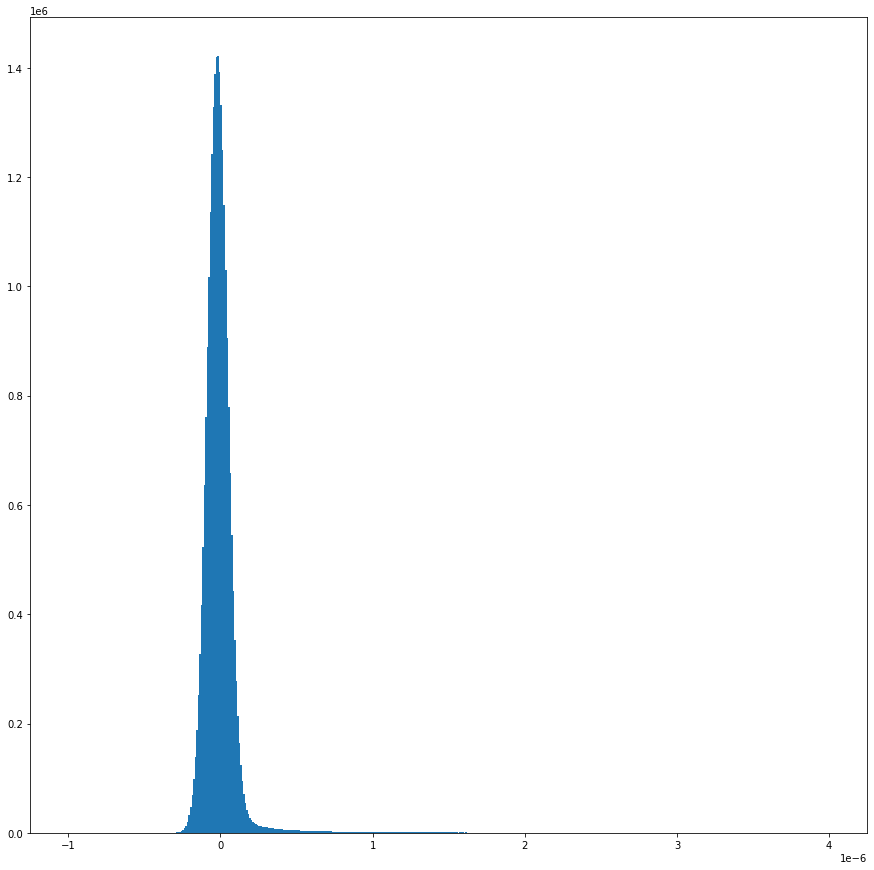

In [11]:
hist, bins = np.histogram(img1400_1000h, bins=500, range=[-1e-6, 4e-6])
bins = (bins[:-1] + bins[1:])/2.
w = bins[1] - bins[0]

fig, ax = plt.subplots(figsize=(15,15))
ax.bar(bins, hist, width=w)

The histogram of the simulated image shows that we have gaussian distribution for the most pixels centered around zero and long-tail where:

    1- sources around the mean are mostly considered noise,
    2- as we move towards the tail the more actual sources we gat and less noise

Therefore, to visualize the sources of the radio image without much noise we need to use clipped standard deviation (clip_STD) instead of the normal STD, since @@@ (we need to explain the step below, can also remember if it is correct)...

In [24]:
from scipy.stats import sigmaclip

std = np.std(img1400_1000h)
clip_std = np.std(sigmaclip(img1400_1000h)[0])
print(std, clip_std)

1.1822755e-06 7.048978e-08


Before we visualize the image we will need to use **SymLogNorm** so that we can normalize the image with logscale, and deal with (-) pixel values. as for its parameters:   

    1- vmin: minus the clip_STD
    2- vmax: clip_STD * 10
    3- linthresh:clip_STD 

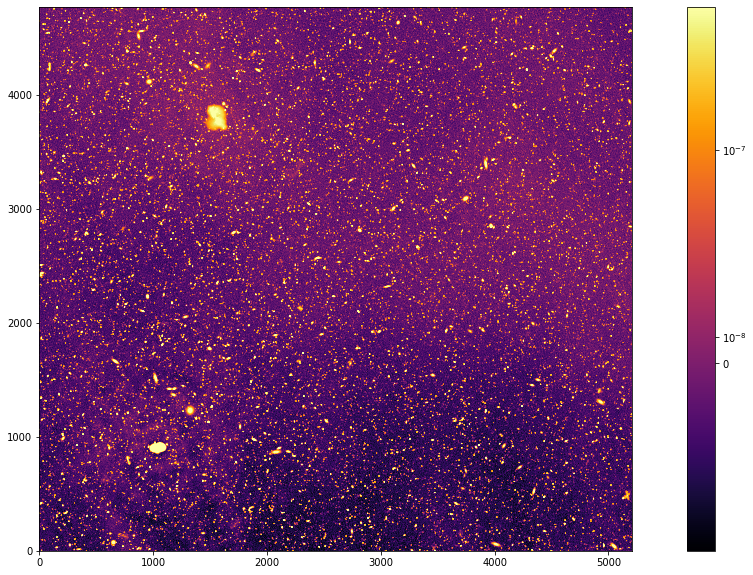

In [25]:
from matplotlib.colors import SymLogNorm

# https://github.com/HorizonIITM/PythonForAstronomy/blob/master/FITS%20Handling/PythonforAstronomy3.ipynb
plt.figure(figsize=(20, 10))
plt.imshow(img1400_1000h, origin='lower', norm=SymLogNorm(vmin= -clip_std, vmax=clip_std*10, linthresh=clip_std), cmap='inferno')
plt.savefig('pics/before.png') #we need to save the image so we can compare it after we perform PB correction
plt.colorbar()

---
**Exercise 3:** Display the 2 other image frequencies 
<br>
hint: For 'SymLogNorm' to set the its parameters correctly, ask a postdoc 

@@ENG

In [34]:
# -- code here --



---

### Pre-processing
now we will do the following:
1) Preprocess images (correct PB): @@@
2) Cropping the image for training: Usually, ML models require a subset of the data to be for training and the rest for testing, and it is essential for the training data to not overlap with the testing to avoid overfitting. 

---

improting some packges

In [16]:
from astropy.io import fits


from source.utils.image_utils import (
    crop_to_training_area,
    get_image_centre_coord,
    get_pixel_value_at_skycoord,
    save_subimage,
)

from source.pre.sdc1_image import Sdc1Image
from source.path import image_path, pb_path

---

first let us define a new image from the Sdc1Image in sdc1_image.py, and also the frequencies

In [39]:
new_image = Sdc1Image(freq, image_path(freq), pb_path(freq)) # define a new instance of Sdc1Image
freq = 1400

Defining the pipeline

In [40]:
def preprocess(image):
    """
    Perform preprocessing steps:
        1) Create PB-corrected image (image.pb_corr_image)
        2) Output separate training image (image.train)
    """
    image._prep = False
    image._create_pb_corr(threshold=0.1)
    image._create_train() # cropping the data
    image._prep = True

In [41]:
preprocess(new_image) 

 [astropy.io.fits.verify]


---

### Output visualization: 
now we will try to visualize the following preprocessed images:

- corrected image (After the PB correction)
- Before and after the correction
- Training (cropped) image 

<b><i> corrected image </i></b> 


In [50]:
img1400_1000h_corrected = fits.getdata(new_image.pb_corr_image, ext=0)
print(img1400_1000h_corrected.shape)


(1, 1, 4776, 5204)


In [51]:
img1400_1000h_corrected = img1400_1000h_corrected.reshape(img1400_1000h_corrected.shape[2:])
print(img1400_1000h_corrected.shape)

(4776, 5204)


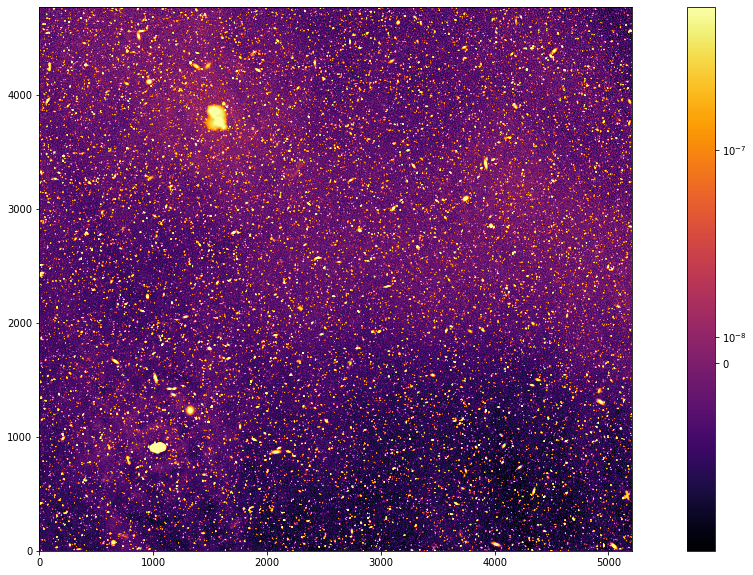

In [52]:
plt.figure(figsize=(20, 10))
plt.imshow(img1400_1000h_corrected, origin='lower', norm=SymLogNorm(vmin=-clip_std, vmax=clip_std*10, linthresh=clip_std), cmap='inferno')
plt.savefig('pics/after.png')
plt.colorbar()

<b><i> Before & After the correction </i></b> 


In [53]:
import imageio
def make_mov(fnames=[],output='animation.gif',fps=4):
        
    with imageio.get_writer(output, mode='I', fps=fps) as writer:
        for file in fnames:
            image = imageio.imread(file)
            writer.append_data(image)
            
make_mov(fnames=['pics/before.png','pics/after.png'],output='pics/difference.gif',fps=4)   

/tmp/ipykernel_2452111/3568772332.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file)


<img src="pics/difference.gif" width="2000" height="1000">

@@@ Any comment on the image above ?

<b><i> Training (cropped) image </i></b> 


In [55]:
img1400_1000h_train = fits.getdata(new_image.train, ext=0)
img1400_1000h_train = img1400_1000h_train.reshape(img1400_1000h_train.shape[2:])

print(img1400_1000h_train.shape)

(3184, 3469)


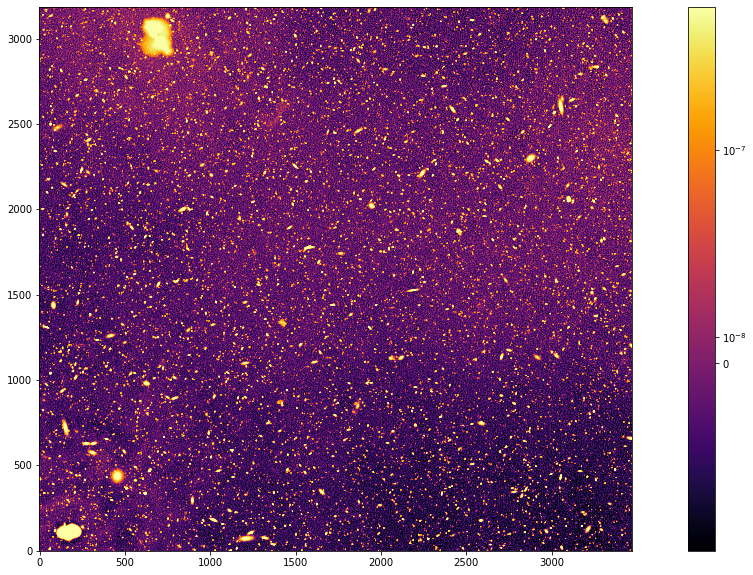

In [56]:
plt.figure(figsize=(20, 10))
plt.imshow(img1400_1000h_train, origin='lower', norm=SymLogNorm(vmin=-clip_std, vmax=clip_std*10, linthresh=clip_std), cmap='inferno')
plt.colorbar()

---

### Source finding (SF)

In [24]:
from source.utils.source_finder import SourceFinder
from source.path import write_df_to_disk, train_source_df_path

---

<b><i> SF on the training image </i></b> 

In [25]:
sources_training = {}
source_finder = SourceFinder(new_image.train)
sl_df = source_finder.run()

sources_training[new_image.freq] = sl_df

# (Optional) Write source list DataFrame to disk
write_df_to_disk(sl_df, train_source_df_path(new_image.freq))

# Remove temp files:
source_finder.reset()

--> Opened '1400mhz_1000h_train.fits'
Image size .............................. : (3469, 3184) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.66667e-04, 1.66667e-04, 0.0) degrees
Frequency of image ...................... : 1400.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.034 Jy
--> Calculating background rms and mean images
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
Using user-specified rms_box ............ : (74, 19) pixels
--> Using 2D map for background rms
-->

Fitting islands with Gaussians .......... : [|] 0/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/6636

stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 1/6636--\\Fitting islands with Gaussians .......... : [-] 2/6636Fitting islands with Gaussians .......... : [-] 2/6636Fitting islands with Gaussians .......... : [\] 3/6636\Fitting islands with Gaussians .......... : [-] 2/6636//\\Fitting islands with Gaussians .......... : [\] 3/6636Fitting islands with Gaussians .......... : [\] 3/6636Fitting islands with Gaussians .......... : [/] 5/6636|Fitting islands with Gaussians .......... : [/] 5/6636Fitting islands with Gaussians .......... : [\] 7/6636-\|Fitting islands with Gaussians .......... : [\] 7/6636|/Fitting islands with Gaussians .......... : [|] 8/6636Fitting islands with Gaussians .......... : [-] 11/6636Fitting islands with Gaussians .......... : [\] 11/6636Fitting islands with Gaussians .......... : [|] 12/6636Fitting islands with Gaussians .......... : [|] 12/6636\|Fitting islands with Gaussians .......... : [/] 13/6636//-Fitting islands with Gaussians .......... : [\] 16/6636F

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 22/6636Fitting islands with Gaussians .......... : [-] 23/6636Fitting islands with Gaussians .......... : [/] 22/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 23/6636|--Fitting islands with Gaussians .......... : [\] 24/6636||Fitting islands with Gaussians .......... : [-] 27/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 25/6636/-Fitting islands with Gaussians .......... : [-] 27/6636Fitting islands with Gaussians .......... : [|] 29/6636\Fitting islands with Gaussians .......... : [|] 29/6636Fitting islands with Gaussians .......... : [/] 30/6636|Fitting islands with Gaussians .......... : [-] 31/6636-/\Fitting islands with Gaussians .......... : [\] 32/6636Fitting islands with Gaussians .......... : [|] 33/6636Fitting islands with Gaussians .......... : [-] 35/6636Fitting islands with Gaussians .......... : [/] 34/6636//\Fitting islands with Gaussians .......... : [\] 36/6636\|Fitting islands with Gaussians .......... : [/] 38/6636Fitting islands with Gaussians .......... : [/] 38/6636|Fitting islands with Gaussians .......... : [\] 40/6636/Fitting islands with Gaussians .......... : [\] 40/6636Fitting islands with Gaussians .......... : [|] 41/6636\/Fitting islands with Gaussians .......... : [|] 41/6636/\--Fitting islands with Gaussians .......... : [

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [-] 50/6636

stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 51/6636Fitting islands with Gaussians .......... : [/] 53/6636|Fitting islands with Gaussians .......... : [/] 53/6636Fitting islands with Gaussians .......... : [\] 55/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 55/6636|Fitting islands with Gaussians .......... : [-] 58/6636Fitting islands with Gaussians .......... : [|] 56/6636/Fitting islands with Gaussians .......... : [\] 59/6636-Fitting islands with Gaussians .......... : [|] 60/6636Fitting islands with Gaussians .......... : [\] 59/6636|Fitting islands with Gaussians .......... : [/] 61/6636/\Fitting islands with Gaussians .......... : [-] 62/6636-Fitting islands with Gaussians .......... : [|] 64/6636\Fitting islands with Gaussians .......... : [/] 65/6636Fitting islands with Gaussians .......... : [\] 63/6636|///Fitting islands with Gaussians .......... : [-] 66/6636-Fitting islands with Gaussians .......... : [\] 67/6636Fitting islands with Gaussians .......... : [|] 68/6636Fitting islands with Gaussians .......... : [/] 69/6636Fitting islands with Gaussians .......... : [/] 69/6636|\-Fitting islands with Gaussians .......... : [/] 69/6636-\|Fitting islands with Gaussians .......... : 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 82/6636/Fitting islands with Gaussians .......... : [-] 83/6636Fitting islands with Gaussians .......... : [|] 85/6636-

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 80/6636--Fitting islands with Gaussians .......... : [/] 86/6636Fitting islands with Gaussians .......... : [-] 87/6636Fitting islands with Gaussians .......... : [\] 84/6636-Fitting islands with Gaussians .......... : [\] 88/6636\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 91/6636Fitting islands with Gaussians .......... : [-] 91/6636Fitting islands with Gaussians .......... : [\] 93/6636Fitting islands with Gaussians .......... : [\] 93/6636Fitting islands with Gaussians .......... : [|] 94/6636Fitting islands with Gaussians .......... : [\] 93/6636-//-Fitting islands with Gaussians .......... : [-] 91/6636\-\Fitting islands with Gaussians .......... : [-] 100/6636Fitting islands with Gaussians .......... : [/] 99/6636Fitting islands with Gaussians .......... : [-] 96/6636Fitting islands with Gaussians .......... : [\] 101/6636/Fitting islands with Gaussians .......... : [/] 99/6636--Fitting islands with Gaussians .......... : [-] 100/6636\\Fitting islands with Gaussians .......... : [\] 101/6636//Fitting islands with Gaussians .......... : [-] 104/6636Fitting islands with Gaussians .......... : [-] 104/6636Fitting islands with Gaussians .......... : [\] 105/6636Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 118/6636|Fitting islands with Gaussians .......... : [-] 117/6636Fitting islands with Gaussians .......... : [/] 120/6636/Fitting islands with Gaussians .......... : [/] 120/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 123/6636Fitting islands with Gaussians .......... : [|] 123/6636|Fitting islands with Gaussians .......... : [\] 122/6636//Fitting islands with Gaussians .......... : [/] 124/6636-\Fitting islands with Gaussians .......... : [-] 125/6636\Fitting islands with Gaussians .......... : [|] 127/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 128/6636Fitting islands with Gaussians .......... : [/] 128/6636\/\\Fitting islands with Gaussians .......... : [\] 130/6636Fitting islands with Gaussians .......... : [-] 130/6636Fitting islands with Gaussians .......... : [\] 130/6636//Fitting islands with Gaussians .......... : [\] 134/6636-\Fitting islands with Gaussians .......... : [\] 134/6636Fitting islands with Gaussians .......... : [\] 134/6636Fitting islands with Gaussians .......... : [/] 132/6636Fitting islands with Gaussians .......... : [/] 136/6636//Fitting islands with Gaussians .......... : [-] 137/6636\\Fitting islands with Gaussians .......... : [\] 138/6636Fitting islands with Gaussians .......... : [/] 136/6636Fitting islands with Gaussians .......... : [/] 140/6636/Fitting islands with Gaussians .......... : [/] 140/6636--|Fitting islands with Gaussians .......... : [\] 142/6636Fitting islands with Gaussians .......... : [\] 142/6636Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-|-Fitting islands with Gaussians .......... : [-] 156/6636||

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 157/6636/Fitting islands with Gaussians .......... : [-] 160/6636--Fitting islands with Gaussians .......... : [|] 162/6636Fitting islands with Gaussians .......... : [|] 158/6636Fitting islands with Gaussians .......... : [-] 160/6636|//Fitting islands with Gaussians .......... : [/] 163/6636Fitting islands with Gaussians .......... : [|] 162/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 164/6636\Fitting islands with Gaussians .......... : [|] 167/6636Fitting islands with Gaussians .......... : [-] 164/6636/Fitting islands with Gaussians .......... : [/] 167/6636/Fitting islands with Gaussians .......... : [/] 167/6636\Fitting islands with Gaussians .......... : [\] 169/6636|Fitting islands with Gaussians .......... : [/] 171/6636/Fitting islands with Gaussians .......... : [/] 171/6636Fitting islands with Gaussians .......... : [|] 173/6636Fitting islands with Gaussians .......... : [\] 169/6636Fitting islands with Gaussians .......... : [\] 173/6636/|||--Fitting islands with Gaussians .......... : [/] 175/6636Fitting islands with Gaussians .......... : [|] 178/6636Fitting islands with Gaussians .......... : [/] 175/6636Fitting islands with Gaussians .......... : [|] 178/6636Fitting islands with Gaussians .......... : [-] 180/6636----Fitting islands with Gaussians .......... : [|] 178/6636Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 196/6636Fitting islands with Gaussians .......... : [\] 196/6636Fitting islands with Gaussians .......... : [/] 194/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|-||Fitting islands with Gaussians .......... : [/] 198/6636Fitting islands with Gaussians .......... : [\] 196/6636Fitting islands with Gaussians .......... : [|] 197/6636/-Fitting islands with Gaussians .......... : [-] 199/6636|Fitting islands with Gaussians .......... : [|] 201/6636|Fitting islands with Gaussians .......... : [|] 201/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 201/6636Fitting islands with Gaussians .......... : [/] 202/6636-Fitting islands with Gaussians .......... : [-] 203/6636Fitting islands with Gaussians .......... : [|] 205/6636||Fitting islands with Gaussians .......... : [|] 205/6636--\Fitting islands with Gaussians .......... : [/] 206/6636Fitting islands with Gaussians .......... : [-] 207/6636Fitting islands with Gaussians .......... : [|] 209/6636Fitting islands with Gaussians .......... : [-] 211/6636/Fitting islands with Gaussians .......... : [|] 209/6636/-Fitting islands with Gaussians .......... : [-] 211/6636||Fitting islands with Gaussians .......... : [\] 212/6636/Fitting islands with Gaussians .......... : [/] 214/6636Fitting islands with Gaussians .......... : [/] 214/6636-Fitting islands with Gaussians .......... : [-] 215/6636Fitting islands with Gaussians .......... : [|] 217/6636|Fitting islands with Gaussians .......... : [|] 217/6636---\Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 232/6636Fitting islands with Gaussians .......... : [\] 232/6636Fitting islands with Gaussians .......... : [-] 235/6636-Fitting islands with Gaussians .......... : [|] 233/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 236/6636/|/Fitting islands with Gaussians .......... : [/] 234/6636Fitting islands with Gaussians .......... : [-] 239/6636Fitting islands with Gaussians .......... : [-] 239/6636Fitting islands with Gaussians .......... : [|] 237/6636Fitting islands with Gaussians .......... : [/] 242/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 241/6636|-Fitting islands with Gaussians .......... : [/] 242/6636\|Fitting islands with Gaussians .......... : [-] 244/6636Fitting islands with Gaussians .......... : [|] 245/6636|Fitting islands with Gaussians .......... : [-] 247/6636/Fitting islands with Gaussians .......... : [|] 249/6636\-Fitting islands with Gaussians .......... : [\] 248/6636Fitting islands with Gaussians .......... : [|] 245/6636Fitting islands with Gaussians .......... : [|] 249/6636|--Fitting islands with Gaussians .......... : [/] 250/6636|Fitting islands with Gaussians .......... : [|] 253/6636Fitting islands with Gaussians .......... : [\] 252/6636Fitting islands with Gaussians .......... : [-] 255/6636|Fitting islands with Gaussians .......... : [-] 251/6636Fitting islands with Gaussians .......... : [-] 255/6636--\Fitting islands with Gaussians .......... : [|] 257/6636|Fitting islands with Gaussians .......... : [-] 259/6636Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 269/6636Fitting islands with Gaussians .......... : [|] 269/6636Fitting islands with Gaussians .......... : [\] 268/6636//Fitting islands with Gaussians .......... : [-] 271/6636Fitting islands with Gaussians .......... : [\] 272/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [-] 271/6636Fitting islands with Gaussians .......... : [/] 274/6636Fitting islands with Gaussians .......... : [\] 276/6636Fitting islands with Gaussians .......... : [/] 274/6636--Fitting islands with Gaussians .......... : [\] 276/6636||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 279/6636Fitting islands with Gaussians .......... : [-] 279/6636/Fitting islands with Gaussians .......... : [|] 277/6636-||Fitting islands with Gaussians .......... : [/] 282/6636Fitting islands with Gaussians .......... : [|] 281/6636Fitting islands with Gaussians .......... : [|] 285/6636/Fitting islands with Gaussians .......... : [|] 285/6636\\Fitting islands with Gaussians .......... : [|] 281/6636Fitting islands with Gaussians .......... : [-] 283/6636|-Fitting islands with Gaussians .......... : [/] 286/6636Fitting islands with Gaussians .......... : [\] 288/6636Fitting islands with Gaussians .......... : [\] 288/6636Fitting islands with Gaussians .......... : [|] 289/6636|/--/Fitting islands with Gaussians .......... : [|] 293/6636Fitting islands with Gaussians .......... : [-] 291/6636Fitting islands with Gaussians .......... : [/] 294/6636\Fitting islands with Gaussians .......... : [-] 295/6636Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 300/6636|Fitting islands with Gaussians .......... : [|] 301/6636|Fitting islands with Gaussians .......... : [/] 302/6636-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 303/6636Fitting islands with Gaussians .......... : [|] 305/6636Fitting islands with Gaussians .......... : [|] 305/6636/Fitting islands with Gaussians .......... : [-] 307/6636|/-Fitting islands with Gaussians .......... : [\] 308/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 310/6636|Fitting islands with Gaussians .......... : [|] 309/6636Fitting islands with Gaussians .......... : [-] 311/6636Fitting islands with Gaussians .......... : [/] 310/6636-/Fitting islands with Gaussians .......... : [\] 312/6636/|Fitting islands with Gaussians .......... : [-] 315/6636Fitting islands with Gaussians .......... : [|] 313/6636|-Fitting islands with Gaussians .......... : [/] 314/6636\Fitting islands with Gaussians .......... : [|] 317/6636|Fitting islands with Gaussians .......... : [|] 317/6636/Fitting islands with Gaussians .......... : [-] 320/6636Fitting islands with Gaussians .......... : [/] 318/6636Fitting islands with Gaussians .......... : [\] 320/6636-|/Fitting islands with Gaussians .......... : [|] 321/6636/Fitting islands with Gaussians .......... : [-] 323/6636Fitting islands with Gaussians .......... : [/] 322/6636Fitting islands with Gaussians .......... : [/] 326/6636-\|Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 335/6636|Fitting islands with Gaussians .......... : [/] 334/6636Fitting islands with Gaussians .......... : [-] 335/6636--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 337/6636\|Fitting islands with Gaussians .......... : [|] 337/6636Fitting islands with Gaussians .......... : [-] 339/6636Fitting islands with Gaussians .......... : [\] 340/6636Fitting islands with Gaussians .......... : [-] 339/6636--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 341/6636Fitting islands with Gaussians .......... : [-] 343/6636Fitting islands with Gaussians .......... : [-] 343/6636--Fitting islands with Gaussians .......... : [|] 345/6636Fitting islands with Gaussians .......... : [|] 345/6636||//Fitting islands with Gaussians .......... : [-] 347/6636Fitting islands with Gaussians .......... : [-] 347/6636Fitting islands with Gaussians .......... : [|] 349/6636Fitting islands with Gaussians .......... : [|] 349/6636Fitting islands with Gaussians .......... : [/] 350/6636|||//Fitting islands with Gaussians .......... : [/] 350/6636Fitting islands with Gaussians .......... : [|] 353/6636Fitting islands with Gaussians .......... : [|] 353/6636Fitting islands with Gaussians .......... : [|] 353/6636-Fitting islands with Gaussians .......... : [/] 355/6636Fitting islands with Gaussians .......... : [/] 355/6636\/-Fitting islands with Gaussians .......... : [-] 357/6636\Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 362/6636|Fitting islands with Gaussians .......... : [|] 362/6636/Fitting islands with Gaussians .......... : [/] 363/6636\Fitting islands with Gaussians .......... : [\] 365/6636\Fitting islands with Gaussians .......... : [|] 366/6636Fitting islands with Gaussians .......... : [-] 364/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 367/6636/-/Fitting islands with Gaussians .......... : [\] 369/6636Fitting islands with Gaussians .......... : [\] 369/6636\Fitting islands with Gaussians .......... : [/] 371/6636Fitting islands with Gaussians .......... : [/] 371/6636|Fitting islands with Gaussians .......... : [-] 372/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [\] 373/6636\Fitting islands with Gaussians .......... : [|] 374/6636|/Fitting islands with Gaussians .......... : [-] 376/6636Fitting islands with Gaussians .......... : [|] 374/6636\Fitting islands with Gaussians .......... : [/] 375/6636\Fitting islands with Gaussians .......... : [|] 378/6636Fitting islands with Gaussians .......... : [\] 377/6636|//Fitting islands with Gaussians .......... : [\] 381/6636Fitting islands with Gaussians .......... : [/] 379/6636Fitting islands with Gaussians .......... : [\] 381/6636Fitting islands with Gaussians .......... : [|] 382/6636Fitting islands with Gaussians .......... : [/] 383/6636|Fitting islands with Gaussians .......... : [/] 383/6636--|\Fitting islands with Gaussians .......... : [|] 386/6636Fitting islands with Gaussians .......... : [-] 388/6636|Fitting islands with Gaussians .......... : [-] 388/6636/Fitting islands with Gaussians .......... : [|] 386/6636Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 391/6636/Fitting islands with Gaussians .......... : [\] 393/6636-Fitting islands with Gaussians .......... : [\] 393/6636\Fitting islands with Gaussians .......... : [-] 392/6636|/Fitting islands with Gaussians .......... : [/] 395/6636Fitting islands with Gaussians .......... : [/] 395/6636Fitting islands with Gaussians .......... : [-] 396/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 398/6636Fitting islands with Gaussians .......... : [\] 397/6636|||Fitting islands with Gaussians .......... : [/] 399/6636//-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 402/6636Fitting islands with Gaussians .......... : [|] 402/6636Fitting islands with Gaussians .......... : [|] 402/6636Fitting islands with Gaussians .......... : [/] 404/6636|\|Fitting islands with Gaussians .......... : [-] 405/6636Fitting islands with Gaussians .......... : [/] 404/6636-Fitting islands with Gaussians .......... : [|] 408/6636-\|Fitting islands with Gaussians .......... : [\] 406/6636/Fitting islands with Gaussians .......... : [-] 410/6636Fitting islands with Gaussians .......... : [|] 408/6636-\Fitting islands with Gaussians .......... : [|] 412/6636Fitting islands with Gaussians .......... : [-] 410/6636Fitting islands with Gaussians .......... : [\] 412/6636Fitting islands with Gaussians .......... : [/] 413/6636---\Fitting islands with Gaussians .......... : [-] 414/6636Fitting islands with Gaussians .......... : [\] 415/6636|Fitting islands with Gaussians .......... : [-] 418/6636Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 423/6636||Fitting islands with Gaussians .......... : [|] 424/6636/Fitting islands with Gaussians .......... : [-] 426/6636Fitting islands with Gaussians .......... : [/] 425/6636Fitting islands with Gaussians .......... : [/] 425/6636\Fitting islands with Gaussians .......... : [|] 428/6636\/Fitting islands with Gaussians .......... : [|] 428/6636Fitting islands with Gaussians .......... : [/] 429/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\/|Fitting islands with Gaussians .......... : [\] 431/6636Fitting islands with Gaussians .......... : [\] 431/6636Fitting islands with Gaussians .......... : [/] 433/6636--Fitting islands with Gaussians .......... : [/] 433/6636Fitting islands with Gaussians .......... : [\] 435/6636|Fitting islands with Gaussians .......... : [|] 436/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 435/6636/|-Fitting islands with Gaussians .......... : [-] 438/6636\Fitting islands with Gaussians .......... : [-] 438/6636Fitting islands with Gaussians .......... : [|] 440/6636|/Fitting islands with Gaussians .......... : [|] 441/6636Fitting islands with Gaussians .......... : [/] 441/6636Fitting islands with Gaussians .......... : [\] 443/6636Fitting islands with Gaussians .......... : [-] 442/6636\\/Fitting islands with Gaussians .......... : [/] 445/6636/-\Fitting islands with Gaussians .......... : [|] 444/6636Fitting islands with Gaussians .......... : [\] 447/6636Fitting islands with Gaussians .......... : [/] 449/6636|Fitting islands with Gaussians .......... : [\] 447/6636-Fitting islands with Gaussians .......... : [-] 450/6636-Fitting islands with Gaussians .......... : [/] 449/6636||/Fitting islands with Gaussians .......... : [\] 451/6636Fitting islands with Gaussians .......... : [-] 454/6636Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 460/6636Fitting islands with Gaussians .......... : [/] 460/6636|/Fitting islands with Gaussians .......... : [-] 458/6636\Fitting islands with Gaussians .......... : [/] 460/6636Fitting islands with Gaussians .......... : [|] 463/6636\Fitting islands with Gaussians .......... : [/] 464/6636Fitting islands with Gaussians .......... : [|] 463/6636|/\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 466/6636\Fitting islands with Gaussians .......... : [|] 468/6636Fitting islands with Gaussians .......... : [/] 468/6636Fitting islands with Gaussians .......... : [\] 466/6636|--Fitting islands with Gaussians .......... : [\] 470/6636Fitting islands with Gaussians .......... : [\] 470/6636||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 471/6636/Fitting islands with Gaussians .......... : [-] 473/6636-\Fitting islands with Gaussians .......... : [-] 473/6636Fitting islands with Gaussians .......... : [|] 475/6636Fitting islands with Gaussians .......... : [|] 475/6636Fitting islands with Gaussians .......... : [-] 477/6636|-Fitting islands with Gaussians .......... : [/] 476/6636-\Fitting islands with Gaussians .......... : [\] 478/6636|/Fitting islands with Gaussians .......... : [-] 481/6636Fitting islands with Gaussians .......... : [-] 481/6636-Fitting islands with Gaussians .......... : [|] 479/6636Fitting islands with Gaussians .......... : [|] 483/6636Fitting islands with Gaussians .......... : [\] 482/6636Fitting islands with Gaussians .......... : [/] 484/6636|-\\/Fitting islands with Gaussians .......... : [-] 485/6636|Fitting islands with Gaussians .......... : [-] 489/6636Fitting islands with Gaussians .......... : [\] 490/6636Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 493/6636Fitting islands with Gaussians .......... : [-] 493/6636/-|Fitting islands with Gaussians .......... : [|] 495/6636Fitting islands with Gaussians .......... : [|] 495/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 497/6636Fitting islands with Gaussians .......... : [/] 496/6636/\-\\Fitting islands with Gaussians .......... : [|] 499/6636|/Fitting islands with Gaussians .......... : [-] 500/6636Fitting islands with Gaussians .......... : [\] 502/6636Fitting islands with Gaussians .......... : [\] 502/6636Fitting islands with Gaussians .......... : [\] 502/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 503/6636|/Fitting islands with Gaussians .......... : [/] 504/6636Fitting islands with Gaussians .......... : [/] 500/6636\\\|Fitting islands with Gaussians .......... : [/] 507/6636Fitting islands with Gaussians .......... : [|] 507/6636Fitting islands with Gaussians .......... : [|] 507/6636\Fitting islands with Gaussians .......... : [\] 509/6636Fitting islands with Gaussians .......... : [\] 509/6636\Fitting islands with Gaussians .......... : [|] 510/6636\|-Fitting islands with Gaussians .......... : [\] 509/6636-Fitting islands with Gaussians .......... : [\] 513/6636Fitting islands with Gaussians .......... : [\] 513/6636||Fitting islands with Gaussians .......... : [-] 516/6636/Fitting islands with Gaussians .......... : [\] 513/6636Fitting islands with Gaussians .......... : [|] 514/6636-||Fitting islands with Gaussians .......... : [-] 516/6636Fitting islands with Gaussians .......... : [|] 518/6636/Fitting islands with Gaussia

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 526/6636\\Fitting islands with Gaussians .......... : [\] 525/6636Fitting islands with Gaussians .......... : [\] 528/6636/Fitting islands with Gaussians .......... : [/] 530/6636/Fitting islands with Gaussians .......... : [/] 530/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 532/6636|Fitting islands with Gaussians .......... : [\] 532/6636|/Fitting islands with Gaussians .......... : [/] 534/6636Fitting islands with Gaussians .......... : [\] 536/6636/Fitting islands with Gaussians .......... : [/] 534/6636\\|Fitting islands with Gaussians .......... : [|] 537/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 538/6636Fitting islands with Gaussians .......... : [|] 537/6636Fitting islands with Gaussians .......... : [\] 540/6636-Fitting islands with Gaussians .......... : [/] 538/6636|Fitting islands with Gaussians .......... : [|] 541/6636||Fitting islands with Gaussians .......... : [\] 540/6636---Fitting islands with Gaussians .......... : [|] 545/6636Fitting islands with Gaussians .......... : [-] 544/6636Fitting islands with Gaussians .......... : [|] 545/6636Fitting islands with Gaussians .......... : [|] 545/6636||Fitting islands with Gaussians .......... : [-] 547/6636Fitting islands with Gaussians .......... : [-] 547/6636-\Fitting islands with Gaussians .......... : [|] 549/6636|Fitting islands with Gaussians .......... : [|] 549/6636--Fitting islands with Gaussians .......... : [-] 551/6636Fitting islands with Gaussians .......... : [-] 547/6636-\Fitting islands with Gaussians .......... : [|] 553/6636|Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-|Fitting islands with Gaussians .......... : [-] 563/6636|/Fitting islands with Gaussians .......... : [\] 564/6636Fitting islands with Gaussians .......... : [|] 565/6636Fitting islands with Gaussians .......... : [-] 567/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 569/6636|Fitting islands with Gaussians .......... : [|] 569/6636Fitting islands with Gaussians .......... : [-] 567/6636-Fitting islands with Gaussians .......... : [/] 570/6636Fitting islands with Gaussians .......... : [-] 571/6636||/Fitting islands with Gaussians .......... : [|] 573/6636Fitting islands with Gaussians .......... : [-] 575/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-Fitting islands with Gaussians .......... : [|] 577/6636|Fitting islands with Gaussians .......... : [|] 577/6636|Fitting islands with Gaussians .......... : [/] 574/6636Fitting islands with Gaussians .......... : [-] 579/6636Fitting islands with Gaussians .......... : [\] 580/6636/-\\|Fitting islands with Gaussians .......... : [|] 581/6636Fitting islands with Gaussians .......... : [/] 582/6636Fitting islands with Gaussians .......... : [|] 581/6636--Fitting islands with Gaussians .......... : [\] 583/6636\Fitting islands with Gaussians .......... : [\] 583/6636|Fitting islands with Gaussians .......... : [-] 583/6636--Fitting islands with Gaussians .......... : [-] 586/6636Fitting islands with Gaussians .......... : [|] 584/6636\Fitting islands with Gaussians .......... : [\] 587/6636Fitting islands with Gaussians .......... : [-] 586/6636Fitting islands with Gaussians .......... : [|] 588/6636Fitting islands with Gaussians .......... : [-] 590/6636|Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 601/6636Fitting islands with Gaussians .......... : [\] 601/6636Fitting islands with Gaussians .......... : [|] 602/6636-Fitting islands with Gaussians .......... : [-] 600/6636||Fitting islands with Gaussians .......... : [|] 602/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 604/6636-|Fitting islands with Gaussians .......... : [/] 603/6636|Fitting islands with Gaussians .......... : [|] 606/6636Fitting islands with Gaussians .......... : [/] 607/6636Fitting islands with Gaussians .......... : [-] 608/6636/-Fitting islands with Gaussians .......... : [|] 606/6636||/Fitting islands with Gaussians .......... : [|] 610/6636Fitting islands with Gaussians .......... : [|] 610/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 612/6636\Fitting islands with Gaussians .......... : [/] 611/6636\Fitting islands with Gaussians .......... : [|] 614/6636Fitting islands with Gaussians .......... : [/] 615/6636|Fitting islands with Gaussians .......... : [|] 614/6636/\\Fitting islands with Gaussians .......... : [\] 617/6636\Fitting islands with Gaussians .......... : [\] 617/6636|Fitting islands with Gaussians .......... : [\] 621/6636Fitting islands with Gaussians .......... : [|] 618/6636Fitting islands with Gaussians .......... : [\] 621/6636Fitting islands with Gaussians .......... : [/] 619/6636\\\Fitting islands with Gaussians .......... : [\] 621/6636//-Fitting islands with Gaussians .......... : [|] 622/6636Fitting islands with Gaussians .......... : [\] 625/6636Fitting islands with Gaussians .......... : [\] 625/6636Fitting islands with Gaussians .......... : [/] 627/6636Fitting islands with Gaussians .......... : [\] 625/6636|\Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 638/6636/-Fitting islands with Gaussians .......... : [\] 638/6636Fitting islands with Gaussians .......... : [/] 640/6636Fitting islands with Gaussians .......... : [\] 638/6636

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 638/6636|Fitting islands with Gaussians .......... : [-] 641/6636Fitting islands with Gaussians .......... : [/] 640/6636--||Fitting islands with Gaussians .......... : [|] 643/6636/Fitting islands with Gaussians .......... : [|] 643/6636Fitting islands with Gaussians .......... : [-] 646/6636-Fitting islands with Gaussians .......... : [|] 647/6636Fitting islands with Gaussians .......... : [-] 646/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 647/6636\/-|Fitting islands with Gaussians .......... : [/] 648/6636Fitting islands with Gaussians .......... : [-] 649/6636Fitting islands with Gaussians .......... : [\] 650/6636|--|Fitting islands with Gaussians .......... : [/] 652/6636\Fitting islands with Gaussians .......... : [-] 654/6636Fitting islands with Gaussians .......... : [|] 651/6636Fitting islands with Gaussians .......... : [|] 655/6636Fitting islands with Gaussians .......... : [-] 657/6636//Fitting islands with Gaussians .......... : [|] 655/6636--\Fitting islands with Gaussians .......... : [-] 657/6636Fitting islands with Gaussians .......... : [\] 658/6636Fitting islands with Gaussians .......... : [/] 660/6636Fitting islands with Gaussians .......... : [/] 660/6636Fitting islands with Gaussians .......... : [-] 661/6636/|\\|Fitting islands with Gaussians .......... : [\] 662/6636Fitting islands with Gaussians .......... : [-] 661/6636Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 673/6636Fitting islands with Gaussians .......... : [/] 673/6636|/Fitting islands with Gaussians .......... : [\] 674/6636-||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 676/6636Fitting islands with Gaussians .......... : [|] 675/6636Fitting islands with Gaussians .......... : [\] 674/6636-Fitting islands with Gaussians .......... : [/] 676/6636-Fitting islands with Gaussians .......... : [-] 677/6636Fitting islands with Gaussians .......... : [|] 679/6636Fitting islands with Gaussians .......... : [|] 679/6636||/Fitting islands with Gaussians .......... : [-] 681/6636Fitting islands with Gaussians .......... : [-] 681/6636\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 682/6636//Fitting islands with Gaussians .......... : [|] 682/6636Fitting islands with Gaussians .......... : [/] 683/6636-Fitting islands with Gaussians .......... : [\] 685/6636Fitting islands with Gaussians .......... : [\] 685/6636||Fitting islands with Gaussians .......... : [/] 686/6636/-Fitting islands with Gaussians .......... : [/] 686/6636\|Fitting islands with Gaussians .......... : [|] 689/6636Fitting islands with Gaussians .......... : [|] 689/6636Fitting islands with Gaussians .......... : [-] 687/6636--Fitting islands with Gaussians .......... : [/] 690/6636Fitting islands with Gaussians .......... : [-] 691/6636\|Fitting islands with Gaussians .......... : [\] 692/6636Fitting islands with Gaussians .......... : [|] 693/6636/Fitting islands with Gaussians .......... : [\] 696/6636-Fitting islands with Gaussians .......... : [-] 695/6636|Fitting islands with Gaussians .......... : [-] 695/6636\Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 707/6636|Fitting islands with Gaussians .......... : [\] 708/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 710/6636Fitting islands with Gaussians .......... : [/] 710/6636Fitting islands with Gaussians .......... : [|] 713/6636Fitting islands with Gaussians .......... : [\] 712/6636Fitting islands with Gaussians .......... : [\] 712/6636//Fitting islands with Gaussians .......... : [/] 714/6636Fitting islands with Gaussians .......... : [-] 715/6636-|||Fitting islands with Gaussians .......... : [/] 716/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 717/6636Fitting islands with Gaussians .......... : [/] 716/6636-Fitting islands with Gaussians .......... : [|] 719/6636Fitting islands with Gaussians .......... : [|] 719/6636/Fitting islands with Gaussians .......... : [|] 719/6636//Fitting islands with Gaussians .......... : [/] 720/6636\\Fitting islands with Gaussians .......... : [-] 721/6636Fitting islands with Gaussians .......... : [/] 724/6636|Fitting islands with Gaussians .......... : [/] 725/6636--Fitting islands with Gaussians .......... : [/] 725/6636Fitting islands with Gaussians .......... : [\] 726/6636|Fitting islands with Gaussians .......... : [|] 727/6636|Fitting islands with Gaussians .......... : [\] 726/6636-Fitting islands with Gaussians .......... : [-] 729/6636Fitting islands with Gaussians .......... : [-] 729/6636//Fitting islands with Gaussians .......... : [|] 731/6636Fitting islands with Gaussians .......... : [|] 731/6636/Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 740/6636Fitting islands with Gaussians .......... : [\] 742/6636Fitting islands with Gaussians .......... : [\] 742/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 743/6636/Fitting islands with Gaussians .......... : [-] 745/6636Fitting islands with Gaussians .......... : [\] 746/6636-\Fitting islands with Gaussians .......... : [-] 745/6636-|-Fitting islands with Gaussians .......... : [|] 747/6636Fitting islands with Gaussians .......... : [/] 748/6636\Fitting islands with Gaussians .......... : [-] 749/6636Fitting islands with Gaussians .......... : [\] 750/6636Fitting islands with Gaussians .......... : [-] 753/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 751/6636-Fitting islands with Gaussians .......... : [-] 753/6636\Fitting islands with Gaussians .......... : [\] 754/6636//-Fitting islands with Gaussians .......... : [/] 756/6636Fitting islands with Gaussians .......... : [\] 758/6636Fitting islands with Gaussians .......... : [-] 757/6636/Fitting islands with Gaussians .......... : [/] 760/6636//Fitting islands with Gaussians .......... : [-] 761/6636-Fitting islands with Gaussians .......... : [/] 760/6636\\Fitting islands with Gaussians .......... : [/] 764/6636Fitting islands with Gaussians .......... : [/] 764/6636\Fitting islands with Gaussians .......... : [/] 763/6636Fitting islands with Gaussians .......... : [-] 765/6636--\Fitting islands with Gaussians .......... : [\] 766/6636\Fitting islands with Gaussians .......... : [\] 766/6636|Fitting islands with Gaussians .......... : [\] 766/6636Fitting islands with Gaussians .......... : [-] 769/6636Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||-Fitting islands with Gaussians .......... : [-] 777/6636

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 777/6636/Fitting islands with Gaussians .......... : [-] 777/6636\Fitting islands with Gaussians .......... : [-] 777/6636Fitting islands with Gaussians .......... : [/] 776/6636Fitting islands with Gaussians .......... : [|] 779/6636Fitting islands with Gaussians .......... : [|] 779/6636\//\\Fitting islands with Gaussians .......... : [\] 782/6636Fitting islands with Gaussians .......... : [\] 782/6636Fitting islands with Gaussians .......... : [/] 784/6636Fitting islands with Gaussians .......... : [/] 780/6636Fitting islands with Gaussians .......... : [/] 784/6636/\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\|Fitting islands with Gaussians .......... : [\] 786/6636Fitting islands with Gaussians .......... : [/] 788/6636Fitting islands with Gaussians .......... : [\] 786/6636Fitting islands with Gaussians .......... : [\] 790/6636Fitting islands with Gaussians .......... : [|] 791/6636Fitting islands with Gaussians .......... : [\] 790/6636/Fitting islands with Gaussians .......... : [\] 790/6636//--\/Fitting islands with Gaussians .......... : [/] 792/6636Fitting islands with Gaussians .......... : [/] 796/6636Fitting islands with Gaussians .......... : [/] 796/6636|Fitting islands with Gaussians .......... : [-] 797/6636Fitting islands with Gaussians .......... : [-] 797/6636Fitting islands with Gaussians .......... : [\] 798/6636Fitting islands with Gaussians .......... : [/] 796/6636--/||Fitting islands with Gaussians .......... : [|] 799/6636/-Fitting islands with Gaussians .......... : [/] 800/6636Fitting islands with Gaussians .......... : [-] 801/6636Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 814/6636Fitting islands with Gaussians .......... : [\] 815/6636Fitting islands with Gaussians .......... : [|] 811/6636Fitting islands with Gaussians .......... : [\] 810/6636Fitting islands with Gaussians .......... : [\] 815/6636Fitting islands with Gaussians .......... : [\] 815/6636/////Fitting islands with Gaussians .......... : [|] 816/6636Fitting islands with Gaussians .......... : [/] 820/6636||Fitting islands with Gaussians .......... : [/] 820/6636Fitting islands with Gaussians .......... : [/] 820/6636--Fitting islands with Gaussians .......... : [/] 820/6636Fitting islands with Gaussians .......... : [|] 823/6636Fitting islands with Gaussians .......... : [/] 820/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 823/6636//--/Fitting islands with Gaussians .......... : [-] 825/6636Fitting islands with Gaussians .......... : [-] 825/6636\|Fitting islands with Gaussians .......... : [/] 828/6636Fitting islands with Gaussians .......... : [/] 828/6636Fitting islands with Gaussians .......... : [/] 828/6636-Fitting islands with Gaussians .......... : [-] 829/6636\Fitting islands with Gaussians .......... : [\] 830/6636Fitting islands with Gaussians .......... : [-] 829/6636|Fitting islands with Gaussians .......... : [|] 831/6636Fitting islands with Gaussians .......... : [-] 833/6636Fitting islands with Gaussians .......... : [\] 834/6636-\-|Fitting islands with Gaussians .......... : [|] 835/6636/Fitting islands with Gaussians .......... : [-] 837/6636-\Fitting islands with Gaussians .......... : [\] 838/6636Fitting islands with Gaussians .......... : [|] 839/6636Fitting islands with Gaussians .......... : [-] 837/6636//Fitting islands with Gaussian

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 845/6636\

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 849/6636Fitting islands with Gaussians .......... : [-] 849/6636Fitting islands with Gaussians .......... : [\] 850/6636Fitting islands with Gaussians .......... : [-] 849/6636\\||Fitting islands with Gaussians .......... : [|] 851/6636/-Fitting islands with Gaussians .......... : [|] 855/6636Fitting islands with Gaussians .......... : [\] 854/6636Fitting islands with Gaussians .......... : [|] 855/6636||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 856/6636Fitting islands with Gaussians .......... : [\] 854/6636/Fitting islands with Gaussians .......... : [-] 857/6636-\Fitting islands with Gaussians .......... : [|] 859/6636|Fitting islands with Gaussians .......... : [/] 860/6636Fitting islands with Gaussians .......... : [|] 859/6636--Fitting islands with Gaussians .......... : [\] 862/6636Fitting islands with Gaussians .......... : [-] 861/6636\\//Fitting islands with Gaussians .......... : [|] 863/6636Fitting islands with Gaussians .......... : [-] 865/6636Fitting islands with Gaussians .......... : [-] 865/6636Fitting islands with Gaussians .......... : [\] 866/6636Fitting islands with Gaussians .......... : [\] 866/6636||Fitting islands with Gaussians .......... : [/] 868/6636Fitting islands with Gaussians .......... : [/] 868/6636|||\Fitting islands with Gaussians .......... : [|] 871/6636|/Fitting islands with Gaussians .......... : [|] 871/6636Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [/] 881/6636/

stty: 

Fitting islands with Gaussians .......... : [\] 883/6636-Fitting islands with Gaussians .......... : [|] 884/6636-\Fitting islands with Gaussians .......... : [\] 883/6636\|Fitting islands with Gaussians .......... : [/] 885/6636/Fitting islands with Gaussians .......... : [\] 887/6636Fitting islands with Gaussians .......... : [-] 886/6636Fitting islands with Gaussians .......... : [\] 887/6636-Fitting islands with Gaussians .......... : [-] 886/6636/Fitting islands with Gaussians .......... : [|] 888/6636//Fitting islands with Gaussians .......... : [/] 889/6636-\|

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 892/6636Fitting islands with Gaussians .......... : [/] 892/6636Fitting islands with Gaussians .......... : [-] 890/6636Fitting islands with Gaussians .......... : [/] 892/6636Fitting islands with Gaussians .......... : [\] 894/6636-Fitting islands with Gaussians .......... : [-] 893/6636\\Fitting islands with Gaussians .......... : [|] 895/6636\/Fitting islands with Gaussians .......... : [-] 897/6636\Fitting islands with Gaussians .......... : [\] 898/6636\Fitting islands with Gaussians .......... : [\] 898/6636//Fitting islands with Gaussians .......... : [/] 900/6636/Fitting islands with Gaussians .......... : [\] 902/6636Fitting islands with Gaussians .......... : [\] 902/6636\\Fitting islands with Gaussians .......... : [\] 902/6636Fitting islands with Gaussians .......... : [/] 905/6636/-Fitting islands with Gaussians .......... : [/] 905/6636Fitting islands with Gaussians .......... : [/] 905/6636-\Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

stty: 

Fitting islands with Gaussians .......... : [|] 919/6636\Fitting islands with Gaussians .......... : [/] 916/6636\Fitting islands with Gaussians .......... : [|] 919/6636//Fitting islands with Gaussians .......... : [|] 919/6636Fitting islands with Gaussians .......... : [\] 922/6636-Fitting islands with Gaussians .......... : [\] 922/6636Fitting islands with Gaussians .......... : [/] 920/6636\/Fitting islands with Gaussians .......... : [/] 924/6636/Fitting islands with Gaussians .......... : [/] 925/6636-Fitting islands with Gaussians .......... : [\] 926/6636Fitting islands with Gaussians .......... : [-] 925/6636----Fitting islands with Gaussians .......... : [/] 928/6636Fitting islands with Gaussians .......... : [/] 928/6636\Fitting islands with Gaussians .......... : [-] 929/6636

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 931/6636/Fitting islands with Gaussians .......... : [-] 933/6636Fitting islands with Gaussians .......... : [-] 933/6636Fitting islands with Gaussians .......... : [-] 933/6636Fitting islands with Gaussians .......... : [\] 934/6636|Fitting islands with Gaussians .......... : [/] 935/6636||Fitting islands with Gaussians .......... : [/] 935/6636\|||Fitting islands with Gaussians .......... : [|] 938/6636Fitting islands with Gaussians .......... : [|] 938/6636Fitting islands with Gaussians .......... : [|] 938/6636-Fitting islands with Gaussians .......... : [|] 942/6636Fitting islands with Gaussians .......... : [|] 942/6636Fitting islands with Gaussians .......... : [|] 942/6636----Fitting islands with Gaussians .......... : [\] 941/6636Fitting islands with Gaussians .......... : [-] 944/6636\-Fitting islands with Gaussians .......... : [-] 947/6636|Fitting islands with Gaussians .......... : [-] 944/6636/Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 953/6636Fitting islands with Gaussians .......... : [\] 955/6636-Fitting islands with Gaussians .......... : [\] 956/6636||Fitting islands with Gaussians .......... : [|] 956/6636Fitting islands with Gaussians .......... : [|] 956/6636Fitting islands with Gaussians .......... : [-] 958/6636Fitting islands with Gaussians .......... : [/] 957/6636|/Fitting islands with Gaussians .......... : [|] 960/6636Fitting islands with Gaussians .......... : [|] 960/6636\|\/Fitting islands with Gaussians .......... : [|] 963/6636/Fitting islands with Gaussians .......... : [/] 963/6636-Fitting islands with Gaussians .......... : [\] 965/6636Fitting islands with Gaussians .......... : [/] 967/6636Fitting islands with Gaussians .......... : [|] 966/6636Fitting islands with Gaussians .......... : [/] 967/6636Fitting islands with Gaussians .......... : [\] 965/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


\\|\Fitting islands with Gaussians .......... : [-] 968/6636|Fitting islands with Gaussians .......... : [|] 970/6636|Fitting islands with Gaussians .......... : [\] 974/6636Fitting islands with Gaussians .......... : [\] 974/6636-\Fitting islands with Gaussians .......... : [\] 974/6636\|Fitting islands with Gaussians .......... : [|] 975/6636Fitting islands with Gaussians .......... : [|] 975/6636|Fitting islands with Gaussians .......... : [-] 977/6636-Fitting islands with Gaussians .......... : [\] 978/6636Fitting islands with Gaussians .......... : [|] 979/6636|Fitting islands with Gaussians .......... : [\] 978/6636||/Fitting islands with Gaussians .......... : [-] 981/6636Fitting islands with Gaussians .......... : [|] 979/6636-\Fitting islands with Gaussians .......... : [|] 983/6636|Fitting islands with Gaussians .......... : [|] 983/6636Fitting islands with Gaussians .......... : [/] 984/6636/Fitting islands with Gaussians .......... : [|] 983/6636Fitting islands with Gaussia

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 989/6636Fitting islands with Gaussians .......... : [/] 988/6636\Fitting islands with Gaussians .......... : [\] 990/6636|Fitting islands with Gaussians .......... : [-] 989/6636Fitting islands with Gaussians .......... : [/] 992/6636Fitting islands with Gaussians .......... : [-] 993/6636Fitting islands with Gaussians .......... : [/] 992/6636|||Fitting islands with Gaussians .......... : [\] 994/6636Fitting islands with Gaussians .......... : [|] 995/6636-|Fitting islands with Gaussians .......... : [|] 999/6636Fitting islands with Gaussians .......... : [|] 999/6636||Fitting islands with Gaussians .......... : [|] 999/6636Fitting islands with Gaussians .......... : [|] 999/6636-\Fitting islands with Gaussians .......... : [-] 1001/6636\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 1003/6636Fitting islands with Gaussians .......... : [|] 1003/6636--Fitting islands with Gaussians .......... : [-] 1005/6636Fitting islands with Gaussians .......... : [\] 1006/6636Fitting islands with Gaussians .......... : [|] 1007/6636\Fitting islands with Gaussians .......... : [\] 1006/6636|Fitting islands with Gaussians .......... : [-] 1009/6636/Fitting islands with Gaussians .......... : [\] 1010/6636/Fitting islands with Gaussians .......... : [-] 1009/6636-Fitting islands with Gaussians .......... : [/] 1013/6636\Fitting islands with Gaussians .......... : [/] 1013/6636/-/Fitting islands with Gaussians .......... : [|] 1011/6636Fitting islands with Gaussians .......... : [-] 1014/6636-\Fitting islands with Gaussians .......... : [\] 1015/6636\Fitting islands with Gaussians .......... : [/] 1017/6636|Fitting islands with Gaussians .......... : [-] 1018/6636Fitting islands with Gaussians .......... : [/] 1017/6636/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1020/6636Fitting islands with Gaussians .......... : [\] 1019/6636Fitting islands with Gaussians .......... : [/] 1021/6636\Fitting islands with Gaussians .......... : [\] 1024/6636Fitting islands with Gaussians .......... : [\] 1023/6636\Fitting islands with Gaussians .......... : [|] 1024/6636//Fitting islands with Gaussians .......... : [/] 1025/6636\\Fitting islands with Gaussians .......... : [\] 1027/6636Fitting islands with Gaussians .......... : [\] 1027/6636|--Fitting islands with Gaussians .......... : [/] 1029/6636Fitting islands with Gaussians .......... : [/] 1029/6636Fitting islands with Gaussians .......... : [\] 1031/6636Fitting islands with Gaussians .......... : [\] 1031/6636|Fitting islands with Gaussians .......... : [|] 1032/6636//-Fitting islands with Gaussians .......... : [-] 1034/6636Fitting islands with Gaussians .......... : [|] 1036/6636Fitting islands with Gaussians .......... : [-] 1034/6636\-/Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1038/6636||Fitting islands with Gaussians .......... : [\] 1039/6636Fitting islands with Gaussians .......... : [-] 1042/6636Fitting islands with Gaussians .......... : [/] 1041/6636-Fitting islands with Gaussians .......... : [|] 1044/6636|Fitting islands with Gaussians .......... : [-] 1046/6636Fitting islands with Gaussians .......... : [|] 1044/6636/|-Fitting islands with Gaussians .......... : [|] 1048/6636\Fitting islands with Gaussians .......... : [|] 1048/6636|Fitting islands with Gaussians .......... : [/] 1049/6636Fitting islands with Gaussians .......... : [-] 1050/6636\Fitting islands with Gaussians .......... : [\] 1051/6636|\\|Fitting islands with Gaussians .......... : [|] 1052/6636Fitting islands with Gaussians .......... : [\] 1055/6636Fitting islands with Gaussians .......... : [\] 1055/6636Fitting islands with Gaussians .......... : [|] 1056/6636/Fitting islands with Gaussians .......... : [\] 1055/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//|Fitting islands with Gaussians .......... : [|] 1056/6636/Fitting islands with Gaussians .......... : [/] 1057/6636Fitting islands with Gaussians .......... : [/] 1060/6636Fitting islands with Gaussians .......... : [|] 1059/6636\Fitting islands with Gaussians .......... : [/] 1060/6636Fitting islands with Gaussians .......... : [/] 1060/6636///-Fitting islands with Gaussians .......... : [/] 1064/6636Fitting islands with Gaussians .......... : [-] 1065/6636Fitting islands with Gaussians .......... : [\] 1062/6636Fitting islands with Gaussians .......... : [/] 1064/6636Fitting islands with Gaussians .......... : [/] 1064/6636|---\Fitting islands with Gaussians .......... : [|] 1068/6636Fitting islands with Gaussians .......... : [-] 1069/6636Fitting islands with Gaussians .......... : [-] 1069/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1069/6636|\Fitting islands with Gaussians .......... : [\] 1070/6636\Fitting islands with Gaussians .......... : [|] 1072/6636|Fitting islands with Gaussians .......... : [\] 1074/6636/Fitting islands with Gaussians .......... : [\] 1074/6636-Fitting islands with Gaussians .......... : [|] 1075/6636\Fitting islands with Gaussians .......... : [/] 1076/6636|Fitting islands with Gaussians .......... : [-] 1077/6636/Fitting islands with Gaussians .......... : [\] 1078/6636-Fitting islands with Gaussians .......... : [|] 1079/6636-\-|Fitting islands with Gaussians .......... : [/] 1080/6636Fitting islands with Gaussians .......... : [-] 1081/6636/Fitting islands with Gaussians .......... : [-] 1081/6636Fitting islands with Gaussians .......... : [-] 1081/6636Fitting islands with Gaussians .......... : [|] 1083/6636Fitting islands with Gaussians .......... : [\] 1083/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|\Fitting islands with Gaussians .......... : [\] 1086/6636/-Fitting islands with Gaussians .......... : [/] 1084/6636|Fitting islands with Gaussians .......... : [|] 1087/6636Fitting islands with Gaussians .......... : [\] 1086/6636Fitting islands with Gaussians .......... : [-] 1089/6636Fitting islands with Gaussians .......... : [/] 1088/6636/|Fitting islands with Gaussians .......... : [|] 1091/6636||/Fitting islands with Gaussians .......... : [|] 1095/6636Fitting islands with Gaussians .......... : [|] 1095/6636Fitting islands with Gaussians .......... : [/] 1092/6636Fitting islands with Gaussians .......... : [|] 1095/6636--Fitting islands with Gaussians .......... : [/] 1096/6636|/

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [-] 1097/6636Fitting islands with Gaussians .......... : [|] 1099/6636||Fitting islands with Gaussians .......... : [-] 1101/6636Fitting islands with Gaussians .......... : [-] 1097/6636Fitting islands with Gaussians .......... : [/] 1100/6636Fitting islands with Gaussians .......... : [/] 1100/6636--Fitting islands with Gaussians .......... : [|] 1103/6636\Fitting islands with Gaussians .......... : [|] 1103/6636|Fitting islands with Gaussians .......... : [-] 1105/6636--\Fitting islands with Gaussians .......... : [\] 1106/6636Fitting islands with Gaussians .......... : [|] 1108/6636Fitting islands with Gaussians .......... : [-] 1105/6636|-Fitting islands with Gaussians .......... : [-] 1108/6636-Fitting islands with Gaussians .......... : [\] 1110/6636-Fitting islands with Gaussians .......... : [-] 1109/6636||Fitting islands with Gaussians .......... : [|] 1111/6636Fitting islands with Gaussians .......... : [-] 1113/6636/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1116/6636--Fitting islands with Gaussians .......... : [\] 1118/6636Fitting islands with Gaussians .......... : [\] 1118/6636|Fitting islands with Gaussians .......... : [-] 1117/6636|/Fitting islands with Gaussians .......... : [|] 1119/6636Fitting islands with Gaussians .......... : [-] 1121/6636Fitting islands with Gaussians .......... : [-] 1121/6636\\|Fitting islands with Gaussians .......... : [|] 1124/6636Fitting islands with Gaussians .......... : [|] 1124/6636Fitting islands with Gaussians .......... : [/] 1124/6636-Fitting islands with Gaussians .......... : [\] 1126/6636-Fitting islands with Gaussians .......... : [\] 1126/6636|/|Fitting islands with Gaussians .......... : [|] 1127/6636Fitting islands with Gaussians .......... : [-] 1129/6636Fitting islands with Gaussians .......... : [-] 1129/6636|Fitting islands with Gaussians .......... : [|] 1131/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [/] 1132/6636Fitting islands with Gaussians .......... : [|] 1131/6636Fitting islands with Gaussians .......... : [|] 1135/6636\///Fitting islands with Gaussians .......... : [|] 1135/6636Fitting islands with Gaussians .......... : [-] 1137/6636Fitting islands with Gaussians .......... : [-] 1137/6636-Fitting islands with Gaussians .......... : [\] 1138/6636|Fitting islands with Gaussians .......... : [/] 1140/6636|Fitting islands with Gaussians .......... : [/] 1140/6636Fitting islands with Gaussians .......... : [/] 1140/6636Fitting islands with Gaussians .......... : [-] 1141/6636-/||/Fitting islands with Gaussians .......... : [|] 1143/6636Fitting islands with Gaussians .......... : [|] 1143/6636Fitting islands with Gaussians .......... : [/] 1144/6636-||Fitting islands with Gaussians .......... : [|] 1147/6636Fitting islands with Gaussians .......... : [-] 1145/6636Fitting islands with Gaussians .......... : [-] 1149/6636-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1156/6636Fitting islands with Gaussians .......... : [|] 1155/6636Fitting islands with Gaussians .......... : [/] 1156/6636-Fitting islands with Gaussians .......... : [|] 1159/6636Fitting islands with Gaussians .......... : [|] 1159/6636-|/|Fitting islands with Gaussians .......... : [-] 1161/6636Fitting islands with Gaussians .......... : [-] 1161/6636||Fitting islands with Gaussians .......... : [/] 1164/6636Fitting islands with Gaussians .......... : [|] 1163/6636Fitting islands with Gaussians .......... : [|] 1163/6636--Fitting islands with Gaussians .......... : [|] 1167/6636Fitting islands with Gaussians .......... : [|] 1167/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [-] 1169/6636Fitting islands with Gaussians .......... : [\] 1170/6636/Fitting islands with Gaussians .......... : [-] 1169/6636Fitting islands with Gaussians .......... : [|] 1171/6636\|\/Fitting islands with Gaussians .......... : [/] 1172/6636Fitting islands with Gaussians .......... : [/] 1172/6636Fitting islands with Gaussians .......... : [\] 1173/6636Fitting islands with Gaussians .......... : [|] 1175/6636-Fitting islands with Gaussians .......... : [\] 1174/6636//Fitting islands with Gaussians .......... : [/] 1176/6636//-Fitting islands with Gaussians .......... : [-] 1177/6636\Fitting islands with Gaussians .......... : [/] 1180/6636|Fitting islands with Gaussians .......... : [/] 1180/6636Fitting islands with Gaussians .......... : [/] 1180/6636/Fitting islands with Gaussians .......... : [-] 1181/6636-Fitting islands with Gaussians .......... : [/] 1180/6636Fitting islands with Gaussians .......... : [\] 1182/6636\---Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1189/6636Fitting islands with Gaussians .......... : [-] 1189/6636\\//Fitting islands with Gaussians .......... : [/] 1192/6636Fitting islands with Gaussians .......... : [/] 1192/6636Fitting islands with Gaussians .......... : [\] 1194/6636Fitting islands with Gaussians .......... : [/] 1192/6636\\/Fitting islands with Gaussians .......... : [\] 1194/6636Fitting islands with Gaussians .......... : [/] 1196/6636/Fitting islands with Gaussians .......... : [/] 1196/6636-Fitting islands with Gaussians .......... : [\] 1198/6636Fitting islands with Gaussians .......... : [/] 1199/6636\Fitting islands with Gaussians .......... : [\] 1198/6636|\Fitting islands with Gaussians .......... : [-] 1200/6636Fitting islands with Gaussians .......... : [/] 1199/6636-Fitting islands with Gaussians .......... : [\] 1202/6636-\Fitting islands with Gaussians .......... : [|] 1203/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 1202/6636/Fitting islands with Gaussians .......... : [-] 1206/6636-Fitting islands with Gaussians .......... : [-] 1206/6636Fitting islands with Gaussians .......... : [|] 1209/6636Fitting islands with Gaussians .......... : [\] 1207/6636\Fitting islands with Gaussians .......... : [\] 1207/6636//Fitting islands with Gaussians .......... : [/] 1209/6636\Fitting islands with Gaussians .......... : [-] 1210/6636\|Fitting islands with Gaussians .......... : [\] 1211/6636Fitting islands with Gaussians .......... : [/] 1213/6636/Fitting islands with Gaussians .......... : [/] 1213/6636Fitting islands with Gaussians .......... : [\] 1215/6636\\|Fitting islands with Gaussians .......... : [|] 1216/6636Fitting islands with Gaussians .......... : [\] 1215/6636-Fitting islands with Gaussians .......... : [/] 1217/6636\\Fitting islands with Gaussians .......... : [\] 1219/6636Fitting islands with Gaussians .......... : [\] 1220/6636/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1227/6636|/-Fitting islands with Gaussians .......... : [\] 1231/6636Fitting islands with Gaussians .......... : [/] 1229/6636Fitting islands with Gaussians .......... : [\] 1231/6636|Fitting islands with Gaussians .......... : [-] 1234/6636/Fitting islands with Gaussians .......... : [/] 1233/6636-\\Fitting islands with Gaussians .......... : [|] 1236/6636Fitting islands with Gaussians .......... : [|] 1232/6636Fitting islands with Gaussians .......... : [/] 1237/6636/--Fitting islands with Gaussians .......... : [\] 1239/6636Fitting islands with Gaussians .......... : [-] 1238/6636Fitting islands with Gaussians .......... : [\] 1239/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


|\/Fitting islands with Gaussians .......... : [-] 1242/6636Fitting islands with Gaussians .......... : [/] 1241/6636Fitting islands with Gaussians .......... : [-] 1242/6636-||Fitting islands with Gaussians .......... : [/] 1245/6636|Fitting islands with Gaussians .......... : [|] 1244/6636--Fitting islands with Gaussians .......... : [|] 1248/6636Fitting islands with Gaussians .......... : [-] 1246/6636Fitting islands with Gaussians .......... : [\] 1243/6636Fitting islands with Gaussians .......... : [|] 1248/6636|/|Fitting islands with Gaussians .......... : [|] 1248/6636/Fitting islands with Gaussians .......... : [-] 1250/6636-Fitting islands with Gaussians .......... : [-] 1250/6636Fitting islands with Gaussians .......... : [|] 1252/6636Fitting islands with Gaussians .......... : [|] 1252/6636Fitting islands with Gaussians .......... : [/] 1253/6636Fitting islands with Gaussians .......... : [/] 1253/6636///\\|Fitting islands with Gaussians .......... : [-] 1254/6636/Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [\] 1263/6636Fitting islands with Gaussians .......... : [-] 1266/6636\|Fitting islands with Gaussians .......... : [/] 1265/6636|Fitting islands with Gaussians .......... : [/] 1269/6636Fitting islands with Gaussians .......... : [|] 1268/6636/-|Fitting islands with Gaussians .......... : [\] 1272/6636Fitting islands with Gaussians .......... : [|] 1272/6636Fitting islands with Gaussians .......... : [|] 1272/6636|/Fitting islands with Gaussians .......... : [/] 1273/6636Fitting islands with Gaussians .......... : [|] 1272/6636|Fitting islands with Gaussians .......... : [-] 1274/6636-||Fitting islands with Gaussians .......... : [/] 1277/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 1276/6636-Fitting islands with Gaussians .......... : [|] 1276/6636Fitting islands with Gaussians .......... : [|] 1280/6636||Fitting islands with Gaussians .......... : [/] 1281/6636Fitting islands with Gaussians .......... : [-] 1279/6636Fitting islands with Gaussians .......... : [|] 1280/6636/-Fitting islands with Gaussians .......... : [-] 1282/6636||/Fitting islands with Gaussians .......... : [|] 1284/6636Fitting islands with Gaussians .......... : [-] 1286/6636\Fitting islands with Gaussians .......... : [|] 1288/6636Fitting islands with Gaussians .......... : [|] 1284/6636\Fitting islands with Gaussians .......... : [/] 1285/6636Fitting islands with Gaussians .......... : [/] 1289/6636\/Fitting islands with Gaussians .......... : [|] 1288/6636\Fitting islands with Gaussians .......... : [\] 1291/6636|Fitting islands with Gaussians .......... : [\] 1291/6636|--Fitting islands with Gaussians .......... : [/] 1293/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1303/6636\|/Fitting islands with Gaussians .......... : [/] 1305/6636/Fitting islands with Gaussians .......... : [-] 1306/6636-Fitting islands with Gaussians .......... : [/] 1305/6636Fitting islands with Gaussians .......... : [\] 1307/6636Fitting islands with Gaussians .......... : [|] 1308/6636\Fitting islands with Gaussians .......... : [/] 1309/6636/Fitting islands with Gaussians .......... : [/] 1309/6636||Fitting islands with Gaussians .......... : [-] 1310/6636|Fitting islands with Gaussians .......... : [/] 1313/6636/|Fitting islands with Gaussians .......... : [\] 1311/6636Fitting islands with Gaussians .......... : [|] 1316/6636-Fitting islands with Gaussians .......... : [|] 1316/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 1317/6636/-Fitting islands with Gaussians .......... : [|] 1316/6636-Fitting islands with Gaussians .......... : [|] 1316/6636\Fitting islands with Gaussians .......... : [|] 1320/6636|Fitting islands with Gaussians .......... : [-] 1318/6636-Fitting islands with Gaussians .......... : [/] 1321/6636-Fitting islands with Gaussians .......... : [-] 1322/6636Fitting islands with Gaussians .......... : [\] 1323/6636Fitting islands with Gaussians .......... : [-] 1322/6636Fitting islands with Gaussians .......... : [|] 1324/6636//\/-Fitting islands with Gaussians .......... : [-] 1326/6636Fitting islands with Gaussians .......... : [-] 1326/6636Fitting islands with Gaussians .......... : [/] 1330/6636\Fitting islands with Gaussians .......... : [/] 1330/6636/Fitting islands with Gaussians .......... : [\] 1327/6636/\-Fitting islands with Gaussians .......... : [/] 1330/6636Fitting islands with Gaussians .......... : [-] 1331/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [-] 1343/6636Fitting islands with Gaussians .......... : [/] 1342/6636\Fitting islands with Gaussians .......... : [/] 1342/6636\\\Fitting islands with Gaussians .......... : [\] 1344/6636|Fitting islands with Gaussians .......... : [|] 1345/6636--Fitting islands with Gaussians .......... : [\] 1349/6636Fitting islands with Gaussians .......... : [\] 1349/6636Fitting islands with Gaussians .......... : [\] 1349/6636\Fitting islands with Gaussians .......... : [\] 1349/6636Fitting islands with Gaussians .......... : [|] 1350/6636Fitting islands with Gaussians .......... : [-] 1352/6636|Fitting islands with Gaussians .......... : [-] 1352/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\||/Fitting islands with Gaussians .......... : [\] 1353/6636Fitting islands with Gaussians .......... : [|] 1354/6636/-Fitting islands with Gaussians .......... : [|] 1358/6636Fitting islands with Gaussians .......... : [\] 1357/6636Fitting islands with Gaussians .......... : [|] 1358/6636\|Fitting islands with Gaussians .......... : [/] 1359/6636/Fitting islands with Gaussians .......... : [\] 1361/6636\Fitting islands with Gaussians .......... : [/] 1359/6636Fitting islands with Gaussians .......... : [-] 1360/6636\\//Fitting islands with Gaussians .......... : [|] 1362/6636Fitting islands with Gaussians .......... : [\] 1366/6636Fitting islands with Gaussians .......... : [/] 1364/6636\Fitting islands with Gaussians .......... : [\] 1366/6636Fitting islands with Gaussians .......... : [\] 1366/6636||Fitting islands with Gaussians .......... : [/] 1368/6636/Fitting islands with Gaussians .......... : [/] 1368/6636|Fitting islands with Gaussians .......... : [\] 1370/6636|Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1379/6636Fitting islands with Gaussians .......... : [/] 1380/6636//\\Fitting islands with Gaussians .......... : [/] 1380/6636Fitting islands with Gaussians .......... : [\] 1382/6636Fitting islands with Gaussians .......... : [\] 1382/6636|--Fitting islands with Gaussians .......... : [\] 1386/6636Fitting islands with Gaussians .......... : [\] 1386/6636Fitting islands with Gaussians .......... : [/] 1384/6636Fitting islands with Gaussians .......... : [/] 1384/6636||-Fitting islands with Gaussians .......... : [-] 1389/6636\\Fitting islands with Gaussians .......... : [|] 1387/6636Fitting islands with Gaussians .......... : [-] 1389/6636Fitting islands with Gaussians .......... : [|] 1391/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1391/6636//Fitting islands with Gaussians .......... : [-] 1393/6636Fitting islands with Gaussians .......... : [\] 1394/6636Fitting islands with Gaussians .......... : [\] 1394/6636\//--Fitting islands with Gaussians .......... : [/] 1396/6636Fitting islands with Gaussians .......... : [/] 1400/6636Fitting islands with Gaussians .......... : [/] 1400/6636Fitting islands with Gaussians .......... : [/] 1396/6636/Fitting islands with Gaussians .......... : [\] 1398/6636///Fitting islands with Gaussians .......... : [-] 1401/6636Fitting islands with Gaussians .......... : [-] 1401/6636-\Fitting islands with Gaussians .......... : [/] 1404/6636Fitting islands with Gaussians .......... : [/] 1404/6636Fitting islands with Gaussians .......... : [/] 1404/6636Fitting islands with Gaussians .......... : [/] 1404/6636///-\Fitting islands with Gaussians .......... : [\] 1406/6636Fitting islands with Gaussians .......... : [/] 1408/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1412/6636Fitting islands with Gaussians .......... : [-] 1417/6636Fitting islands with Gaussians .......... : [|] 1415/6636|//Fitting islands with Gaussians .......... : [|] 1415/6636Fitting islands with Gaussians .......... : [|] 1415/6636\Fitting islands with Gaussians .......... : [/] 1420/6636Fitting islands with Gaussians .......... : [/] 1420/6636---Fitting islands with Gaussians .......... : [|] 1419/6636Fitting islands with Gaussians .......... : [\] 1422/6636Fitting islands with Gaussians .......... : [-] 1425/6636//\/Fitting islands with Gaussians .......... : [-] 1425/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 1428/6636Fitting islands with Gaussians .......... : [/] 1428/6636|Fitting islands with Gaussians .......... : [\] 1425/6636/Fitting islands with Gaussians .......... : [/] 1428/6636Fitting islands with Gaussians .......... : [-] 1425/6636Fitting islands with Gaussians .......... : [|] 1431/6636Fitting islands with Gaussians .......... : [-] 1429/6636|||/Fitting islands with Gaussians .......... : [/] 1432/6636/-Fitting islands with Gaussians .......... : [|] 1435/6636-Fitting islands with Gaussians .......... : [|] 1435/6636Fitting islands with Gaussians .......... : [|] 1435/6636\Fitting islands with Gaussians .......... : [/] 1436/6636//-Fitting islands with Gaussians .......... : [-] 1437/6636Fitting islands with Gaussians .......... : [/] 1436/6636Fitting islands with Gaussians .......... : [-] 1437/6636Fitting islands with Gaussians .......... : [\] 1438/6636Fitting islands with Gaussians .......... : [/] 1441/6636\/Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|/Fitting islands with Gaussians .......... : [|] 1447/6636Fitting islands with Gaussians .......... : [\] 1450/6636Fitting islands with Gaussians .......... : [/] 1448/6636Fitting islands with Gaussians .......... : [-] 1445/6636Fitting islands with Gaussians .......... : [-] 1449/6636\|Fitting islands with Gaussians .......... : [|] 1451/6636Fitting islands with Gaussians .......... : [/] 1452/6636///Fitting islands with Gaussians .......... : [\] 1454/6636-Fitting islands with Gaussians .......... : [/] 1457/6636Fitting islands with Gaussians .......... : [|] 1455/6636///Fitting islands with Gaussians .......... : [/] 1457/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1457/6636-Fitting islands with Gaussians .......... : [/] 1461/6636\Fitting islands with Gaussians .......... : [-] 1458/6636Fitting islands with Gaussians .......... : [/] 1461/6636/-Fitting islands with Gaussians .......... : [-] 1462/6636-\\Fitting islands with Gaussians .......... : [/] 1461/6636Fitting islands with Gaussians .......... : [\] 1463/6636|Fitting islands with Gaussians .......... : [-] 1466/6636Fitting islands with Gaussians .......... : [/] 1465/6636/\\Fitting islands with Gaussians .......... : [-] 1466/6636Fitting islands with Gaussians .......... : [|] 1468/6636Fitting islands with Gaussians .......... : [\] 1467/6636Fitting islands with Gaussians .......... : [\] 1467/6636|-\\Fitting islands with Gaussians .......... : [\] 1471/6636Fitting islands with Gaussians .......... : [\] 1471/6636|Fitting islands with Gaussians .......... : [/] 1469/6636Fitting islands with Gaussians .......... : [|] 1472/6636/\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1481/6636Fitting islands with Gaussians .......... : [/] 1481/6636Fitting islands with Gaussians .......... : [\] 1483/6636\\|Fitting islands with Gaussians .......... : [-] 1486/6636Fitting islands with Gaussians .......... : [-] 1486/6636Fitting islands with Gaussians .......... : [/] 1485/6636Fitting islands with Gaussians .......... : [-] 1486/6636Fitting islands with Gaussians .......... : [\] 1487/6636--Fitting islands with Gaussians .......... : [\] 1487/6636|Fitting islands with Gaussians .......... : [|] 1488/6636/|Fitting islands with Gaussians .......... : [|] 1492/6636Fitting islands with Gaussians .......... : [-] 1490/6636/\\Fitting islands with Gaussians .......... : [-] 1490/6636Fitting islands with Gaussians .......... : [/] 1493/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 1492/6636Fitting islands with Gaussians .......... : [\] 1495/6636/\Fitting islands with Gaussians .......... : [\] 1495/6636\Fitting islands with Gaussians .......... : [/] 1493/6636|/Fitting islands with Gaussians .......... : [|] 1496/6636Fitting islands with Gaussians .......... : [\] 1499/6636Fitting islands with Gaussians .......... : [/] 1497/6636Fitting islands with Gaussians .......... : [\] 1499/6636-Fitting islands with Gaussians .......... : [|] 1500/6636Fitting islands with Gaussians .......... : [/] 1501/6636|-\|\Fitting islands with Gaussians .......... : [-] 1502/6636Fitting islands with Gaussians .......... : [|] 1505/6636Fitting islands with Gaussians .......... : [\] 1507/6636Fitting islands with Gaussians .......... : [-] 1506/6636Fitting islands with Gaussians .......... : [|] 1504/6636Fitting islands with Gaussians .......... : [\] 1507/6636\\\|/Fitting islands with Gaussians .......... : [\] 1511/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 1516/6636/Fitting islands with Gaussians .......... : [/] 1513/6636-\Fitting islands with Gaussians .......... : [/] 1517/6636Fitting islands with Gaussians .......... : [\] 1515/6636Fitting islands with Gaussians .......... : [/] 1517/6636|Fitting islands with Gaussians .......... : [|] 1516/6636-/Fitting islands with Gaussians .......... : [-] 1518/6636Fitting islands with Gaussians .......... : [\] 1519/6636||Fitting islands with Gaussians .......... : [|] 1520/6636Fitting islands with Gaussians .......... : [-] 1522/6636/-Fitting islands with Gaussians .......... : [/] 1521/6636Fitting islands with Gaussians .......... : [|] 1524/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1525/6636|/Fitting islands with Gaussians .......... : [-] 1526/6636-Fitting islands with Gaussians .......... : [|] 1524/6636Fitting islands with Gaussians .......... : [|] 1528/6636\Fitting islands with Gaussians .......... : [/] 1529/6636|-Fitting islands with Gaussians .......... : [\] 1527/6636-Fitting islands with Gaussians .......... : [-] 1530/6636\Fitting islands with Gaussians .......... : [\] 1531/6636|Fitting islands with Gaussians .......... : [-] 1533/6636Fitting islands with Gaussians .......... : [|] 1532/6636Fitting islands with Gaussians .......... : [-] 1534/6636/Fitting islands with Gaussians .......... : [|] 1536/6636-Fitting islands with Gaussians .......... : [\] 1535/6636||--Fitting islands with Gaussians .......... : [/] 1537/6636Fitting islands with Gaussians .......... : [|] 1540/6636Fitting islands with Gaussians .......... : [-] 1542/6636Fitting islands with Gaussians .......... : [-] 1538/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 1546/6636|Fitting islands with Gaussians .......... : [-] 1547/6636--Fitting islands with Gaussians .......... : [|] 1545/6636Fitting islands with Gaussians .......... : [|] 1549/6636||Fitting islands with Gaussians .......... : [|] 1549/6636|Fitting islands with Gaussians .......... : [-] 1551/6636Fitting islands with Gaussians .......... : [-] 1551/6636Fitting islands with Gaussians .......... : [|] 1553/6636-Fitting islands with Gaussians .......... : [|] 1553/6636\||Fitting islands with Gaussians .......... : [|] 1553/6636|Fitting islands with Gaussians .......... : [-] 1555/6636/Fitting islands with Gaussians .......... : [\] 1556/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1557/6636-Fitting islands with Gaussians .......... : [|] 1557/6636\\Fitting islands with Gaussians .......... : [|] 1557/6636Fitting islands with Gaussians .......... : [/] 1558/6636||/Fitting islands with Gaussians .......... : [-] 1559/6636Fitting islands with Gaussians .......... : [\] 1561/6636Fitting islands with Gaussians .......... : [|] 1563/6636Fitting islands with Gaussians .......... : [|] 1563/6636\\Fitting islands with Gaussians .......... : [\] 1561/6636|--Fitting islands with Gaussians .......... : [\] 1567/6636Fitting islands with Gaussians .......... : [/] 1564/6636Fitting islands with Gaussians .......... : [\] 1566/6636/Fitting islands with Gaussians .......... : [|] 1567/6636//Fitting islands with Gaussians .......... : [-] 1569/6636Fitting islands with Gaussians .......... : [-] 1569/6636\\|Fitting islands with Gaussians .......... : [/] 1572/6636Fitting islands with Gaussians .......... : [/] 1572/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 1581/6636Fitting islands with Gaussians .......... : [/] 1580/6636Fitting islands with Gaussians .......... : [\] 1578/6636|/Fitting islands with Gaussians .......... : [-] 1581/6636-|Fitting islands with Gaussians .......... : [\] 1582/6636Fitting islands with Gaussians .......... : [|] 1583/6636|/Fitting islands with Gaussians .......... : [/] 1584/6636Fitting islands with Gaussians .......... : [-] 1585/6636-Fitting islands with Gaussians .......... : [|] 1587/6636Fitting islands with Gaussians .......... : [|] 1587/6636//Fitting islands with Gaussians .......... : [/] 1588/6636-Fitting islands with Gaussians .......... : [-] 1589/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1592/6636Fitting islands with Gaussians .......... : [/] 1591/6636\|/Fitting islands with Gaussians .......... : [-] 1593/6636\\\Fitting islands with Gaussians .......... : [\] 1595/6636Fitting islands with Gaussians .......... : [|] 1596/6636/Fitting islands with Gaussians .......... : [/] 1596/6636/-Fitting islands with Gaussians .......... : [\] 1598/6636Fitting islands with Gaussians .......... : [\] 1598/6636\Fitting islands with Gaussians .......... : [\] 1598/6636Fitting islands with Gaussians .......... : [/] 1600/6636|Fitting islands with Gaussians .......... : [-] 1601/6636Fitting islands with Gaussians .......... : [/] 1600/6636-|\Fitting islands with Gaussians .......... : [|] 1603/6636Fitting islands with Gaussians .......... : [\] 1602/6636|Fitting islands with Gaussians .......... : [-] 1605/6636--\Fitting islands with Gaussians .......... : [\] 1606/6636Fitting islands with Gaussians .......... : [|] 1607/6636//Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1609/6636\Fitting islands with Gaussians .......... : [/] 1612/6636Fitting islands with Gaussians .......... : [/] 1612/6636-\\/Fitting islands with Gaussians .......... : [-] 1613/6636Fitting islands with Gaussians .......... : [\] 1614/6636Fitting islands with Gaussians .......... : [-] 1617/6636|Fitting islands with Gaussians .......... : [\] 1618/6636Fitting islands with Gaussians .......... : [/] 1616/6636\\\|Fitting islands with Gaussians .......... : [|] 1619/6636Fitting islands with Gaussians .......... : [\] 1618/6636Fitting islands with Gaussians .......... : [\] 1622/6636Fitting islands with Gaussians .......... : [|] 1623/6636-Fitting islands with Gaussians .......... : [\] 1622/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1623/6636|--Fitting islands with Gaussians .......... : [-] 1625/6636Fitting islands with Gaussians .......... : [-] 1625/6636Fitting islands with Gaussians .......... : [|] 1627/6636||Fitting islands with Gaussians .......... : [-] 1629/6636Fitting islands with Gaussians .......... : [-] 1629/6636/-Fitting islands with Gaussians .......... : [|] 1631/6636Fitting islands with Gaussians .......... : [|] 1631/6636\|Fitting islands with Gaussians .......... : [-] 1633/6636//Fitting islands with Gaussians .......... : [/] 1632/6636\\Fitting islands with Gaussians .......... : [|] 1635/6636Fitting islands with Gaussians .......... : [\] 1635/6636|Fitting islands with Gaussians .......... : [/] 1636/6636Fitting islands with Gaussians .......... : [/] 1636/6636Fitting islands with Gaussians .......... : [\] 1638/6636--Fitting islands with Gaussians .......... : [\] 1638/6636Fitting islands with Gaussians .......... : [|] 1639/6636\//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 1641/6636Fitting islands with Gaussians .......... : [-] 1641/6636\|Fitting islands with Gaussians .......... : [\] 1642/6636Fitting islands with Gaussians .......... : [/] 1644/6636/Fitting islands with Gaussians .......... : [/] 1644/6636Fitting islands with Gaussians .......... : [-] 1645/6636-\Fitting islands with Gaussians .......... : [|] 1647/6636Fitting islands with Gaussians .......... : [\] 1646/6636Fitting islands with Gaussians .......... : [/] 1648/6636-\Fitting islands with Gaussians .......... : [-] 1649/6636\Fitting islands with Gaussians .......... : [\] 1650/6636Fitting islands with Gaussians .......... : [\] 1654/6636Fitting islands with Gaussians .......... : [-] 1653/6636-|-Fitting islands with Gaussians .......... : [\] 1654/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1655/6636|Fitting islands with Gaussians .......... : [-] 1657/6636Fitting islands with Gaussians .......... : [-] 1657/6636--\Fitting islands with Gaussians .......... : [\] 1658/6636Fitting islands with Gaussians .......... : [|] 1659/6636Fitting islands with Gaussians .......... : [-] 1661/6636/-Fitting islands with Gaussians .......... : [-] 1662/6636-Fitting islands with Gaussians .......... : [\] 1662/6636||Fitting islands with Gaussians .......... : [-] 1665/6636Fitting islands with Gaussians .......... : [/] 1664/6636Fitting islands with Gaussians .......... : [-] 1665/6636/\Fitting islands with Gaussians .......... : [|] 1667/6636\Fitting islands with Gaussians .......... : [|] 1667/6636/Fitting islands with Gaussians .......... : [/] 1668/6636Fitting islands with Gaussians .......... : [\] 1670/6636-Fitting islands with Gaussians .......... : [\] 1670/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1672/6636|Fitting islands with Gaussians .......... : [-] 1673/6636/Fitting islands with Gaussians .......... : [\] 1674/6636-Fitting islands with Gaussians .......... : [|] 1675/6636|Fitting islands with Gaussians .......... : [/] 1676/6636||Fitting islands with Gaussians .......... : [-] 1677/6636//Fitting islands with Gaussians .......... : [|] 1679/6636Fitting islands with Gaussians .......... : [|] 1679/6636-Fitting islands with Gaussians .......... : [|] 1679/6636|||Fitting islands with Gaussians .......... : [/] 1681/6636Fitting islands with Gaussians .......... : [/] 1681/6636Fitting islands with Gaussians .......... : [-] 1682/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 1684/6636Fitting islands with Gaussians .......... : [|] 1684/6636Fitting islands with Gaussians .......... : [|] 1684/6636|Fitting islands with Gaussians .......... : [-] 1686/6636/Fitting islands with Gaussians .......... : [-] 1686/6636-|\Fitting islands with Gaussians .......... : [|] 1688/6636Fitting islands with Gaussians .......... : [-] 1690/6636Fitting islands with Gaussians .......... : [/] 1689/6636\Fitting islands with Gaussians .......... : [|] 1688/6636//Fitting islands with Gaussians .......... : [\] 1692/6636||Fitting islands with Gaussians .......... : [\] 1692/6636Fitting islands with Gaussians .......... : [/] 1694/6636Fitting islands with Gaussians .......... : [/] 1694/6636/Fitting islands with Gaussians .......... : [|] 1697/6636-Fitting islands with Gaussians .......... : [|] 1697/6636|/|Fitting islands with Gaussians .......... : [/] 1698/6636Fitting islands with Gaussians .......... : [|] 1701/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1701/6636\//Fitting islands with Gaussians .......... : [/] 1702/6636Fitting islands with Gaussians .......... : [\] 1704/6636Fitting islands with Gaussians .......... : [/] 1706/6636||Fitting islands with Gaussians .......... : [/] 1706/6636Fitting islands with Gaussians .......... : [\] 1704/6636Fitting islands with Gaussians .......... : [|] 1709/6636//\\Fitting islands with Gaussians .......... : [|] 1709/6636\Fitting islands with Gaussians .......... : [/] 1711/6636|Fitting islands with Gaussians .......... : [\] 1712/6636Fitting islands with Gaussians .......... : [\] 1712/6636Fitting islands with Gaussians .......... : [/] 1710/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [\] 1712/6636Fitting islands with Gaussians .......... : [|] 1713/6636\Fitting islands with Gaussians .......... : [|] 1713/6636//Fitting islands with Gaussians .......... : [-] 1715/6636Fitting islands with Gaussians .......... : [/] 1714/6636-||Fitting islands with Gaussians .......... : [/] 1717/6636Fitting islands with Gaussians .......... : [\] 1716/6636Fitting islands with Gaussians .......... : [/] 1717/6636-Fitting islands with Gaussians .......... : [-] 1718/6636Fitting islands with Gaussians .......... : [|] 1720/6636-\Fitting islands with Gaussians .......... : [|] 1720/6636|/Fitting islands with Gaussians .......... : [-] 1722/6636Fitting islands with Gaussians .......... : [-] 1722/6636\\Fitting islands with Gaussians .......... : [\] 1723/6636Fitting islands with Gaussians .......... : [|] 1724/6636||Fitting islands with Gaussians .......... : [/] 1725/6636Fitting islands with Gaussians .......... : [\] 1727/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 1728/6636Fitting islands with Gaussians .......... : [/] 1729/6636Fitting islands with Gaussians .......... : [|] 1729/6636Fitting islands with Gaussians .......... : [\] 1731/6636-Fitting islands with Gaussians .......... : [\] 1731/6636-Fitting islands with Gaussians .......... : [\] 1731/6636\//Fitting islands with Gaussians .......... : [-] 1734/6636Fitting islands with Gaussians .......... : [\] 1735/6636/Fitting islands with Gaussians .......... : [-] 1734/6636-||Fitting islands with Gaussians .......... : [/] 1737/6636Fitting islands with Gaussians .......... : [/] 1737/6636Fitting islands with Gaussians .......... : [/] 1737/6636/Fitting islands with Gaussians .......... : [-] 1738/6636Fitting islands with Gaussians .......... : [|] 1740/6636Fitting islands with Gaussians .......... : [|] 1740/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1741/6636///--Fitting islands with Gaussians .......... : [/] 1744/6636Fitting islands with Gaussians .......... : [/] 1744/6636Fitting islands with Gaussians .......... : [-] 1742/6636\Fitting islands with Gaussians .......... : [/] 1744/6636|Fitting islands with Gaussians .......... : [-] 1745/6636Fitting islands with Gaussians .......... : [-] 1745/6636-\\|Fitting islands with Gaussians .......... : [-] 1749/6636Fitting islands with Gaussians .......... : [\] 1746/6636Fitting islands with Gaussians .......... : [|] 1747/6636-Fitting islands with Gaussians .......... : [\] 1750/6636-|Fitting islands with Gaussians .......... : [\] 1750/6636|Fitting islands with Gaussians .......... : [|] 1751/6636Fitting islands with Gaussians .......... : [-] 1753/6636Fitting islands with Gaussians .......... : [-] 1753/6636-/-Fitting islands with Gaussians .......... : [|] 1755/6636Fitting islands with Gaussians .......... : [|] 1755/6636

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\//Fitting islands with Gaussians .......... : [/] 1757/6636Fitting islands with Gaussians .......... : [-] 1758/6636Fitting islands with Gaussians .......... : [-] 1758/6636\Fitting islands with Gaussians .......... : [/] 1761/6636|Fitting islands with Gaussians .......... : [/] 1761/6636/Fitting islands with Gaussians .......... : [\] 1759/6636-Fitting islands with Gaussians .......... : [|] 1764/6636\Fitting islands with Gaussians .......... : [\] 1763/6636||Fitting islands with Gaussians .......... : [/] 1765/6636Fitting islands with Gaussians .......... : [-] 1766/6636/-Fitting islands with Gaussians .......... : [\] 1767/6636Fitting islands with Gaussians .......... : [|] 1768/6636|Fitting islands with Gaussians .......... : [/] 1769/6636|Fitting islands with Gaussians .......... : [|] 1768/6636/-\Fitting islands with Gaussians .......... : [|] 1772/6636Fitting islands with Gaussians .......... : [/] 1773/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1770/6636Fitting islands with Gaussians .......... : [\] 1775/6636Fitting islands with Gaussians .......... : [-] 1774/6636Fitting islands with Gaussians .......... : [|] 1772/6636---|\/Fitting islands with Gaussians .......... : [-] 1778/6636Fitting islands with Gaussians .......... : [-] 1778/6636-Fitting islands with Gaussians .......... : [-] 1778/6636Fitting islands with Gaussians .......... : [/] 1781/6636Fitting islands with Gaussians .......... : [|] 1781/6636|/Fitting islands with Gaussians .......... : [\] 1781/6636-Fitting islands with Gaussians .......... : [-] 1782/6636Fitting islands with Gaussians .......... : [|] 1784/6636\//Fitting islands with Gaussians .......... : [/] 1785/6636Fitting islands with Gaussians .......... : [\] 1787/6636Fitting islands with Gaussians .......... : [-] 1786/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1789/6636|/Fitting islands with Gaussians .......... : [/] 1789/6636/Fitting islands with Gaussians .......... : [-] 1790/6636Fitting islands with Gaussians .......... : [|] 1792/6636\\|Fitting islands with Gaussians .......... : [/] 1793/6636Fitting islands with Gaussians .......... : [/] 1793/6636--Fitting islands with Gaussians .......... : [\] 1795/6636Fitting islands with Gaussians .......... : [\] 1795/6636Fitting islands with Gaussians .......... : [|] 1796/6636\|Fitting islands with Gaussians .......... : [-] 1798/6636/-Fitting islands with Gaussians .......... : [-] 1798/6636Fitting islands with Gaussians .......... : [\] 1799/6636Fitting islands with Gaussians .......... : [|] 1800/6636\Fitting islands with Gaussians .......... : [-] 1802/6636Fitting islands with Gaussians .......... : [/] 1801/6636---Fitting islands with Gaussians .......... : [\] 1803/6636|Fitting islands with Gaussians .......... : [-] 1806/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1806/6636Fitting islands with Gaussians .......... : [-] 1806/6636/\Fitting islands with Gaussians .......... : [|] 1808/6636Fitting islands with Gaussians .......... : [|] 1808/6636Fitting islands with Gaussians .......... : [/] 1809/6636|/|/Fitting islands with Gaussians .......... : [\] 1811/6636-Fitting islands with Gaussians .......... : [/] 1813/6636Fitting islands with Gaussians .......... : [|] 1812/6636Fitting islands with Gaussians .......... : [|] 1812/6636\\Fitting islands with Gaussians .......... : [/] 1813/6636\|Fitting islands with Gaussians .......... : [\] 1816/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1816/6636Fitting islands with Gaussians .......... : [-] 1814/6636-Fitting islands with Gaussians .......... : [\] 1816/6636\|Fitting islands with Gaussians .......... : [|] 1817/6636|Fitting islands with Gaussians .......... : [-] 1819/6636--Fitting islands with Gaussians .......... : [|] 1821/6636Fitting islands with Gaussians .......... : [\] 1820/6636Fitting islands with Gaussians .......... : [|] 1821/6636///Fitting islands with Gaussians .......... : [-] 1822/6636Fitting islands with Gaussians .......... : [-] 1823/6636/Fitting islands with Gaussians .......... : [/] 1826/6636-Fitting islands with Gaussians .......... : [/] 1826/6636Fitting islands with Gaussians .......... : [/] 1826/6636\|//Fitting islands with Gaussians .......... : [-] 1827/6636Fitting islands with Gaussians .......... : [\] 1828/6636-Fitting islands with Gaussians .......... : [|] 1829/6636Fitting islands with Gaussians .......... : [/] 1831/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/|Fitting islands with Gaussians .......... : [-] 1832/6636\|Fitting islands with Gaussians .......... : [|] 1834/6636Fitting islands with Gaussians .......... : [/] 1835/6636Fitting islands with Gaussians .......... : [|] 1834/6636Fitting islands with Gaussians .......... : [\] 1837/6636-\Fitting islands with Gaussians .......... : [|] 1838/6636-|Fitting islands with Gaussians .......... : [\] 1841/6636Fitting islands with Gaussians .......... : [-] 1840/6636/Fitting islands with Gaussians .......... : [-] 1840/6636\Fitting islands with Gaussians .......... : [|] 1842/6636\|/Fitting islands with Gaussians .......... : [/] 1843/6636Fitting islands with Gaussians .......... : [\] 1845/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1846/6636Fitting islands with Gaussians .......... : [\] 1845/6636Fitting islands with Gaussians .......... : [/] 1847/6636|/|-Fitting islands with Gaussians .......... : [|] 1850/6636-\Fitting islands with Gaussians .......... : [|] 1850/6636Fitting islands with Gaussians .......... : [/] 1851/6636|Fitting islands with Gaussians .......... : [-] 1852/6636Fitting islands with Gaussians .......... : [-] 1852/6636-Fitting islands with Gaussians .......... : [|] 1854/6636\Fitting islands with Gaussians .......... : [\] 1853/6636-|Fitting islands with Gaussians .......... : [-] 1856/6636Fitting islands with Gaussians .......... : [-] 1856/6636Fitting islands with Gaussians .......... : [\] 1857/6636|\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1858/6636Fitting islands with Gaussians .......... : [\] 1860/6636|Fitting islands with Gaussians .......... : [\] 1860/6636Fitting islands with Gaussians .......... : [|] 1859/6636/Fitting islands with Gaussians .......... : [\] 1860/6636\\|Fitting islands with Gaussians .......... : [/] 1862/6636Fitting islands with Gaussians .......... : [|] 1861/6636/Fitting islands with Gaussians .......... : [|] 1865/6636Fitting islands with Gaussians .......... : [\] 1864/6636-Fitting islands with Gaussians .......... : [\] 1864/6636|Fitting islands with Gaussians .......... : [/] 1866/6636/

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 1869/6636Fitting islands with Gaussians .......... : [-] 1867/6636-\Fitting islands with Gaussians .......... : [|] 1869/6636|Fitting islands with Gaussians .......... : [/] 1870/6636/-Fitting islands with Gaussians .......... : [\] 1872/6636-Fitting islands with Gaussians .......... : [|] 1873/6636Fitting islands with Gaussians .......... : [-] 1871/6636\Fitting islands with Gaussians .......... : [/] 1874/6636\//Fitting islands with Gaussians .......... : [-] 1875/6636Fitting islands with Gaussians .......... : [-] 1875/6636\\Fitting islands with Gaussians .......... : [/] 1879/6636Fitting islands with Gaussians .......... : [\] 1877/6636|Fitting islands with Gaussians .......... : [\] 1877/6636Fitting islands with Gaussians .......... : [\] 1881/6636Fitting islands with Gaussians .......... : [/] 1879/6636/\\Fitting islands with Gaussians .......... : [\] 1881/6636|Fitting islands with Gaussians .......... : [|] 1882/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1885/6636Fitting islands with Gaussians .......... : [/] 1883/6636/Fitting islands with Gaussians .......... : [\] 1885/6636-Fitting islands with Gaussians .......... : [|] 1886/6636//-Fitting islands with Gaussians .......... : [/] 1887/6636\Fitting islands with Gaussians .......... : [-] 1888/6636Fitting islands with Gaussians .......... : [/] 1891/6636|Fitting islands with Gaussians .......... : [/] 1891/6636Fitting islands with Gaussians .......... : [-] 1892/6636\Fitting islands with Gaussians .......... : [\] 1893/6636/\Fitting islands with Gaussians .......... : [|] 1894/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 1897/6636/Fitting islands with Gaussians .......... : [\] 1897/6636-Fitting islands with Gaussians .......... : [/] 1895/6636\Fitting islands with Gaussians .......... : [/] 1899/6636|Fitting islands with Gaussians .......... : [/] 1899/6636Fitting islands with Gaussians .......... : [-] 1900/6636--Fitting islands with Gaussians .......... : [\] 1901/6636\|Fitting islands with Gaussians .......... : [|] 1902/6636Fitting islands with Gaussians .......... : [-] 1904/6636/Fitting islands with Gaussians .......... : [-] 1904/6636Fitting islands with Gaussians .......... : [\] 1905/6636\\Fitting islands with Gaussians .......... : [|] 1906/6636|Fitting islands with Gaussians .......... : [/] 1907/6636Fitting islands with Gaussians .......... : [\] 1909/6636/-Fitting islands with Gaussians .......... : [\] 1909/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 1911/6636|Fitting islands with Gaussians .......... : [-] 1912/6636Fitting islands with Gaussians .......... : [|] 1910/6636//Fitting islands with Gaussians .......... : [\] 1913/6636Fitting islands with Gaussians .......... : [|] 1914/6636Fitting islands with Gaussians .......... : [/] 1915/6636/\-Fitting islands with Gaussians .......... : [/] 1915/6636--Fitting islands with Gaussians .......... : [/] 1919/6636\Fitting islands with Gaussians .......... : [\] 1917/6636|

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1920/6636/Fitting islands with Gaussians .......... : [-] 1919/6636Fitting islands with Gaussians .......... : [-] 1920/6636Fitting islands with Gaussians .......... : [\] 1921/6636\\Fitting islands with Gaussians .......... : [|] 1922/6636|--Fitting islands with Gaussians .......... : [/] 1923/6636Fitting islands with Gaussians .......... : [\] 1925/6636Fitting islands with Gaussians .......... : [\] 1925/6636|/Fitting islands with Gaussians .......... : [|] 1926/6636/Fitting islands with Gaussians .......... : [-] 1928/6636-Fitting islands with Gaussians .......... : [-] 1928/6636\Fitting islands with Gaussians .......... : [|] 1930/6636|Fitting islands with Gaussians .......... : [/] 1931/6636Fitting islands with Gaussians .......... : [/] 1931/6636/\Fitting islands with Gaussians .......... : [-] 1932/6636Fitting islands with Gaussians .......... : [\] 1933/6636\Fitting islands with Gaussians .......... : [|] 1934/6636|-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [\] 1941/6636\Fitting islands with Gaussians .......... : [-] 1940/6636//Fitting islands with Gaussians .......... : [/] 1943/6636Fitting islands with Gaussians .......... : [/] 1943/6636Fitting islands with Gaussians .......... : [-] 1944/6636Fitting islands with Gaussians .......... : [\] 1945/6636|Fitting islands with Gaussians .......... : [/] 1947/6636\Fitting islands with Gaussians .......... : [/] 1947/6636|-\\Fitting islands with Gaussians .......... : [\] 1953/6636Fitting islands with Gaussians .......... : [-] 1953/6636Fitting islands with Gaussians .......... : [\] 1949/6636

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device



Fitting islands with Gaussians .......... : [|] 1950/6636Fitting islands with Gaussians .......... : [|] 1950/6636\-\\Fitting islands with Gaussians .......... : [\] 1953/6636|Fitting islands with Gaussians .......... : [-] 1956/6636Fitting islands with Gaussians .......... : [\] 1957/6636Fitting islands with Gaussians .......... : [\] 1957/6636-Fitting islands with Gaussians .......... : [\] 1957/6636|Fitting islands with Gaussians .......... : [|] 1958/6636/|Fitting islands with Gaussians .......... : [-] 1960/6636-Fitting islands with Gaussians .......... : [/] 1963/6636|Fitting islands with Gaussians .......... : [|] 1962/6636|Fitting islands with Gaussians .......... : [-] 1964/6636Fitting islands with Gaussians .......... : [|] 1962/6636/\\Fitting islands with Gaussians .......... : [|] 1966/6636Fitting islands with Gaussians .......... : [|] 1966/6636|/Fitting islands with Gaussians .......... : [\] 1969/6636Fitting islands with Gaussians .......... : [/] 1967/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1970/6636|/Fitting islands with Gaussians .......... : [-] 1972/6636Fitting islands with Gaussians .......... : [|] 1974/6636-\Fitting islands with Gaussians .......... : [|] 1974/6636|/Fitting islands with Gaussians .......... : [-] 1976/6636Fitting islands with Gaussians .......... : [/] 1975/6636Fitting islands with Gaussians .......... : [\] 1977/6636\Fitting islands with Gaussians .......... : [|] 1978/6636|\/Fitting islands with Gaussians .......... : [/] 1979/6636-Fitting islands with Gaussians .......... : [/] 1983/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1982/6636Fitting islands with Gaussians .......... : [\] 1981/6636Fitting islands with Gaussians .......... : [\] 1981/6636///Fitting islands with Gaussians .......... : [-] 1984/6636\-Fitting islands with Gaussians .......... : [/] 1987/6636Fitting islands with Gaussians .......... : [/] 1987/6636Fitting islands with Gaussians .......... : [\] 1985/6636||Fitting islands with Gaussians .......... : [-] 1988/6636Fitting islands with Gaussians .......... : [/] 1987/6636/-Fitting islands with Gaussians .......... : [|] 1990/6636Fitting islands with Gaussians .......... : [|] 1990/6636\|/Fitting islands with Gaussians .......... : [/] 1992/6636Fitting islands with Gaussians .......... : [-] 1992/6636\\Fitting islands with Gaussians .......... : [/] 1995/6636Fitting islands with Gaussians .......... : [\] 1993/6636/Fitting islands with Gaussians .......... : [|] 1994/6636Fitting islands with Gaussians .......... : [\] 1997/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1999/6636/Fitting islands with Gaussians .......... : [|] 2002/6636Fitting islands with Gaussians .......... : [/] 1999/6636Fitting islands with Gaussians .......... : [|] 2002/6636\\Fitting islands with Gaussians .......... : [|] 2002/6636Fitting islands with Gaussians .......... : [/] 2003/6636Fitting islands with Gaussians .......... : [\] 2005/6636-/-\Fitting islands with Gaussians .......... : [\] 2005/6636|Fitting islands with Gaussians .......... : [/] 2007/6636Fitting islands with Gaussians .......... : [-] 2008/6636Fitting islands with Gaussians .......... : [\] 2009/6636Fitting islands with Gaussians .......... : [-] 2008/6636--\Fitting islands with Gaussians .......... : [|] 2010/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [-] 2012/6636Fitting islands with Gaussians .......... : [|] 2014/6636Fitting islands with Gaussians .......... : [-] 2012/6636Fitting islands with Gaussians .......... : [\] 2013/6636-Fitting islands with Gaussians .......... : [/] 2015/6636|//Fitting islands with Gaussians .......... : [-] 2016/6636-Fitting islands with Gaussians .......... : [|] 2018/6636\Fitting islands with Gaussians .......... : [/] 2019/6636Fitting islands with Gaussians .......... : [/] 2019/6636|/Fitting islands with Gaussians .......... : [-] 2020/6636-Fitting islands with Gaussians .......... : [|] 2022/6636Fitting islands with Gaussians .......... : [\] 2021/6636||Fitting islands with Gaussians .......... : [-] 2024/6636Fitting islands with Gaussians .......... : [/] 2023/6636\\\Fitting islands with Gaussians .......... : [|] 2026/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2026/6636Fitting islands with Gaussians .......... : [\] 2029/6636|Fitting islands with Gaussians .......... : [\] 2029/6636/Fitting islands with Gaussians .......... : [\] 2029/6636\\\Fitting islands with Gaussians .......... : [|] 2030/6636Fitting islands with Gaussians .......... : [/] 2031/6636|Fitting islands with Gaussians .......... : [\] 2033/6636/Fitting islands with Gaussians .......... : [\] 2033/6636-Fitting islands with Gaussians .......... : [\] 2033/6636\Fitting islands with Gaussians .......... : [|] 2034/6636|/Fitting islands with Gaussians .......... : [/] 2035/6636Fitting islands with Gaussians .......... : [-] 2036/6636Fitting islands with Gaussians .......... : [\] 2037/6636Fitting islands with Gaussians .......... : [|] 2038/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [/] 2039/6636/Fitting islands with Gaussians .......... : [\] 2041/6636Fitting islands with Gaussians .......... : [\] 2041/6636-Fitting islands with Gaussians .......... : [|] 2042/6636|//Fitting islands with Gaussians .......... : [/] 2043/6636Fitting islands with Gaussians .......... : [-] 2044/6636Fitting islands with Gaussians .......... : [|] 2046/6636\\Fitting islands with Gaussians .......... : [/] 2047/6636Fitting islands with Gaussians .......... : [/] 2047/6636//Fitting islands with Gaussians .......... : [\] 2049/6636-Fitting islands with Gaussians .......... : [\] 2049/6636\Fitting islands with Gaussians .......... : [/] 2051/6636Fitting islands with Gaussians .......... : [/] 2051/6636///Fitting islands with Gaussians .......... : [-] 2052/6636Fitting islands with Gaussians .......... : [/] 2056/6636Fitting islands with Gaussians .......... : [/] 2056/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2053/6636-\|Fitting islands with Gaussians .......... : [/] 2056/6636|/Fitting islands with Gaussians .......... : [-] 2057/6636Fitting islands with Gaussians .......... : [|] 2060/6636Fitting islands with Gaussians .......... : [\] 2059/6636Fitting islands with Gaussians .......... : [|] 2060/6636\-Fitting islands with Gaussians .......... : [/] 2061/6636/--Fitting islands with Gaussians .......... : [\] 2063/6636Fitting islands with Gaussians .......... : [-] 2062/6636Fitting islands with Gaussians .......... : [/] 2065/6636Fitting islands with Gaussians .......... : [-] 2066/6636||Fitting islands with Gaussians .......... : [-] 2066/6636//-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2068/6636Fitting islands with Gaussians .......... : [/] 2070/6636Fitting islands with Gaussians .......... : [|] 2068/6636Fitting islands with Gaussians .......... : [/] 2070/6636Fitting islands with Gaussians .......... : [-] 2071/6636||/--Fitting islands with Gaussians .......... : [|] 2073/6636Fitting islands with Gaussians .......... : [/] 2074/6636Fitting islands with Gaussians .......... : [|] 2073/6636Fitting islands with Gaussians .......... : [-] 2075/6636Fitting islands with Gaussians .......... : [-] 2075/6636\//Fitting islands with Gaussians .......... : [/] 2078/6636Fitting islands with Gaussians .......... : [\] 2076/6636|Fitting islands with Gaussians .......... : [/] 2078/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|--Fitting islands with Gaussians .......... : [|] 2081/6636Fitting islands with Gaussians .......... : [|] 2081/6636\\Fitting islands with Gaussians .......... : [-] 2083/6636Fitting islands with Gaussians .......... : [-] 2083/6636/|-Fitting islands with Gaussians .......... : [\] 2084/6636Fitting islands with Gaussians .......... : [\] 2084/6636\Fitting islands with Gaussians .......... : [|] 2085/6636Fitting islands with Gaussians .......... : [/] 2086/6636|--Fitting islands with Gaussians .......... : [-] 2087/6636Fitting islands with Gaussians .......... : [-] 2091/6636\Fitting islands with Gaussians .......... : [|] 2089/6636Fitting islands with Gaussians .......... : [-] 2091/6636|Fitting islands with Gaussians .......... : [\] 2088/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\\Fitting islands with Gaussians .......... : [|] 2093/6636Fitting islands with Gaussians .......... : [\] 2092/6636|/Fitting islands with Gaussians .......... : [-] 2095/6636-Fitting islands with Gaussians .......... : [\] 2096/6636Fitting islands with Gaussians .......... : [|] 2097/6636Fitting islands with Gaussians .......... : [\] 2096/6636Fitting islands with Gaussians .......... : [/] 2098/6636\Fitting islands with Gaussians .......... : [-] 2099/6636/--\Fitting islands with Gaussians .......... : [/] 2102/6636Fitting islands with Gaussians .......... : [\] 2100/6636//Fitting islands with Gaussians .......... : [-] 2103/6636Fitting islands with Gaussians .......... : [-] 2103/6636\Fitting islands with Gaussians .......... : [\] 2104/6636Fitting islands with Gaussians .......... : [/] 2106/6636||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 2106/6636Fitting islands with Gaussians .......... : [\] 2108/6636\\Fitting islands with Gaussians .......... : [|] 2109/6636Fitting islands with Gaussians .......... : [/] 2110/6636Fitting islands with Gaussians .......... : [\] 2112/6636|Fitting islands with Gaussians .......... : [\] 2112/6636Fitting islands with Gaussians .......... : [|] 2109/6636|-||Fitting islands with Gaussians .......... : [|] 2113/6636/Fitting islands with Gaussians .......... : [|] 2117/6636Fitting islands with Gaussians .......... : [-] 2115/6636Fitting islands with Gaussians .......... : [|] 2117/6636Fitting islands with Gaussians .......... : [|] 2117/6636|\Fitting islands with Gaussians .......... : [/] 2118/6636/|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 2120/6636Fitting islands with Gaussians .......... : [|] 2121/6636\\Fitting islands with Gaussians .......... : [|] 2121/6636Fitting islands with Gaussians .......... : [/] 2122/6636|Fitting islands with Gaussians .......... : [-] 2123/6636-Fitting islands with Gaussians .......... : [\] 2124/6636-Fitting islands with Gaussians .......... : [\] 2124/6636\Fitting islands with Gaussians .......... : [|] 2125/6636/Fitting islands with Gaussians .......... : [-] 2127/6636/-Fitting islands with Gaussians .......... : [\] 2128/6636Fitting islands with Gaussians .......... : [-] 2127/6636\Fitting islands with Gaussians .......... : [/] 2130/6636//Fitting islands with Gaussians .......... : [-] 2131/6636Fitting islands with Gaussians .......... : [/] 2130/6636Fitting islands with Gaussians .......... : [\] 2132/6636\\Fitting islands with Gaussians .......... : [/] 2134/6636Fitting islands with Gaussians .......... : [/] 2134/6636//-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2138/6636Fitting islands with Gaussians .......... : [/] 2138/6636||/Fitting islands with Gaussians .......... : [-] 2139/6636-\Fitting islands with Gaussians .......... : [|] 2141/6636Fitting islands with Gaussians .......... : [/] 2142/6636Fitting islands with Gaussians .......... : [|] 2141/6636-Fitting islands with Gaussians .......... : [\] 2144/6636Fitting islands with Gaussians .......... : [-] 2143/6636--\|Fitting islands with Gaussians .......... : [-] 2147/6636Fitting islands with Gaussians .......... : [-] 2147/6636Fitting islands with Gaussians .......... : [\] 2148/6636Fitting islands with Gaussians .......... : [-] 2147/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-|Fitting islands with Gaussians .......... : [|] 2149/6636|/Fitting islands with Gaussians .......... : [/] 2150/6636Fitting islands with Gaussians .......... : [|] 2153/6636Fitting islands with Gaussians .......... : [/] 2154/6636Fitting islands with Gaussians .......... : [-] 2151/6636-\|/Fitting islands with Gaussians .......... : [|] 2153/6636Fitting islands with Gaussians .......... : [-] 2155/6636Fitting islands with Gaussians .......... : [\] 2156/6636-\Fitting islands with Gaussians .......... : [|] 2157/6636|Fitting islands with Gaussians .......... : [/] 2158/6636Fitting islands with Gaussians .......... : [\] 2160/6636-Fitting islands with Gaussians .......... : [-] 2159/6636-\|Fitting islands with Gaussians .......... : [|] 2161/6636Fitting islands with Gaussians .......... : [-] 2163/6636/--Fitting islands with Gaussians .......... : [-] 2163/6636\Fitting islands with Gaussians .......... : [\] 2164/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2166/6636Fitting islands with Gaussians .......... : [|] 2165/6636Fitting islands with Gaussians .......... : [-] 2167/6636//-Fitting islands with Gaussians .......... : [-] 2167/6636Fitting islands with Gaussians .......... : [\] 2168/6636\|/Fitting islands with Gaussians .......... : [/] 2170/6636Fitting islands with Gaussians .......... : [/] 2170/6636Fitting islands with Gaussians .......... : [-] 2171/6636-\Fitting islands with Gaussians .......... : [\] 2172/6636Fitting islands with Gaussians .......... : [/] 2174/6636|Fitting islands with Gaussians .......... : [|] 2173/6636--Fitting islands with Gaussians .......... : [\] 2176/6636\Fitting islands with Gaussians .......... : [-] 2175/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 2179/6636Fitting islands with Gaussians .......... : [|] 2177/6636Fitting islands with Gaussians .......... : [-] 2179/6636-|||Fitting islands with Gaussians .......... : [\] 2180/6636/Fitting islands with Gaussians .......... : [/] 2182/6636Fitting islands with Gaussians .......... : [-] 2183/6636Fitting islands with Gaussians .......... : [|] 2184/6636Fitting islands with Gaussians .......... : [|] 2184/6636-Fitting islands with Gaussians .......... : [|] 2184/6636\||Fitting islands with Gaussians .......... : [/] 2185/6636-Fitting islands with Gaussians .......... : [|] 2188/6636-Fitting islands with Gaussians .......... : [-] 2186/6636\Fitting islands with Gaussians .......... : [\] 2186/6636Fitting islands with Gaussians .......... : [|] 2188/6636|Fitting islands with Gaussians .......... : [-] 2190/6636/-\Fitting islands with Gaussians .......... : [-] 2190/6636Fitting islands with Gaussians .......... : [\] 2191/6636//Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2197/6636--Fitting islands with Gaussians .......... : [\] 2199/6636Fitting islands with Gaussians .......... : [\] 2199/6636\Fitting islands with Gaussians .......... : [|] 2200/6636|/Fitting islands with Gaussians .......... : [-] 2202/6636-Fitting islands with Gaussians .......... : [\] 2203/6636Fitting islands with Gaussians .......... : [-] 2202/6636|Fitting islands with Gaussians .......... : [|] 2204/6636|Fitting islands with Gaussians .......... : [/] 2204/6636Fitting islands with Gaussians .......... : [-] 2205/6636--\|Fitting islands with Gaussians .......... : [|] 2207/6636Fitting islands with Gaussians .......... : [|] 2207/6636/Fitting islands with Gaussians .......... : [-] 2209/6636Fitting islands with Gaussians .......... : [-] 2209/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2210/6636\\|\Fitting islands with Gaussians .......... : [/] 2212/6636Fitting islands with Gaussians .......... : [\] 2214/6636/Fitting islands with Gaussians .......... : [|] 2211/6636-Fitting islands with Gaussians .......... : [|] 2215/6636Fitting islands with Gaussians .......... : [\] 2214/6636\Fitting islands with Gaussians .......... : [\] 2214/6636//-Fitting islands with Gaussians .......... : [-] 2217/6636Fitting islands with Gaussians .......... : [\] 2218/6636Fitting islands with Gaussians .......... : [/] 2216/6636\/Fitting islands with Gaussians .......... : [/] 2221/6636/-Fitting islands with Gaussians .......... : [-] 2221/6636Fitting islands with Gaussians .......... : [\] 2222/6636Fitting islands with Gaussians .......... : [/] 2220/6636||Fitting islands with Gaussians .......... : [/] 2224/6636Fitting islands with Gaussians .......... : [/] 2224/6636/Fitting islands with Gaussians .......... : [-] 2225/6636-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [|] 2231/6636//Fitting islands with Gaussians .......... : [-] 2233/6636/Fitting islands with Gaussians .......... : [\] 2234/6636-Fitting islands with Gaussians .......... : [/] 2232/6636Fitting islands with Gaussians .......... : [/] 2236/6636\Fitting islands with Gaussians .......... : [/] 2236/6636|Fitting islands with Gaussians .......... : [/] 2236/6636--Fitting islands with Gaussians .......... : [-] 2237/6636\|Fitting islands with Gaussians .......... : [\] 2238/6636Fitting islands with Gaussians .......... : [-] 2241/6636Fitting islands with Gaussians .......... : [|] 2239/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2241/6636||Fitting islands with Gaussians .......... : [\] 2242/6636||Fitting islands with Gaussians .......... : [|] 2243/6636/Fitting islands with Gaussians .......... : [|] 2247/6636Fitting islands with Gaussians .......... : [|] 2247/6636Fitting islands with Gaussians .......... : [/] 2248/6636\\Fitting islands with Gaussians .......... : [|] 2247/6636Fitting islands with Gaussians .......... : [|] 2247/6636///Fitting islands with Gaussians .......... : [\] 2250/6636-Fitting islands with Gaussians .......... : [\] 2250/6636\Fitting islands with Gaussians .......... : [/] 2253/6636Fitting islands with Gaussians .......... : [/] 2253/6636Fitting islands with Gaussians .......... : [/] 2253/6636|Fitting islands with Gaussians .......... : [-] 2253/6636\\\|Fitting islands with Gaussians .......... : [\] 2254/6636Fitting islands with Gaussians .......... : [|] 2255/6636Fitting islands with Gaussians .......... : [|] 2259/6636/Fitting islan

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2260/6636Fitting islands with Gaussians .......... : [|] 2263/6636Fitting islands with Gaussians .......... : [-] 2261/6636\Fitting islands with Gaussians .......... : [-] 2265/6636Fitting islands with Gaussians .......... : [|] 2263/6636//Fitting islands with Gaussians .......... : [-] 2265/6636||-Fitting islands with Gaussians .......... : [\] 2266/6636Fitting islands with Gaussians .......... : [|] 2271/6636Fitting islands with Gaussians .......... : [/] 2268/6636Fitting islands with Gaussians .......... : [/] 2268/6636Fitting islands with Gaussians .......... : [|] 2271/6636/Fitting islands with Gaussians .......... : [-] 2269/6636\|//Fitting islands with Gaussians .......... : [/] 2272/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2274/6636\Fitting islands with Gaussians .......... : [/] 2276/6636Fitting islands with Gaussians .......... : [/] 2276/6636Fitting islands with Gaussians .......... : [\] 2278/6636Fitting islands with Gaussians .......... : [|] 2275/6636/Fitting islands with Gaussians .......... : [\] 2278/6636\\\//Fitting islands with Gaussians .......... : [\] 2282/6636Fitting islands with Gaussians .......... : [/] 2280/6636Fitting islands with Gaussians .......... : [\] 2282/6636\\Fitting islands with Gaussians .......... : [/] 2284/6636Fitting islands with Gaussians .......... : [\] 2282/6636Fitting islands with Gaussians .......... : [/] 2284/6636//-Fitting islands with Gaussians .......... : [\] 2286/6636Fitting islands with Gaussians .......... : [\] 2286/6636\Fitting islands with Gaussians .......... : [/] 2288/6636|Fitting islands with Gaussians .......... : [/] 2288/6636--Fitting islands with Gaussians .......... : [-] 2289/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [/] 2296/6636Fitting islands with Gaussians .......... : [/] 2296/6636\|/Fitting islands with Gaussians .......... : [|] 2299/6636Fitting islands with Gaussians .......... : [\] 2298/6636Fitting islands with Gaussians .......... : [-] 2297/6636Fitting islands with Gaussians .......... : [\] 2298/6636-///Fitting islands with Gaussians .......... : [/] 2300/6636Fitting islands with Gaussians .......... : [-] 2301/6636Fitting islands with Gaussians .......... : [/] 2304/6636--Fitting islands with Gaussians .......... : [/] 2304/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 2305/6636Fitting islands with Gaussians .......... : [/] 2304/6636Fitting islands with Gaussians .......... : [|] 2307/6636Fitting islands with Gaussians .......... : [-] 2305/6636Fitting islands with Gaussians .......... : [/] 2308/6636|\///Fitting islands with Gaussians .......... : [|] 2311/6636Fitting islands with Gaussians .......... : [/] 2313/6636Fitting islands with Gaussians .......... : [/] 2313/6636Fitting islands with Gaussians .......... : [/] 2313/6636Fitting islands with Gaussians .......... : [\] 2310/6636||---Fitting islands with Gaussians .......... : [-] 2317/6636Fitting islands with Gaussians .......... : [-] 2317/6636Fitting islands with Gaussians .......... : [|] 2315/6636Fitting islands with Gaussians .......... : [-] 2317/6636Fitting islands with Gaussians .......... : [|] 2315/6636\|--\Fitting islands with Gaussians .......... : [|] 2319/6636Fitting islands with Gaussians .......... : [\] 2318/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 2321/6636--Fitting islands with Gaussians .......... : [\] 2322/6636||Fitting islands with Gaussians .......... : [-] 2325/6636Fitting islands with Gaussians .......... : [-] 2325/6636/Fitting islands with Gaussians .......... : [/] 2324/6636Fitting islands with Gaussians .......... : [|] 2327/6636Fitting islands with Gaussians .......... : [|] 2327/6636\|//Fitting islands with Gaussians .......... : [/] 2328/6636Fitting islands with Gaussians .......... : [\] 2330/6636Fitting islands with Gaussians .......... : [/] 2332/6636-Fitting islands with Gaussians .......... : [|] 2331/6636\/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 2332/6636-Fitting islands with Gaussians .......... : [-] 2333/6636Fitting islands with Gaussians .......... : [\] 2334/6636Fitting islands with Gaussians .......... : [/] 2336/6636Fitting islands with Gaussians .......... : [/] 2336/6636//--Fitting islands with Gaussians .......... : [-] 2337/6636\Fitting islands with Gaussians .......... : [/] 2340/6636Fitting islands with Gaussians .......... : [-] 2341/6636Fitting islands with Gaussians .......... : [/] 2340/6636Fitting islands with Gaussians .......... : [-] 2341/6636|/-Fitting islands with Gaussians .......... : [\] 2342/6636\|Fitting islands with Gaussians .......... : [|] 2343/6636Fitting islands with Gaussians .......... : [-] 2345/6636/Fitting islands with Gaussians .......... : [/] 2344/6636Fitting islands with Gaussians .......... : [\] 2346/6636\Fitting islands with Gaussians .......... : [|] 2347/6636-|Fitting islands with Gaussians .......... : [/] 2348/6636/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 2350/6636|Fitting islands with Gaussians .......... : [/] 2352/6636Fitting islands with Gaussians .......... : [-] 2353/6636//\\Fitting islands with Gaussians .......... : [|] 2355/6636Fitting islands with Gaussians .......... : [/] 2356/6636Fitting islands with Gaussians .......... : [/] 2356/6636Fitting islands with Gaussians .......... : [\] 2358/6636---Fitting islands with Gaussians .......... : [\] 2358/6636\||Fitting islands with Gaussians .......... : [-] 2361/6636Fitting islands with Gaussians .......... : [-] 2361/6636Fitting islands with Gaussians .......... : [\] 2362/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 2362/6636\||Fitting islands with Gaussians .......... : [|] 2363/6636Fitting islands with Gaussians .......... : [|] 2363/6636Fitting islands with Gaussians .......... : [|] 2367/6636-Fitting islands with Gaussians .......... : [/] 2364/6636-\Fitting islands with Gaussians .......... : [|] 2367/6636Fitting islands with Gaussians .......... : [\] 2366/6636|/Fitting islands with Gaussians .......... : [-] 2369/6636Fitting islands with Gaussians .......... : [-] 2369/6636Fitting islands with Gaussians .......... : [\] 2370/6636||/Fitting islands with Gaussians .......... : [/] 2372/6636Fitting islands with Gaussians .......... : [|] 2371/6636\Fitting islands with Gaussians .......... : [|] 2375/6636Fitting islands with Gaussians .......... : [/] 2376/6636\Fitting islands with Gaussians .......... : [|] 2375/6636|//Fitting islands with Gaussians .......... : [\] 2378/6636-\Fitting islands with Gaussians .......... : [\] 2378/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2379/6636Fitting islands with Gaussians .......... : [-] 2381/6636Fitting islands with Gaussians .......... : [/] 2380/6636|-Fitting islands with Gaussians .......... : [\] 2382/6636\|Fitting islands with Gaussians .......... : [|] 2383/6636/Fitting islands with Gaussians .......... : [-] 2385/6636-\Fitting islands with Gaussians .......... : [/] 2388/6636Fitting islands with Gaussians .......... : [\] 2386/6636Fitting islands with Gaussians .......... : [|] 2387/6636Fitting islands with Gaussians .......... : [-] 2389/6636|/Fitting islands with Gaussians .......... : [\] 2390/6636\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 2391/6636|/Fitting islands with Gaussians .......... : [/] 2392/6636Fitting islands with Gaussians .......... : [\] 2394/6636Fitting islands with Gaussians .......... : [\] 2394/6636Fitting islands with Gaussians .......... : [|] 2395/6636//|/Fitting islands with Gaussians .......... : [|] 2395/6636Fitting islands with Gaussians .......... : [/] 2396/6636Fitting islands with Gaussians .......... : [/] 2400/6636\\|Fitting islands with Gaussians .......... : [/] 2400/6636Fitting islands with Gaussians .......... : [|] 2399/6636Fitting islands with Gaussians .......... : [/] 2400/6636--Fitting islands with Gaussians .......... : [\] 2402/6636\Fitting islands with Gaussians .......... : [\] 2402/6636Fitting islands with Gaussians .......... : [|] 2403/6636//Fitting islands with Gaussians .......... : [-] 2405/6636Fitting islands with Gaussians .......... : [\] 2406/6636-Fitting islands with Gaussians .......... : [-] 2405/6636\/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2409/6636|Fitting islands with Gaussians .......... : [/] 2412/6636//-Fitting islands with Gaussians .......... : [-] 2413/6636Fitting islands with Gaussians .......... : [/] 2416/6636Fitting islands with Gaussians .......... : [/] 2416/6636//Fitting islands with Gaussians .......... : [|] 2415/6636/Fitting islands with Gaussians .......... : [-] 2417/6636\-Fitting islands with Gaussians .......... : [/] 2420/6636Fitting islands with Gaussians .......... : [/] 2420/6636Fitting islands with Gaussians .......... : [/] 2420/6636//Fitting islands with Gaussians .......... : [\] 2422/6636Fitting islands with Gaussians .......... : [-] 2421/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-||Fitting islands with Gaussians .......... : [/] 2424/6636Fitting islands with Gaussians .......... : [/] 2424/6636Fitting islands with Gaussians .......... : [-] 2425/6636-Fitting islands with Gaussians .......... : [|] 2427/6636-Fitting islands with Gaussians .......... : [|] 2427/6636||Fitting islands with Gaussians .......... : [-] 2429/6636Fitting islands with Gaussians .......... : [-] 2429/6636/-Fitting islands with Gaussians .......... : [|] 2431/6636Fitting islands with Gaussians .......... : [|] 2431/6636\|Fitting islands with Gaussians .......... : [/] 2432/6636/-Fitting islands with Gaussians .......... : [-] 2433/6636Fitting islands with Gaussians .......... : [\] 2434/6636Fitting islands with Gaussians .......... : [|] 2435/6636\Fitting islands with Gaussians .......... : [/] 2436/6636/--Fitting islands with Gaussians .......... : [-] 2437/6636Fitting islands with Gaussians .......... : [\] 2438/6636\|Fitting islands with Gaussians .......... : [-] 2441/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 2442/6636\Fitting islands with Gaussians .......... : [|] 2443/6636\|Fitting islands with Gaussians .......... : [-] 2445/6636/Fitting islands with Gaussians .......... : [\] 2446/6636-\Fitting islands with Gaussians .......... : [\] 2446/6636Fitting islands with Gaussians .......... : [|] 2447/6636Fitting islands with Gaussians .......... : [/] 2448/6636/Fitting islands with Gaussians .......... : [-] 2449/6636Fitting islands with Gaussians .......... : [\] 2450/6636-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|Fitting islands with Gaussians .......... : [/] 2452/6636Fitting islands with Gaussians .......... : [/] 2452/6636Fitting islands with Gaussians .......... : [-] 2453/6636/Fitting islands with Gaussians .......... : [\] 2454/6636-Fitting islands with Gaussians .......... : [|] 2455/6636///Fitting islands with Gaussians .......... : [/] 2456/6636Fitting islands with Gaussians .......... : [/] 2460/6636Fitting islands with Gaussians .......... : [-] 2457/6636-\Fitting islands with Gaussians .......... : [/] 2460/6636|Fitting islands with Gaussians .......... : [/] 2460/6636Fitting islands with Gaussians .......... : [-] 2461/6636--\Fitting islands with Gaussians .......... : [\] 2462/6636Fitting islands with Gaussians .......... : [|] 2463/6636/Fitting islands with Gaussians .......... : [-] 2465/6636/Fitting islands with Gaussians .......... : [-] 2465/6636Fitting islands with Gaussians .......... : [\] 2466/6636-||Fitting islands with Gaussians .......... : [/] 2468/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2471/6636\|Fitting islands with Gaussians .......... : [-] 2473/6636Fitting islands with Gaussians .......... : [|] 2471/6636Fitting islands with Gaussians .......... : [-] 2473/6636\\\Fitting islands with Gaussians .......... : [\] 2474/6636Fitting islands with Gaussians .......... : [|] 2475/6636|Fitting islands with Gaussians .......... : [\] 2478/6636Fitting islands with Gaussians .......... : [\] 2478/6636Fitting islands with Gaussians .......... : [\] 2478/6636/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 2479/6636/|Fitting islands with Gaussians .......... : [/] 2480/6636Fitting islands with Gaussians .......... : [-] 2481/6636Fitting islands with Gaussians .......... : [\] 2482/6636Fitting islands with Gaussians .......... : [|] 2483/6636-||/Fitting islands with Gaussians .......... : [|] 2487/6636Fitting islands with Gaussians .......... : [/] 2484/6636Fitting islands with Gaussians .......... : [-] 2486/6636Fitting islands with Gaussians .......... : [|] 2487/6636\/Fitting islands with Gaussians .......... : [/] 2488/6636/Fitting islands with Gaussians .......... : [\] 2490/6636\\Fitting islands with Gaussians .......... : [/] 2492/6636Fitting islands with Gaussians .......... : [/] 2492/6636/|Fitting islands with Gaussians .......... : [\] 2494/6636/-Fitting islands with Gaussians .......... : [|] 2495/6636-Fitting islands with Gaussians .......... : [/] 2496/6636Fitting islands with Gaussians .......... : [\] 2494/6636||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2497/6636Fitting islands with Gaussians .......... : [-] 2497/6636Fitting islands with Gaussians .......... : [/] 2496/6636/\\Fitting islands with Gaussians .......... : [|] 2499/6636Fitting islands with Gaussians .......... : [|] 2499/6636--Fitting islands with Gaussians .......... : [/] 2500/6636Fitting islands with Gaussians .......... : [\] 2502/6636||Fitting islands with Gaussians .......... : [\] 2502/6636Fitting islands with Gaussians .......... : [-] 2505/6636/Fitting islands with Gaussians .......... : [-] 2505/6636Fitting islands with Gaussians .......... : [|] 2507/6636Fitting islands with Gaussians .......... : [|] 2507/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\|Fitting islands with Gaussians .......... : [/] 2508/6636/Fitting islands with Gaussians .......... : [\] 2510/6636Fitting islands with Gaussians .......... : [-] 2509/6636Fitting islands with Gaussians .......... : [|] 2511/6636|Fitting islands with Gaussians .......... : [/] 2512/6636\|/-Fitting islands with Gaussians .......... : [/] 2516/6636Fitting islands with Gaussians .......... : [\] 2514/6636Fitting islands with Gaussians .......... : [|] 2515/6636Fitting islands with Gaussians .......... : [|] 2515/6636||/-Fitting islands with Gaussians .......... : [|] 2519/6636Fitting islands with Gaussians .......... : [|] 2519/6636Fitting islands with Gaussians .......... : [-] 2517/6636-|Fitting islands with Gaussians .......... : [-] 2521/6636Fitting islands with Gaussians .......... : [/] 2520/6636//--Fitting islands with Gaussians .......... : [-] 2521/6636Fitting islands with Gaussians .......... : [|] 2523/6636\Fitting islands with Gaussians .......... : [/] 2523/6636|/Fitting i

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 2528/6636/-Fitting islands with Gaussians .......... : [\] 2530/6636Fitting islands with Gaussians .......... : [/] 2532/6636Fitting islands with Gaussians .......... : [-] 2529/6636Fitting islands with Gaussians .......... : [/] 2532/6636-|Fitting islands with Gaussians .......... : [-] 2533/6636\\|\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2537/6636Fitting islands with Gaussians .......... : [\] 2538/6636Fitting islands with Gaussians .......... : [|] 2535/6636-Fitting islands with Gaussians .......... : [\] 2538/6636Fitting islands with Gaussians .......... : [|] 2539/6636\\|Fitting islands with Gaussians .......... : [\] 2538/6636/Fitting islands with Gaussians .......... : [-] 2541/6636-Fitting islands with Gaussians .......... : [|] 2543/6636Fitting islands with Gaussians .......... : [\] 2542/6636Fitting islands with Gaussians .......... : [\] 2542/6636\//Fitting islands with Gaussians .......... : [/] 2544/6636-Fitting islands with Gaussians .......... : [/] 2548/6636Fitting islands with Gaussians .......... : [-] 2545/6636Fitting islands with Gaussians .......... : [\] 2546/6636||--Fitting islands with Gaussians .......... : [/] 2548/6636\Fitting islands with Gaussians .......... : [-] 2549/6636Fitting islands with Gaussians .......... : [|] 2551/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 2562/6636Fitting islands with Gaussians .......... : [|] 2563/6636Fitting islands with Gaussians .......... : [|] 2563/6636Fitting islands with Gaussians .......... : [-] 2565/6636/\\\\Fitting islands with Gaussians .......... : [-] 2565/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 2568/6636|Fitting islands with Gaussians .......... : [\] 2570/6636Fitting islands with Gaussians .......... : [\] 2569/6636Fitting islands with Gaussians .......... : [\] 2570/6636Fitting islands with Gaussians .......... : [\] 2570/6636|||/Fitting islands with Gaussians .......... : [|] 2571/6636Fitting islands with Gaussians .......... : [|] 2575/6636\Fitting islands with Gaussians .......... : [|] 2575/6636\|Fitting islands with Gaussians .......... : [/] 2576/6636Fitting islands with Gaussians .......... : [|] 2575/6636Fitting islands with Gaussians .......... : [\] 2578/6636--Fitting islands with Gaussians .......... : [\] 2578/6636\Fitting islands with Gaussians .......... : [|] 2579/6636//Fitting islands with Gaussians .......... : [-] 2581/6636Fitting islands with Gaussians .......... : [-] 2581/6636-Fitting islands with Gaussians .......... : [\] 2582/6636\Fitting islands with Gaussians .......... : [/] 2584/6636Fitting islands 

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

|Fitting islands with Gaussians .......... : [/] 2592/6636Fitting islands with Gaussians .......... : [/] 2592/6636Fitting islands with Gaussians .......... : [|] 2595/6636Fitting islands with Gaussians .......... : [\] 2594/6636-||/|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2597/6636Fitting islands with Gaussians .......... : [|] 2599/6636Fitting islands with Gaussians .......... : [/] 2596/6636-Fitting islands with Gaussians .......... : [|] 2599/6636Fitting islands with Gaussians .......... : [|] 2599/6636-\\//Fitting islands with Gaussians .......... : [-] 2601/6636Fitting islands with Gaussians .......... : [\] 2602/6636Fitting islands with Gaussians .......... : [-] 2601/6636Fitting islands with Gaussians .......... : [\] 2602/6636-\Fitting islands with Gaussians .......... : [/] 2604/6636||/Fitting islands with Gaussians .......... : [-] 2605/6636Fitting islands with Gaussians .......... : [/] 2604/6636\\Fitting islands with Gaussians .......... : [|] 2607/6636Fitting islands with Gaussians .......... : [/] 2608/6636Fitting islands with Gaussians .......... : [|] 2607/6636---Fitting islands with Gaussians .......... : [\] 2607/6636Fitting islands with Gaussians .......... : [\] 2610/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2621/6636-Fitting islands with Gaussians .......... : [\] 2622/6636-\Fitting islands with Gaussians .......... : [|] 2623/6636|Fitting islands with Gaussians .......... : [|] 2623/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 2626/6636Fitting islands with Gaussians .......... : [-] 2625/6636Fitting islands with Gaussians .......... : [|] 2627/6636Fitting islands with Gaussians .......... : [-] 2625/6636|Fitting islands with Gaussians .......... : [/] 2628/6636|||/Fitting islands with Gaussians .......... : [-] 2629/6636Fitting islands with Gaussians .......... : [|] 2633/6636Fitting islands with Gaussians .......... : [|] 2633/6636Fitting islands with Gaussians .......... : [|] 2633/6636-|Fitting islands with Gaussians .......... : [|] 2633/6636/Fitting islands with Gaussians .......... : [/] 2634/6636/\\Fitting islands with Gaussians .......... : [-] 2635/6636Fitting islands with Gaussians .......... : [|] 2637/6636Fitting islands with Gaussians .......... : [/] 2638/6636/Fitting islands with Gaussians .......... : [\] 2640/6636--Fitting islands with Gaussians .......... : [\] 2640/6636Fitting islands with Gaussians .......... : [/] 2638/6636|/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2649/6636Fitting islands with Gaussians .......... : [-] 2650/6636Fitting islands with Gaussians .......... : [|] 2652/6636\Fitting islands with Gaussians .......... : [|] 2652/6636/-Fitting islands with Gaussians .......... : [-] 2654/6636Fitting islands with Gaussians .......... : [-] 2654/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 2658/6636|/Fitting islands with Gaussians .......... : [-] 2658/6636Fitting islands with Gaussians .......... : [/] 2657/6636Fitting islands with Gaussians .......... : [\] 2659/6636Fitting islands with Gaussians .......... : [\] 2655/6636|Fitting islands with Gaussians .......... : [|] 2660/6636\|/-Fitting islands with Gaussians .......... : [/] 2661/6636Fitting islands with Gaussians .......... : [\] 2664/6636Fitting islands with Gaussians .......... : [|] 2664/6636Fitting islands with Gaussians .......... : [/] 2665/6636/Fitting islands with Gaussians .......... : [|] 2664/6636---Fitting islands with Gaussians .......... : [-] 2666/6636\Fitting islands with Gaussians .......... : [-] 2670/6636Fitting islands with Gaussians .......... : [-] 2670/6636Fitting islands with Gaussians .......... : [-] 2670/6636/Fitting islands with Gaussians .......... : [/] 2669/6636//--Fitting islands with Gaussians .......... : [/] 2675/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [\] 2684/6636Fitting islands with Gaussians .......... : [\] 2684/6636\Fitting islands with Gaussians .......... : [|] 2685/6636//Fitting islands with Gaussians .......... : [-] 2687/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 2690/6636Fitting islands with Gaussians .......... : [-] 2687/6636Fitting islands with Gaussians .......... : [/] 2690/6636Fitting islands with Gaussians .......... : [\] 2688/6636///Fitting islands with Gaussians .......... : [-] 2691/6636-Fitting islands with Gaussians .......... : [\] 2692/6636\Fitting islands with Gaussians .......... : [/] 2694/6636|Fitting islands with Gaussians .......... : [-] 2695/6636Fitting islands with Gaussians .......... : [/] 2694/6636-Fitting islands with Gaussians .......... : [/] 2694/6636-||Fitting islands with Gaussians .......... : [-] 2699/6636Fitting islands with Gaussians .......... : [-] 2699/6636Fitting islands with Gaussians .......... : [\] 2696/6636--Fitting islands with Gaussians .......... : [|] 2697/6636Fitting islands with Gaussians .......... : [|] 2701/6636||Fitting islands with Gaussians .......... : [|] 2701/6636/Fitting islands with Gaussians .......... : [-] 2703/6636-Fitting island

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

--Fitting islands with Gaussians .......... : [|] 2717/6636//--Fitting islands with Gaussians .......... : [-] 2719/6636Fitting islands with Gaussians .......... : [/] 2722/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 2722/6636|Fitting islands with Gaussians .......... : [-] 2723/6636Fitting islands with Gaussians .......... : [-] 2719/6636/Fitting islands with Gaussians .......... : [-] 2723/6636-||Fitting islands with Gaussians .......... : [|] 2725/6636Fitting islands with Gaussians .......... : [/] 2726/6636Fitting islands with Gaussians .......... : [|] 2725/6636/\\Fitting islands with Gaussians .......... : [-] 2727/6636Fitting islands with Gaussians .......... : [|] 2729/6636Fitting islands with Gaussians .......... : [|] 2729/6636Fitting islands with Gaussians .......... : [\] 2732/6636/-\Fitting islands with Gaussians .......... : [/] 2730/6636|Fitting islands with Gaussians .......... : [\] 2732/6636|Fitting islands with Gaussians .......... : [/] 2734/6636/Fitting islands with Gaussians .......... : [\] 2736/6636Fitting islands with Gaussians .......... : [|] 2737/6636-||Fitting islands with Gaussians .......... : [-] 2735/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 2752/6636Fitting islands with Gaussians .......... : [/] 2754/6636

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2753/6636Fitting islands with Gaussians .......... : [\] 2756/6636Fitting islands with Gaussians .......... : [-] 2755/6636/|\|Fitting islands with Gaussians .......... : [|] 2757/6636/Fitting islands with Gaussians .......... : [|] 2759/6636-Fitting islands with Gaussians .......... : [/] 2758/6636\Fitting islands with Gaussians .......... : [\] 2760/6636Fitting islands with Gaussians .......... : [|] 2761/6636Fitting islands with Gaussians .......... : [/] 2759/6636|--Fitting islands with Gaussians .......... : [-] 2760/6636Fitting islands with Gaussians .......... : [|] 2762/6636Fitting islands with Gaussians .......... : [-] 2764/6636/Fitting islands with Gaussians .......... : [\] 2761/6636//-Fitting islands with Gaussians .......... : [-] 2764/6636-Fitting islands with Gaussians .......... : [/] 2768/6636Fitting islands with Gaussians .......... : [/] 2768/6636Fitting islands with Gaussians .......... : [/] 2768/6636\\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'sta

//-

stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 2785/6636Fitting islands with Gaussians .......... : [-] 2782/6636Fitting islands with Gaussians .......... : [/] 2785/6636Fitting islands with Gaussians .......... : [/] 2785/6636/--\Fitting islands with Gaussians .......... : [-] 2786/6636\Fitting islands with Gaussians .......... : [\] 2787/6636Fitting islands with Gaussians .......... : [/] 2789/6636||/Fitting islands with Gaussians .......... : [-] 2790/6636Fitting islands with Gaussians .......... : [-] 2790/6636Fitting islands with Gaussians .......... : [\] 2791/6636-Fitting islands with Gaussians .......... : [|] 2792/6636\Fitting islands with Gaussians .......... : [|] 2792/6636\|Fitting islands with Gaussians .......... : [-] 2794/6636/-Fitting islands with Gaussians .......... : [/] 2793/6636Fitting islands with Gaussians .......... : [|] 2796/6636Fitting islands with Gaussians .......... : [\] 2795/6636\|Fitting islands with Gaussians .......... : [\] 2795/6636/-Fitting islan

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inapprop

Fitting islands with Gaussians .......... : [-] 2810/6636Fitting islands with Gaussians .......... : [/] 2813/6636Fitting islands with Gaussians .......... : [/] 2813/6636Fitting islands with Gaussians .......... : [/] 2813/6636/|Fitting islands with Gaussians .......... : [-] 2814/6636/|||Fitting islands with Gaussians .......... : [/] 2817/6636Fitting islands with Gaussians .......... : [|] 2816/6636Fitting islands with Gaussians .......... : [/] 2817/6636Fitting islands with Gaussians .......... : [|] 2820/6636--Fitting islands with Gaussians .......... : [|] 2820/6636|Fitting islands with Gaussians .......... : [|] 2820/6636|/Fitting islands with Gaussians .......... : [-] 2822/6636Fitting islands with Gaussians .......... : [-] 2822/6636\\|Fitting islands with Gaussians .......... : [|] 2824/6636Fitting islands with Gaussians .......... : [/] 2825/6636/Fitting islands with Gaussians .......... : [\] 2827/6636-Fitting islands with Gaussians .......... : [|] 2824/6636\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2843/6636\Fitting islands with Gaussians .......... : [/] 2845/6636|Fitting islands with Gaussians .......... : [\] 2847/6636/Fitting islands with Gaussians .......... : [\] 2847/6636-\Fitting islands with Gaussians .......... : [|] 2848/6636Fitting islands with Gaussians .......... : [/] 2849/6636//|-Fitting islands with Gaussians .......... : [-] 2850/6636\Fitting islands with Gaussians .......... : [\] 2851/6636Fitting islands with Gaussians .......... : [/] 2853/6636Fitting islands with Gaussians .......... : [|] 2852/6636Fitting islands with Gaussians .......... : [/] 2853/6636-Fitting islands with Gaussians .......... : [-] 2854/6636-\|Fitting islands with Gaussians .......... : [\] 2855/6636/Fitting islands with Gaussians .......... : [-] 2858/6636Fitting islands with Gaussians .......... : [\] 2859/6636/Fitting islands with Gaussians .......... : [|] 2860/6636Fitting islands with Gaussians .......... : [-] 2858/6636\\//Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2875/6636Fitting islands with Gaussians .......... : [-] 2874/6636\-|Fitting islands with Gaussians .......... : [-] 2874/6636Fitting islands with Gaussians .......... : [/] 2877/6636/Fitting islands with Gaussians .......... : [-] 2878/6636Fitting islands with Gaussians .......... : [\] 2879/6636-||Fitting islands with Gaussians .......... : [|] 2880/6636/Fitting islands with Gaussians .......... : [/] 2881/6636Fitting islands with Gaussians .......... : [|] 2884/6636\Fitting islands with Gaussians .......... : [-] 2882/6636\Fitting islands with Gaussians .......... : [|] 2884/6636Fitting islands with Gaussians .......... : [/] 2885/6636//-Fitting islands with Gaussians .......... : [\] 2887/6636Fitting islands with Gaussians .......... : [/] 2889/6636Fitting islands with Gaussians .......... : [\] 2887/6636Fitting islands with Gaussians .......... : [/] 2889/6636Fitting islands with Gaussians .......... : [-] 2890/6636|/--\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [-] 2906/6636/Fitting islands with Gaussians .......... : [\] 2907/6636Fitting islands with Gaussians .......... : [|] 2904/6636Fitting islands with Gaussians .......... : [|] 2908/6636-||Fitting islands with Gaussians .......... : [/] 2909/6636/Fitting islands with Gaussians .......... : [|] 2912/6636Fitting islands with Gaussians .......... : [-] 2910/6636\\Fitting islands with Gaussians .......... : [|] 2912/6636Fitting islands with Gaussians .......... : [/] 2913/6636|Fitting islands with Gaussians .......... : [\] 2915/6636Fitting islands with Gaussians .......... : [\] 2915/6636-\\\Fitting islands with Gaussians .......... : [|] 2916/6636Fitting islands with Gaussians .......... : [-] 2918/6636Fitting islands with Gaussians .......... : [\] 2919/6636|/-Fitting islands with Gaussians .......... : [\] 2919/6636Fitting islands with Gaussians .......... : [\] 2919/6636Fitting islands with Gaussians .......... : [/] 2921/6636\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

///Fitting islands with Gaussians .......... : [\] 2932/6636Fitting islands with Gaussians .......... : [\] 2932/6636-Fitting islands with Gaussians .......... : [/] 2934/6636Fitting islands with Gaussians .......... : [/] 2934/6636|//Fitting islands with Gaussians .......... : [/] 2934/6636Fitting islands with Gaussians .......... : [-] 2935/6636Fitting islands with Gaussians .......... : [|] 2937/6636Fitting islands with Gaussians .......... : [/] 2937/6636\\|Fitting islands with Gaussians .......... : [/] 2938/6636/-Fitting islands with Gaussians .......... : [|] 2941/6636Fitting islands with Gaussians .......... : [\] 2940/6636\Fitting islands with Gaussians .......... : [\] 2940/6636Fitting islands with Gaussians .......... : [/] 2942/6636|-Fitting islands with Gaussians .......... : [\] 2944/6636-\Fitting islands with Gaussians .......... : [-] 2943/6636Fitting islands with Gaussians .......... : [|] 2945/6636|Fitting islands with Gaussians .......... : [-] 2947/6636--Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2960/6636-Fitting islands with Gaussians .......... : [/] 2958/6636\Fitting islands with Gaussians .......... : [/] 2962/6636Fitting islands with Gaussians .......... : [-] 2963/6636Fitting islands with Gaussians .......... : [/] 2962/6636|--Fitting islands with Gaussians .......... : [\] 2964/6636\Fitting islands with Gaussians .......... : [|] 2965/6636|/Fitting islands with Gaussians .......... : [-] 2967/6636Fitting islands with Gaussians .......... : [-] 2967/6636-Fitting islands with Gaussians .......... : [\] 2968/6636Fitting islands with Gaussians .......... : [|] 2969/6636\/Fitting islands with Gaussians .......... : [-] 2971/6636Fitting islands with Gaussians .......... : [/] 2970/6636/Fitting islands with Gaussians .......... : [\] 2972/6636\\Fitting islands with Gaussians .......... : [/] 2974/6636Fitting islands with Gaussians .......... : [/] 2974/6636--Fitting islands with Gaussians .......... : [\] 2976/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2985/6636Fitting islands with Gaussians .......... : [-] 2987/6636Fitting islands with Gaussians .......... : [-] 2987/6636--Fitting islands with Gaussians .......... : [\] 2988/6636Fitting islands with Gaussians .......... : [-] 2991/6636Fitting islands with Gaussians .......... : [-] 2991/6636||/Fitting islands with Gaussians .......... : [|] 2993/6636Fitting islands with Gaussians .......... : [|] 2993/6636Fitting islands with Gaussians .......... : [/] 2994/6636-||Fitting islands with Gaussians .......... : [|] 2997/6636Fitting islands with Gaussians .......... : [|] 2997/6636Fitting islands with Gaussians .......... : [-] 2995/6636/-\-Fitting islands with Gaussians .......... : [/] 2998/6636Fitting islands with Gaussians .......... : [\] 3000/6636Fitting islands with Gaussians .......... : [-] 2999/6636|Fitting islands with Gaussians .......... : [-] 2999/6636/-/-Fitting islands with Gaussians .......... : [/] 3003/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3005/6636Fitting islands with Gaussians .......... : [|] 3006/6636//Fitting islands with Gaussians .......... : [/] 3007/6636Fitting islands with Gaussians .......... : [\] 3009/6636\\Fitting islands with Gaussians .......... : [\] 3009/6636Fitting islands with Gaussians .......... : [/] 3011/6636Fitting islands with Gaussians .......... : [/] 3011/6636//-Fitting islands with Gaussians .......... : [\] 3013/6636Fitting islands with Gaussians .......... : [/] 3015/6636Fitting islands with Gaussians .......... : [\] 3013/6636\/Fitting islands with Gaussians .......... : [/] 3015/6636Fitting islands with Gaussians .......... : [-] 3016/6636Fitting islands with Gaussians .......... : [\] 3017/6636Fitting islands with Gaussians .......... : [/] 3019/6636\\\Fitting islands with Gaussians .......... : [\] 3021/6636/-Fitting islands with Gaussians .......... : [\] 3021/6636-Fitting islands with Gaussians .......... : [\] 3021/6636\|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3033/6636\|Fitting islands with Gaussians .......... : [-] 3036/6636Fitting islands with Gaussians .......... : [|] 3034/6636Fitting islands with Gaussians .......... : [-] 3036/6636/--Fitting islands with Gaussians .......... : [\] 3037/6636Fitting islands with Gaussians .......... : [|] 3038/6636\|Fitting islands with Gaussians .......... : [-] 3040/6636Fitting islands with Gaussians .......... : [-] 3040/6636Fitting islands with Gaussians .......... : [/] 3039/6636--\Fitting islands with Gaussians .......... : [\] 3041/6636Fitting islands with Gaussians .......... : [|] 3042/6636Fitting islands with Gaussians .......... : [-] 3044/6636|Fitting islands with Gaussians .......... : [-] 3044/6636Fitting islands with Gaussians .......... : [\] 3045/6636/Fitting islands with Gaussians .......... : [|] 3046/6636\\|Fitting islands with Gaussians .......... : [/] 3047/6636Fitting islands with Gaussians .......... : [\] 3049/6636/Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [-] 3060/6636Fitting islands with Gaussians .......... : [\] 3061/6636--Fitting islands with Gaussians .......... : [/] 3063/6636\Fitting islands with Gaussians .......... : [/] 3063/6636|/Fitting islands with Gaussians .......... : [-] 3064/6636Fitting islands with Gaussians .......... : [-] 3064/6636Fitting islands with Gaussians .......... : [|] 3066/6636-Fitting islands with Gaussians .......... : [\] 3065/6636\|/Fitting islands with Gaussians .......... : [\] 3069/6636Fitting islands with Gaussians .......... : [-] 3068/6636Fitting islands with Gaussians .......... : [/] 3067/6636-\Fitting islands with Gaussians .......... : [/] 3071/6636|/Fitting islands with Gaussians .......... : [|] 3070/6636Fitting islands with Gaussians .......... : [-] 3072/6636-Fitting islands with Gaussians .......... : [\] 3073/6636Fitting islands with Gaussians .......... : [|] 3074/6636||Fitting islands with Gaussians .......... : [/] 3075/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3085/6636Fitting islands with Gaussians .......... : [-] 3084/6636Fitting islands with Gaussians .......... : [\] 3085/6636-Fitting islands with Gaussians .......... : [|] 3086/6636Fitting islands with Gaussians .......... : [/] 3087/6636||--Fitting islands with Gaussians .......... : [-] 3088/6636Fitting islands with Gaussians .......... : [|] 3090/6636Fitting islands with Gaussians .......... : [|] 3090/6636\Fitting islands with Gaussians .......... : [-] 3092/6636-|Fitting islands with Gaussians .......... : [-] 3092/6636-Fitting islands with Gaussians .......... : [\] 3093/6636||Fitting islands with Gaussians .......... : [|] 3094/6636Fitting islands with Gaussians .......... : [-] 3096/6636Fitting islands with Gaussians .......... : [-] 3096/6636Fitting islands with Gaussians .......... : [|] 3098/6636\\\Fitting islands with Gaussians .......... : [|] 3098/6636|/Fitting islands with Gaussians .......... : [\] 3101/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3112/6636Fitting islands with Gaussians .......... : [\] 3113/6636Fitting islands with Gaussians .......... : [/] 3115/6636Fitting islands with Gaussians .......... : [/] 3115/6636\\||/Fitting islands with Gaussians .......... : [\] 3117/6636Fitting islands with Gaussians .......... : [\] 3117/6636Fitting islands with Gaussians .......... : [|] 3118/6636\\Fitting islands with Gaussians .......... : [|] 3118/6636Fitting islands with Gaussians .......... : [/] 3119/6636/Fitting islands with Gaussians .......... : [\] 3121/6636-\\Fitting islands with Gaussians .......... : [/] 3123/6636\Fitting islands with Gaussians .......... : [\] 3121/6636Fitting islands with Gaussians .......... : [-] 3124/6636|Fitting islands with Gaussians .......... : [\] 3125/6636-Fitting islands with Gaussians .......... : [\] 3125/6636-\Fitting islands with Gaussians .......... : [\] 3125/6636|/Fitting islands with Gaussians .......... : [-] 3128/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-|Fitting islands with Gaussians .......... : [/] 3143/6636/Fitting islands with Gaussians .......... : [-] 3144/6636Fitting islands with Gaussians .......... : [|] 3146/6636Fitting islands with Gaussians .......... : [/] 3143/6636\Fitting islands with Gaussians .......... : [-] 3144/6636||/Fitting islands with Gaussians .......... : [/] 3147/6636Fitting islands with Gaussians .......... : [|] 3150/6636Fitting islands with Gaussians .......... : [|] 3151/6636Fitting islands with Gaussians .......... : [\] 3149/6636---|Fitting islands with Gaussians .......... : [/] 3151/6636|/Fitting islands with Gaussians .......... : [-] 3152/6636Fitting islands with Gaussians .......... : [-] 3152/6636Fitting islands with Gaussians .......... : [-] 3152/6636\\Fitting islands with Gaussians .......... : [|] 3154/6636|Fitting islands with Gaussians .......... : [|] 3154/6636Fitting islands with Gaussians .......... : [/] 3155/6636-Fitting islands with Gaussians .......... : [\] 3157/6636-|Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-||Fitting islands with Gaussians .......... : [/] 3175/6636Fitting islands with Gaussians .......... : [|] 3174/6636Fitting islands with Gaussians .......... : [/] 3175/6636Fitting islands with Gaussians .......... : [-] 3176/6636Fitting islands with Gaussians .......... : [|] 3178/6636\-///Fitting islands with Gaussians .......... : [|] 3178/6636Fitting islands with Gaussians .......... : [/] 3183/6636Fitting islands with Gaussians .......... : [/] 3183/6636-Fitting islands with Gaussians .......... : [-] 3180/6636Fitting islands with Gaussians .......... : [\] 3181/6636Fitting islands with Gaussians .......... : [/] 3183/6636\|Fitting islands with Gaussians .......... : [-] 3184/6636---Fitting islands with Gaussians .......... : [\] 3185/6636Fitting islands with Gaussians .......... : [|] 3186/6636\/Fitting islands with Gaussians .......... : [-] 3187/6636/-Fitting islands with Gaussians .......... : [-] 3187/6636Fitting islands with Gaussians .......... : [/] 3190/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [|] 3205/6636Fitting islands with Gaussians .......... : [|] 3205/6636/Fitting islands with Gaussians .......... : [\] 3208/6636-Fitting islands with Gaussians .......... : [|] 3209/6636Fitting islands with Gaussians .......... : [|] 3209/6636\Fitting islands with Gaussians .......... : [\] 3208/6636Fitting islands with Gaussians .......... : [/] 3210/6636|Fitting islands with Gaussians .......... : [-] 3211/6636\\||Fitting islands with Gaussians .......... : [|] 3213/6636Fitting islands with Gaussians .......... : [\] 3216/6636Fitting islands with Gaussians .......... : [\] 3212/6636\Fitting islands with Gaussians .......... : [\] 3216/6636\Fitting islands with Gaussians .......... : [|] 3217/6636||Fitting islands with Gaussians .......... : [|] 3217/6636/-Fitting islands with Gaussians .......... : [\] 3220/6636Fitting islands with Gaussians .......... : [\] 3220/6636Fitting islands with Gaussians .......... : [|] 3221/6636||Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3238/6636||Fitting islands with Gaussians .......... : [|] 3238/6636--Fitting islands with Gaussians .......... : [/] 3239/6636Fitting islands with Gaussians .......... : [|] 3242/6636||Fitting islands with Gaussians .......... : [-] 3240/6636Fitting islands with Gaussians .......... : [|] 3242/6636Fitting islands with Gaussians .......... : [-] 3244/6636Fitting islands with Gaussians .......... : [-] 3244/6636/Fitting islands with Gaussians .......... : [|] 3246/6636-Fitting islands with Gaussians .......... : [|] 3246/6636||Fitting islands with Gaussians .......... : [-] 3249/6636Fitting islands with Gaussians .......... : [|] 3250/6636Fitting islands with Gaussians .......... : [/] 3247/6636||||/Fitting islands with Gaussians .......... : [|] 3250/6636-Fitting islands with Gaussians .......... : [|] 3254/6636Fitting islands with Gaussians .......... : [/] 3255/6636Fitting islands with Gaussians .......... : [|] 3255/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 3271/6636Fitting islands with Gaussians .......... : [/] 3271/6636|Fitting islands with Gaussians .......... : [\] 3273/6636--\Fitting islands with Gaussians .......... : [\] 3273/6636\|Fitting islands with Gaussians .......... : [|] 3274/6636Fitting islands with Gaussians .......... : [-] 3276/6636Fitting islands with Gaussians .......... : [-] 3276/6636/Fitting islands with Gaussians .......... : [\] 3277/6636/-Fitting islands with Gaussians .......... : [\] 3277/6636Fitting islands with Gaussians .......... : [/] 3279/6636Fitting islands with Gaussians .......... : [|] 3278/6636||Fitting islands with Gaussians .......... : [-] 3280/6636Fitting islands with Gaussians .......... : [/] 3279/6636/-||Fitting islands with Gaussians .......... : [|] 3282/6636Fitting islands with Gaussians .......... : [/] 3284/6636Fitting islands with Gaussians .......... : [|] 3282/6636Fitting islands with Gaussians .......... : [-] 3284/6636--||Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3303/6636--/Fitting islands with Gaussians .......... : [\] 3305/6636Fitting islands with Gaussians .......... : [-] 3304/6636\Fitting islands with Gaussians .......... : [-] 3307/6636/--Fitting islands with Gaussians .......... : [-] 3307/6636Fitting islands with Gaussians .......... : [\] 3308/6636Fitting islands with Gaussians .......... : [/] 3306/6636Fitting islands with Gaussians .......... : [/] 3310/6636|/\Fitting islands with Gaussians .......... : [-] 3311/6636Fitting islands with Gaussians .......... : [-] 3311/6636-Fitting islands with Gaussians .......... : [|] 3314/6636Fitting islands with Gaussians .......... : [/] 3315/6636|||Fitting islands with Gaussians .......... : [\] 3313/6636/Fitting islands with Gaussians .......... : [-] 3316/6636-Fitting islands with Gaussians .......... : [|] 3318/6636Fitting islands with Gaussians .......... : [|] 3318/6636Fitting islands with Gaussians .......... : [|] 3318/6636\|Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\|\Fitting islands with Gaussians .......... : [\] 3342/6636Fitting islands with Gaussians .......... : [|] 3338/6636Fitting islands with Gaussians .......... : [\] 3342/6636-Fitting islands with Gaussians .......... : [\] 3342/6636-\Fitting islands with Gaussians .......... : [|] 3343/6636Fitting islands with Gaussians .......... : [\] 3342/6636\|/Fitting islands with Gaussians .......... : [-] 3345/6636Fitting islands with Gaussians .......... : [-] 3345/6636Fitting islands with Gaussians .......... : [\] 3347/6636||Fitting islands with Gaussians .......... : [\] 3347/6636Fitting islands with Gaussians .......... : [|] 3348/6636Fitting islands with Gaussians .......... : [/] 3349/6636/\Fitting islands with Gaussians .......... : [|] 3352/6636\Fitting islands with Gaussians .......... : [|] 3352/6636//Fitting islands with Gaussians .......... : [/] 3353/6636/Fitting islands with Gaussians .......... : [\] 3355/6636Fitting islands with Gaussians .......... : [\] 3355/6636-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3372/6636/--Fitting islands with Gaussians .......... : [|] 3375/6636Fitting islands with Gaussians .......... : [/] 3376/6636\Fitting islands with Gaussians .......... : [\] 3374/6636Fitting islands with Gaussians .......... : [-] 3377/6636|Fitting islands with Gaussians .......... : [-] 3377/6636/-\Fitting islands with Gaussians .......... : [/] 3380/6636Fitting islands with Gaussians .......... : [\] 3378/6636Fitting islands with Gaussians .......... : [|] 3379/6636Fitting islands with Gaussians .......... : [-] 3381/6636Fitting islands with Gaussians .......... : [\] 3382/6636--||Fitting islands with Gaussians .......... : [-] 3385/6636Fitting islands with Gaussians .......... : [-] 3384/6636/Fitting islands with Gaussians .......... : [|] 3387/6636-Fitting islands with Gaussians .......... : [|] 3387/6636\Fitting islands with Gaussians .......... : [/] 3388/6636||/Fitting islands with Gaussians .......... : [-] 3389/6636-Fitting isla

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

|\Fitting islands with Gaussians .......... : [-] 3397/6636Fitting islands with Gaussians .......... : [/] 3400/6636Fitting islands with Gaussians .......... : [|] 3399/6636-Fitting islands with Gaussians .......... : [-] 3401/6636-Fitting islands with Gaussians .......... : [\] 3402/6636\//Fitting islands with Gaussians .......... : [|] 3403/6636-Fitting islands with Gaussians .......... : [-] 3405/6636Fitting islands with Gaussians .......... : [\] 3406/6636Fitting islands with Gaussians .......... : [-] 3405/6636||Fitting islands with Gaussians .......... : [/] 3408/6636/Fitting islands with Gaussians .......... : [-] 3409/6636-Fitting islands with Gaussians .......... : [/] 3408/6636-\Fitting islands with Gaussians .......... : [|] 3411/6636Fitting islands with Gaussians .......... : [|] 3411/6636//Fitting islands with Gaussians .......... : [/] 3412/6636Fitting islands with Gaussians .......... : [-] 3413/6636-Fitting islands with Gaussians .......... : [-] 3413/6636Fitting island

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3436/6636\Fitting islands with Gaussians .......... : [-] 3435/6636Fitting islands with Gaussians .......... : [/] 3437/6636|Fitting islands with Gaussians .......... : [\] 3436/6636Fitting islands with Gaussians .......... : [|] 3436/6636\-Fitting islands with Gaussians .......... : [-] 3438/6636|Fitting islands with Gaussians .......... : [\] 3439/6636/Fitting islands with Gaussians .......... : [|] 3440/6636/\\Fitting islands with Gaussians .......... : [\] 3443/6636Fitting islands with Gaussians .......... : [/] 3445/6636Fitting islands with Gaussians .......... : [-] 3442/6636Fitting islands with Gaussians .......... : [|] 3444/6636//Fitting islands with Gaussians .......... : [/] 3445/6636\\Fitting islands with Gaussians .......... : [\] 3447/6636Fitting islands with Gaussians .......... : [\] 3447/6636|-Fitting islands with Gaussians .......... : [/] 3449/6636-Fitting islands with Gaussians .......... : [/] 3449/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3474/6636Fitting islands with Gaussians .......... : [-] 3474/6636\Fitting islands with Gaussians .......... : [-] 3474/6636|Fitting islands with Gaussians .......... : [\] 3475/6636//Fitting islands with Gaussians .......... : [/] 3477/6636\\Fitting islands with Gaussians .......... : [\] 3479/6636Fitting islands with Gaussians .......... : [/] 3477/6636Fitting islands with Gaussians .......... : [|] 3480/6636Fitting islands with Gaussians .......... : [/] 3481/6636Fitting islands with Gaussians .......... : [\] 3483/6636\\Fitting islands with Gaussians .......... : [/] 3481/6636\Fitting islands with Gaussians .......... : [\] 3483/6636|Fitting islands with Gaussians .......... : [\] 3487/6636--Fitting islands with Gaussians .......... : [\] 3487/6636Fitting islands with Gaussians .......... : [\] 3487/6636|\Fitting islands with Gaussians .......... : [|] 3488/6636Fitting islands with Gaussians .......... : [-] 3490/6636Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

||Fitting islands with Gaussians .......... : [/] 3510/6636Fitting islands with Gaussians .......... : [/] 3510/6636Fitting islands with Gaussians .......... : [-] 3511/6636\|||Fitting islands with Gaussians .......... : [|] 3513/6636/Fitting islands with Gaussians .......... : [\] 3516/6636Fitting islands with Gaussians .......... : [|] 3517/6636Fitting islands with Gaussians .......... : [|] 3517/6636\Fitting islands with Gaussians .......... : [|] 3513/6636||/Fitting islands with Gaussians .......... : [|] 3517/6636Fitting islands with Gaussians .......... : [/] 3518/6636-Fitting islands with Gaussians .......... : [|] 3521/6636|Fitting islands with Gaussians .......... : [/] 3522/6636|Fitting islands with Gaussians .......... : [|] 3522/6636-Fitting islands with Gaussians .......... : [\] 3520/6636-Fitting islands with Gaussians .......... : [-] 3523/6636Fitting islands with Gaussians .......... : [|] 3525/6636|//Fitting islands with Gaussians .......... : [|] 3525/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [\] 3552/6636/Fitting islands with Gaussians .......... : [-] 3551/6636/Fitting islands with Gaussians .......... : [-] 3551/6636-Fitting islands with Gaussians .......... : [\] 3552/6636\Fitting islands with Gaussians .......... : [/] 3554/6636//-Fitting islands with Gaussians .......... : [/] 3554/6636Fitting islands with Gaussians .......... : [|] 3553/6636\Fitting islands with Gaussians .......... : [-] 3555/6636|Fitting islands with Gaussians .......... : [/] 3558/6636Fitting islands with Gaussians .......... : [\] 3556/6636Fitting islands with Gaussians .......... : [/] 3558/6636/Fitting islands with Gaussians .......... : [-] 3559/6636|||Fitting islands with Gaussians .......... : [\] 3560/6636Fitting islands with Gaussians .......... : [|] 3561/6636\Fitting islands with Gaussians .......... : [/] 3562/6636\\Fitting islands with Gaussians .......... : [|] 3565/6636Fitting islands with Gaussians .......... : [|] 3565/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [\] 3587/6636||Fitting islands with Gaussians .......... : [-] 3590/6636-Fitting islands with Gaussians .......... : [/] 3589/6636-Fitting islands with Gaussians .......... : [|] 3592/6636Fitting islands with Gaussians .......... : [|] 3592/6636\///Fitting islands with Gaussians .......... : [-] 3594/6636Fitting islands with Gaussians .......... : [-] 3594/6636-\Fitting islands with Gaussians .......... : [/] 3597/6636Fitting islands with Gaussians .......... : [\] 3595/6636Fitting islands with Gaussians .......... : [/] 3597/6636-Fitting islands with Gaussians .......... : [/] 3597/6636-Fitting islands with Gaussians .......... : [-] 3598/6636-||Fitting islands with Gaussians .......... : [-] 3601/6636Fitting islands with Gaussians .......... : [-] 3601/6636Fitting islands with Gaussians .......... : [\] 3599/6636Fitting islands with Gaussians .......... : [-] 3601/6636||||Fitting islands with Gaussians .......... : [|] 3603/6636Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 3620/6636Fitting islands with Gaussians .......... : [|] 3619/6636Fitting islands with Gaussians .......... : [-] 3621/6636//Fitting islands with Gaussians .......... : [-] 3621/6636-Fitting islands with Gaussians .......... : [\] 3622/6636Fitting islands with Gaussians .......... : [-] 3621/6636Fitting islands with Gaussians .......... : [/] 3624/6636|Fitting islands with Gaussians .......... : [/] 3624/6636//Fitting islands with Gaussians .......... : [-] 3625/6636-Fitting islands with Gaussians .......... : [|] 3627/6636//Fitting islands with Gaussians .......... : [/] 3627/6636Fitting islands with Gaussians .......... : [/] 3627/6636/Fitting islands with Gaussians .......... : [-] 3628/6636\Fitting islands with Gaussians .......... : [/] 3631/6636Fitting islands with Gaussians .......... : [/] 3631/6636/-Fitting islands with Gaussians .......... : [/] 3631/6636-Fitting islands with Gaussians .......... : [-] 3636/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3649/6636Fitting islands with Gaussians .......... : [\] 3652/6636Fitting islands with Gaussians .......... : [|] 3650/6636Fitting islands with Gaussians .......... : [|] 3653/6636/\\Fitting islands with Gaussians .......... : [|] 3653/6636|Fitting islands with Gaussians .......... : [\] 3652/6636Fitting islands with Gaussians .......... : [/] 3654/6636/-Fitting islands with Gaussians .......... : [\] 3656/6636\Fitting islands with Gaussians .......... : [|] 3657/6636|Fitting islands with Gaussians .......... : [\] 3656/6636Fitting islands with Gaussians .......... : [/] 3658/6636/Fitting islands with Gaussians .......... : [-] 3659/6636-\Fitting islands with Gaussians .......... : [\] 3660/6636Fitting islands with Gaussians .......... : [/] 3662/6636Fitting islands with Gaussians .......... : [|] 3661/6636|Fitting islands with Gaussians .......... : [-] 3663/6636/-/Fitting islands with Gaussians .......... : [\] 3664/6636\Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3680/6636Fitting islands with Gaussians .......... : [-] 3684/6636|//Fitting islands with Gaussians .......... : [-] 3684/6636-Fitting islands with Gaussians .......... : [\] 3685/6636Fitting islands with Gaussians .......... : [|] 3686/6636Fitting islands with Gaussians .......... : [/] 3688/6636|/|Fitting islands with Gaussians .......... : [/] 3688/6636\Fitting islands with Gaussians .......... : [-] 3689/6636\Fitting islands with Gaussians .......... : [|] 3690/6636Fitting islands with Gaussians .......... : [/] 3692/6636Fitting islands with Gaussians .......... : [|] 3691/6636|--Fitting islands with Gaussians .......... : [|] 3695/6636\Fitting islands with Gaussians .......... : [\] 3694/6636Fitting islands with Gaussians .......... : [\] 3694/6636Fitting islands with Gaussians .......... : [-] 3697/6636Fitting islands with Gaussians .......... : [\] 3698/6636-Fitting islands with Gaussians .......... : [-] 3697/6636\\Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3712/6636|Fitting islands with Gaussians .......... : [/] 3713/6636Fitting islands with Gaussians .......... : [-] 3714/6636Fitting islands with Gaussians .......... : [\] 3715/6636//Fitting islands with Gaussians .......... : [|] 3716/6636-Fitting islands with Gaussians .......... : [/] 3717/6636\\Fitting islands with Gaussians .......... : [/] 3717/6636|/Fitting islands with Gaussians .......... : [\] 3719/6636Fitting islands with Gaussians .......... : [-] 3718/6636\-Fitting islands with Gaussians .......... : [|] 3720/6636Fitting islands with Gaussians .......... : [\] 3719/6636Fitting islands with Gaussians .......... : [/] 3721/6636/---Fitting islands with Gaussians .......... : [-] 3722/6636\Fitting islands with Gaussians .......... : [\] 3723/6636Fitting islands with Gaussians .......... : [-] 3726/6636Fitting islands with Gaussians .......... : [/] 3726/6636//Fitting islands with Gaussians .......... : [-] 3726/6636-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3738/6636\Fitting islands with Gaussians .......... : [/] 3741/6636|Fitting islands with Gaussians .......... : [-] 3742/6636-Fitting islands with Gaussians .......... : [/] 3741/6636--Fitting islands with Gaussians .......... : [\] 3743/6636\|Fitting islands with Gaussians .......... : [|] 3744/6636Fitting islands with Gaussians .......... : [-] 3746/6636Fitting islands with Gaussians .......... : [-] 3746/6636Fitting islands with Gaussians .......... : [-] 3746/6636\\Fitting islands with Gaussians .......... : [\] 3747/6636\|Fitting islands with Gaussians .......... : [|] 3748/6636/Fitting islands with Gaussians .......... : [\] 3751/6636-Fitting islands with Gaussians .......... : [|] 3752/6636Fitting islands with Gaussians .......... : [\] 3751/6636\Fitting islands with Gaussians .......... : [\] 3751/6636|Fitting islands with Gaussians .......... : [/] 3753/6636/Fitting islands with Gaussians .......... : [-] 3754/6636\\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [|] 3775/6636Fitting islands with Gaussians .......... : [/] 3773/6636Fitting islands with Gaussians .......... : [/] 3776/6636Fitting islands with Gaussians .......... : [-] 3777/6636Fitting islands with Gaussians .......... : [|] 3775/6636Fitting islands with Gaussians .......... : [-] 3777/6636||\|\|Fitting islands with Gaussians .......... : [\] 3781/6636Fitting islands with Gaussians .......... : [|] 3782/6636Fitting islands with Gaussians .......... : [|] 3779/6636Fitting islands with Gaussians .......... : [|] 3779/6636Fitting islands with Gaussians .......... : [\] 3781/6636-Fitting islands with Gaussians .......... : [|] 3782/6636\|\///Fitting islands with Gaussians .......... : [-] 3785/6636Fitting islands with Gaussians .......... : [\] 3786/6636Fitting islands with Gaussians .......... : [\] 3786/6636-\Fitting islands with Gaussians .......... : [/] 3788/6636Fitting islands with Gaussians .......... : [/] 3788/6636|Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 3808/6636/Fitting islands with Gaussians .......... : [\] 3810/6636Fitting islands with Gaussians .......... : [\] 3811/6636-|Fitting islands with Gaussians .......... : [|] 3811/6636|Fitting islands with Gaussians .......... : [/] 3812/6636--Fitting islands with Gaussians .......... : [-] 3813/6636Fitting islands with Gaussians .......... : [|] 3815/6636Fitting islands with Gaussians .......... : [|] 3811/6636/Fitting islands with Gaussians .......... : [|] 3815/6636-\\Fitting islands with Gaussians .......... : [-] 3817/6636|Fitting islands with Gaussians .......... : [-] 3817/6636|/Fitting islands with Gaussians .......... : [/] 3820/6636Fitting islands with Gaussians .......... : [-] 3821/6636Fitting islands with Gaussians .......... : [\] 3818/6636Fitting islands with Gaussians .......... : [\] 3822/6636///Fitting islands with Gaussians .......... : [/] 3824/6636Fitting islands with Gaussians .......... : [|] 3822/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 3845/6636Fitting islands with Gaussians .......... : [-] 3845/6636/Fitting islands with Gaussians .......... : [-] 3845/6636-\Fitting islands with Gaussians .......... : [/] 3848/6636Fitting islands with Gaussians .......... : [|] 3847/6636Fitting islands with Gaussians .......... : [|] 3847/6636/--Fitting islands with Gaussians .......... : [-] 3849/6636Fitting islands with Gaussians .......... : [\] 3850/6636|//Fitting islands with Gaussians .......... : [-] 3853/6636Fitting islands with Gaussians .......... : [/] 3852/6636Fitting islands with Gaussians .......... : [|] 3855/6636\Fitting islands with Gaussians .......... : [/] 3856/6636Fitting islands with Gaussians .......... : [-] 3853/6636\||/Fitting islands with Gaussians .......... : [/] 3856/6636/Fitting islands with Gaussians .......... : [\] 3858/6636Fitting islands with Gaussians .......... : [\] 3858/6636-Fitting islands with Gaussians .......... : [|] 3859/6636\Fitting islan

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3878/6636Fitting islands with Gaussians .......... : [/] 3881/6636\Fitting islands with Gaussians .......... : [\] 3879/6636/-Fitting islands with Gaussians .......... : [/] 3881/6636Fitting islands with Gaussians .......... : [-] 3882/6636-\|/Fitting islands with Gaussians .......... : [\] 3883/6636Fitting islands with Gaussians .......... : [/] 3885/6636Fitting islands with Gaussians .......... : [-] 3886/6636Fitting islands with Gaussians .......... : [|] 3888/6636Fitting islands with Gaussians .......... : [\] 3887/6636\Fitting islands with Gaussians .......... : [-] 3886/6636/\/\Fitting islands with Gaussians .......... : [/] 3889/6636\Fitting islands with Gaussians .......... : [\] 3891/6636|/Fitting islands with Gaussians .......... : [\] 3894/6636Fitting islands with Gaussians .......... : [/] 3892/6636Fitting islands with Gaussians .......... : [\] 3894/6636Fitting islands with Gaussians .......... : [\] 3894/6636|Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/\Fitting islands with Gaussians .......... : [-] 3916/6636||Fitting islands with Gaussians .......... : [\] 3917/6636Fitting islands with Gaussians .......... : [/] 3919/6636Fitting islands with Gaussians .......... : [\] 3921/6636-Fitting islands with Gaussians .......... : [|] 3922/6636\-Fitting islands with Gaussians .......... : [/] 3919/6636Fitting islands with Gaussians .......... : [|] 3922/6636//Fitting islands with Gaussians .......... : [-] 3924/6636\|Fitting islands with Gaussians .......... : [\] 3925/6636Fitting islands with Gaussians .......... : [-] 3924/6636Fitting islands with Gaussians .......... : [/] 3927/6636Fitting islands with Gaussians .......... : [/] 3927/6636Fitting islands with Gaussians .......... : [\] 3929/6636\\\||Fitting islands with Gaussians .......... : [|] 3930/6636/Fitting islands with Gaussians .......... : [\] 3933/6636Fitting islands with Gaussians .......... : [\] 3933/6636Fitting islands with Gaussians .......... : [\] 3933/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

|Fitting islands with Gaussians .......... : [|] 3951/6636/Fitting islands with Gaussians .......... : [|] 3951/6636Fitting islands with Gaussians .......... : [-] 3953/6636\Fitting islands with Gaussians .......... : [\] 3954/6636Fitting islands with Gaussians .......... : [-] 3953/6636|\Fitting islands with Gaussians .......... : [\] 3958/6636/Fitting islands with Gaussians .......... : [/] 3956/6636Fitting islands with Gaussians .......... : [|] 3955/6636\Fitting islands with Gaussians .......... : [|] 3959/6636Fitting islands with Gaussians .......... : [/] 3960/6636||Fitting islands with Gaussians .......... : [\] 3958/6636-\\Fitting islands with Gaussians .......... : [|] 3963/6636Fitting islands with Gaussians .......... : [|] 3963/6636Fitting islands with Gaussians .......... : [\] 3962/6636|/Fitting islands with Gaussians .......... : [-] 3965/6636-\Fitting islands with Gaussians .......... : [\] 3966/6636|Fitting islands with Gaussians .......... : [\] 3966/6636/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 3987/6636Fitting islands with Gaussians .......... : [|] 3984/6636--Fitting islands with Gaussians .......... : [|] 3988/6636Fitting islands with Gaussians .......... : [|] 3988/6636\Fitting islands with Gaussians .......... : [\] 3987/6636|/Fitting islands with Gaussians .......... : [-] 3990/6636Fitting islands with Gaussians .......... : [-] 3990/6636Fitting islands with Gaussians .......... : [\] 3991/6636\\Fitting islands with Gaussians .......... : [|] 3992/6636/--Fitting islands with Gaussians .......... : [/] 3993/6636\Fitting islands with Gaussians .......... : [\] 3995/6636|Fitting islands with Gaussians .......... : [\] 3995/6636Fitting islands with Gaussians .......... : [-] 3998/6636Fitting islands with Gaussians .......... : [/] 3997/6636\-\Fitting islands with Gaussians .......... : [-] 3998/6636Fitting islands with Gaussians .......... : [\] 3999/6636Fitting islands with Gaussians .......... : [|] 4000/6636|-/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4021/6636Fitting islands with Gaussians .......... : [/] 4021/6636-Fitting islands with Gaussians .......... : [|] 4023/6636\\\Fitting islands with Gaussians .......... : [\] 4022/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [\] 4026/6636Fitting islands with Gaussians .......... : [-] 4025/6636Fitting islands with Gaussians .......... : [\] 4026/6636Fitting islands with Gaussians .......... : [\] 4026/6636\///Fitting islands with Gaussians .......... : [/] 4028/6636Fitting islands with Gaussians .......... : [/] 4028/6636Fitting islands with Gaussians .......... : [\] 4030/6636\\Fitting islands with Gaussians .......... : [/] 4032/6636Fitting islands with Gaussians .......... : [/] 4032/6636Fitting islands with Gaussians .......... : [/] 4032/6636--Fitting islands with Gaussians .......... : [\] 4034/6636Fitting islands with Gaussians .......... : [\] 4034/6636Fitting islands with Gaussians .......... : [-] 4037/6636|Fitting islands with Gaussians .......... : [-] 4037/6636/--Fitting islands with Gaussians .......... : [|] 4039/6636Fitting islands with Gaussians .......... : [/] 4040/6636\|Fitting islands with Gaussians .......... : [-] 4041/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4045/6636Fitting islands with Gaussians .......... : [-] 4045/6636Fitting islands with Gaussians .......... : [|] 4047/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 4047/6636Fitting islands with Gaussians .......... : [-] 4049/6636Fitting islands with Gaussians .......... : [/] 4048/6636|/Fitting islands with Gaussians .......... : [-] 4049/6636-///

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 4051/6636Fitting islands with Gaussians .......... : [/] 4052/6636Fitting islands with Gaussians .......... : [/] 4056/6636Fitting islands with Gaussians .......... : [-] 4053/6636\|Fitting islands with Gaussians .......... : [/] 4056/6636-/Fitting islands with Gaussians .......... : [/] 4056/6636\Fitting islands with Gaussians .......... : [\] 4057/6636|Fitting islands with Gaussians .......... : [/] 4060/6636Fitting islands with Gaussians .......... : [|] 4059/6636Fitting islands with Gaussians .......... : [-] 4061/6636Fitting islands with Gaussians .......... : [\] 4062/6636/-||Fitting islands with Gaussians .......... : [|] 4063/6636Fitting islands with Gaussians .......... : [|] 4067/6636Fitting islands with Gaussians .......... : [/] 4064/6636Fitting islands with Gaussians .......... : [|] 4067/6636Fitting islands with Gaussians .......... : [-] 4066/6636\/\///Fitting islands with Gaussians .......... : [/] 4069/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 4079/6636Fitting islands with Gaussians .......... : [|] 4081/6636Fitting islands with Gaussians .......... : [/] 4082/6636|Fitting islands with Gaussians .......... : [/] 4082/6636|Fitting islands with Gaussians .......... : [-] 4083/6636Fitting islands with Gaussians .......... : [-] 4083/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///-Fitting islands with Gaussians .......... : [|] 4085/6636Fitting islands with Gaussians .......... : [|] 4085/6636\Fitting islands with Gaussians .......... : [/] 4087/6636Fitting islands with Gaussians .......... : [-] 4088/6636Fitting islands with Gaussians .......... : [/] 4087/6636Fitting islands with Gaussians .......... : [/] 4087/6636/\|\|Fitting islands with Gaussians .......... : [\] 4089/6636Fitting islands with Gaussians .......... : [/] 4091/6636/Fitting islands with Gaussians .......... : [\] 4092/6636Fitting islands with Gaussians .......... : [|] 4094/6636Fitting islands with Gaussians .......... : [\] 4093/6636Fitting islands with Gaussians .......... : [|] 4094/6636-//Fitting islands with Gaussians .......... : [/] 4095/6636-Fitting islands with Gaussians .......... : [/] 4100/6636Fitting islands with Gaussians .......... : [/] 4100/6636Fitting islands with Gaussians .......... : [-] 4096/6636|Fitting islands with Gaussians .......... : [-] 4101/6636/-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

///Fitting islands with Gaussians .......... : [-] 4109/6636Fitting islands with Gaussians .......... : [-] 4109/6636Fitting islands with Gaussians .......... : [\] 4110/6636\Fitting islands with Gaussians .......... : [/] 4112/6636Fitting islands with Gaussians .......... : [/] 4112/6636Fitting islands with Gaussians .......... : [/] 4112/6636/--

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


---Fitting islands with Gaussians .......... : [/] 4117/6636Fitting islands with Gaussians .......... : [-] 4118/6636Fitting islands with Gaussians .......... : [\] 4114/6636\Fitting islands with Gaussians .......... : [-] 4118/6636Fitting islands with Gaussians .......... : [-] 4118/6636Fitting islands with Gaussians .......... : [-] 4118/6636/|Fitting islands with Gaussians .......... : [-] 4118/6636\\//Fitting islands with Gaussians .......... : [\] 4119/6636Fitting islands with Gaussians .......... : [\] 4123/6636-Fitting islands with Gaussians .......... : [|] 4120/6636\Fitting islands with Gaussians .......... : [/] 4121/6636|Fitting islands with Gaussians .......... : [/] 4124/6636Fitting islands with Gaussians .......... : [\] 4123/6636Fitting islands with Gaussians .......... : [/] 4124/6636\||Fitting islands with Gaussians .......... : [\] 4126/6636|Fitting islands with Gaussians .......... : [|] 4128/6636Fitting islands with Gaussians .......... : [-] 4125/6636Fitting island

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'stan

/Fitting islands with Gaussians .......... : [\] 4142/6636Fitting islands with Gaussians .......... : [\] 4142/6636-Fitting islands with Gaussians .......... : [\] 4142/6636Fitting islands with Gaussians .......... : [\] 4142/6636||--Fitting islands with Gaussians .......... : [/] 4144/6636Fitting islands with Gaussians .......... : [-] 4145/6636Fitting islands with Gaussians .......... : [|] 4147/6636\Fitting islands with Gaussians .......... : [|] 4147/6636Fitting islands with Gaussians .......... : [/] 4144/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device



Fitting islands with Gaussians .......... : [-] 4149/6636Fitting islands with Gaussians .......... : [-] 4149/6636\\\Fitting islands with Gaussians .......... : [\] 4150/6636|Fitting islands with Gaussians .......... : [|] 4151/6636/Fitting islands with Gaussians .......... : [\] 4154/6636\Fitting islands with Gaussians .......... : [\] 4154/6636\Fitting islands with Gaussians .......... : [\] 4154/6636Fitting islands with Gaussians .......... : [|] 4155/6636|\\\Fitting islands with Gaussians .......... : [/] 4156/6636Fitting islands with Gaussians .......... : [\] 4158/6636Fitting islands with Gaussians .......... : [\] 4158/6636Fitting islands with Gaussians .......... : [\] 4162/6636/Fitting islands with Gaussians .......... : [|] 4160/6636\/Fitting islands with Gaussians .......... : [\] 4162/6636Fitting islands with Gaussians .......... : [\] 4162/6636\\|Fitting islands with Gaussians .......... : [\] 4166/6636Fitting islands with Gaussians .......... : [/] 4164/6636/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 4177/6636Fitting islands with Gaussians .......... : [|] 4179/6636Fitting islands with Gaussians .......... : [\] 4182/6636--Fitting islands with Gaussians .......... : [\] 4178/6636Fitting islands with Gaussians .......... : [-] 4181/6636Fitting islands with Gaussians .......... : [|] 4183/6636Fitting islands with Gaussians .......... : [\] 4182/6636//-Fitting islands with Gaussians .......... : [-] 4185/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 4188/6636Fitting islands with Gaussians .......... : [-] 4185/6636\Fitting islands with Gaussians .......... : [/] 4187/6636/-Fitting islands with Gaussians .......... : [/] 4187/6636-\|Fitting islands with Gaussians .......... : [\] 4189/6636Fitting islands with Gaussians .......... : [\] 4189/6636/Fitting islands with Gaussians .......... : [-] 4192/6636-Fitting islands with Gaussians .......... : [-] 4192/6636Fitting islands with Gaussians .......... : [/] 4191/6636Fitting islands with Gaussians .......... : [|] 4194/6636|-Fitting islands with Gaussians .......... : [\] 4193/6636Fitting islands with Gaussians .......... : [/] 4195/6636--\|Fitting islands with Gaussians .......... : [|] 4197/6636Fitting islands with Gaussians .......... : [-] 4199/6636Fitting islands with Gaussians .......... : [-] 4196/6636Fitting islands with Gaussians .......... : [-] 4199/6636-Fitting islands with Gaussians .......... : [-] 4199/6636-\\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 4213/6636/Fitting islands with Gaussians .......... : [-] 4216/6636Fitting islands with Gaussians .......... : [-] 4212/6636Fitting islands with Gaussians .......... : [|] 4214/6636Fitting islands with Gaussians .......... : [\] 4217/6636Fitting islands with Gaussians .......... : [|] 4218/6636Fitting islands with Gaussians .......... : [-] 4216/6636||/Fitting islands with Gaussians .......... : [/] 4219/6636/-Fitting islands with Gaussians .......... : [|] 4222/6636|Fitting islands with Gaussians .......... : [/] 4223/6636

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 4222/6636//Fitting islands with Gaussians .......... : [/] 4223/6636-Fitting islands with Gaussians .......... : [-] 4224/6636\\Fitting islands with Gaussians .......... : [|] 4226/6636|Fitting islands with Gaussians .......... : [/] 4227/6636/Fitting islands with Gaussians .......... : [/] 4227/6636Fitting islands with Gaussians .......... : [\] 4229/6636-\|Fitting islands with Gaussians .......... : [/] 4231/6636Fitting islands with Gaussians .......... : [|] 4230/6636Fitting islands with Gaussians .......... : [\] 4229/6636Fitting islands with Gaussians .......... : [-] 4228/6636Fitting islands with Gaussians .......... : [-] 4232/6636|Fitting islands with Gaussians .......... : [\] 4233/6636-||/|Fitting islands with Gaussians .......... : [|] 4234/6636Fitting islands with Gaussians .......... : [|] 4238/6636-Fitting islands with Gaussians .......... : [-] 4236/6636Fitting islands with Gaussians .......... : [|] 4238/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4250/6636/Fitting islands with Gaussians .......... : [/] 4250/6636-Fitting islands with Gaussians .......... : [-] 4251/6636-Fitting islands with Gaussians .......... : [\] 4252/6636\|Fitting islands with Gaussians .......... : [-] 4255/6636Fitting islands with Gaussians .......... : [/] 4254/6636/-Fitting islands with Gaussians .......... : [-] 4255/6636Fitting islands with Gaussians .......... : [\] 4256/6636\|Fitting islands with Gaussians .......... : [|] 4257/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 4258/6636\\Fitting islands with Gaussians .......... : [|] 4261/6636Fitting islands with Gaussians .......... : [\] 4260/6636Fitting islands with Gaussians .......... : [-] 4259/6636Fitting islands with Gaussians .......... : [/] 4262/6636|-Fitting islands with Gaussians .......... : [\] 4264/6636-Fitting islands with Gaussians .......... : [\] 4264/6636|Fitting islands with Gaussians .......... : [|] 4265/6636|/-Fitting islands with Gaussians .......... : [-] 4267/6636Fitting islands with Gaussians .......... : [-] 4267/6636Fitting islands with Gaussians .......... : [|] 4269/6636Fitting islands with Gaussians .......... : [/] 4270/6636||/Fitting islands with Gaussians .......... : [|] 4269/6636/Fitting islands with Gaussians .......... : [-] 4271/6636|||Fitting islands with Gaussians .......... : [|] 4273/6636Fitting islands with Gaussians .......... : [|] 4273/6636Fitting islands with Gaussians .......... : [/] 4274/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4280/6636Fitting islands with Gaussians .......... : [/] 4282/6636/-Fitting islands with Gaussians .......... : [\] 4280/6636Fitting islands with Gaussians .......... : [-] 4283/6636\Fitting islands with Gaussians .......... : [\] 4284/6636Fitting islands with Gaussians .......... : [|] 4285/6636||/Fitting islands with Gaussians .......... : [-] 4287/6636-Fitting islands with Gaussians .......... : [/] 4286/6636\Fitting islands with Gaussians .......... : [|] 4289/6636/Fitting islands with Gaussians .......... : [\] 4288/6636/Fitting islands with Gaussians .......... : [/] 4290/6636Fitting islands with Gaussians .......... : [|] 4289/6636-Fitting islands with Gaussians .......... : [-] 4291/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 4292/6636/--Fitting islands with Gaussians .......... : [/] 4294/6636Fitting islands with Gaussians .......... : [/] 4294/6636Fitting islands with Gaussians .......... : [-] 4295/6636Fitting islands with Gaussians .......... : [\] 4296/6636\/--Fitting islands with Gaussians .......... : [/] 4298/6636Fitting islands with Gaussians .......... : [-] 4299/6636Fitting islands with Gaussians .......... : [-] 4299/6636Fitting islands with Gaussians .......... : [\] 4300/6636Fitting islands with Gaussians .......... : [-] 4303/6636||Fitting islands with Gaussians .......... : [/] 4302/6636\\\Fitting islands with Gaussians .......... : [-] 4303/6636Fitting islands with Gaussians .......... : [|] 4305/6636Fitting islands with Gaussians .......... : [|] 4305/6636|Fitting islands with Gaussians .......... : [\] 4308/6636/Fitting islands with Gaussians .......... : [\] 4308/6636-|Fitting islands with Gaussians .......... : [\] 4308/6636|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4318/6636Fitting islands with Gaussians .......... : [-] 4319/6636\/Fitting islands with Gaussians .......... : [\] 4320/6636/Fitting islands with Gaussians .......... : [-] 4323/6636-Fitting islands with Gaussians .......... : [/] 4322/6636Fitting islands with Gaussians .......... : [-] 4323/6636Fitting islands with Gaussians .......... : [\] 4324/6636||Fitting islands with Gaussians .......... : [/] 4326/6636Fitting islands with Gaussians .......... : [/] 4326/6636Fitting islands with Gaussians .......... : [-] 4327/6636/-||Fitting islands with Gaussians .......... : [|] 4329/6636Fitting islands with Gaussians .......... : [|] 4329/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 4331/6636Fitting islands with Gaussians .......... : [|] 4332/6636Fitting islands with Gaussians .......... : [|] 4333/6636Fitting islands with Gaussians .......... : [/] 4330/6636\---\Fitting islands with Gaussians .......... : [/] 4333/6636Fitting islands with Gaussians .......... : [-] 4338/6636Fitting islands with Gaussians .......... : [-] 4338/6636Fitting islands with Gaussians .......... : [-] 4334/6636|Fitting islands with Gaussians .......... : [\] 4339/6636\\Fitting islands with Gaussians .......... : [-] 4338/6636\Fitting islands with Gaussians .......... : [\] 4335/6636|//Fitting islands with Gaussians .......... : [|] 4340/6636Fitting islands with Gaussians .......... : [\] 4343/6636Fitting islands with Gaussians .......... : [\] 4343/6636-Fitting islands with Gaussians .......... : [\] 4343/6636\\Fitting islands with Gaussians .......... : [|] 4344/6636|Fitting islands with Gaussians .......... : [/] 4345/6636/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 4353/6636/Fitting islands with Gaussians .......... : [|] 4356/6636Fitting islands with Gaussians .......... : [|] 4360/6636-Fitting islands with Gaussians .......... : [|] 4360/6636-\Fitting islands with Gaussians .......... : [/] 4357/6636||Fitting islands with Gaussians .......... : [/] 4361/6636/Fitting islands with Gaussians .......... : [-] 4362/6636Fitting islands with Gaussians .......... : [\] 4363/6636\\Fitting islands with Gaussians .......... : [-] 4362/6636Fitting islands with Gaussians .......... : [|] 4364/6636/Fitting islands with Gaussians .......... : [/] 4365/6636/-Fitting islands with Gaussians .......... : [\] 4367/6636Fitting islands with Gaussians .......... : [|] 4364/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [\] 4367/6636Fitting islands with Gaussians .......... : [/] 4369/6636--\Fitting islands with Gaussians .......... : [-] 4370/6636Fitting islands with Gaussians .......... : [|] 4372/6636Fitting islands with Gaussians .......... : [/] 4369/6636//Fitting islands with Gaussians .......... : [|] 4372/6636Fitting islands with Gaussians .......... : [-] 4374/6636-\Fitting islands with Gaussians .......... : [\] 4375/6636Fitting islands with Gaussians .......... : [-] 4374/6636/-Fitting islands with Gaussians .......... : [/] 4377/6636Fitting islands with Gaussians .......... : [/] 4377/6636Fitting islands with Gaussians .......... : [-] 4378/6636\Fitting islands with Gaussians .......... : [\] 4379/6636///Fitting islands with Gaussians .......... : [/] 4381/6636Fitting islands with Gaussians .......... : [-] 4382/6636Fitting islands with Gaussians .......... : [\] 4383/6636Fitting islands with Gaussians .......... : [/] 4385/6636|Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 4391/6636\Fitting islands with Gaussians .......... : [\] 4395/6636Fitting islands with Gaussians .......... : [|] 4392/6636|-Fitting islands with Gaussians .......... : [\] 4395/6636Fitting islands with Gaussians .......... : [\] 4395/6636-\Fitting islands with Gaussians .......... : [|] 4396/6636|/Fitting islands with Gaussians .......... : [-] 4398/6636Fitting islands with Gaussians .......... : [\] 4399/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 4398/6636Fitting islands with Gaussians .......... : [|] 4400/6636\\|/Fitting islands with Gaussians .......... : [/] 4401/6636Fitting islands with Gaussians .......... : [\] 4403/6636Fitting islands with Gaussians .......... : [|] 4404/6636-\|Fitting islands with Gaussians .......... : [\] 4403/6636Fitting islands with Gaussians .......... : [/] 4405/6636Fitting islands with Gaussians .......... : [\] 4407/6636/Fitting islands with Gaussians .......... : [-] 4406/6636Fitting islands with Gaussians .......... : [|] 4408/6636\\|Fitting islands with Gaussians .......... : [/] 4409/6636Fitting islands with Gaussians .......... : [\] 4411/6636/Fitting islands with Gaussians .......... : [\] 4411/6636-\Fitting islands with Gaussians .......... : [|] 4413/6636\\Fitting islands with Gaussians .......... : [/] 4414/6636Fitting islands with Gaussians .......... : [\] 4416/6636/Fitting islands with Gaussians .......... : [\] 4416/6636/\\Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||/Fitting islands with Gaussians .......... : [/] 4422/6636-Fitting islands with Gaussians .......... : [/] 4422/6636-Fitting islands with Gaussians .......... : [|] 4425/6636|//Fitting islands with Gaussians .......... : [|] 4425/6636Fitting islands with Gaussians .......... : [/] 4426/6636\Fitting islands with Gaussians .......... : [-] 4426/6636\Fitting islands with Gaussians .......... : [-] 4427/6636Fitting islands with Gaussians .......... : [|] 4429/6636Fitting islands with Gaussians .......... : [/] 4430/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 4430/6636-Fitting islands with Gaussians .......... : [\] 4432/6636||/Fitting islands with Gaussians .......... : [/] 4434/6636Fitting islands with Gaussians .......... : [\] 4432/6636-Fitting islands with Gaussians .......... : [|] 4437/6636Fitting islands with Gaussians .......... : [-] 4435/6636Fitting islands with Gaussians .......... : [|] 4437/6636||Fitting islands with Gaussians .......... : [/] 4438/6636-\-Fitting islands with Gaussians .......... : [|] 4441/6636\Fitting islands with Gaussians .......... : [|] 4441/6636Fitting islands with Gaussians .......... : [-] 4439/6636|-Fitting islands with Gaussians .......... : [-] 4443/6636-Fitting islands with Gaussians .......... : [-] 4443/6636Fitting islands with Gaussians .......... : [\] 4444/6636||Fitting islands with Gaussians .......... : [|] 4446/6636/Fitting islands with Gaussians .......... : [-] 4447/6636Fitting islands with Gaussians .......... : [\] 4444/6636|Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 4459/6636Fitting islands with Gaussians .......... : [/] 4458/6636Fitting islands with Gaussians .......... : [-] 4459/6636Fitting islands with Gaussians .......... : [\] 4456/6636Fitting islands with Gaussians .......... : [\] 4460/6636-\Fitting islands with Gaussians .......... : [|] 4461/6636\|/--Fitting islands with Gaussians .......... : [\] 4464/6636Fitting islands with Gaussians .......... : [|] 4465/6636Fitting islands with Gaussians .......... : [-] 4463/6636Fitting islands with Gaussians .......... : [\] 4464/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|//Fitting islands with Gaussians .......... : [/] 4466/6636Fitting islands with Gaussians .......... : [-] 4467/6636\\Fitting islands with Gaussians .......... : [-] 4467/6636Fitting islands with Gaussians .......... : [/] 4470/6636|Fitting islands with Gaussians .......... : [|] 4468/6636Fitting islands with Gaussians .......... : [/] 4470/6636Fitting islands with Gaussians .......... : [\] 4472/6636Fitting islands with Gaussians .......... : [|] 4469/6636Fitting islands with Gaussians .......... : [\] 4472/6636/Fitting islands with Gaussians .......... : [|] 4473/6636|//|//Fitting islands with Gaussians .......... : [/] 4474/6636Fitting islands with Gaussians .......... : [|] 4477/6636Fitting islands with Gaussians .......... : [|] 4477/6636Fitting islands with Gaussians .......... : [/] 4477/6636Fitting islands with Gaussians .......... : [/] 4477/6636-|Fitting islands with Gaussians .......... : [/] 4478/6636\\Fitting islands with Gaussians .......... : [/] 4478/6636\|Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 4491/6636\/Fitting islands with Gaussians .......... : [\] 4490/6636Fitting islands with Gaussians .......... : [|] 4491/6636/\Fitting islands with Gaussians .......... : [/] 4492/6636\Fitting islands with Gaussians .......... : [\] 4494/6636Fitting islands with Gaussians .......... : [\] 4494/6636//Fitting islands with Gaussians .......... : [\] 4498/6636Fitting islands with Gaussians .......... : [/] 4496/6636Fitting islands with Gaussians .......... : [/] 4496/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 4498/6636|/Fitting islands with Gaussians .......... : [/] 4500/6636/Fitting islands with Gaussians .......... : [/] 4501/6636Fitting islands with Gaussians .......... : [-] 4501/6636\Fitting islands with Gaussians .......... : [|] 4502/6636/Fitting islands with Gaussians .......... : [/] 4504/6636Fitting islands with Gaussians .......... : [\] 4505/6636Fitting islands with Gaussians .......... : [/] 4504/6636\/\/Fitting islands with Gaussians .......... : [\] 4510/6636Fitting islands with Gaussians .......... : [/] 4508/6636/-Fitting islands with Gaussians .......... : [/] 4508/6636\Fitting islands with Gaussians .......... : [/] 4512/6636Fitting islands with Gaussians .......... : [\] 4510/6636|Fitting islands with Gaussians .......... : [/] 4512/6636/Fitting islands with Gaussians .......... : [-] 4513/6636/-Fitting islands with Gaussians .......... : [\] 4514/6636Fitting islands with Gaussians .......... : [|] 4515/6636\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4523/6636|--Fitting islands with Gaussians .......... : [\] 4527/6636Fitting islands with Gaussians .......... : [-] 4527/6636Fitting islands with Gaussians .......... : [-] 4526/6636Fitting islands with Gaussians .......... : [-] 4530/6636Fitting islands with Gaussians .......... : [|] 4528/6636Fitting islands with Gaussians .......... : [-] 4530/6636|||/\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 4532/6636Fitting islands with Gaussians .......... : [|] 4532/6636Fitting islands with Gaussians .......... : [\] 4535/6636//Fitting islands with Gaussians .......... : [|] 4532/6636/-Fitting islands with Gaussians .......... : [\] 4535/6636\Fitting islands with Gaussians .......... : [/] 4537/6636Fitting islands with Gaussians .......... : [/] 4533/6636|Fitting islands with Gaussians .......... : [-] 4538/6636-Fitting islands with Gaussians .......... : [/] 4538/6636-Fitting islands with Gaussians .......... : [/] 4537/6636Fitting islands with Gaussians .......... : [\] 4539/6636\\|Fitting islands with Gaussians .......... : [-] 4542/6636/Fitting islands with Gaussians .......... : [|] 4540/6636-Fitting islands with Gaussians .......... : [-] 4542/6636\Fitting islands with Gaussians .......... : [\] 4544/6636Fitting islands with Gaussians .......... : [\] 4544/6636|Fitting islands with Gaussians .......... : [/] 4546/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 4560/6636/Fitting islands with Gaussians .......... : [/] 4562/6636-\Fitting islands with Gaussians .......... : [/] 4562/6636Fitting islands with Gaussians .......... : [|] 4565/6636Fitting islands with Gaussians .......... : [-] 4563/6636Fitting islands with Gaussians .......... : [|] 4565/6636Fitting islands with Gaussians .......... : [/] 4566/6636//|Fitting islands with Gaussians .......... : [-] 4567/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 4568/6636-Fitting islands with Gaussians .......... : [/] 4570/6636Fitting islands with Gaussians .......... : [/] 4570/6636-\Fitting islands with Gaussians .......... : [|] 4572/6636|Fitting islands with Gaussians .......... : [|] 4572/6636/Fitting islands with Gaussians .......... : [-] 4574/6636Fitting islands with Gaussians .......... : [-] 4574/6636-Fitting islands with Gaussians .......... : [\] 4575/6636Fitting islands with Gaussians .......... : [|] 4576/6636||Fitting islands with Gaussians .......... : [-] 4578/6636/Fitting islands with Gaussians .......... : [/] 4577/6636-\Fitting islands with Gaussians .......... : [|] 4580/6636Fitting islands with Gaussians .......... : [|] 4580/6636Fitting islands with Gaussians .......... : [/] 4581/6636|--Fitting islands with Gaussians .......... : [-] 4582/6636Fitting islands with Gaussians .......... : [\] 4583/6636Fitting islands with Gaussians .......... : [-] 4586/6636\|//Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4593/6636Fitting islands with Gaussians .......... : [\] 4595/6636Fitting islands with Gaussians .......... : [|] 4592/6636|//-Fitting islands with Gaussians .......... : [/] 4593/6636Fitting islands with Gaussians .......... : [\] 4595/6636\Fitting islands with Gaussians .......... : [|] 4596/6636

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 4597/6636|Fitting islands with Gaussians .......... : [-] 4598/6636Fitting islands with Gaussians .......... : [/] 4597/6636||||Fitting islands with Gaussians .......... : [\] 4599/6636Fitting islands with Gaussians .......... : [|] 4600/6636/Fitting islands with Gaussians .......... : [|] 4604/6636-Fitting islands with Gaussians .......... : [|] 4604/6636Fitting islands with Gaussians .......... : [|] 4604/6636Fitting islands with Gaussians .......... : [/] 4605/6636/--Fitting islands with Gaussians .......... : [|] 4604/6636Fitting islands with Gaussians .......... : [-] 4606/6636\\|Fitting islands with Gaussians .......... : [-] 4610/6636|Fitting islands with Gaussians .......... : [/] 4609/6636-Fitting islands with Gaussians .......... : [\] 4611/6636Fitting islands with Gaussians .......... : [\] 4611/6636-Fitting islands with Gaussians .......... : [-] 4610/6636|//Fitting islands with Gaussians .......... : [|] 4612/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [/] 4626/6636Fitting islands with Gaussians .......... : [/] 4626/6636/Fitting islands with Gaussians .......... : [|] 4629/6636Fitting islands with Gaussians .......... : [\] 4628/6636--/Fitting islands with Gaussians .......... : [\] 4628/6636//Fitting islands with Gaussians .......... : [/] 4631/6636-Fitting islands with Gaussians .......... : [/] 4634/6636Fitting islands with Gaussians .......... : [-] 4631/6636Fitting islands with Gaussians .......... : [/] 4634/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 4633/6636Fitting islands with Gaussians .......... : [/] 4634/6636-\/\Fitting islands with Gaussians .......... : [-] 4635/6636|/Fitting islands with Gaussians .......... : [\] 4639/6636Fitting islands with Gaussians .......... : [\] 4639/6636Fitting islands with Gaussians .......... : [/] 4637/6636Fitting islands with Gaussians .......... : [-] 4638/6636\\|Fitting islands with Gaussians .......... : [|] 4640/6636Fitting islands with Gaussians .......... : [/] 4641/6636-\Fitting islands with Gaussians .......... : [\] 4643/6636\Fitting islands with Gaussians .......... : [\] 4643/6636|Fitting islands with Gaussians .......... : [\] 4646/6636/Fitting islands with Gaussians .......... : [|] 4644/6636-Fitting islands with Gaussians .......... : [-] 4646/6636\Fitting islands with Gaussians .......... : [\] 4647/6636|Fitting islands with Gaussians .......... : [/] 4649/6636/Fitting islands with Gaussians .......... : [|] 4648/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4657/6636Fitting islands with Gaussians .......... : [-] 4658/6636\|Fitting islands with Gaussians .......... : [\] 4659/6636/Fitting islands with Gaussians .......... : [-] 4662/6636Fitting islands with Gaussians .......... : [/] 4662/6636\Fitting islands with Gaussians .......... : [\] 4663/6636\Fitting islands with Gaussians .......... : [\] 4663/6636Fitting islands with Gaussians .......... : [|] 4664/6636|/Fitting islands with Gaussians .......... : [/] 4665/6636\\|Fitting islands with Gaussians .......... : [\] 4667/6636Fitting islands with Gaussians .......... : [|] 4669/6636Fitting islands with Gaussians .......... : [\] 4667/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 4669/6636\\\|Fitting islands with Gaussians .......... : [\] 4671/6636Fitting islands with Gaussians .......... : [|] 4672/6636Fitting islands with Gaussians .......... : [\] 4671/6636Fitting islands with Gaussians .......... : [\] 4675/6636--Fitting islands with Gaussians .......... : [\] 4675/6636Fitting islands with Gaussians .......... : [\] 4675/6636||Fitting islands with Gaussians .......... : [-] 4678/6636/Fitting islands with Gaussians .......... : [|] 4676/6636/-Fitting islands with Gaussians .......... : [|] 4681/6636Fitting islands with Gaussians .......... : [|] 4680/6636Fitting islands with Gaussians .......... : [-] 4678/6636\//Fitting islands with Gaussians .......... : [-] 4682/6636Fitting islands with Gaussians .......... : [\] 4683/6636Fitting islands with Gaussians .......... : [/] 4681/6636|Fitting islands with Gaussians .......... : [/] 4681/6636||Fitting islands with Gaussians .......... : [/] 4685/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4698/6636Fitting islands with Gaussians .......... : [|] 4698/6636-||Fitting islands with Gaussians .......... : [|] 4698/6636Fitting islands with Gaussians .......... : [/] 4699/6636/--\Fitting islands with Gaussians .......... : [|] 4702/6636Fitting islands with Gaussians .......... : [-] 4700/6636Fitting islands with Gaussians .......... : [/] 4704/6636Fitting islands with Gaussians .......... : [|] 4702/6636-Fitting islands with Gaussians .......... : [-] 4705/6636Fitting islands with Gaussians .......... : [-] 4705/6636Fitting islands with Gaussians .......... : [\] 4706/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


-//-Fitting islands with Gaussians .......... : [-] 4709/6636Fitting islands with Gaussians .......... : [\] 4710/6636Fitting islands with Gaussians .......... : [/] 4712/6636Fitting islands with Gaussians .......... : [-] 4709/6636||/Fitting islands with Gaussians .......... : [/] 4712/6636-\Fitting islands with Gaussians .......... : [-] 4713/6636Fitting islands with Gaussians .......... : [|] 4715/6636Fitting islands with Gaussians .......... : [|] 4715/6636Fitting islands with Gaussians .......... : [/] 4716/6636|--Fitting islands with Gaussians .......... : [\] 4718/6636\Fitting islands with Gaussians .......... : [-] 4717/6636|/Fitting islands with Gaussians .......... : [-] 4721/6636Fitting islands with Gaussians .......... : [|] 4719/6636Fitting islands with Gaussians .......... : [\] 4722/6636-Fitting islands with Gaussians .......... : [-] 4721/6636Fitting islands with Gaussians .......... : [/] 4724/6636|||Fitting islands with Gaussians .......... : [|] 4723/6636/Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [|] 4731/6636\||/Fitting islands with Gaussians .......... : [/] 4732/6636Fitting islands with Gaussians .......... : [|] 4731/6636Fitting islands with Gaussians .......... : [/] 4732/6636-Fitting islands with Gaussians .......... : [|] 4735/6636Fitting islands with Gaussians .......... : [|] 4735/6636||Fitting islands with Gaussians .......... : [\] 4734/6636-Fitting islands with Gaussians .......... : [/] 4736/6636-Fitting islands with Gaussians .......... : [|] 4739/6636||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 4737/6636Fitting islands with Gaussians .......... : [|] 4739/6636-Fitting islands with Gaussians .......... : [-] 4741/6636\\Fitting islands with Gaussians .......... : [-] 4741/6636|Fitting islands with Gaussians .......... : [|] 4743/6636Fitting islands with Gaussians .......... : [|] 4743/6636-Fitting islands with Gaussians .......... : [-] 4745/6636Fitting islands with Gaussians .......... : [\] 4746/6636-Fitting islands with Gaussians .......... : [\] 4746/6636|Fitting islands with Gaussians .......... : [|] 4747/6636|\\\Fitting islands with Gaussians .......... : [-] 4749/6636Fitting islands with Gaussians .......... : [|] 4751/6636Fitting islands with Gaussians .......... : [\] 4754/6636Fitting islands with Gaussians .......... : [|] 4751/6636Fitting islands with Gaussians .......... : [-] 4749/6636Fitting islands with Gaussians .......... : [\] 4754/6636||Fitting islands with Gaussians .......... : [\] 4754/6636/--\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4764/6636Fitting islands with Gaussians .......... : [/] 4766/6636Fitting islands with Gaussians .......... : [/] 4766/6636-Fitting islands with Gaussians .......... : [/] 4770/6636Fitting islands with Gaussians .......... : [\] 4768/6636\|/Fitting islands with Gaussians .......... : [\] 4768/6636Fitting islands with Gaussians .......... : [/] 4770/6636Fitting islands with Gaussians .......... : [-] 4771/6636-Fitting islands with Gaussians .......... : [\] 4773/6636\/Fitting islands with Gaussians .......... : [|] 4773/6636Fitting islands with Gaussians .......... : [/] 4774/6636/Fitting islands with Gaussians .......... : [\] 4776/6636\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 4775/6636|Fitting islands with Gaussians .......... : [/] 4778/6636Fitting islands with Gaussians .......... : [\] 4780/6636-/Fitting islands with Gaussians .......... : [/] 4778/6636Fitting islands with Gaussians .......... : [\] 4780/6636Fitting islands with Gaussians .......... : [\] 4780/6636||Fitting islands with Gaussians .......... : [|] 4781/6636/\Fitting islands with Gaussians .......... : [/] 4782/6636\Fitting islands with Gaussians .......... : [-] 4783/6636Fitting islands with Gaussians .......... : [|] 4785/6636//-Fitting islands with Gaussians .......... : [/] 4786/6636Fitting islands with Gaussians .......... : [|] 4785/6636\Fitting islands with Gaussians .......... : [\] 4788/6636Fitting islands with Gaussians .......... : [\] 4788/6636Fitting islands with Gaussians .......... : [/] 4790/6636Fitting islands with Gaussians .......... : [/] 4790/6636||||Fitting islands with Gaussians .......... : [-] 4791/6636/|Fitting isla

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4804/6636\\Fitting islands with Gaussians .......... : [\] 4804/6636Fitting islands with Gaussians .......... : [/] 4806/6636|/Fitting islands with Gaussians .......... : [\] 4808/6636Fitting islands with Gaussians .......... : [\] 4808/6636\Fitting islands with Gaussians .......... : [|] 4805/6636|Fitting islands with Gaussians .......... : [|] 4809/6636|Fitting islands with Gaussians .......... : [/] 4810/6636/-Fitting islands with Gaussians .......... : [\] 4812/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 4813/6636Fitting islands with Gaussians .......... : [/] 4814/6636Fitting islands with Gaussians .......... : [|] 4813/6636//-Fitting islands with Gaussians .......... : [|] 4817/6636Fitting islands with Gaussians .......... : [-] 4815/6636Fitting islands with Gaussians .......... : [|] 4817/6636Fitting islands with Gaussians .......... : [-] 4820/6636///-Fitting islands with Gaussians .......... : [/] 4819/6636Fitting islands with Gaussians .......... : [/] 4819/6636|Fitting islands with Gaussians .......... : [/] 4823/6636Fitting islands with Gaussians .......... : [/] 4823/6636Fitting islands with Gaussians .......... : [-] 4824/6636|\--Fitting islands with Gaussians .......... : [/] 4823/6636Fitting islands with Gaussians .......... : [|] 4826/6636Fitting islands with Gaussians .......... : [|] 4826/6636|Fitting islands with Gaussians .......... : [\] 4828/6636--Fitting islands with Gaussians .......... : [-] 4827/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4836/6636\\\Fitting islands with Gaussians .......... : [\] 4836/6636Fitting islands with Gaussians .......... : [|] 4837/6636|Fitting islands with Gaussians .......... : [\] 4840/6636Fitting islands with Gaussians .......... : [\] 4840/6636/--Fitting islands with Gaussians .......... : [\] 4840/6636\|Fitting islands with Gaussians .......... : [/] 4842/6636Fitting islands with Gaussians .......... : [|] 4841/6636Fitting islands with Gaussians .......... : [\] 4845/6636Fitting islands with Gaussians .......... : [-] 4844/6636

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 4844/6636/Fitting islands with Gaussians .......... : [|] 4846/6636||//--Fitting islands with Gaussians .......... : [|] 4849/6636Fitting islands with Gaussians .......... : [/] 4850/6636Fitting islands with Gaussians .......... : [|] 4849/6636Fitting islands with Gaussians .......... : [/] 4850/6636Fitting islands with Gaussians .......... : [/] 4847/6636//\\\Fitting islands with Gaussians .......... : [-] 4851/6636Fitting islands with Gaussians .......... : [-] 4851/6636|Fitting islands with Gaussians .......... : [\] 4855/6636Fitting islands with Gaussians .......... : [\] 4855/6636-Fitting islands with Gaussians .......... : [/] 4853/6636-Fitting islands with Gaussians .......... : [/] 4853/6636Fitting islands with Gaussians .......... : [\] 4855/6636Fitting islands with Gaussians .......... : [|] 4856/6636\|///Fitting islands with Gaussians .......... : [-] 4858/6636Fitting islands with Gaussians .......... : [-] 4858/6636-Fitting is

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4864/6636/Fitting islands with Gaussians .......... : [/] 4865/6636Fitting islands with Gaussians .......... : [|] 4864/6636-Fitting islands with Gaussians .......... : [\] 4867/6636\/Fitting islands with Gaussians .......... : [/] 4869/6636/Fitting islands with Gaussians .......... : [\] 4868/6636Fitting islands with Gaussians .......... : [|] 4869/6636Fitting islands with Gaussians .......... : [-] 4870/6636\Fitting islands with Gaussians .......... : [/] 4873/6636\/Fitting islands with Gaussians .......... : [\] 4872/6636/-Fitting islands with Gaussians .......... : [/] 4873/6636\Fitting islands with Gaussians .......... : [\] 4875/6636Fitting islands with Gaussians .......... : [/] 4877/6636/Fitting islands with Gaussians .......... : [\] 4875/6636--Fitting islands with Gaussians .......... : [/] 4877/6636Fitting islands with Gaussians .......... : [-] 4878/6636||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 4879/6636Fitting islands with Gaussians .......... : [/] 4881/6636/Fitting islands with Gaussians .......... : [-] 4882/6636Fitting islands with Gaussians .......... : [|] 4884/6636Fitting islands with Gaussians .......... : [-] 4882/6636\|---Fitting islands with Gaussians .......... : [|] 4884/6636\Fitting islands with Gaussians .......... : [/] 4885/6636Fitting islands with Gaussians .......... : [-] 4890/6636Fitting islands with Gaussians .......... : [\] 4887/6636Fitting islands with Gaussians .......... : [-] 4890/6636Fitting islands with Gaussians .......... : [|] 4888/6636Fitting islands with Gaussians .......... : [-] 4890/6636\\\\//Fitting islands with Gaussians .......... : [\] 4891/6636Fitting islands with Gaussians .......... : [\] 4893/6636Fitting islands with Gaussians .......... : [\] 4893/6636-Fitting islands with Gaussians .......... : [\] 4894/6636Fitting islands with Gaussians .......... : [\] 4894/6636Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 4900/6636-Fitting islands with Gaussians .......... : [\] 4902/6636Fitting islands with Gaussians .......... : [\] 4901/6636\Fitting islands with Gaussians .......... : [|] 4902/6636//\\Fitting islands with Gaussians .......... : [-] 4904/6636Fitting islands with Gaussians .......... : [-] 4904/6636Fitting islands with Gaussians .......... : [\] 4905/6636Fitting islands with Gaussians .......... : [/] 4907/6636//Fitting islands with Gaussians .......... : [\] 4909/6636\\Fitting islands with Gaussians .......... : [\] 4909/6636Fitting islands with Gaussians .......... : [/] 4907/6636||Fitting islands with Gaussians .......... : [/] 4911/6636Fitting islands with Gaussians .......... : [/] 4911/6636//-Fitting islands with Gaussians .......... : [\] 4913/6636Fitting islands with Gaussians .......... : [|] 4914/6636Fitting islands with Gaussians .......... : [|] 4914/6636Fitting islands with Gaussians .......... : [\] 4913/6636|/-

: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

Fitting islands with Gaussians .......... : [/] 4916/6636-Fitting islands with Gaussians .......... : [-] 4917/6636Fitting islands with Gaussians .......... : [/] 4916/6636\|Fitting islands with Gaussians .......... : [|] 4919/6636/Fitting islands with Gaussians .......... : [/] 4920/6636Fitting islands with Gaussians .......... : [-] 4921/6636Fitting islands with Gaussians .......... : [-] 4921/6636Fitting islands with Gaussians .......... : [\] 4922/6636\\|||Fitting islands with Gaussians .......... : [|] 4923/6636Fitting islands with Gaussians .......... : [/] 4924/6636Fitting islands with Gaussians .......... : [\] 4926/6636Fitting islands with Gaussians .......... : [|] 4929/6636Fitting islands with Gaussians .......... : [|] 4929/6636Fitting islands with Gaussians .......... : [|] 4929/6636\\Fitting islands with Gaussians .......... : [\] 4926/6636|//-Fitting islands with Gaussians .......... : [\] 4932/6636Fitting islands with Gaussians .......... : [\] 4932/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-/Fitting islands with Gaussians .......... : [/] 4939/6636Fitting islands with Gaussians .......... : [-] 4940/6636Fitting islands with Gaussians .......... : [-] 4940/6636-Fitting islands with Gaussians .......... : [/] 4943/6636Fitting islands with Gaussians .......... : [-] 4939/6636Fitting islands with Gaussians .......... : [/] 4943/6636||-Fitting islands with Gaussians .......... : [\] 4941/6636-\Fitting islands with Gaussians .......... : [-] 4944/6636|Fitting islands with Gaussians .......... : [|] 4946/6636Fitting islands with Gaussians .......... : [-] 4948/6636|Fitting islands with Gaussians .......... : [|] 4946/6636Fitting islands with Gaussians .......... : [\] 4949/6636/Fitting islands with Gaussians .......... : [|] 4950/6636Fitting islands with Gaussians .......... : [-] 4948/6636Fitting islands with Gaussians .......... : [|] 4952/6636/\--\\Fitting islands with Gaussians .......... : [/] 4952/6636Fitting islands with Gaussians .......... : [/] 4955/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4957/6636/-Fitting islands with Gaussians .......... : [\] 4954/6636--Fitting islands with Gaussians .......... : [\] 4958/6636\|Fitting islands with Gaussians .......... : [-] 4961/6636Fitting islands with Gaussians .......... : [-] 4961/6636Fitting islands with Gaussians .......... : [/] 4960/6636Fitting islands with Gaussians .......... : [\] 4962/6636|\Fitting islands with Gaussians .......... : [-] 4961/6636|/Fitting islands with Gaussians .......... : [|] 4963/6636/-Fitting islands with Gaussians .......... : [|] 4967/6636\Fitting islands with Gaussians .......... : [\] 4966/6636Fitting islands with Gaussians .......... : [|] 4967/6636Fitting islands with Gaussians .......... : [/] 4968/6636Fitting islands with Gaussians .......... : [/] 4968/6636|-||Fitting islands with Gaussians .......... : [-] 4969/6636|Fitting islands with Gaussians .......... : [\] 4970/6636/Fitting islands with Gaussians .......... : [-] 4973/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4975/6636Fitting islands with Gaussians .......... : [|] 4975/6636Fitting islands with Gaussians .......... : [|] 4975/6636Fitting islands with Gaussians .......... : [/] 4976/6636/\\\|Fitting islands with Gaussians .......... : [|] 4979/6636Fitting islands with Gaussians .......... : [|] 4979/6636/Fitting islands with Gaussians .......... : [/] 4980/6636Fitting islands with Gaussians .......... : [\] 4982/6636Fitting islands with Gaussians .......... : [\] 4982/6636Fitting islands with Gaussians .......... : [\] 4982/6636Fitting islands with Gaussians .......... : [|] 4983/6636\|//Fitting islands with Gaussians .......... : [/] 4984/6636||Fitting islands with Gaussians .......... : [/] 4988/6636Fitting islands with Gaussians .......... : [|] 4987/6636--Fitting islands with Gaussians .......... : [/] 4988/6636-Fitting islands with Gaussians .......... : [\] 4986/6636\Fitting islands with Gaussians .......... : [|] 4991/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 4989/6636-Fitting islands with Gaussians .......... : [-] 4993/6636Fitting islands with Gaussians .......... : [-] 4993/6636|Fitting islands with Gaussians .......... : [\] 4994/6636|/Fitting islands with Gaussians .......... : [|] 4995/6636-Fitting islands with Gaussians .......... : [|] 4999/6636|Fitting islands with Gaussians .......... : [/] 5000/6636Fitting islands with Gaussians .......... : [-] 4997/6636|/Fitting islands with Gaussians .......... : [-] 4997/6636Fitting islands with Gaussians .......... : [|] 4999/6636Fitting islands with Gaussians .......... : [-] 5001/6636-||Fitting islands with Gaussians .......... : [|] 5003/6636Fitting islands with Gaussians .......... : [/] 5004/6636Fitting islands with Gaussians .......... : [|] 5003/6636/-Fitting islands with Gaussians .......... : [-] 5006/6636\Fitting islands with Gaussians .......... : [|] 5007/6636|Fitting islands with Gaussians .......... : [/] 5008/6636/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 5012/6636Fitting islands with Gaussians .......... : [|] 5015/6636Fitting islands with Gaussians .......... : [\] 5014/6636//Fitting islands with Gaussians .......... : [/] 5016/6636Fitting islands with Gaussians .......... : [|] 5015/6636-\Fitting islands with Gaussians .......... : [\] 5018/6636Fitting islands with Gaussians .......... : [\] 5018/6636|Fitting islands with Gaussians .......... : [/] 5020/6636--Fitting islands with Gaussians .......... : [/] 5020/6636Fitting islands with Gaussians .......... : [-] 5021/6636/\Fitting islands with Gaussians .......... : [\] 5022/6636Fitting islands with Gaussians .......... : [|] 5023/6636/Fitting islands with Gaussians .......... : [-] 5025/6636-\\Fitting islands with Gaussians .......... : [\] 5027/6636Fitting islands with Gaussians .......... : [/] 5028/6636Fitting islands with Gaussians .......... : [-] 5025/6636Fitting islands with Gaussians .......... : [/] 5028/6636Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5031/6636\Fitting islands with Gaussians .......... : [\] 5031/6636|/Fitting islands with Gaussians .......... : [-] 5034/6636-Fitting islands with Gaussians .......... : [/] 5033/6636Fitting islands with Gaussians .......... : [|] 5036/6636Fitting islands with Gaussians .......... : [-] 5034/6636Fitting islands with Gaussians .......... : [\] 5035/6636///-Fitting islands with Gaussians .......... : [/] 5037/6636\Fitting islands with Gaussians .......... : [-] 5038/6636Fitting islands with Gaussians .......... : [/] 5041/6636Fitting islands with Gaussians .......... : [/] 5041/6636Fitting islands with Gaussians .......... : [/] 5041/6636Fitting islands with Gaussians .......... : [-] 5042/6636//||Fitting islands with Gaussians .......... : [\] 5043/6636|Fitting islands with Gaussians .......... : [/] 5046/6636/Fitting islands with Gaussians .......... : [/] 5046/6636/Fitting islands with Gaussians .......... : [|] 5048/6636\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5048/6636//-Fitting islands with Gaussians .......... : [/] 5049/6636\Fitting islands with Gaussians .......... : [/] 5053/6636Fitting islands with Gaussians .......... : [\] 5051/6636Fitting islands with Gaussians .......... : [\] 5051/6636Fitting islands with Gaussians .......... : [/] 5053/6636Fitting islands with Gaussians .......... : [\] 5055/6636/\\\Fitting islands with Gaussians .......... : [-] 5054/6636|--Fitting islands with Gaussians .......... : [\] 5059/6636Fitting islands with Gaussians .......... : [\] 5059/6636Fitting islands with Gaussians .......... : [|] 5060/6636Fitting islands with Gaussians .......... : [\] 5059/6636Fitting islands with Gaussians .......... : [-] 5062/6636//--Fitting islands with Gaussians .......... : [-] 5062/6636Fitting islands with Gaussians .......... : [/] 5057/6636\//Fitting islands with Gaussians .......... : [/] 5065/6636Fitting islands with Gaussians .......... : [/] 5065/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5069/6636||Fitting islands with Gaussians .......... : [|] 5072/6636Fitting islands with Gaussians .......... : [|] 5072/6636Fitting islands with Gaussians .......... : [/] 5073/6636|/Fitting islands with Gaussians .......... : [|] 5072/6636Fitting islands with Gaussians .......... : [|] 5075/6636Fitting islands with Gaussians .......... : [|] 5075/6636-|/Fitting islands with Gaussians .......... : [|] 5075/6636/Fitting islands with Gaussians .......... : [/] 5076/6636-\Fitting islands with Gaussians .......... : [|] 5079/6636Fitting islands with Gaussians .......... : [-] 5077/6636|Fitting islands with Gaussians .......... : [/] 5080/6636|Fitting islands with Gaussians .......... : [/] 5080/6636Fitting islands with Gaussians .......... : [\] 5082/6636//Fitting islands with Gaussians .......... : [|] 5083/6636\Fitting islands with Gaussians .......... : [-] 5081/6636\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5083/6636|-Fitting islands with Gaussians .......... : [/] 5085/6636-Fitting islands with Gaussians .......... : [/] 5085/6636Fitting islands with Gaussians .......... : [\] 5087/6636|/Fitting islands with Gaussians .......... : [-] 5090/6636Fitting islands with Gaussians .......... : [\] 5087/6636Fitting islands with Gaussians .......... : [|] 5088/6636-Fitting islands with Gaussians .......... : [-] 5090/6636-||Fitting islands with Gaussians .......... : [|] 5092/6636Fitting islands with Gaussians .......... : [/] 5093/6636/|-Fitting islands with Gaussians .......... : [-] 5094/6636Fitting islands with Gaussians .......... : [-] 5094/6636\|Fitting islands with Gaussians .......... : [|] 5097/6636Fitting islands with Gaussians .......... : [|] 5097/6636Fitting islands with Gaussians .......... : [-] 5099/6636Fitting islands with Gaussians .......... : [/] 5098/6636Fitting islands with Gaussians .......... : [|] 5097/6636--|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 5103/6636|/Fitting islands with Gaussians .......... : [|] 5105/6636Fitting islands with Gaussians .......... : [-] 5107/6636Fitting islands with Gaussians .......... : [\] 5108/6636Fitting islands with Gaussians .......... : [|] 5105/6636--Fitting islands with Gaussians .......... : [\] 5108/6636\//Fitting islands with Gaussians .......... : [|] 5109/6636Fitting islands with Gaussians .......... : [/] 5110/6636-Fitting islands with Gaussians .......... : [-] 5111/6636-Fitting islands with Gaussians .......... : [\] 5112/6636Fitting islands with Gaussians .......... : [/] 5114/6636Fitting islands with Gaussians .......... : [/] 5114/6636Fitting islands with Gaussians .......... : [-] 5111/6636|-\Fitting islands with Gaussians .......... : [-] 5115/6636\\Fitting islands with Gaussians .......... : [-] 5115/6636|/Fitting islands with Gaussians .......... : [-] 5119/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5120/6636-Fitting islands with Gaussians .......... : [\] 5120/6636Fitting islands with Gaussians .......... : [|] 5117/6636Fitting islands with Gaussians .......... : [\] 5120/6636|/Fitting islands with Gaussians .......... : [|] 5121/6636-Fitting islands with Gaussians .......... : [-] 5123/6636Fitting islands with Gaussians .......... : [/] 5122/6636-|/Fitting islands with Gaussians .......... : [|] 5125/6636Fitting islands with Gaussians .......... : [-] 5127/6636/Fitting islands with Gaussians .......... : [/] 5126/6636Fitting islands with Gaussians .......... : [|] 5129/6636\/Fitting islands with Gaussians .......... : [/] 5130/6636/|Fitting islands with Gaussians .......... : [-] 5127/6636-Fitting islands with Gaussians .......... : [/] 5130/6636\Fitting islands with Gaussians .......... : [\] 5132/6636Fitting islands with Gaussians .......... : [/] 5134/6636/Fitting islands with Gaussians .......... : [/] 5134/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5139/6636Fitting islands with Gaussians .......... : [-] 5139/6636-Fitting islands with Gaussians .......... : [/] 5142/6636Fitting islands with Gaussians .......... : [|] 5141/6636Fitting islands with Gaussians .......... : [/] 5142/6636|//\\|Fitting islands with Gaussians .......... : [/] 5147/6636Fitting islands with Gaussians .......... : [/] 5146/6636Fitting islands with Gaussians .......... : [|] 5146/6636Fitting islands with Gaussians .......... : [-] 5143/6636--Fitting islands with Gaussians .......... : [\] 5148/6636Fitting islands with Gaussians .......... : [\] 5148/6636|Fitting islands with Gaussians .......... : [|] 5149/6636--\Fitting islands with Gaussians .......... : [-] 5151/6636Fitting islands with Gaussians .......... : [|] 5153/6636\Fitting islands with Gaussians .......... : [-] 5151/6636|Fitting islands with Gaussians .......... : [-] 5155/6636Fitting islands with Gaussians .......... : [-] 5155/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5156/6636-\\|Fitting islands with Gaussians .......... : [\] 5156/6636/Fitting islands with Gaussians .......... : [|] 5157/6636Fitting islands with Gaussians .......... : [/] 5158/6636Fitting islands with Gaussians .......... : [-] 5159/6636Fitting islands with Gaussians .......... : [\] 5160/6636Fitting islands with Gaussians .......... : [\] 5160/6636Fitting islands with Gaussians .......... : [|] 5161/6636|/|Fitting islands with Gaussians .......... : [/] 5162/6636-|||Fitting islands with Gaussians .......... : [|] 5165/6636Fitting islands with Gaussians .......... : [-] 5167/6636Fitting islands with Gaussians .......... : [/] 5166/6636/Fitting islands with Gaussians .......... : [|] 5165/6636Fitting islands with Gaussians .......... : [|] 5169/6636\Fitting islands with Gaussians .......... : [|] 5169/6636\Fitting islands with Gaussians .......... : [|] 5169/6636|/Fitting islands with Gaussians .......... : [\] 5172/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5178/6636Fitting islands with Gaussians .......... : [-] 5175/6636Fitting islands with Gaussians .......... : [|] 5173/6636Fitting islands with Gaussians .......... : [/] 5178/6636||\Fitting islands with Gaussians .......... : [/] 5178/6636\Fitting islands with Gaussians .......... : [-] 5179/6636\|Fitting islands with Gaussians .......... : [|] 5181/6636--Fitting islands with Gaussians .......... : [\] 5184/6636Fitting islands with Gaussians .......... : [\] 5184/6636Fitting islands with Gaussians .......... : [|] 5181/6636\Fitting islands with Gaussians .......... : [|] 5185/6636Fitting islands with Gaussians .......... : [\] 5184/6636//-Fitting islands with Gaussians .......... : [-] 5187/6636Fitting islands with Gaussians .......... : [-] 5187/6636\|Fitting islands with Gaussians .......... : [\] 5188/6636/Fitting islands with Gaussians .......... : [-] 5191/6636Fitting islands with Gaussians .......... : [/] 5190/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 5192/6636Fitting islands with Gaussians .......... : [/] 5194/6636Fitting islands with Gaussians .......... : [|] 5193/6636Fitting islands with Gaussians .......... : [-] 5195/6636||/Fitting islands with Gaussians .......... : [|] 5197/6636Fitting islands with Gaussians .......... : [|] 5201/6636/Fitting islands with Gaussians .......... : [|] 5201/6636Fitting islands with Gaussians .......... : [/] 5198/6636-|Fitting islands with Gaussians .......... : [/] 5202/6636|Fitting islands with Gaussians .......... : [/] 5202/6636-\\Fitting islands with Gaussians .......... : [-] 5203/6636Fitting islands with Gaussians .......... : [|] 5205/6636Fitting islands with Gaussians .......... : [|] 5205/6636|--Fitting islands with Gaussians .......... : [-] 5207/6636Fitting islands with Gaussians .......... : [\] 5208/6636Fitting islands with Gaussians .......... : [\] 5208/6636\/Fitting islands with Gaussians .......... : [|] 5209/6636/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 5212/6636Fitting islands with Gaussians .......... : [/] 5214/6636|Fitting islands with Gaussians .......... : [/] 5214/6636--Fitting islands with Gaussians .......... : [\] 5216/6636Fitting islands with Gaussians .......... : [-] 5215/6636\Fitting islands with Gaussians .......... : [-] 5219/6636--Fitting islands with Gaussians .......... : [-] 5219/6636-Fitting islands with Gaussians .......... : [|] 5217/6636\Fitting islands with Gaussians .......... : [\] 5220/6636Fitting islands with Gaussians .......... : [-] 5223/6636Fitting islands with Gaussians .......... : [-] 5223/6636///\\Fitting islands with Gaussians .......... : [\] 5224/6636Fitting islands with Gaussians .......... : [-] 5223/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5226/6636|Fitting islands with Gaussians .......... : [/] 5226/6636Fitting islands with Gaussians .......... : [\] 5228/6636Fitting islands with Gaussians .......... : [/] 5226/6636Fitting islands with Gaussians .......... : [\] 5228/6636-////-Fitting islands with Gaussians .......... : [|] 5229/6636Fitting islands with Gaussians .......... : [-] 5231/6636Fitting islands with Gaussians .......... : [/] 5234/6636\\Fitting islands with Gaussians .......... : [/] 5234/6636Fitting islands with Gaussians .......... : [/] 5235/6636Fitting islands with Gaussians .......... : [/] 5234/6636|-Fitting islands with Gaussians .......... : [-] 5235/6636--Fitting islands with Gaussians .......... : [\] 5236/6636Fitting islands with Gaussians .......... : [\] 5236/6636|Fitting islands with Gaussians .......... : [|] 5237/6636|Fitting islands with Gaussians .......... : [-] 5239/6636/Fitting islands with Gaussians .......... : [-] 5239/6636\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 5244/6636Fitting islands with Gaussians .......... : [|] 5249/6636Fitting islands with Gaussians .......... : [|] 5246/6636Fitting islands with Gaussians .......... : [|] 5249/6636|||Fitting islands with Gaussians .......... : [\] 5247/6636Fitting islands with Gaussians .......... : [|] 5249/6636\Fitting islands with Gaussians .......... : [/] 5250/6636\-Fitting islands with Gaussians .......... : [|] 5253/6636Fitting islands with Gaussians .......... : [|] 5252/6636|Fitting islands with Gaussians .......... : [|] 5253/6636-\\Fitting islands with Gaussians .......... : [\] 5256/6636Fitting islands with Gaussians .......... : [\] 5256/6636Fitting islands with Gaussians .......... : [-] 5255/6636Fitting islands with Gaussians .......... : [|] 5258/6636|Fitting islands with Gaussians .......... : [\] 5260/6636Fitting islands with Gaussians .......... : [-] 5259/6636-Fitting islands with Gaussians .......... : [\] 5260/6636\\/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 5262/6636/-Fitting islands with Gaussians .......... : [\] 5264/6636Fitting islands with Gaussians .......... : [\] 5264/6636Fitting islands with Gaussians .......... : [-] 5263/6636Fitting islands with Gaussians .......... : [/] 5266/6636||Fitting islands with Gaussians .......... : [/] 5266/6636Fitting islands with Gaussians .......... : [/] 5264/6636|-\-Fitting islands with Gaussians .......... : [-] 5267/6636Fitting islands with Gaussians .......... : [|] 5270/6636|Fitting islands with Gaussians .......... : [|] 5270/6636/Fitting islands with Gaussians .......... : [-] 5272/6636Fitting islands with Gaussians .......... : [-] 5272/6636Fitting islands with Gaussians .......... : [\] 5273/6636|Fitting islands with Gaussians .......... : [|] 5274/6636|Fitting islands with Gaussians .......... : [/] 5275/6636/|Fitting islands with Gaussians .......... : [|] 5270/6636-\|Fitting islands with Gaussians .......... : [|] 5278/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'stan

\\Fitting islands with Gaussians .......... : [|] 5286/6636Fitting islands with Gaussians .......... : [/] 5287/6636Fitting islands with Gaussians .......... : [\] 5285/6636Fitting islands with Gaussians .......... : [\] 5289/6636Fitting islands with Gaussians .......... : [/] 5287/6636-\||Fitting islands with Gaussians .......... : [\] 5289/6636Fitting islands with Gaussians .......... : [/] 5287/6636//-Fitting islands with Gaussians .......... : [|] 5294/6636Fitting islands with Gaussians .......... : [|] 5294/6636Fitting islands with Gaussians .......... : [/] 5295/6636Fitting islands with Gaussians .......... : [\] 5293/6636Fitting islands with Gaussians .......... : [-] 5292/6636/--Fitting islands with Gaussians .......... : [/] 5295/6636\\Fitting islands with Gaussians .......... : [-] 5296/6636Fitting islands with Gaussians .......... : [/] 5298/6636Fitting islands with Gaussians .......... : [-] 5299/6636Fitting islands with Gaussians .......... : [-] 5299/6636//

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [\] 5300/6636Fitting islands with Gaussians .......... : [\] 5300/6636\|/Fitting islands with Gaussians .......... : [-] 5303/6636Fitting islands with Gaussians .......... : [/] 5302/6636Fitting islands with Gaussians .......... : [/] 5302/6636Fitting islands with Gaussians .......... : [/] 5302/6636-|Fitting islands with Gaussians .......... : [\] 5304/6636|Fitting islands with Gaussians .......... : [/] 5306/6636/\\Fitting islands with Gaussians .......... : [|] 5305/6636|Fitting islands with Gaussians .......... : [-] 5307/6636Fitting islands with Gaussians .......... : [|] 5309/6636Fitting islands with Gaussians .......... : [|] 5310/6636Fitting islands with Gaussians .......... : [\] 5312/6636Fitting islands with Gaussians .......... : [/] 5310/6636-Fitting islands with Gaussians .......... : [\] 5312/6636Fitting islands with Gaussians .......... : [|] 5313/6636--//\/Fitting islands with Gaussians .......... : [-] 5316/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5318/6636/Fitting islands with Gaussians .......... : [-] 5319/6636-Fitting islands with Gaussians .......... : [/] 5318/6636||Fitting islands with Gaussians .......... : [/] 5322/6636/Fitting islands with Gaussians .......... : [|] 5321/6636Fitting islands with Gaussians .......... : [-] 5323/6636Fitting islands with Gaussians .......... : [|] 5325/6636-///Fitting islands with Gaussians .......... : [/] 5326/6636Fitting islands with Gaussians .......... : [|] 5325/6636-\Fitting islands with Gaussians .......... : [-] 5328/6636Fitting islands with Gaussians .......... : [/] 5330/6636|Fitting islands with Gaussians .......... : [/] 5330/6636Fitting islands with Gaussians .......... : [-] 5331/6636|Fitting islands with Gaussians .......... : [/] 5330/6636/\Fitting islands with Gaussians .......... : [\] 5332/6636\Fitting islands with Gaussians .......... : [|] 5333/6636|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5333/6636Fitting islands with Gaussians .......... : [/] 5334/6636Fitting islands with Gaussians .......... : [\] 5336/6636Fitting islands with Gaussians .......... : [\] 5336/6636---Fitting islands with Gaussians .......... : [/] 5338/6636\Fitting islands with Gaussians .......... : [|] 5337/6636|Fitting islands with Gaussians .......... : [-] 5339/6636Fitting islands with Gaussians .......... : [-] 5339/6636|Fitting islands with Gaussians .......... : [-] 5339/6636--Fitting islands with Gaussians .......... : [\] 5341/6636||Fitting islands with Gaussians .......... : [|] 5341/6636/Fitting islands with Gaussians .......... : [-] 5342/6636Fitting islands with Gaussians .......... : [|] 5341/6636Fitting islands with Gaussians .......... : [-] 5343/6636Fitting islands with Gaussians .......... : [|] 5345/6636\||Fitting islands with Gaussians .......... : [/] 5346/6636/Fitting islands with Gaussians .......... : [|] 5345/6636||Fitting island

stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5349/6636/Fitting islands with Gaussians .......... : [|] 5349/6636-Fitting islands with Gaussians .......... : [|] 5351/6636Fitting islands with Gaussians .......... : [|] 5352/6636\Fitting islands with Gaussians .......... : [/] 5350/6636\Fitting islands with Gaussians .......... : [-] 5354/6636//Fitting islands with Gaussians .......... : [/] 5353/6636--Fitting islands with Gaussians .......... : [\] 5355/6636Fitting islands with Gaussians .......... : [\] 5355/6636\|Fitting islands with Gaussians .......... : [/] 5357/6636Fitting islands with Gaussians .......... : [/] 5357/6636/-\Fitting islands with Gaussians .......... : [-] 5358/6636Fitting islands with Gaussians .......... : [\] 5359/6636Fitting islands with Gaussians .......... : [-] 5358/6636Fitting islands with Gaussians .......... : [|] 5360/6636/-Fitting islands with Gaussians .......... : [/] 5361/6636-Fitting islands with Gaussians .......... : [-] 5362/6636\|Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5366/6636-\\\Fitting islands with Gaussians .......... : [|] 5368/6636|Fitting islands with Gaussians .......... : [\] 5367/6636Fitting islands with Gaussians .......... : [-] 5370/6636Fitting islands with Gaussians .......... : [\] 5373/6636/Fitting islands with Gaussians .......... : [-] 5370/6636Fitting islands with Gaussians .......... : [\] 5372/6636Fitting islands with Gaussians .......... : [\] 5373/6636-/-Fitting islands with Gaussians .......... : [|] 5374/6636--\Fitting islands with Gaussians .......... : [-] 5376/6636Fitting islands with Gaussians .......... : [/] 5379/6636Fitting islands with Gaussians .......... : [/] 5375/6636Fitting islands with Gaussians .......... : [-] 5381/6636|Fitting islands with Gaussians .......... : [-] 5380/6636Fitting islands with Gaussians .......... : [-] 5380/6636/\\/Fitting islands with Gaussians .......... : [\] 5381/6636/-Fitting islands with Gaussians .......... : [|] 5382/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 5385/6636Fitting islands with Gaussians .......... : [/] 5387/6636Fitting islands with Gaussians .......... : [-] 5388/6636Fitting islands with Gaussians .......... : [/] 5387/6636Fitting islands with Gaussians .......... : [\] 5385/6636/-\|/Fitting islands with Gaussians .......... : [\] 5389/6636/Fitting islands with Gaussians .......... : [/] 5391/6636-\Fitting islands with Gaussians .......... : [\] 5394/6636Fitting islands with Gaussians .......... : [/] 5395/6636Fitting islands with Gaussians .......... : [|] 5394/6636Fitting islands with Gaussians .......... : [-] 5392/6636Fitting islands with Gaussians .......... : [-] 5396/6636-Fitting islands with Gaussians .......... : [/] 5395/6636-\Fitting islands with Gaussians .......... : [\] 5397/6636\///Fitting islands with Gaussians .......... : [\] 5400/6636Fitting islands with Gaussians .......... : [\] 5400/6636Fitting islands with Gaussians .......... : [/] 5402/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5402/6636-Fitting islands with Gaussians .......... : [|] 5406/6636\Fitting islands with Gaussians .......... : [/] 5407/6636Fitting islands with Gaussians .......... : [/] 5406/6636Fitting islands with Gaussians .......... : [|] 5406/6636|Fitting islands with Gaussians .......... : [/] 5407/6636-Fitting islands with Gaussians .......... : [-] 5408/6636-|/Fitting islands with Gaussians .......... : [\] 5409/6636Fitting islands with Gaussians .......... : [-] 5412/6636Fitting islands with Gaussians .......... : [-] 5412/6636Fitting islands with Gaussians .......... : [|] 5410/6636\\Fitting islands with Gaussians .......... : [|] 5413/6636Fitting islands with Gaussians .......... : [/] 5414/6636//Fitting islands with Gaussians .......... : [\] 5416/6636-||Fitting islands with Gaussians .......... : [\] 5416/6636/Fitting islands with Gaussians .......... : [/] 5418/6636Fitting islands with Gaussians .......... : [/] 5418/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5419/6636-||Fitting islands with Gaussians .......... : [|] 5421/6636Fitting islands with Gaussians .......... : [|] 5421/6636-Fitting islands with Gaussians .......... : [/] 5422/6636Fitting islands with Gaussians .......... : [-] 5423/6636-Fitting islands with Gaussians .......... : [|] 5425/6636\Fitting islands with Gaussians .......... : [|] 5424/6636Fitting islands with Gaussians .......... : [-] 5427/6636||Fitting islands with Gaussians .......... : [-] 5427/6636-\\|Fitting islands with Gaussians .......... : [|] 5429/6636Fitting islands with Gaussians .......... : [\] 5428/6636Fitting islands with Gaussians .......... : [-] 5431/6636Fitting islands with Gaussians .......... : [|] 5429/6636/Fitting islands with Gaussians .......... : [\] 5432/6636Fitting islands with Gaussians .......... : [|] 5433/6636\\Fitting islands with Gaussians .......... : [\] 5431/6636||Fitting islands with Gaussians .......... : [/] 5434/6636/\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5437/6636Fitting islands with Gaussians .......... : [\] 5437/6636Fitting islands with Gaussians .......... : [|] 5438/6636//Fitting islands with Gaussians .......... : [\] 5441/6636Fitting islands with Gaussians .......... : [/] 5439/6636-|Fitting islands with Gaussians .......... : [\] 5441/6636|Fitting islands with Gaussians .......... : [|] 5438/6636Fitting islands with Gaussians .......... : [/] 5443/6636Fitting islands with Gaussians .......... : [/] 5443/6636/Fitting islands with Gaussians .......... : [-] 5444/6636||Fitting islands with Gaussians .......... : [|] 5446/6636//Fitting islands with Gaussians .......... : [|] 5446/6636-Fitting islands with Gaussians .......... : [/] 5447/6636\Fitting islands with Gaussians .......... : [|] 5450/6636Fitting islands with Gaussians .......... : [/] 5451/6636Fitting islands with Gaussians .......... : [/] 5451/6636-Fitting islands with Gaussians .......... : [\] 5453/6636Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//|Fitting islands with Gaussians .......... : [-] 5457/6636-/Fitting islands with Gaussians .......... : [|] 5459/6636Fitting islands with Gaussians .......... : [/] 5460/6636Fitting islands with Gaussians .......... : [/] 5460/6636|/Fitting islands with Gaussians .......... : [-] 5461/6636Fitting islands with Gaussians .......... : [/] 5460/6636/Fitting islands with Gaussians .......... : [\] 5458/6636-\Fitting islands with Gaussians .......... : [|] 5463/6636|Fitting islands with Gaussians .......... : [/] 5464/6636Fitting islands with Gaussians .......... : [/] 5464/6636-Fitting islands with Gaussians .......... : [-] 5465/6636-Fitting islands with Gaussians .......... : [|] 5467/6636Fitting islands with Gaussians .......... : [\] 5466/6636\\//Fitting islands with Gaussians .......... : [-] 5469/6636Fitting islands with Gaussians .......... : [-] 5469/6636Fitting islands with Gaussians .......... : [/] 5473/6636Fitting islands with Gaussians .......... : [\] 5471/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

-Fitting islands with Gaussians .......... : [\] 5471/6636\Fitting islands with Gaussians .......... : [\] 5475/6636Fitting islands with Gaussians .......... : [/] 5477/6636Fitting islands with Gaussians .......... : [\] 5476/6636/Fitting islands with Gaussians .......... : [/] 5477/6636/Fitting islands with Gaussians .......... : [-] 5478/6636-|Fitting islands with Gaussians .......... : [\] 5479/6636|/Fitting islands with Gaussians .......... : [/] 5481/6636Fitting islands with Gaussians .......... : [/] 5481/6636Fitting islands with Gaussians .......... : [-] 5482/6636Fitting islands with Gaussians .......... : [|] 5484/6636|\Fitting islands with Gaussians .......... : [/] 5485/6636Fitting islands with Gaussians .......... : [|] 5484/6636/-\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device



Fitting islands with Gaussians .......... : [\] 5487/6636Fitting islands with Gaussians .......... : [/] 5488/6636Fitting islands with Gaussians .......... : [|] 5488/6636//Fitting islands with Gaussians .......... : [-] 5489/6636-Fitting islands with Gaussians .......... : [\] 5490/6636Fitting islands with Gaussians .......... : [\] 5490/6636\/Fitting islands with Gaussians .......... : [/] 5492/6636Fitting islands with Gaussians .......... : [/] 5492/6636/Fitting islands with Gaussians .......... : [-] 5493/6636Fitting islands with Gaussians .......... : [\] 5494/6636\//Fitting islands with Gaussians .......... : [/] 5496/6636Fitting islands with Gaussians .......... : [\] 5498/6636Fitting islands with Gaussians .......... : [/] 5496/6636Fitting islands with Gaussians .......... : [/] 5500/6636-||Fitting islands with Gaussians .......... : [/] 5500/6636|/Fitting islands with Gaussians .......... : [|] 5503/6636Fitting islands with Gaussians .......... : [|] 5503/6636Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 5505/6636\Fitting islands with Gaussians .......... : [\] 5506/6636Fitting islands with Gaussians .......... : [/] 5508/6636Fitting islands with Gaussians .......... : [|] 5507/6636Fitting islands with Gaussians .......... : [-] 5509/6636|/-Fitting islands with Gaussians .......... : [\] 5510/6636\Fitting islands with Gaussians .......... : [|] 5511/6636|Fitting islands with Gaussians .......... : [-] 5513/6636Fitting islands with Gaussians .......... : [/] 5512/6636/-Fitting islands with Gaussians .......... : [\] 5514/6636\Fitting islands with Gaussians .......... : [|] 5515/6636|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5517/6636/Fitting islands with Gaussians .......... : [/] 5516/6636\\\Fitting islands with Gaussians .......... : [|] 5519/6636Fitting islands with Gaussians .......... : [\] 5518/6636|Fitting islands with Gaussians .......... : [/] 5520/6636/-Fitting islands with Gaussians .......... : [\] 5522/6636Fitting islands with Gaussians .......... : [|] 5523/6636Fitting islands with Gaussians .......... : [\] 5522/6636Fitting islands with Gaussians .......... : [\] 5522/6636||//Fitting islands with Gaussians .......... : [/] 5524/6636Fitting islands with Gaussians .......... : [-] 5525/6636Fitting islands with Gaussians .......... : [|] 5527/6636\Fitting islands with Gaussians .......... : [|] 5527/6636Fitting islands with Gaussians .......... : [/] 5529/6636\Fitting islands with Gaussians .......... : [/] 5529/6636--\\Fitting islands with Gaussians .......... : [\] 5531/6636Fitting islands with Gaussians .......... : [-] 5534/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 5536/6636|/Fitting islands with Gaussians .......... : [|] 5540/6636Fitting islands with Gaussians .......... : [/] 5538/6636-Fitting islands with Gaussians .......... : [|] 5540/6636Fitting islands with Gaussians .......... : [/] 5541/6636Fitting islands with Gaussians .......... : [|] 5540/6636|Fitting islands with Gaussians .......... : [-] 5542/6636|\/\Fitting islands with Gaussians .......... : [|] 5544/6636Fitting islands with Gaussians .......... : [\] 5547/6636Fitting islands with Gaussians .......... : [|] 5544/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|-Fitting islands with Gaussians .......... : [/] 5545/6636-Fitting islands with Gaussians .......... : [\] 5547/6636\|Fitting islands with Gaussians .......... : [|] 5548/6636Fitting islands with Gaussians .......... : [-] 5550/6636--Fitting islands with Gaussians .......... : [-] 5550/6636Fitting islands with Gaussians .......... : [|] 5552/6636Fitting islands with Gaussians .......... : [\] 5551/6636-Fitting islands with Gaussians .......... : [-] 5554/6636|--Fitting islands with Gaussians .......... : [-] 5554/6636Fitting islands with Gaussians .......... : [|] 5556/6636Fitting islands with Gaussians .......... : [-] 5554/6636|///Fitting islands with Gaussians .......... : [-] 5558/6636Fitting islands with Gaussians .......... : [-] 5558/6636Fitting islands with Gaussians .......... : [|] 5560/6636\\Fitting islands with Gaussians .......... : [/] 5561/6636Fitting islands with Gaussians .......... : [/] 5561/6636--Fitting islands with Gaussians .......... : [\] 5563/6636Fitting isla

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 5566/6636/\Fitting islands with Gaussians .......... : [|] 5568/6636Fitting islands with Gaussians .......... : [-] 5566/6636-Fitting islands with Gaussians .......... : [/] 5569/6636\|/Fitting islands with Gaussians .......... : [\] 5567/6636Fitting islands with Gaussians .......... : [-] 5570/6636-[-1GFitting islands with Gaussians .......... : [/] 5573/6636\[-1GFitting islands with Gaussians .......... : [\] 5571/6636[-1GFitting islands with Gaussians .......... : [|] 5572/6636[-1G---

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5574/6636[-1GFitting islands with Gaussians .......... : [\] 5575/6636\Fitting islands with Gaussians .......... : [-] 5578/6636[-1G[-1GFitting islands with Gaussians .......... : [-] 5578/6636Fitting islands with Gaussians .......... : [-] 5578/6636[-1G[-1G|-/Fitting islands with Gaussians .......... : [\] 5579/6636[-1GFitting islands with Gaussians .......... : [|] 5580/6636[-1G\Fitting islands with Gaussians .......... : [/] 5581/6636|Fitting islands with Gaussians .......... : [-] 5582/6636[-1G[-1G/Fitting islands with Gaussians .......... : [|] 5584/6636[-1G\\Fitting islands with Gaussians .......... : [/] 5585/6636[-1GFitting islands with Gaussians .......... : [\] 5583/6636[-1GFitting islands with Gaussians .......... : [\] 5587/6636[-1G---Fitting islands with Gaussians .......... : [\] 5587/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1G\Fitting islands with Gaussians .......... : [-] 5590/6636[-1GFitting islands with Gaussians .......... : [-] 5590/6636Fitting islands with Gaussians .......... : [-] 5590/6636|[-1G[-1G-Fitting islands with Gaussians .......... : [-] 5590/6636Fitting islands with Gaussians .......... : [\] 5591/6636[-1G-[-1G|Fitting islands with Gaussians .......... : [|] 5592/6636|Fitting islands with Gaussians .......... : [-] 5594/6636[-1G[-1G/Fitting islands with Gaussians .......... : [|] 5596/6636-Fitting islands with Gaussians .......... : [-] 5594/6636[-1G[-1GFitting islands with Gaussians .......... : [|] 5596/6636[-1G||/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5597/6636[-1GFitting islands with Gaussians .......... : [-] 5598/6636-Fitting islands with Gaussians .......... : [/] 5601/6636[-1G[-1GFitting islands with Gaussians .......... : [|] 5600/6636Fitting islands with Gaussians .......... : [|] 5600/6636[-1G|[-1G//-Fitting islands with Gaussians .......... : [-] 5602/6636[-1GFitting islands with Gaussians .......... : [|] 5604/6636Fitting islands with Gaussians .......... : [/] 5605/6636[-1G[-1GFitting islands with Gaussians .......... : [/] 5605/6636|[-1G|/-Fitting islands with Gaussians .......... : [-] 5606/6636[-1G\Fitting islands with Gaussians .......... : [-] 5610/6636Fitting islands with Gaussians .......... : [|] 5608/6636[-1G[-1GFitting islands with Gaussians .......... : [|] 5608/6636[-1GFitting islands with Gaussians .......... : [/] 5610/6636[-1G/-Fitting islands with Gaussians .......... : [\] 5611/6636Fitting islands with Gaussians .......... : [/] 5613/6636[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/[-1G-Fitting islands with Gaussians .......... : [|] 5616/6636[-1GFitting islands with Gaussians .......... : [-] 5614/6636[-1GFitting islands with Gaussians .......... : [|] 5616/6636Fitting islands with Gaussians .......... : [/] 5617/6636[-1G[-1G|-Fitting islands with Gaussians .......... : [-] 5618/6636-[-1G-\-Fitting islands with Gaussians .......... : [|] 5621/6636[-1GFitting islands with Gaussians .......... : [-] 5622/6636|Fitting islands with Gaussians .......... : [-] 5622/6636Fitting islands with Gaussians .......... : [-] 5622/6636[-1G[-1G[-1G/\Fitting islands with Gaussians .......... : [\] 5623/6636Fitting islands with Gaussians .......... : [-] 5622/6636[-1G[-1G\Fitting islands with Gaussians .......... : [|] 5624/6636[-1G

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5625/6636|[-1G--Fitting islands with Gaussians .......... : [\] 5627/6636Fitting islands with Gaussians .......... : [\] 5627/6636[-1G[-1G||Fitting islands with Gaussians .......... : [-] 5631/6636[-1GFitting islands with Gaussians .......... : [|] 5629/6636[-1GFitting islands with Gaussians .......... : [-] 5631/6636[-1G-\/Fitting islands with Gaussians .......... : [|] 5633/6636\[-1G|Fitting islands with Gaussians .......... : [\] 5636/6636Fitting islands with Gaussians .......... : [/] 5634/6636Fitting islands with Gaussians .......... : [|] 5633/6636[-1GFitting islands with Gaussians .......... : [-] 5635/6636[-1G[-1G[-1G\Fitting islands with Gaussians .......... : [\] 5636/6636\\Fitting islands with Gaussians .......... : [|] 5637/6636|[-1G/[-1GFitting islands with Gaussians .......... : [\] 5641/6636[-1G-Fitting islands with Gaussians .......... : [\] 5640/6636[-1GFitting islands with Gaussians .......... : [/] 5642/6

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

\Fitting islands with Gaussians .......... : [-] 5643/6636[-1GFitting islands with Gaussians .......... : [|] 5645/6636[-1GFitting islands with Gaussians .......... : [|] 5645/6636/[-1GFitting islands with Gaussians .......... : [\] 5648/6636Fitting islands with Gaussians .......... : [\] 5648/6636[-1G[-1G/|Fitting islands with Gaussians .......... : [-] 5647/6636||Fitting islands with Gaussians .......... : [/] 5650/6636[-1G[-1G/Fitting islands with Gaussians .......... : [/] 5650/6636[-1GFitting islands with Gaussians .......... : [|] 5653/6636-[-1GFitting islands with Gaussians .......... : [|] 5653/6636Fitting islands with Gaussians .......... : [|] 5653/6636|[-1G|[-1G/Fitting islands with Gaussians .......... : [/] 5654/6636[-1G-Fitting islands with Gaussians .......... : [-] 5655/6636Fitting islands with Gaussians .......... : [|] 5657/6636\Fitting islands with Gaussians .......... : [|] 5657/6636[-1G[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1G/Fitting islands with Gaussians .......... : [/] 5658/6636[-1G--\Fitting islands with Gaussians .......... : [-] 5659/6636[-1GFitting islands with Gaussians .......... : [/] 5662/6636Fitting islands with Gaussians .......... : [\] 5660/6636Fitting islands with Gaussians .......... : [-] 5663/6636|[-1G[-1G[-1GFitting islands with Gaussians .......... : [\] 5664/6636[-1G--Fitting islands with Gaussians .......... : [-] 5663/6636|[-1G|Fitting islands with Gaussians .......... : [|] 5665/6636Fitting islands with Gaussians .......... : [-] 5667/6636[-1G-[-1G/Fitting islands with Gaussians .......... : [-] 5667/6636[-1G|Fitting islands with Gaussians .......... : [|] 5669/6636Fitting islands with Gaussians .......... : [|] 5669/6636|[-1G[-1G/-Fitting islands with Gaussians .......... : [/] 5670/6636Fitting islands with Gaussians .......... : [|] 5673/6636Fitting islands with Gaussians .......... : [|] 5673/6636[-1G[-1G[-1G-Fitting islands with Gaussians .......... : [-] 5

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5679/6636Fitting islands with Gaussians .......... : [/] 5678/6636[-1G/[-1G-[-1G-||Fitting islands with Gaussians .......... : [/] 5682/6636[-1G/Fitting islands with Gaussians .......... : [\] 5680/6636Fitting islands with Gaussians .......... : [-] 5683/6636[-1G-Fitting islands with Gaussians .......... : [|] 5685/6636Fitting islands with Gaussians .......... : [-] 5683/6636[-1G[-1G\[-1G---Fitting islands with Gaussians .......... : [|] 5685/6636[-1GFitting islands with Gaussians .......... : [/] 5686/6636[-1GFitting islands with Gaussians .......... : [-] 5687/6636Fitting islands with Gaussians .......... : [\] 5688/6636Fitting islands with Gaussians .......... : [-] 5691/6636[-1G[-2G\/[-2G--Fitting islands with Gaussians .......... : [-] 5691/6636[-2G\Fitting islands with Gaussians .......... : [-] 5691/6636[-2G|/Fitting islands with Gaussians .......... : [/] 5694/6636

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5695/6636[-2GFitting islands with Gaussians .......... : [\] 5692/6636[-2G[-2GFitting islands with Gaussians .......... : [-] 5695/6636[-2G|\Fitting islands with Gaussians .......... : [|] 5697/6636/[-2G/-Fitting islands with Gaussians .......... : [\] 5696/6636Fitting islands with Gaussians .......... : [/] 5698/6636[-2G[-2GFitting islands with Gaussians .......... : [|] 5701/6636||[-2GFitting islands with Gaussians .......... : [/] 5702/6636/[-2GFitting islands with Gaussians .......... : [-] 5703/6636[-2GFitting islands with Gaussians .......... : [\] 5700/6636Fitting islands with Gaussians .......... : [/] 5702/6636[-2G\\[-2GFitting islands with Gaussians .......... : [|] 5705/6636Fitting islands with Gaussians .......... : [|] 5705/6636[-2G[-2G//\\Fitting islands with Gaussians .......... : [/] 5706/6636[-2GFitting islands with Gaussians .......... : [\] 5708/6636|Fitting islands with Gaussians .......... : [/] 5710/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/--Fitting islands with Gaussians .......... : [/] 5719/6636[-2GFitting islands with Gaussians .......... : [/] 5719/6636[-2G\Fitting islands with Gaussians .......... : [\] 5721/6636Fitting islands with Gaussians .......... : [\] 5721/6636Fitting islands with Gaussians .......... : [/] 5723/6636[-2G[-2GFitting islands with Gaussians .......... : [-] 5724/6636-[-2GFitting islands with Gaussians .......... : [-] 5724/6636-[-2G[-2G-|//Fitting islands with Gaussians .......... : [-] 5728/6636Fitting islands with Gaussians .......... : [\] 5725/6636[-2GFitting islands with Gaussians .......... : [-] 5728/6636[-2G[-2GFitting islands with Gaussians .......... : [-] 5728/6636[-2G|||/Fitting islands with Gaussians .......... : [/] 5731/6636Fitting islands with Gaussians .......... : [|] 5731/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2G[-2G\Fitting islands with Gaussians .......... : [/] 5731/6636\[-2GFitting islands with Gaussians .......... : [|] 5734/6636Fitting islands with Gaussians .......... : [|] 5734/6636[-2G[-2G|Fitting islands with Gaussians .......... : [/] 5735/6636[-2G--Fitting islands with Gaussians .......... : [|] 5734/6636\Fitting islands with Gaussians .......... : [\] 5737/6636[-2G[-2G|Fitting islands with Gaussians .......... : [\] 5737/6636/[-2GFitting islands with Gaussians .......... : [|] 5738/6636Fitting islands with Gaussians .......... : [-] 5740/6636Fitting islands with Gaussians .......... : [-] 5740/6636[-2GFitting islands with Gaussians .......... : [\] 5741/6636-[-2G[-2G[-2G\/-/Fitting islands with Gaussians .......... : [|] 5742/6636[-2GFitting islands with Gaussians .......... : [/] 5743/6636[-2GFitting islands with Gaussians .......... : [-] 5744/6636Fitting islands with Gaussians .......... : [/] 5747/6636[-2G\|[-2GFitting islands with Gaussians .......... : [

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 5755/6636[-2G\Fitting islands with Gaussians .......... : [-] 5760/6636Fitting islands with Gaussians .......... : [\] 5757/6636[-2G|Fitting islands with Gaussians .......... : [-] 5760/6636[-2G[-2G-Fitting islands with Gaussians .......... : [-] 5760/6636Fitting islands with Gaussians .......... : [-] 5760/6636[-2G\\[-2GFitting islands with Gaussians .......... : [\] 5761/6636[-2G/-Fitting islands with Gaussians .......... : [-] 5764/6636[-2GFitting islands with Gaussians .......... : [\] 5765/6636-[-2GFitting islands with Gaussians .......... : [\] 5765/6636Fitting islands with Gaussians .......... : [|] 5762/6636[-2G|[-2G/-Fitting islands with Gaussians .......... : [/] 5767/6636Fitting islands with Gaussians .......... : [-] 5768/6636[-2G[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [-] 5768/6636[-2GFitting islands with Gaussians .......... : [|] 5770/6636/[-2G/Fitting islands with Gaussians .......... : [\] 5773/6636-[-2GFitting islands with Gaussians .......... : [/] 5771/6636Fitting islands with Gaussians .......... : [-] 5772/6636Fitting islands with Gaussians .......... : [-] 5772/6636[-2G[-2G\|[-2G/-Fitting islands with Gaussians .......... : [/] 5774/6636[-2GFitting islands with Gaussians .......... : [/] 5775/6636Fitting islands with Gaussians .......... : [|] 5778/6636[-2G[-2GFitting islands with Gaussians .......... : [-] 5776/6636[-2GFitting islands with Gaussians .......... : [/] 5779/6636Fitting islands with Gaussians .......... : [\] 5777/6636\[-2G|/[-2G/--Fitting islands with Gaussians .......... : [-] 5780/6636[-2GFitting islands with Gaussians .......... : [|] 5783/6636[-2G|Fitting islands with Gaussians .......... : [\] 5782/6636[-2G|Fitting islands with Gaussians .......... : [/] 5784/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5795/6636-[-2G[-2GFitting islands with Gaussians .......... : [|] 5791/6636\|/|[-2GFitting islands with Gaussians .......... : [-] 5797/6636[-2G/Fitting islands with Gaussians .......... : [\] 5799/6636Fitting islands with Gaussians .......... : [|] 5800/6636[-2G[-2G-\|Fitting islands with Gaussians .......... : [|] 5800/6636[-2GFitting islands with Gaussians .......... : [-] 5802/6636Fitting islands with Gaussians .......... : [/] 5801/6636/[-2G[-2GFitting islands with Gaussians .......... : [/] 5796/6636-[-2GFitting islands with Gaussians .......... : [\] 5803/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2G|/Fitting islands with Gaussians .......... : [/] 5805/6636Fitting islands with Gaussians .......... : [|] 5804/6636/[-2GFitting islands with Gaussians .......... : [-] 5806/6636[-2GFitting islands with Gaussians .......... : [|] 5808/6636[-2G[-3G\|/Fitting islands with Gaussians .......... : [/] 5809/6636[-3GFitting islands with Gaussians .......... : [/] 5809/6636Fitting islands with Gaussians .......... : [\] 5811/6636Fitting islands with Gaussians .......... : [|] 5813/6636[-3G[-3G[-3G-||Fitting islands with Gaussians .......... : [/] 5813/6636-[-3G--Fitting islands with Gaussians .......... : [-] 5814/6636Fitting islands with Gaussians .......... : [|] 5816/6636[-3G[-3G\|Fitting islands with Gaussians .......... : [-] 5818/6636[-3GFitting islands with Gaussians .......... : [|] 5816/6636Fitting islands with Gaussians .......... : [-] 5814/6636[-3G[-3G/\\Fitting islands with Gaussians .......... : [-] 5818/6636Fitting islands with Gaussians .......... : [\] 5819/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

[-3GFitting islands with Gaussians .......... : [|] 5828/6636[-3G---Fitting islands with Gaussians .......... : [/] 5829/6636Fitting islands with Gaussians .......... : [-] 5830/6636[-3G[-3G\Fitting islands with Gaussians .......... : [-] 5834/6636[-3G|Fitting islands with Gaussians .......... : [-] 5834/6636[-3G-Fitting islands with Gaussians .......... : [-] 5834/6636[-3G-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5835/6636[-3GFitting islands with Gaussians .......... : [-] 5838/6636[-3G/Fitting islands with Gaussians .......... : [|] 5836/6636[-3G/Fitting islands with Gaussians .......... : [\] 5839/6636-[-3GFitting islands with Gaussians .......... : [-] 5838/6636\[-3GFitting islands with Gaussians .......... : [/] 5841/6636Fitting islands with Gaussians .......... : [/] 5841/6636[-3G[-3GFitting islands with Gaussians .......... : [-] 5842/6636[-3G---\Fitting islands with Gaussians .......... : [\] 5843/6636[-3GFitting islands with Gaussians .......... : [-] 5846/6636|Fitting islands with Gaussians .......... : [-] 5846/6636Fitting islands with Gaussians .......... : [-] 5846/6636[-3G[-3G[-3G-Fitting islands with Gaussians .......... : [\] 5847/6636[-3G\-|Fitting islands with Gaussians .......... : [|] 5848/6636[-3G/Fitting islands with Gaussians .......... : [-] 5850/6636Fitting islands with Gaussians .......... : [-] 5850/6636[-3

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

||Fitting islands with Gaussians .......... : [\] 5860/6636[-3GFitting islands with Gaussians .......... : [-] 5862/6636[-3GFitting islands with Gaussians .......... : [-] 5862/6636-[-3GFitting islands with Gaussians .......... : [|] 5864/6636[-3GFitting islands with Gaussians .......... : [|] 5864/6636\[-3G//Fitting islands with Gaussians .......... : [-] 5866/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-3GFitting islands with Gaussians .......... : [\] 5867/6636[-3G-Fitting islands with Gaussians .......... : [/] 5869/6636\[-3GFitting islands with Gaussians .......... : [/] 5869/6636[-3G/Fitting islands with Gaussians .......... : [-] 5870/6636/[-3GFitting islands with Gaussians .......... : [\] 5871/6636[-3G-Fitting islands with Gaussians .......... : [/] 5873/6636[-3G\Fitting islands with Gaussians .......... : [/] 5873/6636[-3G|/Fitting islands with Gaussians .......... : [\] 5875/6636Fitting islands with Gaussians .......... : [-] 5874/6636[-3G[-3G\\Fitting islands with Gaussians .......... : [/] 5877/6636[-3G|Fitting islands with Gaussians .......... : [|] 5876/6636[-3GFitting islands with Gaussians .......... : [\] 5879/6636/Fitting islands with Gaussians .......... : [\] 5879/6636[-3G-[-3G\Fitting islands with Gaussians .......... : [|] 5880/6636[-3G|Fitting islands with Gaussians .......... : [-] 5882/6636Fitting islands with Gaussians .......... : [/] 5881/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-3GFitting islands with Gaussians .......... : [-] 5890/6636[-3G-[-3G\\Fitting islands with Gaussians .......... : [|] 5892/6636[-3G|Fitting islands with Gaussians .......... : [-] 5894/6636[-3GFitting islands with Gaussians .......... : [\] 5895/6636Fitting islands with Gaussians .......... : [\] 5895/6636[-3G-Fitting islands with Gaussians .......... : [|] 5896/6636-[-3G[-3G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 5898/6636[-3G/Fitting islands with Gaussians .......... : [-] 5898/6636[-3GFitting islands with Gaussians .......... : [|] 5900/6636[-3GFitting islands with Gaussians .......... : [|] 5900/6636[-3G|||Fitting islands with Gaussians .......... : [/] 5901/6636[-3GFitting islands with Gaussians .......... : [|] 5904/6636Fitting islands with Gaussians .......... : [|] 5904/6636[-3G[-3G\Fitting islands with Gaussians .......... : [|] 5904/6636-\[-3G|Fitting islands with Gaussians .......... : [-] 5906/6636[-3GFitting islands with Gaussians .......... : [\] 5907/6636Fitting islands with Gaussians .......... : [|] 5908/6636/Fitting islands with Gaussians .......... : [\] 5907/6636[-3G[-3G[-3G-||Fitting islands with Gaussians .......... : [/] 5909/6636[-3G/Fitting islands with Gaussians .......... : [-] 5910/6636[-3GFitting islands with Gaussians .......... : [|] 5912/6636-[-3GFitting islands with Gaussians .......... : [|] 5912/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5920/6636Fitting islands with Gaussians .......... : [/] 5922/6636[-3G[-3G\/Fitting islands with Gaussians .......... : [/] 5921/6636[-3GFitting islands with Gaussians .......... : [-] 5922/6636-Fitting islands with Gaussians .......... : [\] 5923/6636[-3GFitting islands with Gaussians .......... : [/] 5925/6636[-4G[-3G\//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5927/6636[-4GFitting islands with Gaussians .......... : [-] 5926/6636[-4G-Fitting islands with Gaussians .......... : [/] 5929/6636\[-4GFitting islands with Gaussians .......... : [/] 5929/6636[-4G/Fitting islands with Gaussians .......... : [-] 5930/6636/[-4G-Fitting islands with Gaussians .......... : [\] 5931/6636[-4GFitting islands with Gaussians .......... : [/] 5933/6636Fitting islands with Gaussians .......... : [/] 5933/6636[-4G[-4G///Fitting islands with Gaussians .......... : [-] 5934/6636[-4GFitting islands with Gaussians .......... : [/] 5937/6636Fitting islands with Gaussians .......... : [/] 5937/6636[-4GFitting islands with Gaussians .......... : [/] 5937/6636-[-4G[-4G\//Fitting islands with Gaussians .......... : [-] 5938/6636[-4GFitting islands with Gaussians .......... : [/] 5941/6636[-4GFitting islands with Gaussians .......... : [/] 5941/6636Fitting islands with Gaussians .......... : [\] 5939/6636[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5951/6636Fitting islands with Gaussians .......... : [-] 5950/6636[-4G[-4GFitting islands with Gaussians .......... : [|] 5952/6636[-4G/--Fitting islands with Gaussians .......... : [/] 5954/6636Fitting islands with Gaussians .......... : [-] 5955/6636[-4G[-4GFitting islands with Gaussians .......... : [-] 5955/6636[-4G\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///Fitting islands with Gaussians .......... : [\] 5956/6636[-4GFitting islands with Gaussians .......... : [/] 5958/6636[-4GFitting islands with Gaussians .......... : [/] 5958/6636-[-4GFitting islands with Gaussians .......... : [/] 5958/6636[-4G\Fitting islands with Gaussians .......... : [-] 5959/6636/[-4G/-Fitting islands with Gaussians .......... : [\] 5960/6636[-4G\Fitting islands with Gaussians .......... : [/] 5962/6636Fitting islands with Gaussians .......... : [-] 5963/6636[-4G[-4GFitting islands with Gaussians .......... : [/] 5962/6636/[-4G/-Fitting islands with Gaussians .......... : [/] 5965/6636Fitting islands with Gaussians .......... : [\] 5964/6636[-4G[-4G||Fitting islands with Gaussians .......... : [/] 5965/6636[-4G/Fitting islands with Gaussians .......... : [-] 5966/6636[-4GFitting islands with Gaussians .......... : [|] 5968/6636[-4GFitting islands with Gaussians .......... : [|] 5968/6636[-4G-||Fitting islands with Gaussians .......... : [/] 5969

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5977/6636[-4G|Fitting islands with Gaussians .......... : [-] 5978/6636[-4GFitting islands with Gaussians .......... : [/] 5977/6636[-4GFitting islands with Gaussians .......... : [\] 5979/6636[-4G--\Fitting islands with Gaussians .......... : [|] 5980/6636[-4GFitting islands with Gaussians .......... : [-] 5982/6636Fitting islands with Gaussians .......... : [-] 5982/6636[-4G|[-4G-Fitting islands with Gaussians .......... : [\] 5983/6636-[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 5986/6636[-4GFitting islands with Gaussians .......... : [|] 5984/6636|[-4GFitting islands with Gaussians .......... : [-] 5986/6636[-4G/-Fitting islands with Gaussians .......... : [\] 5987/6636[-4GFitting islands with Gaussians .......... : [|] 5988/6636[-4G||Fitting islands with Gaussians .......... : [/] 5989/6636[-4GFitting islands with Gaussians .......... : [-] 5990/6636[-4G--Fitting islands with Gaussians .......... : [|] 5992/6636[-4GFitting islands with Gaussians .......... : [|] 5992/6636[-4G\|Fitting islands with Gaussians .......... : [-] 5994/6636Fitting islands with Gaussians .......... : [-] 5994/6636[-4G[-4GFitting islands with Gaussians .......... : [\] 5995/6636[-4G--Fitting islands with Gaussians .......... : [|] 5996/6636\[-4G|Fitting islands with Gaussians .......... : [-] 5998/6636[-4GFitting islands with Gaussians .......... : [\] 5999/6636/[-4GFitting islands with Gaussians .......... : [-] 5998/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6007/6636[-4GFitting islands with Gaussians .......... : [|] 6008/6636[-4G-\Fitting islands with Gaussians .......... : [/] 6010/6636Fitting islands with Gaussians .......... : [/] 6010/6636[-4G[-4G//Fitting islands with Gaussians .......... : [-] 6011/6636[-4GFitting islands with Gaussians .......... : [\] 6012/6636[-4G-\Fitting islands with Gaussians .......... : [/] 6014/6636[-4G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6014/6636[-4GFitting islands with Gaussians .......... : [-] 6015/6636[-4G/-Fitting islands with Gaussians .......... : [\] 6016/6636[-4GFitting islands with Gaussians .......... : [/] 6018/6636Fitting islands with Gaussians .......... : [|] 6017/6636[-4GFitting islands with Gaussians .......... : [-] 6019/6636[-4G|[-4G|--Fitting islands with Gaussians .......... : [|] 6021/6636[-4GFitting islands with Gaussians .......... : [-] 6023/6636\[-4GFitting islands with Gaussians .......... : [|] 6021/6636[-4GFitting islands with Gaussians .......... : [-] 6023/6636[-4G|--Fitting islands with Gaussians .......... : [\] 6024/6636[-4G\Fitting islands with Gaussians .......... : [-] 6027/6636Fitting islands with Gaussians .......... : [-] 6027/6636[-4G[-4GFitting islands with Gaussians .......... : [|] 6025/6636//[-4G-Fitting islands with Gaussians .......... : [\] 6028/6636Fitting islands with Gaussians .......... : [/] 6030/6636[-4

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6039/6636/[-4G/-Fitting islands with Gaussians .......... : [\] 6040/6636[-4G\Fitting islands with Gaussians .......... : [/] 6042/6636Fitting islands with Gaussians .......... : [/] 6042/6636[-4G[-4GFitting islands with Gaussians .......... : [-] 6043/6636[-4G//-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6044/6636[-5GFitting islands with Gaussians .......... : [/] 6046/6636\[-5GFitting islands with Gaussians .......... : [-] 6047/6636|Fitting islands with Gaussians .......... : [/] 6046/6636[-5G[-5G--Fitting islands with Gaussians .......... : [|] 6049/6636Fitting islands with Gaussians .......... : [\] 6048/6636[-5G[-5GFitting islands with Gaussians .......... : [-] 6051/6636|[-5G//Fitting islands with Gaussians .......... : [-] 6051/6636[-5G-Fitting islands with Gaussians .......... : [/] 6054/6636[-5GFitting islands with Gaussians .......... : [|] 6052/6636[-5GFitting islands with Gaussians .......... : [/] 6054/6636\[-5G|Fitting islands with Gaussians .......... : [-] 6055/6636[-5G/-Fitting islands with Gaussians .......... : [\] 6056/6636[-5GFitting islands with Gaussians .......... : [|] 6057/6636[-5G|Fitting islands with Gaussians .......... : [-] 6059/6636|Fitting islands with Gaussians .......... : [/] 6058/6636[-5

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6069/6636Fitting islands with Gaussians .......... : [/] 6070/6636Fitting islands with Gaussians .......... : [-] 6071/6636[-5G[-5G[-5G///Fitting islands with Gaussians .......... : [/] 6073/6636Fitting islands with Gaussians .......... : [/] 6074/6636Fitting islands with Gaussians .......... : [/] 6074/6636[-5G[-5G[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-||Fitting islands with Gaussians .......... : [|] 6077/6636[-5GFitting islands with Gaussians .......... : [-] 6075/6636[-5GFitting islands with Gaussians .......... : [|] 6077/6636/[-5G-\Fitting islands with Gaussians .......... : [/] 6078/6636[-5G|Fitting islands with Gaussians .......... : [\] 6080/6636Fitting islands with Gaussians .......... : [-] 6079/6636[-5G[-5G--Fitting islands with Gaussians .......... : [|] 6081/6636[-5G\Fitting islands with Gaussians .......... : [-] 6083/6636[-5GFitting islands with Gaussians .......... : [-] 6083/6636Fitting islands with Gaussians .......... : [\] 6084/6636|[-5G[-5G/-Fitting islands with Gaussians .......... : [|] 6085/6636[-5GFitting islands with Gaussians .......... : [/] 6086/6636\[-5GFitting islands with Gaussians .......... : [-] 6087/6636[-5G|/Fitting islands with Gaussians .......... : [\] 6088/6636[-5G-Fitting islands with Gaussians .......... : [|] 6089/6636[-5GFitting islands with Gaussians .......... : [/] 6090/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6094/6636Fitting islands with Gaussians .......... : [/] 6094/6636[-5G[-5G||Fitting islands with Gaussians .......... : [-] 6095/6636[-5G/Fitting islands with Gaussians .......... : [|] 6097/6636[-5GFitting islands with Gaussians .......... : [|] 6097/6636[-5G-Fitting islands with Gaussians .......... : [/] 6098/6636[-5G\|Fitting islands with Gaussians .......... : [-] 6099/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5GFitting islands with Gaussians .......... : [\] 6100/6636[-5G/Fitting islands with Gaussians .......... : [|] 6101/6636-[-5G\Fitting islands with Gaussians .......... : [-] 6103/6636[-5GFitting islands with Gaussians .......... : [/] 6102/6636[-5G|/Fitting islands with Gaussians .......... : [\] 6104/6636[-5G-Fitting islands with Gaussians .......... : [|] 6105/6636Fitting islands with Gaussians .......... : [/] 6106/6636[-5G[-5G||Fitting islands with Gaussians .......... : [-] 6107/6636[-5G/Fitting islands with Gaussians .......... : [|] 6109/6636[-5G-Fitting islands with Gaussians .......... : [/] 6110/6636[-5GFitting islands with Gaussians .......... : [|] 6109/6636[-5G\Fitting islands with Gaussians .......... : [-] 6111/6636[-5G/Fitting islands with Gaussians .......... : [\] 6112/6636[-5G-Fitting islands with Gaussians .......... : [/] 6114/6636[-5G\Fitting islands with Gaussians .......... : [-] 6115/6636[-5G|Fitting islands with Gaussians .......... : [\] 61

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [-] 6119/6636[-5GFitting islands with Gaussians .......... : [\] 6120/6636[-5G|/Fitting islands with Gaussians .......... : [|] 6121/6636[-5GFitting islands with Gaussians .......... : [/] 6122/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-[-5G\Fitting islands with Gaussians .......... : [-] 6123/6636[-5GFitting islands with Gaussians .......... : [\] 6124/6636[-5G//Fitting islands with Gaussians .......... : [/] 6126/6636[-5GFitting islands with Gaussians .......... : [/] 6126/6636[-5G\\Fitting islands with Gaussians .......... : [\] 6128/6636Fitting islands with Gaussians .......... : [\] 6128/6636[-5G[-5G|/Fitting islands with Gaussians .......... : [|] 6129/6636[-5G-Fitting islands with Gaussians .......... : [/] 6130/6636[-5G\Fitting islands with Gaussians .......... : [-] 6131/6636[-5G|Fitting islands with Gaussians .......... : [\] 6132/6636[-5GFitting islands with Gaussians .......... : [|] 6133/6636/[-5G-Fitting islands with Gaussians .......... : [/] 6134/6636[-5G\Fitting islands with Gaussians .......... : [-] 6135/6636[-5G|Fitting islands with Gaussians .......... : [\] 6136/6636[-5G/Fitting islands with Gaussians .......... : [|] 6137/6636[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6138/6636[-5G\\Fitting islands with Gaussians .......... : [\] 6140/6636Fitting islands with Gaussians .......... : [\] 6140/6636[-5G[-5G//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6142/6636Fitting islands with Gaussians .......... : [/] 6142/6636[-5G-[-5G\Fitting islands with Gaussians .......... : [-] 6143/6636[-5GFitting islands with Gaussians .......... : [\] 6144/6636[-5G|/Fitting islands with Gaussians .......... : [|] 6145/6636[-5G-Fitting islands with Gaussians .......... : [/] 6146/6636[-5G\Fitting islands with Gaussians .......... : [-] 6147/6636[-5G|Fitting islands with Gaussians .......... : [\] 6148/6636[-5G/Fitting islands with Gaussians .......... : [|] 6149/6636[-5G-Fitting islands with Gaussians .......... : [/] 6150/6636[-5GFitting islands with Gaussians .......... : [-] 6151/6636[-5G||Fitting islands with Gaussians .......... : [|] 6153/6636Fitting islands with Gaussians .......... : [|] 6153/6636[-5G[-5G--Fitting islands with Gaussians .......... : [-] 6155/6636Fitting islands with Gaussians .......... : [-] 6155/6636[-5G[-5G||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6157/6636[-5GFitting islands with Gaussians .......... : [|] 6157/6636/[-5G-Fitting islands with Gaussians .......... : [/] 6158/6636[-5GFitting islands with Gaussians .......... : [-] 6159/6636\[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 6160/6636[-5G/Fitting islands with Gaussians .......... : [|] 6161/6636[-5GFitting islands with Gaussians .......... : [/] 6162/6636[-6G-\Fitting islands with Gaussians .......... : [-] 6163/6636Fitting islands with Gaussians .......... : [\] 6164/6636[-6G[-6G//Fitting islands with Gaussians .......... : [/] 6166/6636[-6GFitting islands with Gaussians .......... : [/] 6166/6636-[-6G\Fitting islands with Gaussians .......... : [-] 6167/6636[-6G|Fitting islands with Gaussians .......... : [\] 6168/6636[-6GFitting islands with Gaussians .......... : [|] 6169/6636/[-6G-Fitting islands with Gaussians .......... : [/] 6170/6636[-6G\Fitting islands with Gaussians .......... : [-] 6171/6636[-6G|Fitting islands with Gaussians .......... : [\] 6172/6636[-6G/Fitting islands with Gaussians .......... : [|] 6173/6636[-6G-Fitting islands with Gaussians .......... : [/] 6174/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-6G\Fitting islands with Gaussians .......... : [-] 6175/6636[-6G|Fitting islands with Gaussians .......... : [\] 6176/6636[-6G/Fitting islands with Gaussians .......... : [|] 6177/6636[-6G-Fitting islands with Gaussians .......... : [/] 6178/6636[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 6179/6636[-6G|Fitting islands with Gaussians .......... : [\] 6180/6636[-6G/Fitting islands with Gaussians .......... : [|] 6181/6636[-6G-Fitting islands with Gaussians .......... : [/] 6182/6636[-6G\Fitting islands with Gaussians .......... : [-] 6183/6636[-6G|Fitting islands with Gaussians .......... : [\] 6184/6636[-6G/Fitting islands with Gaussians .......... : [|] 6185/6636[-6G-Fitting islands with Gaussians .......... : [/] 6186/6636[-6G\Fitting islands with Gaussians .......... : [-] 6187/6636[-6G|Fitting islands with Gaussians .......... : [\] 6188/6636[-6G/Fitting islands with Gaussians .......... : [|] 6189/6636[-6G-Fitting islands with Gaussians .......... : [/] 6190/6636[-6G\Fitting islands with Gaussians .......... : [-] 6191/6636[-6G|Fitting islands with Gaussians .......... : [\] 6192/6636[-6G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6193/6636[-6G-Fitting islands with Gaussians .......... : [/] 6194/6636[-6G\Fitting islands with Gaussians .......... : [-] 6195/6636[-6GFitting islands with Gaussians .......... : [\] 6196/6636[-6G//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6198/6636[-6GFitting islands with Gaussians .......... : [/] 6198/6636[-6G\\Fitting islands with Gaussians .......... : [\] 6200/6636[-6G|Fitting islands with Gaussians .......... : [\] 6200/6636[-6G/Fitting islands with Gaussians .......... : [|] 6201/6636[-6G-Fitting islands with Gaussians .......... : [/] 6202/6636[-6G\Fitting islands with Gaussians .......... : [-] 6203/6636[-6GFitting islands with Gaussians .......... : [\] 6204/6636[-6G|/Fitting islands with Gaussians .......... : [|] 6205/6636[-6GFitting islands with Gaussians .......... : [/] 6206/6636-[-6GFitting islands with Gaussians .......... : [-] 6207/6636[-6G||Fitting islands with Gaussians .......... : [|] 6209/6636Fitting islands with Gaussians .......... : [|] 6209/6636[-6G[-6G/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6210/6636[-6GFitting islands with Gaussians .......... : [-] 6211/6636[-6G||Fitting islands with Gaussians .......... : [|] 6213/6636[-6GFitting islands with Gaussians .......... : [|] 6213/6636[-6G/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6214/6636Fitting islands with Gaussians .......... : [-] 6215/6636[-6G[-6G||Fitting islands with Gaussians .......... : [|] 6217/6636Fitting islands with Gaussians .......... : [|] 6217/6636[-6G[-6G/-Fitting islands with Gaussians .......... : [/] 6218/6636[-6GFitting islands with Gaussians .......... : [-] 6219/6636\[-6G|Fitting islands with Gaussians .......... : [\] 6220/6636[-6G/Fitting islands with Gaussians .......... : [|] 6221/6636[-6G-Fitting islands with Gaussians .......... : [/] 6222/6636[-6G\Fitting islands with Gaussians .......... : [-] 6223/6636[-6GFitting islands with Gaussians .......... : [\] 6224/6636[-6G|/Fitting islands with Gaussians .......... : [|] 6225/6636[-6GFitting islands with Gaussians .......... : [/] 6226/6636[-6G-\Fitting islands with Gaussians .......... : [-] 6227/6636[-6GFitting islands with Gaussians .......... : [\] 6228/6636[-6G/

stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 6230/6636[-6GFitting islands with Gaussians .......... : [/] 6230/6636[-6G-\Fitting islands with Gaussians .......... : [-] 6231/6636[-6GFitting islands with Gaussians .......... : [\] 6232/6636[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 6234/6636[-6GFitting islands with Gaussians .......... : [/] 6234/6636-[-6G\Fitting islands with Gaussians .......... : [-] 6235/6636[-6GFitting islands with Gaussians .......... : [\] 6236/6636|[-6G/Fitting islands with Gaussians .......... : [|] 6237/6636[-6GFitting islands with Gaussians .......... : [/] 6238/6636[-6G\\Fitting islands with Gaussians .......... : [\] 6240/6636Fitting islands with Gaussians .......... : [\] 6240/6636[-6G[-6G|/Fitting islands with Gaussians .......... : [|] 6241/6636[-6G-Fitting islands with Gaussians .......... : [/] 6242/6636[-6G\Fitting islands with Gaussians .......... : [-] 6243/6636[-6G|Fitting islands with Gaussians .......... : [\] 6244/6636[-6G/Fitting islands with Gaussians .......... : [|] 6245/6636[-6G-Fitting islands with Gaussians .......... : [/] 6246/6636[-6GFitting islands with Gaussians .......... : [-] 6247/6636[-6G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6248/6636[-6GFitting islands with Gaussians .......... : [|] 6249/6636[-6G/-Fitting islands with Gaussians .......... : [/] 6250/6636[-6G\Fitting islands with Gaussians .......... : [-] 6251/6636[-6G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6252/6636[-6G/Fitting islands with Gaussians .......... : [|] 6253/6636[-6G-Fitting islands with Gaussians .......... : [/] 6254/6636[-6G\Fitting islands with Gaussians .......... : [-] 6255/6636[-6G|Fitting islands with Gaussians .......... : [\] 6256/6636[-6GFitting islands with Gaussians .......... : [|] 6257/6636[-6G/-Fitting islands with Gaussians .......... : [/] 6258/6636Fitting islands with Gaussians .......... : [-] 6259/6636[-6G[-6G\|Fitting islands with Gaussians .......... : [\] 6260/6636[-6GFitting islands with Gaussians .......... : [|] 6261/6636/[-6G-Fitting islands with Gaussians .......... : [/] 6262/6636[-6G\Fitting islands with Gaussians .......... : [-] 6263/6636[-6G|Fitting islands with Gaussians .......... : [\] 6264/6636[-6G/Fitting islands with Gaussians .......... : [|] 6265/6636[-6G-Fitting islands with Gaussians .......... : [/] 6266/6636[-6G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6267/6636[-6GFitting islands with Gaussians .......... : [\] 6268/6636[-6G//Fitting islands with Gaussians .......... : [/] 6270/6636[-6G-Fitting islands with Gaussians .......... : [/] 6270/6636[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 6271/6636[-6G|Fitting islands with Gaussians .......... : [\] 6272/6636[-6G/Fitting islands with Gaussians .......... : [|] 6273/6636[-6G-Fitting islands with Gaussians .......... : [/] 6274/6636[-6G\Fitting islands with Gaussians .......... : [-] 6275/6636[-6G|Fitting islands with Gaussians .......... : [\] 6276/6636[-6GFitting islands with Gaussians .......... : [|] 6277/6636/[-6G-Fitting islands with Gaussians .......... : [/] 6278/6636[-6G\Fitting islands with Gaussians .......... : [-] 6279/6636[-6G|Fitting islands with Gaussians .......... : [\] 6280/6636[-6GFitting islands with Gaussians .......... : [|] 6281/6636[-7G/-Fitting islands with Gaussians .......... : [/] 6282/6636[-7GFitting islands with Gaussians .......... : [-] 6283/6636[-7G\|Fitting islands with Gaussians .......... : [\] 6284/6636[-7GFitting islands with Gaussians .......... : [|] 6285/6636[-7G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 6287/6636[-7GFitting islands with Gaussians .......... : [/] 6286/6636\[-7G|Fitting islands with Gaussians .......... : [\] 6288/6636[-7G/Fitting islands with Gaussians .......... : [|] 6289/6636[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 6290/6636[-7G\Fitting islands with Gaussians .......... : [-] 6291/6636[-7G|Fitting islands with Gaussians .......... : [\] 6292/6636[-7G/Fitting islands with Gaussians .......... : [|] 6293/6636[-7G-Fitting islands with Gaussians .......... : [/] 6294/6636[-7G\Fitting islands with Gaussians .......... : [-] 6295/6636[-7GFitting islands with Gaussians .......... : [\] 6296/6636|[-7G/Fitting islands with Gaussians .......... : [|] 6297/6636[-7G-Fitting islands with Gaussians .......... : [/] 6298/6636[-7G\Fitting islands with Gaussians .......... : [-] 6299/6636[-7GFitting islands with Gaussians .......... : [\] 6300/6636[-7G|/Fitting islands with Gaussians .......... : [|] 6301/6636[-7G-Fitting islands with Gaussians .......... : [/] 6302/6636[-7G\Fitting islands with Gaussians .......... : [-] 6303/6636[-7G|Fitting islands with Gaussians .......... : [\] 6304/6636[-7G/Fitting islands with Gaussians .......... : [|] 6305/6

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 6306/6636[-7G\Fitting islands with Gaussians .......... : [-] 6307/6636[-7GFitting islands with Gaussians .......... : [\] 6308/6636[-7G|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6309/6636[-7GFitting islands with Gaussians .......... : [/] 6310/6636-[-7G\Fitting islands with Gaussians .......... : [-] 6311/6636[-7G|Fitting islands with Gaussians .......... : [\] 6312/6636[-7G/Fitting islands with Gaussians .......... : [|] 6313/6636[-7G-Fitting islands with Gaussians .......... : [/] 6314/6636[-7G\Fitting islands with Gaussians .......... : [-] 6315/6636[-7G|Fitting islands with Gaussians .......... : [\] 6316/6636[-7G/Fitting islands with Gaussians .......... : [|] 6317/6636[-7GFitting islands with Gaussians .......... : [/] 6318/6636[-7G-\Fitting islands with Gaussians .......... : [-] 6319/6636[-7G|Fitting islands with Gaussians .......... : [\] 6320/6636[-7G/Fitting islands with Gaussians .......... : [|] 6321/6636[-7G-Fitting islands with Gaussians .......... : [/] 6322/6636[-7G\Fitting islands with Gaussians .......... : [-] 6323/6636[-7GFitting islands with Gaussians .......... : [\] 6324/663

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G//Fitting islands with Gaussians .......... : [/] 6326/6636Fitting islands with Gaussians .......... : [/] 6326/6636[-7G[-7G\\Fitting islands with Gaussians .......... : [\] 6328/6636[-7GFitting islands with Gaussians .......... : [\] 6328/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G|/Fitting islands with Gaussians .......... : [|] 6329/6636[-7GFitting islands with Gaussians .......... : [/] 6330/6636-[-7G\Fitting islands with Gaussians .......... : [-] 6331/6636[-7GFitting islands with Gaussians .......... : [\] 6332/6636|[-7G/Fitting islands with Gaussians .......... : [|] 6333/6636[-7GFitting islands with Gaussians .......... : [/] 6334/6636[-7G-\Fitting islands with Gaussians .......... : [-] 6335/6636[-7GFitting islands with Gaussians .......... : [\] 6336/6636[-7G|/Fitting islands with Gaussians .......... : [|] 6337/6636[-7GFitting islands with Gaussians .......... : [/] 6338/6636[-7G-\Fitting islands with Gaussians .......... : [-] 6339/6636[-7G|Fitting islands with Gaussians .......... : [\] 6340/6636[-7G/Fitting islands with Gaussians .......... : [|] 6341/6636[-7G-Fitting islands with Gaussians .......... : [/] 6342/6636[-7GFitting islands with Gaussians .......... : [-] 6343/6636\[-7G|Fitting islands with Gaussians .......... : [\] 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G/Fitting islands with Gaussians .......... : [|] 6345/6636[-7G-Fitting islands with Gaussians .......... : [/] 6346/6636[-7G\Fitting islands with Gaussians .......... : [-] 6347/6636[-7G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6348/6636[-7G/Fitting islands with Gaussians .......... : [|] 6349/6636[-7G-Fitting islands with Gaussians .......... : [/] 6350/6636[-7G\Fitting islands with Gaussians .......... : [-] 6351/6636[-7G|Fitting islands with Gaussians .......... : [\] 6352/6636[-7G/Fitting islands with Gaussians .......... : [|] 6353/6636[-7G-Fitting islands with Gaussians .......... : [/] 6354/6636[-7G\Fitting islands with Gaussians .......... : [-] 6355/6636[-7G|Fitting islands with Gaussians .......... : [\] 6356/6636[-7G/Fitting islands with Gaussians .......... : [|] 6357/6636[-7G-Fitting islands with Gaussians .......... : [/] 6358/6636[-7G\Fitting islands with Gaussians .......... : [-] 6359/6636[-7G|Fitting islands with Gaussians .......... : [\] 6360/6636[-7G/Fitting islands with Gaussians .......... : [|] 6361/6636[-7GFitting islands with Gaussians .......... : [/] 6362/6636-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G\Fitting islands with Gaussians .......... : [-] 6363/6636[-7G|Fitting islands with Gaussians .......... : [\] 6364/6636[-7GFitting islands with Gaussians .......... : [|] 6365/6636[-7G/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6366/6636[-7GFitting islands with Gaussians .......... : [-] 6367/6636[-7G||Fitting islands with Gaussians .......... : [|] 6369/6636[-7GFitting islands with Gaussians .......... : [|] 6369/6636[-7G--Fitting islands with Gaussians .......... : [-] 6371/6636[-7GFitting islands with Gaussians .......... : [-] 6371/6636\[-7G|Fitting islands with Gaussians .......... : [\] 6372/6636[-7GFitting islands with Gaussians .......... : [|] 6373/6636[-7G/Fitting islands with Gaussians .......... : [/] 6374/6636[-7G\Fitting islands with Gaussians .......... : [\] 6376/6636[-7G|Fitting islands with Gaussians .......... : [|] 6377/6636[-7G/Fitting islands with Gaussians .......... : [/] 6378/6636[-7G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 6378/6636[-7G\Fitting islands with Gaussians .......... : [-] 6379/6636[-7G|Fitting islands with Gaussians .......... : [\] 6380/6636[-7G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6381/6636[-7G-Fitting islands with Gaussians .......... : [/] 6382/6636[-7G\Fitting islands with Gaussians .......... : [-] 6383/6636[-7G|Fitting islands with Gaussians .......... : [\] 6384/6636[-7G/Fitting islands with Gaussians .......... : [|] 6385/6636[-7G-Fitting islands with Gaussians .......... : [/] 6386/6636[-7G\Fitting islands with Gaussians .......... : [-] 6387/6636[-7G|Fitting islands with Gaussians .......... : [\] 6388/6636[-7G/Fitting islands with Gaussians .......... : [|] 6389/6636[-7G-Fitting islands with Gaussians .......... : [/] 6390/6636[-7G\Fitting islands with Gaussians .......... : [-] 6391/6636[-7G|Fitting islands with Gaussians .......... : [\] 6392/6636[-7G/Fitting islands with Gaussians .......... : [|] 6393/6636[-7GFitting islands with Gaussians .......... : [/] 6394/6636[-7G\Fitting islands with Gaussians .......... : [\] 6396/6636[-7G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6397/6636[-7G/Fitting islands with Gaussians .......... : [/] 6398/6636[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 6399/6636[-8G\Fitting islands with Gaussians .......... : [\] 6400/6636[-8G|Fitting islands with Gaussians .......... : [|] 6401/6636[-8G/Fitting islands with Gaussians .......... : [/] 6402/6636[-8G-Fitting islands with Gaussians .......... : [-] 6403/6636[-8G\Fitting islands with Gaussians .......... : [\] 6404/6636[-8G|Fitting islands with Gaussians .......... : [|] 6405/6636[-8G/Fitting islands with Gaussians .......... : [/] 6406/6636[-8G-Fitting islands with Gaussians .......... : [-] 6407/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8G\Fitting islands with Gaussians .......... : [\] 6408/6636[-8G|Fitting islands with Gaussians .......... : [|] 6409/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8G/Fitting islands with Gaussians .......... : [/] 6410/6636[-8G-Fitting islands with Gaussians .......... : [-] 6411/6636[-8G\Fitting islands with Gaussians .......... : [\] 6412/6636[-8G|Fitting islands with Gaussians .......... : [|] 6413/6636[-8G/Fitting islands with Gaussians .......... : [/] 6414/6636[-8G-Fitting islands with Gaussians .......... : [-] 6415/6636[-8G\Fitting islands with Gaussians .......... : [\] 6416/6636[-8G|Fitting islands with Gaussians .......... : [|] 6417/6636[-8G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6418/6636[-8G-Fitting islands with Gaussians .......... : [-] 6419/6636[-8G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6420/6636[-8G|Fitting islands with Gaussians .......... : [|] 6421/6636[-8G/Fitting islands with Gaussians .......... : [/] 6422/6636[-8G-Fitting islands with Gaussians .......... : [-] 6423/6636[-8G\Fitting islands with Gaussians .......... : [\] 6424/6636[-8G|Fitting islands with Gaussians .......... : [|] 6425/6636[-8G/Fitting islands with Gaussians .......... : [/] 6426/6636[-8G-Fitting islands with Gaussians .......... : [-] 6427/6636[-8G\Fitting islands with Gaussians .......... : [\] 6428/6636[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 6429/6636[-8G/Fitting islands with Gaussians .......... : [/] 6430/6636[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 6431/6636[-8G\Fitting islands with Gaussians .......... : [\] 6432/6636[-8G|Fitting islands with Gaussians .......... : [|] 6433/6636[-8GFitting islands with Gaussians .......... : [] 6636/6636[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 7037
Total flux density in model ............. : 0.043 Jy
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 6718
    Island #3 (x=0, y=2667): fit with 1 Gaussian with flag = 278
    Island #4 (x=0, y=2713): fit with 1 Gaussian with flag = 4
    Island #107 (x=56, y=394): fit with 1 Gaussian with flag = 256
    Island #197 (x=110, y=2479): fit with 1 Gaussian with flag = 64
    Island #342 (x=192, y=150): fit with 1 Gaussian with flag = 74
    Island #371 (x=185, y=503): fit with 1 Gaussian with flag = 256
    Island #372 (x=186, y=838): fit with 1 Gaussian with flag = 256
    Island #408 (x=202, y=1908): fit with 1 Gaussian with flag = 268
    Island #419 (x=211, y=2552): fit with 1 Gaussian with flag = 256
    Island #425 (x=215, y=699): fit with 1 Gaussian with flag = 256
    Island #518 (x=259, y=2959): fit with 1 Gaussian with flag = 256
    Island #555 (

In [26]:
print(sources_training[1400].head(2))
print()
print(sources_training[1400].shape)

   Source_id  Isl_id          RA      E_RA        DEC     E_DEC    Total_flux  \
0          0       0  359.999746  0.000014 -29.856456  0.000011  9.947102e-07   
1          1       1  359.999413  0.000017 -29.828395  0.000009  4.765558e-06   

   E_Total_flux     Peak_flux   E_Peak_flux  ...  DC_PA_img_plane  \
0  1.908813e-07  6.020551e-07  7.738053e-08  ...        64.362563   
1  4.187382e-07  9.121587e-07  6.799415e-08  ...       104.110879   

   E_DC_PA_img_plane  Isl_Total_flux  E_Isl_Total_flux       Isl_rms  \
0          25.682843    5.253248e-07      8.197129e-08  7.220221e-08   
1           8.138976    3.112229e-06      1.788294e-07  7.380012e-08   

       Isl_mean  Resid_Isl_rms  Resid_Isl_mean  S_Code  n_gaussians  
0 -3.125654e-08   1.380381e-08   -3.114713e-08       S            1  
1 -2.670467e-08   9.398234e-08   -4.783774e-08       S            1  

[2 rows x 46 columns]

(6718, 46)


---

<b><i> SF on the whole image </i></b> 

In [27]:
sources_full = {}
source_finder = SourceFinder(new_image.pb_corr_image)
sources_full[new_image.freq] = source_finder.run(thresh_isl=4.0, thresh_pix=5.0)


# Remove temp files:
source_finder.reset()

--> Opened '1400mhz_1000h_pbcor.fits'
Image size .............................. : (5204, 4776) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.66667e-04, 1.66667e-04, 0.0) degrees
Frequency of image ...................... : 1400.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.037 Jy
--> Calculating background rms and mean images
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
Using user-specified rms_box ............ : (74, 19) pixels
--> Using 2D map for background rms
-->

Fitting islands with Gaussians .......... : [|] 0/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 1/14812

stty: 'standard input': Inappropriate ioctl for device


//-Fitting islands with Gaussians .......... : [/] 1/14812-\Fitting islands with Gaussians .......... : [/] 1/14812Fitting islands with Gaussians .......... : [/] 1/14812Fitting islands with Gaussians .......... : [-] 2/14812|Fitting islands with Gaussians .......... : [\] 3/14812Fitting islands with Gaussians .......... : [-] 2/14812-|Fitting islands with Gaussians .......... : [|] 4/14812|||/Fitting islands with Gaussians .......... : [|] 8/14812/Fitting islands with Gaussians .......... : [-] 6/14812Fitting islands with Gaussians .......... : [|] 7/14812-|Fitting islands with Gaussians .......... : [|] 8/14812|Fitting islands with Gaussians .......... : [/] 9/14812-Fitting islands with Gaussians .......... : [/] 9/14812Fitting islands with Gaussians .......... : [|] 8/14812Fitting islands with Gaussians .......... : [|] 12/14812\Fitting islands with Gaussians .......... : [-] 10/14812Fitting islands with Gaussians .......... : [|] 12/14812|Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [|] 21/14812|Fitting islands with Gaussians .......... : [-] 23/14812/Fitting islands with Gaussians .......... : [/] 22/14812-Fitting islands with Gaussians .......... : [\] 24/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 26/14812|Fitting islands with Gaussians .......... : [\] 24/14812Fitting islands with Gaussians .......... : [|] 25/14812/Fitting islands with Gaussians .......... : [-] 27/14812\\|Fitting islands with Gaussians .......... : [\] 28/14812Fitting islands with Gaussians .......... : [|] 29/14812/Fitting islands with Gaussians .......... : [/] 30/14812Fitting islands with Gaussians .......... : [\] 31/14812Fitting islands with Gaussians .......... : [\] 31/14812\\Fitting islands with Gaussians .......... : [|] 32/14812|/Fitting islands with Gaussians .......... : [/] 33/14812-\Fitting islands with Gaussians .......... : [/] 37/14812Fitting islands with Gaussians .......... : [\] 35/14812Fitting islands with Gaussians .......... : [\] 35/14812|Fitting islands with Gaussians .......... : [|] 36/14812/--Fitting islands with Gaussians .......... : [-] 38/14812\Fitting islands with Gaussians .......... : [|] 40/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 46/14812Fitting islands with Gaussians .......... : [\] 48/14812-|Fitting islands with Gaussians .......... : [/] 46/14812/Fitting islands with Gaussians .......... : [/] 50/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 49/14812Fitting islands with Gaussians .......... : [-] 51/14812--\\Fitting islands with Gaussians .......... : [|] 53/14812Fitting islands with Gaussians .......... : [/] 54/14812Fitting islands with Gaussians .......... : [-] 55/14812Fitting islands with Gaussians .......... : [-] 55/14812-Fitting islands with Gaussians .......... : [\] 56/14812\-Fitting islands with Gaussians .......... : [\] 56/14812|/Fitting islands with Gaussians .......... : [\] 60/14812Fitting islands with Gaussians .......... : [-] 59/14812-Fitting islands with Gaussians .......... : [|] 61/14812Fitting islands with Gaussians .......... : [-] 59/14812|/Fitting islands with Gaussians .......... : [-] 63/14812Fitting islands with Gaussians .......... : [/] 62/14812/Fitting islands with Gaussians .......... : [|] 65/14812-||Fitting islands with Gaussians .......... : [/] 66/14812Fitting islands with Gaussians .......... : [/] 66/14812Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\|/Fitting islands with Gaussians .......... : [-] 75/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 77/14812Fitting islands with Gaussians .......... : [\] 76/14812Fitting islands with Gaussians .......... : [\] 76/14812|Fitting islands with Gaussians .......... : [-] 79/14812Fitting islands with Gaussians .......... : [/] 78/14812|--Fitting islands with Gaussians .......... : [|] 81/14812-Fitting islands with Gaussians .......... : [|] 81/14812|Fitting islands with Gaussians .......... : [-] 83/14812|Fitting islands with Gaussians .......... : [-] 82/14812-Fitting islands with Gaussians .......... : [-] 83/14812Fitting islands with Gaussians .......... : [|] 85/14812-\Fitting islands with Gaussians .......... : [|] 85/14812|//Fitting islands with Gaussians .......... : [-] 87/14812Fitting islands with Gaussians .......... : [-] 87/14812Fitting islands with Gaussians .......... : [\] 88/14812-\|Fitting islands with Gaussians .......... : [|] 89/14812Fitting islands with Gaussians .......... : [/] 90/14812Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 98/14812Fitting islands with Gaussians .......... : [-] 99/14812Fitting islands with Gaussians .......... : [/] 98/14812-Fitting islands with Gaussians .......... : [/] 98/14812Fitting islands with Gaussians .......... : [\] 100/14812Fitting islands with Gaussians .......... : [|] 101/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\//Fitting islands with Gaussians .......... : [-] 103/14812-Fitting islands with Gaussians .......... : [/] 106/14812\Fitting islands with Gaussians .......... : [\] 104/14812|Fitting islands with Gaussians .......... : [/] 106/14812Fitting islands with Gaussians .......... : [-] 107/14812|-/Fitting islands with Gaussians .......... : [\] 108/14812||Fitting islands with Gaussians .......... : [|] 109/14812Fitting islands with Gaussians .......... : [|] 109/14812Fitting islands with Gaussians .......... : [/] 110/14812/Fitting islands with Gaussians .......... : [-] 111/14812-Fitting islands with Gaussians .......... : [|] 113/14812\|Fitting islands with Gaussians .......... : [|] 113/14812/-Fitting islands with Gaussians .......... : [/] 114/14812Fitting islands with Gaussians .......... : [-] 115/14812||Fitting islands with Gaussians .......... : [/] 118/14812Fitting islands with Gaussians .......... : [|] 117/14812Fitting islands with Gaussians .......... : [\] 116/14812/\\Fitting i

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 126/14812/--Fitting islands with Gaussians .......... : [-] 127/14812Fitting islands with Gaussians .......... : [/] 130/14812Fitting islands with Gaussians .......... : [|] 129/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 131/14812/Fitting islands with Gaussians .......... : [-] 131/14812--Fitting islands with Gaussians .......... : [|] 133/14812Fitting islands with Gaussians .......... : [|] 133/14812||Fitting islands with Gaussians .......... : [/] 134/14812Fitting islands with Gaussians .......... : [-] 136/14812Fitting islands with Gaussians .......... : [|] 138/14812Fitting islands with Gaussians .......... : [-] 136/14812--\Fitting islands with Gaussians .......... : [|] 138/14812|Fitting islands with Gaussians .......... : [-] 140/14812/Fitting islands with Gaussians .......... : [-] 140/14812Fitting islands with Gaussians .......... : [\] 141/14812-\|Fitting islands with Gaussians .......... : [|] 142/14812|Fitting islands with Gaussians .......... : [/] 143/14812/Fitting islands with Gaussians .......... : [-] 144/14812Fitting islands with Gaussians .......... : [|] 146/14812-Fitting islands with Gaussians .......... : [\] 145/14812\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 152/14812Fitting islands with Gaussians .......... : [|] 154/14812Fitting islands with Gaussians .......... : [\] 153/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 157/14812Fitting islands with Gaussians .......... : [\] 157/14812Fitting islands with Gaussians .......... : [/] 155/14812/|//|Fitting islands with Gaussians .......... : [|] 158/14812Fitting islands with Gaussians .......... : [|] 162/14812-Fitting islands with Gaussians .......... : [/] 163/14812Fitting islands with Gaussians .......... : [/] 163/14812Fitting islands with Gaussians .......... : [/] 159/14812Fitting islands with Gaussians .......... : [|] 162/14812|///-Fitting islands with Gaussians .......... : [-] 164/14812Fitting islands with Gaussians .......... : [/] 167/14812Fitting islands with Gaussians .......... : [|] 166/14812\Fitting islands with Gaussians .......... : [/] 167/14812Fitting islands with Gaussians .......... : [-] 168/14812\\\Fitting islands with Gaussians .......... : [/] 167/14812\Fitting islands with Gaussians .......... : [\] 169/14812|/Fitting islands with Gaussians .......... : [\] 173/14812Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 182/14812|Fitting islands with Gaussians .......... : [/] 183/14812/-Fitting islands with Gaussians .......... : [-] 184/14812Fitting islands with Gaussians .......... : [|] 182/14812Fitting islands with Gaussians .......... : [\] 185/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|//Fitting islands with Gaussians .......... : [/] 187/14812-Fitting islands with Gaussians .......... : [|] 186/14812\Fitting islands with Gaussians .......... : [-] 188/14812Fitting islands with Gaussians .......... : [|] 190/14812Fitting islands with Gaussians .......... : [/] 191/14812Fitting islands with Gaussians .......... : [/] 191/14812Fitting islands with Gaussians .......... : [-] 192/14812/\Fitting islands with Gaussians .......... : [\] 193/14812|//Fitting islands with Gaussians .......... : [\] 197/14812Fitting islands with Gaussians .......... : [/] 196/14812-Fitting islands with Gaussians .......... : [|] 198/14812Fitting islands with Gaussians .......... : [/] 199/14812\|Fitting islands with Gaussians .......... : [/] 199/14812/Fitting islands with Gaussians .......... : [-] 200/14812\Fitting islands with Gaussians .......... : [|] 202/14812\|Fitting islands with Gaussians .......... : [/] 203/14812Fitting islands with Gaussians .......... : [\] 201/14812/-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 208/14812-\Fitting islands with Gaussians .......... : [-] 212/14812Fitting islands with Gaussians .......... : [/] 211/14812Fitting islands with Gaussians .......... : [\] 209/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [-] 212/14812--Fitting islands with Gaussians .......... : [\] 213/14812\Fitting islands with Gaussians .......... : [-] 215/14812|/Fitting islands with Gaussians .......... : [-] 215/14812Fitting islands with Gaussians .......... : [/] 214/14812Fitting islands with Gaussians .......... : [\] 216/14812Fitting islands with Gaussians .......... : [/] 214/14812\Fitting islands with Gaussians .......... : [|] 217/14812/\/-Fitting islands with Gaussians .......... : [/] 218/14812Fitting islands with Gaussians .......... : [\] 220/14812Fitting islands with Gaussians .......... : [\] 220/14812\|Fitting islands with Gaussians .......... : [/] 222/14812Fitting islands with Gaussians .......... : [/] 222/14812/Fitting islands with Gaussians .......... : [-] 223/14812-Fitting islands with Gaussians .......... : [\] 224/14812Fitting islands with Gaussians .......... : [|] 226/14812\/--Fitting islands with Gaussians .......... : [/] 226/14812Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 233/14812|Fitting islands with Gaussians .......... : [-] 235/14812Fitting islands with Gaussians .......... : [-] 235/14812Fitting islands with Gaussians .......... : [\] 236/14812/Fitting islands with Gaussians .......... : [\] 236/14812/\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 237/14812Fitting islands with Gaussians .......... : [/] 239/14812Fitting islands with Gaussians .......... : [/] 239/14812/Fitting islands with Gaussians .......... : [\] 241/14812-\Fitting islands with Gaussians .......... : [\] 241/14812Fitting islands with Gaussians .......... : [|] 242/14812|Fitting islands with Gaussians .......... : [/] 243/14812Fitting islands with Gaussians .......... : [\] 245/14812Fitting islands with Gaussians .......... : [-] 244/14812//\\Fitting islands with Gaussians .......... : [|] 246/14812|Fitting islands with Gaussians .......... : [/] 247/14812/Fitting islands with Gaussians .......... : [/] 247/14812Fitting islands with Gaussians .......... : [\] 249/14812-Fitting islands with Gaussians .......... : [\] 249/14812|//Fitting islands with Gaussians .......... : [|] 250/14812Fitting islands with Gaussians .......... : [/] 251/14812Fitting islands with Gaussians .......... : [-] 252/14812Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 263/14812/Fitting islands with Gaussians .......... : [|] 266/14812Fitting islands with Gaussians .......... : [-] 264/14812Fitting islands with Gaussians .......... : [|] 266/14812\Fitting islands with Gaussians .......... : [|] 266/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 267/14812/Fitting islands with Gaussians .......... : [|] 271/14812-Fitting islands with Gaussians .......... : [\] 269/14812Fitting islands with Gaussians .......... : [\] 269/14812Fitting islands with Gaussians .......... : [|] 271/14812||/-Fitting islands with Gaussians .......... : [/] 272/14812Fitting islands with Gaussians .......... : [-] 273/14812\Fitting islands with Gaussians .......... : [|] 275/14812Fitting islands with Gaussians .......... : [|] 275/14812Fitting islands with Gaussians .......... : [/] 276/14812--\|Fitting islands with Gaussians .......... : [-] 277/14812Fitting islands with Gaussians .......... : [\] 278/14812|/Fitting islands with Gaussians .......... : [-] 281/14812Fitting islands with Gaussians .......... : [\] 282/14812Fitting islands with Gaussians .......... : [|] 279/14812\Fitting islands with Gaussians .......... : [-] 281/14812\Fitting islands with Gaussians .......... : [/] 283/14812|/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 288/14812\Fitting islands with Gaussians .......... : [\] 289/14812|Fitting islands with Gaussians .......... : [/] 291/14812--Fitting islands with Gaussians .......... : [/] 291/14812Fitting islands with Gaussians .......... : [-] 292/14812Fitting islands with Gaussians .......... : [\] 293/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [|] 294/14812Fitting islands with Gaussians .......... : [-] 296/14812Fitting islands with Gaussians .......... : [-] 296/14812//-Fitting islands with Gaussians .......... : [|] 298/14812Fitting islands with Gaussians .......... : [|] 298/14812Fitting islands with Gaussians .......... : [|] 298/14812|Fitting islands with Gaussians .......... : [/] 300/14812|-/Fitting islands with Gaussians .......... : [-] 301/14812Fitting islands with Gaussians .......... : [/] 300/14812\Fitting islands with Gaussians .......... : [|] 303/14812Fitting islands with Gaussians .......... : [/] 304/14812Fitting islands with Gaussians .......... : [-] 305/14812//Fitting islands with Gaussians .......... : [|] 303/14812--Fitting islands with Gaussians .......... : [\] 306/14812\|Fitting islands with Gaussians .......... : [/] 308/14812/Fitting islands with Gaussians .......... : [-] 309/14812Fitting islands with Gaussians .......... : [/] 308/14812\\Fitting isl

stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 315/14812/Fitting islands with Gaussians .......... : [/] 316/14812-Fitting islands with Gaussians .......... : [\] 318/14812Fitting islands with Gaussians .......... : [|] 319/14812Fitting islands with Gaussians .......... : [-] 317/14812|//-Fitting islands with Gaussians .......... : [/] 320/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 321/14812\Fitting islands with Gaussians .......... : [/] 324/14812Fitting islands with Gaussians .......... : [/] 324/14812\Fitting islands with Gaussians .......... : [-] 325/14812Fitting islands with Gaussians .......... : [|] 323/14812/--\Fitting islands with Gaussians .......... : [\] 326/14812Fitting islands with Gaussians .......... : [/] 328/14812Fitting islands with Gaussians .......... : [\] 326/14812Fitting islands with Gaussians .......... : [-] 329/14812-/-Fitting islands with Gaussians .......... : [-] 329/14812\Fitting islands with Gaussians .......... : [\] 330/14812|/Fitting islands with Gaussians .......... : [-] 333/14812-Fitting islands with Gaussians .......... : [\] 334/14812Fitting islands with Gaussians .......... : [-] 333/14812Fitting islands with Gaussians .......... : [/] 332/14812|//Fitting islands with Gaussians .......... : [|] 335/14812Fitting islands with Gaussians .......... : [/] 336/14812Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input'stty: 'standard input

Fitting islands with Gaussians .......... : [|] 342/14812Fitting islands with Gaussians .......... : [|] 344/14812Fitting islands with Gaussians .......... : [-] 346/14812\Fitting islands with Gaussians .......... : [-] 346/14812//-Fitting islands with Gaussians .......... : [-] 346/14812\Fitting islands with Gaussians .......... : [\] 347/14812|Fitting islands with Gaussians .......... : [-] 349/14812Fitting islands with Gaussians .......... : [/] 349/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 349/14812\Fitting islands with Gaussians .......... : [\] 350/14812\|Fitting islands with Gaussians .......... : [|] 351/14812Fitting islands with Gaussians .......... : [-] 353/14812--Fitting islands with Gaussians .......... : [\] 354/14812Fitting islands with Gaussians .......... : [\] 354/14812|/Fitting islands with Gaussians .......... : [|] 355/14812/-Fitting islands with Gaussians .......... : [-] 357/14812\Fitting islands with Gaussians .......... : [|] 359/14812Fitting islands with Gaussians .......... : [/] 360/14812Fitting islands with Gaussians .......... : [/] 360/14812|Fitting islands with Gaussians .......... : [-] 357/14812/Fitting islands with Gaussians .......... : [-] 361/14812-Fitting islands with Gaussians .......... : [\] 362/14812\Fitting islands with Gaussians .......... : [|] 363/14812/|Fitting islands with Gaussians .......... : [/] 364/14812Fitting islands with Gaussians .......... : [-] 365/14812|||Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 372/14812\Fitting islands with Gaussians .......... : [\] 374/14812Fitting islands with Gaussians .......... : [-] 373/14812|Fitting islands with Gaussians .......... : [-] 377/14812Fitting islands with Gaussians .......... : [-] 377/14812Fitting islands with Gaussians .......... : [-] 377/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 378/14812\\//Fitting islands with Gaussians .......... : [|] 379/14812Fitting islands with Gaussians .......... : [/] 380/14812-Fitting islands with Gaussians .......... : [\] 382/14812Fitting islands with Gaussians .......... : [/] 384/14812\Fitting islands with Gaussians .......... : [\] 382/14812Fitting islands with Gaussians .......... : [/] 384/14812//-\Fitting islands with Gaussians .......... : [-] 385/14812Fitting islands with Gaussians .......... : [/] 388/14812|Fitting islands with Gaussians .......... : [\] 386/14812/Fitting islands with Gaussians .......... : [-] 389/14812Fitting islands with Gaussians .......... : [/] 388/14812Fitting islands with Gaussians .......... : [\] 390/14812\-//Fitting islands with Gaussians .......... : [|] 391/14812Fitting islands with Gaussians .......... : [/] 392/14812Fitting islands with Gaussians .......... : [/] 396/14812Fitting islands with Gaussians .......... : [-] 393/14812Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 400/14812/|/\Fitting islands with Gaussians .......... : [|] 403/14812Fitting islands with Gaussians .......... : [\] 402/14812Fitting islands with Gaussians .......... : [/] 404/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/-Fitting islands with Gaussians .......... : [\] 406/14812Fitting islands with Gaussians .......... : [/] 404/14812Fitting islands with Gaussians .......... : [/] 408/14812Fitting islands with Gaussians .......... : [|] 407/14812//--Fitting islands with Gaussians .......... : [-] 409/14812Fitting islands with Gaussians .......... : [/] 412/14812\Fitting islands with Gaussians .......... : [-] 413/14812Fitting islands with Gaussians .......... : [-] 413/14812|/Fitting islands with Gaussians .......... : [/] 412/14812//-Fitting islands with Gaussians .......... : [\] 414/14812Fitting islands with Gaussians .......... : [/] 416/14812Fitting islands with Gaussians .......... : [|] 415/14812|/Fitting islands with Gaussians .......... : [/] 416/14812/-Fitting islands with Gaussians .......... : [-] 417/14812Fitting islands with Gaussians .......... : [/] 416/14812|Fitting islands with Gaussians .......... : [|] 419/14812|Fitting islands with Gaussians .......... : [/] 420/14812Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 427/14812/Fitting islands with Gaussians .......... : [/] 428/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 431/14812Fitting islands with Gaussians .......... : [/] 428/14812Fitting islands with Gaussians .......... : [|] 431/14812Fitting islands with Gaussians .......... : [|] 431/14812\\-/-Fitting islands with Gaussians .......... : [/] 432/14812Fitting islands with Gaussians .......... : [\] 434/14812Fitting islands with Gaussians .......... : [-] 437/14812\Fitting islands with Gaussians .......... : [\] 434/14812\Fitting islands with Gaussians .......... : [/] 436/14812|Fitting islands with Gaussians .......... : [-] 437/14812--Fitting islands with Gaussians .......... : [\] 438/14812Fitting islands with Gaussians .......... : [|] 439/14812\|Fitting islands with Gaussians .......... : [\] 438/14812Fitting islands with Gaussians .......... : [-] 441/14812Fitting islands with Gaussians .......... : [-] 441/14812/-\|Fitting islands with Gaussians .......... : [\] 442/14812Fitting islands with Gaussians .......... : [|] 443/14812Fitting islands

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

-Fitting islands with Gaussians .......... : [|] 455/14812||/Fitting islands with Gaussians .......... : [-] 457/14812Fitting islands with Gaussians .......... : [|] 455/14812\Fitting islands with Gaussians .......... : [|] 459/14812\Fitting islands with Gaussians .......... : [|] 459/14812Fitting islands with Gaussians .......... : [-] 457/14812///Fitting islands with Gaussians .......... : [\] 462/14812Fitting islands with Gaussians .......... : [\] 462/14812Fitting islands with Gaussians .......... : [/] 460/14812-Fitting islands with Gaussians .......... : [/] 464/14812\/Fitting islands with Gaussians .......... : [/] 464/14812Fitting islands with Gaussians .......... : [/] 464/14812Fitting islands with Gaussians .......... : [-] 465/14812-\Fitting islands with Gaussians .......... : [\] 466/14812Fitting islands with Gaussians .......... : [/] 468/14812|Fitting islands with Gaussians .......... : [-] 469/14812\\\Fitting islands with Gaussians .......... : [\] 470/14812||Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|||Fitting islands with Gaussians .......... : [-] 485/14812Fitting islands with Gaussians .......... : [/] 484/14812Fitting islands with Gaussians .......... : [|] 488/14812Fitting islands with Gaussians .......... : [|] 488/14812Fitting islands with Gaussians .......... : [/] 484/14812\Fitting islands with Gaussians .......... : [|] 488/14812\|---Fitting islands with Gaussians .......... : [\] 491/14812Fitting islands with Gaussians .......... : [\] 491/14812Fitting islands with Gaussians .......... : [|] 492/14812Fitting islands with Gaussians .......... : [-] 491/14812//Fitting islands with Gaussians .......... : [-] 494/14812Fitting islands with Gaussians .......... : [-] 494/14812-||Fitting islands with Gaussians .......... : [/] 497/14812Fitting islands with Gaussians .......... : [/] 497/14812-Fitting islands with Gaussians .......... : [|] 500/14812-Fitting islands with Gaussians .......... : [-] 499/14812\Fitting islands with Gaussians .......... : [|] 500/14812|Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 510/14812/Fitting islands with Gaussians .......... : [\] 511/14812--\Fitting islands with Gaussians .......... : [|] 513/14812Fitting islands with Gaussians .......... : [-] 510/14812|Fitting islands with Gaussians .......... : [/] 513/14812/Fitting islands with Gaussians .......... : [-] 514/14812Fitting islands with Gaussians .......... : [-] 514/14812-Fitting islands with Gaussians .......... : [\] 515/14812//Fitting islands with Gaussians .......... : [|] 516/14812Fitting islands with Gaussians .......... : [/] 517/14812-Fitting islands with Gaussians .......... : [/] 521/14812Fitting islands with Gaussians .......... : [-] 518/14812\\Fitting islands with Gaussians .......... : [/] 521/14812|/-Fitting islands with Gaussians .......... : [-] 522/14812Fitting islands with Gaussians .......... : [\] 523/14812\Fitting islands with Gaussians .......... : [|] 524/14812Fitting islands with Gaussians .......... : [\] 523/14812/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [\] 535/14812-Fitting islands with Gaussians .......... : [|] 536/14812\//Fitting islands with Gaussians .......... : [/] 537/14812-\Fitting islands with Gaussians .......... : [\] 539/14812Fitting islands with Gaussians .......... : [-] 538/14812Fitting islands with Gaussians .......... : [/] 541/14812Fitting islands with Gaussians .......... : [/] 541/14812|-Fitting islands with Gaussians .......... : [-] 542/14812\\|Fitting islands with Gaussians .......... : [\] 543/14812/Fitting islands with Gaussians .......... : [|] 544/14812Fitting islands with Gaussians .......... : [\] 547/14812\Fitting islands with Gaussians .......... : [\] 547/14812Fitting islands with Gaussians .......... : [-] 546/14812|Fitting islands with Gaussians .......... : [|] 548/14812--Fitting islands with Gaussians .......... : [/] 549/14812Fitting islands with Gaussians .......... : [\] 551/14812\Fitting islands with Gaussians .......... : [|] 552/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/\\Fitting islands with Gaussians .......... : [-] 562/14812Fitting islands with Gaussians .......... : [\] 563/14812//Fitting islands with Gaussians .......... : [/] 565/14812Fitting islands with Gaussians .......... : [|] 564/14812\\Fitting islands with Gaussians .......... : [\] 567/14812Fitting islands with Gaussians .......... : [\] 567/14812Fitting islands with Gaussians .......... : [/] 569/14812Fitting islands with Gaussians .......... : [/] 569/14812|Fitting islands with Gaussians .......... : [\] 571/14812Fitting islands with Gaussians .......... : [\] 571/14812////Fitting islands with Gaussians .......... : [|] 572/14812/-Fitting islands with Gaussians .......... : [/] 577/14812Fitting islands with Gaussians .......... : [/] 577/14812Fitting islands with Gaussians .......... : [/] 577/14812Fitting islands with Gaussians .......... : [/] 577/14812Fitting islands with Gaussians .......... : [-] 578/14812\Fitting islands with Gaussians .......... : [/] 573/14812///-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [-] 590/14812Fitting islands with Gaussians .......... : [\] 591/14812Fitting islands with Gaussians .......... : [-] 590/14812Fitting islands with Gaussians .......... : [|] 592/14812\Fitting islands with Gaussians .......... : [/] 593/14812-/\\Fitting islands with Gaussians .......... : [-] 594/14812Fitting islands with Gaussians .......... : [\] 595/14812Fitting islands with Gaussians .......... : [-] 597/14812Fitting islands with Gaussians .......... : [/] 596/14812//Fitting islands with Gaussians .......... : [\] 598/14812Fitting islands with Gaussians .......... : [\] 598/14812\\/Fitting islands with Gaussians .......... : [/] 600/14812/Fitting islands with Gaussians .......... : [/] 600/14812/\\Fitting islands with Gaussians .......... : [\] 602/14812Fitting islands with Gaussians .......... : [/] 604/14812Fitting islands with Gaussians .......... : [/] 604/14812/Fitting islands with Gaussians .......... : [/] 604/14812Fitting island

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 616/14812/Fitting islands with Gaussians .......... : [-] 617/14812Fitting islands with Gaussians .......... : [|] 619/14812|||-/Fitting islands with Gaussians .......... : [|] 623/14812Fitting islands with Gaussians .......... : [|] 623/14812Fitting islands with Gaussians .......... : [/] 620/14812Fitting islands with Gaussians .......... : [|] 623/14812|//Fitting islands with Gaussians .......... : [-] 625/14812\Fitting islands with Gaussians .......... : [/] 624/14812\Fitting islands with Gaussians .......... : [/] 628/14812Fitting islands with Gaussians .......... : [/] 628/14812Fitting islands with Gaussians .......... : [|] 627/14812/-Fitting islands with Gaussians .......... : [\] 629/14812-\Fitting islands with Gaussians .......... : [\] 629/14812Fitting islands with Gaussians .......... : [/] 631/14812\Fitting islands with Gaussians .......... : [-] 632/14812/--Fitting islands with Gaussians .......... : [\] 633/14812Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 644/14812///Fitting islands with Gaussians .......... : [|] 646/14812-Fitting islands with Gaussians .......... : [\] 645/14812Fitting islands with Gaussians .......... : [/] 647/14812||Fitting islands with Gaussians .......... : [/] 647/14812|/Fitting islands with Gaussians .......... : [-] 648/14812-Fitting islands with Gaussians .......... : [|] 650/14812Fitting islands with Gaussians .......... : [/] 647/14812Fitting islands with Gaussians .......... : [|] 650/14812\|Fitting islands with Gaussians .......... : [|] 650/14812/Fitting islands with Gaussians .......... : [/] 651/14812--Fitting islands with Gaussians .......... : [\] 653/14812Fitting islands with Gaussians .......... : [-] 652/14812\//Fitting islands with Gaussians .......... : [|] 654/14812Fitting islands with Gaussians .......... : [-] 657/14812Fitting islands with Gaussians .......... : [/] 655/14812Fitting islands with Gaussians .......... : [-] 657/14812\\//Fitting i

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-/Fitting islands with Gaussians .......... : [|] 675/14812Fitting islands with Gaussians .......... : [/] 676/14812Fitting islands with Gaussians .......... : [/] 676/14812|Fitting islands with Gaussians .......... : [|] 679/14812||/Fitting islands with Gaussians .......... : [|] 682/14812Fitting islands with Gaussians .......... : [-] 677/14812Fitting islands with Gaussians .......... : [/] 680/14812-Fitting islands with Gaussians .......... : [|] 682/14812|Fitting islands with Gaussians .......... : [|] 682/14812|Fitting islands with Gaussians .......... : [/] 683/14812/Fitting islands with Gaussians .......... : [-] 684/14812/\\Fitting islands with Gaussians .......... : [|] 686/14812\|Fitting islands with Gaussians .......... : [/] 688/14812Fitting islands with Gaussians .......... : [|] 686/14812Fitting islands with Gaussians .......... : [\] 690/14812Fitting islands with Gaussians .......... : [/] 688/14812Fitting islands with Gaussians .......... : [\] 690/14812\//Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 702/14812\|Fitting islands with Gaussians .......... : [\] 703/14812Fitting islands with Gaussians .......... : [-] 706/14812Fitting islands with Gaussians .......... : [/] 705/14812Fitting islands with Gaussians .......... : [/] 705/14812Fitting islands with Gaussians .......... : [\] 707/14812Fitting islands with Gaussians .......... : [-] 706/14812\\||--Fitting islands with Gaussians .......... : [|] 708/14812\Fitting islands with Gaussians .......... : [\] 711/14812Fitting islands with Gaussians .......... : [\] 711/14812Fitting islands with Gaussians .......... : [-] 713/14812Fitting islands with Gaussians .......... : [|] 712/14812Fitting islands with Gaussians .......... : [|] 713/14812Fitting islands with Gaussians .......... : [-] 714/14812//\\Fitting islands with Gaussians .......... : [\] 715/14812//Fitting islands with Gaussians .......... : [\] 719/14812-Fitting islands with Gaussians .......... : [/] 717/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [-] 734/14812|\Fitting islands with Gaussians .......... : [\] 735/14812Fitting islands with Gaussians .......... : [-] 738/14812Fitting islands with Gaussians .......... : [/] 737/14812/\\Fitting islands with Gaussians .......... : [/] 737/14812Fitting islands with Gaussians .......... : [/] 737/14812Fitting islands with Gaussians .......... : [|] 740/14812/--Fitting islands with Gaussians .......... : [\] 739/14812Fitting islands with Gaussians .......... : [\] 743/14812Fitting islands with Gaussians .......... : [\] 743/14812|/Fitting islands with Gaussians .......... : [/] 741/14812Fitting islands with Gaussians .......... : [/] 745/14812/\Fitting islands with Gaussians .......... : [-] 746/14812|Fitting islands with Gaussians .......... : [-] 746/14812|Fitting islands with Gaussians .......... : [|] 748/14812/Fitting islands with Gaussians .......... : [/] 749/14812Fitting islands with Gaussians .......... : [/] 749/14812-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 764/14812--Fitting islands with Gaussians .......... : [-] 766/14812\Fitting islands with Gaussians .......... : [\] 768/14812Fitting islands with Gaussians .......... : [|] 769/14812||Fitting islands with Gaussians .......... : [|] 769/14812--Fitting islands with Gaussians .......... : [-] 771/14812Fitting islands with Gaussians .......... : [|] 773/14812Fitting islands with Gaussians .......... : [-] 771/14812Fitting islands with Gaussians .......... : [\] 772/14812\|-Fitting islands with Gaussians .......... : [-] 775/14812Fitting islands with Gaussians .......... : [|] 773/14812Fitting islands with Gaussians .......... : [-] 775/14812\|/Fitting islands with Gaussians .......... : [|] 778/14812Fitting islands with Gaussians .......... : [\] 776/14812Fitting islands with Gaussians .......... : [-] 779/14812\Fitting islands with Gaussians .......... : [\] 780/14812Fitting islands with Gaussians .......... : [|] 781/14812|Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 793/14812Fitting islands with Gaussians .......... : [|] 794/14812|Fitting islands with Gaussians .......... : [/] 795/14812--\Fitting islands with Gaussians .......... : [/] 795/14812Fitting islands with Gaussians .......... : [-] 796/14812Fitting islands with Gaussians .......... : [\] 797/14812||Fitting islands with Gaussians .......... : [|] 798/14812/-Fitting islands with Gaussians .......... : [-] 800/14812Fitting islands with Gaussians .......... : [\] 801/14812Fitting islands with Gaussians .......... : [-] 800/14812||Fitting islands with Gaussians .......... : [-] 805/14812Fitting islands with Gaussians .......... : [|] 803/14812Fitting islands with Gaussians .......... : [/] 804/14812-Fitting islands with Gaussians .......... : [|] 803/14812-//Fitting islands with Gaussians .......... : [-] 809/14812Fitting islands with Gaussians .......... : [|] 807/14812Fitting islands with Gaussians .......... : [|] 807/14812-\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 822/14812|/-Fitting islands with Gaussians .......... : [/] 824/14812Fitting islands with Gaussians .......... : [-] 825/14812-Fitting islands with Gaussians .......... : [/] 828/14812|Fitting islands with Gaussians .......... : [|] 827/14812|/-Fitting islands with Gaussians .......... : [-] 829/14812Fitting islands with Gaussians .......... : [-] 829/14812Fitting islands with Gaussians .......... : [|] 831/14812\Fitting islands with Gaussians .......... : [|] 831/14812Fitting islands with Gaussians .......... : [/] 832/14812||/Fitting islands with Gaussians .......... : [-] 833/14812-Fitting islands with Gaussians .......... : [|] 836/14812\Fitting islands with Gaussians .......... : [\] 834/14812|Fitting islands with Gaussians .......... : [/] 837/14812Fitting islands with Gaussians .......... : [|] 836/14812\\\Fitting islands with Gaussians .......... : [-] 838/14812Fitting islands with Gaussians .......... : [|] 840/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 852/14812|Fitting islands with Gaussians .......... : [/] 854/14812/Fitting islands with Gaussians .......... : [\] 856/14812Fitting islands with Gaussians .......... : [\] 856/14812Fitting islands with Gaussians .......... : [|] 857/14812\Fitting islands with Gaussians .......... : [|] 853/14812///Fitting islands with Gaussians .......... : [/] 858/14812-Fitting islands with Gaussians .......... : [\] 860/14812Fitting islands with Gaussians .......... : [/] 862/14812Fitting islands with Gaussians .......... : [/] 862/14812Fitting islands with Gaussians .......... : [/] 862/14812|--\Fitting islands with Gaussians .......... : [-] 863/14812Fitting islands with Gaussians .......... : [|] 865/14812|Fitting islands with Gaussians .......... : [-] 867/14812/Fitting islands with Gaussians .......... : [-] 867/14812Fitting islands with Gaussians .......... : [\] 868/14812\\|Fitting islands with Gaussians .......... : [|] 869/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 880/14812-Fitting islands with Gaussians .......... : [\] 880/14812Fitting islands with Gaussians .......... : [-] 879/14812\\|Fitting islands with Gaussians .......... : [-] 883/14812Fitting islands with Gaussians .......... : [\] 885/14812Fitting islands with Gaussians .......... : [/] 882/14812Fitting islands with Gaussians .......... : [\] 885/14812////Fitting islands with Gaussians .......... : [|] 886/14812-\Fitting islands with Gaussians .......... : [/] 888/14812Fitting islands with Gaussians .......... : [/] 888/14812/Fitting islands with Gaussians .......... : [/] 888/14812/-Fitting islands with Gaussians .......... : [/] 888/14812\Fitting islands with Gaussians .......... : [\] 890/14812Fitting islands with Gaussians .......... : [/] 892/14812Fitting islands with Gaussians .......... : [-] 889/14812Fitting islands with Gaussians .......... : [/] 892/14812//-Fitting islands with Gaussians .......... : [-] 893/14812||Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|\Fitting islands with Gaussians .......... : [/] 904/14812/Fitting islands with Gaussians .......... : [|] 903/14812Fitting islands with Gaussians .......... : [/] 904/14812Fitting islands with Gaussians .......... : [\] 906/14812Fitting islands with Gaussians .......... : [\] 906/14812\Fitting islands with Gaussians .......... : [|] 907/14812Fitting islands with Gaussians .......... : [/] 904/14812|---Fitting islands with Gaussians .......... : [/] 908/14812\\Fitting islands with Gaussians .......... : [\] 910/14812Fitting islands with Gaussians .......... : [-] 913/14812Fitting islands with Gaussians .......... : [-] 913/14812Fitting islands with Gaussians .......... : [|] 911/14812|\\Fitting islands with Gaussians .......... : [-] 913/14812\Fitting islands with Gaussians .......... : [\] 914/14812Fitting islands with Gaussians .......... : [\] 914/14812/-Fitting islands with Gaussians .......... : [|] 915/14812/Fitting islands with Gaussians .......... : [\] 918/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 934/14812|Fitting islands with Gaussians .......... : [|] 932/14812Fitting islands with Gaussians .......... : [|] 935/14812|-Fitting islands with Gaussians .......... : [/] 936/14812-\Fitting islands with Gaussians .......... : [-] 937/14812|Fitting islands with Gaussians .......... : [|] 939/14812Fitting islands with Gaussians .......... : [|] 939/14812Fitting islands with Gaussians .......... : [-] 941/14812Fitting islands with Gaussians .......... : [-] 941/14812\\Fitting islands with Gaussians .......... : [\] 942/14812|/Fitting islands with Gaussians .......... : [|] 943/14812/-Fitting islands with Gaussians .......... : [\] 946/14812Fitting islands with Gaussians .......... : [/] 949/14812Fitting islands with Gaussians .......... : [|] 947/14812\Fitting islands with Gaussians .......... : [\] 946/14812/Fitting islands with Gaussians .......... : [/] 949/14812/Fitting islands with Gaussians .......... : [-] 950/14812-|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 965/14812\\Fitting islands with Gaussians .......... : [-] 966/14812Fitting islands with Gaussians .......... : [\] 967/14812|Fitting islands with Gaussians .......... : [|] 968/14812//-Fitting islands with Gaussians .......... : [\] 971/14812Fitting islands with Gaussians .......... : [\] 971/14812Fitting islands with Gaussians .......... : [\] 971/14812\Fitting islands with Gaussians .......... : [/] 974/14812/Fitting islands with Gaussians .......... : [|] 972/14812Fitting islands with Gaussians .......... : [/] 974/14812||||Fitting islands with Gaussians .......... : [-] 975/14812Fitting islands with Gaussians .......... : [/] 978/14812Fitting islands with Gaussians .......... : [|] 978/14812Fitting islands with Gaussians .......... : [\] 976/14812Fitting islands with Gaussians .......... : [|] 981/14812--Fitting islands with Gaussians .......... : [|] 981/14812/\-Fitting islands with Gaussians .......... : [-] 983/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 994/14812--\|Fitting islands with Gaussians .......... : [|] 996/14812Fitting islands with Gaussians .......... : [-] 998/14812Fitting islands with Gaussians .......... : [-] 998/14812-Fitting islands with Gaussians .......... : [\] 999/14812\Fitting islands with Gaussians .......... : [/] 997/14812Fitting islands with Gaussians .......... : [|] 1000/14812|/-Fitting islands with Gaussians .......... : [-] 1002/14812Fitting islands with Gaussians .......... : [|] 1004/14812Fitting islands with Gaussians .......... : [\] 1003/14812Fitting islands with Gaussians .......... : [/] 1005/14812/--Fitting islands with Gaussians .......... : [-] 1006/14812-\Fitting islands with Gaussians .......... : [/] 1009/14812|Fitting islands with Gaussians .......... : [-] 1010/14812Fitting islands with Gaussians .......... : [-] 1010/14812Fitting islands with Gaussians .......... : [\] 1011/14812//Fitting islands with Gaussians .......... : [-] 1010/14812\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 1017/14812|Fitting islands with Gaussians .......... : [-] 1019/14812Fitting islands with Gaussians .......... : [-] 1019/14812/Fitting islands with Gaussians .......... : [\] 1020/14812--||Fitting islands with Gaussians .......... : [-] 1023/14812Fitting islands with Gaussians .......... : [|] 1021/14812Fitting islands with Gaussians .......... : [/] 1022/14812-\Fitting islands with Gaussians .......... : [|] 1025/14812Fitting islands with Gaussians .......... : [|] 1025/14812\Fitting islands with Gaussians .......... : [-] 1023/14812//Fitting islands with Gaussians .......... : [\] 1028/14812-Fitting islands with Gaussians .......... : [-] 1027/14812||Fitting islands with Gaussians .......... : [-] 1031/14812Fitting islands with Gaussians .......... : [\] 1028/14812Fitting islands with Gaussians .......... : [/] 1030/14812/Fitting islands with Gaussians .......... : [/] 1030/14812-Fitting islands with Gaussians .......... : [|] 1033/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [/] 1042/14812-Fitting islands with Gaussians .......... : [/] 1042/14812Fitting islands with Gaussians .......... : [-] 1043/14812\//Fitting islands with Gaussians .......... : [\] 1044/14812Fitting islands with Gaussians .......... : [/] 1046/14812Fitting islands with Gaussians .......... : [-] 1047/14812\\Fitting islands with Gaussians .......... : [\] 1048/14812|Fitting islands with Gaussians .......... : [/] 1046/14812Fitting islands with Gaussians .......... : [/] 1050/14812/Fitting islands with Gaussians .......... : [\] 1052/14812Fitting islands with Gaussians .......... : [/] 1050/14812\/Fitting islands with Gaussians .......... : [\] 1052/14812//Fitting islands with Gaussians .......... : [|] 1053/14812-\Fitting islands with Gaussians .......... : [/] 1054/14812Fitting islands with Gaussians .......... : [\] 1056/14812Fitting islands with Gaussians .......... : [/] 1058/14812//Fitting islands with Gaussians .......... : [\] 1060/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'sta

/Fitting islands with Gaussians .......... : [|] 1074/14812Fitting islands with Gaussians .......... : [/] 1075/14812---\Fitting islands with Gaussians .......... : [-] 1076/14812|Fitting islands with Gaussians .......... : [-] 1079/14812Fitting islands with Gaussians .......... : [/] 1078/14812Fitting islands with Gaussians .......... : [-] 1079/14812/Fitting islands with Gaussians .......... : [-] 1079/14812\|||Fitting islands with Gaussians .......... : [\] 1080/14812/Fitting islands with Gaussians .......... : [/] 1082/14812Fitting islands with Gaussians .......... : [\] 1084/14812Fitting islands with Gaussians .......... : [|] 1081/14812Fitting islands with Gaussians .......... : [|] 1085/14812-/Fitting islands with Gaussians .......... : [|] 1085/14812//Fitting islands with Gaussians .......... : [|] 1085/14812-Fitting islands with Gaussians .......... : [/] 1086/14812|Fitting islands with Gaussians .......... : [/] 1089/14812|Fitting islands with Gaussians .......... : [-] 1090/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 1105/14812|-Fitting islands with Gaussians .......... : [/] 1105/14812-\Fitting islands with Gaussians .......... : [|] 1108/14812|Fitting islands with Gaussians .......... : [-] 1110/14812Fitting islands with Gaussians .......... : [-] 1106/14812Fitting islands with Gaussians .......... : [|] 1108/14812Fitting islands with Gaussians .......... : [-] 1111/14812--Fitting islands with Gaussians .......... : [\] 1111/14812Fitting islands with Gaussians .......... : [|] 1112/14812||/Fitting islands with Gaussians .......... : [-] 1114/14812Fitting islands with Gaussians .......... : [-] 1114/14812-\Fitting islands with Gaussians .......... : [|] 1116/14812|Fitting islands with Gaussians .......... : [|] 1116/14812/Fitting islands with Gaussians .......... : [\] 1119/14812-Fitting islands with Gaussians .......... : [/] 1117/14812\Fitting islands with Gaussians .......... : [|] 1120/14812Fitting islands with Gaussians .......... : [-] 1118/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-|Fitting islands with Gaussians .......... : [\] 1134/14812|Fitting islands with Gaussians .......... : [/] 1136/14812/Fitting islands with Gaussians .......... : [|] 1135/14812-\Fitting islands with Gaussians .......... : [-] 1137/14812Fitting islands with Gaussians .......... : [|] 1139/14812|Fitting islands with Gaussians .......... : [/] 1140/14812|Fitting islands with Gaussians .......... : [|] 1139/14812//Fitting islands with Gaussians .......... : [\] 1142/14812Fitting islands with Gaussians .......... : [|] 1144/14812Fitting islands with Gaussians .......... : [-] 1141/14812-Fitting islands with Gaussians .......... : [|] 1144/14812||Fitting islands with Gaussians .......... : [/] 1145/14812Fitting islands with Gaussians .......... : [/] 1145/14812--Fitting islands with Gaussians .......... : [-] 1146/14812Fitting islands with Gaussians .......... : [|] 1148/14812\/Fitting islands with Gaussians .......... : [|] 1148/14812/-Fitting islands with Gaussians .......... : [-] 1149/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [-] 1161/14812Fitting islands with Gaussians .......... : [-] 1161/14812Fitting islands with Gaussians .......... : [|] 1163/14812/|/Fitting islands with Gaussians .......... : [|] 1163/14812-Fitting islands with Gaussians .......... : [/] 1164/14812Fitting islands with Gaussians .......... : [-] 1165/14812\Fitting islands with Gaussians .......... : [/] 1168/14812Fitting islands with Gaussians .......... : [|] 1166/14812Fitting islands with Gaussians .......... : [/] 1168/14812Fitting islands with Gaussians .......... : [-] 1169/14812||||Fitting islands with Gaussians .......... : [\] 1170/14812Fitting islands with Gaussians .......... : [|] 1175/14812/Fitting islands with Gaussians .......... : [|] 1175/14812-Fitting islands with Gaussians .......... : [|] 1175/14812Fitting islands with Gaussians .......... : [|] 1175/14812\Fitting islands with Gaussians .......... : [/] 1176/14812|/Fitting islands with Gaussians .......... : [-] 1177/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 1187/14812|Fitting islands with Gaussians .......... : [|] 1187/14812Fitting islands with Gaussians .......... : [\] 1190/14812Fitting islands with Gaussians .......... : [-] 1189/14812/\\Fitting islands with Gaussians .......... : [\] 1190/14812/Fitting islands with Gaussians .......... : [|] 1191/14812/Fitting islands with Gaussians .......... : [\] 1194/14812Fitting islands with Gaussians .......... : [/] 1192/14812\||Fitting islands with Gaussians .......... : [\] 1194/14812|Fitting islands with Gaussians .......... : [/] 1196/14812/Fitting islands with Gaussians .......... : [/] 1196/14812Fitting islands with Gaussians .......... : [\] 1198/14812-\Fitting islands with Gaussians .......... : [|] 1199/14812/Fitting islands with Gaussians .......... : [|] 1199/14812Fitting islands with Gaussians .......... : [/] 1200/14812Fitting islands with Gaussians .......... : [-] 1202/14812-Fitting islands with Gaussians .......... : [|] 1199/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1216/14812//-Fitting islands with Gaussians .......... : [\] 1218/14812Fitting islands with Gaussians .......... : [\] 1218/14812Fitting islands with Gaussians .......... : [/] 1216/14812Fitting islands with Gaussians .......... : [/] 1220/14812----Fitting islands with Gaussians .......... : [/] 1220/14812-\Fitting islands with Gaussians .......... : [-] 1221/14812Fitting islands with Gaussians .......... : [-] 1225/14812Fitting islands with Gaussians .......... : [-] 1225/14812Fitting islands with Gaussians .......... : [-] 1225/14812|/Fitting islands with Gaussians .......... : [-] 1225/14812-|Fitting islands with Gaussians .......... : [\] 1226/14812Fitting islands with Gaussians .......... : [-] 1225/14812|/-Fitting islands with Gaussians .......... : [|] 1227/14812Fitting islands with Gaussians .......... : [-] 1229/14812Fitting islands with Gaussians .......... : [/] 1228/14812\Fitting islands with Gaussians .......... : [|] 1231/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1243/14812\Fitting islands with Gaussians .......... : [\] 1245/14812|Fitting islands with Gaussians .......... : [-] 1244/14812Fitting islands with Gaussians .......... : [/] 1247/14812-/Fitting islands with Gaussians .......... : [-] 1248/14812Fitting islands with Gaussians .......... : [\] 1249/14812\|/|Fitting islands with Gaussians .......... : [/] 1251/14812-Fitting islands with Gaussians .......... : [-] 1252/14812Fitting islands with Gaussians .......... : [|] 1250/14812Fitting islands with Gaussians .......... : [|] 1254/14812Fitting islands with Gaussians .......... : [\] 1253/14812\Fitting islands with Gaussians .......... : [|] 1254/14812//Fitting islands with Gaussians .......... : [/] 1255/14812-\Fitting islands with Gaussians .......... : [-] 1256/14812/Fitting islands with Gaussians .......... : [\] 1257/14812Fitting islands with Gaussians .......... : [/] 1259/14812/-Fitting islands with Gaussians .......... : [/] 1259/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 1275/14812Fitting islands with Gaussians .......... : [|] 1274/14812-Fitting islands with Gaussians .......... : [-] 1276/14812||Fitting islands with Gaussians .......... : [\] 1277/14812/Fitting islands with Gaussians .......... : [-] 1280/14812Fitting islands with Gaussians .......... : [|] 1278/14812Fitting islands with Gaussians .......... : [\] 1277/14812Fitting islands with Gaussians .......... : [/] 1279/14812-/Fitting islands with Gaussians .......... : [|] 1282/14812Fitting islands with Gaussians .......... : [|] 1282/14812/Fitting islands with Gaussians .......... : [-] 1284/14812Fitting islands with Gaussians .......... : [/] 1283/14812//|/Fitting islands with Gaussians .......... : [/] 1287/14812Fitting islands with Gaussians .......... : [/] 1287/14812Fitting islands with Gaussians .......... : [/] 1291/14812Fitting islands with Gaussians .......... : [/] 1291/14812\///Fitting islands with Gaussians .......... : [/] 1291/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [-] 1304/14812--Fitting islands with Gaussians .......... : [\] 1305/14812Fitting islands with Gaussians .......... : [-] 1304/14812\|Fitting islands with Gaussians .......... : [/] 1307/14812Fitting islands with Gaussians .......... : [\] 1305/14812/-Fitting islands with Gaussians .......... : [-] 1308/14812Fitting islands with Gaussians .......... : [-] 1308/14812\//Fitting islands with Gaussians .......... : [\] 1309/14812Fitting islands with Gaussians .......... : [|] 1310/14812Fitting islands with Gaussians .......... : [-] 1312/14812Fitting islands with Gaussians .......... : [\] 1313/14812Fitting islands with Gaussians .......... : [/] 1311/14812--Fitting islands with Gaussians .......... : [/] 1315/14812Fitting islands with Gaussians .......... : [/] 1315/14812/-/\Fitting islands with Gaussians .......... : [-] 1316/14812Fitting islands with Gaussians .......... : [-] 1316/14812Fitting islands with Gaussians .......... : [-] 1320/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 1335/14812Fitting islands with Gaussians .......... : [\] 1333/14812Fitting islands with Gaussians .......... : [/] 1335/14812Fitting islands with Gaussians .......... : [-] 1336/14812-Fitting islands with Gaussians .......... : [\] 1337/14812Fitting islands with Gaussians .......... : [|] 1338/14812||\/\Fitting islands with Gaussians .......... : [|] 1342/14812Fitting islands with Gaussians .......... : [|] 1342/14812Fitting islands with Gaussians .......... : [/] 1339/14812-Fitting islands with Gaussians .......... : [-] 1340/14812--Fitting islands with Gaussians .......... : [\] 1345/14812Fitting islands with Gaussians .......... : [/] 1343/14812Fitting islands with Gaussians .......... : [\] 1345/14812||Fitting islands with Gaussians .......... : [-] 1348/14812//Fitting islands with Gaussians .......... : [-] 1348/14812-Fitting islands with Gaussians .......... : [-] 1348/14812\|Fitting islands with Gaussians .......... : [|] 1350/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 1365/14812Fitting islands with Gaussians .......... : [|] 1366/14812Fitting islands with Gaussians .......... : [\] 1365/14812\\Fitting islands with Gaussians .......... : [/] 1367/14812Fitting islands with Gaussians .......... : [\] 1369/14812\Fitting islands with Gaussians .......... : [|] 1370/14812|/Fitting islands with Gaussians .......... : [\] 1369/14812-Fitting islands with Gaussians .......... : [\] 1373/14812\Fitting islands with Gaussians .......... : [\] 1373/14812Fitting islands with Gaussians .......... : [\] 1373/14812|/Fitting islands with Gaussians .......... : [/] 1375/14812Fitting islands with Gaussians .......... : [|] 1375/14812Fitting islands with Gaussians .......... : [\] 1377/14812Fitting islands with Gaussians .......... : [-] 1376/14812\\\Fitting islands with Gaussians .......... : [/] 1379/14812/Fitting islands with Gaussians .......... : [|] 1378/14812/Fitting islands with Gaussians .......... : [\] 1381/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 1393/14812Fitting islands with Gaussians .......... : [/] 1394/14812||Fitting islands with Gaussians .......... : [|] 1397/14812Fitting islands with Gaussians .......... : [\] 1396/14812/\\Fitting islands with Gaussians .......... : [/] 1398/14812Fitting islands with Gaussians .......... : [|] 1401/14812Fitting islands with Gaussians .......... : [|] 1401/14812Fitting islands with Gaussians .......... : [-] 1399/14812/Fitting islands with Gaussians .......... : [/] 1402/14812-\Fitting islands with Gaussians .......... : [\] 1404/14812\|Fitting islands with Gaussians .......... : [/] 1406/14812Fitting islands with Gaussians .......... : [\] 1404/14812/Fitting islands with Gaussians .......... : [\] 1408/14812Fitting islands with Gaussians .......... : [-] 1407/14812Fitting islands with Gaussians .......... : [\] 1408/14812Fitting islands with Gaussians .......... : [|] 1409/14812\/\/--Fitting islands with Gaussians .......... : [/] 1414/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 1426/14812\|Fitting islands with Gaussians .......... : [-] 1427/14812|Fitting islands with Gaussians .......... : [/] 1429/14812/Fitting islands with Gaussians .......... : [\] 1432/14812Fitting islands with Gaussians .......... : [/] 1430/14812\Fitting islands with Gaussians .......... : [|] 1430/14812Fitting islands with Gaussians .......... : [|] 1433/14812|Fitting islands with Gaussians .......... : [|] 1432/14812|/Fitting islands with Gaussians .......... : [/] 1434/14812--\Fitting islands with Gaussians .......... : [|] 1437/14812Fitting islands with Gaussians .......... : [|] 1437/14812Fitting islands with Gaussians .......... : [\] 1436/14812//Fitting islands with Gaussians .......... : [/] 1438/14812Fitting islands with Gaussians .......... : [-] 1441/14812-Fitting islands with Gaussians .......... : [-] 1440/14812Fitting islands with Gaussians .......... : [\] 1441/14812\|/Fitting islands with Gaussians .......... : [/] 1443/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 1458/14812/Fitting islands with Gaussians .......... : [\] 1457/14812Fitting islands with Gaussians .......... : [\] 1461/14812-|Fitting islands with Gaussians .......... : [\] 1461/14812Fitting islands with Gaussians .......... : [\] 1461/14812|Fitting islands with Gaussians .......... : [/] 1462/14812/-/Fitting islands with Gaussians .......... : [|] 1465/14812Fitting islands with Gaussians .......... : [|] 1465/14812Fitting islands with Gaussians .......... : [-] 1463/14812Fitting islands with Gaussians .......... : [/] 1462/14812||Fitting islands with Gaussians .......... : [/] 1467/14812/Fitting islands with Gaussians .......... : [-] 1468/14812\Fitting islands with Gaussians .......... : [/] 1467/14812Fitting islands with Gaussians .......... : [|] 1470/14812|/Fitting islands with Gaussians .......... : [|] 1470/14812-\Fitting islands with Gaussians .......... : [/] 1471/14812Fitting islands with Gaussians .......... : [\] 1473/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 1484/14812Fitting islands with Gaussians .......... : [|] 1486/14812|Fitting islands with Gaussians .......... : [/] 1487/14812-\Fitting islands with Gaussians .......... : [|] 1486/14812Fitting islands with Gaussians .......... : [-] 1488/14812||/Fitting islands with Gaussians .......... : [-] 1492/14812Fitting islands with Gaussians .......... : [\] 1489/14812Fitting islands with Gaussians .......... : [|] 1490/14812Fitting islands with Gaussians .......... : [\] 1493/14812Fitting islands with Gaussians .......... : [|] 1494/14812||Fitting islands with Gaussians .......... : [|] 1494/14812|--Fitting islands with Gaussians .......... : [/] 1495/14812\|Fitting islands with Gaussians .......... : [|] 1499/14812Fitting islands with Gaussians .......... : [|] 1499/14812Fitting islands with Gaussians .......... : [|] 1499/14812\\\Fitting islands with Gaussians .......... : [\] 1501/14812Fitting islands with Gaussians .......... : [|] 1502/14

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1517/14812-Fitting islands with Gaussians .......... : [-] 1518/14812-/Fitting islands with Gaussians .......... : [\] 1519/14812\-|Fitting islands with Gaussians .......... : [-] 1523/14812Fitting islands with Gaussians .......... : [/] 1522/14812Fitting islands with Gaussians .......... : [-] 1523/14812Fitting islands with Gaussians .......... : [\] 1524/14812Fitting islands with Gaussians .......... : [-] 1523/14812/-/Fitting islands with Gaussians .......... : [|] 1525/14812||//Fitting islands with Gaussians .......... : [/] 1526/14812-Fitting islands with Gaussians .......... : [/] 1530/14812Fitting islands with Gaussians .......... : [-] 1527/14812Fitting islands with Gaussians .......... : [|] 1529/14812Fitting islands with Gaussians .......... : [/] 1526/14812Fitting islands with Gaussians .......... : [|] 1529/14812||-Fitting islands with Gaussians .......... : [/] 1530/14812\Fitting islands with Gaussians .......... : [-] 1531/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device
stty: 
'sta

-Fitting islands with Gaussians .......... : [-] 1543/14812\\Fitting islands with Gaussians .......... : [/] 1546/14812Fitting islands with Gaussians .......... : [/] 1546/14812Fitting islands with Gaussians .......... : [/] 1546/14812|//-Fitting islands with Gaussians .......... : [\] 1548/14812Fitting islands with Gaussians .......... : [-] 1547/14812|Fitting islands with Gaussians .......... : [-] 1551/14812|Fitting islands with Gaussians .......... : [|] 1549/14812Fitting islands with Gaussians .......... : [/] 1551/14812Fitting islands with Gaussians .......... : [\] 1548/14812/Fitting islands with Gaussians .......... : [/] 1551/14812\\\|Fitting islands with Gaussians .......... : [|] 1553/14812Fitting islands with Gaussians .......... : [|] 1553/14812Fitting islands with Gaussians .......... : [\] 1557/14812Fitting islands with Gaussians .......... : [/] 1554/14812/Fitting islands with Gaussians .......... : [\] 1557/14812\\/Fitting islands with Gaussians .......... : [\] 1557/1

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 1576/14812--///Fitting islands with Gaussians .......... : [/] 1579/14812Fitting islands with Gaussians .......... : [-] 1580/14812\Fitting islands with Gaussians .......... : [-] 1580/14812Fitting islands with Gaussians .......... : [-] 1579/14812\|Fitting islands with Gaussians .......... : [/] 1582/14812/Fitting islands with Gaussians .......... : [/] 1582/14812Fitting islands with Gaussians .......... : [/] 1582/14812-Fitting islands with Gaussians .......... : [\] 1584/14812|/Fitting islands with Gaussians .......... : [/] 1586/14812Fitting islands with Gaussians .......... : [\] 1584/14812-Fitting islands with Gaussians .......... : [|] 1585/14812\|Fitting islands with Gaussians .......... : [-] 1587/14812Fitting islands with Gaussians .......... : [|] 1589/14812Fitting islands with Gaussians .......... : [-] 1591/14812--Fitting islands with Gaussians .......... : [/] 1590/14812|Fitting islands with Gaussians .......... : [|] 1593/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: stty: 
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

\Fitting islands with Gaussians .......... : [\] 1608/14812Fitting islands with Gaussians .......... : [\] 1608/14812||Fitting islands with Gaussians .......... : [|] 1609/14812Fitting islands with Gaussians .......... : [\] 1612/14812Fitting islands with Gaussians .......... : [\] 1612/14812Fitting islands with Gaussians .......... : [\] 1608/14812/|||Fitting islands with Gaussians .......... : [|] 1613/14812Fitting islands with Gaussians .......... : [\] 1612/14812/-Fitting islands with Gaussians .......... : [|] 1613/14812Fitting islands with Gaussians .......... : [|] 1617/14812Fitting islands with Gaussians .......... : [|] 1617/14812||Fitting islands with Gaussians .......... : [|] 1617/14812Fitting islands with Gaussians .......... : [/] 1618/14812Fitting islands with Gaussians .......... : [-] 1619/14812//Fitting islands with Gaussians .......... : [/] 1614/14812-|Fitting islands with Gaussians .......... : [|] 1621/14812/Fitting islands with Gaussians .......... : [/] 1623/148

stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1642/14812-Fitting islands with Gaussians .......... : [\] 1642/14812Fitting islands with Gaussians .......... : [/] 1640/14812|\Fitting islands with Gaussians .......... : [/] 1644/14812Fitting islands with Gaussians .......... : [|] 1643/14812//-Fitting islands with Gaussians .......... : [-] 1645/14812Fitting islands with Gaussians .......... : [\] 1646/14812Fitting islands with Gaussians .......... : [|] 1647/14812//--Fitting islands with Gaussians .......... : [/] 1649/14812Fitting islands with Gaussians .......... : [/] 1649/14812||Fitting islands with Gaussians .......... : [-] 1650/14812Fitting islands with Gaussians .......... : [/] 1653/14812Fitting islands with Gaussians .......... : [/] 1653/14812--Fitting islands with Gaussians .......... : [-] 1654/14812\|Fitting islands with Gaussians .......... : [-] 1654/14812Fitting islands with Gaussians .......... : [|] 1656/14812/Fitting islands with Gaussians .......... : [|] 1656/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1672/14812-Fitting islands with Gaussians .......... : [|] 1677/14812\Fitting islands with Gaussians .......... : [/] 1673/14812\Fitting islands with Gaussians .......... : [-] 1678/14812|Fitting islands with Gaussians .......... : [|] 1677/14812-Fitting islands with Gaussians .......... : [|] 1676/14812-\|Fitting islands with Gaussians .......... : [-] 1682/14812Fitting islands with Gaussians .......... : [|] 1680/14812Fitting islands with Gaussians .......... : [\] 1679/14812Fitting islands with Gaussians .......... : [\] 1679/14812\\|Fitting islands with Gaussians .......... : [\] 1683/14812|Fitting islands with Gaussians .......... : [|] 1684/14812/Fitting islands with Gaussians .......... : [-] 1682/14812Fitting islands with Gaussians .......... : [\] 1687/14812-\|Fitting islands with Gaussians .......... : [\] 1687/14812Fitting islands with Gaussians .......... : [|] 1687/14812Fitting islands with Gaussians .......... : [/] 1689/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 1702/14812\Fitting islands with Gaussians .......... : [|] 1699/14812|Fitting islands with Gaussians .......... : [\] 1706/14812Fitting islands with Gaussians .......... : [/] 1704/14812/-Fitting islands with Gaussians .......... : [|] 1703/14812\|Fitting islands with Gaussians .......... : [|] 1707/14812Fitting islands with Gaussians .......... : [-] 1709/14812/Fitting islands with Gaussians .......... : [\] 1710/14812/Fitting islands with Gaussians .......... : [/] 1708/14812-Fitting islands with Gaussians .......... : [|] 1711/14812-\Fitting islands with Gaussians .......... : [/] 1712/14812-Fitting islands with Gaussians .......... : [/] 1712/14812Fitting islands with Gaussians .......... : [-] 1713/14812--||Fitting islands with Gaussians .......... : [-] 1713/14812Fitting islands with Gaussians .......... : [\] 1714/14812Fitting islands with Gaussians .......... : [-] 1717/14812/Fitting islands with Gaussians .......... : [|] 1719/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [\] 1730/14812Fitting islands with Gaussians .......... : [|] 1731/14812Fitting islands with Gaussians .......... : [\] 1734/14812-Fitting islands with Gaussians .......... : [/] 1732/14812Fitting islands with Gaussians .......... : [\] 1734/14812||-/Fitting islands with Gaussians .......... : [|] 1735/14812Fitting islands with Gaussians .......... : [-] 1737/14812Fitting islands with Gaussians .......... : [|] 1739/14812Fitting islands with Gaussians .......... : [/] 1736/14812\--Fitting islands with Gaussians .......... : [/] 1740/14812Fitting islands with Gaussians .......... : [|] 1739/14812/||Fitting islands with Gaussians .......... : [\] 1742/14812Fitting islands with Gaussians .......... : [-] 1741/14812Fitting islands with Gaussians .......... : [-] 1745/14812--Fitting islands with Gaussians .......... : [-] 1745/14812Fitting islands with Gaussians .......... : [|] 1747/14812\Fitting islands with Gaussians .......... : [|] 1747/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 1762/14812Fitting islands with Gaussians .......... : [|] 1761/14812Fitting islands with Gaussians .......... : [|] 1765/14812Fitting islands with Gaussians .......... : [-] 1763/14812-||//Fitting islands with Gaussians .......... : [/] 1766/14812Fitting islands with Gaussians .......... : [|] 1765/14812-\Fitting islands with Gaussians .......... : [-] 1767/14812Fitting islands with Gaussians .......... : [|] 1769/14812Fitting islands with Gaussians .......... : [|] 1769/14812Fitting islands with Gaussians .......... : [/] 1770/14812/-Fitting islands with Gaussians .......... : [/] 1770/14812\|Fitting islands with Gaussians .......... : [-] 1771/14812Fitting islands with Gaussians .......... : [\] 1772/14812Fitting islands with Gaussians .......... : [/] 1774/14812/-Fitting islands with Gaussians .......... : [-] 1774/14812Fitting islands with Gaussians .......... : [|] 1777/14812///Fitting islands with Gaussians .......... : [\] 1776/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 1790/14812\Fitting islands with Gaussians .......... : [/] 1794/14812Fitting islands with Gaussians .......... : [/] 1794/14812Fitting islands with Gaussians .......... : [-] 1791/14812Fitting islands with Gaussians .......... : [/] 1794/14812/---\Fitting islands with Gaussians .......... : [\] 1796/14812|Fitting islands with Gaussians .......... : [/] 1798/14812Fitting islands with Gaussians .......... : [-] 1799/14812Fitting islands with Gaussians .......... : [-] 1799/14812Fitting islands with Gaussians .......... : [-] 1799/14812|-|Fitting islands with Gaussians .......... : [\] 1800/14812|/Fitting islands with Gaussians .......... : [|] 1801/14812Fitting islands with Gaussians .......... : [|] 1805/14812Fitting islands with Gaussians .......... : [-] 1803/14812\Fitting islands with Gaussians .......... : [|] 1805/14812\Fitting islands with Gaussians .......... : [|] 1805/14812|Fitting islands with Gaussians .......... : [/] 1806/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1818/14812///Fitting islands with Gaussians .......... : [\] 1820/14812Fitting islands with Gaussians .......... : [-] 1819/14812Fitting islands with Gaussians .......... : [/] 1818/14812-Fitting islands with Gaussians .......... : [/] 1822/14812|Fitting islands with Gaussians .......... : [/] 1822/14812Fitting islands with Gaussians .......... : [/] 1822/14812----Fitting islands with Gaussians .......... : [-] 1823/14812Fitting islands with Gaussians .......... : [|] 1825/14812|Fitting islands with Gaussians .......... : [-] 1827/14812Fitting islands with Gaussians .......... : [-] 1827/14812Fitting islands with Gaussians .......... : [-] 1827/14812|/\\Fitting islands with Gaussians .......... : [|] 1829/14812Fitting islands with Gaussians .......... : [-] 1827/14812/Fitting islands with Gaussians .......... : [|] 1829/14812Fitting islands with Gaussians .......... : [/] 1830/14812/\Fitting islands with Gaussians .......... : [\] 1831/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [/] 1841/14812Fitting islands with Gaussians .......... : [-] 1842/14812|-\-|Fitting islands with Gaussians .......... : [-] 1847/14812Fitting islands with Gaussians .......... : [-] 1847/14812/Fitting islands with Gaussians .......... : [\] 1843/14812Fitting islands with Gaussians .......... : [|] 1844/14812Fitting islands with Gaussians .......... : [\] 1847/14812-Fitting islands with Gaussians .......... : [|] 1848/14812/\--Fitting islands with Gaussians .......... : [/] 1849/14812Fitting islands with Gaussians .......... : [-] 1850/14812Fitting islands with Gaussians .......... : [/] 1853/14812|/Fitting islands with Gaussians .......... : [-] 1854/14812Fitting islands with Gaussians .......... : [-] 1854/14812Fitting islands with Gaussians .......... : [\] 1851/14812/||Fitting islands with Gaussians .......... : [|] 1856/14812Fitting islands with Gaussians .......... : [/] 1857/14812Fitting islands with Gaussians .......... : [/] 1857/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 1870/14812Fitting islands with Gaussians .......... : [/] 1869/14812Fitting islands with Gaussians .......... : [\] 1872/14812Fitting islands with Gaussians .......... : [\] 1872/14812\\/Fitting islands with Gaussians .......... : [|] 1873/14812|Fitting islands with Gaussians .......... : [/] 1869/14812/-Fitting islands with Gaussians .......... : [\] 1876/14812Fitting islands with Gaussians .......... : [\] 1876/14812Fitting islands with Gaussians .......... : [/] 1874/14812\Fitting islands with Gaussians .......... : [/] 1878/14812|Fitting islands with Gaussians .......... : [|] 1877/14812/-\Fitting islands with Gaussians .......... : [-] 1879/14812Fitting islands with Gaussians .......... : [\] 1880/14812|Fitting islands with Gaussians .......... : [|] 1882/14812Fitting islands with Gaussians .......... : [/] 1882/14812/Fitting islands with Gaussians .......... : [\] 1884/14812Fitting islands with Gaussians .......... : [-] 1883/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 1898/14812|Fitting islands with Gaussians .......... : [\] 1900/14812/Fitting islands with Gaussians .......... : [|] 1901/14812Fitting islands with Gaussians .......... : [/] 1898/14812\\|Fitting islands with Gaussians .......... : [|] 1901/14812Fitting islands with Gaussians .......... : [|] 1901/14812Fitting islands with Gaussians .......... : [\] 1904/14812-Fitting islands with Gaussians .......... : [/] 1902/14812-Fitting islands with Gaussians .......... : [\] 1904/14812||Fitting islands with Gaussians .......... : [|] 1905/14812/-Fitting islands with Gaussians .......... : [-] 1907/14812Fitting islands with Gaussians .......... : [|] 1909/14812Fitting islands with Gaussians .......... : [|] 1909/14812Fitting islands with Gaussians .......... : [-] 1907/14812///Fitting islands with Gaussians .......... : [-] 1911/14812/Fitting islands with Gaussians .......... : [/] 1910/14812-\Fitting islands with Gaussians .......... : [/] 1914/

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1923/14812-||Fitting islands with Gaussians .......... : [|] 1925/14812Fitting islands with Gaussians .......... : [/] 1926/14812/Fitting islands with Gaussians .......... : [|] 1925/14812-Fitting islands with Gaussians .......... : [-] 1927/14812\Fitting islands with Gaussians .......... : [|] 1929/14812|/Fitting islands with Gaussians .......... : [|] 1929/14812Fitting islands with Gaussians .......... : [-] 1931/14812Fitting islands with Gaussians .......... : [/] 1930/14812-Fitting islands with Gaussians .......... : [\] 1932/14812||Fitting islands with Gaussians .......... : [/] 1934/14812/Fitting islands with Gaussians .......... : [|] 1933/14812\Fitting islands with Gaussians .......... : [-] 1935/14812\|Fitting islands with Gaussians .......... : [/] 1938/14812Fitting islands with Gaussians .......... : [|] 1937/14812Fitting islands with Gaussians .......... : [|] 1937/14812--\Fitting islands with Gaussians .......... : [\] 1940/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 1948/14812Fitting islands with Gaussians .......... : [\] 1951/14812Fitting islands with Gaussians .......... : [/] 1949/14812/Fitting islands with Gaussians .......... : [|] 1952/14812||||Fitting islands with Gaussians .......... : [/] 1953/14812/Fitting islands with Gaussians .......... : [|] 1957/14812Fitting islands with Gaussians .......... : [/] 1953/14812Fitting islands with Gaussians .......... : [|] 1957/14812Fitting islands with Gaussians .......... : [|] 1957/14812||Fitting islands with Gaussians .......... : [|] 1956/14812|/Fitting islands with Gaussians .......... : [/] 1958/14812Fitting islands with Gaussians .......... : [|] 1961/14812Fitting islands with Gaussians .......... : [|] 1961/14812-Fitting islands with Gaussians .......... : [|] 1961/14812Fitting islands with Gaussians .......... : [/] 1962/14812/-/-Fitting islands with Gaussians .......... : [/] 1967/14812Fitting islands with Gaussians .......... : [/] 1967/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1975/14812-\Fitting islands with Gaussians .......... : [|] 1977/14812Fitting islands with Gaussians .......... : [\] 1976/14812\//Fitting islands with Gaussians .......... : [-] 1979/14812Fitting islands with Gaussians .......... : [\] 1980/14812Fitting islands with Gaussians .......... : [\] 1980/14812-||Fitting islands with Gaussians .......... : [/] 1982/14812Fitting islands with Gaussians .......... : [/] 1982/14812Fitting islands with Gaussians .......... : [-] 1983/14812/Fitting islands with Gaussians .......... : [|] 1985/14812\Fitting islands with Gaussians .......... : [|] 1985/14812|\Fitting islands with Gaussians .......... : [/] 1986/14812Fitting islands with Gaussians .......... : [\] 1988/14812-Fitting islands with Gaussians .......... : [|] 1989/14812\Fitting islands with Gaussians .......... : [\] 1988/14812|//Fitting islands with Gaussians .......... : [-] 1991/14812Fitting islands with Gaussians .......... : [\] 1992/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-||/Fitting islands with Gaussians .......... : [-] 1999/14812Fitting islands with Gaussians .......... : [|] 2001/14812-Fitting islands with Gaussians .......... : [-] 1999/14812Fitting islands with Gaussians .......... : [|] 2001/14812||Fitting islands with Gaussians .......... : [/] 2002/14812|/Fitting islands with Gaussians .......... : [|] 2005/14812Fitting islands with Gaussians .......... : [|] 2005/14812-Fitting islands with Gaussians .......... : [-] 2003/14812Fitting islands with Gaussians .......... : [|] 2005/14812||Fitting islands with Gaussians .......... : [/] 2006/14812/-Fitting islands with Gaussians .......... : [-] 2007/14812Fitting islands with Gaussians .......... : [|] 2009/14812|Fitting islands with Gaussians .......... : [|] 2009/14812|/Fitting islands with Gaussians .......... : [/] 2010/14812Fitting islands with Gaussians .......... : [-] 2011/14812-Fitting islands with Gaussians .......... : [|] 2013/14812|Fitting islands with Gaussians .......... : [|] 2013/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2023/14812Fitting islands with Gaussians .......... : [-] 2023/14812Fitting islands with Gaussians .......... : [\] 2024/14812/Fitting islands with Gaussians .......... : [/] 2022/14812-|\Fitting islands with Gaussians .......... : [|] 2025/14812Fitting islands with Gaussians .......... : [/] 2026/14812Fitting islands with Gaussians .......... : [\] 2028/14812Fitting islands with Gaussians .......... : [-] 2027/14812--\|Fitting islands with Gaussians .......... : [|] 2029/14812/Fitting islands with Gaussians .......... : [-] 2031/14812Fitting islands with Gaussians .......... : [\] 2032/14812-Fitting islands with Gaussians .......... : [|] 2033/14812Fitting islands with Gaussians .......... : [/] 2034/14812|Fitting islands with Gaussians .......... : [-] 2031/14812-Fitting islands with Gaussians .......... : [-] 2035/14812Fitting islands with Gaussians .......... : [|] 2037/14812\Fitting islands with Gaussians .......... : [-] 2039/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2044/14812Fitting islands with Gaussians .......... : [\] 2044/14812--Fitting islands with Gaussians .......... : [|] 2045/14812\\Fitting islands with Gaussians .......... : [-] 2047/14812||Fitting islands with Gaussians .......... : [-] 2047/14812Fitting islands with Gaussians .......... : [\] 2048/14812/Fitting islands with Gaussians .......... : [\] 2048/14812Fitting islands with Gaussians .......... : [|] 2050/14812\\|Fitting islands with Gaussians .......... : [|] 2050/14812/Fitting islands with Gaussians .......... : [/] 2051/14812-Fitting islands with Gaussians .......... : [|] 2054/14812Fitting islands with Gaussians .......... : [\] 2053/14812||Fitting islands with Gaussians .......... : [\] 2053/14812Fitting islands with Gaussians .......... : [/] 2055/14812Fitting islands with Gaussians .......... : [-] 2056/14812/-Fitting islands with Gaussians .......... : [|] 2058/14812\|Fitting islands with Gaussians .......... : [/] 2059/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 2066/14812\|Fitting islands with Gaussians .......... : [/] 2067/14812--Fitting islands with Gaussians .......... : [|] 2070/14812Fitting islands with Gaussians .......... : [-] 2068/14812Fitting islands with Gaussians .......... : [\] 2069/14812///Fitting islands with Gaussians .......... : [-] 2072/14812Fitting islands with Gaussians .......... : [-] 2072/14812-Fitting islands with Gaussians .......... : [/] 2075/14812Fitting islands with Gaussians .......... : [/] 2075/14812\Fitting islands with Gaussians .......... : [/] 2075/14812//Fitting islands with Gaussians .......... : [-] 2076/14812-\Fitting islands with Gaussians .......... : [\] 2077/14812Fitting islands with Gaussians .......... : [/] 2079/14812Fitting islands with Gaussians .......... : [/] 2079/14812/Fitting islands with Gaussians .......... : [-] 2080/14812-Fitting islands with Gaussians .......... : [\] 2081/14812-\||Fitting islands with Gaussians .......... : [/] 2083

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [-] 2092/14812-Fitting islands with Gaussians .......... : [\] 2093/14812\Fitting islands with Gaussians .......... : [|] 2094/14812|Fitting islands with Gaussians .......... : [-] 2096/14812/-Fitting islands with Gaussians .......... : [\] 2097/14812Fitting islands with Gaussians .......... : [-] 2096/14812Fitting islands with Gaussians .......... : [/] 2095/14812|Fitting islands with Gaussians .......... : [/] 2099/14812/Fitting islands with Gaussians .......... : [|] 2098/14812-/\Fitting islands with Gaussians .......... : [|] 2102/14812Fitting islands with Gaussians .......... : [-] 2100/14812|Fitting islands with Gaussians .......... : [/] 2103/14812Fitting islands with Gaussians .......... : [-] 2104/14812Fitting islands with Gaussians .......... : [\] 2105/14812-Fitting islands with Gaussians .......... : [/] 2103/14812-\//Fitting islands with Gaussians .......... : [|] 2106/14812Fitting islands with Gaussians .......... : [-] 2108/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2118/14812Fitting islands with Gaussians .......... : [|] 2121/14812/Fitting islands with Gaussians .......... : [\] 2120/14812-||Fitting islands with Gaussians .......... : [|] 2121/14812Fitting islands with Gaussians .......... : [-] 2119/14812/Fitting islands with Gaussians .......... : [/] 2122/14812Fitting islands with Gaussians .......... : [-] 2123/14812Fitting islands with Gaussians .......... : [|] 2125/14812Fitting islands with Gaussians .......... : [|] 2125/14812\||Fitting islands with Gaussians .......... : [/] 2126/14812//-Fitting islands with Gaussians .......... : [\] 2128/14812Fitting islands with Gaussians .......... : [|] 2129/14812Fitting islands with Gaussians .......... : [|] 2129/14812|//Fitting islands with Gaussians .......... : [/] 2130/14812Fitting islands with Gaussians .......... : [/] 2130/14812-\Fitting islands with Gaussians .......... : [/] 2134/14812Fitting islands with Gaussians .......... : [-] 2131/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/\-Fitting islands with Gaussians .......... : [/] 2146/14812-Fitting islands with Gaussians .......... : [|] 2149/14812Fitting islands with Gaussians .......... : [-] 2147/14812\Fitting islands with Gaussians .......... : [\] 2148/14812|Fitting islands with Gaussians .......... : [-] 2151/14812/Fitting islands with Gaussians .......... : [/] 2150/14812\\Fitting islands with Gaussians .......... : [|] 2153/14812Fitting islands with Gaussians .......... : [-] 2151/14812|Fitting islands with Gaussians .......... : [/] 2155/14812/Fitting islands with Gaussians .......... : [\] 2152/14812-||Fitting islands with Gaussians .......... : [\] 2156/14812Fitting islands with Gaussians .......... : [\] 2156/14812/Fitting islands with Gaussians .......... : [/] 2158/14812Fitting islands with Gaussians .......... : [|] 2157/14812Fitting islands with Gaussians .......... : [|] 2161/14812Fitting islands with Gaussians .......... : [-] 2159/14812\Fitting islands with Gaussians .......... : [|] 2161/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\|Fitting islands with Gaussians .......... : [\] 2175/14812|Fitting islands with Gaussians .......... : [\] 2179/14812Fitting islands with Gaussians .......... : [/] 2181/14812-Fitting islands with Gaussians .......... : [\] 2183/14812-Fitting islands with Gaussians .......... : [-] 2182/14812\Fitting islands with Gaussians .......... : [|] 2184/14812Fitting islands with Gaussians .......... : [|] 2184/14812/\\Fitting islands with Gaussians .......... : [-] 2187/14812Fitting islands with Gaussians .......... : [\] 2187/14812\Fitting islands with Gaussians .......... : [-] 2186/14812//Fitting islands with Gaussians .......... : [\] 2191/14812Fitting islands with Gaussians .......... : [/] 2189/14812|Fitting islands with Gaussians .......... : [\] 2191/14812|/Fitting islands with Gaussians .......... : [\] 2191/14812Fitting islands with Gaussians .......... : [|] 2196/14812-Fitting islands with Gaussians .......... : [|] 2196/14812Fitting islands with Gaussians .......... : [/] 2193/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2210/14812\Fitting islands with Gaussians .......... : [-] 2210/14812|\/Fitting islands with Gaussians .......... : [|] 2212/14812Fitting islands with Gaussians .......... : [/] 2213/14812Fitting islands with Gaussians .......... : [|] 2212/14812Fitting islands with Gaussians .......... : [\] 2214/14812Fitting islands with Gaussians .......... : [\] 2214/14812|Fitting islands with Gaussians .......... : [|] 2215/14812|/Fitting islands with Gaussians .......... : [/] 2216/14812//-\Fitting islands with Gaussians .......... : [/] 2221/14812Fitting islands with Gaussians .......... : [|] 2219/14812Fitting islands with Gaussians .......... : [|] 2219/14812Fitting islands with Gaussians .......... : [/] 2221/14812-\\-Fitting islands with Gaussians .......... : [-] 2222/14812Fitting islands with Gaussians .......... : [/] 2221/14812//Fitting islands with Gaussians .......... : [\] 2223/14812Fitting islands with Gaussians .......... : [\] 2227/14

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\|Fitting islands with Gaussians .......... : [\] 2240/14812|Fitting islands with Gaussians .......... : [/] 2242/14812/Fitting islands with Gaussians .......... : [-] 2243/14812-Fitting islands with Gaussians .......... : [\] 2244/14812\Fitting islands with Gaussians .......... : [|] 2245/14812Fitting islands with Gaussians .......... : [|] 2245/14812/Fitting islands with Gaussians .......... : [\] 2244/14812--Fitting islands with Gaussians .......... : [/] 2246/14812Fitting islands with Gaussians .......... : [-] 2247/14812|Fitting islands with Gaussians .......... : [\] 2248/14812|Fitting islands with Gaussians .......... : [-] 2251/14812-/Fitting islands with Gaussians .......... : [/] 2250/14812Fitting islands with Gaussians .......... : [|] 2253/14812\Fitting islands with Gaussians .......... : [-] 2251/14812|/Fitting islands with Gaussians .......... : [|] 2253/14812-Fitting islands with Gaussians .......... : [-] 2255/14812Fitting islands with Gaussians .......... : [\] 2256/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 2272/14812//-Fitting islands with Gaussians .......... : [/] 2274/14812-Fitting islands with Gaussians .......... : [\] 2276/14812Fitting islands with Gaussians .......... : [/] 2274/14812Fitting islands with Gaussians .......... : [/] 2278/14812//Fitting islands with Gaussians .......... : [/] 2278/14812/-Fitting islands with Gaussians .......... : [-] 2279/14812Fitting islands with Gaussians .......... : [-] 2279/14812\|Fitting islands with Gaussians .......... : [/] 2282/14812--Fitting islands with Gaussians .......... : [/] 2282/14812Fitting islands with Gaussians .......... : [/] 2282/14812||Fitting islands with Gaussians .......... : [-] 2283/14812Fitting islands with Gaussians .......... : [\] 2284/14812Fitting islands with Gaussians .......... : [-] 2287/14812Fitting islands with Gaussians .......... : [|] 2285/14812/Fitting islands with Gaussians .......... : [-] 2287/14812|||/Fitting islands with Gaussians .......... : [|] 2289

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2305/14812\\Fitting islands with Gaussians .......... : [\] 2307/14812Fitting islands with Gaussians .......... : [\] 2307/14812Fitting islands with Gaussians .......... : [\] 2307/14812Fitting islands with Gaussians .......... : [/] 2309/14812Fitting islands with Gaussians .......... : [/] 2309/14812/-\|Fitting islands with Gaussians .......... : [\] 2311/14812|Fitting islands with Gaussians .......... : [\] 2311/14812Fitting islands with Gaussians .......... : [/] 2314/14812Fitting islands with Gaussians .......... : [|] 2315/14812/\\Fitting islands with Gaussians .......... : [\] 2314/14812Fitting islands with Gaussians .......... : [-] 2314/14812|/-Fitting islands with Gaussians .......... : [|] 2315/14812Fitting islands with Gaussians .......... : [/] 2316/14812Fitting islands with Gaussians .......... : [\] 2318/14812\Fitting islands with Gaussians .......... : [\] 2318/14812|-Fitting islands with Gaussians .......... : [|] 2319/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 2339/14812-Fitting islands with Gaussians .......... : [/] 2336/14812||Fitting islands with Gaussians .......... : [/] 2340/14812/--Fitting islands with Gaussians .......... : [-] 2341/14812Fitting islands with Gaussians .......... : [-] 2341/14812\|Fitting islands with Gaussians .......... : [|] 2343/14812Fitting islands with Gaussians .......... : [/] 2344/14812Fitting islands with Gaussians .......... : [-] 2345/14812Fitting islands with Gaussians .......... : [|] 2343/14812Fitting islands with Gaussians .......... : [-] 2345/14812|\//Fitting islands with Gaussians .......... : [\] 2346/14812/Fitting islands with Gaussians .......... : [|] 2347/14812Fitting islands with Gaussians .......... : [/] 2352/14812\\Fitting islands with Gaussians .......... : [|] 2351/14812Fitting islands with Gaussians .......... : [/] 2352/14812Fitting islands with Gaussians .......... : [\] 2351/14812|Fitting islands with Gaussians .......... : [/] 2352/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 2369/14812\//Fitting islands with Gaussians .......... : [/] 2371/14812-Fitting islands with Gaussians .......... : [\] 2369/14812Fitting islands with Gaussians .......... : [/] 2371/14812Fitting islands with Gaussians .......... : [\] 2373/14812\Fitting islands with Gaussians .......... : [\] 2373/14812Fitting islands with Gaussians .......... : [/] 2375/14812//-Fitting islands with Gaussians .......... : [/] 2375/14812Fitting islands with Gaussians .......... : [-] 2376/14812||/Fitting islands with Gaussians .......... : [\] 2377/14812-Fitting islands with Gaussians .......... : [/] 2379/14812Fitting islands with Gaussians .......... : [-] 2380/14812||Fitting islands with Gaussians .......... : [|] 2382/14812Fitting islands with Gaussians .......... : [/] 2379/14812/Fitting islands with Gaussians .......... : [|] 2382/14812Fitting islands with Gaussians .......... : [/] 2383/14812Fitting islands with Gaussians .......... : [-] 2384/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//-Fitting islands with Gaussians .......... : [|] 2402/14812Fitting islands with Gaussians .......... : [/] 2408/14812\Fitting islands with Gaussians .......... : [/] 2408/14812Fitting islands with Gaussians .......... : [/] 2408/14812Fitting islands with Gaussians .......... : [-] 2409/14812Fitting islands with Gaussians .......... : [/] 2408/14812|||||Fitting islands with Gaussians .......... : [\] 2410/14812Fitting islands with Gaussians .......... : [|] 2411/14812-Fitting islands with Gaussians .......... : [|] 2415/14812-Fitting islands with Gaussians .......... : [|] 2415/14812\Fitting islands with Gaussians .......... : [|] 2415/14812Fitting islands with Gaussians .......... : [|] 2415/14812\|-Fitting islands with Gaussians .......... : [-] 2417/14812-Fitting islands with Gaussians .......... : [-] 2417/14812\Fitting islands with Gaussians .......... : [\] 2418/14812Fitting islands with Gaussians .......... : [|] 2419/14812|Fitting islands with Gaussians .......... : [\] 2418/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'stan

Fitting islands with Gaussians .......... : [\] 2438/14812\Fitting islands with Gaussians .......... : [\] 2438/14812\|Fitting islands with Gaussians .......... : [|] 2439/14812-/Fitting islands with Gaussians .......... : [-] 2436/14812Fitting islands with Gaussians .......... : [\] 2442/14812Fitting islands with Gaussians .......... : [\] 2442/14812Fitting islands with Gaussians .......... : [|] 2443/14812|Fitting islands with Gaussians .......... : [/] 2440/14812/Fitting islands with Gaussians .......... : [/] 2444/14812\Fitting islands with Gaussians .......... : [-] 2445/14812\/|Fitting islands with Gaussians .......... : [|] 2447/14812Fitting islands with Gaussians .......... : [\] 2450/14812Fitting islands with Gaussians .......... : [/] 2448/14812/-Fitting islands with Gaussians .......... : [/] 2448/14812||Fitting islands with Gaussians .......... : [|] 2451/14812/Fitting islands with Gaussians .......... : [\] 2450/14812-\Fitting islands with Gaussians .......... : [|] 2455/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2469/14812--Fitting islands with Gaussians .......... : [\] 2470/14812Fitting islands with Gaussians .......... : [/] 2468/14812\Fitting islands with Gaussians .......... : [|] 2471/14812/Fitting islands with Gaussians .......... : [-] 2473/14812/Fitting islands with Gaussians .......... : [-] 2473/14812-Fitting islands with Gaussians .......... : [\] 2474/14812\//Fitting islands with Gaussians .......... : [/] 2476/14812Fitting islands with Gaussians .......... : [/] 2476/14812-\Fitting islands with Gaussians .......... : [\] 2478/14812Fitting islands with Gaussians .......... : [-] 2477/14812|Fitting islands with Gaussians .......... : [/] 2480/14812Fitting islands with Gaussians .......... : [/] 2480/14812Fitting islands with Gaussians .......... : [-] 2481/14812\\|Fitting islands with Gaussians .......... : [\] 2482/14812\Fitting islands with Gaussians .......... : [|] 2483/14812/-Fitting islands with Gaussians .......... : [\] 2485/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 2499/14812Fitting islands with Gaussians .......... : [-] 2497/14812/Fitting islands with Gaussians .......... : [\] 2502/14812/Fitting islands with Gaussians .......... : [|] 2499/14812Fitting islands with Gaussians .......... : [\] 2502/14812Fitting islands with Gaussians .......... : [/] 2500/14812\|Fitting islands with Gaussians .......... : [/] 2504/14812Fitting islands with Gaussians .......... : [/] 2504/14812-Fitting islands with Gaussians .......... : [\] 2506/14812\|-|Fitting islands with Gaussians .......... : [|] 2507/14812Fitting islands with Gaussians .......... : [-] 2509/14812/-Fitting islands with Gaussians .......... : [-] 2509/14812Fitting islands with Gaussians .......... : [|] 2511/14812\Fitting islands with Gaussians .......... : [\] 2510/14812Fitting islands with Gaussians .......... : [|] 2511/14812|Fitting islands with Gaussians .......... : [/] 2512/14812/Fitting islands with Gaussians .......... : [-] 2513/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [-] 2525/14812Fitting islands with Gaussians .......... : [\] 2526/14812\\|Fitting islands with Gaussians .......... : [/] 2528/14812Fitting islands with Gaussians .......... : [/] 2528/14812/-Fitting islands with Gaussians .......... : [\] 2530/14812Fitting islands with Gaussians .......... : [\] 2530/14812\Fitting islands with Gaussians .......... : [|] 2531/14812|Fitting islands with Gaussians .......... : [/] 2532/14812/Fitting islands with Gaussians .......... : [-] 2533/14812Fitting islands with Gaussians .......... : [\] 2534/14812-||Fitting islands with Gaussians .......... : [|] 2535/14812Fitting islands with Gaussians .......... : [/] 2536/14812Fitting islands with Gaussians .......... : [-] 2537/14812--\Fitting islands with Gaussians .......... : [|] 2539/14812Fitting islands with Gaussians .......... : [|] 2539/14812\//Fitting islands with Gaussians .......... : [-] 2541/14812Fitting islands with Gaussians .......... : [\] 2542/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 2551/14812Fitting islands with Gaussians .......... : [-] 2549/14812Fitting islands with Gaussians .......... : [|] 2551/14812//Fitting islands with Gaussians .......... : [-] 2553/14812Fitting islands with Gaussians .......... : [\] 2554/14812\-Fitting islands with Gaussians .......... : [-] 2553/14812|Fitting islands with Gaussians .......... : [/] 2556/14812/Fitting islands with Gaussians .......... : [\] 2558/14812Fitting islands with Gaussians .......... : [-] 2557/14812-||Fitting islands with Gaussians .......... : [/] 2556/14812Fitting islands with Gaussians .......... : [/] 2560/14812/Fitting islands with Gaussians .......... : [|] 2559/14812\-Fitting islands with Gaussians .......... : [-] 2561/14812Fitting islands with Gaussians .......... : [|] 2563/14812Fitting islands with Gaussians .......... : [|] 2563/14812---Fitting islands with Gaussians .......... : [/] 2564/14812Fitting islands with Gaussians .......... : [\] 2566/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2581/14812/Fitting islands with Gaussians .......... : [-] 2581/14812-Fitting islands with Gaussians .......... : [|] 2583/14812Fitting islands with Gaussians .......... : [\] 2582/14812\//Fitting islands with Gaussians .......... : [/] 2584/14812Fitting islands with Gaussians .......... : [-] 2585/14812\\Fitting islands with Gaussians .......... : [/] 2588/14812|Fitting islands with Gaussians .......... : [\] 2586/14812/-Fitting islands with Gaussians .......... : [/] 2588/14812Fitting islands with Gaussians .......... : [\] 2590/14812Fitting islands with Gaussians .......... : [\] 2590/14812||/Fitting islands with Gaussians .......... : [|] 2591/14812-Fitting islands with Gaussians .......... : [-] 2593/14812Fitting islands with Gaussians .......... : [/] 2592/14812Fitting islands with Gaussians .......... : [|] 2595/14812\Fitting islands with Gaussians .......... : [/] 2596/14812Fitting islands with Gaussians .......... : [|] 2595/1481

'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

||Fitting islands with Gaussians .......... : [-] 2609/14812Fitting islands with Gaussians .......... : [|] 2607/14812Fitting islands with Gaussians .......... : [/] 2608/14812-Fitting islands with Gaussians .......... : [-] 2609/14812\Fitting islands with Gaussians .......... : [|] 2611/14812\|Fitting islands with Gaussians .......... : [|] 2611/14812/Fitting islands with Gaussians .......... : [-] 2613/14812-Fitting islands with Gaussians .......... : [\] 2614/14812\Fitting islands with Gaussians .......... : [|] 2615/14812Fitting islands with Gaussians .......... : [/] 2616/14812|-Fitting islands with Gaussians .......... : [\] 2614/14812Fitting islands with Gaussians .......... : [-] 2617/14812/Fitting islands with Gaussians .......... : [\] 2618/14812\Fitting islands with Gaussians .......... : [|] 2619/14812|/-Fitting islands with Gaussians .......... : [-] 2621/14812Fitting islands with Gaussians .......... : [\] 2622/14812Fitting islands with Gaussians .......... : [|] 2623/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2637/14812/-Fitting islands with Gaussians .......... : [|] 2639/14812|Fitting islands with Gaussians .......... : [\] 2638/14812|/Fitting islands with Gaussians .......... : [/] 2640/14812Fitting islands with Gaussians .......... : [-] 2641/14812Fitting islands with Gaussians .......... : [|] 2643/14812\\Fitting islands with Gaussians .......... : [/] 2644/14812|Fitting islands with Gaussians .......... : [|] 2643/14812//Fitting islands with Gaussians .......... : [\] 2646/14812Fitting islands with Gaussians .......... : [|] 2647/14812Fitting islands with Gaussians .......... : [\] 2646/14812||||Fitting islands with Gaussians .......... : [/] 2649/14812Fitting islands with Gaussians .......... : [/] 2649/14812/-Fitting islands with Gaussians .......... : [|] 2652/14812Fitting islands with Gaussians .......... : [|] 2652/14812Fitting islands with Gaussians .......... : [|] 2652/14812\|/Fitting islands with Gaussians .......... : [|] 2652/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2663/14812-Fitting islands with Gaussians .......... : [|] 2660/14812\|Fitting islands with Gaussians .......... : [-] 2662/14812Fitting islands with Gaussians .......... : [|] 2664/14812--Fitting islands with Gaussians .......... : [-] 2666/14812\Fitting islands with Gaussians .......... : [\] 2667/14812Fitting islands with Gaussians .......... : [/] 2665/14812|/Fitting islands with Gaussians .......... : [-] 2670/14812Fitting islands with Gaussians .......... : [-] 2670/14812Fitting islands with Gaussians .......... : [|] 2668/14812\Fitting islands with Gaussians .......... : [\] 2671/14812Fitting islands with Gaussians .......... : [|] 2672/14812/|/Fitting islands with Gaussians .......... : [\] 2675/14812-Fitting islands with Gaussians .......... : [/] 2673/14812\Fitting islands with Gaussians .......... : [/] 2676/14812|/Fitting islands with Gaussians .......... : [-] 2677/14812Fitting islands with Gaussians .......... : [/] 2676/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2688/14812Fitting islands with Gaussians .......... : [-] 2689/14812Fitting islands with Gaussians .......... : [/] 2688/14812-||Fitting islands with Gaussians .......... : [\] 2690/14812/Fitting islands with Gaussians .......... : [/] 2692/14812Fitting islands with Gaussians .......... : [|] 2691/14812Fitting islands with Gaussians .......... : [|] 2695/14812-Fitting islands with Gaussians .......... : [-] 2693/14812||Fitting islands with Gaussians .......... : [/] 2696/14812Fitting islands with Gaussians .......... : [|] 2695/14812-Fitting islands with Gaussians .......... : [|] 2699/14812\\Fitting islands with Gaussians .......... : [-] 2697/14812|/Fitting islands with Gaussians .......... : [|] 2699/14812Fitting islands with Gaussians .......... : [-] 2701/14812Fitting islands with Gaussians .......... : [\] 2702/14812\\Fitting islands with Gaussians .......... : [|] 2703/14812Fitting islands with Gaussians .......... : [\] 2702/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [-] 2717/14812Fitting islands with Gaussians .......... : [|] 2718/14812Fitting islands with Gaussians .......... : [-] 2717/14812\Fitting islands with Gaussians .......... : [|] 2719/14812Fitting islands with Gaussians .......... : [/] 2720/14812///Fitting islands with Gaussians .......... : [-] 2721/14812Fitting islands with Gaussians .......... : [\] 2722/14812-\Fitting islands with Gaussians .......... : [/] 2724/14812|Fitting islands with Gaussians .......... : [/] 2724/14812Fitting islands with Gaussians .......... : [/] 2724/14812/-\Fitting islands with Gaussians .......... : [-] 2725/14812Fitting islands with Gaussians .......... : [\] 2726/14812Fitting islands with Gaussians .......... : [|] 2727/14812--Fitting islands with Gaussians .......... : [\] 2730/14812Fitting islands with Gaussians .......... : [/] 2728/14812-Fitting islands with Gaussians .......... : [-] 2729/14812///Fitting islands with Gaussians .......... : [-] 2733/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [|] 2743/14812Fitting islands with Gaussians .......... : [-] 2745/14812-Fitting islands with Gaussians .......... : [-] 2745/14812Fitting islands with Gaussians .......... : [\] 2746/14812\|Fitting islands with Gaussians .......... : [/] 2748/14812/-Fitting islands with Gaussians .......... : [-] 2749/14812Fitting islands with Gaussians .......... : [/] 2748/14812\|Fitting islands with Gaussians .......... : [/] 2752/14812Fitting islands with Gaussians .......... : [\] 2750/14812Fitting islands with Gaussians .......... : [|] 2751/14812--Fitting islands with Gaussians .......... : [-] 2753/14812\|Fitting islands with Gaussians .......... : [\] 2754/14812Fitting islands with Gaussians .......... : [|] 2755/14812/Fitting islands with Gaussians .......... : [-] 2756/14812Fitting islands with Gaussians .......... : [\] 2757/14812-Fitting islands with Gaussians .......... : [-] 2756/14812|Fitting islands with Gaussians .......... : [|] 2758/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2771/14812Fitting islands with Gaussians .......... : [-] 2771/14812|\\\Fitting islands with Gaussians .......... : [/] 2770/14812Fitting islands with Gaussians .......... : [\] 2772/14812|Fitting islands with Gaussians .......... : [|] 2773/14812/Fitting islands with Gaussians .......... : [\] 2776/14812Fitting islands with Gaussians .......... : [\] 2776/14812Fitting islands with Gaussians .......... : [\] 2776/14812\\Fitting islands with Gaussians .......... : [|] 2777/14812/Fitting islands with Gaussians .......... : [/] 2778/14812-Fitting islands with Gaussians .......... : [\] 2780/14812-\|Fitting islands with Gaussians .......... : [\] 2780/14812Fitting islands with Gaussians .......... : [/] 2782/14812Fitting islands with Gaussians .......... : [-] 2783/14812/\\Fitting islands with Gaussians .......... : [|] 2785/14812Fitting islands with Gaussians .......... : [-] 2783/14812|Fitting islands with Gaussians .......... : [\] 2784/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 2798/14812Fitting islands with Gaussians .......... : [/] 2799/14812/\\Fitting islands with Gaussians .......... : [\] 2801/14812Fitting islands with Gaussians .......... : [/] 2803/14812Fitting islands with Gaussians .......... : [|] 2802/14812//Fitting islands with Gaussians .......... : [\] 2805/14812/Fitting islands with Gaussians .......... : [\] 2804/14812Fitting islands with Gaussians .......... : [/] 2803/14812\\Fitting islands with Gaussians .......... : [/] 2806/14812//Fitting islands with Gaussians .......... : [/] 2806/14812Fitting islands with Gaussians .......... : [/] 2806/14812Fitting islands with Gaussians .......... : [\] 2808/14812\||Fitting islands with Gaussians .......... : [\] 2808/14812Fitting islands with Gaussians .......... : [/] 2810/14812--Fitting islands with Gaussians .......... : [/] 2810/14812Fitting islands with Gaussians .......... : [|] 2813/14812Fitting islands with Gaussians .......... : [\] 2812/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2822/14812Fitting islands with Gaussians .......... : [/] 2825/14812Fitting islands with Gaussians .......... : [-] 2826/14812|/Fitting islands with Gaussians .......... : [|] 2824/14812-/\Fitting islands with Gaussians .......... : [/] 2829/14812Fitting islands with Gaussians .......... : [-] 2826/14812Fitting islands with Gaussians .......... : [-] 2830/14812Fitting islands with Gaussians .......... : [|] 2828/14812|/Fitting islands with Gaussians .......... : [/] 2829/14812//-Fitting islands with Gaussians .......... : [\] 2831/14812Fitting islands with Gaussians .......... : [|] 2832/14812Fitting islands with Gaussians .......... : [/] 2834/14812\|Fitting islands with Gaussians .......... : [/] 2834/14812Fitting islands with Gaussians .......... : [/] 2834/14812|/Fitting islands with Gaussians .......... : [-] 2835/14812\\Fitting islands with Gaussians .......... : [|] 2837/14812Fitting islands with Gaussians .......... : [\] 2836/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2851/14812-Fitting islands with Gaussians .......... : [|] 2853/14812\||/Fitting islands with Gaussians .......... : [-] 2855/14812Fitting islands with Gaussians .......... : [/] 2854/14812Fitting islands with Gaussians .......... : [\] 2856/14812Fitting islands with Gaussians .......... : [|] 2857/14812||/--Fitting islands with Gaussians .......... : [|] 2857/14812Fitting islands with Gaussians .......... : [/] 2859/14812\Fitting islands with Gaussians .......... : [|] 2861/14812Fitting islands with Gaussians .......... : [-] 2863/14812Fitting islands with Gaussians .......... : [/] 2862/14812/Fitting islands with Gaussians .......... : [-] 2863/14812Fitting islands with Gaussians .......... : [|] 2861/14812/-\|Fitting islands with Gaussians .......... : [\] 2864/14812/Fitting islands with Gaussians .......... : [-] 2867/14812Fitting islands with Gaussians .......... : [\] 2868/14812Fitting islands with Gaussians .......... : [/] 2866/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2885/14812\Fitting islands with Gaussians .......... : [|] 2881/14812\\Fitting islands with Gaussians .......... : [\] 2885/14812|Fitting islands with Gaussians .......... : [|] 2886/14812/-Fitting islands with Gaussians .......... : [\] 2889/14812Fitting islands with Gaussians .......... : [\] 2889/14812\//Fitting islands with Gaussians .......... : [\] 2889/14812Fitting islands with Gaussians .......... : [/] 2891/14812Fitting islands with Gaussians .......... : [|] 2890/14812-Fitting islands with Gaussians .......... : [\] 2893/14812Fitting islands with Gaussians .......... : [-] 2892/14812Fitting islands with Gaussians .......... : [/] 2895/14812\/Fitting islands with Gaussians .......... : [/] 2895/14812--||Fitting islands with Gaussians .......... : [-] 2896/14812Fitting islands with Gaussians .......... : [\] 2897/14812/Fitting islands with Gaussians .......... : [-] 2900/14812-Fitting islands with Gaussians .......... : [/] 2899/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2913/14812Fitting islands with Gaussians .......... : [\] 2917/14812\\//Fitting islands with Gaussians .......... : [/] 2919/14812Fitting islands with Gaussians .......... : [/] 2919/14812/-Fitting islands with Gaussians .......... : [\] 2921/14812Fitting islands with Gaussians .......... : [\] 2921/14812||Fitting islands with Gaussians .......... : [/] 2923/14812/Fitting islands with Gaussians .......... : [-] 2924/14812-Fitting islands with Gaussians .......... : [/] 2923/14812\Fitting islands with Gaussians .......... : [/] 2923/14812|Fitting islands with Gaussians .......... : [|] 2926/14812Fitting islands with Gaussians .......... : [/] 2927/14812Fitting islands with Gaussians .......... : [|] 2926/14812/-\Fitting islands with Gaussians .......... : [-] 2928/14812|Fitting islands with Gaussians .......... : [\] 2929/14812Fitting islands with Gaussians .......... : [|] 2930/14812|Fitting islands with Gaussians .......... : [-] 2932/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2951/14812/-\Fitting islands with Gaussians .......... : [|] 2952/14812Fitting islands with Gaussians .......... : [|] 2948/14812Fitting islands with Gaussians .......... : [\] 2951/14812Fitting islands with Gaussians .......... : [|] 2952/14812Fitting islands with Gaussians .......... : [/] 2954/14812-\-\|Fitting islands with Gaussians .......... : [\] 2955/14812Fitting islands with Gaussians .......... : [-] 2958/14812/-Fitting islands with Gaussians .......... : [-] 2954/14812Fitting islands with Gaussians .......... : [-] 2958/14812Fitting islands with Gaussians .......... : [\] 2959/14812Fitting islands with Gaussians .......... : [\] 2959/14812\|Fitting islands with Gaussians .......... : [|] 2960/14812-Fitting islands with Gaussians .......... : [/] 2961/14812\\|Fitting islands with Gaussians .......... : [-] 2962/14812Fitting islands with Gaussians .......... : [\] 2963/14812Fitting islands with Gaussians .......... : [|] 2964/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

-/|\Fitting islands with Gaussians .......... : [|] 2985/14812Fitting islands with Gaussians .......... : [-] 2987/14812Fitting islands with Gaussians .......... : [\] 2984/14812Fitting islands with Gaussians .......... : [/] 2986/14812-|||Fitting islands with Gaussians .......... : [/] 2986/14812Fitting islands with Gaussians .......... : [|] 2989/14812/Fitting islands with Gaussians .......... : [\] 2988/14812-Fitting islands with Gaussians .......... : [|] 2993/14812Fitting islands with Gaussians .......... : [-] 2990/14812\Fitting islands with Gaussians .......... : [/] 2994/14812---Fitting islands with Gaussians .......... : [|] 2993/14812Fitting islands with Gaussians .......... : [|] 2993/14812Fitting islands with Gaussians .......... : [-] 2995/14812||Fitting islands with Gaussians .......... : [\] 2997/14812Fitting islands with Gaussians .......... : [-] 2999/14812Fitting islands with Gaussians .......... : [-] 2999/14812-\Fitting islands with Gaussians .......... : [|] 3001/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3017/14812Fitting islands with Gaussians .......... : [-] 3016/14812Fitting islands with Gaussians .......... : [|] 3019/14812Fitting islands with Gaussians .......... : [|] 3020/14812//Fitting islands with Gaussians .......... : [/] 3020/14812Fitting islands with Gaussians .......... : [-] 3021/14812/|//Fitting islands with Gaussians .......... : [|] 3027/14812Fitting islands with Gaussians .......... : [/] 3024/14812\Fitting islands with Gaussians .......... : [/] 3024/14812\Fitting islands with Gaussians .......... : [/] 3028/14812|Fitting islands with Gaussians .......... : [/] 3024/14812Fitting islands with Gaussians .......... : [/] 3028/14812/\\Fitting islands with Gaussians .......... : [\] 3030/14812Fitting islands with Gaussians .......... : [\] 3030/14812Fitting islands with Gaussians .......... : [|] 3031/14812---Fitting islands with Gaussians .......... : [\] 3034/14812Fitting islands with Gaussians .......... : [/] 3032/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [|] 3047/14812/Fitting islands with Gaussians .......... : [/] 3048/14812-Fitting islands with Gaussians .......... : [\] 3050/14812Fitting islands with Gaussians .......... : [/] 3052/14812Fitting islands with Gaussians .......... : [\] 3050/14812//Fitting islands with Gaussians .......... : [/] 3052/14812-Fitting islands with Gaussians .......... : [-] 3053/14812Fitting islands with Gaussians .......... : [/] 3052/14812||/Fitting islands with Gaussians .......... : [-] 3057/14812-Fitting islands with Gaussians .......... : [/] 3056/14812Fitting islands with Gaussians .......... : [|] 3059/14812-Fitting islands with Gaussians .......... : [/] 3056/14812Fitting islands with Gaussians .......... : [|] 3059/14812|/--Fitting islands with Gaussians .......... : [/] 3060/14812Fitting islands with Gaussians .......... : [-] 3061/14812Fitting islands with Gaussians .......... : [-] 3061/14812|/Fitting islands with Gaussians .......... : [|] 3063/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 3076/14812Fitting islands with Gaussians .......... : [\] 3078/14812||Fitting islands with Gaussians .......... : [|] 3079/14812-Fitting islands with Gaussians .......... : [/] 3080/14812-Fitting islands with Gaussians .......... : [-] 3081/14812|//Fitting islands with Gaussians .......... : [|] 3083/14812Fitting islands with Gaussians .......... : [-] 3085/14812-Fitting islands with Gaussians .......... : [|] 3083/14812\Fitting islands with Gaussians .......... : [-] 3085/14812Fitting islands with Gaussians .......... : [/] 3088/14812|Fitting islands with Gaussians .......... : [/] 3088/14812Fitting islands with Gaussians .......... : [-] 3089/14812-Fitting islands with Gaussians .......... : [|] 3087/14812-\//Fitting islands with Gaussians .......... : [\] 3090/14812Fitting islands with Gaussians .......... : [|] 3091/14812Fitting islands with Gaussians .......... : [-] 3093/14812Fitting islands with Gaussians .......... : [\] 3094/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 3113/14812Fitting islands with Gaussians .......... : [/] 3113/14812Fitting islands with Gaussians .......... : [/] 3113/14812-\\|Fitting islands with Gaussians .......... : [/] 3116/14812Fitting islands with Gaussians .......... : [|] 3115/14812Fitting islands with Gaussians .......... : [|] 3115/14812Fitting islands with Gaussians .......... : [-] 3117/14812|Fitting islands with Gaussians .......... : [\] 3118/14812||Fitting islands with Gaussians .......... : [\] 3118/14812Fitting islands with Gaussians .......... : [|] 3119/14812--\Fitting islands with Gaussians .......... : [|] 3123/14812Fitting islands with Gaussians .......... : [|] 3123/14812/Fitting islands with Gaussians .......... : [|] 3123/14812/Fitting islands with Gaussians .......... : [-] 3125/14812-Fitting islands with Gaussians .......... : [-] 3125/14812Fitting islands with Gaussians .......... : [\] 3126/14812||Fitting islands with Gaussians .......... : [/] 3128/148

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\//Fitting islands with Gaussians .......... : [|] 3142/14812Fitting islands with Gaussians .......... : [/] 3143/14812Fitting islands with Gaussians .......... : [\] 3145/14812-|Fitting islands with Gaussians .......... : [/] 3147/14812Fitting islands with Gaussians .......... : [-] 3144/14812|/Fitting islands with Gaussians .......... : [/] 3147/14812-Fitting islands with Gaussians .......... : [|] 3150/14812Fitting islands with Gaussians .......... : [-] 3148/14812\//Fitting islands with Gaussians .......... : [|] 3150/14812Fitting islands with Gaussians .......... : [-] 3152/14812Fitting islands with Gaussians .......... : [/] 3152/14812Fitting islands with Gaussians .......... : [\] 3153/14812|||Fitting islands with Gaussians .......... : [/] 3155/14812/-Fitting islands with Gaussians .......... : [/] 3155/14812\Fitting islands with Gaussians .......... : [/] 3159/14812Fitting islands with Gaussians .......... : [|] 3158/14812Fitting islands with Gaussians .......... : [|] 3158/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\-\--Fitting islands with Gaussians .......... : [\] 3174/14812Fitting islands with Gaussians .......... : [-] 3177/14812Fitting islands with Gaussians .......... : [-] 3177/14812Fitting islands with Gaussians .......... : [-] 3177/14812||Fitting islands with Gaussians .......... : [\] 3174/14812-\\Fitting islands with Gaussians .......... : [|] 3179/14812Fitting islands with Gaussians .......... : [|] 3179/14812/Fitting islands with Gaussians .......... : [\] 3182/14812Fitting islands with Gaussians .......... : [-] 3181/14812/-Fitting islands with Gaussians .......... : [\] 3182/14812Fitting islands with Gaussians .......... : [/] 3184/14812\Fitting islands with Gaussians .......... : [/] 3184/14812/Fitting islands with Gaussians .......... : [-] 3185/14812/Fitting islands with Gaussians .......... : [\] 3186/14812-Fitting islands with Gaussians .......... : [/] 3188/14812|Fitting islands with Gaussians .......... : [/] 3188/14812//-Fitting islands with Gaussians .......... : [|] 319

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [\] 3198/14812Fitting islands with Gaussians .......... : [/] 3196/14812Fitting islands with Gaussians .......... : [-] 3197/14812Fitting islands with Gaussians .......... : [|] 3199/14812-|Fitting islands with Gaussians .......... : [/] 3200/14812|/Fitting islands with Gaussians .......... : [-] 3201/14812-Fitting islands with Gaussians .......... : [|] 3203/14812\Fitting islands with Gaussians .......... : [|] 3203/14812Fitting islands with Gaussians .......... : [/] 3204/14812//-Fitting islands with Gaussians .......... : [\] 3206/14812Fitting islands with Gaussians .......... : [-] 3205/14812||Fitting islands with Gaussians .......... : [/] 3208/14812Fitting islands with Gaussians .......... : [/] 3208/14812--Fitting islands with Gaussians .......... : [-] 3209/14812Fitting islands with Gaussians .......... : [|] 3211/14812\\Fitting islands with Gaussians .......... : [|] 3211/14812|/Fitting islands with Gaussians .......... : [-] 3213/14

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard i

\Fitting islands with Gaussians .......... : [\] 3222/14812Fitting islands with Gaussians .......... : [-] 3223/14812|Fitting islands with Gaussians .......... : [/] 3223/14812|Fitting islands with Gaussians .......... : [\] 3225/14812/-Fitting islands with Gaussians .......... : [-] 3224/14812Fitting islands with Gaussians .......... : [|] 3227/14812Fitting islands with Gaussians .......... : [|] 3227/14812||Fitting islands with Gaussians .......... : [-] 3229/14812Fitting islands with Gaussians .......... : [/] 3228/14812///-Fitting islands with Gaussians .......... : [|] 3231/14812Fitting islands with Gaussians .......... : [|] 3231/14812\Fitting islands with Gaussians .......... : [/] 3233/14812//Fitting islands with Gaussians .......... : [/] 3233/14812Fitting islands with Gaussians .......... : [/] 3233/14812Fitting islands with Gaussians .......... : [-] 3234/14812\\Fitting islands with Gaussians .......... : [/] 3237/14812//Fitting islands with Gaussians .......... : [/] 3237/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 3248/14812Fitting islands with Gaussians .......... : [|] 3248/14812/Fitting islands with Gaussians .......... : [/] 3249/14812-\Fitting islands with Gaussians .......... : [-] 3250/14812Fitting islands with Gaussians .......... : [|] 3252/14812Fitting islands with Gaussians .......... : [|] 3252/14812/Fitting islands with Gaussians .......... : [/] 3253/14812/-\Fitting islands with Gaussians .......... : [-] 3254/14812Fitting islands with Gaussians .......... : [\] 3255/14812|/Fitting islands with Gaussians .......... : [/] 3257/14812Fitting islands with Gaussians .......... : [\] 3259/14812Fitting islands with Gaussians .......... : [/] 3257/14812Fitting islands with Gaussians .......... : [-] 3258/14812|\|Fitting islands with Gaussians .......... : [|] 3260/14812Fitting islands with Gaussians .......... : [/] 3261/14812-/Fitting islands with Gaussians .......... : [|] 3264/14812\Fitting islands with Gaussians .......... : [|] 3264/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3274/14812Fitting islands with Gaussians .......... : [/] 3277/14812Fitting islands with Gaussians .......... : [-] 3278/14812|Fitting islands with Gaussians .......... : [/] 3277/14812Fitting islands with Gaussians .......... : [\] 3279/14812-\\Fitting islands with Gaussians .......... : [\] 3279/14812|Fitting islands with Gaussians .......... : [|] 3280/14812-Fitting islands with Gaussians .......... : [\] 3282/14812Fitting islands with Gaussians .......... : [-] 3282/14812Fitting islands with Gaussians .......... : [|] 3284/14812Fitting islands with Gaussians .......... : [\] 3283/14812|//Fitting islands with Gaussians .......... : [-] 3286/14812Fitting islands with Gaussians .......... : [|] 3288/14812Fitting islands with Gaussians .......... : [/] 3290/14812\||Fitting islands with Gaussians .......... : [/] 3290/14812\/Fitting islands with Gaussians .......... : [\] 3292/14812-Fitting islands with Gaussians .......... : [/] 3294/1481

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

\//Fitting islands with Gaussians .......... : [/] 3302/14812Fitting islands with Gaussians .......... : [-] 3303/14812-Fitting islands with Gaussians .......... : [-] 3303/14812Fitting islands with Gaussians .......... : [\] 3304/14812Fitting islands with Gaussians .......... : [/] 3306/14812|\Fitting islands with Gaussians .......... : [/] 3306/14812/\\Fitting islands with Gaussians .......... : [-] 3307/14812|Fitting islands with Gaussians .......... : [\] 3308/14812Fitting islands with Gaussians .......... : [|] 3309/14812Fitting islands with Gaussians .......... : [/] 3310/14812-Fitting islands with Gaussians .......... : [\] 3312/14812-\Fitting islands with Gaussians .......... : [\] 3312/14812|Fitting islands with Gaussians .......... : [|] 3313/14812Fitting islands with Gaussians .......... : [-] 3315/14812/Fitting islands with Gaussians .......... : [\] 3316/14812-\|Fitting islands with Gaussians .......... : [-] 3315/14812Fitting islands with Gaussians .......... : [|] 3317/1

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 3328/14812Fitting islands with Gaussians .......... : [/] 3330/14812Fitting islands with Gaussians .......... : [/] 3334/14812Fitting islands with Gaussians .......... : [-] 3331/14812Fitting islands with Gaussians .......... : [/] 3334/14812Fitting islands with Gaussians .......... : [|] 3333/14812-\/|/Fitting islands with Gaussians .......... : [-] 3335/14812/-Fitting islands with Gaussians .......... : [\] 3336/14812Fitting islands with Gaussians .......... : [|] 3338/14812Fitting islands with Gaussians .......... : [/] 3338/14812Fitting islands with Gaussians .......... : [/] 3338/14812|Fitting islands with Gaussians .......... : [/] 3338/14812/---Fitting islands with Gaussians .......... : [-] 3339/14812Fitting islands with Gaussians .......... : [|] 3341/14812\\Fitting islands with Gaussians .......... : [/] 3342/14812Fitting islands with Gaussians .......... : [-] 3343/14812Fitting islands with Gaussians .......... : [-] 3343/1481

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3356/14812|/Fitting islands with Gaussians .......... : [/] 3357/14812\\|Fitting islands with Gaussians .......... : [\] 3359/14812Fitting islands with Gaussians .......... : [\] 3359/14812Fitting islands with Gaussians .......... : [|] 3361/14812--Fitting islands with Gaussians .......... : [/] 3361/14812Fitting islands with Gaussians .......... : [\] 3363/14812|\Fitting islands with Gaussians .......... : [\] 3363/14812/Fitting islands with Gaussians .......... : [|] 3364/14812Fitting islands with Gaussians .......... : [-] 3366/14812-Fitting islands with Gaussians .......... : [-] 3366/14812\/Fitting islands with Gaussians .......... : [|] 3368/14812Fitting islands with Gaussians .......... : [\] 3367/14812/\Fitting islands with Gaussians .......... : [-] 3370/14812-Fitting islands with Gaussians .......... : [/] 3369/14812Fitting islands with Gaussians .......... : [/] 3373/14812Fitting islands with Gaussians .......... : [\] 3371/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 3389/14812Fitting islands with Gaussians .......... : [|] 3389/14812/Fitting islands with Gaussians .......... : [-] 3390/14812||Fitting islands with Gaussians .......... : [\] 3392/14812Fitting islands with Gaussians .......... : [\] 3392/14812/Fitting islands with Gaussians .......... : [/] 3394/14812--\Fitting islands with Gaussians .......... : [|] 3397/14812Fitting islands with Gaussians .......... : [|] 3393/14812Fitting islands with Gaussians .......... : [/] 3398/14812/--Fitting islands with Gaussians .......... : [\] 3400/14812Fitting islands with Gaussians .......... : [-] 3399/14812Fitting islands with Gaussians .......... : [|] 3397/14812Fitting islands with Gaussians .......... : [-] 3399/14812///-Fitting islands with Gaussians .......... : [-] 3402/14812Fitting islands with Gaussians .......... : [/] 3405/14812Fitting islands with Gaussians .......... : [/] 3405/14812Fitting islands with Gaussians .......... : [/] 3405/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3418/14812|--\Fitting islands with Gaussians .......... : [\] 3421/14812Fitting islands with Gaussians .......... : [\] 3421/14812|Fitting islands with Gaussians .......... : [\] 3421/14812Fitting islands with Gaussians .......... : [-] 3424/14812/Fitting islands with Gaussians .......... : [-] 3424/14812Fitting islands with Gaussians .......... : [\] 3425/14812-Fitting islands with Gaussians .......... : [|] 3423/14812-||/Fitting islands with Gaussians .......... : [/] 3427/14812-Fitting islands with Gaussians .......... : [|] 3429/14812Fitting islands with Gaussians .......... : [|] 3426/14812Fitting islands with Gaussians .......... : [|] 3429/14812\Fitting islands with Gaussians .......... : [-] 3428/14812//Fitting islands with Gaussians .......... : [-] 3428/14812Fitting islands with Gaussians .......... : [/] 3430/14812Fitting islands with Gaussians .......... : [-] 3431/14812Fitting islands with Gaussians .......... : [\] 3432/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\||Fitting islands with Gaussians .......... : [|] 3449/14812Fitting islands with Gaussians .......... : [|] 3449/14812-Fitting islands with Gaussians .......... : [|] 3454/14812Fitting islands with Gaussians .......... : [\] 3452/14812Fitting islands with Gaussians .......... : [\] 3452/14812\Fitting islands with Gaussians .......... : [|] 3454/14812|/Fitting islands with Gaussians .......... : [-] 3456/14812Fitting islands with Gaussians .......... : [\] 3457/14812-Fitting islands with Gaussians .......... : [|] 3458/14812-||/Fitting islands with Gaussians .......... : [/] 3459/14812Fitting islands with Gaussians .......... : [-] 3460/14812Fitting islands with Gaussians .......... : [-] 3460/14812Fitting islands with Gaussians .......... : [|] 3462/14812|||Fitting islands with Gaussians .......... : [|] 3462/14812/Fitting islands with Gaussians .......... : [/] 3463/14812Fitting islands with Gaussians .......... : [|] 3466/14812\\Fitting islands with Gaussians .......... : [|] 3466/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 3475/14812Fitting islands with Gaussians .......... : [\] 3473/14812/-Fitting islands with Gaussians .......... : [/] 3475/14812Fitting islands with Gaussians .......... : [|] 3478/14812Fitting islands with Gaussians .......... : [\] 3477/14812\Fitting islands with Gaussians .......... : [\] 3477/14812Fitting islands with Gaussians .......... : [/] 3479/14812/-\\Fitting islands with Gaussians .......... : [-] 3484/14812Fitting islands with Gaussians .......... : [\] 3481/14812Fitting islands with Gaussians .......... : [-] 3480/14812/Fitting islands with Gaussians .......... : [\] 3485/14812-Fitting islands with Gaussians .......... : [/] 3483/14812/\Fitting islands with Gaussians .......... : [\] 3485/14812|Fitting islands with Gaussians .......... : [/] 3487/14812/Fitting islands with Gaussians .......... : [-] 3488/14812-\Fitting islands with Gaussians .......... : [\] 3489/14812Fitting islands with Gaussians .......... : [/] 3487/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 3505/14812/Fitting islands with Gaussians .......... : [/] 3507/14812Fitting islands with Gaussians .......... : [-] 3508/14812Fitting islands with Gaussians .......... : [/] 3507/14812Fitting islands with Gaussians .......... : [|] 3510/14812\Fitting islands with Gaussians .......... : [|] 3510/14812|Fitting islands with Gaussians .......... : [/] 3511/14812--/Fitting islands with Gaussians .......... : [\] 3513/14812\Fitting islands with Gaussians .......... : [-] 3516/14812Fitting islands with Gaussians .......... : [-] 3516/14812Fitting islands with Gaussians .......... : [|] 3513/14812Fitting islands with Gaussians .......... : [/] 3515/14812---||Fitting islands with Gaussians .......... : [\] 3517/14812/Fitting islands with Gaussians .......... : [-] 3520/14812Fitting islands with Gaussians .......... : [-] 3520/14812Fitting islands with Gaussians .......... : [|] 3522/14812Fitting islands with Gaussians .......... : [|] 3522/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 3533/14812Fitting islands with Gaussians .......... : [-] 3532/14812Fitting islands with Gaussians .......... : [/] 3534/14812Fitting islands with Gaussians .......... : [|] 3533/14812|Fitting islands with Gaussians .......... : [|] 3533/14812|Fitting islands with Gaussians .......... : [/] 3534/14812-Fitting islands with Gaussians .......... : [-] 3535/14812\\|Fitting islands with Gaussians .......... : [|] 3537/14812/Fitting islands with Gaussians .......... : [|] 3537/14812Fitting islands with Gaussians .......... : [-] 3539/14812-|Fitting islands with Gaussians .......... : [\] 3540/14812|Fitting islands with Gaussians .......... : [\] 3540/14812/-Fitting islands with Gaussians .......... : [|] 3541/14812Fitting islands with Gaussians .......... : [/] 3542/14812Fitting islands with Gaussians .......... : [-] 3543/14812Fitting islands with Gaussians .......... : [|] 3545/14812|||Fitting islands with Gaussians .......... : [-] 3547/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3564/14812Fitting islands with Gaussians .......... : [-] 3563/14812//-\Fitting islands with Gaussians .......... : [/] 3562/14812Fitting islands with Gaussians .......... : [-] 3563/14812|Fitting islands with Gaussians .......... : [|] 3565/14812/Fitting islands with Gaussians .......... : [/] 3566/14812Fitting islands with Gaussians .......... : [/] 3566/14812Fitting islands with Gaussians .......... : [-] 3567/14812-||Fitting islands with Gaussians .......... : [/] 3570/14812Fitting islands with Gaussians .......... : [\] 3568/14812Fitting islands with Gaussians .......... : [|] 3569/14812--\|Fitting islands with Gaussians .......... : [|] 3573/14812Fitting islands with Gaussians .......... : [|] 3573/14812Fitting islands with Gaussians .......... : [-] 3575/14812Fitting islands with Gaussians .......... : [\] 3576/14812Fitting islands with Gaussians .......... : [-] 3571/14812-Fitting islands with Gaussians .......... : [-] 3575/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 3593/14812\|Fitting islands with Gaussians .......... : [\] 3596/14812|Fitting islands with Gaussians .......... : [|] 3597/14812Fitting islands with Gaussians .......... : [/] 3598/14812Fitting islands with Gaussians .......... : [-] 3600/14812/Fitting islands with Gaussians .......... : [|] 3602/14812||Fitting islands with Gaussians .......... : [\] 3601/14812Fitting islands with Gaussians .......... : [|] 3602/14812-Fitting islands with Gaussians .......... : [|] 3606/14812Fitting islands with Gaussians .......... : [/] 3603/14812-//Fitting islands with Gaussians .......... : [|] 3607/14812--Fitting islands with Gaussians .......... : [-] 3608/14812Fitting islands with Gaussians .......... : [-] 3608/14812\Fitting islands with Gaussians .......... : [/] 3611/14812|Fitting islands with Gaussians .......... : [/] 3611/14812/Fitting islands with Gaussians .......... : [-] 3612/14812-Fitting islands with Gaussians .......... : [-] 3612/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3627/14812Fitting islands with Gaussians .......... : [-] 3625/14812|-Fitting islands with Gaussians .......... : [-] 3629/14812--Fitting islands with Gaussians .......... : [|] 3627/14812\Fitting islands with Gaussians .......... : [|] 3631/14812Fitting islands with Gaussians .......... : [-] 3629/14812Fitting islands with Gaussians .......... : [-] 3633/14812Fitting islands with Gaussians .......... : [-] 3633/14812|\\\|Fitting islands with Gaussians .......... : [-] 3633/14812Fitting islands with Gaussians .......... : [\] 3638/14812Fitting islands with Gaussians .......... : [\] 3638/14812/Fitting islands with Gaussians .......... : [|] 3635/14812\Fitting islands with Gaussians .......... : [\] 3634/14812|Fitting islands with Gaussians .......... : [\] 3638/14812|/Fitting islands with Gaussians .......... : [|] 3639/14812Fitting islands with Gaussians .......... : [/] 3640/14812\\|Fitting islands with Gaussians .......... : [\] 3641/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 3657/14812/-Fitting islands with Gaussians .......... : [/] 3658/14812Fitting islands with Gaussians .......... : [|] 3661/14812Fitting islands with Gaussians .......... : [\] 3660/14812Fitting islands with Gaussians .......... : [\] 3660/14812\--Fitting islands with Gaussians .......... : [\] 3660/14812-Fitting islands with Gaussians .......... : [-] 3663/14812Fitting islands with Gaussians .......... : [/] 3662/14812||Fitting islands with Gaussians .......... : [\] 3664/14812/Fitting islands with Gaussians .......... : [-] 3667/14812Fitting islands with Gaussians .......... : [-] 3667/14812Fitting islands with Gaussians .......... : [-] 3667/14812-Fitting islands with Gaussians .......... : [|] 3669/14812\Fitting islands with Gaussians .......... : [/] 3670/14812---Fitting islands with Gaussians .......... : [|] 3669/14812-Fitting islands with Gaussians .......... : [-] 3671/14812\|Fitting islands with Gaussians .......... : [\] 3672/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [\] 3688/14812Fitting islands with Gaussians .......... : [/] 3690/14812/Fitting islands with Gaussians .......... : [|] 3689/14812/-Fitting islands with Gaussians .......... : [|] 3693/14812|Fitting islands with Gaussians .......... : [/] 3694/14812|Fitting islands with Gaussians .......... : [|] 3693/14812/Fitting islands with Gaussians .......... : [/] 3694/14812Fitting islands with Gaussians .......... : [-] 3695/14812-|Fitting islands with Gaussians .......... : [|] 3697/14812|Fitting islands with Gaussians .......... : [|] 3697/14812Fitting islands with Gaussians .......... : [/] 3698/14812//-\Fitting islands with Gaussians .......... : [-] 3699/14812Fitting islands with Gaussians .......... : [/] 3702/14812Fitting islands with Gaussians .......... : [|] 3701/14812Fitting islands with Gaussians .......... : [|] 3701/14812Fitting islands with Gaussians .......... : [/] 3702/14812-\Fitting islands with Gaussians .......... : [-] 3703/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [/] 3718/14812Fitting islands with Gaussians .......... : [\] 3720/14812Fitting islands with Gaussians .......... : [\] 3720/14812Fitting islands with Gaussians .......... : [|] 3721/14812|--\Fitting islands with Gaussians .......... : [-] 3723/14812Fitting islands with Gaussians .......... : [\] 3724/14812|Fitting islands with Gaussians .......... : [\] 3724/14812Fitting islands with Gaussians .......... : [|] 3725/14812Fitting islands with Gaussians .......... : [-] 3727/14812-Fitting islands with Gaussians .......... : [-] 3727/14812|\Fitting islands with Gaussians .......... : [\] 3728/14812Fitting islands with Gaussians .......... : [|] 3729/14812--Fitting islands with Gaussians .......... : [|] 3733/14812Fitting islands with Gaussians .......... : [-] 3735/14812Fitting islands with Gaussians .......... : [\] 3732/14812||Fitting islands with Gaussians .......... : [-] 3730/14812//-Fitting islands with Gaussians .......... : [-] 3735/14

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 3749/14812Fitting islands with Gaussians .......... : [-] 3753/14812//Fitting islands with Gaussians .......... : [\] 3753/14812\\Fitting islands with Gaussians .......... : [/] 3751/14812|Fitting islands with Gaussians .......... : [|] 3754/14812Fitting islands with Gaussians .......... : [\] 3757/14812Fitting islands with Gaussians .......... : [\] 3757/14812Fitting islands with Gaussians .......... : [/] 3755/14812Fitting islands with Gaussians .......... : [/] 3755/14812\\||/Fitting islands with Gaussians .......... : [|] 3758/14812Fitting islands with Gaussians .......... : [\] 3761/14812-Fitting islands with Gaussians .......... : [|] 3762/14812Fitting islands with Gaussians .......... : [\] 3761/14812Fitting islands with Gaussians .......... : [/] 3763/14812///Fitting islands with Gaussians .......... : [|] 3762/14812Fitting islands with Gaussians .......... : [-] 3765/14812-\Fitting islands with Gaussians .......... : [/] 3767/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 3776/14812Fitting islands with Gaussians .......... : [\] 3777/14812/Fitting islands with Gaussians .......... : [\] 3781/14812-\Fitting islands with Gaussians .......... : [/] 3779/14812Fitting islands with Gaussians .......... : [|] 3782/14812Fitting islands with Gaussians .......... : [/] 3783/14812Fitting islands with Gaussians .......... : [\] 3781/14812//-\Fitting islands with Gaussians .......... : [-] 3784/14812Fitting islands with Gaussians .......... : [/] 3787/14812Fitting islands with Gaussians .......... : [\] 3785/14812Fitting islands with Gaussians .......... : [/] 3787/14812Fitting islands with Gaussians .......... : [-] 3788/14812/-|||Fitting islands with Gaussians .......... : [\] 3789/14812Fitting islands with Gaussians .......... : [|] 3794/14812/Fitting islands with Gaussians .......... : [/] 3791/14812Fitting islands with Gaussians .......... : [|] 3794/14812\Fitting islands with Gaussians .......... : [-] 3792/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3806/14812Fitting islands with Gaussians .......... : [|] 3806/14812Fitting islands with Gaussians .......... : [\] 3805/14812||Fitting islands with Gaussians .......... : [-] 3808/14812Fitting islands with Gaussians .......... : [\] 3809/14812Fitting islands with Gaussians .......... : [\] 3809/14812Fitting islands with Gaussians .......... : [\] 3809/14812-Fitting islands with Gaussians .......... : [|] 3810/14812//Fitting islands with Gaussians .......... : [|] 3810/14812-/\Fitting islands with Gaussians .......... : [/] 3814/14812Fitting islands with Gaussians .......... : [-] 3812/14812Fitting islands with Gaussians .......... : [/] 3814/14812Fitting islands with Gaussians .......... : [/] 3814/14812Fitting islands with Gaussians .......... : [-] 3815/14812||--Fitting islands with Gaussians .......... : [\] 3816/14812-Fitting islands with Gaussians .......... : [|] 3817/14812\|Fitting islands with Gaussians .......... : [-] 3819/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3830/14812Fitting islands with Gaussians .......... : [/] 3829/14812Fitting islands with Gaussians .......... : [-] 3830/14812-Fitting islands with Gaussians .......... : [\] 3831/14812Fitting islands with Gaussians .......... : [|] 3832/14812\//Fitting islands with Gaussians .......... : [/] 3833/14812\Fitting islands with Gaussians .......... : [-] 3834/14812Fitting islands with Gaussians .......... : [\] 3839/14812Fitting islands with Gaussians .......... : [\] 3835/14812/Fitting islands with Gaussians .......... : [/] 3837/14812--\Fitting islands with Gaussians .......... : [/] 3837/14812/Fitting islands with Gaussians .......... : [-] 3842/14812Fitting islands with Gaussians .......... : [/] 3841/14812-Fitting islands with Gaussians .......... : [\] 3843/14812Fitting islands with Gaussians .......... : [-] 3842/14812Fitting islands with Gaussians .......... : [/] 3845/14812\|--Fitting islands with Gaussians .......... : [-] 3846/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 3857/14812/Fitting islands with Gaussians .......... : [|] 3860/14812Fitting islands with Gaussians .......... : [-] 3858/14812Fitting islands with Gaussians .......... : [/] 3861/14812\Fitting islands with Gaussians .......... : [|] 3860/14812\/|Fitting islands with Gaussians .......... : [/] 3861/14812Fitting islands with Gaussians .......... : [\] 3864/14812-Fitting islands with Gaussians .......... : [/] 3866/14812Fitting islands with Gaussians .......... : [\] 3864/14812||/Fitting islands with Gaussians .......... : [|] 3865/14812Fitting islands with Gaussians .......... : [-] 3867/14812-Fitting islands with Gaussians .......... : [|] 3869/14812\Fitting islands with Gaussians .......... : [|] 3869/14812|Fitting islands with Gaussians .......... : [/] 3870/14812/-Fitting islands with Gaussians .......... : [|] 3873/14812Fitting islands with Gaussians .......... : [-] 3871/14812Fitting islands with Gaussians .......... : [/] 3874/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-\\\Fitting islands with Gaussians .......... : [\] 3884/14812\Fitting islands with Gaussians .......... : [/] 3886/14812Fitting islands with Gaussians .......... : [-] 3887/14812Fitting islands with Gaussians .......... : [\] 3888/14812|/\\Fitting islands with Gaussians .......... : [\] 3888/14812Fitting islands with Gaussians .......... : [\] 3888/14812Fitting islands with Gaussians .......... : [\] 3888/14812||Fitting islands with Gaussians .......... : [/] 3890/14812Fitting islands with Gaussians .......... : [|] 3889/14812Fitting islands with Gaussians .......... : [\] 3892/14812/Fitting islands with Gaussians .......... : [\] 3892/14812\\/|Fitting islands with Gaussians .......... : [|] 3894/14812Fitting islands with Gaussians .......... : [/] 3895/14812Fitting islands with Gaussians .......... : [|] 3894/14812\\Fitting islands with Gaussians .......... : [\] 3897/14812/Fitting islands with Gaussians .......... : [|] 3898/14812Fitting islands with Gaussians .......... : [/] 3899

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/--Fitting islands with Gaussians .......... : [\] 3917/14812Fitting islands with Gaussians .......... : [\] 3917/14812Fitting islands with Gaussians .......... : [\] 3917/14812\|Fitting islands with Gaussians .......... : [|] 3914/14812/-Fitting islands with Gaussians .......... : [-] 3920/14812Fitting islands with Gaussians .......... : [-] 3920/14812Fitting islands with Gaussians .......... : [/] 3919/14812\Fitting islands with Gaussians .......... : [|] 3922/14812|Fitting islands with Gaussians .......... : [\] 3921/14812/Fitting islands with Gaussians .......... : [/] 3923/14812\Fitting islands with Gaussians .......... : [-] 3924/14812\Fitting islands with Gaussians .......... : [|] 3926/14812Fitting islands with Gaussians .......... : [\] 3925/14812|/-/Fitting islands with Gaussians .......... : [\] 3929/14812Fitting islands with Gaussians .......... : [/] 3927/14812||Fitting islands with Gaussians .......... : [\] 3929/14812Fitting islands with Gaussians .......... : [/] 3932/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3950/14812-||/Fitting islands with Gaussians .......... : [|] 3955/14812Fitting islands with Gaussians .......... : [|] 3951/14812-Fitting islands with Gaussians .......... : [-] 3953/14812|//Fitting islands with Gaussians .......... : [|] 3955/14812Fitting islands with Gaussians .......... : [-] 3953/14812Fitting islands with Gaussians .......... : [/] 3956/14812\\|Fitting islands with Gaussians .......... : [-] 3957/14812Fitting islands with Gaussians .......... : [|] 3959/14812//Fitting islands with Gaussians .......... : [\] 3962/14812Fitting islands with Gaussians .......... : [\] 3962/14812\Fitting islands with Gaussians .......... : [/] 3960/14812\Fitting islands with Gaussians .......... : [/] 3960/14812Fitting islands with Gaussians .......... : [/] 3965/14812Fitting islands with Gaussians .......... : [/] 3965/14812|-Fitting islands with Gaussians .......... : [|] 3963/14812\Fitting islands with Gaussians .......... : [\] 3967/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3982/14812\Fitting islands with Gaussians .......... : [-] 3983/14812Fitting islands with Gaussians .......... : [\] 3984/14812/Fitting islands with Gaussians .......... : [/] 3986/14812/Fitting islands with Gaussians .......... : [-] 3987/14812-Fitting islands with Gaussians .......... : [\] 3988/14812|//Fitting islands with Gaussians .......... : [/] 3990/14812Fitting islands with Gaussians .......... : [-] 3991/14812-Fitting islands with Gaussians .......... : [/] 3990/14812Fitting islands with Gaussians .......... : [\] 3988/14812Fitting islands with Gaussians .......... : [|] 3993/14812|---Fitting islands with Gaussians .......... : [/] 3994/14812Fitting islands with Gaussians .......... : [/] 3994/14812Fitting islands with Gaussians .......... : [-] 3995/14812||/Fitting islands with Gaussians .......... : [-] 3999/14812Fitting islands with Gaussians .......... : [-] 3999/14812Fitting islands with Gaussians .......... : [|] 3997/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 4014/14812Fitting islands with Gaussians .......... : [/] 4014/14812-\Fitting islands with Gaussians .......... : [\] 4016/14812Fitting islands with Gaussians .......... : [|] 4017/14812|Fitting islands with Gaussians .......... : [/] 4018/14812/Fitting islands with Gaussians .......... : [\] 4020/14812Fitting islands with Gaussians .......... : [|] 4017/14812-\Fitting islands with Gaussians .......... : [-] 4019/14812Fitting islands with Gaussians .......... : [|] 4021/14812//Fitting islands with Gaussians .......... : [/] 4022/14812-Fitting islands with Gaussians .......... : [-] 4023/14812Fitting islands with Gaussians .......... : [/] 4026/14812||Fitting islands with Gaussians .......... : [\] 4024/14812Fitting islands with Gaussians .......... : [/] 4026/14812\Fitting islands with Gaussians .......... : [-] 4027/14812\\|Fitting islands with Gaussians .......... : [|] 4029/14812|Fitting islands with Gaussians .......... : [|] 4029/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4043/14812Fitting islands with Gaussians .......... : [|] 4044/14812Fitting islands with Gaussians .......... : [/] 4045/14812//--Fitting islands with Gaussians .......... : [-] 4046/14812\Fitting islands with Gaussians .......... : [-] 4046/14812|Fitting islands with Gaussians .......... : [-] 4050/14812Fitting islands with Gaussians .......... : [/] 4049/14812Fitting islands with Gaussians .......... : [-] 4050/14812--\Fitting islands with Gaussians .......... : [/] 4050/14812|/Fitting islands with Gaussians .......... : [-] 4053/14812Fitting islands with Gaussians .......... : [\] 4051/14812Fitting islands with Gaussians .......... : [|] 4052/14812\Fitting islands with Gaussians .......... : [|] 4056/14812\Fitting islands with Gaussians .......... : [-] 4054/14812Fitting islands with Gaussians .......... : [\] 4055/14812|/Fitting islands with Gaussians .......... : [/] 4057/14812-Fitting islands with Gaussians .......... : [\] 4059/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 4083/14812Fitting islands with Gaussians .......... : [\] 4079/14812Fitting islands with Gaussians .......... : [-] 4083/14812Fitting islands with Gaussians .......... : [-] 4078/14812Fitting islands with Gaussians .......... : [\] 4084/14812--\Fitting islands with Gaussians .......... : [-] 4083/14812\Fitting islands with Gaussians .......... : [/] 4082/14812|/Fitting islands with Gaussians .......... : [-] 4087/14812-Fitting islands with Gaussians .......... : [-] 4087/14812Fitting islands with Gaussians .......... : [\] 4088/14812Fitting islands with Gaussians .......... : [\] 4088/14812//-Fitting islands with Gaussians .......... : [/] 4090/14812-Fitting islands with Gaussians .......... : [-] 4091/14812Fitting islands with Gaussians .......... : [|] 4089/14812\//Fitting islands with Gaussians .......... : [-] 4095/14812Fitting islands with Gaussians .......... : [/] 4095/14812Fitting islands with Gaussians .......... : [-] 4095/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 4111/14812\|Fitting islands with Gaussians .......... : [/] 4115/14812/Fitting islands with Gaussians .......... : [|] 4114/14812Fitting islands with Gaussians .......... : [\] 4117/14812Fitting islands with Gaussians .......... : [/] 4115/14812Fitting islands with Gaussians .......... : [\] 4117/14812\\||Fitting islands with Gaussians .......... : [|] 4118/14812/Fitting islands with Gaussians .......... : [\] 4121/14812\Fitting islands with Gaussians .......... : [/] 4119/14812\Fitting islands with Gaussians .......... : [\] 4121/14812Fitting islands with Gaussians .......... : [|] 4122/14812|Fitting islands with Gaussians .......... : [|] 4123/14812/Fitting islands with Gaussians .......... : [\] 4125/14812Fitting islands with Gaussians .......... : [/] 4123/14812\\Fitting islands with Gaussians .......... : [\] 4125/14812Fitting islands with Gaussians .......... : [/] 4127/14812|//Fitting islands with Gaussians .......... : [|] 4127/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

-Fitting islands with Gaussians .......... : [-] 4146/14812Fitting islands with Gaussians .......... : [-] 4146/14812Fitting islands with Gaussians .......... : [/] 4149/14812\Fitting islands with Gaussians .......... : [/] 4149/14812|\\Fitting islands with Gaussians .......... : [/] 4149/14812\Fitting islands with Gaussians .......... : [-] 4150/14812Fitting islands with Gaussians .......... : [\] 4151/14812Fitting islands with Gaussians .......... : [\] 4155/14812---\Fitting islands with Gaussians .......... : [\] 4155/14812Fitting islands with Gaussians .......... : [|] 4152/14812/Fitting islands with Gaussians .......... : [\] 4155/14812|Fitting islands with Gaussians .......... : [-] 4158/14812-Fitting islands with Gaussians .......... : [\] 4159/14812Fitting islands with Gaussians .......... : [-] 4158/14812\Fitting islands with Gaussians .......... : [-] 4158/14812|-Fitting islands with Gaussians .......... : [|] 4160/14812Fitting islands with Gaussians .......... : [/] 4161/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [|] 4180/14812-Fitting islands with Gaussians .......... : [/] 4184/14812Fitting islands with Gaussians .......... : [/] 4181/14812Fitting islands with Gaussians .......... : [|] 4183/14812\|-Fitting islands with Gaussians .......... : [/] 4184/14812-Fitting islands with Gaussians .......... : [/] 4184/14812\Fitting islands with Gaussians .......... : [-] 4185/14812|/Fitting islands with Gaussians .......... : [-] 4189/14812Fitting islands with Gaussians .......... : [|] 4187/14812Fitting islands with Gaussians .......... : [\] 4186/14812Fitting islands with Gaussians .......... : [-] 4189/14812\Fitting islands with Gaussians .......... : [\] 4191/14812Fitting islands with Gaussians .......... : [/] 4192/14812Fitting islands with Gaussians .......... : [|] 4191/14812|/|\|Fitting islands with Gaussians .......... : [|] 4195/14812Fitting islands with Gaussians .......... : [|] 4196/14812Fitting islands with Gaussians .......... : [\] 4198/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 4209/14812\Fitting islands with Gaussians .......... : [\] 4211/14812Fitting islands with Gaussians .......... : [/] 4213/14812Fitting islands with Gaussians .......... : [|] 4212/14812|Fitting islands with Gaussians .......... : [-] 4214/14812/Fitting islands with Gaussians .......... : [-] 4210/14812\||Fitting islands with Gaussians .......... : [/] 4217/14812Fitting islands with Gaussians .......... : [\] 4215/14812Fitting islands with Gaussians .......... : [|] 4216/14812/Fitting islands with Gaussians .......... : [\] 4219/14812\\Fitting islands with Gaussians .......... : [|] 4220/14812|Fitting islands with Gaussians .......... : [|] 4220/14812Fitting islands with Gaussians .......... : [/] 4221/14812/-Fitting islands with Gaussians .......... : [\] 4223/14812Fitting islands with Gaussians .......... : [|] 4224/14812\Fitting islands with Gaussians .......... : [\] 4223/14812\Fitting islands with Gaussians .......... : [/] 4225/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [|] 4236/14812Fitting islands with Gaussians .......... : [\] 4239/14812-Fitting islands with Gaussians .......... : [\] 4239/14812\Fitting islands with Gaussians .......... : [/] 4241/14812||Fitting islands with Gaussians .......... : [|] 4240/14812|Fitting islands with Gaussians .......... : [-] 4242/14812Fitting islands with Gaussians .......... : [\] 4243/14812/Fitting islands with Gaussians .......... : [|] 4244/14812Fitting islands with Gaussians .......... : [|] 4244/14812\\//Fitting islands with Gaussians .......... : [|] 4244/14812-Fitting islands with Gaussians .......... : [/] 4245/14812Fitting islands with Gaussians .......... : [\] 4247/14812Fitting islands with Gaussians .......... : [\] 4247/14812Fitting islands with Gaussians .......... : [/] 4249/14812\|Fitting islands with Gaussians .......... : [/] 4249/14812//--Fitting islands with Gaussians .......... : [-] 4250/14812Fitting islands with Gaussians .......... : [|] 4254/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4263/14812-Fitting islands with Gaussians .......... : [|] 4265/14812Fitting islands with Gaussians .......... : [\] 4264/14812|Fitting islands with Gaussians .......... : [/] 4266/14812-\\\Fitting islands with Gaussians .......... : [\] 4264/14812|Fitting islands with Gaussians .......... : [|] 4269/14812/Fitting islands with Gaussians .......... : [-] 4271/14812Fitting islands with Gaussians .......... : [\] 4271/14812Fitting islands with Gaussians .......... : [-] 4267/14812Fitting islands with Gaussians .......... : [\] 4272/14812Fitting islands with Gaussians .......... : [\] 4272/14812|//Fitting islands with Gaussians .......... : [|] 4273/14812Fitting islands with Gaussians .......... : [/] 4274/14812--||Fitting islands with Gaussians .......... : [|] 4277/14812Fitting islands with Gaussians .......... : [-] 4280/14812Fitting islands with Gaussians .......... : [/] 4278/14812Fitting islands with Gaussians .......... : [|] 4281/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 4298/14812Fitting islands with Gaussians .......... : [-] 4296/14812Fitting islands with Gaussians .......... : [-] 4296/14812Fitting islands with Gaussians .......... : [/] 4299/14812Fitting islands with Gaussians .......... : [/] 4295/14812-/Fitting islands with Gaussians .......... : [-] 4300/14812-Fitting islands with Gaussians .......... : [|] 4298/14812\|/Fitting islands with Gaussians .......... : [/] 4303/14812Fitting islands with Gaussians .......... : [-] 4304/14812Fitting islands with Gaussians .......... : [-] 4304/14812-Fitting islands with Gaussians .......... : [|] 4306/14812\|Fitting islands with Gaussians .......... : [\] 4305/14812Fitting islands with Gaussians .......... : [/] 4307/14812--Fitting islands with Gaussians .......... : [-] 4308/14812\|Fitting islands with Gaussians .......... : [\] 4309/14812Fitting islands with Gaussians .......... : [|] 4310/14812Fitting islands with Gaussians .......... : [-] 4312/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4323/14812Fitting islands with Gaussians .......... : [-] 4328/14812Fitting islands with Gaussians .......... : [/] 4327/14812|-Fitting islands with Gaussians .......... : [/] 4327/14812-Fitting islands with Gaussians .......... : [\] 4329/14812Fitting islands with Gaussians .......... : [-] 4328/14812Fitting islands with Gaussians .......... : [\] 4329/14812||--Fitting islands with Gaussians .......... : [|] 4330/14812\Fitting islands with Gaussians .......... : [-] 4332/14812Fitting islands with Gaussians .......... : [-] 4332/14812Fitting islands with Gaussians .......... : [|] 4334/14812Fitting islands with Gaussians .......... : [|] 4334/14812Fitting islands with Gaussians .......... : [-] 4336/14812-\Fitting islands with Gaussians .......... : [-] 4336/14812||Fitting islands with Gaussians .......... : [-] 4340/14812/-Fitting islands with Gaussians .......... : [\] 4337/14812Fitting islands with Gaussians .......... : [\] 4341/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 4360/14812|Fitting islands with Gaussians .......... : [\] 4357/14812Fitting islands with Gaussians .......... : [|] 4358/14812/Fitting islands with Gaussians .......... : [/] 4360/14812-Fitting islands with Gaussians .......... : [\] 4362/14812\|Fitting islands with Gaussians .......... : [-] 4361/14812Fitting islands with Gaussians .......... : [/] 4364/14812/Fitting islands with Gaussians .......... : [|] 4363/14812/-Fitting islands with Gaussians .......... : [-] 4366/14812Fitting islands with Gaussians .......... : [\] 4367/14812Fitting islands with Gaussians .......... : [|] 4368/14812Fitting islands with Gaussians .......... : [/] 4369/14812|--Fitting islands with Gaussians .......... : [-] 4370/14812Fitting islands with Gaussians .......... : [/] 4369/14812|||Fitting islands with Gaussians .......... : [|] 4372/14812/Fitting islands with Gaussians .......... : [-] 4374/14812-Fitting islands with Gaussians .......... : [-] 4374/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4388/14812\Fitting islands with Gaussians .......... : [\] 4391/14812Fitting islands with Gaussians .......... : [-] 4390/14812|Fitting islands with Gaussians .......... : [/] 4393/14812Fitting islands with Gaussians .......... : [\] 4395/14812Fitting islands with Gaussians .......... : [/] 4393/14812-\Fitting islands with Gaussians .......... : [-] 4394/14812|\Fitting islands with Gaussians .......... : [|] 4396/14812--\Fitting islands with Gaussians .......... : [\] 4399/14812Fitting islands with Gaussians .......... : [-] 4398/14812Fitting islands with Gaussians .......... : [\] 4399/14812Fitting islands with Gaussians .......... : [-] 4402/14812Fitting islands with Gaussians .......... : [|] 4400/14812--|\|Fitting islands with Gaussians .......... : [\] 4403/14812Fitting islands with Gaussians .......... : [-] 4402/14812/Fitting islands with Gaussians .......... : [-] 4406/14812Fitting islands with Gaussians .......... : [|] 4408/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 4423/14812Fitting islands with Gaussians .......... : [|] 4424/14812/-Fitting islands with Gaussians .......... : [-] 4426/14812\Fitting islands with Gaussians .......... : [|] 4428/14812|Fitting islands with Gaussians .......... : [|] 4428/14812-Fitting islands with Gaussians .......... : [/] 4426/14812-Fitting islands with Gaussians .......... : [/] 4429/14812Fitting islands with Gaussians .......... : [\] 4431/14812\|Fitting islands with Gaussians .......... : [-] 4430/14812Fitting islands with Gaussians .......... : [|] 4432/14812--Fitting islands with Gaussians .......... : [-] 4434/14812\Fitting islands with Gaussians .......... : [-] 4434/14812Fitting islands with Gaussians .......... : [\] 4435/14812|-Fitting islands with Gaussians .......... : [|] 4436/14812Fitting islands with Gaussians .......... : [\] 4439/14812-Fitting islands with Gaussians .......... : [-] 4438/14812Fitting islands with Gaussians .......... : [-] 4438/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4459/14812Fitting islands with Gaussians .......... : [\] 4459/14812Fitting islands with Gaussians .......... : [/] 4457/14812|Fitting islands with Gaussians .......... : [/] 4457/14812Fitting islands with Gaussians .......... : [/] 4461/14812Fitting islands with Gaussians .......... : [/] 4461/14812-Fitting islands with Gaussians .......... : [-] 4462/14812\\Fitting islands with Gaussians .......... : [|] 4464/14812//-Fitting islands with Gaussians .......... : [\] 4467/14812Fitting islands with Gaussians .......... : [\] 4467/14812Fitting islands with Gaussians .......... : [-] 4466/14812\Fitting islands with Gaussians .......... : [/] 4469/14812Fitting islands with Gaussians .......... : [/] 4469/14812//|Fitting islands with Gaussians .......... : [-] 4470/14812--Fitting islands with Gaussians .......... : [/] 4474/14812Fitting islands with Gaussians .......... : [\] 4471/14812Fitting islands with Gaussians .......... : [/] 4474/14812F

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|///Fitting islands with Gaussians .......... : [/] 4491/14812Fitting islands with Gaussians .......... : [-] 4492/14812Fitting islands with Gaussians .......... : [/] 4496/14812-\Fitting islands with Gaussians .......... : [|] 4494/14812Fitting islands with Gaussians .......... : [/] 4496/14812|Fitting islands with Gaussians .......... : [/] 4496/14812-\-Fitting islands with Gaussians .......... : [-] 4498/14812Fitting islands with Gaussians .......... : [\] 4498/14812Fitting islands with Gaussians .......... : [|] 4499/14812/-Fitting islands with Gaussians .......... : [-] 4501/14812-Fitting islands with Gaussians .......... : [-] 4501/14812\Fitting islands with Gaussians .......... : [\] 4502/14812|/Fitting islands with Gaussians .......... : [/] 4504/14812-Fitting islands with Gaussians .......... : [-] 4505/14812Fitting islands with Gaussians .......... : [-] 4505/14812Fitting islands with Gaussians .......... : [\] 4506/14812//Fitting islands with Gaussians .......... : [|] 4507/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4520/14812\Fitting islands with Gaussians .......... : [-] 4521/14812Fitting islands with Gaussians .......... : [|] 4523/14812||Fitting islands with Gaussians .......... : [|] 4523/14812/-Fitting islands with Gaussians .......... : [|] 4528/14812Fitting islands with Gaussians .......... : [\] 4526/14812|\Fitting islands with Gaussians .......... : [|] 4527/14812Fitting islands with Gaussians .......... : [/] 4528/14812/Fitting islands with Gaussians .......... : [-] 4529/14812\\\Fitting islands with Gaussians .......... : [\] 4530/14812Fitting islands with Gaussians .......... : [|] 4531/14812Fitting islands with Gaussians .......... : [\] 4534/14812Fitting islands with Gaussians .......... : [/] 4532/14812Fitting islands with Gaussians .......... : [\] 4534/14812-Fitting islands with Gaussians .......... : [\] 4534/14812/\||Fitting islands with Gaussians .......... : [/] 4536/14812/-Fitting islands with Gaussians .......... : [|] 4539/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 4548/14812/-Fitting islands with Gaussians .......... : [\] 4550/14812||Fitting islands with Gaussians .......... : [\] 4550/14812Fitting islands with Gaussians .......... : [/] 4552/14812Fitting islands with Gaussians .......... : [/] 4552/14812/Fitting islands with Gaussians .......... : [|] 4555/14812Fitting islands with Gaussians .......... : [-] 4553/14812\/|/Fitting islands with Gaussians .......... : [|] 4555/14812-Fitting islands with Gaussians .......... : [/] 4556/14812Fitting islands with Gaussians .......... : [/] 4560/14812Fitting islands with Gaussians .......... : [\] 4558/14812Fitting islands with Gaussians .......... : [/] 4560/14812Fitting islands with Gaussians .......... : [|] 4559/14812Fitting islands with Gaussians .......... : [-] 4561/14812\/\\/|Fitting islands with Gaussians .......... : [\] 4562/14812/Fitting islands with Gaussians .......... : [\] 4566/14812Fitting islands with Gaussians .......... : [/] 4564/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4576/14812/Fitting islands with Gaussians .......... : [|] 4576/14812Fitting islands with Gaussians .......... : [\] 4578/14812\|Fitting islands with Gaussians .......... : [\] 4578/14812|/Fitting islands with Gaussians .......... : [|] 4579/14812Fitting islands with Gaussians .......... : [|] 4579/14812Fitting islands with Gaussians .......... : [/] 4580/14812\Fitting islands with Gaussians .......... : [|] 4583/14812\Fitting islands with Gaussians .......... : [\] 4582/14812|-Fitting islands with Gaussians .......... : [|] 4583/14812-Fitting islands with Gaussians .......... : [\] 4586/14812Fitting islands with Gaussians .......... : [/] 4584/14812\Fitting islands with Gaussians .......... : [|] 4587/14812|Fitting islands with Gaussians .......... : [-] 4589/14812Fitting islands with Gaussians .......... : [\] 4586/14812--\Fitting islands with Gaussians .......... : [-] 4589/14812|Fitting islands with Gaussians .......... : [\] 4590/148


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'st

/Fitting islands with Gaussians .......... : [-] 4609/14812-Fitting islands with Gaussians .......... : [-] 4609/14812\Fitting islands with Gaussians .......... : [/] 4612/14812Fitting islands with Gaussians .......... : [/] 4612/14812Fitting islands with Gaussians .......... : [/] 4608/14812|--\Fitting islands with Gaussians .......... : [\] 4614/14812Fitting islands with Gaussians .......... : [-] 4613/14812Fitting islands with Gaussians .......... : [/] 4612/14812/Fitting islands with Gaussians .......... : [-] 4617/14812/\Fitting islands with Gaussians .......... : [\] 4618/14812Fitting islands with Gaussians .......... : [-] 4617/14812/\/Fitting islands with Gaussians .......... : [|] 4615/14812Fitting islands with Gaussians .......... : [/] 4619/14812Fitting islands with Gaussians .......... : [\] 4621/14812\\Fitting islands with Gaussians .......... : [\] 4621/14812Fitting islands with Gaussians .......... : [/] 4619/14812/-Fitting islands with Gaussians .......... : [/] 4623/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 4641/14812|Fitting islands with Gaussians .......... : [/] 4643/14812Fitting islands with Gaussians .......... : [-] 4640/14812/Fitting islands with Gaussians .......... : [-] 4644/14812|Fitting islands with Gaussians .......... : [/] 4643/14812|Fitting islands with Gaussians .......... : [\] 4645/14812/|Fitting islands with Gaussians .......... : [|] 4646/14812Fitting islands with Gaussians .......... : [/] 4647/14812-Fitting islands with Gaussians .......... : [|] 4650/14812Fitting islands with Gaussians .......... : [|] 4650/14812||Fitting islands with Gaussians .......... : [|] 4650/14812--Fitting islands with Gaussians .......... : [/] 4651/14812\Fitting islands with Gaussians .......... : [-] 4652/14812Fitting islands with Gaussians .......... : [|] 4654/14812Fitting islands with Gaussians .......... : [|] 4654/14812//-Fitting islands with Gaussians .......... : [-] 4656/14812Fitting islands with Gaussians .......... : [-] 4656/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4671/14812Fitting islands with Gaussians .......... : [\] 4674/14812-Fitting islands with Gaussians .......... : [\] 4674/14812-//Fitting islands with Gaussians .......... : [/] 4676/14812Fitting islands with Gaussians .......... : [-] 4677/14812Fitting islands with Gaussians .......... : [/] 4676/14812Fitting islands with Gaussians .......... : [/] 4680/14812Fitting islands with Gaussians .......... : [/] 4680/14812\-|Fitting islands with Gaussians .......... : [-] 4677/14812//Fitting islands with Gaussians .......... : [\] 4682/14812-Fitting islands with Gaussians .......... : [|] 4683/14812Fitting islands with Gaussians .......... : [-] 4681/14812\||Fitting islands with Gaussians .......... : [/] 4685/14812/Fitting islands with Gaussians .......... : [-] 4686/14812-Fitting islands with Gaussians .......... : [/] 4685/14812\Fitting islands with Gaussians .......... : [\] 4687/14812|Fitting islands with Gaussians .......... : [|] 4689/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--|Fitting islands with Gaussians .......... : [-] 4702/14812|Fitting islands with Gaussians .......... : [|] 4704/14812Fitting islands with Gaussians .......... : [|] 4704/14812/Fitting islands with Gaussians .......... : [-] 4706/14812Fitting islands with Gaussians .......... : [|] 4708/14812-|Fitting islands with Gaussians .......... : [|] 4708/14812Fitting islands with Gaussians .......... : [-] 4706/14812|/-\Fitting islands with Gaussians .......... : [/] 4709/14812|Fitting islands with Gaussians .......... : [-] 4710/14812Fitting islands with Gaussians .......... : [|] 4712/14812Fitting islands with Gaussians .......... : [|] 4712/14812/Fitting islands with Gaussians .......... : [/] 4712/14812-Fitting islands with Gaussians .......... : [-] 4713/14812Fitting islands with Gaussians .......... : [\] 4714/14812\Fitting islands with Gaussians .......... : [|] 4715/14812|-\\Fitting islands with Gaussians .......... : [/] 4716/14812|Fitting islands with Gaussians .......... : [-] 4717

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4734/14812Fitting islands with Gaussians .......... : [-] 4733/14812|/Fitting islands with Gaussians .......... : [/] 4734/14812Fitting islands with Gaussians .......... : [/] 4735/14812Fitting islands with Gaussians .......... : [-] 4735/14812/-||Fitting islands with Gaussians .......... : [\] 4736/14812Fitting islands with Gaussians .......... : [/] 4738/14812Fitting islands with Gaussians .......... : [|] 4737/14812Fitting islands with Gaussians .......... : [/] 4738/14812//Fitting islands with Gaussians .......... : [-] 4739/14812Fitting islands with Gaussians .......... : [|] 4740/14812--||Fitting islands with Gaussians .......... : [|] 4740/14812Fitting islands with Gaussians .......... : [/] 4741/14812Fitting islands with Gaussians .......... : [/] 4741/14812Fitting islands with Gaussians .......... : [-] 4743/14812Fitting islands with Gaussians .......... : [-] 4743/14812/\Fitting islands with Gaussians .......... : [|] 4745/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 4759/14812\Fitting islands with Gaussians .......... : [-] 4761/14812|/Fitting islands with Gaussians .......... : [\] 4762/14812Fitting islands with Gaussians .......... : [-] 4765/14812Fitting islands with Gaussians .......... : [/] 4764/14812Fitting islands with Gaussians .......... : [/] 4764/14812Fitting islands with Gaussians .......... : [\] 4766/14812||Fitting islands with Gaussians .......... : [/] 4768/14812---\Fitting islands with Gaussians .......... : [|] 4768/14812|Fitting islands with Gaussians .......... : [-] 4773/14812Fitting islands with Gaussians .......... : [|] 4771/14812Fitting islands with Gaussians .......... : [|] 4771/14812Fitting islands with Gaussians .......... : [\] 4774/14812Fitting islands with Gaussians .......... : [-] 4773/14812Fitting islands with Gaussians .......... : [-] 4773/14812\|\\--Fitting islands with Gaussians .......... : [|] 4775/14812Fitting islands with Gaussians .......... : [\] 4778/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 4796/14812/-\Fitting islands with Gaussians .......... : [-] 4797/14812Fitting islands with Gaussians .......... : [|] 4795/14812Fitting islands with Gaussians .......... : [|] 4799/14812Fitting islands with Gaussians .......... : [/] 4800/14812|\\Fitting islands with Gaussians .......... : [/] 4800/14812Fitting islands with Gaussians .......... : [-] 4801/14812\|Fitting islands with Gaussians .......... : [\] 4802/14812/Fitting islands with Gaussians .......... : [\] 4806/14812Fitting islands with Gaussians .......... : [|] 4803/14812-|Fitting islands with Gaussians .......... : [\] 4806/14812|Fitting islands with Gaussians .......... : [|] 4807/14812Fitting islands with Gaussians .......... : [\] 4806/14812Fitting islands with Gaussians .......... : [/] 4808/14812-|-|Fitting islands with Gaussians .......... : [|] 4810/14812Fitting islands with Gaussians .......... : [|] 4810/14812Fitting islands with Gaussians .......... : [-] 4809/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'sta

//Fitting islands with Gaussians .......... : [/] 4831/14812Fitting islands with Gaussians .......... : [-] 4832/14812Fitting islands with Gaussians .......... : [/] 4831/14812\Fitting islands with Gaussians .......... : [/] 4831/14812\Fitting islands with Gaussians .......... : [/] 4835/14812Fitting islands with Gaussians .......... : [/] 4835/14812Fitting islands with Gaussians .......... : [\] 4833/14812/\\||Fitting islands with Gaussians .......... : [\] 4837/14812Fitting islands with Gaussians .......... : [/] 4839/14812Fitting islands with Gaussians .......... : [\] 4837/14812--\Fitting islands with Gaussians .......... : [|] 4842/14812Fitting islands with Gaussians .......... : [\] 4841/14812Fitting islands with Gaussians .......... : [\] 4841/14812|Fitting islands with Gaussians .......... : [|] 4842/14812--\Fitting islands with Gaussians .......... : [-] 4844/14812Fitting islands with Gaussians .......... : [|] 4846/14812Fitting islands with Gaussians .......... : [\] 4845/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4866/14812Fitting islands with Gaussians .......... : [/] 4864/14812Fitting islands with Gaussians .......... : [\] 4862/14812Fitting islands with Gaussians .......... : [\] 4866/14812||Fitting islands with Gaussians .......... : [|] 4867/14812/-Fitting islands with Gaussians .......... : [-] 4869/14812\|Fitting islands with Gaussians .......... : [-] 4869/14812Fitting islands with Gaussians .......... : [|] 4871/14812-Fitting islands with Gaussians .......... : [|] 4871/14812Fitting islands with Gaussians .......... : [-] 4873/14812|Fitting islands with Gaussians .......... : [\] 4874/14812||Fitting islands with Gaussians .......... : [|] 4875/14812/Fitting islands with Gaussians .......... : [/] 4872/14812Fitting islands with Gaussians .......... : [-] 4877/14812|\|Fitting islands with Gaussians .......... : [|] 4879/14812Fitting islands with Gaussians .......... : [|] 4879/14812Fitting islands with Gaussians .......... : [/] 4880/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4898/14812Fitting islands with Gaussians .......... : [\] 4895/14812\-Fitting islands with Gaussians .......... : [-] 4898/14812Fitting islands with Gaussians .......... : [\] 4899/14812|--Fitting islands with Gaussians .......... : [/] 4901/14812Fitting islands with Gaussians .......... : [\] 4903/14812|Fitting islands with Gaussians .......... : [-] 4902/14812|Fitting islands with Gaussians .......... : [|] 4904/14812Fitting islands with Gaussians .......... : [-] 4906/14812--\Fitting islands with Gaussians .......... : [-] 4906/14812Fitting islands with Gaussians .......... : [|] 4908/14812|Fitting islands with Gaussians .......... : [|] 4908/14812/-Fitting islands with Gaussians .......... : [\] 4911/14812-Fitting islands with Gaussians .......... : [-] 4910/14812Fitting islands with Gaussians .......... : [|] 4912/14812||Fitting islands with Gaussians .......... : [-] 4910/14812/-Fitting islands with Gaussians .......... : [/] 4913/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4929/14812Fitting islands with Gaussians .......... : [/] 4933/14812Fitting islands with Gaussians .......... : [/] 4933/14812\|/Fitting islands with Gaussians .......... : [/] 4933/14812--\Fitting islands with Gaussians .......... : [-] 4934/14812Fitting islands with Gaussians .......... : [/] 4937/14812Fitting islands with Gaussians .......... : [|] 4936/14812Fitting islands with Gaussians .......... : [\] 4935/14812/Fitting islands with Gaussians .......... : [-] 4939/14812--||Fitting islands with Gaussians .......... : [-] 4939/14812Fitting islands with Gaussians .......... : [\] 4940/14812/Fitting islands with Gaussians .......... : [|] 4945/14812Fitting islands with Gaussians .......... : [/] 4942/14812Fitting islands with Gaussians .......... : [-] 4943/14812\Fitting islands with Gaussians .......... : [|] 4945/14812|Fitting islands with Gaussians .......... : [-] 4943/14812|-Fitting islands with Gaussians .......... : [/] 4946/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4965/14812Fitting islands with Gaussians .......... : [\] 4964/14812|-Fitting islands with Gaussians .......... : [-] 4967/14812Fitting islands with Gaussians .......... : [/] 4966/14812\-Fitting islands with Gaussians .......... : [\] 4968/14812||/Fitting islands with Gaussians .......... : [-] 4971/14812Fitting islands with Gaussians .......... : [|] 4969/14812-Fitting islands with Gaussians .......... : [-] 4971/14812Fitting islands with Gaussians .......... : [\] 4972/14812Fitting islands with Gaussians .......... : [|] 4973/14812Fitting islands with Gaussians .......... : [|] 4973/14812|--Fitting islands with Gaussians .......... : [/] 4974/14812\||Fitting islands with Gaussians .......... : [|] 4978/14812Fitting islands with Gaussians .......... : [-] 4975/14812/Fitting islands with Gaussians .......... : [-] 4979/14812Fitting islands with Gaussians .......... : [\] 4980/14812\Fitting islands with Gaussians .......... : [-] 4979/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4999/14812Fitting islands with Gaussians .......... : [\] 4997/14812Fitting islands with Gaussians .......... : [/] 4999/14812-\\\\Fitting islands with Gaussians .......... : [-] 5000/14812Fitting islands with Gaussians .......... : [\] 5001/14812Fitting islands with Gaussians .......... : [\] 5005/14812Fitting islands with Gaussians .......... : [-] 5004/14812|Fitting islands with Gaussians .......... : [\] 5005/14812--Fitting islands with Gaussians .......... : [\] 5005/14812Fitting islands with Gaussians .......... : [\] 5005/14812|||/Fitting islands with Gaussians .......... : [|] 5007/14812Fitting islands with Gaussians .......... : [-] 5008/14812Fitting islands with Gaussians .......... : [|] 5010/14812-Fitting islands with Gaussians .......... : [|] 5010/14812Fitting islands with Gaussians .......... : [|] 5010/14812\|Fitting islands with Gaussians .......... : [-] 5008/14812/Fitting islands with Gaussians .......... : [/] 5011/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5032/14812Fitting islands with Gaussians .......... : [/] 5030/14812Fitting islands with Gaussians .......... : [\] 5032/14812-|---Fitting islands with Gaussians .......... : [/] 5034/14812Fitting islands with Gaussians .......... : [|] 5033/14812Fitting islands with Gaussians .......... : [-] 5039/14812Fitting islands with Gaussians .......... : [|] 5037/14812|Fitting islands with Gaussians .......... : [-] 5035/14812Fitting islands with Gaussians .......... : [-] 5039/14812--|\|Fitting islands with Gaussians .......... : [-] 5039/14812/Fitting islands with Gaussians .......... : [-] 5043/14812-Fitting islands with Gaussians .......... : [-] 5043/14812Fitting islands with Gaussians .......... : [|] 5045/14812Fitting islands with Gaussians .......... : [|] 5045/14812Fitting islands with Gaussians .......... : [\] 5044/14812Fitting islands with Gaussians .......... : [|] 5041/14812//|/Fitting islands with Gaussians .......... : [-] 5047/14

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

//Fitting islands with Gaussians .......... : [\] 5062/14812Fitting islands with Gaussians .......... : [/] 5064/14812Fitting islands with Gaussians .......... : [/] 5064/14812Fitting islands with Gaussians .......... : [\] 5066/14812Fitting islands with Gaussians .......... : [\] 5066/14812-||--Fitting islands with Gaussians .......... : [/] 5068/14812Fitting islands with Gaussians .......... : [/] 5068/14812Fitting islands with Gaussians .......... : [|] 5071/14812Fitting islands with Gaussians .......... : [|] 5071/14812Fitting islands with Gaussians .......... : [-] 5070/14812||-Fitting islands with Gaussians .......... : [-] 5073/14812Fitting islands with Gaussians .......... : [-] 5073/14812\-|/Fitting islands with Gaussians .......... : [|] 5075/14812Fitting islands with Gaussians .......... : [-] 5077/14812Fitting islands with Gaussians .......... : [|] 5075/14812-\Fitting islands with Gaussians .......... : [\] 5078/14812|Fitting islands with Gaussians .......... : [-] 5077/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 5094/14812/-Fitting islands with Gaussians .......... : [\] 5098/14812Fitting islands with Gaussians .......... : [\] 5098/14812\Fitting islands with Gaussians .......... : [\] 5098/14812|Fitting islands with Gaussians .......... : [|] 5099/14812Fitting islands with Gaussians .......... : [-] 5101/14812Fitting islands with Gaussians .......... : [|] 5099/14812-Fitting islands with Gaussians .......... : [/] 5100/14812|-|Fitting islands with Gaussians .......... : [\] 5102/14812/Fitting islands with Gaussians .......... : [|] 5103/14812Fitting islands with Gaussians .......... : [-] 5105/14812Fitting islands with Gaussians .......... : [|] 5107/14812-Fitting islands with Gaussians .......... : [|] 5107/14812Fitting islands with Gaussians .......... : [-] 5105/14812///\\Fitting islands with Gaussians .......... : [-] 5109/14812Fitting islands with Gaussians .......... : [/] 5108/14812Fitting islands with Gaussians .......... : [/] 5112/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [/] 5127/14812Fitting islands with Gaussians .......... : [/] 5127/14812Fitting islands with Gaussians .......... : [\] 5125/14812\\|Fitting islands with Gaussians .......... : [/] 5131/14812/Fitting islands with Gaussians .......... : [/] 5131/14812Fitting islands with Gaussians .......... : [-] 5128/14812Fitting islands with Gaussians .......... : [/] 5131/14812Fitting islands with Gaussians .......... : [\] 5133/14812-|Fitting islands with Gaussians .......... : [\] 5133/14812Fitting islands with Gaussians .......... : [|] 5134/14812/|\\Fitting islands with Gaussians .......... : [/] 5135/14812Fitting islands with Gaussians .......... : [|] 5138/14812|Fitting islands with Gaussians .......... : [/] 5139/14812/Fitting islands with Gaussians .......... : [|] 5138/14812-Fitting islands with Gaussians .......... : [\] 5141/14812Fitting islands with Gaussians .......... : [-] 5136/14812\Fitting islands with Gaussians .......... : [\] 5141/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5163/14812Fitting islands with Gaussians .......... : [-] 5160/14812Fitting islands with Gaussians .......... : [|] 5162/14812Fitting islands with Gaussians .......... : [\] 5161/14812|Fitting islands with Gaussians .......... : [\] 5165/14812---Fitting islands with Gaussians .......... : [\] 5165/14812||Fitting islands with Gaussians .......... : [|] 5166/14812Fitting islands with Gaussians .......... : [-] 5168/14812Fitting islands with Gaussians .......... : [-] 5168/14812Fitting islands with Gaussians .......... : [-] 5168/14812/-Fitting islands with Gaussians .......... : [|] 5170/14812\Fitting islands with Gaussians .......... : [|] 5170/14812|/Fitting islands with Gaussians .......... : [/] 5171/14812-Fitting islands with Gaussians .......... : [-] 5172/14812||Fitting islands with Gaussians .......... : [|] 5175/14812Fitting islands with Gaussians .......... : [\] 5173/14812/Fitting islands with Gaussians .......... : [|] 5178/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [-] 5188/14812Fitting islands with Gaussians .......... : [/] 5191/14812\Fitting islands with Gaussians .......... : [\] 5189/14812\//Fitting islands with Gaussians .......... : [/] 5187/14812Fitting islands with Gaussians .......... : [-] 5192/14812Fitting islands with Gaussians .......... : [-] 5192/14812Fitting islands with Gaussians .......... : [\] 5193/14812-Fitting islands with Gaussians .......... : [\] 5193/14812|\Fitting islands with Gaussians .......... : [/] 5195/14812/Fitting islands with Gaussians .......... : [/] 5195/14812\||Fitting islands with Gaussians .......... : [-] 5197/14812Fitting islands with Gaussians .......... : [|] 5198/14812/Fitting islands with Gaussians .......... : [\] 5197/14812-Fitting islands with Gaussians .......... : [\] 5201/14812Fitting islands with Gaussians .......... : [|] 5202/14812Fitting islands with Gaussians .......... : [/] 5199/14812\//-Fitting islands with Gaussians .......... : [/] 5203/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

\/Fitting islands with Gaussians .......... : [/] 5219/14812Fitting islands with Gaussians .......... : [|] 5218/14812/Fitting islands with Gaussians .......... : [/] 5218/14812|||Fitting islands with Gaussians .......... : [\] 5221/14812Fitting islands with Gaussians .......... : [/] 5223/14812Fitting islands with Gaussians .......... : [\] 5221/14812Fitting islands with Gaussians .......... : [|] 5226/14812/Fitting islands with Gaussians .......... : [/] 5223/14812Fitting islands with Gaussians .......... : [|] 5226/14812-\//Fitting islands with Gaussians .......... : [|] 5224/14812Fitting islands with Gaussians .......... : [/] 5228/14812-Fitting islands with Gaussians .......... : [\] 5230/14812Fitting islands with Gaussians .......... : [-] 5229/14812Fitting islands with Gaussians .......... : [/] 5232/14812|-Fitting islands with Gaussians .......... : [-] 5233/14812-\Fitting islands with Gaussians .......... : [/] 5232/14812|Fitting islands with Gaussians .......... : [-] 5237/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5244/14812Fitting islands with Gaussians .......... : [/] 5248/14812Fitting islands with Gaussians .......... : [/] 5248/14812Fitting islands with Gaussians .......... : [|] 5247/14812Fitting islands with Gaussians .......... : [/] 5248/14812\||--Fitting islands with Gaussians .......... : [/] 5248/14812\Fitting islands with Gaussians .......... : [|] 5251/14812|Fitting islands with Gaussians .......... : [\] 5250/14812Fitting islands with Gaussians .......... : [|] 5252/14812/Fitting islands with Gaussians .......... : [-] 5253/14812Fitting islands with Gaussians .......... : [-] 5253/14812Fitting islands with Gaussians .......... : [\] 5254/14812--\\Fitting islands with Gaussians .......... : [|] 5255/14812Fitting islands with Gaussians .......... : [/] 5256/14812|/Fitting islands with Gaussians .......... : [-] 5257/14812-Fitting islands with Gaussians .......... : [-] 5257/14812Fitting islands with Gaussians .......... : [\] 5259/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [|] 5276/14812Fitting islands with Gaussians .......... : [-] 5278/14812Fitting islands with Gaussians .......... : [\] 5279/14812|Fitting islands with Gaussians .......... : [/] 5277/14812|Fitting islands with Gaussians .......... : [-] 5282/14812|/Fitting islands with Gaussians .......... : [/] 5281/14812-\Fitting islands with Gaussians .......... : [|] 5284/14812Fitting islands with Gaussians .......... : [/] 5281/14812Fitting islands with Gaussians .......... : [|] 5284/14812--Fitting islands with Gaussians .......... : [|] 5284/14812-Fitting islands with Gaussians .......... : [\] 5287/14812Fitting islands with Gaussians .......... : [/] 5285/14812|Fitting islands with Gaussians .......... : [-] 5286/14812|/Fitting islands with Gaussians .......... : [-] 5289/14812-Fitting islands with Gaussians .......... : [-] 5289/14812Fitting islands with Gaussians .......... : [-] 5289/14812Fitting islands with Gaussians .......... : [|] 5291/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5308/14812|//Fitting islands with Gaussians .......... : [\] 5310/14812Fitting islands with Gaussians .......... : [\] 5310/14812-Fitting islands with Gaussians .......... : [\] 5310/14812Fitting islands with Gaussians .......... : [|] 5311/14812\Fitting islands with Gaussians .......... : [/] 5312/14812|--Fitting islands with Gaussians .......... : [/] 5312/14812Fitting islands with Gaussians .......... : [-] 5313/14812-||Fitting islands with Gaussians .......... : [|] 5315/14812Fitting islands with Gaussians .......... : [\] 5314/14812/Fitting islands with Gaussians .......... : [-] 5317/14812Fitting islands with Gaussians .......... : [-] 5317/14812Fitting islands with Gaussians .......... : [-] 5317/14812Fitting islands with Gaussians .......... : [|] 5319/14812---|Fitting islands with Gaussians .......... : [|] 5319/14812-\Fitting islands with Gaussians .......... : [-] 5325/14812Fitting islands with Gaussians .......... : [-] 5322/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5335/14812--||Fitting islands with Gaussians .......... : [|] 5337/14812Fitting islands with Gaussians .......... : [|] 5337/14812Fitting islands with Gaussians .......... : [|] 5337/14812-Fitting islands with Gaussians .......... : [-] 5339/14812-Fitting islands with Gaussians .......... : [|] 5341/14812\|Fitting islands with Gaussians .......... : [-] 5339/14812/Fitting islands with Gaussians .......... : [|] 5341/14812\Fitting islands with Gaussians .......... : [-] 5343/14812\Fitting islands with Gaussians .......... : [\] 5344/14812Fitting islands with Gaussians .......... : [|] 5345/14812/Fitting islands with Gaussians .......... : [-] 5344/14812Fitting islands with Gaussians .......... : [\] 5348/14812-Fitting islands with Gaussians .......... : [/] 5346/14812Fitting islands with Gaussians .......... : [\] 5348/14812//-Fitting islands with Gaussians .......... : [/] 5350/14812-\\Fitting islands with Gaussians .......... : [-] 5351/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 5366/14812|Fitting islands with Gaussians .......... : [\] 5368/14812\|/-Fitting islands with Gaussians .......... : [|] 5369/14812Fitting islands with Gaussians .......... : [|] 5373/14812|Fitting islands with Gaussians .......... : [\] 5372/14812|Fitting islands with Gaussians .......... : [\] 5372/14812Fitting islands with Gaussians .......... : [|] 5373/14812/-Fitting islands with Gaussians .......... : [/] 5374/14812\Fitting islands with Gaussians .......... : [-] 5375/14812Fitting islands with Gaussians .......... : [|] 5377/14812//-Fitting islands with Gaussians .......... : [|] 5377/14812\Fitting islands with Gaussians .......... : [\] 5380/14812Fitting islands with Gaussians .......... : [/] 5378/14812Fitting islands with Gaussians .......... : [-] 5379/14812Fitting islands with Gaussians .......... : [/] 5382/14812Fitting islands with Gaussians .......... : [/] 5382/14812|---\Fitting islands with Gaussians .......... : [-] 5383

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/////Fitting islands with Gaussians .......... : [\] 5405/14812Fitting islands with Gaussians .......... : [|] 5406/14812-Fitting islands with Gaussians .......... : [/] 5410/14812\Fitting islands with Gaussians .......... : [/] 5410/14812Fitting islands with Gaussians .......... : [/] 5410/14812|--Fitting islands with Gaussians .......... : [/] 5410/14812Fitting islands with Gaussians .......... : [/] 5410/14812Fitting islands with Gaussians .......... : [-] 5411/14812/Fitting islands with Gaussians .......... : [\] 5412/14812//Fitting islands with Gaussians .......... : [|] 5413/14812-Fitting islands with Gaussians .......... : [-] 5415/14812\|Fitting islands with Gaussians .......... : [/] 5418/14812Fitting islands with Gaussians .......... : [-] 5415/14812Fitting islands with Gaussians .......... : [/] 5418/14812Fitting islands with Gaussians .......... : [/] 5418/14812Fitting islands with Gaussians .......... : [-] 5419/14812//\\Fitting islands with Gaussians .......... : [\] 5420

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 5435/14812Fitting islands with Gaussians .......... : [|] 5438/14812Fitting islands with Gaussians .......... : [/] 5439/14812Fitting islands with Gaussians .......... : [/] 5439/14812|//Fitting islands with Gaussians .......... : [-] 5440/14812/Fitting islands with Gaussians .......... : [/] 5439/14812-Fitting islands with Gaussians .......... : [/] 5444/14812\Fitting islands with Gaussians .......... : [|] 5443/14812\//Fitting islands with Gaussians .......... : [/] 5444/14812Fitting islands with Gaussians .......... : [/] 5444/14812-Fitting islands with Gaussians .......... : [\] 5446/14812||Fitting islands with Gaussians .......... : [-] 5445/14812Fitting islands with Gaussians .......... : [/] 5448/14812Fitting islands with Gaussians .......... : [/] 5448/14812Fitting islands with Gaussians .......... : [\] 5447/14812Fitting islands with Gaussians .......... : [-] 5449/14812-|||/Fitting islands with Gaussians .......... : [-] 5453/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5467/14812-\--Fitting islands with Gaussians .......... : [-] 5469/14812Fitting islands with Gaussians .......... : [-] 5469/14812||Fitting islands with Gaussians .......... : [-] 5473/14812Fitting islands with Gaussians .......... : [\] 5471/14812--Fitting islands with Gaussians .......... : [-] 5473/14812Fitting islands with Gaussians .......... : [|] 5475/14812Fitting islands with Gaussians .......... : [-] 5473/14812\Fitting islands with Gaussians .......... : [|] 5475/14812//-Fitting islands with Gaussians .......... : [-] 5477/14812Fitting islands with Gaussians .......... : [-] 5477/14812\Fitting islands with Gaussians .......... : [/] 5480/14812|Fitting islands with Gaussians .......... : [/] 5480/14812Fitting islands with Gaussians .......... : [\] 5478/14812/-\Fitting islands with Gaussians .......... : [-] 5481/14812|Fitting islands with Gaussians .......... : [\] 5482/14812Fitting islands with Gaussians .......... : [|] 5483/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [/] 5496/14812Fitting islands with Gaussians .......... : [-] 5497/14812Fitting islands with Gaussians .......... : [|] 5499/14812Fitting islands with Gaussians .......... : [-] 5501/14812|Fitting islands with Gaussians .......... : [/] 5500/14812|Fitting islands with Gaussians .......... : [|] 5499/14812-|Fitting islands with Gaussians .......... : [|] 5503/14812Fitting islands with Gaussians .......... : [|] 5503/14812||/Fitting islands with Gaussians .......... : [|] 5507/14812/-Fitting islands with Gaussians .......... : [|] 5507/14812Fitting islands with Gaussians .......... : [|] 5507/14812Fitting islands with Gaussians .......... : [-] 5505/14812Fitting islands with Gaussians .......... : [/] 5508/14812|Fitting islands with Gaussians .......... : [-] 5509/14812Fitting islands with Gaussians .......... : [/] 5508/14812//-\\Fitting islands with Gaussians .......... : [|] 5511/14812|Fitting islands with Gaussians .......... : [/] 5512/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|\Fitting islands with Gaussians .......... : [\] 5522/14812Fitting islands with Gaussians .......... : [|] 5523/14812/Fitting islands with Gaussians .......... : [\] 5525/14812Fitting islands with Gaussians .......... : [/] 5524/14812|Fitting islands with Gaussians .......... : [|] 5526/14812||Fitting islands with Gaussians .......... : [\] 5525/14812Fitting islands with Gaussians .......... : [/] 5527/14812/\-Fitting islands with Gaussians .......... : [|] 5530/14812Fitting islands with Gaussians .......... : [|] 5530/14812Fitting islands with Gaussians .......... : [|] 5530/14812|--Fitting islands with Gaussians .......... : [/] 5531/14812Fitting islands with Gaussians .......... : [-] 5532/14812|\Fitting islands with Gaussians .......... : [\] 5533/14812Fitting islands with Gaussians .......... : [-] 5536/14812Fitting islands with Gaussians .......... : [-] 5536/14812/Fitting islands with Gaussians .......... : [|] 5534/14812-Fitting islands with Gaussians .......... : [|] 5538/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5551/14812Fitting islands with Gaussians .......... : [\] 5549/14812Fitting islands with Gaussians .......... : [-] 5548/14812/-Fitting islands with Gaussians .......... : [-] 5552/14812-Fitting islands with Gaussians .......... : [|] 5550/14812Fitting islands with Gaussians .......... : [\] 5553/14812\\Fitting islands with Gaussians .......... : [-] 5556/14812/Fitting islands with Gaussians .......... : [/] 5555/14812Fitting islands with Gaussians .......... : [\] 5557/14812|||Fitting islands with Gaussians .......... : [-] 5556/14812Fitting islands with Gaussians .......... : [\] 5557/14812/Fitting islands with Gaussians .......... : [/] 5559/14812Fitting islands with Gaussians .......... : [|] 5562/14812\\|Fitting islands with Gaussians .......... : [|] 5562/14812Fitting islands with Gaussians .......... : [/] 5563/14812/Fitting islands with Gaussians .......... : [|] 5562/14812-Fitting islands with Gaussians .......... : [\] 5565/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'sta

||/Fitting islands with Gaussians .......... : [|] 5579/14812Fitting islands with Gaussians .......... : [\] 5578/14812Fitting islands with Gaussians .......... : [-] 5581/14812Fitting islands with Gaussians .......... : [-] 5581/14812|Fitting islands with Gaussians .......... : [|] 5583/14812//-/Fitting islands with Gaussians .......... : [|] 5583/14812Fitting islands with Gaussians .......... : [/] 5584/14812Fitting islands with Gaussians .......... : [/] 5588/14812\|Fitting islands with Gaussians .......... : [|] 5587/14812/Fitting islands with Gaussians .......... : [-] 5589/14812Fitting islands with Gaussians .......... : [/] 5588/14812Fitting islands with Gaussians .......... : [/] 5588/14812-\|Fitting islands with Gaussians .......... : [\] 5590/14812/Fitting islands with Gaussians .......... : [/] 5592/14812-Fitting islands with Gaussians .......... : [|] 5591/14812Fitting islands with Gaussians .......... : [-] 5593/14812Fitting islands with Gaussians .......... : [\] 5594/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [\] 5615/14812Fitting islands with Gaussians .......... : [-] 5614/14812Fitting islands with Gaussians .......... : [\] 5615/14812\||Fitting islands with Gaussians .......... : [|] 5616/14812Fitting islands with Gaussians .......... : [-] 5618/14812/Fitting islands with Gaussians .......... : [-] 5618/14812\\Fitting islands with Gaussians .......... : [|] 5620/14812|/Fitting islands with Gaussians .......... : [|] 5620/14812Fitting islands with Gaussians .......... : [\] 5623/14812Fitting islands with Gaussians .......... : [\] 5619/14812-Fitting islands with Gaussians .......... : [/] 5621/14812||Fitting islands with Gaussians .......... : [\] 5623/14812Fitting islands with Gaussians .......... : [/] 5625/14812Fitting islands with Gaussians .......... : [|] 5624/14812/\\Fitting islands with Gaussians .......... : [-] 5626/14812|Fitting islands with Gaussians .......... : [/] 5629/14812Fitting islands with Gaussians .......... : [|] 5628/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [|] 5648/14812Fitting islands with Gaussians .......... : [-] 5646/14812\|Fitting islands with Gaussians .......... : [|] 5648/14812/Fitting islands with Gaussians .......... : [/] 5649/14812Fitting islands with Gaussians .......... : [-] 5650/14812Fitting islands with Gaussians .......... : [-] 5650/14812|||/Fitting islands with Gaussians .......... : [\] 5651/14812-Fitting islands with Gaussians .......... : [/] 5653/14812Fitting islands with Gaussians .......... : [|] 5652/14812\Fitting islands with Gaussians .......... : [/] 5657/14812Fitting islands with Gaussians .......... : [|] 5656/14812Fitting islands with Gaussians .......... : [|] 5656/14812/Fitting islands with Gaussians .......... : [|] 5656/14812--\Fitting islands with Gaussians .......... : [-] 5658/14812Fitting islands with Gaussians .......... : [-] 5662/14812Fitting islands with Gaussians .......... : [\] 5659/14812Fitting islands with Gaussians .......... : [-] 5662/1481

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [/] 5677/14812Fitting islands with Gaussians .......... : [\] 5679/14812Fitting islands with Gaussians .......... : [-] 5678/14812\\/Fitting islands with Gaussians .......... : [/] 5682/14812//-Fitting islands with Gaussians .......... : [/] 5682/14812Fitting islands with Gaussians .......... : [\] 5684/14812|Fitting islands with Gaussians .......... : [\] 5684/14812|Fitting islands with Gaussians .......... : [/] 5686/14812Fitting islands with Gaussians .......... : [-] 5687/14812/Fitting islands with Gaussians .......... : [/] 5686/14812-Fitting islands with Gaussians .......... : [/] 5686/14812\/Fitting islands with Gaussians .......... : [/] 5690/14812|Fitting islands with Gaussians .......... : [|] 5689/14812Fitting islands with Gaussians .......... : [|] 5689/14812-Fitting islands with Gaussians .......... : [-] 5691/14812Fitting islands with Gaussians .......... : [\] 5692/14812||Fitting islands with Gaussians .......... : [|] 5693/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5711/14812Fitting islands with Gaussians .......... : [-] 5711/14812-||Fitting islands with Gaussians .......... : [\] 5712/14812Fitting islands with Gaussians .......... : [/] 5714/14812-/\Fitting islands with Gaussians .......... : [|] 5717/14812Fitting islands with Gaussians .......... : [/] 5714/14812/Fitting islands with Gaussians .......... : [|] 5717/14812/Fitting islands with Gaussians .......... : [/] 5718/14812Fitting islands with Gaussians .......... : [-] 5719/14812Fitting islands with Gaussians .......... : [-] 5715/14812|||/Fitting islands with Gaussians .......... : [\] 5720/14812Fitting islands with Gaussians .......... : [/] 5722/14812Fitting islands with Gaussians .......... : [/] 5722/14812-Fitting islands with Gaussians .......... : [|] 5725/14812Fitting islands with Gaussians .......... : [|] 5725/14812|//Fitting islands with Gaussians .......... : [/] 5726/14812-Fitting islands with Gaussians .......... : [|] 5725/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 5745/14812Fitting islands with Gaussians .......... : [|] 5746/14812\Fitting islands with Gaussians .......... : [/] 5743/14812//Fitting islands with Gaussians .......... : [-] 5748/14812Fitting islands with Gaussians .......... : [/] 5747/14812-\|Fitting islands with Gaussians .......... : [\] 5749/14812Fitting islands with Gaussians .......... : [/] 5751/14812Fitting islands with Gaussians .......... : [/] 5751/14812Fitting islands with Gaussians .......... : [-] 5752/14812-\||Fitting islands with Gaussians .......... : [|] 5754/14812Fitting islands with Gaussians .......... : [\] 5753/14812Fitting islands with Gaussians .......... : [-] 5756/14812/\\Fitting islands with Gaussians .......... : [\] 5757/14812\Fitting islands with Gaussians .......... : [|] 5758/14812|/Fitting islands with Gaussians .......... : [|] 5758/14812Fitting islands with Gaussians .......... : [/] 5759/14812Fitting islands with Gaussians .......... : [\] 5761/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-/\Fitting islands with Gaussians .......... : [\] 5778/14812|/Fitting islands with Gaussians .......... : [-] 5781/14812Fitting islands with Gaussians .......... : [/] 5780/14812Fitting islands with Gaussians .......... : [\] 5778/14812-Fitting islands with Gaussians .......... : [/] 5780/14812\Fitting islands with Gaussians .......... : [\] 5782/14812Fitting islands with Gaussians .......... : [/] 5784/14812///Fitting islands with Gaussians .......... : [|] 5783/14812-\Fitting islands with Gaussians .......... : [-] 5785/14812Fitting islands with Gaussians .......... : [/] 5788/14812Fitting islands with Gaussians .......... : [/] 5788/14812|/Fitting islands with Gaussians .......... : [\] 5786/14812\\Fitting islands with Gaussians .......... : [/] 5788/14812|Fitting islands with Gaussians .......... : [-] 5789/14812Fitting islands with Gaussians .......... : [|] 5791/14812-Fitting islands with Gaussians .......... : [\] 5794/14812Fitting islands with Gaussians .......... : [\] 5790/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5810/14812--Fitting islands with Gaussians .......... : [-] 5809/14812Fitting islands with Gaussians .......... : [-] 5809/14812\///Fitting islands with Gaussians .......... : [|] 5811/14812Fitting islands with Gaussians .......... : [-] 5813/14812\Fitting islands with Gaussians .......... : [-] 5813/14812\Fitting islands with Gaussians .......... : [/] 5816/14812Fitting islands with Gaussians .......... : [/] 5816/14812Fitting islands with Gaussians .......... : [\] 5814/14812-Fitting islands with Gaussians .......... : [\] 5818/14812|Fitting islands with Gaussians .......... : [\] 5818/14812Fitting islands with Gaussians .......... : [/] 5816/14812||/-Fitting islands with Gaussians .......... : [-] 5821/14812Fitting islands with Gaussians .......... : [|] 5823/14812Fitting islands with Gaussians .......... : [|] 5823/14812\Fitting islands with Gaussians .......... : [|] 5823/14812/Fitting islands with Gaussians .......... : [/] 5824/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 5837/14812|Fitting islands with Gaussians .......... : [-] 5841/14812/Fitting islands with Gaussians .......... : [-] 5841/14812Fitting islands with Gaussians .......... : [|] 5839/14812-Fitting islands with Gaussians .......... : [|] 5843/14812\Fitting islands with Gaussians .......... : [\] 5842/14812--Fitting islands with Gaussians .......... : [/] 5844/14812-Fitting islands with Gaussians .......... : [-] 5845/14812Fitting islands with Gaussians .......... : [-] 5849/14812Fitting islands with Gaussians .......... : [\] 5846/14812\|Fitting islands with Gaussians .......... : [-] 5849/14812/Fitting islands with Gaussians .......... : [-] 5849/14812/\Fitting islands with Gaussians .......... : [|] 5851/14812\Fitting islands with Gaussians .......... : [\] 5850/14812/Fitting islands with Gaussians .......... : [/] 5852/14812/Fitting islands with Gaussians .......... : [/] 5852/14812\-Fitting islands with Gaussians .......... : [\] 5853/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5864/14812Fitting islands with Gaussians .......... : [|] 5866/14812Fitting islands with Gaussians .......... : [\] 5865/14812/Fitting islands with Gaussians .......... : [\] 5869/14812Fitting islands with Gaussians .......... : [\] 5869/14812Fitting islands with Gaussians .......... : [/] 5867/14812/\\|Fitting islands with Gaussians .......... : [/] 5867/14812/Fitting islands with Gaussians .......... : [/] 5871/14812\\Fitting islands with Gaussians .......... : [\] 5873/14812Fitting islands with Gaussians .......... : [/] 5871/14812Fitting islands with Gaussians .......... : [\] 5873/14812Fitting islands with Gaussians .......... : [|] 5874/14812|-Fitting islands with Gaussians .......... : [/] 5875/14812-|Fitting islands with Gaussians .......... : [\] 5877/14812|Fitting islands with Gaussians .......... : [\] 5877/14812Fitting islands with Gaussians .......... : [|] 5878/14812Fitting islands with Gaussians .......... : [-] 5880/14812/

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 5897/14812Fitting islands with Gaussians .......... : [/] 5899/14812Fitting islands with Gaussians .......... : [|] 5903/14812Fitting islands with Gaussians .......... : [/] 5899/14812--Fitting islands with Gaussians .......... : [|] 5903/14812Fitting islands with Gaussians .......... : [-] 5900/14812||Fitting islands with Gaussians .......... : [|] 5903/14812/-\Fitting islands with Gaussians .......... : [-] 5905/14812Fitting islands with Gaussians .......... : [-] 5905/14812Fitting islands with Gaussians .......... : [|] 5908/14812Fitting islands with Gaussians .......... : [|] 5907/14812Fitting islands with Gaussians .......... : [-] 5909/14812|\Fitting islands with Gaussians .......... : [/] 5908/14812-||Fitting islands with Gaussians .......... : [\] 5910/14812/Fitting islands with Gaussians .......... : [|] 5912/14812-\Fitting islands with Gaussians .......... : [-] 5913/14812Fitting islands with Gaussians .......... : [|] 5915/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5932/14812|Fitting islands with Gaussians .......... : [|] 5932/14812Fitting islands with Gaussians .......... : [-] 5930/14812Fitting islands with Gaussians .......... : [-] 5934/14812//\Fitting islands with Gaussians .......... : [\] 5936/14812Fitting islands with Gaussians .......... : [-] 5934/14812Fitting islands with Gaussians .......... : [|] 5936/14812Fitting islands with Gaussians .......... : [/] 5938/14812//-Fitting islands with Gaussians .......... : [\] 5940/14812-Fitting islands with Gaussians .......... : [/] 5938/14812\Fitting islands with Gaussians .......... : [/] 5942/14812|/Fitting islands with Gaussians .......... : [-] 5943/14812Fitting islands with Gaussians .......... : [/] 5942/14812/Fitting islands with Gaussians .......... : [\] 5944/14812-Fitting islands with Gaussians .......... : [-] 5942/14812|Fitting islands with Gaussians .......... : [/] 5946/14812Fitting islands with Gaussians .......... : [/] 5946/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 5962/14812Fitting islands with Gaussians .......... : [/] 5962/14812Fitting islands with Gaussians .......... : [-] 5963/14812--Fitting islands with Gaussians .......... : [\] 5964/14812Fitting islands with Gaussians .......... : [-] 5963/14812\Fitting islands with Gaussians .......... : [|] 5965/14812/Fitting islands with Gaussians .......... : [|] 5965/14812\\Fitting islands with Gaussians .......... : [-] 5967/14812\Fitting islands with Gaussians .......... : [\] 5968/14812Fitting islands with Gaussians .......... : [-] 5967/14812|Fitting islands with Gaussians .......... : [/] 5970/14812Fitting islands with Gaussians .......... : [\] 5972/14812-\\Fitting islands with Gaussians .......... : [\] 5972/14812|Fitting islands with Gaussians .......... : [\] 5972/14812--Fitting islands with Gaussians .......... : [|] 5974/14812Fitting islands with Gaussians .......... : [\] 5976/14812Fitting islands with Gaussians .......... : [\] 5976/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [\] 5994/14812Fitting islands with Gaussians .......... : [|] 5995/14812Fitting islands with Gaussians .......... : [\] 5998/14812Fitting islands with Gaussians .......... : [|] 5999/14812||||Fitting islands with Gaussians .......... : [|] 5999/14812Fitting islands with Gaussians .......... : [/] 6000/14812--\Fitting islands with Gaussians .......... : [|] 6003/14812Fitting islands with Gaussians .......... : [|] 6003/14812Fitting islands with Gaussians .......... : [|] 6003/14812|Fitting islands with Gaussians .......... : [|] 6003/14812Fitting islands with Gaussians .......... : [-] 6005/14812--||Fitting islands with Gaussians .......... : [\] 6006/14812Fitting islands with Gaussians .......... : [-] 6005/14812Fitting islands with Gaussians .......... : [-] 6009/14812/Fitting islands with Gaussians .......... : [|] 6007/14812\\Fitting islands with Gaussians .......... : [-] 6009/14812Fitting islands with Gaussians .......... : [|] 6011/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6028/14812Fitting islands with Gaussians .......... : [/] 6028/14812Fitting islands with Gaussians .......... : [-] 6024/14812-Fitting islands with Gaussians .......... : [/] 6028/14812-\Fitting islands with Gaussians .......... : [-] 6029/14812Fitting islands with Gaussians .......... : [|] 6031/14812Fitting islands with Gaussians .......... : [\] 6030/14812//Fitting islands with Gaussians .......... : [-] 6033/14812-||Fitting islands with Gaussians .......... : [-] 6033/14812/Fitting islands with Gaussians .......... : [/] 6036/14812Fitting islands with Gaussians .......... : [\] 6034/14812Fitting islands with Gaussians .......... : [|] 6039/14812Fitting islands with Gaussians .......... : [/] 6036/14812-Fitting islands with Gaussians .......... : [-] 6037/14812Fitting islands with Gaussians .......... : [|] 6039/14812|--\\Fitting islands with Gaussians .......... : [-] 6042/14812Fitting islands with Gaussians .......... : [/] 6040/1481

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

-|\-\Fitting islands with Gaussians .......... : [|] 6062/14812Fitting islands with Gaussians .......... : [|] 6062/14812Fitting islands with Gaussians .......... : [\] 6065/14812Fitting islands with Gaussians .......... : [-] 6064/14812/-Fitting islands with Gaussians .......... : [\] 6065/14812\Fitting islands with Gaussians .......... : [-] 6064/14812\||Fitting islands with Gaussians .......... : [/] 6067/14812/Fitting islands with Gaussians .......... : [|] 6070/14812-Fitting islands with Gaussians .......... : [-] 6068/14812Fitting islands with Gaussians .......... : [\] 6069/14812Fitting islands with Gaussians .......... : [\] 6069/14812Fitting islands with Gaussians .......... : [|] 6070/14812|//-\Fitting islands with Gaussians .......... : [/] 6071/14812Fitting islands with Gaussians .......... : [-] 6072/14812/Fitting islands with Gaussians .......... : [/] 6075/14812/-Fitting islands with Gaussians .......... : [-] 6076/14812Fitting islands with Gaussians .......... : [|] 607

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6091/14812Fitting islands with Gaussians .......... : [|] 6094/14812|Fitting islands with Gaussians .......... : [|] 6094/14812//Fitting islands with Gaussians .......... : [-] 6096/14812\\Fitting islands with Gaussians .......... : [/] 6095/14812Fitting islands with Gaussians .......... : [/] 6099/14812/|-Fitting islands with Gaussians .......... : [/] 6099/14812Fitting islands with Gaussians .......... : [\] 6101/14812Fitting islands with Gaussians .......... : [|] 6098/14812Fitting islands with Gaussians .......... : [\] 6101/14812\Fitting islands with Gaussians .......... : [/] 6103/14812///Fitting islands with Gaussians .......... : [|] 6102/14812-Fitting islands with Gaussians .......... : [-] 6104/14812|Fitting islands with Gaussians .......... : [/] 6108/14812Fitting islands with Gaussians .......... : [\] 6105/14812|Fitting islands with Gaussians .......... : [-] 6109/14812Fitting islands with Gaussians .......... : [/] 6108/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 6127/14812Fitting islands with Gaussians .......... : [-] 6125/14812\Fitting islands with Gaussians .......... : [\] 6126/14812//Fitting islands with Gaussians .......... : [/] 6128/14812\\Fitting islands with Gaussians .......... : [-] 6129/14812Fitting islands with Gaussians .......... : [-] 6129/14812Fitting islands with Gaussians .......... : [\] 6130/14812Fitting islands with Gaussians .......... : [/] 6132/14812Fitting islands with Gaussians .......... : [/] 6133/14812---||Fitting islands with Gaussians .......... : [\] 6134/14812Fitting islands with Gaussians .......... : [\] 6133/14812Fitting islands with Gaussians .......... : [-] 6136/14812/\Fitting islands with Gaussians .......... : [-] 6136/14812Fitting islands with Gaussians .......... : [-] 6136/14812Fitting islands with Gaussians .......... : [|] 6138/14812//-/Fitting islands with Gaussians .......... : [|] 6137/14812Fitting islands with Gaussians .......... : [/] 6139/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|\\\Fitting islands with Gaussians .......... : [/] 6159/14812Fitting islands with Gaussians .......... : [|] 6162/14812Fitting islands with Gaussians .......... : [\] 6161/14812Fitting islands with Gaussians .......... : [\] 6161/14812--Fitting islands with Gaussians .......... : [\] 6165/14812Fitting islands with Gaussians .......... : [\] 6165/14812\||Fitting islands with Gaussians .......... : [\] 6165/14812/Fitting islands with Gaussians .......... : [-] 6168/14812Fitting islands with Gaussians .......... : [\] 6169/14812-Fitting islands with Gaussians .......... : [|] 6170/14812||Fitting islands with Gaussians .......... : [-] 6168/14812Fitting islands with Gaussians .......... : [|] 6170/14812--Fitting islands with Gaussians .......... : [/] 6170/14812\Fitting islands with Gaussians .......... : [-] 6171/14812|Fitting islands with Gaussians .......... : [|] 6173/14812Fitting islands with Gaussians .......... : [|] 6173/14812Fitting islands with Gaussians .......... : [-] 6175/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/-Fitting islands with Gaussians .......... : [/] 6191/14812Fitting islands with Gaussians .......... : [-] 6192/14812Fitting islands with Gaussians .......... : [-] 6192/14812|Fitting islands with Gaussians .......... : [/] 6195/14812Fitting islands with Gaussians .......... : [|] 6194/14812/|Fitting islands with Gaussians .......... : [|] 6194/14812--\Fitting islands with Gaussians .......... : [-] 6196/14812Fitting islands with Gaussians .......... : [|] 6199/14812Fitting islands with Gaussians .......... : [/] 6199/14812|Fitting islands with Gaussians .......... : [|] 6198/14812Fitting islands with Gaussians .......... : [-] 6201/14812/\Fitting islands with Gaussians .......... : [\] 6202/14812Fitting islands with Gaussians .......... : [-] 6201/14812\---Fitting islands with Gaussians .......... : [|] 6203/14812Fitting islands with Gaussians .......... : [\] 6206/14812\Fitting islands with Gaussians .......... : [-] 6209/14812Fitting islands with Gaussians .......... : [/] 6204/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6224/14812Fitting islands with Gaussians .......... : [|] 6224/14812Fitting islands with Gaussians .......... : [|] 6224/14812\//\Fitting islands with Gaussians .......... : [/] 6225/14812\Fitting islands with Gaussians .......... : [-] 6226/14812Fitting islands with Gaussians .......... : [\] 6227/14812//Fitting islands with Gaussians .......... : [/] 6229/14812Fitting islands with Gaussians .......... : [\] 6231/14812Fitting islands with Gaussians .......... : [/] 6229/14812Fitting islands with Gaussians .......... : [\] 6231/14812|\\|Fitting islands with Gaussians .......... : [/] 6233/14812/Fitting islands with Gaussians .......... : [/] 6233/14812Fitting islands with Gaussians .......... : [|] 6237/14812Fitting islands with Gaussians .......... : [|] 6237/14812\Fitting islands with Gaussians .......... : [\] 6236/14812Fitting islands with Gaussians .......... : [\] 6236/14812|--\Fitting islands with Gaussians .......... : [/] 6238/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 6255/14812Fitting islands with Gaussians .......... : [-] 6256/14812Fitting islands with Gaussians .......... : [|] 6254/14812Fitting islands with Gaussians .......... : [\] 6253/14812|-Fitting islands with Gaussians .......... : [-] 6256/14812\\|Fitting islands with Gaussians .......... : [\] 6257/14812Fitting islands with Gaussians .......... : [|] 6258/14812Fitting islands with Gaussians .......... : [-] 6260/14812/Fitting islands with Gaussians .......... : [\] 6261/14812Fitting islands with Gaussians .......... : [|] 6262/14812\Fitting islands with Gaussians .......... : [\] 6261/14812|Fitting islands with Gaussians .......... : [/] 6263/14812/-\Fitting islands with Gaussians .......... : [\] 6265/14812Fitting islands with Gaussians .......... : [|] 6266/14812Fitting islands with Gaussians .......... : [/] 6267/14812\---Fitting islands with Gaussians .......... : [\] 6269/14812Fitting islands with Gaussians .......... : [-] 6268/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6279/14812|Fitting islands with Gaussians .......... : [|] 6282/14812|Fitting islands with Gaussians .......... : [-] 6280/14812Fitting islands with Gaussians .......... : [|] 6282/14812/-Fitting islands with Gaussians .......... : [-] 6284/14812\Fitting islands with Gaussians .......... : [|] 6284/14812//Fitting islands with Gaussians .......... : [\] 6283/14812Fitting islands with Gaussians .......... : [|] 6284/14812-Fitting islands with Gaussians .......... : [-] 6286/14812Fitting islands with Gaussians .......... : [/] 6285/14812\Fitting islands with Gaussians .......... : [/] 6289/14812Fitting islands with Gaussians .......... : [\] 6287/14812//Fitting islands with Gaussians .......... : [/] 6289/14812\Fitting islands with Gaussians .......... : [\] 6291/14812||Fitting islands with Gaussians .......... : [-] 6290/14812/Fitting islands with Gaussians .......... : [/] 6293/14812-\Fitting islands with Gaussians .......... : [/] 6293/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6312/14812Fitting islands with Gaussians .......... : [-] 6310/14812Fitting islands with Gaussians .......... : [-] 6314/14812//Fitting islands with Gaussians .......... : [/] 6314/14812-Fitting islands with Gaussians .......... : [\] 6315/14812Fitting islands with Gaussians .......... : [-] 6314/14812\Fitting islands with Gaussians .......... : [|] 6316/14812|/Fitting islands with Gaussians .......... : [/] 6317/14812/Fitting islands with Gaussians .......... : [/] 6317/14812-Fitting islands with Gaussians .......... : [-] 6318/14812Fitting islands with Gaussians .......... : [\] 6319/14812||Fitting islands with Gaussians .......... : [|] 6320/14812Fitting islands with Gaussians .......... : [/] 6321/14812-Fitting islands with Gaussians .......... : [-] 6322/14812\Fitting islands with Gaussians .......... : [/] 6321/14812\Fitting islands with Gaussians .......... : [|] 6324/14812|Fitting islands with Gaussians .......... : [|] 6324/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6343/14812\Fitting islands with Gaussians .......... : [\] 6342/14812/Fitting islands with Gaussians .......... : [|] 6344/14812Fitting islands with Gaussians .......... : [-] 6346/14812Fitting islands with Gaussians .......... : [-] 6346/14812-|Fitting islands with Gaussians .......... : [\] 6347/14812|Fitting islands with Gaussians .......... : [/] 6349/14812/-Fitting islands with Gaussians .......... : [|] 6352/14812Fitting islands with Gaussians .......... : [-] 6350/14812\Fitting islands with Gaussians .......... : [|] 6352/14812|-Fitting islands with Gaussians .......... : [/] 6353/14812--Fitting islands with Gaussians .......... : [-] 6354/14812\Fitting islands with Gaussians .......... : [\] 6355/14812|Fitting islands with Gaussians .......... : [-] 6358/14812Fitting islands with Gaussians .......... : [|] 6356/14812Fitting islands with Gaussians .......... : [-] 6358/14812Fitting islands with Gaussians .......... : [-] 6358/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 6375/14812Fitting islands with Gaussians .......... : [/] 6378/14812Fitting islands with Gaussians .......... : [|] 6377/14812|-Fitting islands with Gaussians .......... : [/] 6378/14812/Fitting islands with Gaussians .......... : [-] 6379/14812Fitting islands with Gaussians .......... : [|] 6381/14812\|--Fitting islands with Gaussians .......... : [|] 6381/14812Fitting islands with Gaussians .......... : [-] 6383/14812\|Fitting islands with Gaussians .......... : [/] 6382/14812Fitting islands with Gaussians .......... : [-] 6387/14812Fitting islands with Gaussians .......... : [\] 6384/14812Fitting islands with Gaussians .......... : [-] 6387/14812Fitting islands with Gaussians .......... : [|] 6385/14812--//Fitting islands with Gaussians .......... : [\] 6388/14812/-Fitting islands with Gaussians .......... : [|] 6389/14812Fitting islands with Gaussians .......... : [-] 6392/14812Fitting islands with Gaussians .......... : [-] 6391/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6408/14812\Fitting islands with Gaussians .......... : [/] 6411/14812Fitting islands with Gaussians .......... : [/] 6411/14812Fitting islands with Gaussians .......... : [/] 6411/14812-/Fitting islands with Gaussians .......... : [-] 6412/14812-||Fitting islands with Gaussians .......... : [\] 6413/14812/Fitting islands with Gaussians .......... : [-] 6416/14812-Fitting islands with Gaussians .......... : [|] 6418/14812Fitting islands with Gaussians .......... : [/] 6415/14812Fitting islands with Gaussians .......... : [-] 6416/14812--\Fitting islands with Gaussians .......... : [|] 6419/14812-Fitting islands with Gaussians .......... : [-] 6420/14812Fitting islands with Gaussians .......... : [/] 6419/14812\|Fitting islands with Gaussians .......... : [\] 6421/14812/Fitting islands with Gaussians .......... : [-] 6424/14812Fitting islands with Gaussians .......... : [-] 6424/14812|Fitting islands with Gaussians .......... : [-] 6424/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 6437/14812|Fitting islands with Gaussians .......... : [-] 6440/14812Fitting islands with Gaussians .......... : [/] 6439/14812/Fitting islands with Gaussians .......... : [\] 6441/14812Fitting islands with Gaussians .......... : [|] 6442/14812\\Fitting islands with Gaussians .......... : [|] 6442/14812|/Fitting islands with Gaussians .......... : [/] 6443/14812-Fitting islands with Gaussians .......... : [\] 6445/14812Fitting islands with Gaussians .......... : [\] 6445/14812\||Fitting islands with Gaussians .......... : [/] 6447/14812Fitting islands with Gaussians .......... : [|] 6446/14812-Fitting islands with Gaussians .......... : [\] 6449/14812Fitting islands with Gaussians .......... : [-] 6448/14812-||Fitting islands with Gaussians .......... : [|] 6450/14812Fitting islands with Gaussians .......... : [|] 6450/14812Fitting islands with Gaussians .......... : [-] 6452/14812Fitting islands with Gaussians .......... : [-] 6452/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 6466/14812\\Fitting islands with Gaussians .......... : [|] 6467/14812|--Fitting islands with Gaussians .......... : [/] 6468/14812\Fitting islands with Gaussians .......... : [\] 6470/14812Fitting islands with Gaussians .......... : [\] 6470/14812|Fitting islands with Gaussians .......... : [|] 6471/14812/Fitting islands with Gaussians .......... : [-] 6473/14812-Fitting islands with Gaussians .......... : [-] 6473/14812Fitting islands with Gaussians .......... : [\] 6474/14812Fitting islands with Gaussians .......... : [|] 6475/14812///-Fitting islands with Gaussians .......... : [/] 6476/14812Fitting islands with Gaussians .......... : [-] 6477/14812||Fitting islands with Gaussians .......... : [/] 6480/14812Fitting islands with Gaussians .......... : [-] 6481/14812Fitting islands with Gaussians .......... : [/] 6480/14812Fitting islands with Gaussians .......... : [/] 6480/14812--\|Fitting islands with Gaussians .......... : [-] 6485

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

||Fitting islands with Gaussians .......... : [/] 6495/14812Fitting islands with Gaussians .......... : [-] 6496/14812Fitting islands with Gaussians .......... : [-] 6496/14812-Fitting islands with Gaussians .......... : [|] 6498/14812||Fitting islands with Gaussians .......... : [|] 6498/14812Fitting islands with Gaussians .......... : [-] 6500/14812-Fitting islands with Gaussians .......... : [|] 6502/14812-\Fitting islands with Gaussians .......... : [|] 6502/14812\|Fitting islands with Gaussians .......... : [-] 6504/14812Fitting islands with Gaussians .......... : [\] 6505/14812/Fitting islands with Gaussians .......... : [-] 6504/14812-\Fitting islands with Gaussians .......... : [\] 6505/14812Fitting islands with Gaussians .......... : [|] 6506/14812|/Fitting islands with Gaussians .......... : [/] 6507/14812-Fitting islands with Gaussians .......... : [-] 6508/14812\Fitting islands with Gaussians .......... : [\] 6509/14812Fitting islands with Gaussians .......... : [/] 6511/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6517/14812Fitting islands with Gaussians .......... : [\] 6517/14812-Fitting islands with Gaussians .......... : [|] 6518/14812Fitting islands with Gaussians .......... : [|] 6518/14812\/|-/-Fitting islands with Gaussians .......... : [-] 6520/14812Fitting islands with Gaussians .......... : [\] 6521/14812||Fitting islands with Gaussians .......... : [/] 6523/14812Fitting islands with Gaussians .......... : [|] 6522/14812Fitting islands with Gaussians .......... : [-] 6524/14812\\Fitting islands with Gaussians .......... : [-] 6524/14812\Fitting islands with Gaussians .......... : [/] 6523/14812Fitting islands with Gaussians .......... : [|] 6526/14812/-Fitting islands with Gaussians .......... : [|] 6526/14812Fitting islands with Gaussians .......... : [\] 6529/14812Fitting islands with Gaussians .......... : [\] 6529/14812Fitting islands with Gaussians .......... : [\] 6529/14812\|//Fitting islands with Gaussians .......... : [-] 6532/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6546/14812Fitting islands with Gaussians .......... : [/] 6547/14812Fitting islands with Gaussians .......... : [-] 6548/14812\\Fitting islands with Gaussians .......... : [|] 6550/14812//-Fitting islands with Gaussians .......... : [\] 6549/14812Fitting islands with Gaussians .......... : [\] 6553/14812\Fitting islands with Gaussians .......... : [/] 6555/14812|Fitting islands with Gaussians .......... : [\] 6553/14812Fitting islands with Gaussians .......... : [/] 6555/14812Fitting islands with Gaussians .......... : [-] 6556/14812/\\-Fitting islands with Gaussians .......... : [\] 6557/14812Fitting islands with Gaussians .......... : [|] 6558/14812||Fitting islands with Gaussians .......... : [/] 6559/14812Fitting islands with Gaussians .......... : [\] 6561/14812Fitting islands with Gaussians .......... : [-] 6560/14812Fitting islands with Gaussians .......... : [\] 6561/14812//--Fitting islands with Gaussians .......... : [|] 6563/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 6574/14812Fitting islands with Gaussians .......... : [/] 6573/14812|Fitting islands with Gaussians .......... : [|] 6576/14812Fitting islands with Gaussians .......... : [|] 6576/14812//Fitting islands with Gaussians .......... : [/] 6577/14812Fitting islands with Gaussians .......... : [-] 6578/14812\\|Fitting islands with Gaussians .......... : [|] 6580/14812Fitting islands with Gaussians .......... : [/] 6581/14812Fitting islands with Gaussians .......... : [\] 6583/14812Fitting islands with Gaussians .......... : [\] 6583/14812Fitting islands with Gaussians .......... : [/] 6581/14812--///Fitting islands with Gaussians .......... : [|] 6584/14812-Fitting islands with Gaussians .......... : [-] 6586/14812Fitting islands with Gaussians .......... : [/] 6589/14812Fitting islands with Gaussians .......... : [-] 6586/14812|Fitting islands with Gaussians .......... : [/] 6589/14812/Fitting islands with Gaussians .......... : [/] 6589/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 6602/14812\\|Fitting islands with Gaussians .......... : [-] 6602/14812Fitting islands with Gaussians .......... : [\] 6603/14812Fitting islands with Gaussians .......... : [-] 6605/14812Fitting islands with Gaussians .......... : [|] 6604/14812Fitting islands with Gaussians .......... : [\] 6607/14812/---Fitting islands with Gaussians .......... : [\] 6607/14812\|Fitting islands with Gaussians .......... : [|] 6608/14812/Fitting islands with Gaussians .......... : [-] 6611/14812Fitting islands with Gaussians .......... : [/] 6610/14812\\Fitting islands with Gaussians .......... : [\] 6612/14812Fitting islands with Gaussians .......... : [|] 6613/14812Fitting islands with Gaussians .......... : [-] 6611/14812||Fitting islands with Gaussians .......... : [-] 6611/14812Fitting islands with Gaussians .......... : [/] 6614/14812--\Fitting islands with Gaussians .......... : [\] 6616/14812Fitting islands with Gaussians .......... : [\] 6616/1

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6632/14812Fitting islands with Gaussians .......... : [/] 6634/14812|//Fitting islands with Gaussians .......... : [-] 6635/14812Fitting islands with Gaussians .......... : [-] 6635/14812-Fitting islands with Gaussians .......... : [\] 6637/14812|Fitting islands with Gaussians .......... : [|] 6637/14812|Fitting islands with Gaussians .......... : [/] 6638/14812/Fitting islands with Gaussians .......... : [/] 6638/14812-Fitting islands with Gaussians .......... : [-] 6639/14812\\Fitting islands with Gaussians .......... : [|] 6641/14812|/Fitting islands with Gaussians .......... : [|] 6641/14812Fitting islands with Gaussians .......... : [/] 6642/14812Fitting islands with Gaussians .......... : [\] 6644/14812Fitting islands with Gaussians .......... : [\] 6644/14812||Fitting islands with Gaussians .......... : [|] 6645/14812Fitting islands with Gaussians .......... : [-] 6643/14812Fitting islands with Gaussians .......... : [/] 6646/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 6663/14812Fitting islands with Gaussians .......... : [/] 6663/14812|//Fitting islands with Gaussians .......... : [\] 6665/14812Fitting islands with Gaussians .......... : [|] 6666/14812Fitting islands with Gaussians .......... : [\] 6665/14812Fitting islands with Gaussians .......... : [/] 6667/14812Fitting islands with Gaussians .......... : [/] 6667/14812|\\\|Fitting islands with Gaussians .......... : [\] 6673/14812|Fitting islands with Gaussians .......... : [|] 6670/14812/Fitting islands with Gaussians .......... : [|] 6670/14812/Fitting islands with Gaussians .......... : [\] 6673/14812Fitting islands with Gaussians .......... : [\] 6673/14812\Fitting islands with Gaussians .......... : [|] 6674/14812||/Fitting islands with Gaussians .......... : [/] 6675/14812Fitting islands with Gaussians .......... : [/] 6675/14812Fitting islands with Gaussians .......... : [\] 6677/14812Fitting islands with Gaussians .......... : [/] 6678/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 6688/14812-Fitting islands with Gaussians .......... : [\] 6688/14812Fitting islands with Gaussians .......... : [-] 6687/14812Fitting islands with Gaussians .......... : [/] 6690/14812Fitting islands with Gaussians .......... : [/] 6690/14812||Fitting islands with Gaussians .......... : [/] 6686/14812\\/Fitting islands with Gaussians .......... : [-] 6691/14812Fitting islands with Gaussians .......... : [|] 6693/14812|Fitting islands with Gaussians .......... : [|] 6693/14812//Fitting islands with Gaussians .......... : [\] 6696/14812-Fitting islands with Gaussians .......... : [\] 6696/14812Fitting islands with Gaussians .......... : [/] 6694/14812Fitting islands with Gaussians .......... : [/] 6698/14812||Fitting islands with Gaussians .......... : [|] 6697/14812/Fitting islands with Gaussians .......... : [/] 6698/14812\Fitting islands with Gaussians .......... : [-] 6699/14812|\/Fitting islands with Gaussians .......... : [|] 6701/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 6712/14812Fitting islands with Gaussians .......... : [\] 6715/14812Fitting islands with Gaussians .......... : [|] 6716/14812||Fitting islands with Gaussians .......... : [\] 6719/14812Fitting islands with Gaussians .......... : [\] 6719/14812Fitting islands with Gaussians .......... : [\] 6719/14812//-/Fitting islands with Gaussians .......... : [|] 6721/14812-Fitting islands with Gaussians .......... : [|] 6721/14812Fitting islands with Gaussians .......... : [/] 6724/14812\|/Fitting islands with Gaussians .......... : [-] 6725/14812Fitting islands with Gaussians .......... : [/] 6724/14812Fitting islands with Gaussians .......... : [/] 6724/14812Fitting islands with Gaussians .......... : [-] 6725/14812-||/Fitting islands with Gaussians .......... : [|] 6727/14812Fitting islands with Gaussians .......... : [/] 6728/14812Fitting islands with Gaussians .......... : [\] 6726/14812\Fitting islands with Gaussians .......... : [|] 6731/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 6747/14812-Fitting islands with Gaussians .......... : [|] 6751/14812Fitting islands with Gaussians .......... : [/] 6748/14812//Fitting islands with Gaussians .......... : [|] 6751/14812/Fitting islands with Gaussians .......... : [-] 6749/14812-Fitting islands with Gaussians .......... : [-] 6753/14812\Fitting islands with Gaussians .......... : [/] 6756/14812Fitting islands with Gaussians .......... : [/] 6756/14812Fitting islands with Gaussians .......... : [/] 6756/14812Fitting islands with Gaussians .......... : [-] 6753/14812\\\Fitting islands with Gaussians .......... : [-] 6757/14812Fitting islands with Gaussians .......... : [\] 6758/14812||--Fitting islands with Gaussians .......... : [\] 6762/14812Fitting islands with Gaussians .......... : [\] 6762/14812Fitting islands with Gaussians .......... : [|] 6763/14812\Fitting islands with Gaussians .......... : [\] 6762/14812Fitting islands with Gaussians .......... : [|] 6763/1481

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

|-/Fitting islands with Gaussians .......... : [\] 6778/14812/\Fitting islands with Gaussians .......... : [/] 6784/14812Fitting islands with Gaussians .......... : [-] 6785/14812|Fitting islands with Gaussians .......... : [|] 6782/14812Fitting islands with Gaussians .......... : [/] 6784/14812-\-Fitting islands with Gaussians .......... : [\] 6786/14812\Fitting islands with Gaussians .......... : [|] 6787/14812/Fitting islands with Gaussians .......... : [-] 6789/14812/Fitting islands with Gaussians .......... : [\] 6790/14812Fitting islands with Gaussians .......... : [-] 6789/14812-||Fitting islands with Gaussians .......... : [/] 6792/14812Fitting islands with Gaussians .......... : [\] 6790/14812--Fitting islands with Gaussians .......... : [|] 6795/14812Fitting islands with Gaussians .......... : [|] 6795/14812-Fitting islands with Gaussians .......... : [/] 6792/14812||Fitting islands with Gaussians .......... : [-] 6793/14812/-Fitting islands with Gaussians .......... : [-] 67

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6810/14812/--\Fitting islands with Gaussians .......... : [\] 6814/14812Fitting islands with Gaussians .......... : [-] 6813/14812Fitting islands with Gaussians .......... : [\] 6814/14812/Fitting islands with Gaussians .......... : [-] 6817/14812/Fitting islands with Gaussians .......... : [-] 6817/14812-Fitting islands with Gaussians .......... : [/] 6816/14812|Fitting islands with Gaussians .......... : [/] 6820/14812Fitting islands with Gaussians .......... : [\] 6818/14812Fitting islands with Gaussians .......... : [/] 6820/14812\\-|Fitting islands with Gaussians .......... : [|] 6823/14812Fitting islands with Gaussians .......... : [\] 6826/14812Fitting islands with Gaussians .......... : [-] 6821/14812Fitting islands with Gaussians .......... : [-] 6825/14812\\Fitting islands with Gaussians .......... : [|] 6827/14812\|Fitting islands with Gaussians .......... : [\] 6826/14812/-Fitting islands with Gaussians .......... : [\] 6830/1

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|-|-Fitting islands with Gaussians .......... : [\] 6847/14812Fitting islands with Gaussians .......... : [/] 6845/14812Fitting islands with Gaussians .......... : [-] 6850/14812\Fitting islands with Gaussians .......... : [-] 6850/14812Fitting islands with Gaussians .......... : [|] 6848/14812Fitting islands with Gaussians .......... : [|] 6848/14812|//\\Fitting islands with Gaussians .......... : [|] 6853/14812Fitting islands with Gaussians .......... : [\] 6851/14812Fitting islands with Gaussians .......... : [/] 6854/14812|/-Fitting islands with Gaussians .......... : [/] 6855/14812Fitting islands with Gaussians .......... : [\] 6856/14812|Fitting islands with Gaussians .......... : [\] 6856/14812|Fitting islands with Gaussians .......... : [|] 6857/14812/Fitting islands with Gaussians .......... : [/] 6858/14812/Fitting islands with Gaussians .......... : [-] 6859/14812-Fitting islands with Gaussians .......... : [/] 6863/14812Fitting islands with Gaussians .......... : [|] 6861/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [|] 6874/14812Fitting islands with Gaussians .......... : [|] 6874/14812Fitting islands with Gaussians .......... : [/] 6875/14812/-Fitting islands with Gaussians .......... : [|] 6874/14812/Fitting islands with Gaussians .......... : [\] 6877/14812Fitting islands with Gaussians .......... : [\] 6877/14812|/Fitting islands with Gaussians .......... : [/] 6879/14812/Fitting islands with Gaussians .......... : [-] 6880/14812-Fitting islands with Gaussians .......... : [/] 6879/14812Fitting islands with Gaussians .......... : [/] 6883/14812\|Fitting islands with Gaussians .......... : [/] 6883/14812Fitting islands with Gaussians .......... : [|] 6882/14812Fitting islands with Gaussians .......... : [-] 6884/14812-Fitting islands with Gaussians .......... : [\] 6885/14812\|Fitting islands with Gaussians .......... : [-] 6888/14812Fitting islands with Gaussians .......... : [|] 6886/14812/-Fitting islands with Gaussians .......... : [\] 6889/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 6899/14812Fitting islands with Gaussians .......... : [/] 6899/14812/Fitting islands with Gaussians .......... : [\] 6902/14812-Fitting islands with Gaussians .......... : [|] 6902/14812\\Fitting islands with Gaussians .......... : [|] 6902/14812Fitting islands with Gaussians .......... : [/] 6903/14812//Fitting islands with Gaussians .......... : [-] 6904/14812Fitting islands with Gaussians .......... : [\] 6905/14812Fitting islands with Gaussians .......... : [\] 6905/14812\\\Fitting islands with Gaussians .......... : [/] 6907/14812|Fitting islands with Gaussians .......... : [/] 6907/14812Fitting islands with Gaussians .......... : [\] 6909/14812Fitting islands with Gaussians .......... : [\] 6909/14812Fitting islands with Gaussians .......... : [\] 6909/14812\/\//Fitting islands with Gaussians .......... : [|] 6910/14812Fitting islands with Gaussians .......... : [\] 6913/14812-Fitting islands with Gaussians .......... : [/] 6915/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 6926/14812\Fitting islands with Gaussians .......... : [/] 6926/14812|Fitting islands with Gaussians .......... : [|] 6925/14812Fitting islands with Gaussians .......... : [/] 6926/14812-Fitting islands with Gaussians .......... : [-] 6927/14812-Fitting islands with Gaussians .......... : [|] 6929/14812\-Fitting islands with Gaussians .......... : [\] 6928/14812|Fitting islands with Gaussians .......... : [-] 6931/14812Fitting islands with Gaussians .......... : [-] 6931/14812/Fitting islands with Gaussians .......... : [-] 6931/14812Fitting islands with Gaussians .......... : [\] 6932/14812-/Fitting islands with Gaussians .......... : [|] 6933/14812//Fitting islands with Gaussians .......... : [/] 6934/14812-\Fitting islands with Gaussians .......... : [/] 6938/14812Fitting islands with Gaussians .......... : [-] 6935/14812|/Fitting islands with Gaussians .......... : [-] 6939/14812Fitting islands with Gaussians .......... : [/] 6938/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6951/14812Fitting islands with Gaussians .......... : [/] 6954/14812-Fitting islands with Gaussians .......... : [\] 6952/14812||Fitting islands with Gaussians .......... : [/] 6954/14812/-Fitting islands with Gaussians .......... : [-] 6955/14812Fitting islands with Gaussians .......... : [/] 6954/14812||Fitting islands with Gaussians .......... : [|] 6957/14812Fitting islands with Gaussians .......... : [|] 6957/14812/Fitting islands with Gaussians .......... : [/] 6958/14812-Fitting islands with Gaussians .......... : [-] 6959/14812\|Fitting islands with Gaussians .......... : [|] 6961/14812Fitting islands with Gaussians .......... : [|] 6961/14812Fitting islands with Gaussians .......... : [/] 6962/14812Fitting islands with Gaussians .......... : [-] 6963/14812/-||Fitting islands with Gaussians .......... : [\] 6964/14812Fitting islands with Gaussians .......... : [|] 6965/14812Fitting islands with Gaussians .......... : [/] 6966/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|-Fitting islands with Gaussians .......... : [/] 6978/14812|Fitting islands with Gaussians .......... : [/] 6982/14812|/Fitting islands with Gaussians .......... : [|] 6981/14812-Fitting islands with Gaussians .......... : [|] 6985/14812Fitting islands with Gaussians .......... : [-] 6983/14812Fitting islands with Gaussians .......... : [|] 6985/14812Fitting islands with Gaussians .......... : [/] 6986/14812Fitting islands with Gaussians .......... : [-] 6987/14812//--\Fitting islands with Gaussians .......... : [/] 6990/14812Fitting islands with Gaussians .......... : [/] 6990/14812Fitting islands with Gaussians .......... : [-] 6991/14812Fitting islands with Gaussians .......... : [-] 6991/14812Fitting islands with Gaussians .......... : [\] 6992/14812/|/\\Fitting islands with Gaussians .......... : [|] 6993/14812Fitting islands with Gaussians .......... : [/] 6995/14812Fitting islands with Gaussians .......... : [/] 6995/14812|Fitting islands with Gaussians .......... : [\] 6997/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7002/14812Fitting islands with Gaussians .......... : [-] 7003/14812Fitting islands with Gaussians .......... : [\] 7004/14812Fitting islands with Gaussians .......... : [|] 7005/14812-\Fitting islands with Gaussians .......... : [/] 7006/14812|-Fitting islands with Gaussians .......... : [-] 7007/14812Fitting islands with Gaussians .......... : [\] 7008/14812\\Fitting islands with Gaussians .......... : [|] 7009/14812|/Fitting islands with Gaussians .......... : [-] 7011/14812Fitting islands with Gaussians .......... : [\] 7012/14812Fitting islands with Gaussians .......... : [\] 7012/14812Fitting islands with Gaussians .......... : [|] 7013/14812\Fitting islands with Gaussians .......... : [/] 7014/14812-|--Fitting islands with Gaussians .......... : [-] 7019/14812\Fitting islands with Gaussians .......... : [|] 7016/14812Fitting islands with Gaussians .......... : [\] 7017/14812Fitting islands with Gaussians .......... : [-] 7019/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7026/14812Fitting islands with Gaussians .......... : [\] 7028/14812Fitting islands with Gaussians .......... : [-] 7027/14812\\Fitting islands with Gaussians .......... : [/] 7030/14812|Fitting islands with Gaussians .......... : [|] 7029/14812/-Fitting islands with Gaussians .......... : [\] 7031/14812Fitting islands with Gaussians .......... : [\] 7031/14812Fitting islands with Gaussians .......... : [|] 7032/14812Fitting islands with Gaussians .......... : [-] 7034/14812|/Fitting islands with Gaussians .......... : [/] 7033/14812/-\Fitting islands with Gaussians .......... : [/] 7037/14812Fitting islands with Gaussians .......... : [|] 7036/14812Fitting islands with Gaussians .......... : [-] 7038/14812/Fitting islands with Gaussians .......... : [/] 7037/14812Fitting islands with Gaussians .......... : [\] 7039/14812--\|Fitting islands with Gaussians .......... : [/] 7041/14812Fitting islands with Gaussians .......... : [-] 7042/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7050/14812Fitting islands with Gaussians .......... : [\] 7052/14812/\Fitting islands with Gaussians .......... : [\] 7052/14812\|Fitting islands with Gaussians .......... : [|] 7053/14812/Fitting islands with Gaussians .......... : [/] 7054/14812Fitting islands with Gaussians .......... : [\] 7056/14812-\Fitting islands with Gaussians .......... : [|] 7057/14812Fitting islands with Gaussians .......... : [\] 7055/14812Fitting islands with Gaussians .......... : [/] 7058/14812|Fitting islands with Gaussians .......... : [-] 7059/14812Fitting islands with Gaussians .......... : [\] 7060/14812\\\Fitting islands with Gaussians .......... : [|] 7061/14812|Fitting islands with Gaussians .......... : [\] 7064/14812Fitting islands with Gaussians .......... : [\] 7064/14812/Fitting islands with Gaussians .......... : [\] 7062/14812\||Fitting islands with Gaussians .......... : [|] 7065/14812/Fitting islands with Gaussians .......... : [/] 7066/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 7073/14812|Fitting islands with Gaussians .......... : [-] 7075/14812/Fitting islands with Gaussians .......... : [-] 7075/14812-Fitting islands with Gaussians .......... : [\] 7076/14812Fitting islands with Gaussians .......... : [|] 7077/14812\/|Fitting islands with Gaussians .......... : [/] 7078/14812Fitting islands with Gaussians .......... : [-] 7079/14812-\Fitting islands with Gaussians .......... : [|] 7081/14812Fitting islands with Gaussians .......... : [\] 7080/14812Fitting islands with Gaussians .......... : [-] 7083/14812Fitting islands with Gaussians .......... : [\] 7084/14812|/Fitting islands with Gaussians .......... : [/] 7082/14812\\|Fitting islands with Gaussians .......... : [|] 7085/14812Fitting islands with Gaussians .......... : [/] 7086/14812Fitting islands with Gaussians .......... : [\] 7088/14812/Fitting islands with Gaussians .......... : [|] 7089/14812\Fitting islands with Gaussians .......... : [\] 7088/1481

stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7099/14812Fitting islands with Gaussians .......... : [-] 7099/14812Fitting islands with Gaussians .......... : [\] 7100/14812/Fitting islands with Gaussians .......... : [|] 7101/14812\///Fitting islands with Gaussians .......... : [/] 7102/14812-Fitting islands with Gaussians .......... : [/] 7105/14812Fitting islands with Gaussians .......... : [\] 7103/14812Fitting islands with Gaussians .......... : [/] 7105/14812||Fitting islands with Gaussians .......... : [/] 7105/14812/-Fitting islands with Gaussians .......... : [|] 7109/14812Fitting islands with Gaussians .......... : [-] 7106/14812Fitting islands with Gaussians .......... : [|] 7108/14812Fitting islands with Gaussians .......... : [/] 7109/14812|||Fitting islands with Gaussians .......... : [-] 7110/14812/-Fitting islands with Gaussians .......... : [|] 7113/14812Fitting islands with Gaussians .......... : [|] 7113/14812\\Fitting islands with Gaussians .......... : [|] 7114/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 7121/14812Fitting islands with Gaussians .......... : [|] 7121/14812/Fitting islands with Gaussians .......... : [\] 7124/14812/Fitting islands with Gaussians .......... : [\] 7124/14812\Fitting islands with Gaussians .......... : [\] 7124/14812\|Fitting islands with Gaussians .......... : [\] 7128/14812Fitting islands with Gaussians .......... : [/] 7126/14812Fitting islands with Gaussians .......... : [/] 7126/14812/Fitting islands with Gaussians .......... : [\] 7128/14812\||Fitting islands with Gaussians .......... : [|] 7129/14812Fitting islands with Gaussians .......... : [\] 7132/14812Fitting islands with Gaussians .......... : [|] 7133/14812Fitting islands with Gaussians .......... : [/] 7130/14812--||Fitting islands with Gaussians .......... : [|] 7132/14812Fitting islands with Gaussians .......... : [-] 7135/14812Fitting islands with Gaussians .......... : [-] 7135/14812-\Fitting islands with Gaussians .......... : [|] 7137/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7142/14812/--Fitting islands with Gaussians .......... : [|] 7145/14812Fitting islands with Gaussians .......... : [-] 7143/14812\|Fitting islands with Gaussians .......... : [-] 7147/14812Fitting islands with Gaussians .......... : [|] 7145/14812Fitting islands with Gaussians .......... : [/] 7146/14812Fitting islands with Gaussians .......... : [-] 7147/14812--Fitting islands with Gaussians .......... : [|] 7149/14812\/|Fitting islands with Gaussians .......... : [-] 7151/14812Fitting islands with Gaussians .......... : [\] 7148/14812Fitting islands with Gaussians .......... : [-] 7151/14812\|Fitting islands with Gaussians .......... : [\] 7152/14812|Fitting islands with Gaussians .......... : [|] 7153/14812--Fitting islands with Gaussians .......... : [/] 7154/14812Fitting islands with Gaussians .......... : [\] 7156/14812Fitting islands with Gaussians .......... : [|] 7157/14812\|/Fitting islands with Gaussians .......... : [|] 7157/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 7173/14812Fitting islands with Gaussians .......... : [/] 7170/14812Fitting islands with Gaussians .......... : [|] 7173/14812Fitting islands with Gaussians .......... : [\] 7172/14812|Fitting islands with Gaussians .......... : [-] 7175/14812Fitting islands with Gaussians .......... : [-] 7175/14812|-\\|Fitting islands with Gaussians .......... : [|] 7177/14812Fitting islands with Gaussians .......... : [|] 7177/14812Fitting islands with Gaussians .......... : [-] 7179/14812--Fitting islands with Gaussians .......... : [\] 7180/14812Fitting islands with Gaussians .......... : [\] 7180/14812||Fitting islands with Gaussians .......... : [|] 7181/14812/Fitting islands with Gaussians .......... : [-] 7182/14812-Fitting islands with Gaussians .......... : [-] 7183/14812\Fitting islands with Gaussians .......... : [|] 7185/14812Fitting islands with Gaussians .......... : [|] 7185/14812|Fitting islands with Gaussians .......... : [-] 7187/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 7200/14812Fitting islands with Gaussians .......... : [\] 7200/14812||Fitting islands with Gaussians .......... : [/] 7202/14812/Fitting islands with Gaussians .......... : [/] 7202/14812Fitting islands with Gaussians .......... : [-] 7203/14812Fitting islands with Gaussians .......... : [/] 7202/14812||Fitting islands with Gaussians .......... : [|] 7205/14812|Fitting islands with Gaussians .......... : [|] 7205/14812/Fitting islands with Gaussians .......... : [/] 7206/14812/Fitting islands with Gaussians .......... : [|] 7209/14812Fitting islands with Gaussians .......... : [|] 7209/14812-Fitting islands with Gaussians .......... : [|] 7209/14812|Fitting islands with Gaussians .......... : [/] 7211/14812/Fitting islands with Gaussians .......... : [/] 7211/14812-\Fitting islands with Gaussians .......... : [|] 7214/14812Fitting islands with Gaussians .......... : [/] 7215/14812/Fitting islands with Gaussians .......... : [-] 7212/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7226/14812/\-Fitting islands with Gaussians .......... : [|] 7227/14812|Fitting islands with Gaussians .......... : [/] 7228/14812/-Fitting islands with Gaussians .......... : [-] 7229/14812Fitting islands with Gaussians .......... : [\] 7230/14812Fitting islands with Gaussians .......... : [|] 7231/14812\\|/Fitting islands with Gaussians .......... : [/] 7232/14812Fitting islands with Gaussians .......... : [-] 7233/14812Fitting islands with Gaussians .......... : [\] 7234/14812\\Fitting islands with Gaussians .......... : [\] 7234/14812Fitting islands with Gaussians .......... : [/] 7236/14812Fitting islands with Gaussians .......... : [|] 7235/14812|\\Fitting islands with Gaussians .......... : [\] 7238/14812\Fitting islands with Gaussians .......... : [\] 7238/14812Fitting islands with Gaussians .......... : [\] 7242/14812|Fitting islands with Gaussians .......... : [|] 7239/14812/Fitting islands with Gaussians .......... : [\] 7242/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 7252/14812Fitting islands with Gaussians .......... : [\] 7254/14812|Fitting islands with Gaussians .......... : [/] 7256/14812|/Fitting islands with Gaussians .......... : [-] 7257/14812-Fitting islands with Gaussians .......... : [\] 7258/14812Fitting islands with Gaussians .......... : [|] 7259/14812|Fitting islands with Gaussians .......... : [/] 7260/14812Fitting islands with Gaussians .......... : [|] 7259/14812/-\Fitting islands with Gaussians .......... : [-] 7261/14812Fitting islands with Gaussians .......... : [|] 7263/14812\Fitting islands with Gaussians .......... : [/] 7264/14812||/Fitting islands with Gaussians .......... : [-] 7265/14812Fitting islands with Gaussians .......... : [\] 7266/14812-\Fitting islands with Gaussians .......... : [|] 7268/14812Fitting islands with Gaussians .......... : [|] 7268/14812|Fitting islands with Gaussians .......... : [\] 7266/14812Fitting islands with Gaussians .......... : [/] 7269/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//-Fitting islands with Gaussians .......... : [\] 7282/14812Fitting islands with Gaussians .......... : [|] 7283/14812\Fitting islands with Gaussians .......... : [-] 7281/14812|Fitting islands with Gaussians .......... : [-] 7286/14812/Fitting islands with Gaussians .......... : [/] 7285/14812Fitting islands with Gaussians .......... : [/] 7285/14812-Fitting islands with Gaussians .......... : [\] 7287/14812\\Fitting islands with Gaussians .......... : [|] 7288/14812|Fitting islands with Gaussians .......... : [-] 7290/14812Fitting islands with Gaussians .......... : [\] 7291/14812Fitting islands with Gaussians .......... : [/] 7289/14812/|||Fitting islands with Gaussians .......... : [\] 7291/14812/Fitting islands with Gaussians .......... : [|] 7292/14812-Fitting islands with Gaussians .......... : [|] 7296/14812Fitting islands with Gaussians .......... : [|] 7296/14812Fitting islands with Gaussians .......... : [|] 7296/14812Fitting islands with Gaussians .......... : [/] 7297/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 7309/14812/\\Fitting islands with Gaussians .......... : [|] 7312/14812Fitting islands with Gaussians .......... : [-] 7310/14812Fitting islands with Gaussians .......... : [|] 7312/14812//Fitting islands with Gaussians .......... : [/] 7313/14812Fitting islands with Gaussians .......... : [\] 7315/14812Fitting islands with Gaussians .......... : [\] 7315/14812-///Fitting islands with Gaussians .......... : [-] 7318/14812Fitting islands with Gaussians .......... : [/] 7317/14812-Fitting islands with Gaussians .......... : [/] 7317/14812Fitting islands with Gaussians .......... : [/] 7321/14812\|/Fitting islands with Gaussians .......... : [/] 7321/14812Fitting islands with Gaussians .......... : [/] 7321/14812Fitting islands with Gaussians .......... : [\] 7323/14812Fitting islands with Gaussians .......... : [|] 7324/14812||Fitting islands with Gaussians .......... : [-] 7322/14812|/-Fitting islands with Gaussians .......... : [/] 7325

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'stan

//Fitting islands with Gaussians .......... : [|] 7337/14812--Fitting islands with Gaussians .......... : [-] 7338/14812Fitting islands with Gaussians .......... : [-] 7338/14812\Fitting islands with Gaussians .......... : [/] 7340/14812Fitting islands with Gaussians .......... : [/] 7340/14812Fitting islands with Gaussians .......... : [-] 7341/14812|--\Fitting islands with Gaussians .......... : [-] 7341/14812Fitting islands with Gaussians .......... : [-] 7345/14812Fitting islands with Gaussians .......... : [|] 7343/14812Fitting islands with Gaussians .......... : [-] 7345/14812|Fitting islands with Gaussians .......... : [\] 7342/14812\\Fitting islands with Gaussians .......... : [\] 7346/14812\|Fitting islands with Gaussians .......... : [|] 7347/14812/Fitting islands with Gaussians .......... : [\] 7350/14812Fitting islands with Gaussians .......... : [\] 7350/14812Fitting islands with Gaussians .......... : [\] 7350/14812\\Fitting islands with Gaussians .......... : [|] 7352/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 7364/14812Fitting islands with Gaussians .......... : [|] 7364/14812Fitting islands with Gaussians .......... : [|] 7364/14812----\-Fitting islands with Gaussians .......... : [-] 7366/14812Fitting islands with Gaussians .......... : [-] 7370/14812Fitting islands with Gaussians .......... : [-] 7370/14812\//Fitting islands with Gaussians .......... : [\] 7367/14812Fitting islands with Gaussians .......... : [-] 7370/14812Fitting islands with Gaussians .......... : [-] 7370/14812--\Fitting islands with Gaussians .......... : [/] 7373/14812Fitting islands with Gaussians .......... : [/] 7373/14812Fitting islands with Gaussians .......... : [\] 7371/14812//-Fitting islands with Gaussians .......... : [-] 7374/14812Fitting islands with Gaussians .......... : [\] 7375/14812Fitting islands with Gaussians .......... : [-] 7374/14812Fitting islands with Gaussians .......... : [/] 7377/14812Fitting islands with Gaussians .......... : [/] 7377/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7387/14812\Fitting islands with Gaussians .......... : [-] 7390/14812Fitting islands with Gaussians .......... : [-] 7391/14812//-Fitting islands with Gaussians .......... : [-] 7391/14812\Fitting islands with Gaussians .......... : [\] 7392/14812Fitting islands with Gaussians .......... : [/] 7394/14812|Fitting islands with Gaussians .......... : [/] 7394/14812Fitting islands with Gaussians .......... : [-] 7395/14812//Fitting islands with Gaussians .......... : [\] 7396/14812/-Fitting islands with Gaussians .......... : [|] 7397/14812Fitting islands with Gaussians .......... : [/] 7399/14812Fitting islands with Gaussians .......... : [/] 7399/14812Fitting islands with Gaussians .......... : [-] 7400/14812/--Fitting islands with Gaussians .......... : [/] 7399/14812\||Fitting islands with Gaussians .......... : [/] 7403/14812Fitting islands with Gaussians .......... : [-] 7404/14812/Fitting islands with Gaussians .......... : [-] 7404/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 7416/14812Fitting islands with Gaussians .......... : [/] 7416/14812Fitting islands with Gaussians .......... : [\] 7419/14812Fitting islands with Gaussians .......... : [\] 7419/14812--Fitting islands with Gaussians .......... : [|] 7420/14812Fitting islands with Gaussians .......... : [|] 7420/14812|-/-Fitting islands with Gaussians .......... : [-] 7422/14812Fitting islands with Gaussians .......... : [-] 7422/14812||Fitting islands with Gaussians .......... : [|] 7424/14812Fitting islands with Gaussians .......... : [-] 7426/14812Fitting islands with Gaussians .......... : [-] 7426/14812/Fitting islands with Gaussians .......... : [/] 7425/14812-\Fitting islands with Gaussians .......... : [|] 7428/14812|Fitting islands with Gaussians .......... : [|] 7428/14812/-Fitting islands with Gaussians .......... : [/] 7429/14812Fitting islands with Gaussians .......... : [|] 7432/14812\|Fitting islands with Gaussians .......... : [-] 7430/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7443/14812Fitting islands with Gaussians .......... : [|] 7444/14812\//Fitting islands with Gaussians .......... : [/] 7445/14812Fitting islands with Gaussians .......... : [\] 7447/14812-Fitting islands with Gaussians .......... : [/] 7449/14812\Fitting islands with Gaussians .......... : [/] 7449/14812|/Fitting islands with Gaussians .......... : [-] 7450/14812/-Fitting islands with Gaussians .......... : [\] 7451/14812\Fitting islands with Gaussians .......... : [/] 7453/14812Fitting islands with Gaussians .......... : [|] 7452/14812|Fitting islands with Gaussians .......... : [-] 7454/14812/-Fitting islands with Gaussians .......... : [/] 7454/14812Fitting islands with Gaussians .......... : [\] 7455/14812\\Fitting islands with Gaussians .......... : [|] 7456/14812|Fitting islands with Gaussians .......... : [/] 7457/14812Fitting islands with Gaussians .......... : [-] 7458/14812Fitting islands with Gaussians .......... : [\] 7459/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 7469/14812Fitting islands with Gaussians .......... : [-] 7466/14812Fitting islands with Gaussians .......... : [/] 7469/14812|Fitting islands with Gaussians .......... : [-] 7470/14812/\Fitting islands with Gaussians .......... : [-] 7469/14812\Fitting islands with Gaussians .......... : [\] 7471/14812|Fitting islands with Gaussians .......... : [\] 7475/14812Fitting islands with Gaussians .......... : [/] 7473/14812Fitting islands with Gaussians .......... : [|] 7473/14812Fitting islands with Gaussians .......... : [\] 7475/14812\/\|\Fitting islands with Gaussians .......... : [|] 7476/14812Fitting islands with Gaussians .......... : [\] 7479/14812/Fitting islands with Gaussians .......... : [\] 7479/14812Fitting islands with Gaussians .......... : [\] 7479/14812Fitting islands with Gaussians .......... : [/] 7477/14812\\|Fitting islands with Gaussians .......... : [|] 7479/14812-/Fitting islands with Gaussians .......... : [/] 7480/14

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7493/14812\Fitting islands with Gaussians .......... : [|] 7495/14812Fitting islands with Gaussians .......... : [|] 7495/14812\Fitting islands with Gaussians .......... : [/] 7496/14812|/Fitting islands with Gaussians .......... : [\] 7498/14812\\|Fitting islands with Gaussians .......... : [\] 7498/14812Fitting islands with Gaussians .......... : [|] 7499/14812Fitting islands with Gaussians .......... : [/] 7500/14812Fitting islands with Gaussians .......... : [\] 7502/14812---Fitting islands with Gaussians .......... : [|] 7503/14812Fitting islands with Gaussians .......... : [\] 7502/14812\|/Fitting islands with Gaussians .......... : [-] 7505/14812-Fitting islands with Gaussians .......... : [\] 7506/14812Fitting islands with Gaussians .......... : [-] 7505/14812Fitting islands with Gaussians .......... : [-] 7505/14812Fitting islands with Gaussians .......... : [|] 7507/14812|-Fitting islands with Gaussians .......... : [-] 7509/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

-Fitting islands with Gaussians .......... : [/] 7519/14812Fitting islands with Gaussians .......... : [-] 7520/14812\Fitting islands with Gaussians .......... : [|] 7522/14812Fitting islands with Gaussians .......... : [-] 7524/14812Fitting islands with Gaussians .......... : [/] 7523/14812//Fitting islands with Gaussians .......... : [-] 7524/14812\|Fitting islands with Gaussians .......... : [\] 7525/14812|Fitting islands with Gaussians .......... : [/] 7527/14812--Fitting islands with Gaussians .......... : [/] 7527/14812Fitting islands with Gaussians .......... : [|] 7530/14812Fitting islands with Gaussians .......... : [|] 7530/14812Fitting islands with Gaussians .......... : [\] 7529/14812Fitting islands with Gaussians .......... : [-] 7532/14812||Fitting islands with Gaussians .......... : [-] 7532/14812\\-|Fitting islands with Gaussians .......... : [|] 7534/14812Fitting islands with Gaussians .......... : [\] 7537/14812Fitting islands with Gaussians .......... : [\] 7537/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7548/14812Fitting islands with Gaussians .......... : [-] 7549/14812-\|Fitting islands with Gaussians .......... : [/] 7552/14812Fitting islands with Gaussians .......... : [/] 7552/14812Fitting islands with Gaussians .......... : [/] 7552/14812/Fitting islands with Gaussians .......... : [-] 7553/14812Fitting islands with Gaussians .......... : [|] 7555/14812Fitting islands with Gaussians .......... : [\] 7554/14812-|/|-Fitting islands with Gaussians .......... : [/] 7556/14812Fitting islands with Gaussians .......... : [|] 7558/14812Fitting islands with Gaussians .......... : [-] 7557/14812Fitting islands with Gaussians .......... : [|] 7558/14812Fitting islands with Gaussians .......... : [/] 7559/14812//-Fitting islands with Gaussians .......... : [-] 7560/14812\|Fitting islands with Gaussians .......... : [-] 7564/14812Fitting islands with Gaussians .......... : [/] 7564/14812|Fitting islands with Gaussians .......... : [/] 7563/1481

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [/] 7575/14812Fitting islands with Gaussians .......... : [|] 7578/14812Fitting islands with Gaussians .......... : [-] 7576/14812Fitting islands with Gaussians .......... : [|] 7578/14812-|-|/Fitting islands with Gaussians .......... : [|] 7578/14812Fitting islands with Gaussians .......... : [-] 7580/14812\\Fitting islands with Gaussians .......... : [|] 7582/14812|Fitting islands with Gaussians .......... : [-] 7580/14812Fitting islands with Gaussians .......... : [/] 7583/14812Fitting islands with Gaussians .......... : [|] 7582/14812-Fitting islands with Gaussians .......... : [\] 7585/14812\\|Fitting islands with Gaussians .......... : [\] 7585/14812/Fitting islands with Gaussians .......... : [|] 7586/14812Fitting islands with Gaussians .......... : [\] 7589/14812-Fitting islands with Gaussians .......... : [\] 7589/14812Fitting islands with Gaussians .......... : [-] 7588/14812\|Fitting islands with Gaussians .......... : [|] 7590/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7604/14812-\Fitting islands with Gaussians .......... : [\] 7606/14812Fitting islands with Gaussians .......... : [\] 7606/14812Fitting islands with Gaussians .......... : [/] 7608/14812Fitting islands with Gaussians .......... : [/] 7608/14812Fitting islands with Gaussians .......... : [-] 7609/14812|-Fitting islands with Gaussians .......... : [\] 7610/14812\\|/Fitting islands with Gaussians .......... : [-] 7613/14812Fitting islands with Gaussians .......... : [\] 7614/14812Fitting islands with Gaussians .......... : [\] 7614/14812Fitting islands with Gaussians .......... : [|] 7611/14812\\Fitting islands with Gaussians .......... : [|] 7615/14812//Fitting islands with Gaussians .......... : [/] 7616/14812-\Fitting islands with Gaussians .......... : [\] 7618/14812Fitting islands with Gaussians .......... : [/] 7620/14812Fitting islands with Gaussians .......... : [\] 7618/14812Fitting islands with Gaussians .......... : [/] 7620/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [-] 7633/14812Fitting islands with Gaussians .......... : [\] 7634/14812Fitting islands with Gaussians .......... : [-] 7633/14812\Fitting islands with Gaussians .......... : [-] 7637/14812|/Fitting islands with Gaussians .......... : [-] 7637/14812Fitting islands with Gaussians .......... : [-] 7637/14812-\|Fitting islands with Gaussians .......... : [|] 7640/14812Fitting islands with Gaussians .......... : [\] 7638/14812Fitting islands with Gaussians .......... : [/] 7640/14812/-Fitting islands with Gaussians .......... : [-] 7641/14812-Fitting islands with Gaussians .......... : [\] 7642/14812Fitting islands with Gaussians .......... : [|] 7643/14812\|/Fitting islands with Gaussians .......... : [-] 7645/14812Fitting islands with Gaussians .......... : [/] 7644/14812Fitting islands with Gaussians .......... : [-] 7645/14812Fitting islands with Gaussians .......... : [\] 7646/14812\\Fitting islands with Gaussians .......... : [/] 7648/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 7659/14812-Fitting islands with Gaussians .......... : [/] 7660/14812Fitting islands with Gaussians .......... : [-] 7661/14812||Fitting islands with Gaussians .......... : [|] 7663/14812Fitting islands with Gaussians .......... : [|] 7663/14812Fitting islands with Gaussians .......... : [/] 7664/14812Fitting islands with Gaussians .......... : [-] 7665/14812\/\Fitting islands with Gaussians .......... : [|] 7667/14812Fitting islands with Gaussians .......... : [|] 7667/14812//-Fitting islands with Gaussians .......... : [\] 7670/14812Fitting islands with Gaussians .......... : [/] 7668/14812Fitting islands with Gaussians .......... : [/] 7672/14812\Fitting islands with Gaussians .......... : [\] 7670/14812Fitting islands with Gaussians .......... : [/] 7672/14812//\Fitting islands with Gaussians .......... : [\] 7674/14812Fitting islands with Gaussians .......... : [-] 7673/14812|Fitting islands with Gaussians .......... : [/] 7676/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

///Fitting islands with Gaussians .......... : [/] 7688/14812Fitting islands with Gaussians .......... : [-] 7689/14812Fitting islands with Gaussians .......... : [/] 7693/14812Fitting islands with Gaussians .......... : [/] 7693/14812-Fitting islands with Gaussians .......... : [|] 7691/14812Fitting islands with Gaussians .......... : [/] 7693/14812///\\Fitting islands with Gaussians .......... : [/] 7697/14812Fitting islands with Gaussians .......... : [/] 7697/14812Fitting islands with Gaussians .......... : [-] 7694/14812-Fitting islands with Gaussians .......... : [\] 7699/14812--\Fitting islands with Gaussians .......... : [/] 7697/14812Fitting islands with Gaussians .......... : [\] 7699/14812|Fitting islands with Gaussians .......... : [-] 7702/14812Fitting islands with Gaussians .......... : [-] 7702/14812-Fitting islands with Gaussians .......... : [-] 7702/14812Fitting islands with Gaussians .......... : [\] 7703/14812\//Fitting islands with Gaussians .......... : [|] 7704/1

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [-] 7714/14812Fitting islands with Gaussians .......... : [\] 7715/14812|Fitting islands with Gaussians .......... : [/] 7717/14812Fitting islands with Gaussians .......... : [/] 7717/14812/\\Fitting islands with Gaussians .......... : [-] 7718/14812Fitting islands with Gaussians .......... : [\] 7719/14812|Fitting islands with Gaussians .......... : [|] 7720/14812Fitting islands with Gaussians .......... : [\] 7723/14812-\\Fitting islands with Gaussians .......... : [\] 7723/14812Fitting islands with Gaussians .......... : [/] 7721/14812|/Fitting islands with Gaussians .......... : [|] 7724/14812Fitting islands with Gaussians .......... : [-] 7726/14812-Fitting islands with Gaussians .......... : [\] 7727/14812Fitting islands with Gaussians .......... : [\] 7727/14812\Fitting islands with Gaussians .......... : [|] 7728/14812//Fitting islands with Gaussians .......... : [/] 7729/14812-Fitting islands with Gaussians .......... : [-] 7730/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 7746/14812Fitting islands with Gaussians .......... : [-] 7743/14812|Fitting islands with Gaussians .......... : [-] 7747/14812Fitting islands with Gaussians .......... : [-] 7747/14812/Fitting islands with Gaussians .......... : [/] 7746/14812-\Fitting islands with Gaussians .......... : [\] 7748/14812\|Fitting islands with Gaussians .......... : [\] 7752/14812Fitting islands with Gaussians .......... : [|] 7749/14812Fitting islands with Gaussians .......... : [/] 7750/14812-Fitting islands with Gaussians .......... : [\] 7752/14812\Fitting islands with Gaussians .......... : [-] 7751/14812|Fitting islands with Gaussians .......... : [-] 7755/14812Fitting islands with Gaussians .......... : [|] 7753/14812//-Fitting islands with Gaussians .......... : [\] 7756/14812|Fitting islands with Gaussians .......... : [|] 7757/14812|Fitting islands with Gaussians .......... : [/] 7758/14812/Fitting islands with Gaussians .......... : [-] 7759/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 7770/14812|/Fitting islands with Gaussians .......... : [-] 7772/14812Fitting islands with Gaussians .......... : [\] 7769/14812Fitting islands with Gaussians .......... : [-] 7772/14812\\Fitting islands with Gaussians .......... : [|] 7774/14812Fitting islands with Gaussians .......... : [|] 7774/14812|Fitting islands with Gaussians .......... : [/] 7775/14812-Fitting islands with Gaussians .......... : [\] 7776/14812\Fitting islands with Gaussians .......... : [\] 7776/14812|Fitting islands with Gaussians .......... : [|] 7777/14812Fitting islands with Gaussians .......... : [-] 7779/14812|\\\Fitting islands with Gaussians .......... : [\] 7780/14812Fitting islands with Gaussians .......... : [|] 7781/14812|Fitting islands with Gaussians .......... : [\] 7784/14812Fitting islands with Gaussians .......... : [|] 7781/14812---Fitting islands with Gaussians .......... : [\] 7784/14812Fitting islands with Gaussians .......... : [|] 7785/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [/] 7794/14812-Fitting islands with Gaussians .......... : [-] 7795/14812\Fitting islands with Gaussians .......... : [\] 7796/14812|Fitting islands with Gaussians .......... : [|] 7797/14812Fitting islands with Gaussians .......... : [-] 7799/14812/Fitting islands with Gaussians .......... : [-] 7799/14812Fitting islands with Gaussians .......... : [-] 7799/14812\Fitting islands with Gaussians .......... : [\] 7800/14812/---Fitting islands with Gaussians .......... : [|] 7801/14812Fitting islands with Gaussians .......... : [/] 7802/14812\|Fitting islands with Gaussians .......... : [/] 7806/14812Fitting islands with Gaussians .......... : [\] 7804/14812Fitting islands with Gaussians .......... : [-] 7807/14812--Fitting islands with Gaussians .......... : [-] 7807/14812Fitting islands with Gaussians .......... : [\] 7808/14812Fitting islands with Gaussians .......... : [-] 7806/14812///-Fitting islands with Gaussians .......... : [-] 7811/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7828/14812|Fitting islands with Gaussians .......... : [-] 7827/14812/Fitting islands with Gaussians .......... : [/] 7830/14812/-Fitting islands with Gaussians .......... : [/] 7830/14812\Fitting islands with Gaussians .......... : [\] 7832/14812|Fitting islands with Gaussians .......... : [/] 7834/14812Fitting islands with Gaussians .......... : [-] 7835/14812Fitting islands with Gaussians .......... : [/] 7834/14812Fitting islands with Gaussians .......... : [|] 7833/14812/\|//Fitting islands with Gaussians .......... : [\] 7836/14812Fitting islands with Gaussians .......... : [/] 7838/14812Fitting islands with Gaussians .......... : [|] 7837/14812Fitting islands with Gaussians .......... : [\] 7840/14812-\Fitting islands with Gaussians .......... : [|] 7841/14812Fitting islands with Gaussians .......... : [/] 7842/14812|Fitting islands with Gaussians .......... : [/] 7842/14812-\|\Fitting islands with Gaussians .......... : [-] 7847/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 7863/14812---\|Fitting islands with Gaussians .......... : [-] 7863/14812Fitting islands with Gaussians .......... : [\] 7864/14812Fitting islands with Gaussians .......... : [-] 7867/14812/Fitting islands with Gaussians .......... : [-] 7867/14812-\|Fitting islands with Gaussians .......... : [|] 7869/14812Fitting islands with Gaussians .......... : [\] 7868/14812Fitting islands with Gaussians .......... : [-] 7867/14812--Fitting islands with Gaussians .......... : [/] 7870/14812\Fitting islands with Gaussians .......... : [\] 7872/14812Fitting islands with Gaussians .......... : [-] 7871/14812/Fitting islands with Gaussians .......... : [|] 7873/14812Fitting islands with Gaussians .......... : [-] 7875/14812--Fitting islands with Gaussians .......... : [-] 7875/14812Fitting islands with Gaussians .......... : [\] 7876/14812|/Fitting islands with Gaussians .......... : [/] 7878/14812--Fitting islands with Gaussians .......... : [-] 7879

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [-] 7895/14812Fitting islands with Gaussians .......... : [\] 7896/14812-Fitting islands with Gaussians .......... : [-] 7895/14812Fitting islands with Gaussians .......... : [|] 7893/14812\//Fitting islands with Gaussians .......... : [|] 7897/14812Fitting islands with Gaussians .......... : [-] 7899/14812\\Fitting islands with Gaussians .......... : [\] 7900/14812Fitting islands with Gaussians .......... : [/] 7902/14812|Fitting islands with Gaussians .......... : [/] 7902/14812//Fitting islands with Gaussians .......... : [\] 7904/14812Fitting islands with Gaussians .......... : [\] 7904/14812-Fitting islands with Gaussians .......... : [|] 7905/14812\|Fitting islands with Gaussians .......... : [/] 7906/14812/Fitting islands with Gaussians .......... : [-] 7907/14812-Fitting islands with Gaussians .......... : [/] 7906/14812||Fitting islands with Gaussians .......... : [|] 7909/14812/Fitting islands with Gaussians .......... : [/] 7910/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 7921/14812\Fitting islands with Gaussians .......... : [/] 7918/14812Fitting islands with Gaussians .......... : [-] 7923/14812Fitting islands with Gaussians .......... : [-] 7923/14812Fitting islands with Gaussians .......... : [\] 7920/14812Fitting islands with Gaussians .......... : [/] 7922/14812|-|\|/Fitting islands with Gaussians .......... : [|] 7925/14812Fitting islands with Gaussians .......... : [\] 7924/14812-\Fitting islands with Gaussians .......... : [|] 7930/14812Fitting islands with Gaussians .......... : [-] 7928/14812Fitting islands with Gaussians .......... : [\] 7928/14812|Fitting islands with Gaussians .......... : [|] 7929/14812/Fitting islands with Gaussians .......... : [/] 7930/14812-|\Fitting islands with Gaussians .......... : [\] 7932/14812Fitting islands with Gaussians .......... : [/] 7934/14812/Fitting islands with Gaussians .......... : [|] 7933/14812Fitting islands with Gaussians .......... : [-] 7931/1481

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 7954/14812\Fitting islands with Gaussians .......... : [-] 7952/14812|Fitting islands with Gaussians .......... : [|] 7954/14812|/Fitting islands with Gaussians .......... : [/] 7955/14812-Fitting islands with Gaussians .......... : [|] 7954/14812Fitting islands with Gaussians .......... : [\] 7957/14812Fitting islands with Gaussians .......... : [|] 7958/14812\|Fitting islands with Gaussians .......... : [|] 7958/14812/Fitting islands with Gaussians .......... : [/] 7959/14812Fitting islands with Gaussians .......... : [-] 7960/14812\///Fitting islands with Gaussians .......... : [/] 7963/14812Fitting islands with Gaussians .......... : [\] 7961/14812Fitting islands with Gaussians .......... : [|] 7962/14812|||Fitting islands with Gaussians .......... : [/] 7967/14812/Fitting islands with Gaussians .......... : [/] 7967/14812Fitting islands with Gaussians .......... : [|] 7970/14812Fitting islands with Gaussians .......... : [/] 7967/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 7987/14812Fitting islands with Gaussians .......... : [\] 7985/14812Fitting islands with Gaussians .......... : [-] 7984/14812|Fitting islands with Gaussians .......... : [|] 7986/14812\--|\Fitting islands with Gaussians .......... : [\] 7989/14812Fitting islands with Gaussians .......... : [|] 7990/14812//Fitting islands with Gaussians .......... : [-] 7993/14812Fitting islands with Gaussians .......... : [-] 7993/14812Fitting islands with Gaussians .......... : [|] 7990/14812Fitting islands with Gaussians .......... : [\] 7993/14812\||/Fitting islands with Gaussians .......... : [\] 7997/14812Fitting islands with Gaussians .......... : [/] 7995/14812Fitting islands with Gaussians .......... : [/] 7999/14812\\|Fitting islands with Gaussians .......... : [/] 7995/14812Fitting islands with Gaussians .......... : [|] 7998/14812--Fitting islands with Gaussians .......... : [|] 8002/14812Fitting islands with Gaussians .......... : [|] 7998/14

stty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'st

Fitting islands with Gaussians .......... : [\] 8013/14812-\Fitting islands with Gaussians .......... : [\] 8013/14812/Fitting islands with Gaussians .......... : [|] 8014/14812/Fitting islands with Gaussians .......... : [/] 8014/14812-Fitting islands with Gaussians .......... : [\] 8016/14812-Fitting islands with Gaussians .......... : [-] 8015/14812\|Fitting islands with Gaussians .......... : [/] 8018/14812Fitting islands with Gaussians .......... : [-] 8019/14812Fitting islands with Gaussians .......... : [/] 8018/14812--Fitting islands with Gaussians .......... : [\] 8020/14812Fitting islands with Gaussians .......... : [|] 8021/14812Fitting islands with Gaussians .......... : [-] 8019/14812\\||Fitting islands with Gaussians .......... : [-] 8024/14812Fitting islands with Gaussians .......... : [-] 8024/14812/Fitting islands with Gaussians .......... : [\] 8025/14812-Fitting islands with Gaussians .......... : [\] 8025/14812\Fitting islands with Gaussians .......... : [|] 8026/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 8037/14812\Fitting islands with Gaussians .......... : [\] 8037/14812Fitting islands with Gaussians .......... : [/] 8039/14812Fitting islands with Gaussians .......... : [|] 8038/14812/Fitting islands with Gaussians .......... : [\] 8041/14812\|Fitting islands with Gaussians .......... : [\] 8041/14812||/Fitting islands with Gaussians .......... : [\] 8045/14812Fitting islands with Gaussians .......... : [/] 8042/14812\Fitting islands with Gaussians .......... : [|] 8046/14812\|Fitting islands with Gaussians .......... : [/] 8047/14812/Fitting islands with Gaussians .......... : [\] 8049/14812Fitting islands with Gaussians .......... : [|] 8046/14812Fitting islands with Gaussians .......... : [|] 8046/14812Fitting islands with Gaussians .......... : [\] 8049/14812Fitting islands with Gaussians .......... : [|] 8050/14812\|/Fitting islands with Gaussians .......... : [/] 8051/14812/-\Fitting islands with Gaussians .......... : [\] 8052/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|-Fitting islands with Gaussians .......... : [-] 8068/14812||||Fitting islands with Gaussians .......... : [-] 8072/14812/Fitting islands with Gaussians .......... : [|] 8074/14812Fitting islands with Gaussians .......... : [|] 8074/14812Fitting islands with Gaussians .......... : [|] 8071/14812-\Fitting islands with Gaussians .......... : [|] 8074/14812Fitting islands with Gaussians .......... : [|] 8074/14812|Fitting islands with Gaussians .......... : [/] 8075/14812--Fitting islands with Gaussians .......... : [-] 8076/14812\|Fitting islands with Gaussians .......... : [\] 8077/14812Fitting islands with Gaussians .......... : [-] 8080/14812Fitting islands with Gaussians .......... : [-] 8080/14812Fitting islands with Gaussians .......... : [|] 8078/14812-\\\Fitting islands with Gaussians .......... : [\] 8082/14812Fitting islands with Gaussians .......... : [|] 8082/14812Fitting islands with Gaussians .......... : [\] 8085/14812/Fitting islands with Gaussians .......... : [\] 8085/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 8097/14812Fitting islands with Gaussians .......... : [\] 8097/14812Fitting islands with Gaussians .......... : [\] 8097/14812-Fitting islands with Gaussians .......... : [|] 8098/14812|/Fitting islands with Gaussians .......... : [/] 8099/14812Fitting islands with Gaussians .......... : [|] 8098/14812/-\Fitting islands with Gaussians .......... : [-] 8100/14812Fitting islands with Gaussians .......... : [/] 8103/14812Fitting islands with Gaussians .......... : [|] 8102/14812Fitting islands with Gaussians .......... : [/] 8103/14812//-\Fitting islands with Gaussians .......... : [\] 8105/14812Fitting islands with Gaussians .......... : [-] 8104/14812Fitting islands with Gaussians .......... : [/] 8107/14812Fitting islands with Gaussians .......... : [/] 8107/14812Fitting islands with Gaussians .......... : [-] 8108/14812--\||Fitting islands with Gaussians .......... : [\] 8109/14812Fitting islands with Gaussians .......... : [-] 8112/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/|Fitting islands with Gaussians .......... : [/] 8124/14812Fitting islands with Gaussians .......... : [\] 8126/14812Fitting islands with Gaussians .......... : [/] 8124/14812-Fitting islands with Gaussians .......... : [\] 8126/14812|//Fitting islands with Gaussians .......... : [|] 8127/14812Fitting islands with Gaussians .......... : [/] 8128/14812Fitting islands with Gaussians .......... : [-] 8129/14812-Fitting islands with Gaussians .......... : [|] 8131/14812Fitting islands with Gaussians .......... : [/] 8132/14812||-Fitting islands with Gaussians .......... : [/] 8132/14812-Fitting islands with Gaussians .......... : [|] 8135/14812\Fitting islands with Gaussians .......... : [-] 8133/14812Fitting islands with Gaussians .......... : [|] 8135/14812//-Fitting islands with Gaussians .......... : [-] 8137/14812Fitting islands with Gaussians .......... : [-] 8136/14812Fitting islands with Gaussians .......... : [\] 8138/14812|/Fitting islands with Gaussians .......... : [/] 8140/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 8151/14812Fitting islands with Gaussians .......... : [\] 8150/14812//Fitting islands with Gaussians .......... : [-] 8153/14812Fitting islands with Gaussians .......... : [\] 8154/14812Fitting islands with Gaussians .......... : [\] 8154/14812|||Fitting islands with Gaussians .......... : [/] 8156/14812Fitting islands with Gaussians .......... : [/] 8156/14812/Fitting islands with Gaussians .......... : [|] 8159/14812Fitting islands with Gaussians .......... : [|] 8159/14812Fitting islands with Gaussians .......... : [|] 8159/14812\\\|Fitting islands with Gaussians .......... : [/] 8160/14812/Fitting islands with Gaussians .......... : [\] 8162/14812Fitting islands with Gaussians .......... : [\] 8162/14812Fitting islands with Gaussians .......... : [|] 8163/14812Fitting islands with Gaussians .......... : [\] 8163/14812\Fitting islands with Gaussians .......... : [/] 8164/14812|\\/Fitting islands with Gaussians .......... : [\] 8166/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|/Fitting islands with Gaussians .......... : [/] 8176/14812Fitting islands with Gaussians .......... : [|] 8179/14812\Fitting islands with Gaussians .......... : [\] 8178/14812\Fitting islands with Gaussians .......... : [-] 8177/14812Fitting islands with Gaussians .......... : [/] 8180/14812\//Fitting islands with Gaussians .......... : [\] 8182/14812Fitting islands with Gaussians .......... : [\] 8182/14812-\Fitting islands with Gaussians .......... : [/] 8184/14812|/Fitting islands with Gaussians .......... : [\] 8182/14812Fitting islands with Gaussians .......... : [/] 8184/14812Fitting islands with Gaussians .......... : [\] 8186/14812Fitting islands with Gaussians .......... : [-] 8185/14812Fitting islands with Gaussians .......... : [|] 8187/14812-/--Fitting islands with Gaussians .......... : [/] 8188/14812/Fitting islands with Gaussians .......... : [-] 8189/14812Fitting islands with Gaussians .......... : [-] 8193/14812||/Fitting islands with Gaussians .......... : [/] 8193

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 8201/14812-Fitting islands with Gaussians .......... : [/] 8204/14812Fitting islands with Gaussians .......... : [\] 8202/14812Fitting islands with Gaussians .......... : [/] 8204/14812Fitting islands with Gaussians .......... : [/] 8204/14812|/|--Fitting islands with Gaussians .......... : [-] 8205/14812Fitting islands with Gaussians .......... : [|] 8207/14812\Fitting islands with Gaussians .......... : [-] 8209/14812Fitting islands with Gaussians .......... : [|] 8207/14812Fitting islands with Gaussians .......... : [/] 8208/14812/\Fitting islands with Gaussians .......... : [-] 8209/14812\\|Fitting islands with Gaussians .......... : [\] 8210/14812Fitting islands with Gaussians .......... : [/] 8212/14812Fitting islands with Gaussians .......... : [\] 8215/14812-Fitting islands with Gaussians .......... : [\] 8214/14812\\|Fitting islands with Gaussians .......... : [\] 8214/14812/Fitting islands with Gaussians .......... : [|] 8215/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8227/14812Fitting islands with Gaussians .......... : [-] 8229/14812Fitting islands with Gaussians .......... : [|] 8227/14812Fitting islands with Gaussians .......... : [-] 8229/14812Fitting islands with Gaussians .......... : [\] 8230/14812--||/Fitting islands with Gaussians .......... : [|] 8231/14812Fitting islands with Gaussians .......... : [-] 8234/14812-Fitting islands with Gaussians .......... : [-] 8233/14812Fitting islands with Gaussians .......... : [|] 8235/14812Fitting islands with Gaussians .......... : [|] 8235/14812\/Fitting islands with Gaussians .......... : [/] 8236/14812/-\Fitting islands with Gaussians .......... : [\] 8238/14812Fitting islands with Gaussians .......... : [-] 8237/14812\|Fitting islands with Gaussians .......... : [/] 8240/14812Fitting islands with Gaussians .......... : [-] 8241/14812Fitting islands with Gaussians .......... : [/] 8240/14812/-\Fitting islands with Gaussians .......... : [\] 8242/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [-] 8257/14812\|Fitting islands with Gaussians .......... : [|] 8259/14812Fitting islands with Gaussians .......... : [\] 8258/14812/Fitting islands with Gaussians .......... : [\] 8262/14812Fitting islands with Gaussians .......... : [\] 8262/14812-Fitting islands with Gaussians .......... : [\] 8262/14812||Fitting islands with Gaussians .......... : [\] 8262/14812Fitting islands with Gaussians .......... : [|] 8263/14812Fitting islands with Gaussians .......... : [/] 8264/14812Fitting islands with Gaussians .......... : [-] 8265/14812\-///Fitting islands with Gaussians .......... : [|] 8267/14812-Fitting islands with Gaussians .......... : [|] 8267/14812Fitting islands with Gaussians .......... : [\] 8270/14812Fitting islands with Gaussians .......... : [-] 8269/14812Fitting islands with Gaussians .......... : [/] 8272/14812Fitting islands with Gaussians .......... : [/] 8272/14812Fitting islands with Gaussians .......... : [/] 8272/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8290/14812\\/Fitting islands with Gaussians .......... : [|] 8292/14812/-Fitting islands with Gaussians .......... : [|] 8292/14812Fitting islands with Gaussians .......... : [/] 8293/14812Fitting islands with Gaussians .......... : [\] 8295/14812\/Fitting islands with Gaussians .......... : [/] 8297/14812Fitting islands with Gaussians .......... : [\] 8295/14812/\Fitting islands with Gaussians .......... : [/] 8297/14812\|Fitting islands with Gaussians .......... : [\] 8299/14812Fitting islands with Gaussians .......... : [/] 8301/14812Fitting islands with Gaussians .......... : [-] 8298/14812-Fitting islands with Gaussians .......... : [\] 8303/14812\\Fitting islands with Gaussians .......... : [|] 8304/14812Fitting islands with Gaussians .......... : [/] 8301/14812/Fitting islands with Gaussians .......... : [-] 8306/14812Fitting islands with Gaussians .......... : [\] 8303/14812/Fitting islands with Gaussians .......... : [\] 8307/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 8324/14812Fitting islands with Gaussians .......... : [|] 8324/14812Fitting islands with Gaussians .......... : [/] 8325/14812/-Fitting islands with Gaussians .......... : [\] 8327/14812Fitting islands with Gaussians .......... : [-] 8322/14812-\Fitting islands with Gaussians .......... : [|] 8328/14812|Fitting islands with Gaussians .......... : [/] 8329/14812/-Fitting islands with Gaussians .......... : [-] 8330/14812Fitting islands with Gaussians .......... : [-] 8330/14812Fitting islands with Gaussians .......... : [\] 8331/14812\//Fitting islands with Gaussians .......... : [-] 8334/14812Fitting islands with Gaussians .......... : [/] 8333/14812-Fitting islands with Gaussians .......... : [/] 8337/14812\Fitting islands with Gaussians .......... : [\] 8335/14812Fitting islands with Gaussians .......... : [|] 8332/14812Fitting islands with Gaussians .......... : [/] 8337/14812/--\Fitting islands with Gaussians .......... : [-] 8338/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

Fitting islands with Gaussians .......... : [\] 8352/14812\Fitting islands with Gaussians .......... : [/] 8350/14812Fitting islands with Gaussians .......... : [|] 8353/14812|/--Fitting islands with Gaussians .......... : [-] 8355/14812Fitting islands with Gaussians .......... : [\] 8356/14812\Fitting islands with Gaussians .......... : [-] 8359/14812|Fitting islands with Gaussians .......... : [|] 8357/14812/Fitting islands with Gaussians .......... : [-] 8359/14812Fitting islands with Gaussians .......... : [/] 8358/14812\\\Fitting islands with Gaussians .......... : [\] 8360/14812Fitting islands with Gaussians .......... : [|] 8361/14812Fitting islands with Gaussians .......... : [/] 8362/14812//Fitting islands with Gaussians .......... : [\] 8364/14812Fitting islands with Gaussians .......... : [\] 8364/14812-Fitting islands with Gaussians .......... : [\] 8364/14812||/Fitting islands with Gaussians .......... : [/] 8366/14812Fitting islands with Gaussians .......... : [|] 8369/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [-] 8379/14812\Fitting islands with Gaussians .......... : [-] 8379/14812/Fitting islands with Gaussians .......... : [|] 8381/14812\/Fitting islands with Gaussians .......... : [\] 8380/14812/\\Fitting islands with Gaussians .......... : [\] 8384/14812Fitting islands with Gaussians .......... : [/] 8386/14812Fitting islands with Gaussians .......... : [/] 8386/14812Fitting islands with Gaussians .......... : [\] 8384/14812/---Fitting islands with Gaussians .......... : [/] 8386/14812Fitting islands with Gaussians .......... : [\] 8388/14812\Fitting islands with Gaussians .......... : [\] 8388/14812Fitting islands with Gaussians .......... : [-] 8392/14812Fitting islands with Gaussians .......... : [/] 8390/14812|/Fitting islands with Gaussians .......... : [-] 8392/14812-\|Fitting islands with Gaussians .......... : [-] 8392/14812Fitting islands with Gaussians .......... : [\] 8393/14812Fitting islands with Gaussians .......... : [/] 8395/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 8413/14812/Fitting islands with Gaussians .......... : [/] 8414/14812Fitting islands with Gaussians .......... : [/] 8414/14812-||Fitting islands with Gaussians .......... : [|] 8417/14812Fitting islands with Gaussians .......... : [|] 8417/14812Fitting islands with Gaussians .......... : [|] 8417/14812-Fitting islands with Gaussians .......... : [-] 8419/14812\\Fitting islands with Gaussians .......... : [/] 8418/14812Fitting islands with Gaussians .......... : [|] 8421/14812/Fitting islands with Gaussians .......... : [-] 8423/14812Fitting islands with Gaussians .......... : [|] 8421/14812/\\Fitting islands with Gaussians .......... : [\] 8424/14812|Fitting islands with Gaussians .......... : [/] 8426/14812Fitting islands with Gaussians .......... : [\] 8424/14812/Fitting islands with Gaussians .......... : [/] 8426/14812\Fitting islands with Gaussians .......... : [\] 8428/14812\Fitting islands with Gaussians .......... : [\] 8428/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 8443/14812Fitting islands with Gaussians .......... : [/] 8443/14812Fitting islands with Gaussians .......... : [-] 8444/14812\Fitting islands with Gaussians .......... : [|] 8447/14812|Fitting islands with Gaussians .......... : [/] 8447/14812|Fitting islands with Gaussians .......... : [|] 8447/14812/-\\Fitting islands with Gaussians .......... : [|] 8451/14812Fitting islands with Gaussians .......... : [/] 8451/14812Fitting islands with Gaussians .......... : [\] 8449/14812Fitting islands with Gaussians .......... : [|] 8451/14812///-Fitting islands with Gaussians .......... : [\] 8453/14812Fitting islands with Gaussians .......... : [\] 8453/14812Fitting islands with Gaussians .......... : [/] 8455/14812Fitting islands with Gaussians .......... : [-] 8452/14812//Fitting islands with Gaussians .......... : [/] 8455/14812-Fitting islands with Gaussians .......... : [/] 8455/14812||Fitting islands with Gaussians .......... : [-] 8456/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

-\|Fitting islands with Gaussians .......... : [\] 8473/14812Fitting islands with Gaussians .......... : [-] 8472/14812-Fitting islands with Gaussians .......... : [/] 8475/14812-Fitting islands with Gaussians .......... : [/] 8475/14812\Fitting islands with Gaussians .......... : [\] 8477/14812Fitting islands with Gaussians .......... : [|] 8478/14812Fitting islands with Gaussians .......... : [-] 8476/14812|---Fitting islands with Gaussians .......... : [-] 8480/14812Fitting islands with Gaussians .......... : [\] 8481/14812Fitting islands with Gaussians .......... : [-] 8480/14812Fitting islands with Gaussians .......... : [|] 8482/14812\/Fitting islands with Gaussians .......... : [-] 8485/14812--Fitting islands with Gaussians .......... : [-] 8485/14812\|Fitting islands with Gaussians .......... : [-] 8485/14812/Fitting islands with Gaussians .......... : [/] 8488/14812Fitting islands with Gaussians .......... : [\] 8486/14812Fitting islands with Gaussians .......... : [|] 8491/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

Fitting islands with Gaussians .......... : [\] 8506/14812Fitting islands with Gaussians .......... : [/] 8504/14812//Fitting islands with Gaussians .......... : [\] 8506/14812-Fitting islands with Gaussians .......... : [|] 8507/14812//Fitting islands with Gaussians .......... : [\] 8506/14812--Fitting islands with Gaussians .......... : [/] 8509/14812Fitting islands with Gaussians .......... : [-] 8510/14812Fitting islands with Gaussians .......... : [/] 8509/14812Fitting islands with Gaussians .......... : [/] 8513/14812Fitting islands with Gaussians .......... : [/] 8513/14812\////Fitting islands with Gaussians .......... : [-] 8514/14812Fitting islands with Gaussians .......... : [-] 8514/14812Fitting islands with Gaussians .......... : [\] 8515/14812Fitting islands with Gaussians .......... : [/] 8518/14812|Fitting islands with Gaussians .......... : [/] 8518/14812||Fitting islands with Gaussians .......... : [/] 8518/14812Fitting islands with Gaussians .......... : [/] 8518/1481

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//-Fitting islands with Gaussians .......... : [/] 8534/14812Fitting islands with Gaussians .......... : [|] 8533/14812Fitting islands with Gaussians .......... : [\] 8536/14812\\Fitting islands with Gaussians .......... : [/] 8538/14812|Fitting islands with Gaussians .......... : [-] 8539/14812Fitting islands with Gaussians .......... : [/] 8539/14812//Fitting islands with Gaussians .......... : [\] 8541/14812Fitting islands with Gaussians .......... : [\] 8541/14812||||Fitting islands with Gaussians .......... : [|] 8542/14812Fitting islands with Gaussians .......... : [/] 8544/14812/Fitting islands with Gaussians .......... : [/] 8544/14812Fitting islands with Gaussians .......... : [|] 8547/14812\Fitting islands with Gaussians .......... : [|] 8547/14812Fitting islands with Gaussians .......... : [|] 8547/14812\Fitting islands with Gaussians .......... : [|] 8547/14812|\\Fitting islands with Gaussians .......... : [/] 8548/14812Fitting islands with Gaussians .......... : [\] 8550/1

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8561/14812\\\Fitting islands with Gaussians .......... : [/] 8562/14812|/Fitting islands with Gaussians .......... : [|] 8561/14812Fitting islands with Gaussians .......... : [\] 8564/14812-Fitting islands with Gaussians .......... : [|] 8565/14812Fitting islands with Gaussians .......... : [\] 8564/14812//Fitting islands with Gaussians .......... : [\] 8564/14812/Fitting islands with Gaussians .......... : [/] 8566/14812\\Fitting islands with Gaussians .......... : [-] 8567/14812Fitting islands with Gaussians .......... : [/] 8570/14812/Fitting islands with Gaussians .......... : [/] 8570/14812/Fitting islands with Gaussians .......... : [/] 8570/14812Fitting islands with Gaussians .......... : [\] 8572/14812\Fitting islands with Gaussians .......... : [\] 8572/14812\|Fitting islands with Gaussians .......... : [/] 8574/14812Fitting islands with Gaussians .......... : [/] 8574/14812/-Fitting islands with Gaussians .......... : [\] 8576/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [|] 8589/14812Fitting islands with Gaussians .......... : [\] 8588/14812Fitting islands with Gaussians .......... : [|] 8589/14812||Fitting islands with Gaussians .......... : [-] 8587/14812Fitting islands with Gaussians .......... : [/] 8590/14812Fitting islands with Gaussians .......... : [-] 8591/14812/-\|Fitting islands with Gaussians .......... : [|] 8593/14812Fitting islands with Gaussians .......... : [|] 8593/14812Fitting islands with Gaussians .......... : [-] 8595/14812Fitting islands with Gaussians .......... : [/] 8595/14812//Fitting islands with Gaussians .......... : [\] 8596/14812-\Fitting islands with Gaussians .......... : [|] 8597/14812|Fitting islands with Gaussians .......... : [/] 8599/14812Fitting islands with Gaussians .......... : [-] 8600/14812Fitting islands with Gaussians .......... : [/] 8599/14812\Fitting islands with Gaussians .......... : [\] 8601/14812\\//Fitting islands with Gaussians .......... : [|] 8602/1

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 8617/14812Fitting islands with Gaussians .......... : [|] 8618/14812Fitting islands with Gaussians .......... : [\] 8617/14812//Fitting islands with Gaussians .......... : [-] 8616/14812\-|Fitting islands with Gaussians .......... : [-] 8620/14812Fitting islands with Gaussians .......... : [/] 8619/14812Fitting islands with Gaussians .......... : [/] 8619/14812/Fitting islands with Gaussians .......... : [\] 8621/14812--Fitting islands with Gaussians .......... : [|] 8622/14812||/Fitting islands with Gaussians .......... : [-] 8624/14812Fitting islands with Gaussians .......... : [/] 8623/14812Fitting islands with Gaussians .......... : [|] 8626/14812Fitting islands with Gaussians .......... : [-] 8624/14812Fitting islands with Gaussians .......... : [|] 8626/14812||Fitting islands with Gaussians .......... : [/] 8627/14812|/\\Fitting islands with Gaussians .......... : [|] 8630/14812Fitting islands with Gaussians .......... : [|] 8630/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 8641/14812-Fitting islands with Gaussians .......... : [|] 8640/14812\Fitting islands with Gaussians .......... : [/] 8644/14812|Fitting islands with Gaussians .......... : [\] 8642/14812Fitting islands with Gaussians .......... : [|] 8643/14812/Fitting islands with Gaussians .......... : [-] 8645/14812Fitting islands with Gaussians .......... : [\] 8646/14812-/Fitting islands with Gaussians .......... : [|] 8647/14812//Fitting islands with Gaussians .......... : [/] 8648/14812-Fitting islands with Gaussians .......... : [-] 8649/14812Fitting islands with Gaussians .......... : [/] 8652/14812Fitting islands with Gaussians .......... : [/] 8652/14812Fitting islands with Gaussians .......... : [/] 8652/14812--|Fitting islands with Gaussians .......... : [-] 8653/14812--\Fitting islands with Gaussians .......... : [-] 8657/14812Fitting islands with Gaussians .......... : [-] 8657/14812Fitting islands with Gaussians .......... : [|] 8656/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [/] 8668/14812-Fitting islands with Gaussians .......... : [|] 8671/14812Fitting islands with Gaussians .......... : [|] 8671/14812|Fitting islands with Gaussians .......... : [|] 8671/14812Fitting islands with Gaussians .......... : [/] 8672/14812Fitting islands with Gaussians .......... : [-] 8673/14812--\Fitting islands with Gaussians .......... : [|] 8675/14812|Fitting islands with Gaussians .......... : [\] 8678/14812Fitting islands with Gaussians .......... : [-] 8677/14812Fitting islands with Gaussians .......... : [-] 8677/14812/-Fitting islands with Gaussians .......... : [|] 8679/14812||Fitting islands with Gaussians .......... : [-] 8681/14812/Fitting islands with Gaussians .......... : [/] 8680/14812Fitting islands with Gaussians .......... : [|] 8683/14812\\Fitting islands with Gaussians .......... : [|] 8683/14812Fitting islands with Gaussians .......... : [/] 8684/14812Fitting islands with Gaussians .......... : [\] 8686/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 8692/14812|/Fitting islands with Gaussians .......... : [-] 8693/14812Fitting islands with Gaussians .......... : [|] 8695/14812-Fitting islands with Gaussians .......... : [\] 8694/14812Fitting islands with Gaussians .......... : [/] 8696/14812\//Fitting islands with Gaussians .......... : [\] 8698/14812Fitting islands with Gaussians .......... : [-] 8697/14812Fitting islands with Gaussians .......... : [/] 8700/14812Fitting islands with Gaussians .......... : [/] 8700/14812-\\//Fitting islands with Gaussians .......... : [\] 8702/14812Fitting islands with Gaussians .......... : [-] 8701/14812Fitting islands with Gaussians .......... : [/] 8704/14812Fitting islands with Gaussians .......... : [\] 8702/14812\|Fitting islands with Gaussians .......... : [/] 8704/14812/-Fitting islands with Gaussians .......... : [\] 8706/14812Fitting islands with Gaussians .......... : [|] 8707/14812Fitting islands with Gaussians .......... : [/] 8708/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 8714/14812Fitting islands with Gaussians .......... : [\] 8714/14812Fitting islands with Gaussians .......... : [-] 8713/14812|-|Fitting islands with Gaussians .......... : [/] 8716/14812Fitting islands with Gaussians .......... : [/] 8716/14812-Fitting islands with Gaussians .......... : [-] 8717/14812\|Fitting islands with Gaussians .......... : [|] 8719/14812Fitting islands with Gaussians .......... : [|] 8719/14812|--Fitting islands with Gaussians .......... : [-] 8721/14812Fitting islands with Gaussians .......... : [\] 8722/14812Fitting islands with Gaussians .......... : [|] 8723/14812\Fitting islands with Gaussians .......... : [|] 8723/14812//Fitting islands with Gaussians .......... : [-] 8725/14812-Fitting islands with Gaussians .......... : [-] 8725/14812\|Fitting islands with Gaussians .......... : [/] 8728/14812Fitting islands with Gaussians .......... : [\] 8726/14812Fitting islands with Gaussians .......... : [/] 8728/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 8742/14812-Fitting islands with Gaussians .......... : [\] 8742/14812-Fitting islands with Gaussians .......... : [\] 8742/14812|Fitting islands with Gaussians .......... : [|] 8743/14812|/Fitting islands with Gaussians .......... : [|] 8747/14812Fitting islands with Gaussians .......... : [-] 8745/14812Fitting islands with Gaussians .......... : [|] 8747/14812\Fitting islands with Gaussians .......... : [/] 8748/14812|\Fitting islands with Gaussians .......... : [-] 8745/14812/Fitting islands with Gaussians .......... : [|] 8751/14812--\Fitting islands with Gaussians .......... : [\] 8750/14812Fitting islands with Gaussians .......... : [/] 8752/14812|Fitting islands with Gaussians .......... : [\] 8750/14812/Fitting islands with Gaussians .......... : [\] 8754/14812Fitting islands with Gaussians .......... : [-] 8753/14812Fitting islands with Gaussians .......... : [-] 8753/14812-||/Fitting islands with Gaussians .......... : [/] 8756/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 8768/14812/-Fitting islands with Gaussians .......... : [-] 8769/14812Fitting islands with Gaussians .......... : [/] 8768/14812Fitting islands with Gaussians .......... : [\] 8770/14812|Fitting islands with Gaussians .......... : [|] 8771/14812|/Fitting islands with Gaussians .......... : [/] 8772/14812-\Fitting islands with Gaussians .......... : [-] 8773/14812Fitting islands with Gaussians .......... : [|] 8775/14812|Fitting islands with Gaussians .......... : [|] 8775/14812/Fitting islands with Gaussians .......... : [-] 8777/14812Fitting islands with Gaussians .......... : [/] 8777/14812Fitting islands with Gaussians .......... : [\] 8778/14812-//\Fitting islands with Gaussians .......... : [/] 8780/14812Fitting islands with Gaussians .......... : [|] 8780/14812Fitting islands with Gaussians .......... : [-] 8781/14812--Fitting islands with Gaussians .......... : [/] 8784/14812Fitting islands with Gaussians .......... : [\] 8782/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 8796/14812/Fitting islands with Gaussians .......... : [|] 8795/14812Fitting islands with Gaussians .......... : [\] 8798/14812-Fitting islands with Gaussians .......... : [|] 8799/14812Fitting islands with Gaussians .......... : [-] 8797/14812Fitting islands with Gaussians .......... : [\] 8798/14812|||/-Fitting islands with Gaussians .......... : [/] 8800/14812Fitting islands with Gaussians .......... : [|] 8803/14812Fitting islands with Gaussians .......... : [-] 8801/14812Fitting islands with Gaussians .......... : [|] 8803/14812Fitting islands with Gaussians .......... : [|] 8803/14812||Fitting islands with Gaussians .......... : [/] 8804/14812/-/Fitting islands with Gaussians .......... : [|] 8807/14812|Fitting islands with Gaussians .......... : [-] 8805/14812|Fitting islands with Gaussians .......... : [/] 8808/14812Fitting islands with Gaussians .......... : [|] 8807/14812Fitting islands with Gaussians .......... : [/] 8808/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|\Fitting islands with Gaussians .......... : [|] 8824/14812Fitting islands with Gaussians .......... : [|] 8828/14812|Fitting islands with Gaussians .......... : [-] 8826/14812/Fitting islands with Gaussians .......... : [/] 8829/14812-Fitting islands with Gaussians .......... : [|] 8828/14812\Fitting islands with Gaussians .......... : [|] 8832/14812Fitting islands with Gaussians .......... : [/] 8833/14812Fitting islands with Gaussians .......... : [\] 8831/14812Fitting islands with Gaussians .......... : [-] 8834/14812/\|Fitting islands with Gaussians .......... : [\] 8835/14812/|Fitting islands with Gaussians .......... : [\] 8839/14812/Fitting islands with Gaussians .......... : [|] 8840/14812/Fitting islands with Gaussians .......... : [/] 8837/14812Fitting islands with Gaussians .......... : [|] 8840/14812\\//Fitting islands with Gaussians .......... : [/] 8837/14812Fitting islands with Gaussians .......... : [/] 8841/14812Fitting islands with Gaussians .......... : [\] 8843/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8860/14812|||Fitting islands with Gaussians .......... : [\] 8859/14812//Fitting islands with Gaussians .......... : [/] 8861/14812\Fitting islands with Gaussians .......... : [/] 8865/14812\Fitting islands with Gaussians .......... : [/] 8865/14812Fitting islands with Gaussians .......... : [|] 8864/14812Fitting islands with Gaussians .......... : [|] 8863/14812Fitting islands with Gaussians .......... : [|] 8864/14812//---Fitting islands with Gaussians .......... : [\] 8866/14812Fitting islands with Gaussians .......... : [\] 8867/14812Fitting islands with Gaussians .......... : [-] 8871/14812Fitting islands with Gaussians .......... : [/] 8870/14812Fitting islands with Gaussians .......... : [/] 8870/14812Fitting islands with Gaussians .......... : [-] 8871/14812Fitting islands with Gaussians .......... : [-] 8871/14812//-/-\|Fitting islands with Gaussians .......... : [/] 8873/14812Fitting islands with Gaussians .......... : [/] 8873/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

\|Fitting islands with Gaussians .......... : [/] 8889/14812Fitting islands with Gaussians .......... : [|] 8888/14812Fitting islands with Gaussians .......... : [|] 8888/14812Fitting islands with Gaussians .......... : [/] 8889/14812//\\Fitting islands with Gaussians .......... : [\] 8891/14812Fitting islands with Gaussians .......... : [\] 8891/14812Fitting islands with Gaussians .......... : [|] 8892/14812//-Fitting islands with Gaussians .......... : [/] 8894/14812Fitting islands with Gaussians .......... : [\] 8896/14812Fitting islands with Gaussians .......... : [\] 8896/14812\Fitting islands with Gaussians .......... : [/] 8894/14812Fitting islands with Gaussians .......... : [/] 8898/14812|Fitting islands with Gaussians .......... : [-] 8899/14812--/\Fitting islands with Gaussians .......... : [\] 8900/14812Fitting islands with Gaussians .......... : [/] 8898/14812Fitting islands with Gaussians .......... : [|] 8902/14812Fitting islands with Gaussians .......... : [-] 8903/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 8914/14812Fitting islands with Gaussians .......... : [|] 8917/14812|Fitting islands with Gaussians .......... : [|] 8917/14812/Fitting islands with Gaussians .......... : [-] 8919/14812Fitting islands with Gaussians .......... : [/] 8918/14812\Fitting islands with Gaussians .......... : [\] 8920/14812\|Fitting islands with Gaussians .......... : [|] 8921/14812//-Fitting islands with Gaussians .......... : [\] 8924/14812Fitting islands with Gaussians .......... : [/] 8922/14812Fitting islands with Gaussians .......... : [|] 8925/14812Fitting islands with Gaussians .......... : [/] 8927/14812Fitting islands with Gaussians .......... : [/] 8927/14812Fitting islands with Gaussians .......... : [\] 8924/14812\---Fitting islands with Gaussians .......... : [-] 8928/14812\//Fitting islands with Gaussians .......... : [/] 8935/14812Fitting islands with Gaussians .......... : [\] 8933/14812Fitting islands with Gaussians .......... : [\] 8930/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 8949/14812Fitting islands with Gaussians .......... : [|] 8947/14812Fitting islands with Gaussians .......... : [|] 8947/14812-Fitting islands with Gaussians .......... : [/] 8952/14812\Fitting islands with Gaussians .......... : [\] 8950/14812Fitting islands with Gaussians .......... : [/] 8952/14812|--Fitting islands with Gaussians .......... : [-] 8953/14812-Fitting islands with Gaussians .......... : [\] 8954/14812\|Fitting islands with Gaussians .......... : [|] 8955/14812/Fitting islands with Gaussians .......... : [-] 8957/14812Fitting islands with Gaussians .......... : [-] 8957/14812-Fitting islands with Gaussians .......... : [-] 8957/14812\|Fitting islands with Gaussians .......... : [\] 8958/14812/Fitting islands with Gaussians .......... : [/] 8960/14812\Fitting islands with Gaussians .......... : [-] 8961/14812\Fitting islands with Gaussians .......... : [|] 8959/14812Fitting islands with Gaussians .......... : [|] 8963/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 8980/14812\|Fitting islands with Gaussians .......... : [|] 8983/14812Fitting islands with Gaussians .......... : [-] 8984/14812Fitting islands with Gaussians .......... : [/] 8984/14812/Fitting islands with Gaussians .......... : [-] 8985/14812Fitting islands with Gaussians .......... : [\] 8986/14812\----Fitting islands with Gaussians .......... : [|] 8987/14812\Fitting islands with Gaussians .......... : [/] 8988/14812Fitting islands with Gaussians .......... : [\] 8990/14812Fitting islands with Gaussians .......... : [-] 8993/14812|/Fitting islands with Gaussians .......... : [-] 8993/14812Fitting islands with Gaussians .......... : [-] 8993/14812||Fitting islands with Gaussians .......... : [-] 8993/14812|Fitting islands with Gaussians .......... : [\] 8994/14812Fitting islands with Gaussians .......... : [/] 8996/14812--\Fitting islands with Gaussians .......... : [|] 8995/14812Fitting islands with Gaussians .......... : [|] 8999/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9012/14812Fitting islands with Gaussians .......... : [\] 9014/14812\Fitting islands with Gaussians .......... : [/] 9016/14812/Fitting islands with Gaussians .......... : [\] 9014/14812-/\Fitting islands with Gaussians .......... : [-] 9017/14812|Fitting islands with Gaussians .......... : [/] 9020/14812Fitting islands with Gaussians .......... : [/] 9020/14812Fitting islands with Gaussians .......... : [-] 9021/14812-\Fitting islands with Gaussians .......... : [\] 9022/14812Fitting islands with Gaussians .......... : [|] 9023/14812Fitting islands with Gaussians .......... : [\] 9018/14812////Fitting islands with Gaussians .......... : [-] 9025/14812Fitting islands with Gaussians .......... : [/] 9030/14812Fitting islands with Gaussians .......... : [/] 9030/14812Fitting islands with Gaussians .......... : [/] 9030/14812\Fitting islands with Gaussians .......... : [\] 9026/14812\-/--Fitting islands with Gaussians .......... : [/] 9030/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 9045/14812Fitting islands with Gaussians .......... : [|] 9046/14812--/\/-Fitting islands with Gaussians .......... : [/] 9051/14812\Fitting islands with Gaussians .......... : [/] 9051/14812Fitting islands with Gaussians .......... : [-] 9048/14812Fitting islands with Gaussians .......... : [-] 9049/14812Fitting islands with Gaussians .......... : [-] 9052/14812Fitting islands with Gaussians .......... : [\] 9049/14812\\\|\Fitting islands with Gaussians .......... : [\] 9053/14812Fitting islands with Gaussians .......... : [\] 9057/14812/Fitting islands with Gaussians .......... : [\] 9057/14812-Fitting islands with Gaussians .......... : [|] 9058/14812Fitting islands with Gaussians .......... : [\] 9057/14812||Fitting islands with Gaussians .......... : [\] 9057/14812/Fitting islands with Gaussians .......... : [/] 9059/14812-\Fitting islands with Gaussians .......... : [-] 9060/14812Fitting islands with Gaussians .......... : [|] 9062/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

\Fitting islands with Gaussians .......... : [\] 9077/14812Fitting islands with Gaussians .......... : [\] 9078/14812|Fitting islands with Gaussians .......... : [|] 9079/14812/Fitting islands with Gaussians .......... : [/] 9080/14812Fitting islands with Gaussians .......... : [-] 9081/14812\\|Fitting islands with Gaussians .......... : [\] 9082/14812/Fitting islands with Gaussians .......... : [/] 9084/14812Fitting islands with Gaussians .......... : [\] 9086/14812Fitting islands with Gaussians .......... : [\] 9086/14812Fitting islands with Gaussians .......... : [|] 9083/14812//-Fitting islands with Gaussians .......... : [|] 9087/14812Fitting islands with Gaussians .......... : [/] 9088/14812\\Fitting islands with Gaussians .......... : [-] 9090/14812Fitting islands with Gaussians .......... : [/] 9092/14812Fitting islands with Gaussians .......... : [/] 9092/14812|/Fitting islands with Gaussians .......... : [\] 9094/14812Fitting islands with Gaussians .......... : [\] 9094/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 9106/14812-Fitting islands with Gaussians .......... : [/] 9104/14812Fitting islands with Gaussians .......... : [/] 9108/14812\Fitting islands with Gaussians .......... : [|] 9107/14812||Fitting islands with Gaussians .......... : [-] 9109/14812Fitting islands with Gaussians .......... : [\] 9110/14812--\Fitting islands with Gaussians .......... : [|] 9111/14812Fitting islands with Gaussians .......... : [|] 9111/14812///Fitting islands with Gaussians .......... : [-] 9113/14812Fitting islands with Gaussians .......... : [-] 9113/14812-Fitting islands with Gaussians .......... : [/] 9116/14812Fitting islands with Gaussians .......... : [\] 9114/14812\Fitting islands with Gaussians .......... : [/] 9116/14812//Fitting islands with Gaussians .......... : [/] 9116/14812-\Fitting islands with Gaussians .......... : [-] 9117/14812Fitting islands with Gaussians .......... : [/] 9120/14812Fitting islands with Gaussians .......... : [\] 9118/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [-] 9129/14812Fitting islands with Gaussians .......... : [\] 9134/14812-Fitting islands with Gaussians .......... : [-] 9133/14812-\|Fitting islands with Gaussians .......... : [/] 9132/14812Fitting islands with Gaussians .......... : [/] 9136/14812/Fitting islands with Gaussians .......... : [/] 9136/14812\\Fitting islands with Gaussians .......... : [-] 9137/14812Fitting islands with Gaussians .......... : [-] 9137/14812Fitting islands with Gaussians .......... : [|] 9139/14812Fitting islands with Gaussians .......... : [\] 9138/14812---\Fitting islands with Gaussians .......... : [/] 9140/14812Fitting islands with Gaussians .......... : [\] 9142/14812Fitting islands with Gaussians .......... : [\] 9142/14812//Fitting islands with Gaussians .......... : [-] 9145/14812-\Fitting islands with Gaussians .......... : [-] 9145/14812Fitting islands with Gaussians .......... : [\] 9146/14812Fitting islands with Gaussians .......... : [-] 9145/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9162/14812Fitting islands with Gaussians .......... : [-] 9164/14812Fitting islands with Gaussians .......... : [\] 9165/14812Fitting islands with Gaussians .......... : [|] 9166/14812||--Fitting islands with Gaussians .......... : [\] 9165/14812Fitting islands with Gaussians .......... : [/] 9167/14812Fitting islands with Gaussians .......... : [|] 9170/14812\Fitting islands with Gaussians .......... : [-] 9168/14812Fitting islands with Gaussians .......... : [|] 9170/14812/Fitting islands with Gaussians .......... : [-] 9172/14812/Fitting islands with Gaussians .......... : [-] 9172/14812|||/Fitting islands with Gaussians .......... : [\] 9173/14812-Fitting islands with Gaussians .......... : [|] 9178/14812Fitting islands with Gaussians .......... : [/] 9176/14812Fitting islands with Gaussians .......... : [/] 9175/14812Fitting islands with Gaussians .......... : [|] 9178/14812Fitting islands with Gaussians .......... : [|] 9178/14812\F

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9194/14812Fitting islands with Gaussians .......... : [\] 9193/14812Fitting islands with Gaussians .......... : [-] 9196/14812-\Fitting islands with Gaussians .......... : [-] 9196/14812\Fitting islands with Gaussians .......... : [|] 9198/14812|Fitting islands with Gaussians .......... : [\] 9197/14812/Fitting islands with Gaussians .......... : [-] 9200/14812Fitting islands with Gaussians .......... : [\] 9201/14812-Fitting islands with Gaussians .......... : [\] 9201/14812\//Fitting islands with Gaussians .......... : [|] 9202/14812Fitting islands with Gaussians .......... : [/] 9203/14812\Fitting islands with Gaussians .......... : [-] 9204/14812||Fitting islands with Gaussians .......... : [\] 9205/14812Fitting islands with Gaussians .......... : [/] 9207/14812\Fitting islands with Gaussians .......... : [/] 9207/14812-Fitting islands with Gaussians .......... : [\] 9209/14812\|Fitting islands with Gaussians .......... : [|] 9210/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 9224/14812Fitting islands with Gaussians .......... : [|] 9222/14812Fitting islands with Gaussians .......... : [/] 9224/14812Fitting islands with Gaussians .......... : [\] 9226/14812//Fitting islands with Gaussians .......... : [\] 9226/14812\\Fitting islands with Gaussians .......... : [-] 9225/14812|/Fitting islands with Gaussians .......... : [/] 9228/14812/Fitting islands with Gaussians .......... : [/] 9229/14812-Fitting islands with Gaussians .......... : [\] 9230/14812\Fitting islands with Gaussians .......... : [|] 9231/14812Fitting islands with Gaussians .......... : [\] 9230/14812-Fitting islands with Gaussians .......... : [/] 9232/14812Fitting islands with Gaussians .......... : [/] 9232/14812--|Fitting islands with Gaussians .......... : [-] 9233/14812|Fitting islands with Gaussians .......... : [\] 9234/14812-Fitting islands with Gaussians .......... : [-] 9237/14812-Fitting islands with Gaussians .......... : [-] 9237/14

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 9255/14812Fitting islands with Gaussians .......... : [|] 9255/14812|//Fitting islands with Gaussians .......... : [\] 9258/14812Fitting islands with Gaussians .......... : [/] 9256/14812/-Fitting islands with Gaussians .......... : [|] 9259/14812Fitting islands with Gaussians .......... : [\] 9258/14812Fitting islands with Gaussians .......... : [/] 9260/14812Fitting islands with Gaussians .......... : [/] 9260/14812\/\/\Fitting islands with Gaussians .......... : [/] 9260/14812Fitting islands with Gaussians .......... : [\] 9262/14812Fitting islands with Gaussians .......... : [-] 9261/14812|Fitting islands with Gaussians .......... : [/] 9264/14812Fitting islands with Gaussians .......... : [\] 9266/14812Fitting islands with Gaussians .......... : [/] 9264/14812||/Fitting islands with Gaussians .......... : [\] 9266/14812|--Fitting islands with Gaussians .......... : [|] 9271/14812Fitting islands with Gaussians .......... : [/] 9272/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [-] 9285/14812Fitting islands with Gaussians .......... : [-] 9285/14812\Fitting islands with Gaussians .......... : [|] 9287/14812Fitting islands with Gaussians .......... : [-] 9285/14812---Fitting islands with Gaussians .......... : [/] 9288/14812Fitting islands with Gaussians .......... : [\] 9286/14812||Fitting islands with Gaussians .......... : [-] 9289/14812Fitting islands with Gaussians .......... : [-] 9293/14812Fitting islands with Gaussians .......... : [\] 9290/14812/Fitting islands with Gaussians .......... : [-] 9293/14812\\Fitting islands with Gaussians .......... : [|] 9295/14812Fitting islands with Gaussians .......... : [-] 9293/14812//-Fitting islands with Gaussians .......... : [|] 9295/14812Fitting islands with Gaussians .......... : [\] 9298/14812\Fitting islands with Gaussians .......... : [/] 9296/14812|/Fitting islands with Gaussians .......... : [/] 9300/14812Fitting islands with Gaussians .......... : [/] 9300/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

--\Fitting islands with Gaussians .......... : [|] 9318/14812Fitting islands with Gaussians .......... : [\] 9317/14812|//-Fitting islands with Gaussians .......... : [-] 9320/14812Fitting islands with Gaussians .......... : [-] 9320/14812Fitting islands with Gaussians .......... : [|] 9322/14812Fitting islands with Gaussians .......... : [\] 9321/14812|/Fitting islands with Gaussians .......... : [-] 9324/14812\Fitting islands with Gaussians .......... : [/] 9323/14812\\Fitting islands with Gaussians .......... : [/] 9323/14812Fitting islands with Gaussians .......... : [|] 9326/14812|Fitting islands with Gaussians .......... : [/] 9327/14812\\Fitting islands with Gaussians .......... : [\] 9329/14812Fitting islands with Gaussians .......... : [\] 9329/14812\Fitting islands with Gaussians .......... : [\] 9329/14812//-Fitting islands with Gaussians .......... : [\] 9333/14812Fitting islands with Gaussians .......... : [|] 9330/14812Fitting islands with Gaussians .......... : [\] 9333/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 9351/14812/-Fitting islands with Gaussians .......... : [-] 9352/14812\\Fitting islands with Gaussians .......... : [\] 9353/14812Fitting islands with Gaussians .......... : [/] 9355/14812|/Fitting islands with Gaussians .......... : [-] 9356/14812Fitting islands with Gaussians .......... : [|] 9354/14812-\Fitting islands with Gaussians .......... : [\] 9357/14812Fitting islands with Gaussians .......... : [|] 9358/14812Fitting islands with Gaussians .......... : [\] 9357/14812Fitting islands with Gaussians .......... : [/] 9359/14812/--Fitting islands with Gaussians .......... : [\] 9361/14812\Fitting islands with Gaussians .......... : [-] 9360/14812Fitting islands with Gaussians .......... : [/] 9363/14812|-Fitting islands with Gaussians .......... : [-] 9364/14812Fitting islands with Gaussians .......... : [-] 9364/14812Fitting islands with Gaussians .......... : [\] 9365/14812Fitting islands with Gaussians .......... : [|] 9366/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

|//Fitting islands with Gaussians .......... : [-] 9384/14812Fitting islands with Gaussians .......... : [-] 9384/14812Fitting islands with Gaussians .......... : [|] 9382/14812Fitting islands with Gaussians .......... : [|] 9385/14812/|Fitting islands with Gaussians .......... : [/] 9386/14812//Fitting islands with Gaussians .......... : [/] 9390/14812-\\Fitting islands with Gaussians .......... : [/] 9386/14812Fitting islands with Gaussians .......... : [|] 9389/14812Fitting islands with Gaussians .......... : [/] 9390/14812Fitting islands with Gaussians .......... : [/] 9390/14812---Fitting islands with Gaussians .......... : [\] 9392/14812Fitting islands with Gaussians .......... : [-] 9391/14812/Fitting islands with Gaussians .......... : [\] 9392/14812/Fitting islands with Gaussians .......... : [-] 9395/14812/Fitting islands with Gaussians .......... : [-] 9395/14812-\Fitting islands with Gaussians .......... : [/] 9398/14812Fitting islands with Gaussians .......... : [-] 9395/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9413/14812\Fitting islands with Gaussians .......... : [-] 9415/14812Fitting islands with Gaussians .......... : [-] 9415/14812//Fitting islands with Gaussians .......... : [/] 9418/14812Fitting islands with Gaussians .......... : [/] 9418/14812\\Fitting islands with Gaussians .......... : [-] 9419/14812Fitting islands with Gaussians .......... : [\] 9416/14812Fitting islands with Gaussians .......... : [/] 9422/14812---Fitting islands with Gaussians .......... : [\] 9420/14812Fitting islands with Gaussians .......... : [/] 9422/14812Fitting islands with Gaussians .......... : [\] 9424/14812\Fitting islands with Gaussians .......... : [\] 9424/14812|--Fitting islands with Gaussians .......... : [-] 9427/14812Fitting islands with Gaussians .......... : [-] 9427/14812Fitting islands with Gaussians .......... : [-] 9427/14812Fitting islands with Gaussians .......... : [\] 9428/14812Fitting islands with Gaussians .......... : [|] 9429/14812Fi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9446/14812Fitting islands with Gaussians .......... : [/] 9446/14812Fitting islands with Gaussians .......... : [|] 9449/14812Fitting islands with Gaussians .......... : [-] 9447/14812||--Fitting islands with Gaussians .......... : [-] 9451/14812-Fitting islands with Gaussians .......... : [/] 9450/14812Fitting islands with Gaussians .......... : [|] 9453/14812\Fitting islands with Gaussians .......... : [-] 9455/14812Fitting islands with Gaussians .......... : [-] 9455/14812//Fitting islands with Gaussians .......... : [|] 9453/14812\Fitting islands with Gaussians .......... : [-] 9455/14812///Fitting islands with Gaussians .......... : [\] 9456/14812Fitting islands with Gaussians .......... : [/] 9462/14812Fitting islands with Gaussians .......... : [/] 9458/14812Fitting islands with Gaussians .......... : [\] 9460/14812|||Fitting islands with Gaussians .......... : [/] 9462/14812Fitting islands with Gaussians .......... : [/] 9462/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 9476/14812Fitting islands with Gaussians .......... : [-] 9476/14812--Fitting islands with Gaussians .......... : [-] 9476/14812|/Fitting islands with Gaussians .......... : [\] 9477/14812Fitting islands with Gaussians .......... : [-] 9480/14812Fitting islands with Gaussians .......... : [/] 9479/14812\|Fitting islands with Gaussians .......... : [-] 9480/14812|Fitting islands with Gaussians .......... : [|] 9482/14812Fitting islands with Gaussians .......... : [/] 9483/14812/Fitting islands with Gaussians .......... : [|] 9486/14812-\Fitting islands with Gaussians .......... : [|] 9486/14812Fitting islands with Gaussians .......... : [\] 9485/14812///Fitting islands with Gaussians .......... : [/] 9487/14812Fitting islands with Gaussians .......... : [\] 9489/14812Fitting islands with Gaussians .......... : [-] 9488/14812\Fitting islands with Gaussians .......... : [/] 9491/14812\|Fitting islands with Gaussians .......... : [/] 9491/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 9501/14812||/Fitting islands with Gaussians .......... : [|] 9502/14812Fitting islands with Gaussians .......... : [-] 9504/14812Fitting islands with Gaussians .......... : [/] 9503/14812Fitting islands with Gaussians .......... : [\] 9505/14812-Fitting islands with Gaussians .......... : [|] 9506/14812\Fitting islands with Gaussians .......... : [|] 9506/14812/Fitting islands with Gaussians .......... : [/] 9507/14812/\--Fitting islands with Gaussians .......... : [/] 9511/14812Fitting islands with Gaussians .......... : [-] 9508/14812Fitting islands with Gaussians .......... : [/] 9511/14812Fitting islands with Gaussians .......... : [\] 9510/14812Fitting islands with Gaussians .......... : [-] 9512/14812//---Fitting islands with Gaussians .......... : [\] 9513/14812Fitting islands with Gaussians .......... : [-] 9512/14812Fitting islands with Gaussians .......... : [/] 9516/14812|Fitting islands with Gaussians .......... : [-] 9516/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 9533/14812Fitting islands with Gaussians .......... : [\] 9529/14812-Fitting islands with Gaussians .......... : [\] 9533/14812Fitting islands with Gaussians .......... : [\] 9533/14812/Fitting islands with Gaussians .......... : [|] 9534/14812/--Fitting islands with Gaussians .......... : [-] 9536/14812Fitting islands with Gaussians .......... : [-] 9536/14812\|/Fitting islands with Gaussians .......... : [/] 9539/14812Fitting islands with Gaussians .......... : [-] 9540/14812Fitting islands with Gaussians .......... : [/] 9539/14812-Fitting islands with Gaussians .......... : [-] 9540/14812Fitting islands with Gaussians .......... : [\] 9541/14812||Fitting islands with Gaussians .......... : [|] 9542/14812Fitting islands with Gaussians .......... : [/] 9543/14812/\\Fitting islands with Gaussians .......... : [|] 9546/14812|Fitting islands with Gaussians .......... : [-] 9544/14812Fitting islands with Gaussians .......... : [/] 9547/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9562/14812-Fitting islands with Gaussians .......... : [/] 9562/14812|Fitting islands with Gaussians .......... : [\] 9564/14812|Fitting islands with Gaussians .......... : [\] 9564/14812Fitting islands with Gaussians .......... : [|] 9565/14812Fitting islands with Gaussians .......... : [-] 9567/14812/||Fitting islands with Gaussians .......... : [|] 9569/14812Fitting islands with Gaussians .......... : [-] 9567/14812--Fitting islands with Gaussians .......... : [|] 9569/14812Fitting islands with Gaussians .......... : [/] 9570/14812Fitting islands with Gaussians .......... : [|] 9573/14812\Fitting islands with Gaussians .......... : [|] 9573/14812Fitting islands with Gaussians .......... : [-] 9575/14812Fitting islands with Gaussians .......... : [-] 9575/14812/-/\|Fitting islands with Gaussians .......... : [\] 9576/14812Fitting islands with Gaussians .......... : [/] 9578/14812Fitting islands with Gaussians .......... : [-] 9579/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\||Fitting islands with Gaussians .......... : [-] 9595/14812Fitting islands with Gaussians .......... : [|] 9593/14812/Fitting islands with Gaussians .......... : [-] 9595/14812-\Fitting islands with Gaussians .......... : [\] 9596/14812Fitting islands with Gaussians .......... : [|] 9598/14812Fitting islands with Gaussians .......... : [|] 9598/14812Fitting islands with Gaussians .......... : [-] 9600/14812/Fitting islands with Gaussians .......... : [/] 9600/14812\Fitting islands with Gaussians .......... : [\] 9601/14812||||/Fitting islands with Gaussians .......... : [/] 9603/14812-Fitting islands with Gaussians .......... : [|] 9606/14812Fitting islands with Gaussians .......... : [\] 9605/14812Fitting islands with Gaussians .......... : [|] 9606/14812Fitting islands with Gaussians .......... : [|] 9606/14812\Fitting islands with Gaussians .......... : [/] 9607/14812Fitting islands with Gaussians .......... : [|] 9606/14812/|\Fitting islands with Gaussians .......... : [-] 9608/1

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [/] 9623/14812--Fitting islands with Gaussians .......... : [/] 9623/14812\Fitting islands with Gaussians .......... : [-] 9625/14812\|/Fitting islands with Gaussians .......... : [\] 9625/14812Fitting islands with Gaussians .......... : [\] 9629/14812Fitting islands with Gaussians .......... : [-] 9628/14812\\Fitting islands with Gaussians .......... : [-] 9628/14812Fitting islands with Gaussians .......... : [\] 9629/14812Fitting islands with Gaussians .......... : [|] 9630/14812/|\Fitting islands with Gaussians .......... : [/] 9631/14812\Fitting islands with Gaussians .......... : [\] 9633/14812|Fitting islands with Gaussians .......... : [\] 9633/14812Fitting islands with Gaussians .......... : [|] 9634/14812/Fitting islands with Gaussians .......... : [/] 9635/14812-Fitting islands with Gaussians .......... : [\] 9637/14812-Fitting islands with Gaussians .......... : [\] 9637/14812\|Fitting islands with Gaussians .......... : [/] 9639/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9656/14812||-Fitting islands with Gaussians .......... : [\] 9658/14812-Fitting islands with Gaussians .......... : [\] 9658/14812Fitting islands with Gaussians .......... : [\] 9658/14812\Fitting islands with Gaussians .......... : [|] 9659/14812|--Fitting islands with Gaussians .......... : [\] 9663/14812Fitting islands with Gaussians .......... : [-] 9662/14812\Fitting islands with Gaussians .......... : [|] 9661/14812|Fitting islands with Gaussians .......... : [-] 9662/14812Fitting islands with Gaussians .......... : [|] 9664/14812Fitting islands with Gaussians .......... : [-] 9666/14812Fitting islands with Gaussians .......... : [-] 9666/14812-||/Fitting islands with Gaussians .......... : [-] 9670/14812Fitting islands with Gaussians .......... : [|] 9668/14812Fitting islands with Gaussians .......... : [\] 9667/14812-Fitting islands with Gaussians .......... : [|] 9672/14812|Fitting islands with Gaussians .......... : [|] 9672/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 9686/14812/-Fitting islands with Gaussians .......... : [\] 9685/14812|Fitting islands with Gaussians .......... : [|] 9687/14812/Fitting islands with Gaussians .......... : [-] 9689/14812-Fitting islands with Gaussians .......... : [/] 9688/14812|Fitting islands with Gaussians .......... : [|] 9691/14812|/Fitting islands with Gaussians .......... : [-] 9693/14812Fitting islands with Gaussians .......... : [|] 9695/14812Fitting islands with Gaussians .......... : [|] 9695/14812-Fitting islands with Gaussians .......... : [/] 9692/14812\\Fitting islands with Gaussians .......... : [/] 9696/14812//Fitting islands with Gaussians .......... : [-] 9697/14812-Fitting islands with Gaussians .......... : [\] 9698/14812Fitting islands with Gaussians .......... : [\] 9698/14812||/Fitting islands with Gaussians .......... : [/] 9700/14812Fitting islands with Gaussians .......... : [/] 9700/14812Fitting islands with Gaussians .......... : [-] 9701/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9711/14812Fitting islands with Gaussians .......... : [|] 9711/14812Fitting islands with Gaussians .......... : [-] 9713/14812Fitting islands with Gaussians .......... : [|] 9711/14812Fitting islands with Gaussians .......... : [/] 9712/14812|//-Fitting islands with Gaussians .......... : [\] 9714/14812||Fitting islands with Gaussians .......... : [/] 9717/14812Fitting islands with Gaussians .......... : [/] 9717/14812/Fitting islands with Gaussians .......... : [|] 9715/14812Fitting islands with Gaussians .......... : [|] 9720/14812-Fitting islands with Gaussians .......... : [-] 9718/14812\Fitting islands with Gaussians .......... : [|] 9720/14812||Fitting islands with Gaussians .......... : [/] 9721/14812Fitting islands with Gaussians .......... : [-] 9722/14812-Fitting islands with Gaussians .......... : [\] 9724/14812-\Fitting islands with Gaussians .......... : [|] 9725/14812|Fitting islands with Gaussians .......... : [|] 9725/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9737/14812Fitting islands with Gaussians .......... : [\] 9740/14812\Fitting islands with Gaussians .......... : [\] 9740/14812\Fitting islands with Gaussians .......... : [|] 9741/14812|Fitting islands with Gaussians .......... : [/] 9742/14812\\\Fitting islands with Gaussians .......... : [\] 9744/14812Fitting islands with Gaussians .......... : [\] 9744/14812//Fitting islands with Gaussians .......... : [|] 9745/14812Fitting islands with Gaussians .......... : [\] 9748/14812Fitting islands with Gaussians .......... : [\] 9748/14812--Fitting islands with Gaussians .......... : [\] 9748/14812Fitting islands with Gaussians .......... : [/] 9750/14812||Fitting islands with Gaussians .......... : [/] 9750/14812/Fitting islands with Gaussians .......... : [-] 9751/14812Fitting islands with Gaussians .......... : [-] 9751/14812-Fitting islands with Gaussians .......... : [|] 9753/14812||Fitting islands with Gaussians .......... : [|] 9753/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9765/14812Fitting islands with Gaussians .......... : [/] 9766/14812Fitting islands with Gaussians .......... : [/] 9766/14812/\Fitting islands with Gaussians .......... : [|] 9769/14812\Fitting islands with Gaussians .......... : [|] 9769/14812Fitting islands with Gaussians .......... : [-] 9767/14812Fitting islands with Gaussians .......... : [|] 9769/14812|--Fitting islands with Gaussians .......... : [/] 9770/14812Fitting islands with Gaussians .......... : [\] 9772/14812Fitting islands with Gaussians .......... : [|] 9773/14812|Fitting islands with Gaussians .......... : [\] 9772/14812--Fitting islands with Gaussians .......... : [-] 9775/14812\Fitting islands with Gaussians .......... : [-] 9775/14812Fitting islands with Gaussians .......... : [|] 9777/14812|--Fitting islands with Gaussians .......... : [-] 9779/14812Fitting islands with Gaussians .......... : [-] 9779/14812|Fitting islands with Gaussians .......... : [|] 9781/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9796/14812Fitting islands with Gaussians .......... : [-] 9796/14812Fitting islands with Gaussians .......... : [|] 9798/14812-|||Fitting islands with Gaussians .......... : [|] 9798/14812Fitting islands with Gaussians .......... : [-] 9796/14812/-Fitting islands with Gaussians .......... : [|] 9802/14812Fitting islands with Gaussians .......... : [-] 9800/14812Fitting islands with Gaussians .......... : [|] 9802/14812Fitting islands with Gaussians .......... : [|] 9802/14812|\/-Fitting islands with Gaussians .......... : [-] 9804/14812Fitting islands with Gaussians .......... : [/] 9804/14812\Fitting islands with Gaussians .......... : [|] 9806/14812|Fitting islands with Gaussians .......... : [\] 9805/14812Fitting islands with Gaussians .......... : [-] 9808/14812--Fitting islands with Gaussians .......... : [/] 9807/14812\Fitting islands with Gaussians .......... : [|] 9810/14812//Fitting islands with Gaussians .......... : [\] 9809/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9823/14812/Fitting islands with Gaussians .......... : [-] 9824/14812\\Fitting islands with Gaussians .......... : [\] 9825/14812Fitting islands with Gaussians .......... : [/] 9827/14812\Fitting islands with Gaussians .......... : [|] 9826/14812//-Fitting islands with Gaussians .......... : [\] 9829/14812Fitting islands with Gaussians .......... : [\] 9829/14812-Fitting islands with Gaussians .......... : [\] 9829/14812Fitting islands with Gaussians .......... : [/] 9831/14812|Fitting islands with Gaussians .......... : [/] 9831/14812Fitting islands with Gaussians .......... : [-] 9832/14812|||Fitting islands with Gaussians .......... : [-] 9832/14812-/Fitting islands with Gaussians .......... : [|] 9838/14812Fitting islands with Gaussians .......... : [|] 9838/14812Fitting islands with Gaussians .......... : [|] 9834/14812Fitting islands with Gaussians .......... : [|] 9838/14812\\Fitting islands with Gaussians .......... : [-] 9836/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9852/14812\|Fitting islands with Gaussians .......... : [|] 9854/14812Fitting islands with Gaussians .......... : [-] 9856/14812Fitting islands with Gaussians .......... : [|] 9854/14812/-\Fitting islands with Gaussians .......... : [|] 9858/14812Fitting islands with Gaussians .......... : [\] 9857/14812|Fitting islands with Gaussians .......... : [-] 9860/14812Fitting islands with Gaussians .......... : [/] 9859/14812/-Fitting islands with Gaussians .......... : [\] 9861/14812\\|Fitting islands with Gaussians .......... : [/] 9863/14812Fitting islands with Gaussians .......... : [-] 9864/14812/Fitting islands with Gaussians .......... : [|] 9862/14812Fitting islands with Gaussians .......... : [\] 9865/14812Fitting islands with Gaussians .......... : [|] 9866/14812-\|\|Fitting islands with Gaussians .......... : [\] 9865/14812/Fitting islands with Gaussians .......... : [/] 9867/14812Fitting islands with Gaussians .......... : [|] 9871/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9880/14812Fitting islands with Gaussians .......... : [/] 9880/14812-\Fitting islands with Gaussians .......... : [-] 9881/14812|Fitting islands with Gaussians .......... : [|] 9883/14812Fitting islands with Gaussians .......... : [/] 9884/14812Fitting islands with Gaussians .......... : [|] 9883/14812/-\|Fitting islands with Gaussians .......... : [-] 9885/14812Fitting islands with Gaussians .......... : [\] 9886/14812Fitting islands with Gaussians .......... : [|] 9887/14812/Fitting islands with Gaussians .......... : [\] 9890/14812-Fitting islands with Gaussians .......... : [-] 9889/14812\\Fitting islands with Gaussians .......... : [/] 9888/14812|/Fitting islands with Gaussians .......... : [|] 9891/14812Fitting islands with Gaussians .......... : [/] 9892/14812Fitting islands with Gaussians .......... : [-] 9894/14812Fitting islands with Gaussians .......... : [\] 9895/14812\Fitting islands with Gaussians .......... : [\] 9895/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [|] 9913/14812\\Fitting islands with Gaussians .......... : [\] 9912/14812/Fitting islands with Gaussians .......... : [|] 9913/14812Fitting islands with Gaussians .......... : [/] 9914/14812/\\Fitting islands with Gaussians .......... : [\] 9916/14812Fitting islands with Gaussians .......... : [\] 9916/14812Fitting islands with Gaussians .......... : [/] 9918/14812Fitting islands with Gaussians .......... : [/] 9917/14812|-\Fitting islands with Gaussians .......... : [\] 9920/14812\Fitting islands with Gaussians .......... : [\] 9920/14812||/Fitting islands with Gaussians .......... : [\] 9924/14812Fitting islands with Gaussians .......... : [-] 9924/14812Fitting islands with Gaussians .......... : [|] 9921/14812Fitting islands with Gaussians .......... : [\] 9925/14812\\|Fitting islands with Gaussians .......... : [|] 9926/14812Fitting islands with Gaussians .......... : [|] 9926/14812/Fitting islands with Gaussians .......... : [/] 9927/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [/] 9943/14812/\Fitting islands with Gaussians .......... : [\] 9945/14812\Fitting islands with Gaussians .......... : [\] 9945/14812Fitting islands with Gaussians .......... : [|] 9946/14812/Fitting islands with Gaussians .......... : [/] 9947/14812/-Fitting islands with Gaussians .......... : [\] 9949/14812\Fitting islands with Gaussians .......... : [\] 9949/14812|/Fitting islands with Gaussians .......... : [/] 9951/14812/Fitting islands with Gaussians .......... : [\] 9953/14812Fitting islands with Gaussians .......... : [-] 9952/14812Fitting islands with Gaussians .......... : [/] 9951/14812\\|Fitting islands with Gaussians .......... : [|] 9954/14812Fitting islands with Gaussians .......... : [/] 9955/14812-/Fitting islands with Gaussians .......... : [/] 9955/14812||Fitting islands with Gaussians .......... : [|] 9958/14812Fitting islands with Gaussians .......... : [\] 9957/14812Fitting islands with Gaussians .......... : [\] 9957/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl

/Fitting islands with Gaussians .......... : [|] 9975/14812Fitting islands with Gaussians .......... : [-] 9977/14812\\Fitting islands with Gaussians .......... : [/] 9976/14812Fitting islands with Gaussians .......... : [\] 9978/14812/Fitting islands with Gaussians .......... : [\] 9982/14812-Fitting islands with Gaussians .......... : [/] 9980/14812Fitting islands with Gaussians .......... : [/] 9984/14812|//Fitting islands with Gaussians .......... : [\] 9982/14812/Fitting islands with Gaussians .......... : [-] 9985/14812-\Fitting islands with Gaussians .......... : [|] 9987/14812Fitting islands with Gaussians .......... : [/] 9988/14812Fitting islands with Gaussians .......... : [/] 9988/14812|Fitting islands with Gaussians .......... : [/] 9988/14812--\\Fitting islands with Gaussians .......... : [-] 9989/14812Fitting islands with Gaussians .......... : [\] 9990/14812Fitting islands with Gaussians .......... : [-] 9994/14812/Fitting islands with Gaussians .......... : [|] 9991/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [-] 10006/14812Fitting islands with Gaussians .......... : [\] 10007/14812Fitting islands with Gaussians .......... : [-] 10006/14812Fitting islands with Gaussians .......... : [|] 10003/14812|||//Fitting islands with Gaussians .......... : [/] 10009/14812Fitting islands with Gaussians .......... : [|] 10008/14812Fitting islands with Gaussians .......... : [|] 10012/14812-Fitting islands with Gaussians .......... : [/] 10013/14812||Fitting islands with Gaussians .......... : [|] 10012/14812/Fitting islands with Gaussians .......... : [/] 10013/14812-Fitting islands with Gaussians .......... : [|] 10012/14812-Fitting islands with Gaussians .......... : [-] 10014/14812Fitting islands with Gaussians .......... : [|] 10017/14812Fitting islands with Gaussians .......... : [|] 10016/14812\Fitting islands with Gaussians .......... : [-] 10018/14812Fitting islands with Gaussians .......... : [/] 10017/14812/Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10033/14812\Fitting islands with Gaussians .......... : [/] 10034/14812Fitting islands with Gaussians .......... : [\] 10036/14812|Fitting islands with Gaussians .......... : [|] 10037/14812Fitting islands with Gaussians .......... : [\] 10036/14812Fitting islands with Gaussians .......... : [-] 10039/14812/Fitting islands with Gaussians .......... : [\] 10040/14812\Fitting islands with Gaussians .......... : [/] 10038/14812\|/-Fitting islands with Gaussians .......... : [|] 10041/14812Fitting islands with Gaussians .......... : [/] 10042/14812Fitting islands with Gaussians .......... : [\] 10044/14812Fitting islands with Gaussians .......... : [|] 10045/14812|Fitting islands with Gaussians .......... : [\] 10044/14812|/Fitting islands with Gaussians .......... : [/] 10047/14812\Fitting islands with Gaussians .......... : [-] 10047/14812|Fitting islands with Gaussians .......... : [|] 10049/14812|-Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 10064/14812Fitting islands with Gaussians .......... : [-] 10069/14812Fitting islands with Gaussians .......... : [-] 10069/14812/-Fitting islands with Gaussians .......... : [|] 10067/14812Fitting islands with Gaussians .......... : [|] 10071/14812Fitting islands with Gaussians .......... : [\] 10070/14812Fitting islands with Gaussians .......... : [-] 10069/14812|/Fitting islands with Gaussians .......... : [/] 10072/14812/\Fitting islands with Gaussians .......... : [|] 10075/14812Fitting islands with Gaussians .......... : [-] 10073/14812Fitting islands with Gaussians .......... : [/] 10076/14812--Fitting islands with Gaussians .......... : [/] 10076/14812-Fitting islands with Gaussians .......... : [\] 10078/14812\|Fitting islands with Gaussians .......... : [-] 10081/14812Fitting islands with Gaussians .......... : [-] 10081/14812/Fitting islands with Gaussians .......... : [\] 10082/14812Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl

\Fitting islands with Gaussians .......... : [\] 10094/14812Fitting islands with Gaussians .......... : [\] 10094/14812Fitting islands with Gaussians .......... : [/] 10097/14812|/Fitting islands with Gaussians .......... : [-] 10098/14812\\Fitting islands with Gaussians .......... : [|] 10096/14812Fitting islands with Gaussians .......... : [|] 10100/14812|Fitting islands with Gaussians .......... : [\] 10099/14812/Fitting islands with Gaussians .......... : [\] 10103/14812Fitting islands with Gaussians .......... : [\] 10103/14812Fitting islands with Gaussians .......... : [/] 10101/14812||-/Fitting islands with Gaussians .......... : [/] 10105/14812Fitting islands with Gaussians .......... : [|] 10104/14812-\Fitting islands with Gaussians .......... : [|] 10108/14812Fitting islands with Gaussians .......... : [-] 10110/14812Fitting islands with Gaussians .......... : [/] 10109/14812Fitting islands with Gaussians .......... : [-] 10106/14812/\\Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 10122/14812Fitting islands with Gaussians .......... : [/] 10121/14812|||Fitting islands with Gaussians .......... : [|] 10124/14812Fitting islands with Gaussians .......... : [-] 10126/14812/-Fitting islands with Gaussians .......... : [/] 10125/14812Fitting islands with Gaussians .......... : [|] 10128/14812\|Fitting islands with Gaussians .......... : [|] 10128/14812Fitting islands with Gaussians .......... : [-] 10130/14812Fitting islands with Gaussians .......... : [/] 10129/14812Fitting islands with Gaussians .......... : [|] 10128/14812\\|\Fitting islands with Gaussians .......... : [|] 10132/14812Fitting islands with Gaussians .......... : [\] 10131/14812/-Fitting islands with Gaussians .......... : [\] 10135/14812Fitting islands with Gaussians .......... : [|] 10136/14812Fitting islands with Gaussians .......... : [\] 10135/14812Fitting islands with Gaussians .......... : [\] 10135/14812\|/Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 10149/14812Fitting islands with Gaussians .......... : [-] 10150/14812//Fitting islands with Gaussians .......... : [-] 10154/14812-Fitting islands with Gaussians .......... : [\] 10155/14812Fitting islands with Gaussians .......... : [\] 10151/14812Fitting islands with Gaussians .......... : [-] 10154/14812Fitting islands with Gaussians .......... : [/] 10157/14812\|Fitting islands with Gaussians .......... : [-] 10158/14812Fitting islands with Gaussians .......... : [/] 10157/14812//-\\Fitting islands with Gaussians .......... : [/] 10161/14812Fitting islands with Gaussians .......... : [\] 10159/14812|Fitting islands with Gaussians .......... : [/] 10161/14812Fitting islands with Gaussians .......... : [|] 10160/14812Fitting islands with Gaussians .......... : [-] 10162/14812/Fitting islands with Gaussians .......... : [\] 10163/14812-Fitting islands with Gaussians .......... : [\] 10163/14812|/Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10179/14812/Fitting islands with Gaussians .......... : [/] 10181/14812-/Fitting islands with Gaussians .......... : [/] 10181/14812||Fitting islands with Gaussians .......... : [\] 10183/14812Fitting islands with Gaussians .......... : [-] 10182/14812Fitting islands with Gaussians .......... : [/] 10185/14812\Fitting islands with Gaussians .......... : [-] 10186/14812\Fitting islands with Gaussians .......... : [|] 10188/14812Fitting islands with Gaussians .......... : [/] 10185/14812/-Fitting islands with Gaussians .......... : [|] 10188/14812-Fitting islands with Gaussians .......... : [\] 10191/14812Fitting islands with Gaussians .......... : [\] 10191/14812\//Fitting islands with Gaussians .......... : [-] 10194/14812Fitting islands with Gaussians .......... : [/] 10192/14812Fitting islands with Gaussians .......... : [-] 10194/14812-|Fitting islands with Gaussians .......... : [/] 10197/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10213/14812Fitting islands with Gaussians .......... : [|] 10213/14812|Fitting islands with Gaussians .......... : [\] 10211/14812Fitting islands with Gaussians .......... : [\] 10215/14812/\\Fitting islands with Gaussians .......... : [\] 10215/14812Fitting islands with Gaussians .......... : [|] 10216/14812Fitting islands with Gaussians .......... : [\] 10215/14812//Fitting islands with Gaussians .......... : [/] 10217/14812-Fitting islands with Gaussians .......... : [\] 10219/14812\|Fitting islands with Gaussians .......... : [/] 10221/14812Fitting islands with Gaussians .......... : [/] 10221/14812Fitting islands with Gaussians .......... : [\] 10219/14812--\Fitting islands with Gaussians .......... : [-] 10222/14812|Fitting islands with Gaussians .......... : [\] 10223/14812/Fitting islands with Gaussians .......... : [|] 10224/14812-Fitting islands with Gaussians .......... : [-] 10226/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10238/14812|Fitting islands with Gaussians .......... : [-] 10242/14812/-Fitting islands with Gaussians .......... : [\] 10243/14812Fitting islands with Gaussians .......... : [-] 10242/14812||Fitting islands with Gaussians .......... : [|] 10244/14812Fitting islands with Gaussians .......... : [/] 10245/14812Fitting islands with Gaussians .......... : [-] 10246/14812Fitting islands with Gaussians .......... : [|] 10248/14812\\\Fitting islands with Gaussians .......... : [|] 10248/14812|Fitting islands with Gaussians .......... : [\] 10250/14812Fitting islands with Gaussians .......... : [\] 10250/14812/Fitting islands with Gaussians .......... : [|] 10251/14812\\|Fitting islands with Gaussians .......... : [\] 10250/14812Fitting islands with Gaussians .......... : [/] 10252/14812--Fitting islands with Gaussians .......... : [\] 10254/14812Fitting islands with Gaussians .......... : [|] 10255/14812||Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|\Fitting islands with Gaussians .......... : [|] 10263/14812Fitting islands with Gaussians .......... : [/] 10264/14812--Fitting islands with Gaussians .......... : [\] 10265/14812\Fitting islands with Gaussians .......... : [\] 10265/14812Fitting islands with Gaussians .......... : [|] 10266/14812|Fitting islands with Gaussians .......... : [-] 10268/14812Fitting islands with Gaussians .......... : [-] 10268/14812/--Fitting islands with Gaussians .......... : [\] 10269/14812Fitting islands with Gaussians .......... : [|] 10270/14812\Fitting islands with Gaussians .......... : [/] 10272/14812Fitting islands with Gaussians .......... : [-] 10273/14812|--Fitting islands with Gaussians .......... : [\] 10274/14812Fitting islands with Gaussians .......... : [-] 10273/14812Fitting islands with Gaussians .......... : [|] 10275/14812\|/Fitting islands with Gaussians .......... : [-] 10277/14812Fitting islands with Gaussians .......... : [-] 10277/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10286/14812|Fitting islands with Gaussians .......... : [/] 10288/14812/Fitting islands with Gaussians .......... : [/] 10288/14812-Fitting islands with Gaussians .......... : [|] 10291/14812|\Fitting islands with Gaussians .......... : [-] 10293/14812Fitting islands with Gaussians .......... : [/] 10292/14812Fitting islands with Gaussians .......... : [|] 10295/14812/-\\Fitting islands with Gaussians .......... : [\] 10294/14812Fitting islands with Gaussians .......... : [-] 10297/14812Fitting islands with Gaussians .......... : [/] 10296/14812///Fitting islands with Gaussians .......... : [\] 10298/14812Fitting islands with Gaussians .......... : [\] 10298/14812-Fitting islands with Gaussians .......... : [/] 10301/14812\Fitting islands with Gaussians .......... : [/] 10301/14812|/Fitting islands with Gaussians .......... : [/] 10301/14812Fitting islands with Gaussians .......... : [-] 10302/14812\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 10310/14812\\\Fitting islands with Gaussians .......... : [|] 10312/14812|Fitting islands with Gaussians .......... : [/] 10314/14812Fitting islands with Gaussians .......... : [\] 10315/14812-Fitting islands with Gaussians .......... : [\] 10315/14812-Fitting islands with Gaussians .......... : [\] 10314/14812\|Fitting islands with Gaussians .......... : [|] 10316/14812Fitting islands with Gaussians .......... : [-] 10318/14812/Fitting islands with Gaussians .......... : [-] 10318/14812\Fitting islands with Gaussians .......... : [|] 10320/14812\Fitting islands with Gaussians .......... : [\] 10319/14812|/-Fitting islands with Gaussians .......... : [/] 10320/14812\Fitting islands with Gaussians .......... : [\] 10322/14812Fitting islands with Gaussians .......... : [|] 10323/14812/Fitting islands with Gaussians .......... : [\] 10322/14812/Fitting islands with Gaussians .......... : [/] 10324/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10337/14812\Fitting islands with Gaussians .......... : [/] 10339/14812Fitting islands with Gaussians .......... : [|] 10338/14812|\--Fitting islands with Gaussians .......... : [-] 10340/14812Fitting islands with Gaussians .......... : [\] 10341/14812Fitting islands with Gaussians .......... : [|] 10342/14812\Fitting islands with Gaussians .......... : [\] 10341/14812//Fitting islands with Gaussians .......... : [-] 10344/14812Fitting islands with Gaussians .......... : [-] 10344/14812-\Fitting islands with Gaussians .......... : [\] 10345/14812|Fitting islands with Gaussians .......... : [/] 10347/14812Fitting islands with Gaussians .......... : [-] 10348/14812Fitting islands with Gaussians .......... : [|] 10350/14812Fitting islands with Gaussians .......... : [/] 10347/14812\\//Fitting islands with Gaussians .......... : [\] 10349/14812Fitting islands with Gaussians .......... : [\] 10353/14812\\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10361/14812Fitting islands with Gaussians .......... : [/] 10363/14812--\Fitting islands with Gaussians .......... : [|] 10366/14812Fitting islands with Gaussians .......... : [\] 10365/14812Fitting islands with Gaussians .......... : [-] 10364/14812|Fitting islands with Gaussians .......... : [-] 10368/14812/Fitting islands with Gaussians .......... : [-] 10368/14812-|Fitting islands with Gaussians .......... : [\] 10369/14812|Fitting islands with Gaussians .......... : [-] 10372/14812Fitting islands with Gaussians .......... : [/] 10371/14812/-\Fitting islands with Gaussians .......... : [|] 10374/14812Fitting islands with Gaussians .......... : [|] 10370/14812Fitting islands with Gaussians .......... : [|] 10374/14812|/Fitting islands with Gaussians .......... : [\] 10377/14812Fitting islands with Gaussians .......... : [/] 10375/14812Fitting islands with Gaussians .......... : [-] 10376/14812-||Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10395/14812Fitting islands with Gaussians .......... : [\] 10393/14812\|/Fitting islands with Gaussians .......... : [|] 10394/14812Fitting islands with Gaussians .......... : [-] 10396/14812-||Fitting islands with Gaussians .......... : [|] 10398/14812Fitting islands with Gaussians .......... : [\] 10397/14812Fitting islands with Gaussians .......... : [/] 10399/14812--Fitting islands with Gaussians .......... : [|] 10402/14812\Fitting islands with Gaussians .......... : [-] 10400/14812|Fitting islands with Gaussians .......... : [-] 10404/14812Fitting islands with Gaussians .......... : [|] 10402/14812/Fitting islands with Gaussians .......... : [-] 10404/14812Fitting islands with Gaussians .......... : [\] 10405/14812\\Fitting islands with Gaussians .......... : [|] 10406/14812|/-Fitting islands with Gaussians .......... : [\] 10410/14812Fitting islands with Gaussians .......... : [\] 10410/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10419/14812/Fitting islands with Gaussians .......... : [\] 10422/14812-\Fitting islands with Gaussians .......... : [/] 10420/14812|Fitting islands with Gaussians .......... : [|] 10423/14812Fitting islands with Gaussians .......... : [/] 10424/14812|/Fitting islands with Gaussians .......... : [\] 10426/14812-\Fitting islands with Gaussians .......... : [-] 10425/14812|Fitting islands with Gaussians .......... : [|] 10427/14812Fitting islands with Gaussians .......... : [|] 10427/14812/Fitting islands with Gaussians .......... : [/] 10428/14812Fitting islands with Gaussians .......... : [\] 10430/14812Fitting islands with Gaussians .......... : [|] 10431/14812Fitting islands with Gaussians .......... : [-] 10429/14812\|//Fitting islands with Gaussians .......... : [/] 10432/14812-\Fitting islands with Gaussians .......... : [/] 10436/14812Fitting islands with Gaussians .......... : [|] 10435/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10452/14812Fitting islands with Gaussians .......... : [|] 10453/14812-||-Fitting islands with Gaussians .......... : [|] 10453/14812/Fitting islands with Gaussians .......... : [|] 10453/14812Fitting islands with Gaussians .......... : [-] 10455/14812-Fitting islands with Gaussians .......... : [|] 10457/14812Fitting islands with Gaussians .......... : [|] 10457/14812Fitting islands with Gaussians .......... : [-] 10455/14812||Fitting islands with Gaussians .......... : [/] 10458/14812-\Fitting islands with Gaussians .......... : [-] 10459/14812-|Fitting islands with Gaussians .......... : [|] 10461/14812Fitting islands with Gaussians .......... : [\] 10464/14812/Fitting islands with Gaussians .......... : [-] 10463/14812\Fitting islands with Gaussians .......... : [|] 10465/14812Fitting islands with Gaussians .......... : [-] 10463/14812\Fitting islands with Gaussians .......... : [|] 10461/14812/Fitting islands with Gaussians .........


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'st

Fitting islands with Gaussians .......... : [/] 10478/14812|/-Fitting islands with Gaussians .......... : [\] 10480/14812Fitting islands with Gaussians .......... : [-] 10479/14812Fitting islands with Gaussians .......... : [|] 10481/14812\Fitting islands with Gaussians .......... : [/] 10482/14812/-Fitting islands with Gaussians .......... : [-] 10483/14812Fitting islands with Gaussians .......... : [\] 10484/14812Fitting islands with Gaussians .......... : [/] 10486/14812|/Fitting islands with Gaussians .......... : [-] 10487/14812--Fitting islands with Gaussians .......... : [/] 10490/14812\Fitting islands with Gaussians .......... : [-] 10491/14812Fitting islands with Gaussians .......... : [|] 10489/14812Fitting islands with Gaussians .......... : [-] 10491/14812|-Fitting islands with Gaussians .......... : [\] 10492/14812-\Fitting islands with Gaussians .......... : [|] 10493/14812Fitting islands with Gaussians .......... : [-] 10495/14812||Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10501/14812Fitting islands with Gaussians .......... : [-] 10503/14812|Fitting islands with Gaussians .......... : [-] 10503/14812Fitting islands with Gaussians .......... : [\] 10500/14812/\\Fitting islands with Gaussians .......... : [\] 10504/14812Fitting islands with Gaussians .......... : [|] 10505/14812|Fitting islands with Gaussians .......... : [/] 10506/14812/Fitting islands with Gaussians .......... : [\] 10508/14812Fitting islands with Gaussians .......... : [\] 10508/14812\Fitting islands with Gaussians .......... : [|] 10509/14812///Fitting islands with Gaussians .......... : [\] 10512/14812-Fitting islands with Gaussians .......... : [/] 10510/14812Fitting islands with Gaussians .......... : [/] 10513/14812Fitting islands with Gaussians .......... : [/] 10513/14812|/-Fitting islands with Gaussians .......... : [/] 10513/14812\Fitting islands with Gaussians .......... : [|] 10516/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10525/14812Fitting islands with Gaussians .......... : [|] 10527/14812|Fitting islands with Gaussians .......... : [|] 10527/14812/|-Fitting islands with Gaussians .......... : [/] 10528/14812Fitting islands with Gaussians .......... : [|] 10531/14812Fitting islands with Gaussians .......... : [-] 10529/14812\/Fitting islands with Gaussians .......... : [|] 10531/14812Fitting islands with Gaussians .......... : [/] 10532/14812/-\Fitting islands with Gaussians .......... : [-] 10533/14812Fitting islands with Gaussians .......... : [\] 10534/14812|Fitting islands with Gaussians .......... : [/] 10536/14812/Fitting islands with Gaussians .......... : [/] 10536/14812Fitting islands with Gaussians .......... : [-] 10537/14812Fitting islands with Gaussians .......... : [\] 10538/14812-|Fitting islands with Gaussians .......... : [|] 10539/14812|Fitting islands with Gaussians .......... : [/] 10540/14812//Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 10555/14812\|Fitting islands with Gaussians .......... : [/] 10557/14812Fitting islands with Gaussians .......... : [/] 10557/14812/Fitting islands with Gaussians .......... : [|] 10556/14812-Fitting islands with Gaussians .......... : [\] 10559/14812\|Fitting islands with Gaussians .......... : [|] 10560/14812Fitting islands with Gaussians .......... : [/] 10561/14812Fitting islands with Gaussians .......... : [\] 10559/14812Fitting islands with Gaussians .......... : [-] 10562/14812\\Fitting islands with Gaussians .......... : [\] 10563/14812||Fitting islands with Gaussians .......... : [|] 10564/14812//Fitting islands with Gaussians .......... : [\] 10567/14812Fitting islands with Gaussians .......... : [\] 10567/14812-Fitting islands with Gaussians .......... : [|] 10568/14812\Fitting islands with Gaussians .......... : [|] 10568/14812//Fitting islands with Gaussians .......... : [/] 10570/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [-] 10587/14812Fitting islands with Gaussians .......... : [/] 10586/14812--Fitting islands with Gaussians .......... : [/] 10586/14812Fitting islands with Gaussians .......... : [|] 10589/14812Fitting islands with Gaussians .......... : [|] 10585/14812\Fitting islands with Gaussians .......... : [|] 10589/14812Fitting islands with Gaussians .......... : [-] 10591/14812|/Fitting islands with Gaussians .......... : [\] 10592/14812Fitting islands with Gaussians .......... : [-] 10591/14812-//Fitting islands with Gaussians .......... : [|] 10593/14812\-Fitting islands with Gaussians .......... : [-] 10596/14812Fitting islands with Gaussians .......... : [/] 10598/14812Fitting islands with Gaussians .......... : [/] 10594/14812Fitting islands with Gaussians .......... : [\] 10597/14812||Fitting islands with Gaussians .......... : [/] 10598/14812-\\Fitting islands with Gaussians .......... : [-] 10599/14812|Fitting islands with Gaussians .......

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

||Fitting islands with Gaussians .......... : [|] 10613/14812Fitting islands with Gaussians .......... : [-] 10615/14812Fitting islands with Gaussians .......... : [|] 10613/14812/Fitting islands with Gaussians .......... : [\] 10616/14812\\|Fitting islands with Gaussians .......... : [|] 10617/14812Fitting islands with Gaussians .......... : [|] 10617/14812Fitting islands with Gaussians .......... : [/] 10618/14812/\\Fitting islands with Gaussians .......... : [\] 10620/14812Fitting islands with Gaussians .......... : [|] 10621/14812//Fitting islands with Gaussians .......... : [\] 10620/14812Fitting islands with Gaussians .......... : [/] 10622/14812Fitting islands with Gaussians .......... : [\] 10624/14812Fitting islands with Gaussians .......... : [\] 10624/14812-||Fitting islands with Gaussians .......... : [/] 10625/14812/Fitting islands with Gaussians .......... : [/] 10625/14812\Fitting islands with Gaussians .......... : [|] 10627/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\--|Fitting islands with Gaussians .......... : [-] 10642/14812Fitting islands with Gaussians .......... : [-] 10642/14812Fitting islands with Gaussians .......... : [-] 10646/14812\Fitting islands with Gaussians .......... : [-] 10646/14812Fitting islands with Gaussians .......... : [\] 10643/14812Fitting islands with Gaussians .......... : [|] 10644/14812|\-|Fitting islands with Gaussians .......... : [\] 10647/14812/|Fitting islands with Gaussians .......... : [|] 10648/14812Fitting islands with Gaussians .......... : [-] 10650/14812-Fitting islands with Gaussians .......... : [\] 10652/14812\Fitting islands with Gaussians .......... : [|] 10652/14812Fitting islands with Gaussians .......... : [/] 10653/14812/|Fitting islands with Gaussians .......... : [|] 10652/14812-Fitting islands with Gaussians .......... : [-] 10654/14812\|Fitting islands with Gaussians .......... : [/] 10657/14812Fitting islands with Gaussians .......... : [\] 10655/14812/-Fitting islands with Gaussians .....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 10671/14812\\Fitting islands with Gaussians .......... : [|] 10672/14812Fitting islands with Gaussians .......... : [/] 10674/14812//-Fitting islands with Gaussians .......... : [\] 10676/14812-Fitting islands with Gaussians .......... : [/] 10674/14812Fitting islands with Gaussians .......... : [\] 10676/14812||Fitting islands with Gaussians .......... : [/] 10678/14812Fitting islands with Gaussians .......... : [/] 10678/14812Fitting islands with Gaussians .......... : [-] 10679/14812\Fitting islands with Gaussians .......... : [-] 10679/14812\\|/Fitting islands with Gaussians .......... : [\] 10684/14812Fitting islands with Gaussians .......... : [|] 10681/14812Fitting islands with Gaussians .......... : [\] 10684/14812Fitting islands with Gaussians .......... : [\] 10684/14812Fitting islands with Gaussians .......... : [|] 10681/14812-Fitting islands with Gaussians .......... : [|] 10685/14812|---|Fitting islands with Gaussians .....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device
stty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

|Fitting islands with Gaussians .......... : [|] 10701/14812/\\Fitting islands with Gaussians .......... : [\] 10704/14812Fitting islands with Gaussians .......... : [\] 10704/14812\//Fitting islands with Gaussians .......... : [|] 10705/14812Fitting islands with Gaussians .......... : [\] 10709/14812-Fitting islands with Gaussians .......... : [/] 10707/14812\Fitting islands with Gaussians .......... : [\] 10709/14812Fitting islands with Gaussians .......... : [\] 10709/14812Fitting islands with Gaussians .......... : [/] 10711/14812Fitting islands with Gaussians .......... : [/] 10711/14812|\\Fitting islands with Gaussians .......... : [-] 10712/14812//Fitting islands with Gaussians .......... : [\] 10713/14812\Fitting islands with Gaussians .......... : [|] 10714/14812Fitting islands with Gaussians .......... : [\] 10717/14812||Fitting islands with Gaussians .......... : [/] 10719/14812Fitting islands with Gaussians .......... : [\] 10717/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [|] 10734/14812|Fitting islands with Gaussians .......... : [|] 10734/14812-Fitting islands with Gaussians .......... : [|] 10734/14812Fitting islands with Gaussians .......... : [|] 10738/14812\-|Fitting islands with Gaussians .......... : [-] 10736/14812Fitting islands with Gaussians .......... : [-] 10737/14812-Fitting islands with Gaussians .......... : [|] 10738/14812-Fitting islands with Gaussians .......... : [-] 10740/14812|Fitting islands with Gaussians .......... : [|] 10742/14812|Fitting islands with Gaussians .......... : [\] 10741/14812/Fitting islands with Gaussians .......... : [-] 10740/14812Fitting islands with Gaussians .......... : [-] 10744/14812Fitting islands with Gaussians .......... : [-] 10744/14812\|//Fitting islands with Gaussians .......... : [|] 10746/14812Fitting islands with Gaussians .......... : [/] 10747/14812-Fitting islands with Gaussians .......... : [|] 10746/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10764/14812-Fitting islands with Gaussians .......... : [/] 10767/14812---Fitting islands with Gaussians .......... : [\] 10769/14812Fitting islands with Gaussians .......... : [\] 10769/14812\|/Fitting islands with Gaussians .......... : [-] 10773/14812Fitting islands with Gaussians .......... : [-] 10773/14812Fitting islands with Gaussians .......... : [-] 10773/14812Fitting islands with Gaussians .......... : [-] 10773/14812-Fitting islands with Gaussians .......... : [/] 10776/14812///-Fitting islands with Gaussians .......... : [\] 10774/14812Fitting islands with Gaussians .......... : [|] 10775/14812Fitting islands with Gaussians .......... : [/] 10780/14812Fitting islands with Gaussians .......... : [-] 10777/14812\Fitting islands with Gaussians .......... : [/] 10780/14812-Fitting islands with Gaussians .......... : [/] 10780/14812-||Fitting islands with Gaussians .......... : [-] 10781/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [|] 10799/14812Fitting islands with Gaussians .......... : [|] 10799/14812Fitting islands with Gaussians .......... : [/] 10800/14812\|/--Fitting islands with Gaussians .......... : [/] 10800/14812Fitting islands with Gaussians .......... : [/] 10800/14812\Fitting islands with Gaussians .......... : [/] 10804/14812Fitting islands with Gaussians .......... : [|] 10803/14812Fitting islands with Gaussians .......... : [-] 10805/14812|Fitting islands with Gaussians .......... : [-] 10805/14812Fitting islands with Gaussians .......... : [\] 10802/14812\|-\/Fitting islands with Gaussians .......... : [\] 10806/14812Fitting islands with Gaussians .......... : [\] 10810/14812-Fitting islands with Gaussians .......... : [|] 10811/14812Fitting islands with Gaussians .......... : [|] 10807/14812Fitting islands with Gaussians .......... : [-] 10809/14812\//Fitting islands with Gaussians .......... : [/] 10812/14812-Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 10829/14812/-Fitting islands with Gaussians .......... : [/] 10832/14812Fitting islands with Gaussians .......... : [/] 10832/14812Fitting islands with Gaussians .......... : [|] 10831/14812|-Fitting islands with Gaussians .......... : [/] 10832/14812-\\Fitting islands with Gaussians .......... : [-] 10833/14812Fitting islands with Gaussians .......... : [/] 10832/14812|Fitting islands with Gaussians .......... : [|] 10835/14812Fitting islands with Gaussians .......... : [-] 10837/14812--Fitting islands with Gaussians .......... : [-] 10837/14812Fitting islands with Gaussians .......... : [\] 10838/14812Fitting islands with Gaussians .......... : [\] 10838/14812|-Fitting islands with Gaussians .......... : [|] 10839/14812|-Fitting islands with Gaussians .......... : [-] 10841/14812\Fitting islands with Gaussians .......... : [-] 10841/14812|Fitting islands with Gaussians .......... : [|] 10843/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10857/14812Fitting islands with Gaussians .......... : [-] 10857/14812//Fitting islands with Gaussians .......... : [|] 10859/14812Fitting islands with Gaussians .......... : [\] 10862/14812Fitting islands with Gaussians .......... : [|] 10859/14812-Fitting islands with Gaussians .......... : [\] 10862/14812Fitting islands with Gaussians .......... : [/] 10864/14812||Fitting islands with Gaussians .......... : [\] 10862/14812/Fitting islands with Gaussians .......... : [/] 10864/14812\/\Fitting islands with Gaussians .......... : [|] 10868/14812Fitting islands with Gaussians .......... : [/] 10868/14812Fitting islands with Gaussians .......... : [-] 10865/14812--Fitting islands with Gaussians .......... : [\] 10871/14812Fitting islands with Gaussians .......... : [/] 10869/14812Fitting islands with Gaussians .......... : [|] 10868/14812-\|Fitting islands with Gaussians .......... : [\] 10871/14812/Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10888/14812\\Fitting islands with Gaussians .......... : [|] 10892/14812/|Fitting islands with Gaussians .......... : [\] 10891/14812Fitting islands with Gaussians .......... : [\] 10891/14812Fitting islands with Gaussians .......... : [/] 10893/14812-Fitting islands with Gaussians .......... : [\] 10895/14812Fitting islands with Gaussians .......... : [\] 10895/14812\//-Fitting islands with Gaussians .......... : [/] 10897/14812Fitting islands with Gaussians .......... : [|] 10896/14812Fitting islands with Gaussians .......... : [-] 10898/14812//Fitting islands with Gaussians .......... : [\] 10899/14812/Fitting islands with Gaussians .......... : [/] 10900/14812Fitting islands with Gaussians .......... : [/] 10900/14812\Fitting islands with Gaussians .......... : [-] 10901/14812\/Fitting islands with Gaussians .......... : [/] 10904/14812Fitting islands with Gaussians .......... : [/] 10904/14812/Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 10918/14812Fitting islands with Gaussians .......... : [-] 10923/14812Fitting islands with Gaussians .......... : [-] 10923/14812Fitting islands with Gaussians .......... : [-] 10923/14812\\\|/Fitting islands with Gaussians .......... : [\] 10924/14812Fitting islands with Gaussians .......... : [|] 10925/14812-Fitting islands with Gaussians .......... : [\] 10928/14812Fitting islands with Gaussians .......... : [\] 10928/14812Fitting islands with Gaussians .......... : [\] 10928/14812Fitting islands with Gaussians .......... : [/] 10930/14812|-Fitting islands with Gaussians .......... : [|] 10929/14812\\\|Fitting islands with Gaussians .......... : [-] 10931/14812Fitting islands with Gaussians .......... : [-] 10935/14812--Fitting islands with Gaussians .......... : [|] 10933/14812Fitting islands with Gaussians .......... : [|] 10937/14812Fitting islands with Gaussians .......... : [\] 10936/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10950/14812Fitting islands with Gaussians .......... : [\] 10951/14812\|Fitting islands with Gaussians .......... : [\] 10951/14812|/Fitting islands with Gaussians .......... : [|] 10952/14812\\Fitting islands with Gaussians .......... : [|] 10956/14812Fitting islands with Gaussians .......... : [|] 10956/14812Fitting islands with Gaussians .......... : [\] 10955/14812Fitting islands with Gaussians .......... : [/] 10953/14812/Fitting islands with Gaussians .......... : [/] 10957/14812/-Fitting islands with Gaussians .......... : [\] 10959/14812|Fitting islands with Gaussians .......... : [\] 10959/14812|/Fitting islands with Gaussians .......... : [/] 10961/14812-\Fitting islands with Gaussians .......... : [/] 10961/14812Fitting islands with Gaussians .......... : [-] 10962/14812Fitting islands with Gaussians .......... : [/] 10965/14812|Fitting islands with Gaussians .......... : [|] 10964/14812/Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10982/14812Fitting islands with Gaussians .......... : [/] 10982/14812Fitting islands with Gaussians .......... : [-] 10983/14812|\|Fitting islands with Gaussians .......... : [|] 10985/14812/Fitting islands with Gaussians .......... : [/] 10986/14812Fitting islands with Gaussians .......... : [|] 10985/14812-|Fitting islands with Gaussians .......... : [|] 10989/14812Fitting islands with Gaussians .......... : [/] 10990/14812|-Fitting islands with Gaussians .......... : [|] 10990/14812-Fitting islands with Gaussians .......... : [\] 10988/14812Fitting islands with Gaussians .......... : [-] 10991/14812Fitting islands with Gaussians .......... : [|] 10993/14812/\Fitting islands with Gaussians .......... : [|] 10993/14812Fitting islands with Gaussians .......... : [-] 10995/14812||||Fitting islands with Gaussians .......... : [/] 10998/14812Fitting islands with Gaussians .......... : [-] 10995/14812--Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [-] 11015/14812\|Fitting islands with Gaussians .......... : [|] 11017/14812--Fitting islands with Gaussians .......... : [|] 11017/14812Fitting islands with Gaussians .......... : [\] 11020/14812Fitting islands with Gaussians .......... : [|] 11021/14812Fitting islands with Gaussians .......... : [\] 11020/14812|Fitting islands with Gaussians .......... : [\] 11020/14812//Fitting islands with Gaussians .......... : [-] 11023/14812Fitting islands with Gaussians .......... : [-] 11023/14812-||Fitting islands with Gaussians .......... : [/] 11026/14812Fitting islands with Gaussians .......... : [-] 11027/14812Fitting islands with Gaussians .......... : [|] 11025/14812Fitting islands with Gaussians .......... : [/] 11026/14812Fitting islands with Gaussians .......... : [|] 11029/14812Fitting islands with Gaussians .......... : [|] 11029/14812\|-/|/Fitting islands with Gaussians .......... : [|] 11034/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [/] 11044/14812Fitting islands with Gaussians .......... : [|] 11047/14812Fitting islands with Gaussians .......... : [/] 11049/14812|Fitting islands with Gaussians .......... : [-] 11050/14812Fitting islands with Gaussians .......... : [/] 11049/14812-|Fitting islands with Gaussians .......... : [|] 11052/14812||Fitting islands with Gaussians .......... : [\] 11051/14812/Fitting islands with Gaussians .......... : [-] 11054/14812-\Fitting islands with Gaussians .......... : [|] 11056/14812Fitting islands with Gaussians .......... : [|] 11056/14812Fitting islands with Gaussians .......... : [|] 11056/14812|--Fitting islands with Gaussians .......... : [-] 11058/14812Fitting islands with Gaussians .......... : [\] 11059/14812Fitting islands with Gaussians .......... : [/] 11057/14812|||/Fitting islands with Gaussians .......... : [|] 11060/14812Fitting islands with Gaussians .......... : [-] 11062/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 11073/14812Fitting islands with Gaussians .......... : [-] 11074/14812Fitting islands with Gaussians .......... : [|] 11076/14812Fitting islands with Gaussians .......... : [/] 11077/14812|/Fitting islands with Gaussians .......... : [-] 11078/14812\Fitting islands with Gaussians .......... : [\] 11079/14812\Fitting islands with Gaussians .......... : [/] 11077/14812Fitting islands with Gaussians .......... : [|] 11080/14812|--Fitting islands with Gaussians .......... : [/] 11081/14812\Fitting islands with Gaussians .......... : [\] 11083/14812Fitting islands with Gaussians .......... : [\] 11083/14812|Fitting islands with Gaussians .......... : [|] 11084/14812/Fitting islands with Gaussians .......... : [-] 11086/14812\\Fitting islands with Gaussians .......... : [-] 11086/14812|/Fitting islands with Gaussians .......... : [\] 11087/14812-Fitting islands with Gaussians .......... : [/] 11089/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 11108/14812Fitting islands with Gaussians .......... : [|] 11108/14812Fitting islands with Gaussians .......... : [/] 11109/14812\\Fitting islands with Gaussians .......... : [\] 11111/14812|/Fitting islands with Gaussians .......... : [/] 11113/14812Fitting islands with Gaussians .......... : [\] 11111/14812Fitting islands with Gaussians .......... : [|] 11112/14812\Fitting islands with Gaussians .......... : [|] 11116/14812Fitting islands with Gaussians .......... : [\] 11115/14812\|/-Fitting islands with Gaussians .......... : [\] 11115/14812Fitting islands with Gaussians .......... : [/] 11117/14812Fitting islands with Gaussians .......... : [/] 11121/14812Fitting islands with Gaussians .......... : [|] 11120/14812Fitting islands with Gaussians .......... : [\] 11119/14812|//\Fitting islands with Gaussians .......... : [-] 11122/14812Fitting islands with Gaussians .......... : [\] 11119/14812\|/Fitting islands with Gaussians ........

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

-Fitting islands with Gaussians .......... : [\] 11143/14812-Fitting islands with Gaussians .......... : [\] 11143/14812Fitting islands with Gaussians .......... : [|] 11144/14812///-Fitting islands with Gaussians .......... : [/] 11145/14812Fitting islands with Gaussians .......... : [-] 11146/14812||Fitting islands with Gaussians .......... : [-] 11146/14812Fitting islands with Gaussians .......... : [/] 11149/14812Fitting islands with Gaussians .......... : [-] 11150/14812--Fitting islands with Gaussians .......... : [/] 11149/14812Fitting islands with Gaussians .......... : [/] 11149/14812\|Fitting islands with Gaussians .......... : [|] 11152/14812Fitting islands with Gaussians .......... : [|] 11152/14812/\Fitting islands with Gaussians .......... : [\] 11154/14812Fitting islands with Gaussians .......... : [-] 11153/14812Fitting islands with Gaussians .......... : [-] 11153/14812\|//Fitting islands with Gaussians .......... : [/] 11156/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 11176/14812Fitting islands with Gaussians .......... : [/] 11176/14812\Fitting islands with Gaussians .......... : [/] 11176/14812/Fitting islands with Gaussians .......... : [/] 11173/14812Fitting islands with Gaussians .......... : [-] 11177/14812-\\|Fitting islands with Gaussians .......... : [/] 11180/14812Fitting islands with Gaussians .......... : [-] 11181/14812Fitting islands with Gaussians .......... : [\] 11178/14812Fitting islands with Gaussians .......... : [\] 11182/14812Fitting islands with Gaussians .......... : [\] 11182/14812---\|Fitting islands with Gaussians .......... : [|] 11183/14812Fitting islands with Gaussians .......... : [-] 11185/14812Fitting islands with Gaussians .......... : [-] 11185/14812-/Fitting islands with Gaussians .......... : [-] 11185/14812\|Fitting islands with Gaussians .......... : [\] 11186/14812Fitting islands with Gaussians .......... : [|] 11187/14812-Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-\Fitting islands with Gaussians .......... : [|] 11204/14812Fitting islands with Gaussians .......... : [/] 11205/14812/Fitting islands with Gaussians .......... : [\] 11203/14812Fitting islands with Gaussians .......... : [-] 11206/14812/Fitting islands with Gaussians .......... : [\] 11207/14812-||Fitting islands with Gaussians .......... : [/] 11208/14812Fitting islands with Gaussians .......... : [-] 11210/14812/-Fitting islands with Gaussians .......... : [/] 11208/14812Fitting islands with Gaussians .......... : [|] 11211/14812Fitting islands with Gaussians .......... : [|] 11211/14812Fitting islands with Gaussians .......... : [/] 11212/14812///Fitting islands with Gaussians .......... : [-] 11213/14812-\Fitting islands with Gaussians .......... : [/] 11215/14812Fitting islands with Gaussians .......... : [/] 11215/14812Fitting islands with Gaussians .......... : [/] 11215/14812|Fitting islands with Gaussians .......... : [-] 11216/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [/] 11227/14812Fitting islands with Gaussians .......... : [\] 11225/14812|Fitting islands with Gaussians .......... : [/] 11227/14812|--Fitting islands with Gaussians .......... : [\] 11229/14812Fitting islands with Gaussians .......... : [\] 11229/14812|Fitting islands with Gaussians .......... : [|] 11230/14812Fitting islands with Gaussians .......... : [-] 11232/14812Fitting islands with Gaussians .......... : [|] 11230/14812/Fitting islands with Gaussians .......... : [-] 11232/14812\\|Fitting islands with Gaussians .......... : [|] 11234/14812///Fitting islands with Gaussians .......... : [\] 11237/14812Fitting islands with Gaussians .......... : [/] 11235/14812Fitting islands with Gaussians .......... : [\] 11237/14812-Fitting islands with Gaussians .......... : [/] 11239/14812||Fitting islands with Gaussians .......... : [/] 11239/14812Fitting islands with Gaussians .......... : [|] 11238/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 11253/14812Fitting islands with Gaussians .......... : [|] 11250/14812Fitting islands with Gaussians .......... : [/] 11255/14812-Fitting islands with Gaussians .......... : [-] 11252/14812---Fitting islands with Gaussians .......... : [\] 11253/14812\Fitting islands with Gaussians .......... : [-] 11256/14812\|Fitting islands with Gaussians .......... : [-] 11260/14812Fitting islands with Gaussians .......... : [-] 11260/14812Fitting islands with Gaussians .......... : [\] 11261/14812Fitting islands with Gaussians .......... : [-] 11260/14812Fitting islands with Gaussians .......... : [\] 11261/14812/Fitting islands with Gaussians .......... : [-] 11260/14812\Fitting islands with Gaussians .......... : [|] 11262/14812|/-\Fitting islands with Gaussians .......... : [\] 11265/14812Fitting islands with Gaussians .......... : [/] 11263/14812|Fitting islands with Gaussians .......... : [-] 11268/14812|Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 11282/14812Fitting islands with Gaussians .......... : [/] 11283/14812Fitting islands with Gaussians .......... : [|] 11282/14812\\|Fitting islands with Gaussians .......... : [-] 11284/14812\/Fitting islands with Gaussians .......... : [|] 11286/14812Fitting islands with Gaussians .......... : [|] 11286/14812\\Fitting islands with Gaussians .......... : [\] 11289/14812Fitting islands with Gaussians .......... : [\] 11289/14812Fitting islands with Gaussians .......... : [\] 11289/14812|Fitting islands with Gaussians .......... : [|] 11290/14812-Fitting islands with Gaussians .......... : [/] 11291/14812\\Fitting islands with Gaussians .......... : [\] 11293/14812|Fitting islands with Gaussians .......... : [\] 11293/14812Fitting islands with Gaussians .......... : [-] 11296/14812-Fitting islands with Gaussians .......... : [|] 11294/14812-\Fitting islands with Gaussians .......... : [\] 11297/14812Fitting islands with Gaussians ........

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 11312/14812|Fitting islands with Gaussians .......... : [|] 11314/14812Fitting islands with Gaussians .......... : [\] 11317/14812Fitting islands with Gaussians .......... : [\] 11317/14812Fitting islands with Gaussians .......... : [\] 11317/14812--Fitting islands with Gaussians .......... : [|] 11318/14812|Fitting islands with Gaussians .......... : [|] 11318/14812--|Fitting islands with Gaussians .......... : [-] 11320/14812|Fitting islands with Gaussians .......... : [-] 11320/14812|Fitting islands with Gaussians .......... : [|] 11322/14812/Fitting islands with Gaussians .......... : [|] 11322/14812Fitting islands with Gaussians .......... : [|] 11325/14812Fitting islands with Gaussians .......... : [-] 11323/14812Fitting islands with Gaussians .......... : [-] 11323/14812-/|--Fitting islands with Gaussians .......... : [|] 11325/14812Fitting islands with Gaussians .......... : [-] 11327/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

//-Fitting islands with Gaussians .......... : [/] 11346/14812Fitting islands with Gaussians .......... : [-] 11347/14812Fitting islands with Gaussians .......... : [-] 11347/14812Fitting islands with Gaussians .......... : [/] 11350/14812|--Fitting islands with Gaussians .......... : [-] 11351/14812-Fitting islands with Gaussians .......... : [/] 11350/14812Fitting islands with Gaussians .......... : [/] 11350/14812\Fitting islands with Gaussians .......... : [|] 11353/14812/Fitting islands with Gaussians .......... : [-] 11355/14812/-Fitting islands with Gaussians .......... : [\] 11356/14812\Fitting islands with Gaussians .......... : [-] 11354/14812Fitting islands with Gaussians .......... : [-] 11355/14812||Fitting islands with Gaussians .......... : [/] 11358/14812Fitting islands with Gaussians .......... : [-] 11359/14812Fitting islands with Gaussians .......... : [\] 11360/14812/Fitting islands with Gaussians .......... : [/] 11358/14812\||Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 11375/14812/-Fitting islands with Gaussians .......... : [|] 11378/14812Fitting islands with Gaussians .......... : [\] 11377/14812Fitting islands with Gaussians .......... : [\] 11377/14812Fitting islands with Gaussians .......... : [/] 11380/14812|Fitting islands with Gaussians .......... : [/] 11380/14812|/Fitting islands with Gaussians .......... : [-] 11381/14812-Fitting islands with Gaussians .......... : [/] 11380/14812-|Fitting islands with Gaussians .......... : [|] 11383/14812\Fitting islands with Gaussians .......... : [/] 11386/14812Fitting islands with Gaussians .......... : [-] 11386/14812-\\Fitting islands with Gaussians .......... : [|] 11383/14812Fitting islands with Gaussians .......... : [-] 11386/14812Fitting islands with Gaussians .......... : [\] 11387/14812|Fitting islands with Gaussians .......... : [|] 11388/14812--Fitting islands with Gaussians .......... : [\] 11391/14812Fitting islands with Gaussians .........

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

\Fitting islands with Gaussians .......... : [|] 11407/14812Fitting islands with Gaussians .......... : [|] 11407/14812Fitting islands with Gaussians .......... : [\] 11406/14812Fitting islands with Gaussians .......... : [\] 11406/14812//Fitting islands with Gaussians .......... : [-] 11409/14812\\Fitting islands with Gaussians .......... : [-] 11409/14812|Fitting islands with Gaussians .......... : [\] 11410/14812Fitting islands with Gaussians .......... : [/] 11412/14812/Fitting islands with Gaussians .......... : [/] 11412/14812\||Fitting islands with Gaussians .......... : [\] 11414/14812Fitting islands with Gaussians .......... : [\] 11414/14812Fitting islands with Gaussians .......... : [|] 11415/14812/\Fitting islands with Gaussians .......... : [/] 11416/14812Fitting islands with Gaussians .......... : [\] 11418/14812\Fitting islands with Gaussians .......... : [|] 11419/14812|/Fitting islands with Gaussians .......... : [|] 11419/14812Fitting islands with Gaussians ..........

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [\] 11434/14812Fitting islands with Gaussians .......... : [-] 11437/14812Fitting islands with Gaussians .......... : [\] 11438/14812/Fitting islands with Gaussians .......... : [|] 11439/14812///Fitting islands with Gaussians .......... : [/] 11440/14812-Fitting islands with Gaussians .......... : [-] 11441/14812\Fitting islands with Gaussians .......... : [/] 11444/14812Fitting islands with Gaussians .......... : [/] 11444/14812Fitting islands with Gaussians .......... : [/] 11444/14812Fitting islands with Gaussians .......... : [/] 11444/14812----Fitting islands with Gaussians .......... : [-] 11445/14812\/Fitting islands with Gaussians .......... : [\] 11446/14812/Fitting islands with Gaussians .......... : [-] 11450/14812Fitting islands with Gaussians .......... : [-] 11450/14812Fitting islands with Gaussians .......... : [-] 11450/14812Fitting islands with Gaussians .......... : [-] 11450/14812\Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

/Fitting islands with Gaussians .......... : [/] 11469/14812Fitting islands with Gaussians .......... : [\] 11467/14812Fitting islands with Gaussians .......... : [|] 11472/14812-\Fitting islands with Gaussians .......... : [|] 11472/14812Fitting islands with Gaussians .......... : [/] 11473/14812|Fitting islands with Gaussians .......... : [\] 11471/14812/-Fitting islands with Gaussians .......... : [\] 11475/14812Fitting islands with Gaussians .......... : [-] 11474/14812Fitting islands with Gaussians .......... : [|] 11476/14812\|Fitting islands with Gaussians .......... : [/] 11477/14812/-Fitting islands with Gaussians .......... : [-] 11478/14812\Fitting islands with Gaussians .......... : [/] 11481/14812Fitting islands with Gaussians .......... : [|] 11480/14812|Fitting islands with Gaussians .......... : [\] 11479/14812/-Fitting islands with Gaussians .......... : [\] 11483/14812Fitting islands with Gaussians .......... : [-] 11482/14812/-Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 11500/14812Fitting islands with Gaussians .......... : [|] 11502/14812Fitting islands with Gaussians .......... : [\] 11501/14812Fitting islands with Gaussians .......... : [\] 11501/14812Fitting islands with Gaussians .......... : [\] 11501/14812////Fitting islands with Gaussians .......... : [/] 11503/14812\\Fitting islands with Gaussians .......... : [/] 11507/14812Fitting islands with Gaussians .......... : [/] 11507/14812Fitting islands with Gaussians .......... : [/] 11507/14812Fitting islands with Gaussians .......... : [/] 11507/14812---Fitting islands with Gaussians .......... : [\] 11509/14812\Fitting islands with Gaussians .......... : [\] 11509/14812|/Fitting islands with Gaussians .......... : [-] 11512/14812Fitting islands with Gaussians .......... : [\] 11513/14812Fitting islands with Gaussians .......... : [-] 11512/14812Fitting islands with Gaussians .......... : [-] 11512/14812\\\\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11527/14812Fitting islands with Gaussians .......... : [|] 11528/14812Fitting islands with Gaussians .......... : [\] 11527/14812|Fitting islands with Gaussians .......... : [/] 11529/14812--\Fitting islands with Gaussians .......... : [-] 11530/14812|Fitting islands with Gaussians .......... : [\] 11531/14812/Fitting islands with Gaussians .......... : [|] 11532/14812Fitting islands with Gaussians .......... : [-] 11534/14812-Fitting islands with Gaussians .......... : [-] 11534/14812\|Fitting islands with Gaussians .......... : [|] 11536/14812/Fitting islands with Gaussians .......... : [-] 11538/14812-Fitting islands with Gaussians .......... : [/] 11537/14812Fitting islands with Gaussians .......... : [\] 11535/14812Fitting islands with Gaussians .......... : [\] 11539/14812//Fitting islands with Gaussians .......... : [|] 11540/14812-Fitting islands with Gaussians .......... : [-] 11542/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11562/14812||//Fitting islands with Gaussians .......... : [-] 11560/14812Fitting islands with Gaussians .......... : [/] 11563/14812Fitting islands with Gaussians .......... : [/] 11563/14812\\|Fitting islands with Gaussians .......... : [/] 11567/14812/Fitting islands with Gaussians .......... : [|] 11566/14812Fitting islands with Gaussians .......... : [|] 11566/14812Fitting islands with Gaussians .......... : [\] 11568/14812Fitting islands with Gaussians .......... : [/] 11567/14812Fitting islands with Gaussians .......... : [|] 11569/14812-||Fitting islands with Gaussians .......... : [/] 11570/14812Fitting islands with Gaussians .......... : [\] 11568/14812--\|Fitting islands with Gaussians .......... : [-] 11571/14812Fitting islands with Gaussians .......... : [|] 11573/14812Fitting islands with Gaussians .......... : [|] 11573/14812Fitting islands with Gaussians .......... : [-] 11575/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11593/14812/-Fitting islands with Gaussians .......... : [\] 11596/14812Fitting islands with Gaussians .......... : [|] 11597/14812Fitting islands with Gaussians .......... : [/] 11594/14812\Fitting islands with Gaussians .......... : [|] 11593/14812/Fitting islands with Gaussians .......... : [|] 11597/14812-Fitting islands with Gaussians .......... : [/] 11598/14812\Fitting islands with Gaussians .......... : [-] 11599/14812Fitting islands with Gaussians .......... : [\] 11600/14812|Fitting islands with Gaussians .......... : [/] 11602/14812-Fitting islands with Gaussians .......... : [\] 11604/14812Fitting islands with Gaussians .......... : [-] 11603/14812--Fitting islands with Gaussians .......... : [|] 11605/14812///Fitting islands with Gaussians .......... : [-] 11607/14812-\Fitting islands with Gaussians .......... : [-] 11607/14812Fitting islands with Gaussians .......... : [-] 11607/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 11626/14812Fitting islands with Gaussians .......... : [/] 11626/14812--Fitting islands with Gaussians .......... : [|] 11629/14812||Fitting islands with Gaussians .......... : [-] 11627/14812Fitting islands with Gaussians .......... : [|] 11629/14812-\\Fitting islands with Gaussians .......... : [-] 11631/14812Fitting islands with Gaussians .......... : [|] 11633/14812Fitting islands with Gaussians .......... : [-] 11631/14812//Fitting islands with Gaussians .......... : [|] 11633/14812\Fitting islands with Gaussians .......... : [\] 11636/14812\Fitting islands with Gaussians .......... : [\] 11636/14812Fitting islands with Gaussians .......... : [-] 11635/14812|/Fitting islands with Gaussians .......... : [/] 11638/14812/Fitting islands with Gaussians .......... : [/] 11638/14812Fitting islands with Gaussians .......... : [\] 11640/14812-|Fitting islands with Gaussians .......... : [|] 11642/14812|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 11657/14812/\\Fitting islands with Gaussians .......... : [-] 11659/14812Fitting islands with Gaussians .......... : [-] 11659/14812Fitting islands with Gaussians .......... : [\] 11660/14812Fitting islands with Gaussians .......... : [|] 11661/14812/-Fitting islands with Gaussians .......... : [/] 11662/14812Fitting islands with Gaussians .......... : [\] 11664/14812-|Fitting islands with Gaussians .......... : [\] 11664/14812|/-Fitting islands with Gaussians .......... : [/] 11666/14812\Fitting islands with Gaussians .......... : [-] 11667/14812Fitting islands with Gaussians .......... : [-] 11667/14812|Fitting islands with Gaussians .......... : [|] 11670/14812Fitting islands with Gaussians .......... : [/] 11670/14812/\\Fitting islands with Gaussians .......... : [|] 11669/14812Fitting islands with Gaussians .......... : [-] 11671/14812Fitting islands with Gaussians .......... : [\] 11672/14812/Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [|] 11690/14812Fitting islands with Gaussians .......... : [-] 11688/14812Fitting islands with Gaussians .......... : [|] 11690/14812--Fitting islands with Gaussians .......... : [/] 11691/14812||Fitting islands with Gaussians .......... : [|] 11694/14812Fitting islands with Gaussians .......... : [-] 11696/14812Fitting islands with Gaussians .......... : [-] 11696/14812Fitting islands with Gaussians .......... : [\] 11694/14812Fitting islands with Gaussians .......... : [|] 11694/14812/-Fitting islands with Gaussians .......... : [|] 11698/14812///Fitting islands with Gaussians .......... : [|] 11698/14812/-Fitting islands with Gaussians .......... : [/] 11704/14812Fitting islands with Gaussians .......... : [-] 11700/14812Fitting islands with Gaussians .......... : [/] 11699/14812Fitting islands with Gaussians .......... : [/] 11704/14812\Fitting islands with Gaussians .......... : [/] 11704/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 11722/14812Fitting islands with Gaussians .......... : [/] 11725/14812|Fitting islands with Gaussians .......... : [/] 11725/14812/-Fitting islands with Gaussians .......... : [\] 11727/14812\Fitting islands with Gaussians .......... : [/] 11725/14812|Fitting islands with Gaussians .......... : [-] 11726/14812/Fitting islands with Gaussians .......... : [|] 11729/14812\Fitting islands with Gaussians .......... : [|] 11732/14812Fitting islands with Gaussians .......... : [\] 11731/14812Fitting islands with Gaussians .......... : [-] 11730/14812Fitting islands with Gaussians .......... : [/] 11729/14812Fitting islands with Gaussians .......... : [/] 11733/14812|\\|Fitting islands with Gaussians .......... : [\] 11735/14812Fitting islands with Gaussians .......... : [|] 11736/14812//Fitting islands with Gaussians .......... : [\] 11739/14812-Fitting islands with Gaussians .......... : [|] 11739/14812\|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11751/14812\Fitting islands with Gaussians .......... : [\] 11751/14812Fitting islands with Gaussians .......... : [-] 11754/14812/Fitting islands with Gaussians .......... : [-] 11754/14812/-Fitting islands with Gaussians .......... : [\] 11755/14812Fitting islands with Gaussians .......... : [\] 11755/14812\//Fitting islands with Gaussians .......... : [-] 11754/14812Fitting islands with Gaussians .......... : [/] 11757/14812\\Fitting islands with Gaussians .......... : [/] 11757/14812Fitting islands with Gaussians .......... : [\] 11759/14812Fitting islands with Gaussians .......... : [-] 11758/14812Fitting islands with Gaussians .......... : [/] 11761/14812|Fitting islands with Gaussians .......... : [/] 11761/14812/\Fitting islands with Gaussians .......... : [\] 11763/14812||Fitting islands with Gaussians .......... : [|] 11764/14812Fitting islands with Gaussians .......... : [\] 11763/14812/-\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 11782/14812|Fitting islands with Gaussians .......... : [\] 11783/14812Fitting islands with Gaussians .......... : [|] 11784/14812Fitting islands with Gaussians .......... : [/] 11785/14812-Fitting islands with Gaussians .......... : [\] 11787/14812-||/Fitting islands with Gaussians .......... : [\] 11787/14812Fitting islands with Gaussians .......... : [|] 11788/14812Fitting islands with Gaussians .......... : [|] 11792/14812Fitting islands with Gaussians .......... : [-] 11790/14812-||Fitting islands with Gaussians .......... : [-] 11790/14812Fitting islands with Gaussians .......... : [|] 11792/14812--Fitting islands with Gaussians .......... : [/] 11793/14812Fitting islands with Gaussians .......... : [-] 11794/14812Fitting islands with Gaussians .......... : [|] 11796/14812||Fitting islands with Gaussians .......... : [|] 11796/14812/Fitting islands with Gaussians .......... : [-] 11798/14812\\|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 11816/14812-\Fitting islands with Gaussians .......... : [\] 11819/14812Fitting islands with Gaussians .......... : [\] 11819/14812/Fitting islands with Gaussians .......... : [/] 11821/14812Fitting islands with Gaussians .......... : [-] 11822/14812-Fitting islands with Gaussians .......... : [\] 11823/14812Fitting islands with Gaussians .......... : [-] 11822/14812\//-Fitting islands with Gaussians .......... : [/] 11825/14812Fitting islands with Gaussians .......... : [-] 11826/14812Fitting islands with Gaussians .......... : [\] 11827/14812|Fitting islands with Gaussians .......... : [/] 11829/14812//-Fitting islands with Gaussians .......... : [/] 11829/14812Fitting islands with Gaussians .......... : [-] 11830/14812Fitting islands with Gaussians .......... : [|] 11832/14812\\|Fitting islands with Gaussians .......... : [/] 11833/14812Fitting islands with Gaussians .......... : [/] 11833/14812/Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\||Fitting islands with Gaussians .......... : [|] 11849/14812Fitting islands with Gaussians .......... : [|] 11848/14812/Fitting islands with Gaussians .......... : [/] 11849/14812-Fitting islands with Gaussians .......... : [|] 11851/14812Fitting islands with Gaussians .......... : [|] 11851/14812\Fitting islands with Gaussians .......... : [\] 11851/14812Fitting islands with Gaussians .......... : [/] 11852/14812\/\Fitting islands with Gaussians .......... : [-] 11853/14812Fitting islands with Gaussians .......... : [\] 11854/14812|Fitting islands with Gaussians .......... : [\] 11858/14812Fitting islands with Gaussians .......... : [/] 11856/14812--Fitting islands with Gaussians .......... : [\] 11858/14812\Fitting islands with Gaussians .......... : [|] 11859/14812|/Fitting islands with Gaussians .......... : [-] 11861/14812Fitting islands with Gaussians .......... : [-] 11861/14812\Fitting islands with Gaussians .......... : [\] 11862/14812\Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'sta

\Fitting islands with Gaussians .......... : [-] 11873/14812Fitting islands with Gaussians .......... : [\] 11874/14812|///Fitting islands with Gaussians .......... : [|] 11875/14812Fitting islands with Gaussians .......... : [/] 11876/14812-Fitting islands with Gaussians .......... : [\] 11878/14812Fitting islands with Gaussians .......... : [/] 11880/14812Fitting islands with Gaussians .......... : [/] 11880/14812Fitting islands with Gaussians .......... : [|] 11879/14812\---Fitting islands with Gaussians .......... : [/] 11880/14812-Fitting islands with Gaussians .......... : [-] 11881/14812||Fitting islands with Gaussians .......... : [-] 11885/14812Fitting islands with Gaussians .......... : [\] 11882/14812Fitting islands with Gaussians .......... : [-] 11885/14812Fitting islands with Gaussians .......... : [-] 11885/14812\-\Fitting islands with Gaussians .......... : [|] 11887/14812Fitting islands with Gaussians .......... : [-] 11884/14812|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11904/14812|-||Fitting islands with Gaussians .......... : [|] 11908/14812Fitting islands with Gaussians .......... : [|] 11904/14812Fitting islands with Gaussians .......... : [|] 11908/14812--Fitting islands with Gaussians .......... : [|] 11912/14812\Fitting islands with Gaussians .......... : [|] 11912/14812Fitting islands with Gaussians .......... : [-] 11910/14812Fitting islands with Gaussians .......... : [|] 11912/14812|-\Fitting islands with Gaussians .......... : [-] 11914/14812\Fitting islands with Gaussians .......... : [-] 11914/14812Fitting islands with Gaussians .......... : [\] 11915/14812//Fitting islands with Gaussians .......... : [|] 11916/14812Fitting islands with Gaussians .......... : [-] 11918/14812-\Fitting islands with Gaussians .......... : [\] 11919/14812|/Fitting islands with Gaussians .......... : [\] 11919/14812Fitting islands with Gaussians .......... : [-] 11922/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [/] 11937/14812|Fitting islands with Gaussians .......... : [\] 11939/14812Fitting islands with Gaussians .......... : [|] 11940/14812--Fitting islands with Gaussians .......... : [-] 11942/14812\Fitting islands with Gaussians .......... : [|] 11944/14812Fitting islands with Gaussians .......... : [|] 11944/14812Fitting islands with Gaussians .......... : [\] 11943/14812/--Fitting islands with Gaussians .......... : [-] 11946/14812-Fitting islands with Gaussians .......... : [-] 11946/14812\|Fitting islands with Gaussians .......... : [\] 11947/14812/Fitting islands with Gaussians .......... : [/] 11950/14812Fitting islands with Gaussians .......... : [-] 11951/14812Fitting islands with Gaussians .......... : [-] 11951/14812Fitting islands with Gaussians .......... : [-] 11951/14812Fitting islands with Gaussians .......... : [|] 11953/14812|Fitting islands with Gaussians .......... : [\] 11952/14812//-\Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\\Fitting islands with Gaussians .......... : [|] 11973/14812\|/Fitting islands with Gaussians .......... : [/] 11974/14812Fitting islands with Gaussians .......... : [\] 11976/14812Fitting islands with Gaussians .......... : [\] 11976/14812Fitting islands with Gaussians .......... : [\] 11976/14812Fitting islands with Gaussians .......... : [|] 11977/14812///Fitting islands with Gaussians .......... : [\] 11976/14812--\Fitting islands with Gaussians .......... : [/] 11982/14812Fitting islands with Gaussians .......... : [/] 11978/14812/Fitting islands with Gaussians .......... : [/] 11982/14812-Fitting islands with Gaussians .......... : [/] 11982/14812Fitting islands with Gaussians .......... : [-] 11983/14812-\Fitting islands with Gaussians .......... : [-] 11983/14812Fitting islands with Gaussians .......... : [\] 11984/14812/Fitting islands with Gaussians .......... : [-] 11987/14812Fitting islands with Gaussians .......... : [/] 11986/14812-\\Fitting islands with Gaussians .....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 12000/14812Fitting islands with Gaussians .......... : [\] 12003/14812/[-1GFitting islands with Gaussians .......... : [/] 12001/14812|||Fitting islands with Gaussians .......... : [\] 12003/14812[-1G/-Fitting islands with Gaussians .......... : [|] 12006/14812[-1GFitting islands with Gaussians .......... : [/] 12005/14812Fitting islands with Gaussians .......... : [|] 12008/14812[-1GFitting islands with Gaussians .......... : [/] 12005/14812|Fitting islands with Gaussians .......... : [|] 12008/14812[-1G[-1G[-1G|Fitting islands with Gaussians .......... : [/] 12009/14812/[-1GFitting islands with Gaussians .......... : [-] 12010/14812/[-1G/Fitting islands with Gaussians .......... : [|] 12012/14812\[-1G\Fitting islands with Gaussians .......... : [/] 12014/14812|[-1GFitting islands with Gaussians .......... : [|] 12012/14812[-1GFitting islands with Gaussians .......... : [\] 12016/14812[-1G-Fitting islands with Gaussians ....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-1GFitting islands with Gaussians .......... : [/] 12032/14812/\Fitting islands with Gaussians .......... : [\] 12034/14812\[-1G[-1GFitting islands with Gaussians .......... : [|] 12035/14812[-1G|Fitting islands with Gaussians .......... : [\] 12034/14812/-[-1GFitting islands with Gaussians .......... : [\] 12038/14812\[-1GFitting islands with Gaussians .......... : [\] 12038/14812Fitting islands with Gaussians .......... : [|] 12039/14812[-1G/Fitting islands with Gaussians .......... : [/] 12036/14812[-1GFitting islands with Gaussians .......... : [/] 12040/14812[-1G/[-1G\Fitting islands with Gaussians .......... : [\] 12042/14812||[-1GFitting islands with Gaussians .......... : [-] 12041/14812[-1G/Fitting islands with Gaussians .......... : [/] 12044/14812[-1G-Fitting islands with Gaussians .......... : [\] 12046/14812[-1G\Fitting islands with Gaussians .......... : [/] 12044/14812|Fitting islands with Gaussians .......... : [|] 12047/14812[-1GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 12068/14812[-1G[-1GFitting islands with Gaussians .......... : [/] 12068/14812/-[-1GFitting islands with Gaussians .......... : [|] 12071/14812[-1GFitting islands with Gaussians .......... : [|] 12071/14812[-1G\/Fitting islands with Gaussians .......... : [-] 12069/14812[-1GFitting islands with Gaussians .......... : [/] 12073/14812[-1GFitting islands with Gaussians .......... : [\] 12074/14812Fitting islands with Gaussians .......... : [-] 12073/14812[-1G[-1G||-/Fitting islands with Gaussians .......... : [/] 12076/14812[-1G-Fitting islands with Gaussians .......... : [|] 12079/14812[-1GFitting islands with Gaussians .......... : [-] 12077/14812[-1G\Fitting islands with Gaussians .......... : [|] 12079/14812[-1GFitting islands with Gaussians .......... : [/] 12080/14812[-1GFitting islands with Gaussians .......... : [-] 12081/14812---[-1GFitting islands with Gaussians .......... : [\] 12082/14812[-1G\Fitting islands with 

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 12095/14812\Fitting islands with Gaussians .......... : [/] 12096/14812Fitting islands with Gaussians .......... : [-] 12093/14812Fitting islands with Gaussians .......... : [|] 12095/14812[-1G[-1G[-1G[-1G|//-Fitting islands with Gaussians .......... : [\] 12098/14812[-1GFitting islands with Gaussians .......... : [-] 12097/14812[-1G|Fitting islands with Gaussians .......... : [/] 12101/14812|Fitting islands with Gaussians .......... : [-] 12102/14812[-1G|Fitting islands with Gaussians .......... : [/] 12101/14812[-1G[-1G\\\Fitting islands with Gaussians .......... : [|] 12099/14812[-1G|Fitting islands with Gaussians .......... : [|] 12104/14812[-1G/Fitting islands with Gaussians .......... : [\] 12107/14812Fitting islands with Gaussians .......... : [\] 12107/14812[-1GFitting islands with Gaussians .......... : [|] 12104/14812Fitting islands with Gaussians .......... : [|] 12104/14812[-1G[-1G[-1G\Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 12126/14812[-1GFitting islands with Gaussians .......... : [|] 12128/14812\Fitting islands with Gaussians .......... : [-] 12126/14812[-1G[-1G||Fitting islands with Gaussians .......... : [/] 12129/14812Fitting islands with Gaussians .......... : [/] 12129/14812[-1GFitting islands with Gaussians .......... : [\] 12131/14812[-1G/[-1GFitting islands with Gaussians .......... : [-] 12130/14812[-1GFitting islands with Gaussians .......... : [|] 12133/14812--[-1G\\Fitting islands with Gaussians .......... : [|] 12133/14812|[-1G/Fitting islands with Gaussians .......... : [\] 12137/14812Fitting islands with Gaussians .......... : [\] 12137/14812[-1GFitting islands with Gaussians .......... : [-] 12136/14812[-1G[-1GFitting islands with Gaussians .......... : [-] 12136/14812[-1G-Fitting islands with Gaussians .......... : [/] 12134/14812|[-1G|//Fitting islands with Gaussians .......... : [|] 12138/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-1GFitting islands with Gaussians .......... : [-] 12157/14812||[-1GFitting islands with Gaussians .......... : [|] 12159/14812/[-1G-\Fitting islands with Gaussians .......... : [-] 12161/14812[-1G|Fitting islands with Gaussians .......... : [-] 12161/14812[-1GFitting islands with Gaussians .......... : [|] 12163/14812[-1G/Fitting islands with Gaussians .......... : [|] 12163/14812-Fitting islands with Gaussians .......... : [/] 12164/14812[-1G[-1GFitting islands with Gaussians .......... : [-] 12165/14812\[-1G|Fitting islands with Gaussians .......... : [\] 12166/14812Fitting islands with Gaussians .......... : [/] 12168/14812[-1G[-1GFitting islands with Gaussians .......... : [|] 12167/14812-[-1G-\Fitting islands with Gaussians .......... : [-] 12169/14812[-1GFitting islands with Gaussians .......... : [|] 12171/14812||[-1GFitting islands with Gaussians .......... : [\] 12170/14812/Fitting islands with Gaussians .......... : [-] 12174/14812[-1GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 12194/14812-[-1G|[-1GFitting islands with Gaussians .......... : [\] 12195/14812|Fitting islands with Gaussians .......... : [/] 12193/14812[-1G-Fitting islands with Gaussians .......... : [-] 12198/14812-Fitting islands with Gaussians .......... : [|] 12196/14812[-1G[-1GFitting islands with Gaussians .......... : [|] 12200/14812\[-1GFitting islands with Gaussians .......... : [|] 12200/14812Fitting islands with Gaussians .......... : [-] 12198/14812[-1G|/-Fitting islands with Gaussians .......... : [-] 12202/14812[-1G[-1GFitting islands with Gaussians .......... : [-] 12202/14812[-1GFitting islands with Gaussians .......... : [\] 12203/14812||[-1G/Fitting islands with Gaussians .......... : [|] 12204/14812[-1GFitting islands with Gaussians .......... : [/] 12205/14812[-1G\Fitting islands with Gaussians .......... : [-] 12206/14812|[-1G//Fitting islands with Gaussians .......... : [/] 12209/14812Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\[-1G|/Fitting islands with Gaussians .......... : [|] 12229/14812[-1G|Fitting islands with Gaussians .......... : [/] 12230/14812[-1G\-Fitting islands with Gaussians .......... : [/] 12230/14812[-1GFitting islands with Gaussians .......... : [\] 12232/14812[-1GFitting islands with Gaussians .......... : [/] 12234/14812/[-1GFitting islands with Gaussians .......... : [|] 12233/14812/[-1GFitting islands with Gaussians .......... : [-] 12235/14812Fitting islands with Gaussians .......... : [\] 12236/14812\\[-1G[-1GFitting islands with Gaussians .......... : [|] 12234/14812[-1G/Fitting islands with Gaussians .......... : [/] 12238/14812/-[-1GFitting islands with Gaussians .......... : [/] 12238/14812[-1GFitting islands with Gaussians .......... : [\] 12240/14812\[-1GFitting islands with Gaussians .......... : [/] 12242/14812[-1G|Fitting islands with Gaussians .......... : [\] 12240/14812[-1GFitting islands with Gaussians .......... : [-] 12243/14812Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-2G||Fitting islands with Gaussians .......... : [/] 12264/14812Fitting islands with Gaussians .......... : [\] 12262/14812[-2G[-2GFitting islands with Gaussians .......... : [/] 12264/14812[-2GFitting islands with Gaussians .......... : [-] 12265/14812-Fitting islands with Gaussians .......... : [\] 12262/14812-[-2G[-2GFitting islands with Gaussians .......... : [|] 12267/14812|Fitting islands with Gaussians .......... : [|] 12267/14812|[-2G[-2G\--Fitting islands with Gaussians .......... : [-] 12269/14812[-2GFitting islands with Gaussians .......... : [-] 12269/14812[-2G|/Fitting islands with Gaussians .......... : [|] 12271/14812[-2GFitting islands with Gaussians .......... : [-] 12273/14812[-2GFitting islands with Gaussians .......... : [-] 12273/14812Fitting islands with Gaussians .......... : [|] 12271/14812\[-2GFitting islands with Gaussians .......... : [\] 12274/14812\[-2GFitting islands with Gaussians .......... : [|] 12275/14812|[-2GFitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-2GFitting islands with Gaussians .......... : [/] 12296/14812Fitting islands with Gaussians .......... : [-] 12298/14812Fitting islands with Gaussians .......... : [/] 12297/14812Fitting islands with Gaussians .......... : [/] 12297/14812[-2G[-2G[-2G[-2GFitting islands with Gaussians .......... : [|] 12299/14812[-2GFitting islands with Gaussians .......... : [|] 12299/14812\[-2G|/-\\\Fitting islands with Gaussians .......... : [\] 12302/14812Fitting islands with Gaussians .......... : [|] 12303/14812[-2GFitting islands with Gaussians .......... : [/] 12303/14812Fitting islands with Gaussians .......... : [\] 12305/14812[-2GFitting islands with Gaussians .......... : [\] 12305/14812/[-2G[-2G--[-2GFitting islands with Gaussians .......... : [-] 12304/14812[-2G\|Fitting islands with Gaussians .......... : [\] 12305/14812[-2G/Fitting islands with Gaussians .......... : [/] 12307/14812[-2G\\Fitting islands with Gaussians .......... : [-] 12308/14812Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 12327/14812[-2G-\Fitting islands with Gaussians .......... : [/] 12327/14812Fitting islands with Gaussians .......... : [\] 12329/14812[-2GFitting islands with Gaussians .......... : [\] 12329/14812[-2G[-2G//Fitting islands with Gaussians .......... : [-] 12332/14812-[-2G[-2GFitting islands with Gaussians .......... : [/] 12331/14812Fitting islands with Gaussians .......... : [\] 12333/14812|[-2G|/Fitting islands with Gaussians .......... : [-] 12332/14812Fitting islands with Gaussians .......... : [/] 12335/14812[-2GFitting islands with Gaussians .......... : [-] 12336/14812Fitting islands with Gaussians .......... : [/] 12335/14812[-2G[-2G[-2G-|Fitting islands with Gaussians .......... : [|] 12338/14812Fitting islands with Gaussians .......... : [/] 12339/14812Fitting islands with Gaussians .......... : [|] 12338/14812[-2G/[-2G/[-2G\|\Fitting islands with Gaussians .......... : [-] 12340/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 12361/14812[-2GFitting islands with Gaussians .......... : [-] 12360/14812[-2G|Fitting islands with Gaussians .......... : [\] 12366/14812[-2GFitting islands with Gaussians .......... : [/] 12364/14812-[-2GFitting islands with Gaussians .......... : [/] 12364/14812Fitting islands with Gaussians .......... : [/] 12365/14812\[-2GFitting islands with Gaussians .......... : [\] 12366/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12369/14812-[-2G\--Fitting islands with Gaussians .......... : [\] 12370/14812[-2G|Fitting islands with Gaussians .......... : [|] 12367/14812[-2GFitting islands with Gaussians .......... : [-] 12373/14812Fitting islands with Gaussians .......... : [-] 12373/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12373/14812[-2G\\\|Fitting islands with Gaussians .......... : [|] 12375/14812[-2GFitting islands with Gaussians .......... : [\] 12374/14812[-2G/Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [-] 12389/14812[-2G|/Fitting islands with Gaussians .......... : [|] 12391/14812[-2GFitting islands with Gaussians .......... : [/] 12392/14812-[-2GFitting islands with Gaussians .......... : [\] 12394/14812\[-2GFitting islands with Gaussians .......... : [/] 12396/14812[-2GFitting islands with Gaussians .......... : [\] 12394/14812[-2GFitting islands with Gaussians .......... : [|] 12395/14812[-2G|\\\Fitting islands with Gaussians .......... : [\] 12398/14812[-2GFitting islands with Gaussians .......... : [\] 12402/14812Fitting islands with Gaussians .......... : [\] 12402/14812|Fitting islands with Gaussians .......... : [|] 12399/14812Fitting islands with Gaussians .......... : [-] 12397/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12402/14812[-2G/[-2G/[-2G\\|Fitting islands with Gaussians .......... : [|] 12403/14812[-2GFitting islands with Gaussians .......... : [/] 12405/14812Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||/Fitting islands with Gaussians .......... : [|] 12420/14812[-2GFitting islands with Gaussians .......... : [-] 12422/14812-Fitting islands with Gaussians .......... : [/] 12421/14812[-2GFitting islands with Gaussians .......... : [|] 12424/14812[-2G\[-2G||Fitting islands with Gaussians .......... : [|] 12424/14812[-2G/Fitting islands with Gaussians .......... : [/] 12425/14812[-2GFitting islands with Gaussians .......... : [-] 12426/14812Fitting islands with Gaussians .......... : [\] 12427/14812[-2GFitting islands with Gaussians .......... : [|] 12428/14812[-2G[-2G\\|/Fitting islands with Gaussians .......... : [/] 12429/14812[-2GFitting islands with Gaussians .......... : [|] 12428/14812[-2G-Fitting islands with Gaussians .......... : [\] 12431/14812[-2G\Fitting islands with Gaussians .......... : [\] 12431/14812Fitting islands with Gaussians .......... : [|] 12432/14812[-2G/[-2G/Fitting islands with Gaussians .......... : [/] 12433/14812[-2G\Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-2G[-2GFitting islands with Gaussians .......... : [-] 12451/14812-\[-2G\Fitting islands with Gaussians .......... : [\] 12452/14812|[-2G/Fitting islands with Gaussians .......... : [|] 12453/14812[-2GFitting islands with Gaussians .......... : [\] 12456/14812[-2G\\Fitting islands with Gaussians .......... : [-] 12455/14812Fitting islands with Gaussians .......... : [\] 12456/14812[-2G[-2GFitting islands with Gaussians .......... : [|] 12457/14812//Fitting islands with Gaussians .......... : [/] 12458/14812[-2G[-2G-\Fitting islands with Gaussians .......... : [\] 12460/14812Fitting islands with Gaussians .......... : [\] 12460/14812[-2G[-2GFitting islands with Gaussians .......... : [/] 12462/14812|/[-2GFitting islands with Gaussians .......... : [/] 12462/14812[-2G\\Fitting islands with Gaussians .......... : [-] 12463/14812[-2G|Fitting islands with Gaussians .......... : [\] 12464/14812Fitting islands with Gaussians .......... : [|] 12466/14812[-2G[-2G/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 12479/14812[-2G-Fitting islands with Gaussians .......... : [\] 12480/14812Fitting islands with Gaussians .......... : [-] 12479/14812-[-2G||[-2GFitting islands with Gaussians .......... : [|] 12481/14812Fitting islands with Gaussians .......... : [|] 12481/14812/[-2G[-2GFitting islands with Gaussians .......... : [-] 12482/14812[-2G-\Fitting islands with Gaussians .......... : [|] 12484/14812Fitting islands with Gaussians .......... : [|] 12484/14812[-2G[-2G|Fitting islands with Gaussians .......... : [-] 12482/14812//[-2GFitting islands with Gaussians .......... : [/] 12485/14812[-2G\Fitting islands with Gaussians .......... : [\] 12488/14812Fitting islands with Gaussians .......... : [-] 12486/14812[-2G[-2GFitting islands with Gaussians .......... : [/] 12490/14812Fitting islands with Gaussians .......... : [|] 12488/14812Fitting islands with Gaussians .......... : [/] 12490/14812||[-2G[-2G[-2G\\\|Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 12511/14812Fitting islands with Gaussians .......... : [|] 12513/14812\[-2G[-2GFitting islands with Gaussians .......... : [/] 12510/14812[-2G|-Fitting islands with Gaussians .......... : [/] 12514/14812[-3GFitting islands with Gaussians .......... : [|] 12513/14812Fitting islands with Gaussians .......... : [-] 12515/14812[-2G-|[-3GFitting islands with Gaussians .......... : [\] 12516/14812|[-3G/-Fitting islands with Gaussians .......... : [|] 12521/14812[-3GFitting islands with Gaussians .......... : [-] 12519/14812Fitting islands with Gaussians .......... : [|] 12517/14812[-3G\Fitting islands with Gaussians .......... : [-] 12519/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12522/14812Fitting islands with Gaussians .......... : [-] 12523/14812/Fitting islands with Gaussians .......... : [|] 12521/14812[-3G/[-3G\[-3G|\/Fitting islands with Gaussians .......... : [\] 12524/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 12542/14812[-3G|||Fitting islands with Gaussians .......... : [-] 12543/14812[-3G|/Fitting islands with Gaussians .......... : [|] 12545/14812[-3GFitting islands with Gaussians .......... : [|] 12545/14812[-3GFitting islands with Gaussians .......... : [|] 12549/14812Fitting islands with Gaussians .......... : [|] 12549/14812[-3G[-3G\|Fitting islands with Gaussians .......... : [|] 12549/14812/[-3G/Fitting islands with Gaussians .......... : [/] 12550/14812-[-3GFitting islands with Gaussians .......... : [|] 12549/14812[-3G\Fitting islands with Gaussians .......... : [/] 12554/14812Fitting islands with Gaussians .......... : [/] 12554/14812Fitting islands with Gaussians .......... : [\] 12552/14812[-3G|[-3G[-3G/-Fitting islands with Gaussians .......... : [|] 12554/14812[-3GFitting islands with Gaussians .......... : [-] 12555/14812\[-3G|Fitting islands with Gaussians .......... : [\] 12556/14812[-3GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 12577/14812Fitting islands with Gaussians .......... : [/] 12579/14812Fitting islands with Gaussians .......... : [\] 12576/14812[-3G[-3G[-3G///Fitting islands with Gaussians .......... : [/] 12579/14812Fitting islands with Gaussians .......... : [|] 12582/14812[-3GFitting islands with Gaussians .......... : [|] 12582/14812[-3G\Fitting islands with Gaussians .......... : [|] 12582/14812[-3G|[-3GFitting islands with Gaussians .......... : [/] 12584/14812[-3G/-Fitting islands with Gaussians .......... : [/] 12584/14812|Fitting islands with Gaussians .......... : [/] 12584/14812[-3G[-3GFitting islands with Gaussians .......... : [|] 12587/14812|Fitting islands with Gaussians .......... : [\] 12586/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12588/14812|-[-3G\-Fitting islands with Gaussians .......... : [-] 12589/14812[-3GFitting islands with Gaussians .......... : [|] 12587/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 12609/14812//Fitting islands with Gaussians .......... : [/] 12608/14812[-3GFitting islands with Gaussians .......... : [\] 12610/14812[-3G\\Fitting islands with Gaussians .......... : [|] 12612/14812[-3G[-3G|Fitting islands with Gaussians .......... : [/] 12613/14812/[-3GFitting islands with Gaussians .......... : [\] 12615/14812[-3GFitting islands with Gaussians .......... : [/] 12613/14812Fitting islands with Gaussians .......... : [\] 12615/14812[-3G[-3G||-Fitting islands with Gaussians .......... : [|] 12617/14812[-3GFitting islands with Gaussians .......... : [/] 12617/14812[-3G--\Fitting islands with Gaussians .......... : [|] 12620/14812[-3GFitting islands with Gaussians .......... : [-] 12618/14812\[-3G|Fitting islands with Gaussians .......... : [-] 12622/14812[-3G/Fitting islands with Gaussians .......... : [-] 12622/14812[-3G-Fitting islands with Gaussians .......... : [|] 12620/14812[-3GFitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-3G[-3G|-|Fitting islands with Gaussians .......... : [/] 12635/14812[-3GFitting islands with Gaussians .......... : [|] 12638/14812[-3G/Fitting islands with Gaussians .......... : [-] 12640/14812[-3GFitting islands with Gaussians .......... : [-] 12640/14812[-3G\|Fitting islands with Gaussians .......... : [|] 12642/14812[-3GFitting islands with Gaussians .......... : [/] 12643/14812[-3G/Fitting islands with Gaussians .......... : [|] 12642/14812Fitting islands with Gaussians .......... : [\] 12645/14812[-3G--[-3GFitting islands with Gaussians .......... : [|] 12646/14812\|[-3GFitting islands with Gaussians .......... : [/] 12647/14812|[-3G/Fitting islands with Gaussians .......... : [-] 12648/14812Fitting islands with Gaussians .......... : [-] 12648/14812[-3G-[-3GFitting islands with Gaussians .......... : [\] 12649/14812[-3G||/Fitting islands with Gaussians .......... : [|] 12650/14812[-3GFitting islands with Gaussians .......... : [/] 12651/14812[-3GFitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-3G-Fitting islands with Gaussians .......... : [|] 12666/14812Fitting islands with Gaussians .......... : [-] 12668/14812-Fitting islands with Gaussians .......... : [-] 12668/14812[-3G[-3G||[-3G/Fitting islands with Gaussians .......... : [-] 12672/14812Fitting islands with Gaussians .......... : [\] 12669/14812[-3G[-3G\\Fitting islands with Gaussians .......... : [-] 12672/14812[-3GFitting islands with Gaussians .......... : [|] 12674/14812Fitting islands with Gaussians .......... : [|] 12674/14812Fitting islands with Gaussians .......... : [/] 12675/14812[-3G[-3G[-3G|--\Fitting islands with Gaussians .......... : [\] 12677/14812Fitting islands with Gaussians .......... : [\] 12677/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12680/14812[-3G/Fitting islands with Gaussians .......... : [\] 12681/14812-Fitting islands with Gaussians .......... : [|] 12678/14812-[-3G[-3G||Fitting islands with Gaussians .......... : [-] 12680/14812[-3G/Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 12697/14812[-3GFitting islands with Gaussians .......... : [|] 12698/14812[-3G/Fitting islands with Gaussians .......... : [\] 12701/14812Fitting islands with Gaussians .......... : [/] 12699/14812Fitting islands with Gaussians .......... : [\] 12701/14812-[-3G[-3G\[-3G|Fitting islands with Gaussians .......... : [|] 12702/14812[-3G/-Fitting islands with Gaussians .......... : [/] 12703/14812Fitting islands with Gaussians .......... : [|] 12706/14812[-3GFitting islands with Gaussians .......... : [-] 12704/14812[-3GFitting islands with Gaussians .......... : [\] 12705/14812\[-3G[-3GFitting islands with Gaussians .......... : [/] 12707/14812[-3G|/\\Fitting islands with Gaussians .......... : [\] 12709/14812[-3GFitting islands with Gaussians .......... : [-] 12708/14812[-3G/Fitting islands with Gaussians .......... : [|] 12710/14812/Fitting islands with Gaussians .......... : [\] 12713/14812Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 12730/14812[-3GFitting islands with Gaussians .......... : [-] 12729/14812--Fitting islands with Gaussians .......... : [/] 12728/14812[-3G[-3G\/Fitting islands with Gaussians .......... : [|] 12731/14812[-3G--Fitting islands with Gaussians .......... : [-] 12734/14812Fitting islands with Gaussians .......... : [\] 12735/14812Fitting islands with Gaussians .......... : [-] 12734/14812[-3G[-3G[-3G|Fitting islands with Gaussians .......... : [-] 12734/14812/[-3G|Fitting islands with Gaussians .......... : [/] 12737/14812Fitting islands with Gaussians .......... : [-] 12738/14812[-3G[-3G\Fitting islands with Gaussians .......... : [-] 12738/14812[-3G[-3G\Fitting islands with Gaussians .......... : [|] 12740/14812Fitting islands with Gaussians .......... : [/] 12741/14812[-3G\Fitting islands with Gaussians .......... : [|] 12740/14812/[-3G-/Fitting islands with Gaussians .......... : [\] 12743/14812[-3GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-|Fitting islands with Gaussians .......... : [\] 12762/14812[-3GFitting islands with Gaussians .......... : [-] 12758/14812[-3GFitting islands with Gaussians .......... : [-] 12762/14812--[-3GFitting islands with Gaussians .......... : [\] 12759/14812\[-3GFitting islands with Gaussians .......... : [|] 12764/14812Fitting islands with Gaussians .......... : [-] 12762/14812|[-3G/[-3GFitting islands with Gaussians .......... : [-] 12766/14812[-3G\Fitting islands with Gaussians .......... : [|] 12768/14812\Fitting islands with Gaussians .......... : [-] 12766/14812[-3G[-3GFitting islands with Gaussians .......... : [\] 12767/14812Fitting islands with Gaussians .......... : [/] 12769/14812[-3G[-4G//\\\Fitting islands with Gaussians .......... : [\] 12771/14812Fitting islands with Gaussians .......... : [\] 12771/14812Fitting islands with Gaussians .......... : [/] 12773/14812[-4G[-4G[-4GFitting islands with Gaussians .......... : [/] 12773/14812[-4G/--\Fitting islands with G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 12789/14812Fitting islands with Gaussians .......... : [|] 12788/14812[-4GFitting islands with Gaussians .......... : [\] 12791/14812Fitting islands with Gaussians .......... : [\] 12791/14812[-4G[-4G\Fitting islands with Gaussians .......... : [|] 12792/14812[-4G||[-4G--Fitting islands with Gaussians .......... : [|] 12797/14812[-4GFitting islands with Gaussians .......... : [\] 12796/14812Fitting islands with Gaussians .......... : [|] 12797/14812[-4G[-4GFitting islands with Gaussians .......... : [/] 12794/14812|[-4G|/-Fitting islands with Gaussians .......... : [-] 12799/14812Fitting islands with Gaussians .......... : [-] 12799/14812[-4G[-4G-Fitting islands with Gaussians .......... : [/] 12802/14812\Fitting islands with Gaussians .......... : [|] 12801/14812[-4G[-4GFitting islands with Gaussians .......... : [|] 12801/14812//[-4G-\Fitting islands with Gaussians .......... : [-] 12803/14812Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 12821/14812[-4G[-4GFitting islands with Gaussians .......... : [|] 12822/14812[-4G\Fitting islands with Gaussians .......... : [-] 12820/14812\Fitting islands with Gaussians .......... : [/] 12824/14812Fitting islands with Gaussians .......... : [|] 12822/14812[-4G[-4G/[-4G/-\Fitting islands with Gaussians .......... : [/] 12824/14812[-4GFitting islands with Gaussians .......... : [\] 12826/14812Fitting islands with Gaussians .......... : [\] 12826/14812[-4G[-4GFitting islands with Gaussians .......... : [/] 12829/14812|--[-4G\Fitting islands with Gaussians .......... : [/] 12828/14812[-4GFitting islands with Gaussians .......... : [-] 12829/14812[-4GFitting islands with Gaussians .......... : [\] 12830/14812[-4G|--Fitting islands with Gaussians .......... : [-] 12832/14812[-4GFitting islands with Gaussians .......... : [\] 12833/14812\Fitting islands with Gaussians .......... : [-] 12832/14812Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty

|Fitting islands with Gaussians .......... : [|] 12852/14812[-4GFitting islands with Gaussians .......... : [/] 12853/14812[-4G/Fitting islands with Gaussians .......... : [/] 12853/14812\\[-4GFitting islands with Gaussians .......... : [-] 12854/14812|[-4GFitting islands with Gaussians .......... : [\] 12855/14812[-4GFitting islands with Gaussians .......... : [|] 12856/14812[-4G--Fitting islands with Gaussians .......... : [/] 12857/14812\[-4GFitting islands with Gaussians .......... : [\] 12859/14812[-4G|Fitting islands with Gaussians .......... : [\] 12859/14812Fitting islands with Gaussians .......... : [-] 12862/14812[-4GFitting islands with Gaussians .......... : [\] 12863/14812[-4GFitting islands with Gaussians .......... : [-] 12862/14812/[-4G[-4G\Fitting islands with Gaussians .......... : [|] 12860/14812[-4G|Fitting islands with Gaussians .......... : [|] 12864/14812|/|Fitting islands with Gaussians .......... : [\] 12867/14812[-4G[-4GFitting islands with Gaus

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 12882/14812[-4G\Fitting islands with Gaussians .......... : [|] 12884/14812Fitting islands with Gaussians .......... : [|] 12884/14812Fitting islands with Gaussians .......... : [/] 12885/14812[-4G[-4G|[-4G//Fitting islands with Gaussians .......... : [-] 12886/14812--[-4GFitting islands with Gaussians .......... : [\] 12887/14812Fitting islands with Gaussians .......... : [|] 12888/14812\[-4G[-4G//Fitting islands with Gaussians .......... : [/] 12890/14812Fitting islands with Gaussians .......... : [/] 12890/14812[-4G[-4GFitting islands with Gaussians .......... : [-] 12891/14812\\Fitting islands with Gaussians .......... : [\] 12892/14812[-4G[-4G//Fitting islands with Gaussians .......... : [-] 12891/14812Fitting islands with Gaussians .......... : [/] 12894/14812[-4G[-4GFitting islands with Gaussians .......... : [/] 12894/14812[-4G-|Fitting islands with Gaussians .......... : [/] 12898/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 12909/14812\[-4G|/Fitting islands with Gaussians .......... : [/] 12916/14812Fitting islands with Gaussians .......... : [-] 12916/14812[-4GFitting islands with Gaussians .......... : [\] 12913/14812[-4G\[-4GFitting islands with Gaussians .......... : [\] 12917/14812\[-4GFitting islands with Gaussians .......... : [-] 12916/14812[-4GFitting islands with Gaussians .......... : [|] 12918/14812|-[-4G-Fitting islands with Gaussians .......... : [/] 12919/14812[-4GFitting islands with Gaussians .......... : [\] 12921/14812|[-4G|/Fitting islands with Gaussians .......... : [\] 12921/14812[-4GFitting islands with Gaussians .......... : [|] 12922/14812[-4GFitting islands with Gaussians .......... : [-] 12924/14812Fitting islands with Gaussians .......... : [-] 12924/14812[-4G-[-4GFitting islands with Gaussians .......... : [|] 12926/14812[-4G/|/Fitting islands with Gaussians .......... : [|] 12926/14812-[-4GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [|] 12947/14812Fitting islands with Gaussians .......... : [\] 12946/14812[-4G[-4GFitting islands with Gaussians .......... : [|] 12948/14812--Fitting islands with Gaussians .......... : [/] 12948/14812[-4G[-4GFitting islands with Gaussians .......... : [-] 12949/14812\[-4G/Fitting islands with Gaussians .......... : [|] 12951/14812/Fitting islands with Gaussians .......... : [|] 12951/14812[-4G[-4G\Fitting islands with Gaussians .......... : [\] 12954/14812Fitting islands with Gaussians .......... : [-] 12953/14812\[-4G[-4G|Fitting islands with Gaussians .......... : [/] 12956/14812Fitting islands with Gaussians .......... : [-] 12953/14812[-4G/[-4G\\Fitting islands with Gaussians .......... : [/] 12956/14812Fitting islands with Gaussians .......... : [\] 12958/14812[-4G[-4GFitting islands with Gaussians .......... : [|] 12959/14812[-4GFitting islands with Gaussians .......... : [\] 12958/14812/-[-4G-Fitting islands with Gauss

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [-] 12977/14812[-4G[-4G-Fitting islands with Gaussians .......... : [|] 12979/14812|Fitting islands with Gaussians .......... : [|] 12979/14812|[-4G[-4G/-Fitting islands with Gaussians .......... : [/] 12980/14812Fitting islands with Gaussians .......... : [/] 12980/14812[-4G[-4GFitting islands with Gaussians .......... : [|] 12983/14812[-4G|Fitting islands with Gaussians .......... : [-] 12981/14812[-4G/Fitting islands with Gaussians .......... : [|] 12983/14812-Fitting islands with Gaussians .......... : [-] 12985/14812[-4G-/Fitting islands with Gaussians .......... : [/] 12984/14812[-4G[-4G/\Fitting islands with Gaussians .......... : [|] 12987/14812[-4GFitting islands with Gaussians .......... : [-] 12989/14812[-4GFitting islands with Gaussians .......... : [/] 12988/14812\[-4G\Fitting islands with Gaussians .......... : [/] 12992/14812Fitting islands with Gaussians .......... : [/] 12992/14812[-4G//Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

||[-4GFitting islands with Gaussians .......... : [\] 13005/14812[-4GFitting islands with Gaussians .......... : [/] 13008/14812[-4G//-\Fitting islands with Gaussians .......... : [/] 13008/14812[-4G|Fitting islands with Gaussians .......... : [/] 13012/14812[-4GFitting islands with Gaussians .......... : [/] 13012/14812[-4GFitting islands with Gaussians .......... : [|] 13011/14812[-4GFitting islands with Gaussians .......... : [|] 13011/14812Fitting islands with Gaussians .......... : [\] 13014/14812--Fitting islands with Gaussians .......... : [-] 13013/14812[-4G[-4G/[-4G//-Fitting islands with Gaussians .......... : [-] 13017/14812Fitting islands with Gaussians .......... : [|] 13015/14812[-4G[-4G|Fitting islands with Gaussians .......... : [-] 13017/14812Fitting islands with Gaussians .......... : [/] 13020/14812[-4GFitting islands with Gaussians .......... : [/] 13020/14812|[-4G[-4GFitting islands with Gaussians .......... : [-] 13021/14812[-4G|Fitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

[-5G-\|Fitting islands with Gaussians .......... : [-] 13041/14812Fitting islands with Gaussians .......... : [\] 13042/14812|[-5G/[-5GFitting islands with Gaussians .......... : [|] 13043/14812[-5G\\Fitting islands with Gaussians .......... : [-] 13045/14812Fitting islands with Gaussians .......... : [\] 13046/14812[-5G[-5G//Fitting islands with Gaussians .......... : [|] 13047/14812[-5GFitting islands with Gaussians .......... : [|] 13047/14812Fitting islands with Gaussians .......... : [/] 13048/14812Fitting islands with Gaussians .......... : [\] 13050/14812[-5G-[-5G\[-5G/Fitting islands with Gaussians .......... : [/] 13052/14812Fitting islands with Gaussians .......... : [/] 13052/14812Fitting islands with Gaussians .......... : [\] 13050/14812/[-5G[-5G[-5GFitting islands with Gaussians .......... : [-] 13053/14812Fitting islands with Gaussians .......... : [\] 13054/14812[-5G\//Fitting islands with Gaussians .......... : [/] 13056/14812/[-5G[-5G-\Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 13074/14812\Fitting islands with Gaussians .......... : [|] 13075/14812[-5G[-5GFitting islands with Gaussians .......... : [/] 13072/14812Fitting islands with Gaussians .......... : [-] 13073/14812[-5G//[-5G\Fitting islands with Gaussians .......... : [/] 13077/14812\[-5GFitting islands with Gaussians .......... : [\] 13078/14812[-5GFitting islands with Gaussians .......... : [\] 13078/14812Fitting islands with Gaussians .......... : [/] 13080/14812/Fitting islands with Gaussians .......... : [/] 13080/14812[-5G[-5G[-5GFitting islands with Gaussians .......... : [\] 13082/14812[-5G\\\//Fitting islands with Gaussians .......... : [\] 13086/14812[-5GFitting islands with Gaussians .......... : [/] 13084/14812Fitting islands with Gaussians .......... : [\] 13082/14812[-5G[-5G\Fitting islands with Gaussians .......... : [\] 13086/14812\Fitting islands with Gaussians .......... : [/] 13088/14812[-5G|Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-5GFitting islands with Gaussians .......... : [\] 13103/14812[-5G\-Fitting islands with Gaussians .......... : [\] 13107/14812Fitting islands with Gaussians .......... : [/] 13105/14812[-5G[-5GFitting islands with Gaussians .......... : [\] 13107/14812|[-5G/Fitting islands with Gaussians .......... : [|] 13108/14812/Fitting islands with Gaussians .......... : [\] 13111/14812[-5G-Fitting islands with Gaussians .......... : [-] 13110/14812[-5G\[-5G/Fitting islands with Gaussians .......... : [/] 13113/14812Fitting islands with Gaussians .......... : [/] 13113/14812Fitting islands with Gaussians .......... : [|] 13112/14812/Fitting islands with Gaussians .......... : [-] 13114/14812[-5G[-5G[-5G[-5G||/Fitting islands with Gaussians .......... : [/] 13117/14812[-5G/-Fitting islands with Gaussians .......... : [/] 13117/14812Fitting islands with Gaussians .......... : [|] 13119/14812Fitting islands with Gaussians .......... : [|] 13119/14812[-5GFitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 13134/14812Fitting islands with Gaussians .......... : [\] 13135/14812Fitting islands with Gaussians .......... : [/] 13137/14812[-5G[-5GFitting islands with Gaussians .......... : [-] 13138/14812[-5G[-5GFitting islands with Gaussians .......... : [\] 13139/14812/[-5G\||Fitting islands with Gaussians .......... : [\] 13139/14812[-5G/|Fitting islands with Gaussians .......... : [|] 13140/14812[-5GFitting islands with Gaussians .......... : [/] 13141/14812[-5G\Fitting islands with Gaussians .......... : [\] 13143/14812\Fitting islands with Gaussians .......... : [/] 13145/14812Fitting islands with Gaussians .......... : [|] 13143/14812[-5G[-5GFitting islands with Gaussians .......... : [|] 13144/14812[-5G[-5G--Fitting islands with Gaussians .......... : [|] 13144/14812-[-5GFitting islands with Gaussians .......... : [\] 13147/14812|[-5G|/Fitting islands with Gaussians .......... : [\] 13147/14812[-5GFitting islands with Gauss

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 13167/14812[-5GFitting islands with Gaussians .......... : [|] 13168/14812Fitting islands with Gaussians .......... : [/] 13168/14812Fitting islands with Gaussians .......... : [\] 13170/14812[-5G[-5G/[-5G\\\Fitting islands with Gaussians .......... : [\] 13170/14812[-5GFitting islands with Gaussians .......... : [\] 13170/14812[-5G|Fitting islands with Gaussians .......... : [|] 13171/14812Fitting islands with Gaussians .......... : [/] 13172/14812[-5G[-5G-\Fitting islands with Gaussians .......... : [\] 13174/14812\[-5GFitting islands with Gaussians .......... : [|] 13175/14812Fitting islands with Gaussians .......... : [\] 13174/14812Fitting islands with Gaussians .......... : [\] 13174/14812|[-5G[-5G[-5G-\Fitting islands with Gaussians .......... : [-] 13177/14812\Fitting islands with Gaussians .......... : [\] 13176/14812[-5G[-5GFitting islands with Gaussians .......... : [|] 13177/14812[-5GFitting islands with Gaussia

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

[-5GFitting islands with Gaussians .......... : [-] 13196/14812-[-5G-\-Fitting islands with Gaussians .......... : [\] 13197/14812Fitting islands with Gaussians .......... : [/] 13195/14812[-5GFitting islands with Gaussians .......... : [/] 13195/14812[-5G[-5G//Fitting islands with Gaussians .......... : [-] 13200/14812[-5GFitting islands with Gaussians .......... : [\] 13201/14812[-5G\Fitting islands with Gaussians .......... : [-] 13200/14812||[-5GFitting islands with Gaussians .......... : [-] 13200/14812[-5GFitting islands with Gaussians .......... : [/] 13203/14812[-5GFitting islands with Gaussians .......... : [/] 13203/14812/[-5G\Fitting islands with Gaussians .......... : [|] 13206/14812[-5G\|/Fitting islands with Gaussians .......... : [\] 13209/14812Fitting islands with Gaussians .......... : [|] 13204/14812[-5G[-5G-Fitting islands with Gaussians .......... : [\] 13209/14812\[-5GFitting islands with Gaussians .......... : [\] 13205/14812[-5GFitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 13227/14812/[-5G[-5GFitting islands with Gaussians .......... : [-] 13229/14812[-5G-|Fitting islands with Gaussians .......... : [\] 13230/14812|[-5GFitting islands with Gaussians .......... : [/] 13232/14812[-5GFitting islands with Gaussians .......... : [|] 13231/14812/Fitting islands with Gaussians .......... : [/] 13232/14812[-5G-[-5GFitting islands with Gaussians .......... : [-] 13233/14812Fitting islands with Gaussians .......... : [|] 13235/14812[-5G|Fitting islands with Gaussians .......... : [|] 13235/14812Fitting islands with Gaussians .......... : [/] 13236/14812[-5G[-5G//[-5G||Fitting islands with Gaussians .......... : [-] 13237/14812Fitting islands with Gaussians .......... : [/] 13240/14812[-5G[-5G/Fitting islands with Gaussians .......... : [/] 13240/14812-Fitting islands with Gaussians .......... : [|] 13243/14812-[-5G[-5GFitting islands with Gaussians .......... : [|] 13239/14812Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

|[-5G/Fitting islands with Gaussians .......... : [|] 13259/14812[-5GFitting islands with Gaussians .......... : [/] 13260/14812-[-5GFitting islands with Gaussians .......... : [-] 13261/14812Fitting islands with Gaussians .......... : [\] 13262/14812[-5G[-5G|/Fitting islands with Gaussians .......... : [|] 13263/14812/Fitting islands with Gaussians .......... : [/] 13264/14812[-5G[-5GFitting islands with Gaussians .......... : [-] 13265/14812[-5G\||Fitting islands with Gaussians .......... : [/] 13268/14812Fitting islands with Gaussians .......... : [|] 13267/14812[-5G[-5GFitting islands with Gaussians .......... : [/] 13268/14812[-5G--\Fitting islands with Gaussians .......... : [\] 13270/14812[-5G|Fitting islands with Gaussians .......... : [|] 13271/14812Fitting islands with Gaussians .......... : [|] 13271/14812[-5GFitting islands with Gaussians .......... : [-] 13273/14812[-5G/-[-5GFitting islands with Gaussians .......... : [\] 13274/14812\Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-6GFitting islands with Gaussians .......... : [|] 13287/14812[-6GFitting islands with Gaussians .......... : [|] 13287/14812\[-6G|/Fitting islands with Gaussians .......... : [|] 13287/14812Fitting islands with Gaussians .......... : [/] 13288/14812[-6G[-6G\Fitting islands with Gaussians .......... : [-] 13289/14812\[-6GFitting islands with Gaussians .......... : [\] 13290/14812Fitting islands with Gaussians .......... : [|] 13292/14812[-6G[-6G|--Fitting islands with Gaussians .......... : [\] 13294/14812[-6GFitting islands with Gaussians .......... : [/] 13292/14812Fitting islands with Gaussians .......... : [\] 13294/14812[-6G-[-6G|Fitting islands with Gaussians .......... : [-] 13297/14812/[-6G-Fitting islands with Gaussians .......... : [-] 13297/14812[-6GFitting islands with Gaussians .......... : [|] 13296/14812Fitting islands with Gaussians .......... : [|] 13299/14812[-6G\[-6GFitting islands with Gaussians .......... : [/] 13300/14812Fitting islands with Gaussi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 13314/14812[-6G-Fitting islands with Gaussians .......... : [-] 13317/14812-[-6GFitting islands with Gaussians .......... : [|] 13315/14812[-6GFitting islands with Gaussians .......... : [-] 13317/14812\Fitting islands with Gaussians .......... : [\] 13318/14812Fitting islands with Gaussians .......... : [|] 13319/14812[-6G[-6G[-6G|--Fitting islands with Gaussians .......... : [-] 13321/14812\[-6GFitting islands with Gaussians .......... : [-] 13321/14812|[-6GFitting islands with Gaussians .......... : [\] 13322/14812[-6G/Fitting islands with Gaussians .......... : [-] 13325/14812[-6G\Fitting islands with Gaussians .......... : [-] 13325/14812\Fitting islands with Gaussians .......... : [\] 13326/14812[-6G[-6GFitting islands with Gaussians .......... : [|] 13323/14812Fitting islands with Gaussians .......... : [|] 13327/14812[-6G/[-6G/Fitting islands with Gaussians .......... : [/] 13328/14812\Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 13342/14812[-6G//Fitting islands with Gaussians .......... : [/] 13348/14812Fitting islands with Gaussians .......... : [/] 13348/14812[-6G[-6G-Fitting islands with Gaussians .......... : [-] 13349/14812-[-6GFitting islands with Gaussians .......... : [\] 13350/14812Fitting islands with Gaussians .......... : [/] 13352/14812[-6G|[-6G|--Fitting islands with Gaussians .......... : [/] 13352/14812[-6G\Fitting islands with Gaussians .......... : [-] 13353/14812Fitting islands with Gaussians .......... : [|] 13355/14812[-6GFitting islands with Gaussians .......... : [-] 13353/14812[-6G/[-6GFitting islands with Gaussians .......... : [|] 13355/14812Fitting islands with Gaussians .......... : [-] 13357/14812/[-6G[-6GFitting islands with Gaussians .......... : [-] 13357/14812-[-6GFitting islands with Gaussians .......... : [\] 13358/14812|/[-6GFitting islands with Gaussians .......... : [/] 13360/14812Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 13377/14812Fitting islands with Gaussians .......... : [|] 13375/14812[-6G[-6G-[-6G//Fitting islands with Gaussians .......... : [\] 13378/14812/[-6GFitting islands with Gaussians .......... : [/] 13380/14812Fitting islands with Gaussians .......... : [/] 13380/14812[-6G-[-6G\|Fitting islands with Gaussians .......... : [/] 13384/14812Fitting islands with Gaussians .......... : [/] 13384/14812Fitting islands with Gaussians .......... : [-] 13381/14812[-6G[-6G[-6GFitting islands with Gaussians .......... : [/] 13384/14812-\\Fitting islands with Gaussians .......... : [\] 13386/14812[-6G[-6GFitting islands with Gaussians .......... : [-] 13385/14812|Fitting islands with Gaussians .......... : [|] 13387/14812[-6G[-6G\\\Fitting islands with Gaussians .......... : [\] 13390/14812Fitting islands with Gaussians .......... : [\] 13390/14812Fitting islands with Gaussians .......... : [-] 13389/14812[-6G[-6G[-6G//-Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 13409/14812Fitting islands with Gaussians .......... : [-] 13409/14812[-6G[-6G|Fitting islands with Gaussians .......... : [\] 13410/14812Fitting islands with Gaussians .......... : [-] 13413/14812[-6GFitting islands with Gaussians .......... : [|] 13411/14812[-6G-[-6GFitting islands with Gaussians .......... : [-] 13413/14812\||[-6GFitting islands with Gaussians .......... : [|] 13415/14812Fitting islands with Gaussians .......... : [\] 13414/14812[-6G/[-6GFitting islands with Gaussians .......... : [\] 13418/14812Fitting islands with Gaussians .......... : [-] 13417/14812-Fitting islands with Gaussians .......... : [|] 13419/14812\[-6G[-6G[-6GFitting islands with Gaussians .......... : [|] 13419/14812//[-6G/-Fitting islands with Gaussians .......... : [/] 13420/14812[-6G\Fitting islands with Gaussians .......... : [-] 13421/14812Fitting islands with Gaussians .......... : [/] 13425/14812Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 13444/14812|[-6GFitting islands with Gaussians .......... : [|] 13445/14812[-6G[-6G--\Fitting islands with Gaussians .......... : [-] 13446/14812Fitting islands with Gaussians .......... : [/] 13445/14812[-6G[-6GFitting islands with Gaussians .......... : [|] 13448/14812[-6GFitting islands with Gaussians .......... : [|] 13448/14812-/[-6GFitting islands with Gaussians .......... : [-] 13450/14812Fitting islands with Gaussians .......... : [-] 13450/14812-[-6G[-6GFitting islands with Gaussians .......... : [\] 13451/14812[-6G\Fitting islands with Gaussians .......... : [-] 13454/14812[-6GFitting islands with Gaussians .......... : [/] 13453/14812-\--Fitting islands with Gaussians .......... : [-] 13454/14812[-6GFitting islands with Gaussians .......... : [\] 13455/14812[-6G|[-6GFitting islands with Gaussians .......... : [-] 13458/14812-[-6G\\Fitting islands with Gaussians .......... : [\] 13459/14812[-6GFitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 13478/14812-Fitting islands with Gaussians .......... : [/] 13477/14812[-6G[-6G\Fitting islands with Gaussians .......... : [-] 13478/14812[-6GFitting islands with Gaussians .......... : [|] 13480/14812[-6G/--Fitting islands with Gaussians .......... : [|] 13480/14812[-6GFitting islands with Gaussians .......... : [-] 13482/14812Fitting islands with Gaussians .......... : [\] 13483/14812[-6GFitting islands with Gaussians .......... : [/] 13481/14812[-6G[-6G|Fitting islands with Gaussians .......... : [/] 13485/14812Fitting islands with Gaussians .......... : [-] 13486/14812[-6G[-6G\/\\|Fitting islands with Gaussians .......... : [-] 13486/14812[-6GFitting islands with Gaussians .......... : [|] 13488/14812/[-6GFitting islands with Gaussians .......... : [|] 13492/14812Fitting islands with Gaussians .......... : [\] 13491/14812-Fitting islands with Gaussians .......... : [/] 13489/14812[-6G[-6G[-6G|//Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

|[-6GFitting islands with Gaussians .......... : [\] 13508/14812[-6G-Fitting islands with Gaussians .......... : [/] 13511/14812[-6G-Fitting islands with Gaussians .......... : [\] 13512/14812[-6GFitting islands with Gaussians .......... : [\] 13512/14812[-6GFitting islands with Gaussians .......... : [|] 13513/14812Fitting islands with Gaussians .......... : [-] 13515/14812[-6G/[-6G/Fitting islands with Gaussians .......... : [/] 13510/14812[-6G\\\Fitting islands with Gaussians .......... : [-] 13515/14812[-6G|Fitting islands with Gaussians .......... : [\] 13521/14812Fitting islands with Gaussians .......... : [/] 13518/14812[-6GFitting islands with Gaussians .......... : [/] 13518/14812[-6G[-6GFitting islands with Gaussians .......... : [\] 13521/14812/Fitting islands with Gaussians .......... : [\] 13521/14812-[-6G[-6G\/|Fitting islands with Gaussians .......... : [|] 13522/14812[-6GFitting islands with Gaussians .......... : [-] 13524/14812Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-7G\|Fitting islands with Gaussians .......... : [/] 13539/14812Fitting islands with Gaussians .......... : [/] 13539/14812[-7G[-7GFitting islands with Gaussians .......... : [/] 13539/14812[-7G-Fitting islands with Gaussians .......... : [\] 13541/14812\[-7G\|Fitting islands with Gaussians .......... : [|] 13542/14812Fitting islands with Gaussians .......... : [\] 13541/14812[-7G[-7G/Fitting islands with Gaussians .......... : [\] 13545/14812Fitting islands with Gaussians .......... : [\] 13545/14812Fitting islands with Gaussians .......... : [-] 13544/14812[-7G[-7GFitting islands with Gaussians .......... : [|] 13546/14812[-7G-|[-7G|/-Fitting islands with Gaussians .......... : [/] 13547/14812[-7GFitting islands with Gaussians .......... : [|] 13550/14812\[-7GFitting islands with Gaussians .......... : [-] 13548/14812Fitting islands with Gaussians .......... : [|] 13550/14812[-7G[-7G//Fitting islands with Gaussians .......... : [/] 13551/14812-[-7GFitting islands wit

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [/] 13563/14812[-7G/Fitting islands with Gaussians .......... : [-] 13568/14812[-7GFitting islands with Gaussians .......... : [-] 13568/14812[-7G\Fitting islands with Gaussians .......... : [|] 13566/14812\Fitting islands with Gaussians .......... : [\] 13569/14812[-7G[-7GFitting islands with Gaussians .......... : [/] 13571/14812/[-7G/-Fitting islands with Gaussians .......... : [|] 13570/14812Fitting islands with Gaussians .......... : [\] 13573/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13573/14812||Fitting islands with Gaussians .......... : [/] 13575/14812[-7G[-7GFitting islands with Gaussians .......... : [-] 13576/14812-[-7GFitting islands with Gaussians .......... : [/] 13575/14812[-7G-|Fitting islands with Gaussians .......... : [|] 13578/14812|Fitting islands with Gaussians .......... : [-] 13580/14812Fitting islands with Gaussians .......... : [|] 13578/14812[-7G[-7G[-7G\\Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 13595/14812[-7G\Fitting islands with Gaussians .......... : [\] 13597/14812Fitting islands with Gaussians .......... : [\] 13597/14812Fitting islands with Gaussians .......... : [/] 13599/14812[-7G[-7GFitting islands with Gaussians .......... : [-] 13600/14812Fitting islands with Gaussians .......... : [|] 13598/14812[-7G[-7GFitting islands with Gaussians .......... : [/] 13599/14812|[-7G[-7G|\/Fitting islands with Gaussians .......... : [\] 13601/14812/[-7GFitting islands with Gaussians .......... : [|] 13602/14812-Fitting islands with Gaussians .......... : [\] 13605/14812[-7G[-7GFitting islands with Gaussians .......... : [|] 13606/14812Fitting islands with Gaussians .......... : [/] 13607/14812|[-7G[-7G/--Fitting islands with Gaussians .......... : [-] 13608/14812[-7GFitting islands with Gaussians .......... : [/] 13607/14812Fitting islands with Gaussians .......... : [/] 13611/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-7G/-\Fitting islands with Gaussians .......... : [-] 13628/14812[-7GFitting islands with Gaussians .......... : [\] 13629/14812Fitting islands with Gaussians .......... : [/] 13631/14812[-7G|Fitting islands with Gaussians .......... : [|] 13630/14812[-7G--Fitting islands with Gaussians .......... : [-] 13632/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13633/14812[-7G\Fitting islands with Gaussians .......... : [|] 13634/14812//Fitting islands with Gaussians .......... : [-] 13636/14812[-7G[-7G-Fitting islands with Gaussians .......... : [-] 13636/14812Fitting islands with Gaussians .......... : [\] 13637/14812\[-7G[-7G/Fitting islands with Gaussians .......... : [/] 13639/14812[-7G/Fitting islands with Gaussians .......... : [/] 13639/14812[-7G-Fitting islands with Gaussians .......... : [\] 13641/14812[-7G\Fitting islands with Gaussians .......... : [-] 13640/14812[-7G//Fitting islands with Gaussians .......... : [/] 13643/14812Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 13660/14812Fitting islands with Gaussians .......... : [|] 13662/14812[-7G[-7G\\Fitting islands with Gaussians .......... : [-] 13664/14812[-7GFitting islands with Gaussians .......... : [|] 13662/14812[-7G/Fitting islands with Gaussians .......... : [-] 13664/14812[-7GFitting islands with Gaussians .......... : [/] 13663/14812/[-7G\-Fitting islands with Gaussians .......... : [\] 13665/14812[-7GFitting islands with Gaussians .......... : [/] 13667/14812|[-7GFitting islands with Gaussians .......... : [\] 13665/14812/[-7GFitting islands with Gaussians .......... : [/] 13667/14812Fitting islands with Gaussians .......... : [\] 13669/14812[-7G[-7GFitting islands with Gaussians .......... : [-] 13668/14812|||[-7G/Fitting islands with Gaussians .......... : [|] 13670/14812[-7GFitting islands with Gaussians .......... : [/] 13671/14812-[-7GFitting islands with Gaussians .......... : [|] 13674/14812Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-7G||Fitting islands with Gaussians .......... : [\] 13689/14812Fitting islands with Gaussians .......... : [/] 13691/14812Fitting islands with Gaussians .......... : [|] 13690/14812[-7G[-7G[-7G-\Fitting islands with Gaussians .......... : [-] 13692/14812[-7GFitting islands with Gaussians .......... : [|] 13694/14812[-7G|/Fitting islands with Gaussians .......... : [|] 13694/14812[-7G/Fitting islands with Gaussians .......... : [\] 13697/14812[-7G\\Fitting islands with Gaussians .......... : [-] 13696/14812Fitting islands with Gaussians .......... : [|] 13698/14812[-7GFitting islands with Gaussians .......... : [/] 13699/14812[-7G[-7G/--Fitting islands with Gaussians .......... : [/] 13699/14812Fitting islands with Gaussians .......... : [\] 13701/14812Fitting islands with Gaussians .......... : [\] 13701/14812[-7G[-7G[-7GFitting islands with Gaussians .......... : [/] 13703/14812[-7G/|Fitting islands with Gaussians .......... : [-] 13704/14812[-7GFitting islands with 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

[-7G-////Fitting islands with Gaussians .......... : [|] 13719/14812[-7GFitting islands with Gaussians .......... : [/] 13724/14812Fitting islands with Gaussians .......... : [/] 13724/14812Fitting islands with Gaussians .......... : [/] 13724/14812-[-7G[-7GFitting islands with Gaussians .......... : [-] 13721/14812[-7G\[-7GFitting islands with Gaussians .......... : [/] 13724/14812/[-7G--\Fitting islands with Gaussians .......... : [-] 13725/14812[-7G|Fitting islands with Gaussians .......... : [\] 13726/14812[-7GFitting islands with Gaussians .......... : [\] 13730/14812Fitting islands with Gaussians .......... : [-] 13729/14812/[-7G[-7GFitting islands with Gaussians .......... : [-] 13729/14812Fitting islands with Gaussians .......... : [/] 13728/14812[-7G[-7G\|Fitting islands with Gaussians .......... : [|] 13731/14812/[-7G/-Fitting islands with Gaussians .......... : [/] 13732/14812[-7G\Fitting islands with Gaussians .......... : [|] 13735/14812Fitting islands with 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 13749/14812[-7GFitting islands with Gaussians .......... : [\] 13750/14812[-7G\|Fitting islands with Gaussians .......... : [-] 13753/14812Fitting islands with Gaussians .......... : [|] 13751/14812[-7G[-7G/Fitting islands with Gaussians .......... : [-] 13753/14812/[-7GFitting islands with Gaussians .......... : [|] 13751/14812[-7GFitting islands with Gaussians .......... : [\] 13754/14812\Fitting islands with Gaussians .......... : [|] 13755/14812[-7G[-7GFitting islands with Gaussians .......... : [/] 13756/14812|/[-7G/Fitting islands with Gaussians .......... : [/] 13756/14812[-7G-Fitting islands with Gaussians .......... : [\] 13758/14812\[-7GFitting islands with Gaussians .......... : [/] 13760/14812|[-7GFitting islands with Gaussians .......... : [|] 13759/14812[-7G/Fitting islands with Gaussians .......... : [-] 13761/14812Fitting islands with Gaussians .......... : [\] 13762/14812[-7GFitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-7G\Fitting islands with Gaussians .......... : [|] 13780/14812Fitting islands with Gaussians .......... : [|] 13780/14812|[-7GFitting islands with Gaussians .......... : [/] 13781/14812[-7G-[-7G-Fitting islands with Gaussians .......... : [-] 13782/14812[-7GFitting islands with Gaussians .......... : [\] 13783/14812\[-7G|Fitting islands with Gaussians .......... : [|] 13784/14812Fitting islands with Gaussians .......... : [-] 13786/14812[-7G[-7GFitting islands with Gaussians .......... : [-] 13786/14812[-7G\Fitting islands with Gaussians .......... : [\] 13787/14812Fitting islands with Gaussians .......... : [|] 13788/14812|[-7G[-7G//-Fitting islands with Gaussians .......... : [|] 13792/14812[-8G\Fitting islands with Gaussians .......... : [\] 13791/14812[-8G|Fitting islands with Gaussians .......... : [/] 13793/14812Fitting islands with Gaussians .......... : [-] 13794/14812[-8G[-8GFitting islands with Gaussians .......... : [/] 13793/14812-[-8G-\\Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 13807/14812[-8GFitting islands with Gaussians .......... : [/] 13809/14812Fitting islands with Gaussians .......... : [|] 13808/14812[-8G[-8G-Fitting islands with Gaussians .......... : [\] 13811/14812[-8G\|\Fitting islands with Gaussians .......... : [-] 13810/14812Fitting islands with Gaussians .......... : [|] 13812/14812[-8G/[-8GFitting islands with Gaussians .......... : [-] 13814/14812[-8GFitting islands with Gaussians .......... : [\] 13815/14812[-8G-Fitting islands with Gaussians .......... : [|] 13816/14812Fitting islands with Gaussians .......... : [\] 13815/14812[-8G[-8G|/Fitting islands with Gaussians .......... : [/] 13817/14812[-8G/\-Fitting islands with Gaussians .......... : [-] 13818/14812[-8G|Fitting islands with Gaussians .......... : [|] 13820/14812[-8G/Fitting islands with Gaussians .......... : [/] 13821/14812Fitting islands with Gaussians .......... : [\] 13823/14812[-8G[-8GFitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 13838/14812[-8G-[-8GFitting islands with Gaussians .......... : [\] 13839/14812\[-8G|Fitting islands with Gaussians .......... : [|] 13840/14812/[-8GFitting islands with Gaussians .......... : [/] 13841/14812[-8GFitting islands with Gaussians .......... : [\] 13843/14812[-8GFitting islands with Gaussians .......... : [-] 13842/14812Fitting islands with Gaussians .......... : [|] 13844/14812|[-8G[-8GFitting islands with Gaussians .......... : [/] 13845/14812[-8G--|\Fitting islands with Gaussians .......... : [|] 13848/14812Fitting islands with Gaussians .......... : [-] 13850/14812Fitting islands with Gaussians .......... : [-] 13850/14812Fitting islands with Gaussians .......... : [|] 13849/14812[-8G[-8G[-8G[-8G|/--Fitting islands with Gaussians .......... : [\] 13851/14812[-8G\Fitting islands with Gaussians .......... : [|] 13852/14812[-8GFitting islands with Gaussians .......... : [/] 13854/14812Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 13866/14812[-8G/Fitting islands with Gaussians .......... : [\] 13868/14812[-8G-Fitting islands with Gaussians .......... : [\] 13868/14812[-8GFitting islands with Gaussians .......... : [|] 13869/14812[-8GFitting islands with Gaussians .......... : [/] 13870/14812[-8GFitting islands with Gaussians .......... : [-] 13871/14812|[-8G/-Fitting islands with Gaussians .......... : [|] 13873/14812Fitting islands with Gaussians .......... : [/] 13874/14812[-8G[-8GFitting islands with Gaussians .......... : [-] 13875/14812\|[-8G/Fitting islands with Gaussians .......... : [\] 13876/14812[-8GFitting islands with Gaussians .......... : [|] 13877/14812-[-8G-\Fitting islands with Gaussians .......... : [/] 13878/14812[-8GFitting islands with Gaussians .......... : [-] 13879/14812Fitting islands with Gaussians .......... : [-] 13879/14812|[-8G[-8G/-Fitting islands with Gaussians .......... : [\] 13880/14812[-8GFitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

[-8G[-8G--Fitting islands with Gaussians .......... : [|] 13885/14812[-8G-Fitting islands with Gaussians .......... : [\] 13888/14812\[-8GFitting islands with Gaussians .......... : [-] 13891/14812|[-8GFitting islands with Gaussians .......... : [-] 13891/14812/[-8GFitting islands with Gaussians .......... : [\] 13892/14812Fitting islands with Gaussians .......... : [-] 13891/14812[-8G[-8G\\Fitting islands with Gaussians .......... : [|] 13893/14812|[-8G/Fitting islands with Gaussians .......... : [\] 13896/14812Fitting islands with Gaussians .......... : [/] 13894/14812[-8G-Fitting islands with Gaussians .......... : [|] 13895/14812[-8G[-8GFitting islands with Gaussians .......... : [\] 13896/14812|[-8G|/Fitting islands with Gaussians .......... : [/] 13896/14812[-8GFitting islands with Gaussians .......... : [|] 13899/14812[-8GFitting islands with Gaussians .......... : [-] 13897/14812[-8G-||Fitting islands with Gaussians .......... : [|] 13899/14812[-8G/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 13913/14812[-8G\Fitting islands with Gaussians .......... : [|] 13911/14812Fitting islands with Gaussians .......... : [/] 13913/14812[-8G[-8G|/-Fitting islands with Gaussians .......... : [-] 13914/14812Fitting islands with Gaussians .......... : [\] 13915/14812[-8G[-8GFitting islands with Gaussians .......... : [|] 13917/14812|[-8G/|Fitting islands with Gaussians .......... : [/] 13917/14812[-8GFitting islands with Gaussians .......... : [-] 13918/14812[-8G-\Fitting islands with Gaussians .......... : [|] 13920/14812Fitting islands with Gaussians .......... : [|] 13920/14812Fitting islands with Gaussians .......... : [/] 13921/14812[-8G[-8G|[-8GFitting islands with Gaussians .......... : [-] 13922/14812[-8G/-\Fitting islands with Gaussians .......... : [|] 13924/14812[-8GFitting islands with Gaussians .......... : [\] 13923/14812[-8GFitting islands with Gaussians .......... : [/] 13925/14812//Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 13940/14812[-8GFitting islands with Gaussians .......... : [-] 13942/14812Fitting islands with Gaussians .......... : [-] 13942/14812|[-8G[-8GFitting islands with Gaussians .......... : [-] 13942/14812-[-8GFitting islands with Gaussians .......... : [\] 13943/14812-[-8G\Fitting islands with Gaussians .......... : [|] 13944/14812[-8G|/Fitting islands with Gaussians .......... : [-] 13945/14812[-8GFitting islands with Gaussians .......... : [-] 13946/14812-[-8GFitting islands with Gaussians .......... : [\] 13947/14812[-8G\Fitting islands with Gaussians .......... : [|] 13948/14812|[-8GFitting islands with Gaussians .......... : [/] 13949/14812/[-8GFitting islands with Gaussians .......... : [-] 13950/14812[-8G-\Fitting islands with Gaussians .......... : [\] 13951/14812[-8GFitting islands with Gaussians .......... : [|] 13952/14812[-8G|Fitting islands with Gaussians .......... : [/] 13953/14812Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [/] 13969/14812[-8GFitting islands with Gaussians .......... : [|] 13968/14812[-8G//Fitting islands with Gaussians .......... : [\] 13971/14812Fitting islands with Gaussians .......... : [\] 13971/14812[-8G[-8G\\Fitting islands with Gaussians .......... : [/] 13973/14812[-8G|Fitting islands with Gaussians .......... : [/] 13973/14812[-8GFitting islands with Gaussians .......... : [\] 13975/14812Fitting islands with Gaussians .......... : [\] 13975/14812/[-8G[-8G-\Fitting islands with Gaussians .......... : [|] 13976/14812Fitting islands with Gaussians .......... : [/] 13977/14812[-8G[-8G//Fitting islands with Gaussians .......... : [-] 13978/14812[-8G-Fitting islands with Gaussians .......... : [\] 13979/14812-[-8GFitting islands with Gaussians .......... : [/] 13981/14812\[-8GFitting islands with Gaussians .......... : [-] 13982/14812Fitting islands with Gaussians .......... : [/] 13981/14812[-8G[-8G-Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 13994/14812Fitting islands with Gaussians .......... : [-] 13994/14812[-8GFitting islands with Gaussians .......... : [\] 13995/14812[-8G/[-8G-Fitting islands with Gaussians .......... : [\] 13995/14812[-8G\Fitting islands with Gaussians .......... : [/] 13997/14812[-8GFitting islands with Gaussians .......... : [-] 13998/14812[-8G|/Fitting islands with Gaussians .......... : [\] 13999/14812[-8G-Fitting islands with Gaussians .......... : [|] 14000/14812[-8GFitting islands with Gaussians .......... : [-] 14002/14812[-8G\Fitting islands with Gaussians .......... : [/] 14001/14812|[-8G/Fitting islands with Gaussians .......... : [\] 14003/14812[-8GFitting islands with Gaussians .......... : [|] 14004/14812[-8GFitting islands with Gaussians .......... : [/] 14005/14812\[-8G||Fitting islands with Gaussians .......... : [\] 14007/14812[-8G/Fitting islands with Gaussians .......... : [|] 14008/14812[-8GFitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [-] 14014/14812Fitting islands with Gaussians .......... : [-] 14014/14812[-8G[-8G\|Fitting islands with Gaussians .......... : [-] 14014/14812[-8G/Fitting islands with Gaussians .......... : [\] 14015/14812Fitting islands with Gaussians .......... : [|] 14016/14812[-8G[-8G-\Fitting islands with Gaussians .......... : [/] 14017/14812[-8G|Fitting islands with Gaussians .......... : [-] 14018/14812[-8GFitting islands with Gaussians .......... : [\] 14019/14812[-8G/-Fitting islands with Gaussians .......... : [|] 14020/14812[-8G\Fitting islands with Gaussians .......... : [-] 14022/14812[-8GFitting islands with Gaussians .......... : [/] 14021/14812[-8G//Fitting islands with Gaussians .......... : [\] 14023/14812[-8GFitting islands with Gaussians .......... : [/] 14025/14812Fitting islands with Gaussians .......... : [/] 14025/14812-[-8G\[-8G|Fitting islands with Gaussians .......... : [-] 14026/14812[-8GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [-] 14034/14812[-8G/Fitting islands with Gaussians .......... : [|] 14036/14812Fitting islands with Gaussians .......... : [|] 14036/14812[-8G[-8G\\Fitting islands with Gaussians .......... : [/] 14037/14812[-8G|Fitting islands with Gaussians .......... : [\] 14039/14812Fitting islands with Gaussians .......... : [\] 14039/14812[-8G/[-8GFitting islands with Gaussians .......... : [|] 14040/14812-[-8G\Fitting islands with Gaussians .......... : [/] 14041/14812[-8G|Fitting islands with Gaussians .......... : [-] 14042/14812[-8GFitting islands with Gaussians .......... : [\] 14043/14812[-8G/--Fitting islands with Gaussians .......... : [|] 14044/14812[-8GFitting islands with Gaussians .......... : [-] 14046/14812[-9G\Fitting islands with Gaussians .......... : [/] 14045/14812|[-8GFitting islands with Gaussians .......... : [-] 14046/14812[-9G--Fitting islands with Gaussians .......... : [\] 14047/14812[-9GFitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [-] 14058/14812Fitting islands with Gaussians .......... : [/] 14057/14812[-9G[-9G--Fitting islands with Gaussians .......... : [|] 14060/14812[-9GFitting islands with Gaussians .......... : [|] 14060/14812[-9GFitting islands with Gaussians .......... : [-] 14062/14812Fitting islands with Gaussians .......... : [-] 14062/14812[-9G|[-9G|/-Fitting islands with Gaussians .......... : [|] 14064/14812Fitting islands with Gaussians .......... : [/] 14065/14812[-9GFitting islands with Gaussians .......... : [|] 14064/14812[-9G[-9G||/Fitting islands with Gaussians .......... : [-] 14066/14812[-9GFitting islands with Gaussians .......... : [|] 14068/14812-[-9GFitting islands with Gaussians .......... : [|] 14068/14812\[-9G|Fitting islands with Gaussians .......... : [/] 14069/14812Fitting islands with Gaussians .......... : [-] 14070/14812[-9G[-9G--Fitting islands with Gaussians .......... : [\] 14071/14812[-9GFitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 14082/14812Fitting islands with Gaussians .......... : [\] 14083/14812Fitting islands with Gaussians .......... : [|] 14084/14812[-9G[-9G[-9G\\Fitting islands with Gaussians .......... : [/] 14085/14812[-9GFitting islands with Gaussians .......... : [\] 14088/14812|[-9GFitting islands with Gaussians .......... : [\] 14088/14812[-9G--Fitting islands with Gaussians .......... : [|] 14089/14812[-9G\\Fitting islands with Gaussians .......... : [-] 14091/14812Fitting islands with Gaussians .......... : [-] 14091/14812[-9G[-9G||Fitting islands with Gaussians .......... : [\] 14092/14812[-9GFitting islands with Gaussians .......... : [\] 14092/14812/[-9G-Fitting islands with Gaussians .......... : [|] 14093/14812Fitting islands with Gaussians .......... : [|] 14093/14812[-9G[-9G||Fitting islands with Gaussians .......... : [/] 14094/14812Fitting islands with Gaussians .......... : [-] 14095/14812[-9G[-9G--Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 14105/14812[-9GFitting islands with Gaussians .......... : [/] 14106/14812[-9GFitting islands with Gaussians .......... : [\] 14108/14812Fitting islands with Gaussians .......... : [\] 14108/14812[-9G[-9G--|\Fitting islands with Gaussians .......... : [-] 14111/14812Fitting islands with Gaussians .......... : [-] 14111/14812[-9G[-9GFitting islands with Gaussians .......... : [|] 14109/14812|[-9G--Fitting islands with Gaussians .......... : [\] 14112/14812[-9G\Fitting islands with Gaussians .......... : [|] 14113/14812[-9GFitting islands with Gaussians .......... : [-] 14115/14812|[-9GFitting islands with Gaussians .......... : [-] 14115/14812[-9G--Fitting islands with Gaussians .......... : [\] 14116/14812[-9GFitting islands with Gaussians .......... : [|] 14117/14812[-9G\Fitting islands with Gaussians .......... : [-] 14119/14812[-9GFitting islands with Gaussians .......... : [-] 14119/14812/[-9GFitting islands with Gaussi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 14129/14812[-9G-Fitting islands with Gaussians .......... : [/] 14130/14812[-9G|Fitting islands with Gaussians .......... : [-] 14131/14812[-9G//Fitting islands with Gaussians .......... : [|] 14133/14812[-9G-Fitting islands with Gaussians .......... : [/] 14134/14812[-9GFitting islands with Gaussians .......... : [/] 14134/14812[-9G\|Fitting islands with Gaussians .......... : [-] 14135/14812[-9GFitting islands with Gaussians .......... : [\] 14136/14812[-9G/-Fitting islands with Gaussians .......... : [|] 14137/14812[-9G\Fitting islands with Gaussians .......... : [-] 14139/14812Fitting islands with Gaussians .......... : [/] 14138/14812[-9G[-9G//Fitting islands with Gaussians .......... : [\] 14140/14812[-9G-Fitting islands with Gaussians .......... : [/] 14142/14812Fitting islands with Gaussians .......... : [/] 14142/14812[-9G[-9G\|Fitting islands with Gaussians .......... : [-] 14143/14812[-9G/Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 14150/14812Fitting islands with Gaussians .......... : [-] 14151/14812[-9G[-9G\\Fitting islands with Gaussians .......... : [/] 14150/14812[-9G|Fitting islands with Gaussians .......... : [\] 14153/14812[-9GFitting islands with Gaussians .......... : [\] 14153/14812[-9G/-Fitting islands with Gaussians .......... : [|] 14154/14812[-9G\Fitting islands with Gaussians .......... : [/] 14155/14812Fitting islands with Gaussians .......... : [-] 14156/14812[-9G[-9G/Fitting islands with Gaussians .......... : [\] 14157/14812[-9G/-Fitting islands with Gaussians .......... : [/] 14159/14812Fitting islands with Gaussians .......... : [/] 14159/14812[-9G[-9G\Fitting islands with Gaussians .......... : [-] 14160/14812[-9G//Fitting islands with Gaussians .......... : [\] 14161/14812[-9G-Fitting islands with Gaussians .......... : [/] 14163/14812[-9G\Fitting islands with Gaussians .......... : [-] 14164/14812[-9GFitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 14169/14812Fitting islands with Gaussians .......... : [|] 14170/14812[-9G-[-9G\Fitting islands with Gaussians .......... : [-] 14172/14812[-9G|Fitting islands with Gaussians .......... : [\] 14173/14812[-9G/Fitting islands with Gaussians .......... : [|] 14174/14812[-9G-Fitting islands with Gaussians .......... : [/] 14175/14812[-9G\Fitting islands with Gaussians .......... : [-] 14176/14812[-9G|Fitting islands with Gaussians .......... : [\] 14177/14812[-9G/Fitting islands with Gaussians .......... : [|] 14178/14812[-9G-Fitting islands with Gaussians .......... : [/] 14179/14812[-9G\Fitting islands with Gaussians .......... : [-] 14180/14812[-9G|Fitting islands with Gaussians .......... : [\] 14181/14812[-9G/Fitting islands with Gaussians .......... : [|] 14182/14812[-9G-Fitting islands with Gaussians .......... : [-] 14184/14812[-9G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 14183/14812[-9G|Fitting islands with Gaussians .......... : [|] 14186/14812[-9GFitting islands with Gaussians .......... : [\] 14185/14812[-9G--Fitting islands with Gaussians .......... : [-] 14188/14812[-9GFitting islands with Gaussians .......... : [-] 14188/14812[-9G\|Fitting islands with Gaussians .......... : [\] 14189/14812[-9GFitting islands with Gaussians .......... : [|] 14190/14812[-9G-Fitting islands with Gaussians .......... : [-] 14192/14812[-9G\Fitting islands with Gaussians .......... : [\] 14193/14812[-9G||Fitting islands with Gaussians .......... : [|] 14194/14812[-9GFitting islands with Gaussians .......... : [|] 14194/14812/[-9G-Fitting islands with Gaussians .......... : [/] 14195/14812[-9G\Fitting islands with Gaussians .......... : [-] 14196/14812[-9GFitting islands with Gaussians .......... : [\] 14197/14812[-9G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14199/14812[-9G-Fitting islands with Gaussians .......... : [-] 14200/14812[-9G\\Fitting islands with Gaussians .......... : [\] 14201/14812[-9G|Fitting islands with Gaussians .......... : [\] 14201/14812[-9G/Fitting islands with Gaussians .......... : [|] 14202/14812[-9G-Fitting islands with Gaussians .......... : [/] 14203/14812[-9G\Fitting islands with Gaussians .......... : [-] 14204/14812[-9G|Fitting islands with Gaussians .......... : [\] 14205/14812[-9G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14206/14812[-9GFitting islands with Gaussians .......... : [/] 14207/14812[-9G\Fitting islands with Gaussians .......... : [\] 14209/14812[-9G|Fitting islands with Gaussians .......... : [|] 14210/14812[-9G//Fitting islands with Gaussians .......... : [/] 14211/14812[-9G-Fitting islands with Gaussians .......... : [/] 14211/14812-[-9G\Fitting islands with Gaussians .......... : [-] 14212/14812Fitting islands with Gaussians .......... : [-] 14212/14812[-9G[-9GFitting islands with Gaussians .......... : [\] 14213/14812[-9G/--Fitting islands with Gaussians .......... : [/] 14215/14812[-9GFitting islands with Gaussians .......... : [-] 14216/14812Fitting islands with Gaussians .......... : [-] 14216/14812[-9G[-9G|//Fitting islands with Gaussians .......... : [/] 14219/14812Fitting islands with Gaussians .......... : [|] 14218/14812[-9G[-9GFitting islands with Gaussians .......... : [/] 14219/14812\[-9G||Fitting islands with Gau

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14222/14812-[-9G-Fitting islands with Gaussians .......... : [-] 14224/14812Fitting islands with Gaussians .......... : [-] 14224/14812[-9G[-9G//Fitting islands with Gaussians .......... : [/] 14227/14812[-9GFitting islands with Gaussians .......... : [/] 14227/14812[-9G-\Fitting islands with Gaussians .......... : [-] 14228/14812[-9GFitting islands with Gaussians .......... : [\] 14229/14812|[-9G/Fitting islands with Gaussians .......... : [|] 14230/14812[-9G-Fitting islands with Gaussians .......... : [/] 14231/14812[-9G\Fitting islands with Gaussians .......... : [-] 14232/14812[-9G|Fitting islands with Gaussians .......... : [\] 14233/14812[-9G//Fitting islands with Gaussians .......... : [|] 14234/14812[-9G-Fitting islands with Gaussians .......... : [/] 14235/14812[-9GFitting islands with Gaussians .......... : [/] 14235/14812Fitting islands with Gaussians .......... : [-] 14236/14812[-9G[-9G\//Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 14241/14812[-9GFitting islands with Gaussians .......... : [-] 14240/14812[-9G/Fitting islands with Gaussians .......... : [|] 14242/14812-[-9G\Fitting islands with Gaussians .......... : [/] 14243/14812[-9G|Fitting islands with Gaussians .......... : [-] 14244/14812Fitting islands with Gaussians .......... : [\] 14245/14812[-9G/[-9GFitting islands with Gaussians .......... : [|] 14246/14812[-9G-\Fitting islands with Gaussians .......... : [/] 14247/14812[-9G|Fitting islands with Gaussians .......... : [-] 14248/14812[-9GFitting islands with Gaussians .......... : [\] 14249/14812[-9GFitting islands with Gaussians .......... : [|] 14250/14812-[-9G\\Fitting islands with Gaussians .......... : [-] 14252/14812[-9G|Fitting islands with Gaussians .......... : [\] 14253/14812Fitting islands with Gaussians .......... : [\] 14253/14812[-9G[-9G-Fitting islands with Gaussians .......... : [|] 14254/14812[-9G\Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 14261/14812[-9G-Fitting islands with Gaussians .......... : [|] 14262/14812[-9G-\Fitting islands with Gaussians .......... : [-] 14264/14812[-9GFitting islands with Gaussians .......... : [-] 14264/14812[-9G//Fitting islands with Gaussians .......... : [\] 14265/14812[-9GFitting islands with Gaussians .......... : [/] 14267/14812-[-9GFitting islands with Gaussians .......... : [/] 14267/14812\[-9G|Fitting islands with Gaussians .......... : [-] 14268/14812[-9GFitting islands with Gaussians .......... : [\] 14269/14812[-9GFitting islands with Gaussians .......... : [|] 14270/14812-[-9G-\Fitting islands with Gaussians .......... : [-] 14272/14812[-9GFitting islands with Gaussians .......... : [-] 14272/14812Fitting islands with Gaussians .......... : [\] 14273/14812|[-9G/[-9G-Fitting islands with Gaussians .......... : [|] 14274/14812[-9G\Fitting islands with Gaussians .......... : [/] 14275/14812[-9GFitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [/] 14283/14812[-9G|Fitting islands with Gaussians .......... : [\] 14285/14812[-9G/Fitting islands with Gaussians .......... : [|] 14286/14812[-9GFitting islands with Gaussians .......... : [\] 14285/14812[-9G\\Fitting islands with Gaussians .......... : [/] 14287/14812[-9G|Fitting islands with Gaussians .......... : [\] 14289/14812Fitting islands with Gaussians .......... : [\] 14289/14812[-9G[-9G--Fitting islands with Gaussians .......... : [|] 14290/14812[-9G\Fitting islands with Gaussians .......... : [-] 14292/14812[-9GFitting islands with Gaussians .......... : [-] 14292/14812[-9G|/Fitting islands with Gaussians .......... : [\] 14293/14812[-9GFitting islands with Gaussians .......... : [|] 14294/14812-[-9G\Fitting islands with Gaussians .......... : [/] 14295/14812[-9G|Fitting islands with Gaussians .......... : [-] 14296/14812[-9GFitting islands with Gaussians .......... : [\] 14297/14812[-9G/-Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 14306/14812[-10GFitting islands with Gaussians .......... : [\] 14305/14812[-10G\\Fitting islands with Gaussians .......... : [/] 14307/14812[-10G|Fitting islands with Gaussians .......... : [\] 14309/14812Fitting islands with Gaussians .......... : [\] 14309/14812[-10G[-10G/-Fitting islands with Gaussians .......... : [|] 14310/14812[-10G\Fitting islands with Gaussians .......... : [/] 14311/14812[-10GFitting islands with Gaussians .......... : [-] 14312/14812[-10G//Fitting islands with Gaussians .......... : [\] 14313/14812[-10GFitting islands with Gaussians .......... : [/] 14315/14812-[-10G\Fitting islands with Gaussians .......... : [/] 14315/14812[-10G|Fitting islands with Gaussians .......... : [-] 14316/14812Fitting islands with Gaussians .......... : [\] 14317/14812[-10G[-10G--Fitting islands with Gaussians .......... : [|] 14318/14812[-10G\Fitting islands with Gaussians .......... : [-] 14320/14812[-10GFitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [-] 14328/14812[-10G/Fitting islands with Gaussians .......... : [|] 14330/14812Fitting islands with Gaussians .......... : [|] 14330/14812[-10G[-10G\\Fitting islands with Gaussians .......... : [/] 14331/14812[-10G|Fitting islands with Gaussians .......... : [\] 14333/14812Fitting islands with Gaussians .......... : [\] 14333/14812[-10G[-10G--Fitting islands with Gaussians .......... : [|] 14334/14812[-10G\Fitting islands with Gaussians .......... : [-] 14336/14812[-10GFitting islands with Gaussians .......... : [-] 14336/14812[-10G|/Fitting islands with Gaussians .......... : [\] 14337/14812[-10G-Fitting islands with Gaussians .......... : [|] 14338/14812[-10G\Fitting islands with Gaussians .......... : [/] 14339/14812[-10G|Fitting islands with Gaussians .......... : [-] 14340/14812[-10GFitting islands with Gaussians .......... : [\] 14341/14812/[-10GFitting islands with Gaussians .......... : [|] 14342/14812-[-10G\Fitting 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 14350/14812[-10GFitting islands with Gaussians .......... : [/] 14351/14812[-10G|Fitting islands with Gaussians .......... : [-] 14352/14812[-10G/Fitting islands with Gaussians .......... : [|] 14354/14812[-10G-Fitting islands with Gaussians .......... : [/] 14355/14812[-10GFitting islands with Gaussians .......... : [-] 14356/14812\[-10G|Fitting islands with Gaussians .......... : [\] 14357/14812[-10G/Fitting islands with Gaussians .......... : [|] 14358/14812[-10G-Fitting islands with Gaussians .......... : [/] 14359/14812[-10G\Fitting islands with Gaussians .......... : [-] 14360/14812[-10G|Fitting islands with Gaussians .......... : [\] 14361/14812[-10G/Fitting islands with Gaussians .......... : [|] 14362/14812[-10G-Fitting islands with Gaussians .......... : [/] 14363/14812[-10G\Fitting islands with Gaussians .......... : [-] 14364/14812[-10G|Fitting islands with Gaussians .......... : [\] 14365/14812[-10GFitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 14367/14812Fitting islands with Gaussians .......... : [-] 14368/14812[-10G[-10G|Fitting islands with Gaussians .......... : [|] 14370/14812[-10G/Fitting islands with Gaussians .......... : [/] 14371/14812[-10G-Fitting islands with Gaussians .......... : [-] 14372/14812[-10G\Fitting islands with Gaussians .......... : [\] 14373/14812[-10G|Fitting islands with Gaussians .......... : [|] 14374/14812[-10G/Fitting islands with Gaussians .......... : [/] 14375/14812[-10G-Fitting islands with Gaussians .......... : [-] 14376/14812[-10G\Fitting islands with Gaussians .......... : [\] 14377/14812[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 14378/14812[-10G/Fitting islands with Gaussians .......... : [/] 14379/14812[-10G-Fitting islands with Gaussians .......... : [-] 14380/14812[-10G\Fitting islands with Gaussians .......... : [\] 14381/14812[-10G|Fitting islands with Gaussians .......... : [|] 14382/14812[-10G/Fitting islands with Gaussians .......... : [/] 14383/14812[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 14384/14812[-10G\Fitting islands with Gaussians .......... : [\] 14385/14812[-10G|Fitting islands with Gaussians .......... : [|] 14386/14812[-10G/Fitting islands with Gaussians .......... : [/] 14387/14812[-10G-Fitting islands with Gaussians .......... : [-] 14388/14812[-10G\Fitting islands with Gaussians .......... : [\] 14389/14812[-10G|Fitting islands with Gaussians .......... : [|] 14390/14812[-10G/Fitting islands with Gaussians .......... : [/] 14391/14812[-10G-Fitting islands with Gaussians .......... : [-] 14392/14812[-10G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 14393/14812[-10G|Fitting islands with Gaussians .......... : [|] 14394/14812[-10GFitting islands with Gaussians .......... : [] 14812/14812[-12G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 15665
Total flux density in model ............. : 0.094 Jy
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)
Number of sources formed from Gaussians   : 15013
    Island #2 (x=0, y=1411): fit with 1 Gaussian with flag = 256
    Island #7 (x=0, y=3538): fit with 1 Gaussian with flag = 2
    Island #9 (x=0, y=3852): fit with 2 Gaussians with flags = 4, 4
    Island #10 (x=0, y=3902): fit with 1 Gaussian with flag = 6
    Island #11 (x=0, y=4096): fit with 1 Gaussian with flag = 4
    Island #218 (x=68, y=3864): fit with 1 Gaussian with flag = 256
    Island #229 (x=70, y=4144): fit with 1 Gaussian with flag = 258
    Island #531 (x=177, y=4734): fit with 1 Gaussian with flag = 12
    Island #

In [28]:
print(sources_full[1400].head(2))
print()
print(sources_full[1400].shape)

   Source_id  Isl_id        RA      E_RA        DEC     E_DEC  Total_flux  \
0          0       0  0.066975  0.000004 -29.932994  0.000005    0.000002   
1          1       1  0.066921  0.000002 -29.922052  0.000001    0.000011   

   E_Total_flux  Peak_flux   E_Peak_flux  ...  DC_PA_img_plane  \
0  1.572058e-07   0.000001  7.493803e-08  ...        34.020441   
1  2.019120e-07   0.000006  7.136677e-08  ...       131.050074   

   E_DC_PA_img_plane  Isl_Total_flux  E_Isl_Total_flux       Isl_rms  \
0          14.655325        0.000001      9.347710e-08  7.130576e-08   
1           1.210857        0.000009      1.401998e-07  6.879522e-08   

       Isl_mean  Resid_Isl_rms  Resid_Isl_mean  S_Code  n_gaussians  
0 -3.632804e-08   1.249534e-08   -3.580807e-08       S            1  
1 -3.488933e-08   6.091204e-08   -2.236411e-08       S            1  

[2 rows x 46 columns]

(15013, 46)


---

Saving the data frames for the next tutorial

In [29]:
%store  sources_training
%store sources_full

Stored 'sources_training' (dict)
Stored 'sources_full' (dict)


---

Repeat all above for the other two frequencies 